In [1]:
import re
import pandas as pd

import numpy as np
import math
import serial
import pygame
import time
from pygame.locals import QUIT

import shapes

In [106]:
import numpy as np
from skimage.color import rgb2gray
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.exposure import equalize_hist
import matplotlib.pyplot as plt
import pandas as pd
#from pulp import *
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,9)

In [139]:
trump = "https://static.independent.co.uk/s3fs-public/thumbnails/image/2017/02/23/19/donald-trump.jpg"
trump = "https://timedotcom.files.wordpress.com/2017/12/trump-tweets-flynn.jpg"
img = imread(trump)
img = rgb2gray(img)
img = np.round(img*255)

/Users/bas/anaconda2/envs/plot/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/bas/anaconda2/envs/plot/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/Users/bas/anaconda2/envs/plot/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


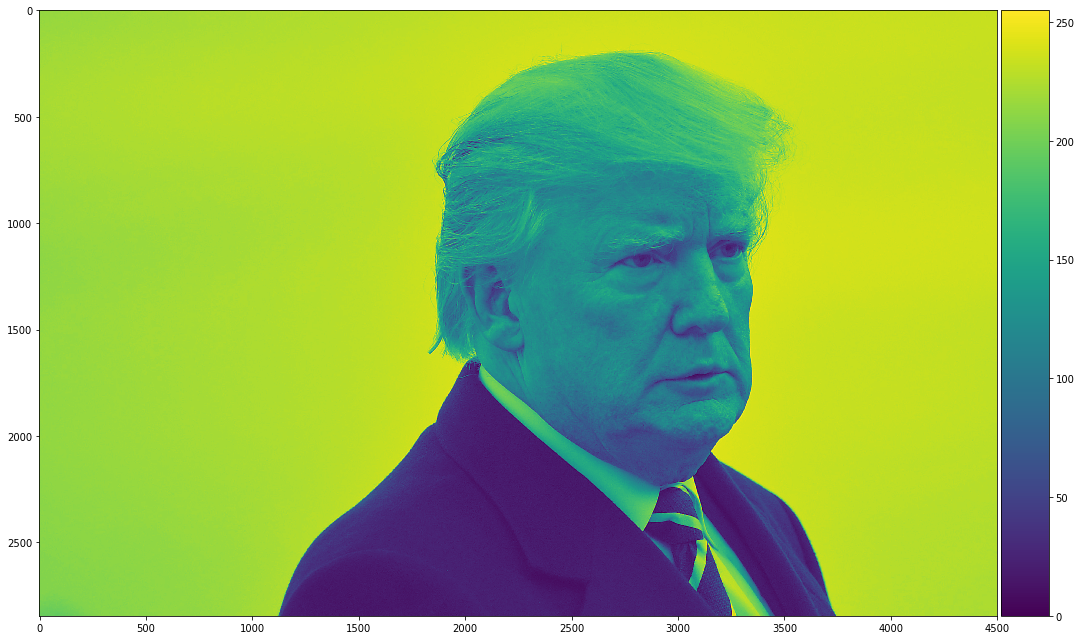

In [140]:
imshow(img)

# Look ahead

In [138]:
class Line:
    def __init__(self, row, widthMin, widthMax, rowHeight, yStartValue, overlapScalar):
        self.imgWidth = int(len(row))
        self.overlapScalar = int(overlapScalar) # do we want the sinusoids of consecutive rows to overlap in darker areas?
        self.segmentOpacityMapping = np.arange(256)
        self.segmentWidthMapping = np.linspace(widthMin,widthMax,256).round().astype('int') # each sinus opacity is mapped to a period on interval [widthMin, widthMax]
        self.row = np.array(list(row) + list(np.repeat(row[-1],repeats = self.segmentWidthMapping[-1]))) # repeat the last value to deal with overshooting of algorithm
        self.rowHeight = rowHeight # distance between two consecutive parsed rows
        self.sequenceInfo = self.getSequence() # sinusoid sequence info result of greedy search

    def getSequence(self):
        cumpixels = [0]
        sequenceInfo = list()
        while cumpixels[-1] < self.imgWidth:
            nextsegment = self.greedyLookahead(cumpixels[-1])
            sequenceInfo.append({'period': self.segmentWidthMapping[nextsegment],
                                    'amplitude': self.overlapScalar*self.rowHeight/2*(1-(self.segmentOpacityMapping[nextsegment]/255)),
                                    'xStart': cumpixels[-1]})
            cumpixels.append(self.segmentWidthMapping[nextsegment]+cumpixels[-1])
        return(sequenceInfo)
    
    def greedyLookahead(self, cumpixels):
        segmentSumOpacities = {i: np.sum(self.row[cumpixels:(cumpixels+i)]) for i in np.unique(self.segmentWidthMapping)}
        for i in range(len(self.segmentWidthMapping)):
            newdiff = segmentSumOpacities[self.segmentWidthMapping[i]] - self.segmentOpacityMapping[i]*self.segmentWidthMapping[i]
            if newdiff <= 0:
                return(i)

In [171]:
widthMin = 30
widthMax = 120
rowHeight = 30
overlapScalar = 1
sins = []

sf = 22 # scale factor

for yVal in range(0, img_gray_255.shape[0], (rowHeight+2)):
    row = img_gray_255[yVal].astype('int')
    line = Line(row, widthMin, widthMax, rowHeight, yVal, overlapScalar)
    y = img_gray_255.shape[0] - yVal
    sins = sins + \
    [shapes.Point(line.sequenceInfo[0]['xStart']/sf+5, y/sf+5)] + \
    [shapes.SineWave(A=i['amplitude']/sf, P=shapes.Point(i['xStart']/sf+5, y/sf+5), n=i['period']/sf) for i in line.sequenceInfo]

# Plot

In [172]:
def preview_objs(objs):
    pygame.init()

    canvas=pygame.display.set_mode((240,170),0,32)

    white = (255, 255, 255)
    black = (0, 0, 0)

    canvas.fill(white)

    for obj in objs:
        obj.draw(canvas, black)

    while True:
        for event in pygame.event.get():
            if event.type==QUIT:
                pygame.quit()
                return
        pygame.display.update()

def wake_up_serial(port, baud):
    # Open grbl serial port
    s = serial.Serial(port, baud)

    # Wake up grbl
    s.write(b"\r\n\r\n")
    time.sleep(3)   # Wait for grbl to initialize 
    s.flushInput()  # Flush startup text in serial input

    s.write(b"G21\n")   # units = mm
    print(s.readline().strip())
    s.write(b"F5000\n") # feed rate
    print(s.readline().strip())

    s.write(b"S0 M3\n") # pen slightly down
    print(s.readline().strip())

    s.write(b"S0 M5\n") # pen up
    print(s.readline().strip())
    
    return s

def objs_to_plotter(objs, s):
    # display objects and ask for confirmation
    preview_objs(objs)
    r = input("plot this? [y/N]")
    if r != "y":
        return
    
    # if response was 'y', plot it
    for obj in objs:
        for line in obj.plot_instructions():
            l = line + "\n"
            print('Sending: ' + l,)
            s.write(l.encode('utf-8')) # Send g-code block to grbl
            grbl_out = s.readline() # Wait for grbl response with carriage return
            print(grbl_out.strip())

In [210]:
s = wake_up_serial('/dev/tty.wchusbserial1420', 115200)

b'ok'
b'ok'
b'ok'
b'ok'


In [211]:
objs_to_plotter(sins, s)

plot this? [y/N]y
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y134.31818

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40182 Y134.37004 I-4.18071 J-30.81408

b'ok'
Sending: G03 X-5.60227 Y134.39192 I-0.93606 J-7.64576

b'ok'
Sending: G03 X-5.92098 Y134.41527 I-0.67858 J-7.07322

b'ok'
Sending: G03 X-6.20455 Y134.42246 I-0.28357 J-5.5918

b'ok'
Sending: G03 X-6.48812 Y134.41527 I0.0 J-5.59898

b'ok'
Sending: G03 X-6.80682 Y134.39192 I0.35988 J-7.09658

b'ok'
Sending: G03 X-7.00727 Y134.37004 I0.73561 J-7.66764

b'ok'
Sending: G03 X-7.40909 Y134.31818 I3.77889 J-30.86594

b'ok'
Sending: G02 X-7.81091 Y134.26633 I-4.18071 J30.81408

b'ok'
Sending: G02 X-8.01136 Y134.24445 I-0.93606 J7.64576

b'ok'
Sending: G02 X-8.33007 Y134.22109 I-0.67858 J7.07322

b'ok'
Sending: G02 X-8.61364 Y134.2139 I-0.28357 J5.5918

b'ok'
Sending: G02 X-8.89721 Y134.22109 I-0.0 J5.59898

b'ok'
Sending: G02 X-9.21591 Y134.24445 I0.35988 J7.09658

b'ok'
Sending: G02 X-9.41636 Y134.26633 I0.73561 J7.66764

b'ok'
Send

b'ok'
Sending: G02 X-48.09856 Y134.24101 I-0.0 J7.44801

b'ok'
Sending: G02 X-48.42614 Y134.25957 I0.36887 J9.40986

b'ok'
Sending: G02 X-48.63239 Y134.27698 I0.75287 J10.15213

b'ok'
Sending: G02 X-49.04545 Y134.31818 I3.85777 J40.76379

b'ok'
Sending: G03 X-49.45852 Y134.35939 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-49.66477 Y134.37679 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-49.99235 Y134.39535 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-50.28409 Y134.40107 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-50.57583 Y134.39535 I-0.0 J-7.44801

b'ok'
Sending: G03 X-50.90341 Y134.37679 I0.36887 J-9.40986

b'ok'
Sending: G03 X-51.10966 Y134.35939 I0.75287 J-10.15213

b'ok'
Sending: G03 X-51.52273 Y134.31818 I3.85777 J-40.76379

b'ok'
Sending: G02 X-51.93579 Y134.27698 I-4.27083 J40.72259

b'ok'
Sending: G02 X-52.14205 Y134.25957 I-0.95912 J10.13473

b'ok'
Sending: G02 X-52.46963 Y134.24101 I-0.69645 J9.3913

b'ok'
Sending: G02 X-52.76136 Y134.23529 I-0.29174 J7.4423

b'ok'
Sending: G02 X-53.05

b'ok'
Sending: G02 X-92.01526 Y134.28629 I-4.36978 J55.29994

b'ok'
Sending: G02 X-92.22727 Y134.27281 I-0.98325 J13.78943

b'ok'
Sending: G02 X-92.56378 Y134.25844 I-0.71473 J12.79151

b'ok'
Sending: G02 X-92.86364 Y134.25401 I-0.29986 J10.15258

b'ok'
Sending: G02 X-93.1635 Y134.25844 I-0.0 J10.15701

b'ok'
Sending: G02 X-93.5 Y134.27281 I0.37823 J12.80588

b'ok'
Sending: G02 X-93.71201 Y134.28629 I0.77124 J13.80291

b'ok'
Sending: G02 X-94.13636 Y134.31818 I3.94543 J55.33183

b'ok'
Sending: G03 X-94.56071 Y134.34875 I-4.36779 J-57.67797

b'ok'
Sending: G03 X-94.77273 Y134.36167 I-0.98301 J-14.38542

b'ok'
Sending: G03 X-95.10922 Y134.37544 I-0.71464 J-13.34589

b'ok'
Sending: G03 X-95.40909 Y134.37968 I-0.29987 J-10.59436

b'ok'
Sending: G03 X-95.70896 Y134.37544 I-0.0 J-10.5986

b'ok'
Sending: G03 X-96.04545 Y134.36167 I0.37814 J-13.35966

b'ok'
Sending: G03 X-96.25747 Y134.34875 I0.77099 J-14.39834

b'ok'
Sending: G03 X-96.68182 Y134.31818 I3.94345 J-57.70853

b'ok'
Sending: G02 X

b'ok'
Sending: G02 X-134.49432 Y134.28226 I0.3812 J16.44861

b'ok'
Sending: G02 X-134.70826 Y134.29293 I0.77693 J17.72072

b'ok'
Sending: G02 X-135.13636 Y134.31818 I3.97123 J70.97803

b'ok'
Sending: G03 X-135.56446 Y134.34343 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-135.77841 Y134.3541 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-136.11787 Y134.36548 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-136.42045 Y134.36898 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-136.72304 Y134.36548 I-0.0 J-13.05991

b'ok'
Sending: G03 X-137.0625 Y134.3541 I0.3812 J-16.44861

b'ok'
Sending: G03 X-137.27645 Y134.34343 I0.77693 J-17.72072

b'ok'
Sending: G03 X-137.70455 Y134.31818 I3.97123 J-70.97803

b'ok'
Sending: G02 X-138.13264 Y134.29293 I-4.39933 J70.95278

b'ok'
Sending: G02 X-138.34659 Y134.28226 I-0.99088 J17.71004

b'ok'
Sending: G02 X-138.68605 Y134.27089 I-0.72066 J16.43724

b'ok'
Sending: G02 X-138.98864 Y134.26738 I-0.30259 J13.05641

b'ok'
Sending: G02 X-139.29122 Y134.27089 I0.0 J13.05991

b'ok

b'ok'
Sending: G03 X-177.20879 Y134.36797 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-177.51136 Y134.37166 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-177.81394 Y134.36797 I0.0 J-12.40694

b'ok'
Sending: G03 X-178.15341 Y134.356 I0.38127 J-15.62904

b'ok'
Sending: G03 X-178.36735 Y134.34476 I0.77714 J-16.83917

b'ok'
Sending: G03 X-178.79545 Y134.31818 I3.97286 J-67.45683

b'ok'
Sending: G02 X-179.22356 Y134.2916 I-4.40097 J67.43025

b'ok'
Sending: G02 X-179.4375 Y134.28037 I-0.99108 J16.82793

b'ok'
Sending: G02 X-179.77697 Y134.2684 I-0.72074 J15.61706

b'ok'
Sending: G02 X-180.07955 Y134.26471 I-0.30258 J12.40325

b'ok'
Sending: G02 X-180.38212 Y134.2684 I0.0 J12.40694

b'ok'
Sending: G02 X-180.72159 Y134.28037 I0.38127 J15.62904

b'ok'
Sending: G02 X-180.93553 Y134.2916 I0.77714 J16.83917

b'ok'
Sending: G02 X-181.36364 Y134.31818 I3.97286 J67.45683

b'ok'
Sending: G03 X-181.79175 Y134.34609 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-182.00568 Y134.35789 I-0.99129 J-16.02999

b'ok'
S

b'ok'
Sending: G03 X-11.64205 Y132.93548 I0.36308 J-7.41732

b'ok'
Sending: G03 X-11.84441 Y132.91416 I0.74196 J-8.0122

b'ok'
Sending: G03 X-12.25 Y132.86364 I3.80986 J-32.23915

b'ok'
Sending: G02 X-12.65559 Y132.81312 I-4.21545 J32.18863

b'ok'
Sending: G02 X-12.85795 Y132.79179 I-0.94432 J7.99088

b'ok'
Sending: G02 X-13.17964 Y132.76903 I-0.68476 J7.39456

b'ok'
Sending: G02 X-13.46591 Y132.76203 I-0.28627 J5.84823

b'ok'
Sending: G02 X-13.75218 Y132.76903 I0.0 J5.85523

b'ok'
Sending: G02 X-14.07386 Y132.79179 I0.36308 J7.41732

b'ok'
Sending: G02 X-14.27623 Y132.81312 I0.74196 J8.0122

b'ok'
Sending: G02 X-14.68182 Y132.86364 I3.80986 J32.23915

b'ok'
Sending: G03 X-15.08739 Y132.91283 I-4.21212 J-33.03249

b'ok'
Sending: G03 X-15.28977 Y132.93359 I-0.94392 J-8.20332

b'ok'
Sending: G03 X-15.61144 Y132.95575 I-0.6846 J-7.59266

b'ok'
Sending: G03 X-15.89773 Y132.96257 I-0.28629 J-6.00664

b'ok'
Sending: G03 X-16.18401 Y132.95575 I0.0 J-6.01346

b'ok'
Sending: G03 X-16.50568 Y132

b'ok'
Sending: G03 X-54.61932 Y132.92036 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-54.94689 Y132.93832 I-0.69632 J-9.70258

b'ok'
Sending: G03 X-55.23864 Y132.94385 I-0.29175 J-7.69073

b'ok'
Sending: G03 X-55.53039 Y132.93832 I-0.0 J-7.69626

b'ok'
Sending: G03 X-55.85795 Y132.92036 I0.36875 J-9.72054

b'ok'
Sending: G03 X-56.06422 Y132.90351 I0.75253 J-10.48586

b'ok'
Sending: G03 X-56.47727 Y132.86364 I3.85512 J-42.0937

b'ok'
Sending: G02 X-56.89033 Y132.82376 I-4.26817 J42.05382

b'ok'
Sending: G02 X-57.09659 Y132.80692 I-0.9588 J10.46902

b'ok'
Sending: G02 X-57.42416 Y132.78895 I-0.69632 J9.70258

b'ok'
Sending: G02 X-57.71591 Y132.78342 I-0.29175 J7.69073

b'ok'
Sending: G02 X-58.00766 Y132.78895 I0.0 J7.69626

b'ok'
Sending: G02 X-58.33523 Y132.80692 I0.36875 J9.72054

b'ok'
Sending: G02 X-58.54149 Y132.82376 I0.75253 J10.48586

b'ok'
Sending: G02 X-58.95455 Y132.86364 I3.85512 J42.0937

b'ok'
Sending: G03 X-59.37137 Y132.90218 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-59.579

b'ok'
Sending: G02 X-98.59091 Y132.82204 I0.37806 J13.96392

b'ok'
Sending: G02 X-98.80294 Y132.8344 I0.77075 J15.0481

b'ok'
Sending: G02 X-99.22727 Y132.86364 I3.94155 J60.30259

b'ok'
Sending: G03 X-99.65539 Y132.89154 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-99.86932 Y132.90334 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-100.20879 Y132.91591 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-100.51136 Y132.91979 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-100.81393 Y132.91591 I0.0 J-11.81615

b'ok'
Sending: G03 X-101.15341 Y132.90334 I0.38134 J-14.88766

b'ok'
Sending: G03 X-101.36734 Y132.89154 I0.77736 J-16.04179

b'ok'
Sending: G03 X-101.79545 Y132.86364 I3.97458 J-64.27233

b'ok'
Sending: G02 X-102.22357 Y132.83573 I-4.40269 J64.24442

b'ok'
Sending: G02 X-102.4375 Y132.82393 I-0.99129 J16.02999

b'ok'
Sending: G02 X-102.77698 Y132.81136 I-0.72082 J14.87509

b'ok'
Sending: G02 X-103.07955 Y132.80749 I-0.30257 J11.81228

b'ok'
Sending: G02 X-103.38211 Y132.81136 I-0.0 J11.81615

b'ok'
S

b'ok'
Sending: G03 X-141.43605 Y132.91093 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-141.73864 Y132.91444 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-142.04122 Y132.91093 I-0.0 J-13.05991

b'ok'
Sending: G03 X-142.38068 Y132.89956 I0.3812 J-16.44861

b'ok'
Sending: G03 X-142.59463 Y132.88888 I0.77693 J-17.72072

b'ok'
Sending: G03 X-143.02273 Y132.86364 I3.97123 J-70.97803

b'ok'
Sending: G02 X-143.45083 Y132.83839 I-4.39933 J70.95278

b'ok'
Sending: G02 X-143.66477 Y132.82771 I-0.99088 J17.71004

b'ok'
Sending: G02 X-144.00423 Y132.81634 I-0.72066 J16.43724

b'ok'
Sending: G02 X-144.30682 Y132.81283 I-0.30259 J13.05641

b'ok'
Sending: G02 X-144.6094 Y132.81634 I0.0 J13.05991

b'ok'
Sending: G02 X-144.94886 Y132.82771 I0.3812 J16.44861

b'ok'
Sending: G02 X-145.16281 Y132.83839 I0.77693 J17.72072

b'ok'
Sending: G02 X-145.59091 Y132.86364 I3.97123 J70.97803

b'ok'
Sending: G03 X-146.02279 Y132.88755 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-146.23864 Y132.89767 I-0.99943 J-19.02207

b'

b'ok'
Sending: G03 X-184.15909 Y132.86364 I3.97286 J-67.45683

b'ok'
Sending: G02 X-184.5872 Y132.83706 I-4.40097 J67.43025

b'ok'
Sending: G02 X-184.80114 Y132.82582 I-0.99108 J16.82793

b'ok'
Sending: G02 X-185.1406 Y132.81385 I-0.72074 J15.61706

b'ok'
Sending: G02 X-185.44318 Y132.81016 I-0.30258 J12.40325

b'ok'
Sending: G02 X-185.74576 Y132.81385 I-0.0 J12.40694

b'ok'
Sending: G02 X-186.08523 Y132.82582 I0.38127 J15.62904

b'ok'
Sending: G02 X-186.29917 Y132.83706 I0.77714 J16.83917

b'ok'
Sending: G02 X-186.72727 Y132.86364 I3.97286 J67.45683

b'ok'
Sending: G03 X-187.15538 Y132.89021 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-187.36932 Y132.90145 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-187.70879 Y132.91342 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-188.01136 Y132.91711 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-188.31394 Y132.91342 I0.0 J-12.40694

b'ok'
Sending: G03 X-188.65341 Y132.90145 I0.38127 J-15.62904

b'ok'
Sending: G03 X-188.86735 Y132.89021 I0.77714 J-16.83917

b

b'ok'
Sending: G03 X-20.20455 Y131.47526 I-0.95183 J-8.8265

b'ok'
Sending: G03 X-20.52918 Y131.49622 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-20.81818 Y131.50267 I-0.289 J-6.46996

b'ok'
Sending: G03 X-21.10718 Y131.49622 I0.0 J-6.47641

b'ok'
Sending: G03 X-21.43182 Y131.47526 I0.36601 J-8.19401

b'ok'
Sending: G03 X-21.63612 Y131.45562 I0.74752 J-8.84615

b'ok'
Sending: G03 X-22.04545 Y131.40909 I3.8347 J-35.55991

b'ok'
Sending: G02 X-22.45479 Y131.36256 I-4.24403 J35.51339

b'ok'
Sending: G02 X-22.65909 Y131.34292 I-0.95183 J8.8265

b'ok'
Sending: G02 X-22.98373 Y131.32196 I-0.69065 J8.17305

b'ok'
Sending: G02 X-23.27273 Y131.31551 I-0.289 J6.46996

b'ok'
Sending: G02 X-23.56173 Y131.32196 I0.0 J6.47641

b'ok'
Sending: G02 X-23.88636 Y131.34292 I0.36601 J8.19401

b'ok'
Sending: G02 X-24.09067 Y131.36256 I0.74752 J8.84615

b'ok'
Sending: G02 X-24.5 Y131.40909 I3.8347 J35.55991

b'ok'
Sending: G03 X-24.90932 Y131.45429 I-4.241 J-36.53177

b'ok'
Sending: G03 X-25.11364 Y131.47337 I

b'ok'
Sending: G02 X-63.42045 Y131.35426 I0.372 J10.23727

b'ok'
Sending: G02 X-63.62863 Y131.37055 I0.75903 J11.0414

b'ok'
Sending: G02 X-64.04545 Y131.40909 I3.88724 J44.31084

b'ok'
Sending: G03 X-64.46227 Y131.44631 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-64.67045 Y131.46203 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-65.001 Y131.47879 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-65.29545 Y131.48396 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-65.58991 Y131.47879 I0.0 J-8.39794

b'ok'
Sending: G03 X-65.92045 Y131.46203 I0.37189 J-10.5999

b'ok'
Sending: G03 X-66.12864 Y131.44631 I0.75871 J-11.43105

b'ok'
Sending: G03 X-66.54545 Y131.40909 I3.88479 J-45.86445

b'ok'
Sending: G02 X-66.96227 Y131.37188 I-4.30161 J45.82723

b'ok'
Sending: G02 X-67.17045 Y131.35615 I-0.9669 J11.41533

b'ok'
Sending: G02 X-67.501 Y131.33939 I-0.70244 J10.58314

b'ok'
Sending: G02 X-67.79545 Y131.33422 I-0.29446 J8.39278

b'ok'
Sending: G02 X-68.08991 Y131.33939 I0.0 J8.39794

b'ok'
Sending: G02 X-68.42045 

b'ok'
Sending: G02 X-107.75568 Y131.37128 I-0.99108 J16.82793

b'ok'
Sending: G02 X-108.09515 Y131.35931 I-0.72074 J15.61706

b'ok'
Sending: G02 X-108.39773 Y131.35561 I-0.30258 J12.40325

b'ok'
Sending: G02 X-108.70031 Y131.35931 I0.0 J12.40694

b'ok'
Sending: G02 X-109.03977 Y131.37128 I0.38127 J15.62904

b'ok'
Sending: G02 X-109.25371 Y131.38251 I0.77714 J16.83917

b'ok'
Sending: G02 X-109.68182 Y131.40909 I3.97286 J67.45683

b'ok'
Sending: G03 X-110.10992 Y131.43434 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-110.32386 Y131.44501 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-110.66332 Y131.45639 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-110.96591 Y131.45989 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-111.2685 Y131.45639 I0.0 J-13.05991

b'ok'
Sending: G03 X-111.60795 Y131.44501 I0.3812 J-16.44861

b'ok'
Sending: G03 X-111.8219 Y131.43434 I0.77693 J-17.72072

b'ok'
Sending: G03 X-112.25 Y131.40909 I3.97123 J-70.97803

b'ok'
Sending: G02 X-112.6781 Y131.38384 I-4.39933 J70.95278

b'ok'
S

b'ok'
Sending: G02 X-150.65903 Y131.38517 I0.78358 J19.03219

b'ok'
Sending: G02 X-151.09091 Y131.40909 I4.00457 J76.21889

b'ok'
Sending: G03 X-151.51901 Y131.43434 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-151.73295 Y131.44501 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-152.07241 Y131.45639 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-152.375 Y131.45989 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-152.67759 Y131.45639 I-0.0 J-13.05991

b'ok'
Sending: G03 X-153.01705 Y131.44501 I0.3812 J-16.44861

b'ok'
Sending: G03 X-153.23099 Y131.43434 I0.77693 J-17.72072

b'ok'
Sending: G03 X-153.65909 Y131.40909 I3.97123 J-70.97803

b'ok'
Sending: G02 X-154.08719 Y131.38384 I-4.39933 J70.95278

b'ok'
Sending: G02 X-154.30114 Y131.37317 I-0.99088 J17.71004

b'ok'
Sending: G02 X-154.6406 Y131.36179 I-0.72066 J16.43724

b'ok'
Sending: G02 X-154.94318 Y131.35829 I-0.30259 J13.05641

b'ok'
Sending: G02 X-155.24577 Y131.36179 I-0.0 J13.05991

b'ok'
Sending: G02 X-155.58523 Y131.37317 I0.3812 J16.44861

b'o

b'ok'
Sending: G03 X-193.46591 Y131.46524 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-193.76848 Y131.46137 I0.0 J-11.81615

b'ok'
Sending: G03 X-194.10795 Y131.44879 I0.38134 J-14.88766

b'ok'
Sending: G03 X-194.32189 Y131.437 I0.77736 J-16.04179

b'ok'
Sending: G03 X-194.75 Y131.40909 I3.97458 J-64.27233

b'ok'
Sending: G02 X-195.17811 Y131.38118 I-4.40269 J64.24442

b'ok'
Sending: G02 X-195.39205 Y131.36939 I-0.99129 J16.02999

b'ok'
Sending: G02 X-195.73152 Y131.35682 I-0.72082 J14.87509

b'ok'
Sending: G02 X-196.03409 Y131.35294 I-0.30257 J11.81228

b'ok'
Sending: G02 X-196.33666 Y131.35682 I-0.0 J11.81615

b'ok'
Sending: G02 X-196.67614 Y131.36939 I0.38134 J14.88766

b'ok'
Sending: G02 X-196.89007 Y131.38118 I0.77736 J16.04179

b'ok'
Sending: G02 X-197.31818 Y131.40909 I3.97458 J64.27233

b'ok'
Sending: G03 X-197.7463 Y131.437 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-197.96023 Y131.44879 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-198.2997 Y131.46137 I-0.72082 J-14.87509

b'ok'
Se

b'ok'
Sending: G02 X-28.79545 Y129.89026 I0.36588 J8.43204

b'ok'
Sending: G02 X-28.99977 Y129.90935 I0.74714 J9.10167

b'ok'
Sending: G02 X-29.40909 Y129.95455 I3.83168 J36.57696

b'ok'
Sending: G03 X-29.8184 Y129.99841 I-4.23805 J-37.61265

b'ok'
Sending: G03 X-30.02273 Y130.01694 I-0.9511 J-9.35428

b'ok'
Sending: G03 X-30.34733 Y130.0367 I-0.69036 J-8.66482

b'ok'
Sending: G03 X-30.63636 Y130.04278 I-0.28903 J-6.86279

b'ok'
Sending: G03 X-30.92539 Y130.0367 I0.0 J-6.86888

b'ok'
Sending: G03 X-31.25 Y130.01694 I0.36575 J-8.68458

b'ok'
Sending: G03 X-31.45433 Y129.99841 I0.74677 J-9.37281

b'ok'
Sending: G03 X-31.86364 Y129.95455 I3.82874 J-37.65651

b'ok'
Sending: G02 X-32.27294 Y129.91068 I-4.23805 J37.61265

b'ok'
Sending: G02 X-32.47727 Y129.89215 I-0.9511 J9.35428

b'ok'
Sending: G02 X-32.80188 Y129.87239 I-0.69036 J8.66482

b'ok'
Sending: G02 X-33.09091 Y129.86631 I-0.28903 J6.86279

b'ok'
Sending: G02 X-33.37994 Y129.87239 I-0.0 J6.86888

b'ok'
Sending: G02 X-33.70455 Y129.

b'ok'
Sending: G02 X-72.26136 Y129.9035 I-0.96661 J11.83458

b'ok'
Sending: G02 X-72.5919 Y129.88733 I-0.70232 J10.97334

b'ok'
Sending: G02 X-72.88636 Y129.88235 I-0.29447 J8.70397

b'ok'
Sending: G02 X-73.18083 Y129.88733 I0.0 J8.70895

b'ok'
Sending: G02 X-73.51136 Y129.9035 I0.37179 J10.98951

b'ok'
Sending: G02 X-73.71956 Y129.91866 I0.75841 J11.84974

b'ok'
Sending: G02 X-74.13636 Y129.95455 I3.88243 J47.53419

b'ok'
Sending: G03 X-74.55695 Y129.9891 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-74.76705 Y130.0037 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-75.10057 Y130.01927 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-75.39773 Y130.02406 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-75.69489 Y130.01927 I0.0 J-9.20907

b'ok'
Sending: G03 X-76.02841 Y130.0037 I0.37505 J-11.61688

b'ok'
Sending: G03 X-76.23851 Y129.9891 I0.76495 J-12.52439

b'ok'
Sending: G03 X-76.65909 Y129.95455 I3.9149 J-50.22778

b'ok'
Sending: G02 X-77.07968 Y129.91999 I-4.33548 J50.19322

b'ok'
Sending: G02 X-77.2897

b'ok'
Sending: G03 X-116.94318 Y129.98858 I0.3845 J-17.66754

b'ok'
Sending: G03 X-117.15903 Y129.97846 I0.78358 J-19.03219

b'ok'
Sending: G03 X-117.59091 Y129.95455 I4.00457 J-76.21889

b'ok'
Sending: G02 X-118.02279 Y129.93063 I-4.43645 J76.19498

b'ok'
Sending: G02 X-118.23864 Y129.92051 I-0.99943 J19.02207

b'ok'
Sending: G02 X-118.58109 Y129.90974 I-0.72695 J17.65677

b'ok'
Sending: G02 X-118.88636 Y129.90642 I-0.30527 J14.02719

b'ok'
Sending: G02 X-119.19164 Y129.90974 I-0.0 J14.03051

b'ok'
Sending: G02 X-119.53409 Y129.92051 I0.3845 J17.66754

b'ok'
Sending: G02 X-119.74994 Y129.93063 I0.78358 J19.03219

b'ok'
Sending: G02 X-120.18182 Y129.95455 I4.00457 J76.21889

b'ok'
Sending: G03 X-120.61369 Y129.97713 I-4.435 J-80.65052

b'ok'
Sending: G03 X-120.82955 Y129.98669 I-0.99925 J-20.13744

b'ok'
Sending: G03 X-121.17199 Y129.99686 I-0.72688 J-18.69362

b'ok'
Sending: G03 X-121.47727 Y130.0 I-0.30528 J-14.85268

b'ok'
Sending: G03 X-121.78255 Y129.99686 I-0.0 J-14.85581

b'ok'


b'ok'
Sending: G02 X-160.03564 Y129.90974 I-0.72695 J17.65677

b'ok'
Sending: G02 X-160.34091 Y129.90642 I-0.30527 J14.02719

b'ok'
Sending: G02 X-160.64618 Y129.90974 I0.0 J14.03051

b'ok'
Sending: G02 X-160.98864 Y129.92051 I0.3845 J17.66754

b'ok'
Sending: G02 X-161.20448 Y129.93063 I0.78358 J19.03219

b'ok'
Sending: G02 X-161.63636 Y129.95455 I4.00457 J76.21889

b'ok'
Sending: G03 X-162.06446 Y129.97979 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-162.27841 Y129.99047 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-162.61787 Y130.00184 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-162.92045 Y130.00535 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-163.22304 Y130.00184 I0.0 J-13.05991

b'ok'
Sending: G03 X-163.5625 Y129.99047 I0.3812 J-16.44861

b'ok'
Sending: G03 X-163.77645 Y129.97979 I0.77693 J-17.72072

b'ok'
Sending: G03 X-164.20455 Y129.95455 I3.97123 J-70.97803

b'ok'
Sending: G02 X-164.63264 Y129.9293 I-4.39933 J70.95278

b'ok'
Sending: G02 X-164.84659 Y129.91862 I-0.99088 J17.71004

b'ok

b'ok'
Sending: G02 X-202.72727 Y129.95455 I3.97458 J64.27233

b'ok'
Sending: G03 X-203.15539 Y129.98245 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-203.36932 Y129.99425 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-203.70879 Y130.00682 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-204.01136 Y130.0107 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-204.31393 Y130.00682 I-0.0 J-11.81615

b'ok'
Sending: G03 X-204.65341 Y129.99425 I0.38134 J-14.88766

b'ok'
Sending: G03 X-204.86734 Y129.98245 I0.77736 J-16.04179

b'ok'
Sending: G03 X-205.29545 Y129.95455 I3.97458 J-64.27233

b'ok'
Sending: G02 X-205.72357 Y129.92664 I-4.40269 J64.24442

b'ok'
Sending: G02 X-205.9375 Y129.91484 I-0.99129 J16.02999

b'ok'
Sending: G02 X-206.27698 Y129.90227 I-0.72082 J14.87509

b'ok'
Sending: G02 X-206.57955 Y129.8984 I-0.30257 J11.81228

b'ok'
Sending: G02 X-206.88211 Y129.90227 I-0.0 J11.81615

b'ok'
Sending: G02 X-207.22159 Y129.91484 I0.38134 J14.88766

b'ok'
Sending: G02 X-207.43552 Y129.92664 I0.77736 J16.04179

b

b'ok'
Sending: G02 X-37.50568 Y128.4395 I-0.95945 J9.82144

b'ok'
Sending: G02 X-37.83328 Y128.42034 I-0.69658 J9.09953

b'ok'
Sending: G02 X-38.125 Y128.41444 I-0.29172 J7.20938

b'ok'
Sending: G02 X-38.41672 Y128.42034 I-0.0 J7.21528

b'ok'
Sending: G02 X-38.74432 Y128.4395 I0.36898 J9.11869

b'ok'
Sending: G02 X-38.95056 Y128.45746 I0.75322 J9.8394

b'ok'
Sending: G02 X-39.36364 Y128.5 I3.8605 J39.51789

b'ok'
Sending: G03 X-39.77669 Y128.53987 I-4.26817 J-42.05382

b'ok'
Sending: G03 X-39.98295 Y128.55672 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-40.31052 Y128.57468 I-0.69632 J-9.70258

b'ok'
Sending: G03 X-40.60227 Y128.58021 I-0.29175 J-7.69073

b'ok'
Sending: G03 X-40.89402 Y128.57468 I-0.0 J-7.69626

b'ok'
Sending: G03 X-41.22159 Y128.55672 I0.36875 J-9.72054

b'ok'
Sending: G03 X-41.42785 Y128.53987 I0.75253 J-10.48586

b'ok'
Sending: G03 X-41.84091 Y128.5 I3.85512 J-42.0937

b'ok'
Sending: G02 X-42.25396 Y128.46013 I-4.26817 J42.05382

b'ok'
Sending: G02 X-42.46023 Y128.44328

b'ok'
Sending: G03 X-81.27273 Y128.54538 I0.37823 J-12.80588

b'ok'
Sending: G03 X-81.48474 Y128.53189 I0.77124 J-13.80291

b'ok'
Sending: G03 X-81.90909 Y128.5 I3.94543 J-55.33183

b'ok'
Sending: G02 X-82.33344 Y128.46811 I-4.36978 J55.29994

b'ok'
Sending: G02 X-82.54545 Y128.45462 I-0.98325 J13.78943

b'ok'
Sending: G02 X-82.88196 Y128.44026 I-0.71473 J12.79151

b'ok'
Sending: G02 X-83.18182 Y128.43583 I-0.29986 J10.15258

b'ok'
Sending: G02 X-83.48168 Y128.44026 I0.0 J10.15701

b'ok'
Sending: G02 X-83.81818 Y128.45462 I0.37823 J12.80588

b'ok'
Sending: G02 X-84.03019 Y128.46811 I0.77124 J13.80291

b'ok'
Sending: G02 X-84.45455 Y128.5 I3.94543 J55.33183

b'ok'
Sending: G03 X-84.87889 Y128.53057 I-4.36779 J-57.67797

b'ok'
Sending: G03 X-85.09091 Y128.54349 I-0.98301 J-14.38542

b'ok'
Sending: G03 X-85.4274 Y128.55725 I-0.71464 J-13.34589

b'ok'
Sending: G03 X-85.72727 Y128.5615 I-0.29987 J-10.59436

b'ok'
Sending: G03 X-86.02714 Y128.55725 I0.0 J-10.5986

b'ok'
Sending: G03 X-86.363

b'ok'
Sending: G03 X-126.23864 Y128.53025 I-0.99908 J-21.39245

b'ok'
Sending: G03 X-126.58108 Y128.53983 I-0.72682 J-19.86018

b'ok'
Sending: G03 X-126.88636 Y128.54278 I-0.30529 J-15.78133

b'ok'
Sending: G03 X-127.19165 Y128.53983 I-0.0 J-15.78428

b'ok'
Sending: G03 X-127.53409 Y128.53025 I0.38438 J-19.86976

b'ok'
Sending: G03 X-127.74995 Y128.52126 I0.78322 J-21.40144

b'ok'
Sending: G03 X-128.18182 Y128.5 I4.00175 J-85.68588

b'ok'
Sending: G02 X-128.61368 Y128.47874 I-4.43362 J85.66462

b'ok'
Sending: G02 X-128.82955 Y128.46975 I-0.99908 J21.39245

b'ok'
Sending: G02 X-129.17199 Y128.46017 I-0.72682 J19.86018

b'ok'
Sending: G02 X-129.47727 Y128.45722 I-0.30529 J15.78133

b'ok'
Sending: G02 X-129.78256 Y128.46017 I-0.0 J15.78428

b'ok'
Sending: G02 X-130.125 Y128.46975 I0.38438 J19.86976

b'ok'
Sending: G02 X-130.34086 Y128.47874 I0.78322 J21.40144

b'ok'
Sending: G02 X-130.77273 Y128.5 I4.00175 J85.68588

b'ok'
Sending: G03 X-131.2046 Y128.52259 I-4.435 J-80.65052

b'ok'
Sendi

b'ok'
Sending: G02 X-171.49432 Y128.46408 I0.3812 J16.44861

b'ok'
Sending: G02 X-171.70826 Y128.47475 I0.77693 J17.72072

b'ok'
Sending: G02 X-172.13636 Y128.5 I3.97123 J70.97803

b'ok'
Sending: G03 X-172.56446 Y128.52525 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-172.77841 Y128.53592 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-173.11787 Y128.5473 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-173.42045 Y128.5508 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-173.72304 Y128.5473 I-0.0 J-13.05991

b'ok'
Sending: G03 X-174.0625 Y128.53592 I0.3812 J-16.44861

b'ok'
Sending: G03 X-174.27645 Y128.52525 I0.77693 J-17.72072

b'ok'
Sending: G03 X-174.70455 Y128.5 I3.97123 J-70.97803

b'ok'
Sending: G02 X-175.13264 Y128.47475 I-4.39933 J70.95278

b'ok'
Sending: G02 X-175.34659 Y128.46408 I-0.99088 J17.71004

b'ok'
Sending: G02 X-175.68605 Y128.4527 I-0.72066 J16.43724

b'ok'
Sending: G02 X-175.98864 Y128.4492 I-0.30259 J13.05641

b'ok'
Sending: G02 X-176.29122 Y128.4527 I0.0 J13.05991

b'ok'
Sending: G

b'ok'
Sending: G03 X-7.43182 Y127.04545 I3.80333 J-33.97181

b'ok'
Sending: G02 X-7.83738 Y126.9976 I-4.20888 J33.92395

b'ok'
Sending: G02 X-8.03977 Y126.97739 I-0.94352 J8.42767

b'ok'
Sending: G02 X-8.36143 Y126.95583 I-0.68445 J7.80181

b'ok'
Sending: G02 X-8.64773 Y126.9492 I-0.2863 J6.17384

b'ok'
Sending: G02 X-8.93403 Y126.95583 I0.0 J6.18047

b'ok'
Sending: G02 X-9.25568 Y126.97739 I0.3628 J7.82337

b'ok'
Sending: G02 X-9.45808 Y126.9976 I0.74113 J8.44787

b'ok'
Sending: G02 X-9.86364 Y127.04545 I3.80333 J33.97181

b'ok'
Sending: G03 X-10.27297 Y127.09198 I-4.24403 J-35.51339

b'ok'
Sending: G03 X-10.47727 Y127.11163 I-0.95183 J-8.8265

b'ok'
Sending: G03 X-10.80191 Y127.13259 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-11.09091 Y127.13904 I-0.289 J-6.46996

b'ok'
Sending: G03 X-11.37991 Y127.13259 I-0.0 J-6.47641

b'ok'
Sending: G03 X-11.70455 Y127.11163 I0.36601 J-8.19401

b'ok'
Sending: G03 X-11.90885 Y127.09198 I0.74752 J-8.84615

b'ok'
Sending: G03 X-12.31818 Y127.04545 I3.

b'ok'
Sending: G03 X-50.61364 Y127.12299 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-50.90808 Y127.11765 I0.0 J-8.10838

b'ok'
Sending: G03 X-51.23864 Y127.10028 I0.372 J-10.23727

b'ok'
Sending: G03 X-51.44681 Y127.084 I0.75903 J-11.0414

b'ok'
Sending: G03 X-51.86364 Y127.04545 I3.88724 J-44.31084

b'ok'
Sending: G02 X-52.28047 Y127.00691 I-4.30407 J44.27229

b'ok'
Sending: G02 X-52.48864 Y126.99063 I-0.9672 J11.02511

b'ok'
Sending: G02 X-52.81919 Y126.97326 I-0.70255 J10.21991

b'ok'
Sending: G02 X-53.11364 Y126.96791 I-0.29444 J8.10303

b'ok'
Sending: G02 X-53.40808 Y126.97326 I0.0 J8.10838

b'ok'
Sending: G02 X-53.73864 Y126.99063 I0.372 J10.23727

b'ok'
Sending: G02 X-53.94681 Y127.00691 I0.75903 J11.0414

b'ok'
Sending: G02 X-54.36364 Y127.04545 I3.88724 J44.31084

b'ok'
Sending: G03 X-54.78045 Y127.08267 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-54.98864 Y127.09839 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-55.31918 Y127.11516 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-55.61364 

b'ok'
Sending: G02 X-94.77273 Y127.04545 I3.97458 J64.27233

b'ok'
Sending: G03 X-95.20083 Y127.07203 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-95.41477 Y127.08327 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-95.75424 Y127.09524 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-96.05682 Y127.09893 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-96.3594 Y127.09524 I-0.0 J-12.40694

b'ok'
Sending: G03 X-96.69886 Y127.08327 I0.38127 J-15.62904

b'ok'
Sending: G03 X-96.9128 Y127.07203 I0.77714 J-16.83917

b'ok'
Sending: G03 X-97.34091 Y127.04545 I3.97286 J-67.45683

b'ok'
Sending: G02 X-97.76902 Y127.01888 I-4.40097 J67.43025

b'ok'
Sending: G02 X-97.98295 Y127.00764 I-0.99108 J16.82793

b'ok'
Sending: G02 X-98.32242 Y126.99567 I-0.72074 J15.61706

b'ok'
Sending: G02 X-98.625 Y126.99198 I-0.30258 J12.40325

b'ok'
Sending: G02 X-98.92758 Y126.99567 I-0.0 J12.40694

b'ok'
Sending: G02 X-99.26705 Y127.00764 I0.38127 J15.62904

b'ok'
Sending: G02 X-99.48098 Y127.01888 I0.77714 J16.83917

b'ok'
Sending: G02

b'ok'
Sending: G03 X-137.73711 Y127.08528 I0.0 J-15.78428

b'ok'
Sending: G03 X-138.07955 Y127.07571 I0.38438 J-19.86976

b'ok'
Sending: G03 X-138.29541 Y127.06671 I0.78322 J-21.40144

b'ok'
Sending: G03 X-138.72727 Y127.04545 I4.00175 J-85.68588

b'ok'
Sending: G02 X-139.15914 Y127.02419 I-4.43362 J85.66462

b'ok'
Sending: G02 X-139.375 Y127.0152 I-0.99908 J21.39245

b'ok'
Sending: G02 X-139.71744 Y127.00563 I-0.72682 J19.86018

b'ok'
Sending: G02 X-140.02273 Y127.00267 I-0.30529 J15.78133

b'ok'
Sending: G02 X-140.32801 Y127.00563 I0.0 J15.78428

b'ok'
Sending: G02 X-140.67045 Y127.0152 I0.38438 J19.86976

b'ok'
Sending: G02 X-140.88632 Y127.02419 I0.78322 J21.40144

b'ok'
Sending: G02 X-141.31818 Y127.04545 I4.00175 J85.68588

b'ok'
Sending: G03 X-141.75005 Y127.06671 I-4.43362 J-85.66462

b'ok'
Sending: G03 X-141.96591 Y127.07571 I-0.99908 J-21.39245

b'ok'
Sending: G03 X-142.30835 Y127.08528 I-0.72682 J-19.86018

b'ok'
Sending: G03 X-142.61364 Y127.08824 I-0.30529 J-15.78133

b'ok

b'ok'
Sending: G02 X-180.71023 Y127.00764 I-0.99108 J16.82793

b'ok'
Sending: G02 X-181.04969 Y126.99567 I-0.72074 J15.61706

b'ok'
Sending: G02 X-181.35227 Y126.99198 I-0.30258 J12.40325

b'ok'
Sending: G02 X-181.65485 Y126.99567 I-0.0 J12.40694

b'ok'
Sending: G02 X-181.99432 Y127.00764 I0.38127 J15.62904

b'ok'
Sending: G02 X-182.20826 Y127.01888 I0.77714 J16.83917

b'ok'
Sending: G02 X-182.63636 Y127.04545 I3.97286 J67.45683

b'ok'
Sending: G03 X-183.06447 Y127.07203 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-183.27841 Y127.08327 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-183.61788 Y127.09524 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-183.92045 Y127.09893 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-184.22303 Y127.09524 I0.0 J-12.40694

b'ok'
Sending: G03 X-184.5625 Y127.08327 I0.38127 J-15.62904

b'ok'
Sending: G03 X-184.77644 Y127.07203 I0.77714 J-16.83917

b'ok'
Sending: G03 X-185.20455 Y127.04545 I3.97286 J-67.45683

b'ok'
Sending: G02 X-185.63265 Y127.01888 I-4.40097 J67.43025



b'ok'
Sending: G03 X-16.04545 Y125.67914 I-0.28903 J-6.86279

b'ok'
Sending: G03 X-16.33448 Y125.67306 I0.0 J-6.86888

b'ok'
Sending: G03 X-16.65909 Y125.6533 I0.36575 J-8.68458

b'ok'
Sending: G03 X-16.86342 Y125.63478 I0.74677 J-9.37281

b'ok'
Sending: G03 X-17.27273 Y125.59091 I3.82874 J-37.65651

b'ok'
Sending: G02 X-17.68203 Y125.54704 I-4.23805 J37.61265

b'ok'
Sending: G02 X-17.88636 Y125.52852 I-0.9511 J9.35428

b'ok'
Sending: G02 X-18.21097 Y125.50876 I-0.69036 J8.66482

b'ok'
Sending: G02 X-18.5 Y125.50267 I-0.28903 J6.86279

b'ok'
Sending: G02 X-18.78903 Y125.50876 I-0.0 J6.86888

b'ok'
Sending: G02 X-19.11364 Y125.52852 I0.36575 J8.68458

b'ok'
Sending: G02 X-19.31797 Y125.54704 I0.74677 J9.37281

b'ok'
Sending: G02 X-19.72727 Y125.59091 I3.82874 J37.65651

b'ok'
Sending: G03 X-20.13658 Y125.63478 I-4.23805 J-37.61265

b'ok'
Sending: G03 X-20.34091 Y125.6533 I-0.9511 J-9.35428

b'ok'
Sending: G03 X-20.66552 Y125.67306 I-0.69036 J-8.66482

b'ok'
Sending: G03 X-20.95455 Y125.

b'ok'
Sending: G02 X-59.5 Y125.59091 I3.88243 J47.53419

b'ok'
Sending: G03 X-59.92058 Y125.62546 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-60.13068 Y125.64007 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-60.4642 Y125.65563 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-60.76136 Y125.66043 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-61.05852 Y125.65563 I-0.0 J-9.20907

b'ok'
Sending: G03 X-61.39205 Y125.64007 I0.37505 J-11.61688

b'ok'
Sending: G03 X-61.60214 Y125.62546 I0.76495 J-12.52439

b'ok'
Sending: G03 X-62.02273 Y125.59091 I3.9149 J-50.22778

b'ok'
Sending: G02 X-62.44331 Y125.55635 I-4.33548 J50.19322

b'ok'
Sending: G02 X-62.65341 Y125.54175 I-0.97505 J12.50979

b'ok'
Sending: G02 X-62.98693 Y125.52619 I-0.70857 J11.60131

b'ok'
Sending: G02 X-63.28409 Y125.52139 I-0.29716 J9.20427

b'ok'
Sending: G02 X-63.58125 Y125.52619 I-0.0 J9.20907

b'ok'
Sending: G02 X-63.91477 Y125.54175 I0.37505 J11.61688

b'ok'
Sending: G02 X-64.12487 Y125.55635 I0.76495 J12.52439

b'ok'
Sending: G02 X-64.

b'ok'
Sending: G02 X-104.06818 Y125.54278 I-0.30527 J14.02719

b'ok'
Sending: G02 X-104.37346 Y125.5461 I-0.0 J14.03051

b'ok'
Sending: G02 X-104.71591 Y125.55688 I0.3845 J17.66754

b'ok'
Sending: G02 X-104.93176 Y125.56699 I0.78358 J19.03219

b'ok'
Sending: G02 X-105.36364 Y125.59091 I4.00457 J76.21889

b'ok'
Sending: G03 X-105.79551 Y125.6135 I-4.435 J-80.65052

b'ok'
Sending: G03 X-106.01136 Y125.62305 I-0.99925 J-20.13744

b'ok'
Sending: G03 X-106.35381 Y125.63323 I-0.72688 J-18.69362

b'ok'
Sending: G03 X-106.65909 Y125.63636 I-0.30528 J-14.85268

b'ok'
Sending: G03 X-106.96437 Y125.63323 I-0.0 J-14.85581

b'ok'
Sending: G03 X-107.30682 Y125.62305 I0.38444 J-18.7038

b'ok'
Sending: G03 X-107.52267 Y125.6135 I0.7834 J-20.14699

b'ok'
Sending: G03 X-107.95455 Y125.59091 I4.00312 J-80.67311

b'ok'
Sending: G02 X-108.38642 Y125.56832 I-4.435 J80.65052

b'ok'
Sending: G02 X-108.60227 Y125.55877 I-0.99925 J20.13744

b'ok'
Sending: G02 X-108.94472 Y125.54859 I-0.72688 J18.69362

b'ok'
Se

b'ok'
Sending: G03 X-146.93187 Y125.6135 I-4.435 J-80.65052

b'ok'
Sending: G03 X-147.14773 Y125.62305 I-0.99925 J-20.13744

b'ok'
Sending: G03 X-147.49017 Y125.63323 I-0.72688 J-18.69362

b'ok'
Sending: G03 X-147.79545 Y125.63636 I-0.30528 J-14.85268

b'ok'
Sending: G03 X-148.10074 Y125.63323 I-0.0 J-14.85581

b'ok'
Sending: G03 X-148.44318 Y125.62305 I0.38444 J-18.7038

b'ok'
Sending: G03 X-148.65904 Y125.6135 I0.7834 J-20.14699

b'ok'
Sending: G03 X-149.09091 Y125.59091 I4.00312 J-80.67311

b'ok'
Sending: G02 X-149.52278 Y125.56832 I-4.435 J80.65052

b'ok'
Sending: G02 X-149.73864 Y125.55877 I-0.99925 J20.13744

b'ok'
Sending: G02 X-150.08108 Y125.54859 I-0.72688 J18.69362

b'ok'
Sending: G02 X-150.38636 Y125.54545 I-0.30528 J14.85268

b'ok'
Sending: G02 X-150.69164 Y125.54859 I0.0 J14.85581

b'ok'
Sending: G02 X-151.03409 Y125.55877 I0.38444 J18.7038

b'ok'
Sending: G02 X-151.24995 Y125.56832 I0.7834 J20.14699

b'ok'
Sending: G02 X-151.68182 Y125.59091 I4.00312 J80.67311

b'ok'
Sen

b'ok'
Sending: G03 X-189.65341 Y125.62872 I0.38127 J-15.62904

b'ok'
Sending: G03 X-189.86735 Y125.61749 I0.77714 J-16.83917

b'ok'
Sending: G03 X-190.29545 Y125.59091 I3.97286 J-67.45683

b'ok'
Sending: G02 X-190.72356 Y125.56433 I-4.40097 J67.43025

b'ok'
Sending: G02 X-190.9375 Y125.5531 I-0.99108 J16.82793

b'ok'
Sending: G02 X-191.27697 Y125.54112 I-0.72074 J15.61706

b'ok'
Sending: G02 X-191.57955 Y125.53743 I-0.30258 J12.40325

b'ok'
Sending: G02 X-191.88212 Y125.54112 I-0.0 J12.40694

b'ok'
Sending: G02 X-192.22159 Y125.5531 I0.38127 J15.62904

b'ok'
Sending: G02 X-192.43553 Y125.56433 I0.77714 J16.83917

b'ok'
Sending: G02 X-192.86364 Y125.59091 I3.97286 J67.45683

b'ok'
Sending: G03 X-193.29175 Y125.61882 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-193.50568 Y125.63061 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-193.84516 Y125.64318 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-194.14773 Y125.64706 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-194.4503 Y125.64318 I0.0 J-11.81615

b'o

b'ok'
Sending: G02 X-24.68182 Y124.13636 I3.85777 J40.76379

b'ok'
Sending: G03 X-25.09488 Y124.17757 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-25.30114 Y124.19497 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-25.62872 Y124.21354 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-25.92045 Y124.21925 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-26.21219 Y124.21354 I0.0 J-7.44801

b'ok'
Sending: G03 X-26.53977 Y124.19497 I0.36887 J-9.40986

b'ok'
Sending: G03 X-26.74602 Y124.17757 I0.75287 J-10.15213

b'ok'
Sending: G03 X-27.15909 Y124.13636 I3.85777 J-40.76379

b'ok'
Sending: G02 X-27.57216 Y124.09516 I-4.27083 J40.72259

b'ok'
Sending: G02 X-27.77841 Y124.07775 I-0.95912 J10.13473

b'ok'
Sending: G02 X-28.10599 Y124.05919 I-0.69645 J9.3913

b'ok'
Sending: G02 X-28.39773 Y124.05348 I-0.29174 J7.4423

b'ok'
Sending: G02 X-28.68947 Y124.05919 I0.0 J7.44801

b'ok'
Sending: G02 X-29.01705 Y124.07775 I0.36887 J9.40986

b'ok'
Sending: G02 X-29.2233 Y124.09516 I0.75287 J10.15213

b'ok'
Sending: G02 X-29.63636

b'ok'
Sending: G02 X-68.46591 Y124.06952 I-0.29717 J9.5728

b'ok'
Sending: G02 X-68.76308 Y124.07413 I0.0 J9.57741

b'ok'
Sending: G02 X-69.09659 Y124.0891 I0.37496 J12.07857

b'ok'
Sending: G02 X-69.3067 Y124.10314 I0.76468 J13.02068

b'ok'
Sending: G02 X-69.72727 Y124.13636 I3.91273 J52.20791

b'ok'
Sending: G03 X-70.14785 Y124.16959 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-70.35795 Y124.18363 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-70.69147 Y124.1986 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-70.98864 Y124.20321 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-71.28581 Y124.1986 I-0.0 J-9.57741

b'ok'
Sending: G03 X-71.61932 Y124.18363 I0.37496 J-12.07857

b'ok'
Sending: G03 X-71.82943 Y124.16959 I0.76468 J-13.02068

b'ok'
Sending: G03 X-72.25 Y124.13636 I3.91273 J-52.20791

b'ok'
Sending: G02 X-72.67057 Y124.10314 I-4.3333 J52.17468

b'ok'
Sending: G02 X-72.88068 Y124.0891 I-0.97478 J13.00663

b'ok'
Sending: G02 X-73.21419 Y124.07413 I-0.70847 J12.0636

b'ok'
Sending: G02 X-73.51136 Y12

b'ok'
Sending: G03 X-113.29545 Y124.13636 I3.97286 J-67.45683

b'ok'
Sending: G02 X-113.72356 Y124.10979 I-4.40097 J67.43025

b'ok'
Sending: G02 X-113.9375 Y124.09855 I-0.99108 J16.82793

b'ok'
Sending: G02 X-114.27697 Y124.08658 I-0.72074 J15.61706

b'ok'
Sending: G02 X-114.57955 Y124.08289 I-0.30258 J12.40325

b'ok'
Sending: G02 X-114.88212 Y124.08658 I0.0 J12.40694

b'ok'
Sending: G02 X-115.22159 Y124.09855 I0.38127 J15.62904

b'ok'
Sending: G02 X-115.43553 Y124.10979 I0.77714 J16.83917

b'ok'
Sending: G02 X-115.86364 Y124.13636 I3.97286 J67.45683

b'ok'
Sending: G03 X-116.28045 Y124.17358 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-116.48864 Y124.1893 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-116.81918 Y124.20607 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-117.11364 Y124.21123 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-117.40809 Y124.20607 I-0.0 J-8.39794

b'ok'
Sending: G03 X-117.73864 Y124.1893 I0.37189 J-10.5999

b'ok'
Sending: G03 X-117.94682 Y124.17358 I0.75871 J-11.43105

b'ok'


b'ok'
Sending: G02 X-152.78255 Y124.09405 I0.0 J14.85581

b'ok'
Sending: G02 X-153.125 Y124.10422 I0.38444 J18.7038

b'ok'
Sending: G02 X-153.34085 Y124.11377 I0.7834 J20.14699

b'ok'
Sending: G02 X-153.77273 Y124.13636 I4.00312 J80.67311

b'ok'
Sending: G03 X-154.2046 Y124.15895 I-4.435 J-80.65052

b'ok'
Sending: G03 X-154.42045 Y124.1685 I-0.99925 J-20.13744

b'ok'
Sending: G03 X-154.7629 Y124.17868 I-0.72688 J-18.69362

b'ok'
Sending: G03 X-155.06818 Y124.18182 I-0.30528 J-14.85268

b'ok'
Sending: G03 X-155.37346 Y124.17868 I-0.0 J-14.85581

b'ok'
Sending: G03 X-155.71591 Y124.1685 I0.38444 J-18.7038

b'ok'
Sending: G03 X-155.93176 Y124.15895 I0.7834 J-20.14699

b'ok'
Sending: G03 X-156.36364 Y124.13636 I4.00312 J-80.67311

b'ok'
Sending: G02 X-156.79551 Y124.11377 I-4.435 J80.65052

b'ok'
Sending: G02 X-157.01136 Y124.10422 I-0.99925 J20.13744

b'ok'
Sending: G02 X-157.35381 Y124.09405 I-0.72688 J18.69362

b'ok'
Sending: G02 X-157.65909 Y124.09091 I-0.30528 J14.85268

b'ok'
Sending

b'ok'
Sending: G03 X-195.59659 Y124.17607 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-195.93607 Y124.18864 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-196.23864 Y124.19251 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-196.54121 Y124.18864 I0.0 J-11.81615

b'ok'
Sending: G03 X-196.88068 Y124.17607 I0.38134 J-14.88766

b'ok'
Sending: G03 X-197.09461 Y124.16427 I0.77736 J-16.04179

b'ok'
Sending: G03 X-197.52273 Y124.13636 I3.97458 J-64.27233

b'ok'
Sending: G02 X-197.95084 Y124.10846 I-4.40269 J64.24442

b'ok'
Sending: G02 X-198.16477 Y124.09666 I-0.99129 J16.02999

b'ok'
Sending: G02 X-198.50425 Y124.08409 I-0.72082 J14.87509

b'ok'
Sending: G02 X-198.80682 Y124.08021 I-0.30257 J11.81228

b'ok'
Sending: G02 X-199.10939 Y124.08409 I0.0 J11.81615

b'ok'
Sending: G02 X-199.44886 Y124.09666 I0.38134 J14.88766

b'ok'
Sending: G02 X-199.6628 Y124.10846 I0.77736 J16.04179

b'ok'
Sending: G02 X-200.09091 Y124.13636 I3.97458 J64.27233

b'ok'
Sending: G03 X-200.51902 Y124.16427 I-4.40269 J-64.24442

b

b'ok'
Sending: G02 X-33.39773 Y122.6016 I-0.29175 J7.69073

b'ok'
Sending: G02 X-33.68948 Y122.60714 I0.0 J7.69626

b'ok'
Sending: G02 X-34.01705 Y122.6251 I0.36875 J9.72054

b'ok'
Sending: G02 X-34.22331 Y122.64194 I0.75253 J10.48586

b'ok'
Sending: G02 X-34.63636 Y122.68182 I3.85512 J42.0937

b'ok'
Sending: G03 X-35.05319 Y122.72036 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-35.26136 Y122.73665 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-35.59192 Y122.75401 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-35.88636 Y122.75936 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-36.18081 Y122.75401 I0.0 J-8.10838

b'ok'
Sending: G03 X-36.51136 Y122.73665 I0.372 J-10.23727

b'ok'
Sending: G03 X-36.71953 Y122.72036 I0.75903 J-11.0414

b'ok'
Sending: G03 X-37.13636 Y122.68182 I3.88724 J-44.31084

b'ok'
Sending: G02 X-37.55319 Y122.64327 I-4.30407 J44.27229

b'ok'
Sending: G02 X-37.76136 Y122.62699 I-0.9672 J11.02511

b'ok'
Sending: G02 X-38.09192 Y122.60963 I-0.70255 J10.21991

b'ok'
Sending: G02 X-38.38636

b'ok'
Sending: G03 X-77.40909 Y122.68182 I3.94345 J-57.70853

b'ok'
Sending: G02 X-77.83343 Y122.65125 I-4.36779 J57.67797

b'ok'
Sending: G02 X-78.04545 Y122.63833 I-0.98301 J14.38542

b'ok'
Sending: G02 X-78.38195 Y122.62456 I-0.71464 J13.34589

b'ok'
Sending: G02 X-78.68182 Y122.62032 I-0.29987 J10.59436

b'ok'
Sending: G02 X-78.98169 Y122.62456 I0.0 J10.5986

b'ok'
Sending: G02 X-79.31818 Y122.63833 I0.37814 J13.35966

b'ok'
Sending: G02 X-79.5302 Y122.65125 I0.77099 J14.39834

b'ok'
Sending: G02 X-79.95455 Y122.68182 I3.94345 J57.70853

b'ok'
Sending: G03 X-80.37888 Y122.71105 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-80.59091 Y122.72341 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-80.92739 Y122.73658 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-81.22727 Y122.74064 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-81.52715 Y122.73658 I0.0 J-11.08033

b'ok'
Sending: G03 X-81.86364 Y122.72341 I0.37806 J-13.96392

b'ok'
Sending: G03 X-82.07567 Y122.71105 I0.77075 J-15.0481

b'ok'
Sending: G03 

b'ok'
Sending: G03 X-120.96591 Y122.88503 I-0.24763 J-2.19848

b'ok'
Sending: G03 X-121.21354 Y122.87112 I-0.0 J-2.21238

b'ok'
Sending: G03 X-121.49432 Y122.82551 I0.32574 J-2.89197

b'ok'
Sending: G03 X-121.66921 Y122.78313 I0.67507 J-3.16806

b'ok'
Sending: G03 X-122.02273 Y122.68182 I3.54961 J-13.05341

b'ok'
Sending: G02 X-122.37624 Y122.58051 I-3.90313 J12.9521

b'ok'
Sending: G02 X-122.55114 Y122.53813 I-0.84996 J3.12568

b'ok'
Sending: G02 X-122.83192 Y122.49251 I-0.60652 J2.84636

b'ok'
Sending: G02 X-123.07955 Y122.47861 I-0.24763 J2.19848

b'ok'
Sending: G02 X-123.32718 Y122.49251 I-0.0 J2.21238

b'ok'
Sending: G02 X-123.60795 Y122.53813 I0.32574 J2.89197

b'ok'
Sending: G02 X-123.78285 Y122.58051 I0.67507 J3.16806

b'ok'
Sending: G02 X-124.13636 Y122.68182 I3.54961 J13.05341

b'ok'
Sending: G03 X-124.4862 Y122.78716 I-3.89154 J-12.28967

b'ok'
Sending: G03 X-124.65909 Y122.83118 I-0.84454 J-2.95566

b'ok'
Sending: G03 X-124.937 Y122.87861 I-0.60144 J-2.68612

b'ok'
Sending:

b'ok'
Sending: G02 X-159.56824 Y122.6579 I-4.43645 J76.19498

b'ok'
Sending: G02 X-159.78409 Y122.64779 I-0.99943 J19.02207

b'ok'
Sending: G02 X-160.12654 Y122.63701 I-0.72695 J17.65677

b'ok'
Sending: G02 X-160.43182 Y122.63369 I-0.30527 J14.02719

b'ok'
Sending: G02 X-160.73709 Y122.63701 I0.0 J14.03051

b'ok'
Sending: G02 X-161.07955 Y122.64779 I0.3845 J17.66754

b'ok'
Sending: G02 X-161.29539 Y122.6579 I0.78358 J19.03219

b'ok'
Sending: G02 X-161.72727 Y122.68182 I4.00457 J76.21889

b'ok'
Sending: G03 X-162.15537 Y122.70707 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-162.36932 Y122.71774 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-162.70878 Y122.72911 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-163.01136 Y122.73262 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-163.31395 Y122.72911 I-0.0 J-13.05991

b'ok'
Sending: G03 X-163.65341 Y122.71774 I0.3812 J-16.44861

b'ok'
Sending: G03 X-163.86736 Y122.70707 I0.77693 J-17.72072

b'ok'
Sending: G03 X-164.29545 Y122.68182 I3.97123 J-70.97803

b'o

b'ok'
Sending: G02 X-202.13636 Y122.64022 I0.37806 J13.96392

b'ok'
Sending: G02 X-202.34839 Y122.65258 I0.77075 J15.0481

b'ok'
Sending: G02 X-202.77273 Y122.68182 I3.94155 J60.30259

b'ok'
Sending: G03 X-203.19706 Y122.71105 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-203.40909 Y122.72341 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-203.74557 Y122.73658 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-204.04545 Y122.74064 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-204.34534 Y122.73658 I0.0 J-11.08033

b'ok'
Sending: G03 X-204.68182 Y122.72341 I0.37806 J-13.96392

b'ok'
Sending: G03 X-204.89385 Y122.71105 I0.77075 J-15.0481

b'ok'
Sending: G03 X-205.31818 Y122.68182 I3.94155 J-60.30259

b'ok'
Sending: G02 X-205.74252 Y122.65258 I-4.36588 J60.27336

b'ok'
Sending: G02 X-205.95455 Y122.64022 I-0.98278 J15.03574

b'ok'
Sending: G02 X-206.29103 Y122.62705 I-0.71454 J13.95075

b'ok'
Sending: G02 X-206.59091 Y122.62299 I-0.29988 J11.07627

b'ok'
Sending: G02 X-206.89079 Y122.62705 I0.0 J11.08033

b'

b'ok'
Sending: G02 X-37.80682 Y121.17244 I-0.9672 J11.02511

b'ok'
Sending: G02 X-38.13737 Y121.15508 I-0.70255 J10.21991

b'ok'
Sending: G02 X-38.43182 Y121.14973 I-0.29444 J8.10303

b'ok'
Sending: G02 X-38.72626 Y121.15508 I-0.0 J8.10838

b'ok'
Sending: G02 X-39.05682 Y121.17244 I0.372 J10.23727

b'ok'
Sending: G02 X-39.26499 Y121.18873 I0.75903 J11.0414

b'ok'
Sending: G02 X-39.68182 Y121.22727 I3.88724 J44.31084

b'ok'
Sending: G03 X-40.09864 Y121.26449 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-40.30682 Y121.28021 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-40.63736 Y121.29698 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-40.93182 Y121.30214 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-41.22627 Y121.29698 I-0.0 J-8.39794

b'ok'
Sending: G03 X-41.55682 Y121.28021 I0.37189 J-10.5999

b'ok'
Sending: G03 X-41.765 Y121.26449 I0.75871 J-11.43105

b'ok'
Sending: G03 X-42.18182 Y121.22727 I3.88479 J-45.86445

b'ok'
Sending: G02 X-42.59864 Y121.19006 I-4.30161 J45.82723

b'ok'
Sending: G02 X-42.80

b'ok'
Sending: G03 X-81.90909 Y121.26887 I0.37806 J-13.96392

b'ok'
Sending: G03 X-82.12112 Y121.25651 I0.77075 J-15.0481

b'ok'
Sending: G03 X-82.54545 Y121.22727 I3.94155 J-60.30259

b'ok'
Sending: G02 X-82.96979 Y121.19804 I-4.36588 J60.27336

b'ok'
Sending: G02 X-83.18182 Y121.18568 I-0.98278 J15.03574

b'ok'
Sending: G02 X-83.5183 Y121.17251 I-0.71454 J13.95075

b'ok'
Sending: G02 X-83.81818 Y121.16845 I-0.29988 J11.07627

b'ok'
Sending: G02 X-84.11806 Y121.17251 I-0.0 J11.08033

b'ok'
Sending: G02 X-84.45455 Y121.18568 I0.37806 J13.96392

b'ok'
Sending: G02 X-84.66657 Y121.19804 I0.77075 J15.0481

b'ok'
Sending: G02 X-85.09091 Y121.22727 I3.94155 J60.30259

b'ok'
Sending: G03 X-85.51902 Y121.25518 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-85.73295 Y121.26698 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-86.07243 Y121.27955 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-86.375 Y121.28342 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-86.67757 Y121.27955 I-0.0 J-11.81615

b'ok'
Sending: G03 

b'ok'
Sending: G03 X-123.83523 Y121.38042 I-0.83826 J-2.83016

b'ok'
Sending: G03 X-124.11023 Y121.42906 I-0.59603 J-2.568

b'ok'
Sending: G03 X-124.35227 Y121.44385 I-0.24204 J-1.97287

b'ok'
Sending: G03 X-124.59432 Y121.42906 I-0.0 J-1.98767

b'ok'
Sending: G03 X-124.86932 Y121.38042 I0.32102 J-2.61664

b'ok'
Sending: G03 X-125.04024 Y121.33531 I0.66734 J-2.87526

b'ok'
Sending: G03 X-125.38636 Y121.22727 I3.52686 J-11.90744

b'ok'
Sending: G02 X-125.73249 Y121.11923 I-3.87298 J11.79941

b'ok'
Sending: G02 X-125.90341 Y121.07413 I-0.83826 J2.83016

b'ok'
Sending: G02 X-126.17841 Y121.02549 I-0.59603 J2.568

b'ok'
Sending: G02 X-126.42045 Y121.0107 I-0.24204 J1.97287

b'ok'
Sending: G02 X-126.6625 Y121.02549 I0.0 J1.98767

b'ok'
Sending: G02 X-126.9375 Y121.07413 I0.32102 J2.61664

b'ok'
Sending: G02 X-127.10842 Y121.11923 I0.66734 J2.87526

b'ok'
Sending: G02 X-127.45455 Y121.22727 I3.52686 J11.90744

b'ok'
Sending: G03 X-127.8007 Y121.33666 I-3.88149 J-11.68111

b'ok'
Sending: G03 

b'ok'
Sending: G03 X-162.02267 Y121.25119 I0.78358 J-19.03219

b'ok'
Sending: G03 X-162.45455 Y121.22727 I4.00457 J-76.21889

b'ok'
Sending: G02 X-162.88642 Y121.20335 I-4.43645 J76.19498

b'ok'
Sending: G02 X-163.10227 Y121.19324 I-0.99943 J19.02207

b'ok'
Sending: G02 X-163.44473 Y121.18247 I-0.72695 J17.65677

b'ok'
Sending: G02 X-163.75 Y121.17914 I-0.30527 J14.02719

b'ok'
Sending: G02 X-164.05527 Y121.18247 I-0.0 J14.03051

b'ok'
Sending: G02 X-164.39773 Y121.19324 I0.3845 J17.66754

b'ok'
Sending: G02 X-164.61358 Y121.20335 I0.78358 J19.03219

b'ok'
Sending: G02 X-165.04545 Y121.22727 I4.00457 J76.21889

b'ok'
Sending: G03 X-165.47355 Y121.25252 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-165.6875 Y121.2632 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-166.02696 Y121.27457 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-166.32955 Y121.27807 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-166.63213 Y121.27457 I-0.0 J-13.05991

b'ok'
Sending: G03 X-166.97159 Y121.2632 I0.3812 J-16.44861

b'ok'


b'ok'
Sending: G02 X-204.72727 Y121.16845 I-0.29988 J11.07627

b'ok'
Sending: G02 X-205.02715 Y121.17251 I-0.0 J11.08033

b'ok'
Sending: G02 X-205.36364 Y121.18568 I0.37806 J13.96392

b'ok'
Sending: G02 X-205.57567 Y121.19804 I0.77075 J15.0481

b'ok'
Sending: G02 X-206.0 Y121.22727 I3.94155 J60.30259

b'ok'
Sending: G03 X-206.42433 Y121.25651 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-206.63636 Y121.26887 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-206.97285 Y121.28204 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-207.27273 Y121.2861 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-207.57261 Y121.28204 I-0.0 J-11.08033

b'ok'
Sending: G03 X-207.90909 Y121.26887 I0.37806 J-13.96392

b'ok'
Sending: G03 X-208.12112 Y121.25651 I0.77075 J-15.0481

b'ok'
Sending: G03 X-208.54545 Y121.22727 I3.94155 J-60.30259

b'ok'
Sending: G02 X-208.96979 Y121.19804 I-4.36588 J60.27336

b'ok'
Sending: G02 X-209.18182 Y121.18568 I-0.98278 J15.03574

b'ok'
Sending: G02 X-209.5183 Y121.17251 I-0.71454 J13.95075

b'ok'


b'ok'
Sending: G03 X-42.27273 Y119.77273 I3.88243 J-47.53419

b'ok'
Sending: G02 X-42.68954 Y119.73684 I-4.29923 J47.49831

b'ok'
Sending: G02 X-42.89773 Y119.72168 I-0.96661 J11.83458

b'ok'
Sending: G02 X-43.22826 Y119.70551 I-0.70232 J10.97334

b'ok'
Sending: G02 X-43.52273 Y119.70053 I-0.29447 J8.70397

b'ok'
Sending: G02 X-43.8172 Y119.70551 I0.0 J8.70895

b'ok'
Sending: G02 X-44.14773 Y119.72168 I0.37179 J10.98951

b'ok'
Sending: G02 X-44.35592 Y119.73684 I0.75841 J11.84974

b'ok'
Sending: G02 X-44.77273 Y119.77273 I3.88243 J47.53419

b'ok'
Sending: G03 X-45.18954 Y119.80861 I-4.29923 J-47.49831

b'ok'
Sending: G03 X-45.39773 Y119.82378 I-0.96661 J-11.83458

b'ok'
Sending: G03 X-45.72826 Y119.83994 I-0.70232 J-10.97334

b'ok'
Sending: G03 X-46.02273 Y119.84492 I-0.29447 J-8.70397

b'ok'
Sending: G03 X-46.3172 Y119.83994 I0.0 J-8.70895

b'ok'
Sending: G03 X-46.64773 Y119.82378 I0.37179 J-10.98951

b'ok'
Sending: G03 X-46.85592 Y119.80861 I0.75841 J-11.84974

b'ok'
Sending: G03 X-4

b'ok'
Sending: G03 X-86.55682 Y119.82888 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-86.85939 Y119.825 I0.0 J-11.81615

b'ok'
Sending: G03 X-87.19886 Y119.81243 I0.38134 J-14.88766

b'ok'
Sending: G03 X-87.4128 Y119.80063 I0.77736 J-16.04179

b'ok'
Sending: G03 X-87.84091 Y119.77273 I3.97458 J-64.27233

b'ok'
Sending: G02 X-88.26902 Y119.74482 I-4.40269 J64.24442

b'ok'
Sending: G02 X-88.48295 Y119.73302 I-0.99129 J16.02999

b'ok'
Sending: G02 X-88.82243 Y119.72045 I-0.72082 J14.87509

b'ok'
Sending: G02 X-89.125 Y119.71658 I-0.30257 J11.81228

b'ok'
Sending: G02 X-89.42757 Y119.72045 I-0.0 J11.81615

b'ok'
Sending: G02 X-89.76705 Y119.73302 I0.38134 J14.88766

b'ok'
Sending: G02 X-89.98098 Y119.74482 I0.77736 J16.04179

b'ok'
Sending: G02 X-90.40909 Y119.77273 I3.97458 J64.27233

b'ok'
Sending: G03 X-90.83719 Y119.79797 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-91.05114 Y119.80865 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-91.3906 Y119.82002 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-

b'ok'
Sending: G02 X-127.5 Y119.77273 I3.52166 J11.33927

b'ok'
Sending: G03 X-127.83878 Y119.88885 I-3.85687 J-10.69952

b'ok'
Sending: G03 X-128.00568 Y119.93721 I-0.82829 J-2.54639

b'ok'
Sending: G03 X-128.27497 Y119.98949 I-0.58619 J-2.29977

b'ok'
Sending: G03 X-128.51136 Y120.00535 I-0.23639 J-1.7545

b'ok'
Sending: G03 X-128.74776 Y119.98949 I-0.0 J-1.77035

b'ok'
Sending: G03 X-129.01705 Y119.93721 I0.3169 J-2.35205

b'ok'
Sending: G03 X-129.18395 Y119.88885 I0.66138 J-2.59475

b'ok'
Sending: G03 X-129.52273 Y119.77273 I3.5181 J-10.81565

b'ok'
Sending: G02 X-129.8615 Y119.6566 I-3.85687 J10.69952

b'ok'
Sending: G02 X-130.02841 Y119.60824 I-0.82829 J2.54639

b'ok'
Sending: G02 X-130.2977 Y119.55596 I-0.58619 J2.29977

b'ok'
Sending: G02 X-130.53409 Y119.54011 I-0.23639 J1.7545

b'ok'
Sending: G02 X-130.77048 Y119.55596 I0.0 J1.77035

b'ok'
Sending: G02 X-131.03977 Y119.60824 I0.3169 J2.35205

b'ok'
Sending: G02 X-131.20668 Y119.6566 I0.66138 J2.59475

b'ok'
Sending: G02 X-131

b'ok'
Sending: G03 X-166.04122 Y119.82002 I0.0 J-13.05991

b'ok'
Sending: G03 X-166.38068 Y119.80865 I0.3812 J-16.44861

b'ok'
Sending: G03 X-166.59463 Y119.79797 I0.77693 J-17.72072

b'ok'
Sending: G03 X-167.02273 Y119.77273 I3.97123 J-70.97803

b'ok'
Sending: G02 X-167.45083 Y119.74748 I-4.39933 J70.95278

b'ok'
Sending: G02 X-167.66477 Y119.7368 I-0.99088 J17.71004

b'ok'
Sending: G02 X-168.00423 Y119.72543 I-0.72066 J16.43724

b'ok'
Sending: G02 X-168.30682 Y119.72193 I-0.30259 J13.05641

b'ok'
Sending: G02 X-168.6094 Y119.72543 I0.0 J13.05991

b'ok'
Sending: G02 X-168.94886 Y119.7368 I0.3812 J16.44861

b'ok'
Sending: G02 X-169.16281 Y119.74748 I0.77693 J17.72072

b'ok'
Sending: G02 X-169.59091 Y119.77273 I3.97123 J70.97803

b'ok'
Sending: G03 X-170.01902 Y119.7993 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-170.23295 Y119.81054 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-170.57242 Y119.82251 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-170.875 Y119.8262 I-0.30258 J-12.40325

b'ok'
Sen

b'ok'
Sending: G02 X-208.63636 Y119.73113 I-0.98278 J15.03574

b'ok'
Sending: G02 X-208.97285 Y119.71796 I-0.71454 J13.95075

b'ok'
Sending: G02 X-209.27273 Y119.7139 I-0.29988 J11.07627

b'ok'
Sending: G02 X-209.57261 Y119.71796 I0.0 J11.08033

b'ok'
Sending: G02 X-209.90909 Y119.73113 I0.37806 J13.96392

b'ok'
Sending: G02 X-210.12112 Y119.74349 I0.77075 J15.0481

b'ok'
Sending: G02 X-210.54545 Y119.77273 I3.94155 J60.30259

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y118.31818

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40931 Y118.36205 I-4.23805 J-37.61265

b'ok'
Sending: G03 X-5.61364 Y118.38057 I-0.9511 J-9.35428

b'ok'
Sending: G03 X-5.93824 Y118.40033 I-0.69036 J-8.66482

b'ok'
Sending: G03 X-6.22727 Y118.40642 I-0.28903 J-6.86279

b'ok'
Sending: G03 X-6.5163 Y118.40033 I0.0 J-6.86888

b'ok'
Sending: G03 X-6.84091 Y118.38057 I0.36575 J-8.68458

b'ok'
Sending: G03 X-7.04524 Y118.36205 I0.74677 J-9.37281

b'ok'
Sending: G03 X-7.45455 Y118.31818 I3.82874 J-37.65651

b'ok'

b'ok'
Sending: G03 X-46.66477 Y118.36734 I0.37505 J-11.61688

b'ok'
Sending: G03 X-46.87487 Y118.35274 I0.76495 J-12.52439

b'ok'
Sending: G03 X-47.29545 Y118.31818 I3.9149 J-50.22778

b'ok'
Sending: G02 X-47.71604 Y118.28363 I-4.33548 J50.19322

b'ok'
Sending: G02 X-47.92614 Y118.26902 I-0.97505 J12.50979

b'ok'
Sending: G02 X-48.25966 Y118.25346 I-0.70857 J11.60131

b'ok'
Sending: G02 X-48.55682 Y118.24866 I-0.29716 J9.20427

b'ok'
Sending: G02 X-48.85398 Y118.25346 I0.0 J9.20907

b'ok'
Sending: G02 X-49.1875 Y118.26902 I0.37505 J11.61688

b'ok'
Sending: G02 X-49.3976 Y118.28363 I0.76495 J12.52439

b'ok'
Sending: G02 X-49.81818 Y118.31818 I3.9149 J50.22778

b'ok'
Sending: G03 X-50.23877 Y118.35274 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-50.44886 Y118.36734 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-50.78239 Y118.3829 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-51.07955 Y118.3877 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-51.37671 Y118.3829 I-0.0 J-9.20907

b'ok'
Sending: G03 X-51.71

b'ok'
Sending: G03 X-91.09659 Y118.3541 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-91.43605 Y118.36548 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-91.73864 Y118.36898 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-92.04122 Y118.36548 I-0.0 J-13.05991

b'ok'
Sending: G03 X-92.38068 Y118.3541 I0.3812 J-16.44861

b'ok'
Sending: G03 X-92.59463 Y118.34343 I0.77693 J-17.72072

b'ok'
Sending: G03 X-93.02273 Y118.31818 I3.97123 J-70.97803

b'ok'
Sending: G02 X-93.45083 Y118.29293 I-4.39933 J70.95278

b'ok'
Sending: G02 X-93.66477 Y118.28226 I-0.99088 J17.71004

b'ok'
Sending: G02 X-94.00423 Y118.27089 I-0.72066 J16.43724

b'ok'
Sending: G02 X-94.30682 Y118.26738 I-0.30259 J13.05641

b'ok'
Sending: G02 X-94.6094 Y118.27089 I0.0 J13.05991

b'ok'
Sending: G02 X-94.94886 Y118.28226 I0.3812 J16.44861

b'ok'
Sending: G02 X-95.16281 Y118.29293 I0.77693 J17.72072

b'ok'
Sending: G02 X-95.59091 Y118.31818 I3.97123 J70.97803

b'ok'
Sending: G03 X-96.02279 Y118.3421 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-

b'ok'
Sending: G02 X-130.69318 Y118.13857 I0.31081 J2.04139

b'ok'
Sending: G02 X-130.85407 Y118.19123 I0.65272 J2.26609

b'ok'
Sending: G02 X-131.18182 Y118.31818 I3.50723 J9.54143

b'ok'
Sending: G03 X-131.52794 Y118.42622 I-3.87298 J-11.79941

b'ok'
Sending: G03 X-131.69886 Y118.47133 I-0.83826 J-2.83016

b'ok'
Sending: G03 X-131.97387 Y118.51997 I-0.59603 J-2.568

b'ok'
Sending: G03 X-132.21591 Y118.53476 I-0.24204 J-1.97287

b'ok'
Sending: G03 X-132.45795 Y118.51997 I0.0 J-1.98767

b'ok'
Sending: G03 X-132.73295 Y118.47133 I0.32102 J-2.61664

b'ok'
Sending: G03 X-132.90388 Y118.42622 I0.66734 J-2.87526

b'ok'
Sending: G03 X-133.25 Y118.31818 I3.52686 J-11.90744

b'ok'
Sending: G02 X-133.59612 Y118.21014 I-3.87298 J11.79941

b'ok'
Sending: G02 X-133.76705 Y118.16504 I-0.83826 J2.83016

b'ok'
Sending: G02 X-134.04205 Y118.1164 I-0.59603 J2.568

b'ok'
Sending: G02 X-134.28409 Y118.1016 I-0.24204 J1.97287

b'ok'
Sending: G02 X-134.52613 Y118.1164 I0.0 J1.98767

b'ok'
Sending: G02 X-13

b'ok'
Sending: G03 X-169.70879 Y118.36797 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-170.01136 Y118.37166 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-170.31394 Y118.36797 I-0.0 J-12.40694

b'ok'
Sending: G03 X-170.65341 Y118.356 I0.38127 J-15.62904

b'ok'
Sending: G03 X-170.86735 Y118.34476 I0.77714 J-16.83917

b'ok'
Sending: G03 X-171.29545 Y118.31818 I3.97286 J-67.45683

b'ok'
Sending: G02 X-171.72356 Y118.2916 I-4.40097 J67.43025

b'ok'
Sending: G02 X-171.9375 Y118.28037 I-0.99108 J16.82793

b'ok'
Sending: G02 X-172.27697 Y118.2684 I-0.72074 J15.61706

b'ok'
Sending: G02 X-172.57955 Y118.26471 I-0.30258 J12.40325

b'ok'
Sending: G02 X-172.88212 Y118.2684 I-0.0 J12.40694

b'ok'
Sending: G02 X-173.22159 Y118.28037 I0.38127 J15.62904

b'ok'
Sending: G02 X-173.43553 Y118.2916 I0.77714 J16.83917

b'ok'
Sending: G02 X-173.86364 Y118.31818 I3.97286 J67.45683

b'ok'
Sending: G03 X-174.29175 Y118.34609 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-174.50568 Y118.35789 I-0.99129 J-16.02999

b'ok'

b'ok'
Sending: G03 X-7.47727 Y116.86364 I3.8605 J-39.51789

b'ok'
Sending: G02 X-7.89035 Y116.8211 I-4.27358 J39.47536

b'ok'
Sending: G02 X-8.09659 Y116.80314 I-0.95945 J9.82144

b'ok'
Sending: G02 X-8.42419 Y116.78397 I-0.69658 J9.09953

b'ok'
Sending: G02 X-8.71591 Y116.77807 I-0.29172 J7.20938

b'ok'
Sending: G02 X-9.00763 Y116.78397 I-0.0 J7.21528

b'ok'
Sending: G02 X-9.33523 Y116.80314 I0.36898 J9.11869

b'ok'
Sending: G02 X-9.54147 Y116.8211 I0.75322 J9.8394

b'ok'
Sending: G02 X-9.95455 Y116.86364 I3.8605 J39.51789

b'ok'
Sending: G03 X-10.36761 Y116.90484 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-10.57386 Y116.92225 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-10.90144 Y116.94081 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-11.19318 Y116.94652 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-11.48492 Y116.94081 I0.0 J-7.44801

b'ok'
Sending: G03 X-11.8125 Y116.92225 I0.36887 J-9.40986

b'ok'
Sending: G03 X-12.01875 Y116.90484 I0.75287 J-10.15213

b'ok'
Sending: G03 X-12.43182 Y116.86364 I

b'ok'
Sending: G03 X-51.17045 Y116.93048 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-51.46763 Y116.92587 I0.0 J-9.57741

b'ok'
Sending: G03 X-51.80114 Y116.9109 I0.37496 J-12.07857

b'ok'
Sending: G03 X-52.01124 Y116.89686 I0.76468 J-13.02068

b'ok'
Sending: G03 X-52.43182 Y116.86364 I3.91273 J-52.20791

b'ok'
Sending: G02 X-52.85239 Y116.83041 I-4.3333 J52.17468

b'ok'
Sending: G02 X-53.0625 Y116.81637 I-0.97478 J13.00663

b'ok'
Sending: G02 X-53.39601 Y116.8014 I-0.70847 J12.0636

b'ok'
Sending: G02 X-53.69318 Y116.79679 I-0.29717 J9.5728

b'ok'
Sending: G02 X-53.99035 Y116.8014 I0.0 J9.57741

b'ok'
Sending: G02 X-54.32386 Y116.81637 I0.37496 J12.07857

b'ok'
Sending: G02 X-54.53397 Y116.83041 I0.76468 J13.02068

b'ok'
Sending: G02 X-54.95455 Y116.86364 I3.91273 J52.20791

b'ok'
Sending: G03 X-55.37512 Y116.89686 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-55.58523 Y116.9109 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-55.91874 Y116.92587 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-56.21591 Y

b'ok'
Sending: G02 X-95.68182 Y116.86364 I3.97123 J70.97803

b'ok'
Sending: G03 X-96.1137 Y116.88755 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-96.32955 Y116.89767 I-0.99943 J-19.02207

b'ok'
Sending: G03 X-96.672 Y116.90844 I-0.72695 J-17.65677

b'ok'
Sending: G03 X-96.97727 Y116.91176 I-0.30527 J-14.02719

b'ok'
Sending: G03 X-97.28255 Y116.90844 I0.0 J-14.03051

b'ok'
Sending: G03 X-97.625 Y116.89767 I0.3845 J-17.66754

b'ok'
Sending: G03 X-97.84085 Y116.88755 I0.78358 J-19.03219

b'ok'
Sending: G03 X-98.27273 Y116.86364 I4.00457 J-76.21889

b'ok'
Sending: G02 X-98.70461 Y116.83972 I-4.43645 J76.19498

b'ok'
Sending: G02 X-98.92045 Y116.8296 I-0.99943 J19.02207

b'ok'
Sending: G02 X-99.26291 Y116.81883 I-0.72695 J17.65677

b'ok'
Sending: G02 X-99.56818 Y116.81551 I-0.30527 J14.02719

b'ok'
Sending: G02 X-99.87346 Y116.81883 I-0.0 J14.03051

b'ok'
Sending: G02 X-100.21591 Y116.8296 I0.3845 J17.66754

b'ok'
Sending: G02 X-100.43176 Y116.83972 I0.78358 J19.03219

b'ok'
Sending: G02 X-1

b'ok'
Sending: G02 X-133.80682 Y116.62834 I-0.23635 J1.73423

b'ok'
Sending: G02 X-134.04317 Y116.64437 I0.0 J1.75027

b'ok'
Sending: G02 X-134.3125 Y116.69726 I0.3173 J2.32823

b'ok'
Sending: G02 X-134.47937 Y116.74616 I0.66256 J2.56983

b'ok'
Sending: G02 X-134.81818 Y116.86364 I3.5274 J10.72102

b'ok'
Sending: G03 X-135.16798 Y116.96764 I-3.88344 J-12.42131

b'ok'
Sending: G03 X-135.34091 Y117.01111 I-0.84355 J-2.99004

b'ok'
Sending: G03 X-135.61878 Y117.05793 I-0.60106 J-2.71883

b'ok'
Sending: G03 X-135.86364 Y117.07219 I-0.24486 J-2.09536

b'ok'
Sending: G03 X-136.1085 Y117.05793 I0.0 J-2.10962

b'ok'
Sending: G03 X-136.38636 Y117.01111 I0.32319 J-2.76565

b'ok'
Sending: G03 X-136.55929 Y116.96764 I0.67062 J-3.03351

b'ok'
Sending: G03 X-136.90909 Y116.86364 I3.53363 J-12.52531

b'ok'
Sending: G02 X-137.25889 Y116.75963 I-3.88344 J12.42131

b'ok'
Sending: G02 X-137.43182 Y116.71616 I-0.84355 J2.99004

b'ok'
Sending: G02 X-137.70969 Y116.66934 I-0.60106 J2.71883

b'ok'
Sending: G

b'ok'
Sending: G03 X-173.06448 Y116.89154 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-173.27841 Y116.90334 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-173.61789 Y116.91591 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-173.92045 Y116.91979 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-174.22302 Y116.91591 I-0.0 J-11.81615

b'ok'
Sending: G03 X-174.5625 Y116.90334 I0.38134 J-14.88766

b'ok'
Sending: G03 X-174.77643 Y116.89154 I0.77736 J-16.04179

b'ok'
Sending: G03 X-175.20455 Y116.86364 I3.97458 J-64.27233

b'ok'
Sending: G02 X-175.63266 Y116.83573 I-4.40269 J64.24442

b'ok'
Sending: G02 X-175.84659 Y116.82393 I-0.99129 J16.02999

b'ok'
Sending: G02 X-176.18607 Y116.81136 I-0.72082 J14.87509

b'ok'
Sending: G02 X-176.48864 Y116.80749 I-0.30257 J11.81228

b'ok'
Sending: G02 X-176.79121 Y116.81136 I0.0 J11.81615

b'ok'
Sending: G02 X-177.13068 Y116.82393 I0.38134 J14.88766

b'ok'
Sending: G02 X-177.34461 Y116.83573 I0.77736 J16.04179

b'ok'
Sending: G02 X-177.77273 Y116.86364 I3.97458 J64.27233



b'ok'
Sending: G03 X-7.47727 Y115.40909 I3.8605 J-39.51789

b'ok'
Sending: G02 X-7.89035 Y115.36656 I-4.27358 J39.47536

b'ok'
Sending: G02 X-8.09659 Y115.34859 I-0.95945 J9.82144

b'ok'
Sending: G02 X-8.42419 Y115.32943 I-0.69658 J9.09953

b'ok'
Sending: G02 X-8.71591 Y115.32353 I-0.29172 J7.20938

b'ok'
Sending: G02 X-9.00763 Y115.32943 I-0.0 J7.21528

b'ok'
Sending: G02 X-9.33523 Y115.34859 I0.36898 J9.11869

b'ok'
Sending: G02 X-9.54147 Y115.36656 I0.75322 J9.8394

b'ok'
Sending: G02 X-9.95455 Y115.40909 I3.8605 J39.51789

b'ok'
Sending: G03 X-10.36761 Y115.4503 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-10.57386 Y115.4677 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-10.90144 Y115.48626 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-11.19318 Y115.49198 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-11.48492 Y115.48626 I0.0 J-7.44801

b'ok'
Sending: G03 X-11.8125 Y115.4677 I0.36887 J-9.40986

b'ok'
Sending: G03 X-12.01875 Y115.4503 I0.75287 J-10.15213

b'ok'
Sending: G03 X-12.43182 Y115.40909 I3.

b'ok'
Sending: G03 X-51.17045 Y115.47594 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-51.46763 Y115.47132 I0.0 J-9.57741

b'ok'
Sending: G03 X-51.80114 Y115.45636 I0.37496 J-12.07857

b'ok'
Sending: G03 X-52.01124 Y115.44232 I0.76468 J-13.02068

b'ok'
Sending: G03 X-52.43182 Y115.40909 I3.91273 J-52.20791

b'ok'
Sending: G02 X-52.85239 Y115.37587 I-4.3333 J52.17468

b'ok'
Sending: G02 X-53.0625 Y115.36182 I-0.97478 J13.00663

b'ok'
Sending: G02 X-53.39601 Y115.34686 I-0.70847 J12.0636

b'ok'
Sending: G02 X-53.69318 Y115.34225 I-0.29717 J9.5728

b'ok'
Sending: G02 X-53.99035 Y115.34686 I0.0 J9.57741

b'ok'
Sending: G02 X-54.32386 Y115.36182 I0.37496 J12.07857

b'ok'
Sending: G02 X-54.53397 Y115.37587 I0.76468 J13.02068

b'ok'
Sending: G02 X-54.95455 Y115.40909 I3.91273 J52.20791

b'ok'
Sending: G03 X-55.37512 Y115.44232 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-55.58523 Y115.45636 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-55.91874 Y115.47132 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-56.215

b'ok'
Sending: G02 X-95.72727 Y115.40909 I3.97123 J70.97803

b'ok'
Sending: G03 X-96.14785 Y115.44232 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-96.35795 Y115.45636 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-96.69147 Y115.47132 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-96.98864 Y115.47594 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-97.28581 Y115.47132 I0.0 J-9.57741

b'ok'
Sending: G03 X-97.61932 Y115.45636 I0.37496 J-12.07857

b'ok'
Sending: G03 X-97.82943 Y115.44232 I0.76468 J-13.02068

b'ok'
Sending: G03 X-98.25 Y115.40909 I3.91273 J-52.20791

b'ok'
Sending: G02 X-98.67057 Y115.37587 I-4.3333 J52.17468

b'ok'
Sending: G02 X-98.88068 Y115.36182 I-0.97478 J13.00663

b'ok'
Sending: G02 X-99.21419 Y115.34686 I-0.70847 J12.0636

b'ok'
Sending: G02 X-99.51136 Y115.34225 I-0.29717 J9.5728

b'ok'
Sending: G02 X-99.80853 Y115.34686 I0.0 J9.57741

b'ok'
Sending: G02 X-100.14205 Y115.36182 I0.37496 J12.07857

b'ok'
Sending: G02 X-100.35215 Y115.37587 I0.76468 J13.02068

b'ok'
Sending: G02 X-100.77

b'ok'
Sending: G02 X-132.86364 Y115.16578 I-0.23351 J1.63831

b'ok'
Sending: G02 X-133.09715 Y115.18233 I-0.0 J1.65486

b'ok'
Sending: G02 X-133.36364 Y115.23704 I0.31536 J2.21259

b'ok'
Sending: G02 X-133.52849 Y115.28757 I0.65995 J2.44751

b'ok'
Sending: G02 X-133.86364 Y115.40909 I3.52595 J10.24687

b'ok'
Sending: G03 X-134.20241 Y115.52522 I-3.85687 J-10.69952

b'ok'
Sending: G03 X-134.36932 Y115.57358 I-0.82829 J-2.54639

b'ok'
Sending: G03 X-134.63861 Y115.62586 I-0.58619 J-2.29977

b'ok'
Sending: G03 X-134.875 Y115.64171 I-0.23639 J-1.7545

b'ok'
Sending: G03 X-135.11139 Y115.62586 I-0.0 J-1.77035

b'ok'
Sending: G03 X-135.38068 Y115.57358 I0.3169 J-2.35205

b'ok'
Sending: G03 X-135.54759 Y115.52522 I0.66138 J-2.59475

b'ok'
Sending: G03 X-135.88636 Y115.40909 I3.5181 J-10.81565

b'ok'
Sending: G02 X-136.22514 Y115.29296 I-3.85687 J10.69952

b'ok'
Sending: G02 X-136.39205 Y115.2446 I-0.82829 J2.54639

b'ok'
Sending: G02 X-136.66134 Y115.19232 I-0.58619 J2.29977

b'ok'
Sending: G

b'ok'
Sending: G03 X-173.34091 Y115.40909 I3.97286 J-67.45683

b'ok'
Sending: G02 X-173.76902 Y115.38251 I-4.40097 J67.43025

b'ok'
Sending: G02 X-173.98295 Y115.37128 I-0.99108 J16.82793

b'ok'
Sending: G02 X-174.32242 Y115.35931 I-0.72074 J15.61706

b'ok'
Sending: G02 X-174.625 Y115.35561 I-0.30258 J12.40325

b'ok'
Sending: G02 X-174.92758 Y115.35931 I-0.0 J12.40694

b'ok'
Sending: G02 X-175.26705 Y115.37128 I0.38127 J15.62904

b'ok'
Sending: G02 X-175.48098 Y115.38251 I0.77714 J16.83917

b'ok'
Sending: G02 X-175.90909 Y115.40909 I3.97286 J67.45683

b'ok'
Sending: G03 X-176.3372 Y115.437 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-176.55114 Y115.44879 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-176.89061 Y115.46137 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-177.19318 Y115.46524 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-177.49575 Y115.46137 I0.0 J-11.81615

b'ok'
Sending: G03 X-177.83523 Y115.44879 I0.38134 J-14.88766

b'ok'
Sending: G03 X-178.04916 Y115.437 I0.77736 J-16.04179

b'ok'


b'ok'
Sending: G02 X-9.54147 Y113.91201 I0.75322 J9.8394

b'ok'
Sending: G02 X-9.95455 Y113.95455 I3.8605 J39.51789

b'ok'
Sending: G03 X-10.36761 Y113.99575 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-10.57386 Y114.01316 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-10.90144 Y114.03172 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-11.19318 Y114.03743 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-11.48492 Y114.03172 I0.0 J-7.44801

b'ok'
Sending: G03 X-11.8125 Y114.01316 I0.36887 J-9.40986

b'ok'
Sending: G03 X-12.01875 Y113.99575 I0.75287 J-10.15213

b'ok'
Sending: G03 X-12.43182 Y113.95455 I3.85777 J-40.76379

b'ok'
Sending: G02 X-12.84488 Y113.91334 I-4.27083 J40.72259

b'ok'
Sending: G02 X-13.05114 Y113.89593 I-0.95912 J10.13473

b'ok'
Sending: G02 X-13.37872 Y113.87737 I-0.69645 J9.3913

b'ok'
Sending: G02 X-13.67045 Y113.87166 I-0.29174 J7.4423

b'ok'
Sending: G02 X-13.96219 Y113.87737 I0.0 J7.44801

b'ok'
Sending: G02 X-14.28977 Y113.89593 I0.36887 J9.40986

b'ok'
Sending: G02 X-14.49602 Y113

b'ok'
Sending: G02 X-53.39601 Y113.89231 I-0.70847 J12.0636

b'ok'
Sending: G02 X-53.69318 Y113.8877 I-0.29717 J9.5728

b'ok'
Sending: G02 X-53.99035 Y113.89231 I-0.0 J9.57741

b'ok'
Sending: G02 X-54.32386 Y113.90728 I0.37496 J12.07857

b'ok'
Sending: G02 X-54.53397 Y113.92132 I0.76468 J13.02068

b'ok'
Sending: G02 X-54.95455 Y113.95455 I3.91273 J52.20791

b'ok'
Sending: G03 X-55.37512 Y113.98777 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-55.58523 Y114.00181 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-55.91874 Y114.01678 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-56.21591 Y114.02139 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-56.51308 Y114.01678 I0.0 J-9.57741

b'ok'
Sending: G03 X-56.84659 Y114.00181 I0.37496 J-12.07857

b'ok'
Sending: G03 X-57.0567 Y113.98777 I0.76468 J-13.02068

b'ok'
Sending: G03 X-57.47727 Y113.95455 I3.91273 J-52.20791

b'ok'
Sending: G02 X-57.89785 Y113.92132 I-4.3333 J52.17468

b'ok'
Sending: G02 X-58.10795 Y113.90728 I-0.97478 J13.00663

b'ok'
Sending: G02 X-58.441

b'ok'
Sending: G03 X-97.68906 Y114.00906 I0.73651 J-7.30258

b'ok'
Sending: G03 X-98.09091 Y113.95455 I3.78603 J-29.41572

b'ok'
Sending: G02 X-98.49276 Y113.90003 I-4.18788 J29.36121

b'ok'
Sending: G02 X-98.69318 Y113.87703 I-0.93694 J7.27958

b'ok'
Sending: G02 X-99.01192 Y113.85247 I-0.67892 J6.73156

b'ok'
Sending: G02 X-99.29545 Y113.84492 I-0.28353 J5.31835

b'ok'
Sending: G02 X-99.57899 Y113.85247 I0.0 J5.3259

b'ok'
Sending: G02 X-99.89773 Y113.87703 I0.36019 J6.75612

b'ok'
Sending: G02 X-100.09815 Y113.90003 I0.73651 J7.30258

b'ok'
Sending: G02 X-100.5 Y113.95455 I3.78603 J29.41572

b'ok'
Sending: G03 X-100.84612 Y114.06258 I-3.87298 J-11.79941

b'ok'
Sending: G03 X-101.01705 Y114.10769 I-0.83826 J-2.83016

b'ok'
Sending: G03 X-101.29205 Y114.15633 I-0.59603 J-2.568

b'ok'
Sending: G03 X-101.53409 Y114.17112 I-0.24204 J-1.97287

b'ok'
Sending: G03 X-101.77613 Y114.15633 I0.0 J-1.98767

b'ok'
Sending: G03 X-102.05114 Y114.10769 I0.32102 J-2.61664

b'ok'
Sending: G03 X-102.22

b'ok'
Sending: G03 X-134.0932 Y114.17381 I-0.58663 J-2.27535

b'ok'
Sending: G03 X-134.32955 Y114.18984 I-0.23635 J-1.73423

b'ok'
Sending: G03 X-134.56589 Y114.17381 I0.0 J-1.75027

b'ok'
Sending: G03 X-134.83523 Y114.12092 I0.3173 J-2.32823

b'ok'
Sending: G03 X-135.0021 Y114.07202 I0.66256 J-2.56983

b'ok'
Sending: G03 X-135.34091 Y113.95455 I3.5274 J-10.72102

b'ok'
Sending: G02 X-135.67972 Y113.83707 I-3.86621 J10.60355

b'ok'
Sending: G02 X-135.84659 Y113.78817 I-0.82943 J2.52093

b'ok'
Sending: G02 X-136.11593 Y113.73528 I-0.58663 J2.27535

b'ok'
Sending: G02 X-136.35227 Y113.71925 I-0.23635 J1.73423

b'ok'
Sending: G02 X-136.58862 Y113.73528 I0.0 J1.75027

b'ok'
Sending: G02 X-136.85795 Y113.78817 I0.3173 J2.32823

b'ok'
Sending: G02 X-137.02482 Y113.83707 I0.66256 J2.56983

b'ok'
Sending: G02 X-137.36364 Y113.95455 I3.5274 J10.72102

b'ok'
Sending: G03 X-137.70612 Y114.06797 I-3.87303 J-11.12071

b'ok'
Sending: G03 X-137.875 Y114.11525 I-0.83427 J-2.65462

b'ok'
Sending: G03 X

b'ok'
Sending: G03 X-172.02273 Y113.95455 I3.97286 J-67.45683

b'ok'
Sending: G02 X-172.45083 Y113.92797 I-4.40097 J67.43025

b'ok'
Sending: G02 X-172.66477 Y113.91673 I-0.99108 J16.82793

b'ok'
Sending: G02 X-173.00424 Y113.90476 I-0.72074 J15.61706

b'ok'
Sending: G02 X-173.30682 Y113.90107 I-0.30258 J12.40325

b'ok'
Sending: G02 X-173.6094 Y113.90476 I0.0 J12.40694

b'ok'
Sending: G02 X-173.94886 Y113.91673 I0.38127 J15.62904

b'ok'
Sending: G02 X-174.1628 Y113.92797 I0.77714 J16.83917

b'ok'
Sending: G02 X-174.59091 Y113.95455 I3.97286 J67.45683

b'ok'
Sending: G03 X-175.01902 Y113.98245 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-175.23295 Y113.99425 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-175.57243 Y114.00682 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-175.875 Y114.0107 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-176.17757 Y114.00682 I-0.0 J-11.81615

b'ok'
Sending: G03 X-176.51705 Y113.99425 I0.38134 J-14.88766

b'ok'
Sending: G03 X-176.73098 Y113.98245 I0.77736 J-16.04179

b'ok

b'ok'
Sending: G02 X-9.54147 Y112.45746 I0.75322 J9.8394

b'ok'
Sending: G02 X-9.95455 Y112.5 I3.8605 J39.51789

b'ok'
Sending: G03 X-10.36761 Y112.54121 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-10.57386 Y112.55861 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-10.90144 Y112.57717 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-11.19318 Y112.58289 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-11.48492 Y112.57717 I0.0 J-7.44801

b'ok'
Sending: G03 X-11.8125 Y112.55861 I0.36887 J-9.40986

b'ok'
Sending: G03 X-12.01875 Y112.54121 I0.75287 J-10.15213

b'ok'
Sending: G03 X-12.43182 Y112.5 I3.85777 J-40.76379

b'ok'
Sending: G02 X-12.84488 Y112.45879 I-4.27083 J40.72259

b'ok'
Sending: G02 X-13.05114 Y112.44139 I-0.95912 J10.13473

b'ok'
Sending: G02 X-13.37872 Y112.42283 I-0.69645 J9.3913

b'ok'
Sending: G02 X-13.67045 Y112.41711 I-0.29174 J7.4423

b'ok'
Sending: G02 X-13.96219 Y112.42283 I-0.0 J7.44801

b'ok'
Sending: G02 X-14.28977 Y112.44139 I0.36887 J9.40986

b'ok'
Sending: G02 X-14.49602 Y112.45879 

b'ok'
Sending: G02 X-53.39602 Y112.43528 I-0.70857 J11.60131

b'ok'
Sending: G02 X-53.69318 Y112.43048 I-0.29716 J9.20427

b'ok'
Sending: G02 X-53.99034 Y112.43528 I0.0 J9.20907

b'ok'
Sending: G02 X-54.32386 Y112.45084 I0.37505 J11.61688

b'ok'
Sending: G02 X-54.53396 Y112.46545 I0.76495 J12.52439

b'ok'
Sending: G02 X-54.95455 Y112.5 I3.9149 J50.22778

b'ok'
Sending: G03 X-55.37512 Y112.53322 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-55.58523 Y112.54727 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-55.91874 Y112.56223 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-56.21591 Y112.56684 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-56.51308 Y112.56223 I0.0 J-9.57741

b'ok'
Sending: G03 X-56.84659 Y112.54727 I0.37496 J-12.07857

b'ok'
Sending: G03 X-57.0567 Y112.53322 I0.76468 J-13.02068

b'ok'
Sending: G03 X-57.47727 Y112.5 I3.91273 J-52.20791

b'ok'
Sending: G02 X-57.89785 Y112.46678 I-4.3333 J52.17468

b'ok'
Sending: G02 X-58.10795 Y112.45273 I-0.97478 J13.00663

b'ok'
Sending: G02 X-58.44147 Y112

b'ok'
Sending: G03 X-97.52963 Y112.57586 I0.70533 J-4.74561

b'ok'
Sending: G03 X-97.90909 Y112.5 I3.6546 J-19.26811

b'ok'
Sending: G02 X-98.28855 Y112.42414 I-4.03406 J19.19225

b'ok'
Sending: G02 X-98.47727 Y112.39223 I-0.89405 J4.7137

b'ok'
Sending: G02 X-98.77839 Y112.35807 I-0.64445 J4.33598

b'ok'
Sending: G02 X-99.04545 Y112.34759 I-0.26707 J3.39937

b'ok'
Sending: G02 X-99.31252 Y112.35807 I0.0 J3.40985

b'ok'
Sending: G02 X-99.61364 Y112.39223 I0.34334 J4.37014

b'ok'
Sending: G02 X-99.80236 Y112.42414 I0.70533 J4.74561

b'ok'
Sending: G02 X-100.18182 Y112.5 I3.6546 J19.26811

b'ok'
Sending: G03 X-100.52794 Y112.60804 I-3.87298 J-11.79941

b'ok'
Sending: G03 X-100.69886 Y112.65314 I-0.83826 J-2.83016

b'ok'
Sending: G03 X-100.97387 Y112.70179 I-0.59603 J-2.568

b'ok'
Sending: G03 X-101.21591 Y112.71658 I-0.24204 J-1.97287

b'ok'
Sending: G03 X-101.45795 Y112.70179 I0.0 J-1.98767

b'ok'
Sending: G03 X-101.73295 Y112.65314 I0.32102 J-2.61664

b'ok'
Sending: G03 X-101.90388 Y11

b'ok'
Sending: G03 X-133.18411 Y112.71926 I-0.58663 J-2.27535

b'ok'
Sending: G03 X-133.42045 Y112.73529 I-0.23635 J-1.73423

b'ok'
Sending: G03 X-133.6568 Y112.71926 I0.0 J-1.75027

b'ok'
Sending: G03 X-133.92614 Y112.66638 I0.3173 J-2.32823

b'ok'
Sending: G03 X-134.09301 Y112.61747 I0.66256 J-2.56983

b'ok'
Sending: G03 X-134.43182 Y112.5 I3.5274 J-10.72102

b'ok'
Sending: G02 X-134.77063 Y112.38253 I-3.86621 J10.60355

b'ok'
Sending: G02 X-134.9375 Y112.33362 I-0.82943 J2.52093

b'ok'
Sending: G02 X-135.20683 Y112.28074 I-0.58663 J2.27535

b'ok'
Sending: G02 X-135.44318 Y112.26471 I-0.23635 J1.73423

b'ok'
Sending: G02 X-135.67953 Y112.28074 I0.0 J1.75027

b'ok'
Sending: G02 X-135.94886 Y112.33362 I0.3173 J2.32823

b'ok'
Sending: G02 X-136.11573 Y112.38253 I0.66256 J2.56983

b'ok'
Sending: G02 X-136.45455 Y112.5 I3.5274 J10.72102

b'ok'
Sending: G03 X-136.79706 Y112.61477 I-3.88205 J-11.01701

b'ok'
Sending: G03 X-136.96591 Y112.6626 I-0.83537 J-2.62722

b'ok'
Sending: G03 X-137.23

b'ok'
Sending: G02 X-172.52644 Y112.47342 I0.77714 J16.83917

b'ok'
Sending: G02 X-172.95455 Y112.5 I3.97286 J67.45683

b'ok'
Sending: G03 X-173.38266 Y112.52791 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-173.59659 Y112.5397 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-173.93607 Y112.55228 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-174.23864 Y112.55615 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-174.54121 Y112.55228 I0.0 J-11.81615

b'ok'
Sending: G03 X-174.88068 Y112.5397 I0.38134 J-14.88766

b'ok'
Sending: G03 X-175.09461 Y112.52791 I0.77736 J-16.04179

b'ok'
Sending: G03 X-175.52273 Y112.5 I3.97458 J-64.27233

b'ok'
Sending: G02 X-175.95084 Y112.47209 I-4.40269 J64.24442

b'ok'
Sending: G02 X-176.16477 Y112.4603 I-0.99129 J16.02999

b'ok'
Sending: G02 X-176.50425 Y112.44772 I-0.72082 J14.87509

b'ok'
Sending: G02 X-176.80682 Y112.44385 I-0.30257 J11.81228

b'ok'
Sending: G02 X-177.10939 Y112.44772 I0.0 J11.81615

b'ok'
Sending: G02 X-177.44886 Y112.4603 I0.38134 J14.88766

b'ok'
Sendin

b'ok'
Sending: G03 X-7.47727 Y111.04545 I3.8605 J-39.51789

b'ok'
Sending: G02 X-7.89035 Y111.00292 I-4.27358 J39.47536

b'ok'
Sending: G02 X-8.09659 Y110.98495 I-0.95945 J9.82144

b'ok'
Sending: G02 X-8.42419 Y110.96579 I-0.69658 J9.09953

b'ok'
Sending: G02 X-8.71591 Y110.95989 I-0.29172 J7.20938

b'ok'
Sending: G02 X-9.00763 Y110.96579 I-0.0 J7.21528

b'ok'
Sending: G02 X-9.33523 Y110.98495 I0.36898 J9.11869

b'ok'
Sending: G02 X-9.54147 Y111.00292 I0.75322 J9.8394

b'ok'
Sending: G02 X-9.95455 Y111.04545 I3.8605 J39.51789

b'ok'
Sending: G03 X-10.36761 Y111.08666 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-10.57386 Y111.10407 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-10.90144 Y111.12263 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-11.19318 Y111.12834 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-11.48492 Y111.12263 I0.0 J-7.44801

b'ok'
Sending: G03 X-11.8125 Y111.10407 I0.36887 J-9.40986

b'ok'
Sending: G03 X-12.01875 Y111.08666 I0.75287 J-10.15213

b'ok'
Sending: G03 X-12.43182 Y111.04545

b'ok'
Sending: G03 X-51.07955 Y111.11497 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-51.37671 Y111.11018 I-0.0 J-9.20907

b'ok'
Sending: G03 X-51.71023 Y111.09461 I0.37505 J-11.61688

b'ok'
Sending: G03 X-51.92032 Y111.08001 I0.76495 J-12.52439

b'ok'
Sending: G03 X-52.34091 Y111.04545 I3.9149 J-50.22778

b'ok'
Sending: G02 X-52.76149 Y111.0109 I-4.33548 J50.19322

b'ok'
Sending: G02 X-52.97159 Y110.9963 I-0.97505 J12.50979

b'ok'
Sending: G02 X-53.30511 Y110.98073 I-0.70857 J11.60131

b'ok'
Sending: G02 X-53.60227 Y110.97594 I-0.29716 J9.20427

b'ok'
Sending: G02 X-53.89943 Y110.98073 I-0.0 J9.20907

b'ok'
Sending: G02 X-54.23295 Y110.9963 I0.37505 J11.61688

b'ok'
Sending: G02 X-54.44305 Y111.0109 I0.76495 J12.52439

b'ok'
Sending: G02 X-54.86364 Y111.04545 I3.9149 J50.22778

b'ok'
Sending: G03 X-55.28422 Y111.08001 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-55.49432 Y111.09461 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-55.82784 Y111.11018 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-56.

b'ok'
Sending: G02 X-95.5 Y111.04545 I3.97458 J64.27233

b'ok'
Sending: G03 X-95.86092 Y111.14005 I-3.93777 J-14.28808

b'ok'
Sending: G03 X-96.03977 Y111.17969 I-0.86222 J-3.46703

b'ok'
Sending: G03 X-96.32635 Y111.22229 I-0.61723 J-3.16727

b'ok'
Sending: G03 X-96.57955 Y111.23529 I-0.2532 J-2.45794

b'ok'
Sending: G03 X-96.83274 Y111.22229 I-0.0 J-2.47095

b'ok'
Sending: G03 X-97.11932 Y111.17969 I0.33065 J-3.20987

b'ok'
Sending: G03 X-97.29817 Y111.14005 I0.68337 J-3.50666

b'ok'
Sending: G03 X-97.65909 Y111.04545 I3.57685 J-14.38268

b'ok'
Sending: G02 X-98.02001 Y110.95086 I-3.93777 J14.28808

b'ok'
Sending: G02 X-98.19886 Y110.91122 I-0.86222 J3.46703

b'ok'
Sending: G02 X-98.48544 Y110.86862 I-0.61723 J3.16727

b'ok'
Sending: G02 X-98.73864 Y110.85561 I-0.2532 J2.45794

b'ok'
Sending: G02 X-98.99183 Y110.86862 I-0.0 J2.47095

b'ok'
Sending: G02 X-99.27841 Y110.91122 I0.33065 J3.20987

b'ok'
Sending: G02 X-99.45726 Y110.95086 I0.68337 J3.50666

b'ok'
Sending: G02 X-99.81818 Y1

b'ok'
Sending: G02 X-130.57955 Y110.80749 I-0.2363 J1.71442

b'ok'
Sending: G02 X-130.81585 Y110.8237 I0.0 J1.73063

b'ok'
Sending: G02 X-131.08523 Y110.87719 I0.3177 J2.30498

b'ok'
Sending: G02 X-131.25206 Y110.92664 I0.66375 J2.54553

b'ok'
Sending: G02 X-131.59091 Y111.04545 I3.53681 J10.62884

b'ok'
Sending: G03 X-131.93343 Y111.16022 I-3.88205 J-11.01701

b'ok'
Sending: G03 X-132.10227 Y111.20805 I-0.83537 J-2.62722

b'ok'
Sending: G03 X-132.3745 Y111.25972 I-0.59192 J-2.37564

b'ok'
Sending: G03 X-132.61364 Y111.2754 I-0.23914 J-1.81567

b'ok'
Sending: G03 X-132.85277 Y111.25972 I-0.0 J-1.83135

b'ok'
Sending: G03 X-133.125 Y111.20805 I0.31969 J-2.42731

b'ok'
Sending: G03 X-133.29385 Y111.16022 I0.66652 J-2.67505

b'ok'
Sending: G03 X-133.63636 Y111.04545 I3.53954 J-11.13178

b'ok'
Sending: G02 X-133.97888 Y110.93068 I-3.88205 J11.01701

b'ok'
Sending: G02 X-134.14773 Y110.88286 I-0.83537 J2.62722

b'ok'
Sending: G02 X-134.41996 Y110.83119 I-0.59192 J2.37564

b'ok'
Sending: G02

b'ok'
Sending: G03 X-169.02273 Y111.04545 I3.97286 J-67.45683

b'ok'
Sending: G02 X-169.45083 Y111.01888 I-4.40097 J67.43025

b'ok'
Sending: G02 X-169.66477 Y111.00764 I-0.99108 J16.82793

b'ok'
Sending: G02 X-170.00424 Y110.99567 I-0.72074 J15.61706

b'ok'
Sending: G02 X-170.30682 Y110.99198 I-0.30258 J12.40325

b'ok'
Sending: G02 X-170.6094 Y110.99567 I-0.0 J12.40694

b'ok'
Sending: G02 X-170.94886 Y111.00764 I0.38127 J15.62904

b'ok'
Sending: G02 X-171.1628 Y111.01888 I0.77714 J16.83917

b'ok'
Sending: G02 X-171.59091 Y111.04545 I3.97286 J67.45683

b'ok'
Sending: G03 X-172.01902 Y111.07336 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-172.23295 Y111.08516 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-172.57243 Y111.09773 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-172.875 Y111.1016 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-173.17757 Y111.09773 I-0.0 J-11.81615

b'ok'
Sending: G03 X-173.51705 Y111.08516 I0.38134 J-14.88766

b'ok'
Sending: G03 X-173.73098 Y111.07336 I0.77736 J-16.04179

b'o

b'ok'
Sending: G02 X-211.52714 Y110.9882 I-0.0 J10.5986

b'ok'
Sending: G02 X-211.86364 Y111.00197 I0.37814 J13.35966

b'ok'
Sending: G02 X-212.07566 Y111.01489 I0.77099 J14.39834

b'ok'
Sending: G02 X-212.5 Y111.04545 I3.94345 J57.70853

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y109.59091

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40931 Y109.63478 I-4.23805 J-37.61265

b'ok'
Sending: G03 X-5.61364 Y109.6533 I-0.9511 J-9.35428

b'ok'
Sending: G03 X-5.93824 Y109.67306 I-0.69036 J-8.66482

b'ok'
Sending: G03 X-6.22727 Y109.67914 I-0.28903 J-6.86279

b'ok'
Sending: G03 X-6.5163 Y109.67306 I0.0 J-6.86888

b'ok'
Sending: G03 X-6.84091 Y109.6533 I0.36575 J-8.68458

b'ok'
Sending: G03 X-7.04524 Y109.63478 I0.74677 J-9.37281

b'ok'
Sending: G03 X-7.45455 Y109.59091 I3.82874 J-37.65651

b'ok'
Sending: G02 X-7.86385 Y109.54704 I-4.23805 J37.61265

b'ok'
Sending: G02 X-8.06818 Y109.52852 I-0.9511 J9.35428

b'ok'
Sending: G02 X-8.39279 Y109.50876 I-0.69036 J8.66482

b'ok'
Sending: G02 

b'ok'
Sending: G03 X-46.64773 Y109.64196 I0.37179 J-10.98951

b'ok'
Sending: G03 X-46.85592 Y109.62679 I0.75841 J-11.84974

b'ok'
Sending: G03 X-47.27273 Y109.59091 I3.88243 J-47.53419

b'ok'
Sending: G02 X-47.68954 Y109.55502 I-4.29923 J47.49831

b'ok'
Sending: G02 X-47.89773 Y109.53986 I-0.96661 J11.83458

b'ok'
Sending: G02 X-48.22826 Y109.5237 I-0.70232 J10.97334

b'ok'
Sending: G02 X-48.52273 Y109.51872 I-0.29447 J8.70397

b'ok'
Sending: G02 X-48.8172 Y109.5237 I0.0 J8.70895

b'ok'
Sending: G02 X-49.14773 Y109.53986 I0.37179 J10.98951

b'ok'
Sending: G02 X-49.35592 Y109.55502 I0.75841 J11.84974

b'ok'
Sending: G02 X-49.77273 Y109.59091 I3.88243 J47.53419

b'ok'
Sending: G03 X-50.18954 Y109.62679 I-4.29923 J-47.49831

b'ok'
Sending: G03 X-50.39773 Y109.64196 I-0.96661 J-11.83458

b'ok'
Sending: G03 X-50.72826 Y109.65812 I-0.70232 J-10.97334

b'ok'
Sending: G03 X-51.02273 Y109.6631 I-0.29447 J-8.70397

b'ok'
Sending: G03 X-51.3172 Y109.65812 I0.0 J-8.70895

b'ok'
Sending: G03 X-51.6

b'ok'
Sending: G03 X-90.85795 Y109.64007 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-91.19148 Y109.65563 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-91.48864 Y109.66043 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-91.7858 Y109.65563 I-0.0 J-9.20907

b'ok'
Sending: G03 X-92.11932 Y109.64007 I0.37505 J-11.61688

b'ok'
Sending: G03 X-92.32942 Y109.62546 I0.76495 J-12.52439

b'ok'
Sending: G03 X-92.75 Y109.59091 I3.9149 J-50.22778

b'ok'
Sending: G02 X-93.17058 Y109.55635 I-4.33548 J50.19322

b'ok'
Sending: G02 X-93.38068 Y109.54175 I-0.97505 J12.50979

b'ok'
Sending: G02 X-93.7142 Y109.52619 I-0.70857 J11.60131

b'ok'
Sending: G02 X-94.01136 Y109.52139 I-0.29716 J9.20427

b'ok'
Sending: G02 X-94.30852 Y109.52619 I-0.0 J9.20907

b'ok'
Sending: G02 X-94.64205 Y109.54175 I0.37505 J11.61688

b'ok'
Sending: G02 X-94.85214 Y109.55635 I0.76495 J12.52439

b'ok'
Sending: G02 X-95.27273 Y109.59091 I3.9149 J50.22778

b'ok'
Sending: G03 X-95.61524 Y109.70568 I-3.88205 J-11.01701

b'ok'
Sending: G03 X-95.7

b'ok'
Sending: G02 X-124.82386 Y109.41508 I0.31307 J2.12483

b'ok'
Sending: G02 X-124.98673 Y109.46667 I0.65627 J2.35447

b'ok'
Sending: G02 X-125.31818 Y109.59091 I3.51608 J9.88482

b'ok'
Sending: G03 X-125.65333 Y109.71243 I-3.86109 J-10.12534

b'ok'
Sending: G03 X-125.81818 Y109.76296 I-0.8248 J-2.39698

b'ok'
Sending: G03 X-126.08467 Y109.81767 I-0.58185 J-2.15788

b'ok'
Sending: G03 X-126.31818 Y109.83422 I-0.23351 J-1.63831

b'ok'
Sending: G03 X-126.55169 Y109.81767 I-0.0 J-1.65486

b'ok'
Sending: G03 X-126.81818 Y109.76296 I0.31536 J-2.21259

b'ok'
Sending: G03 X-126.98304 Y109.71243 I0.65995 J-2.44751

b'ok'
Sending: G03 X-127.31818 Y109.59091 I3.52595 J-10.24687

b'ok'
Sending: G02 X-127.65333 Y109.46938 I-3.86109 J10.12534

b'ok'
Sending: G02 X-127.81818 Y109.41886 I-0.8248 J2.39698

b'ok'
Sending: G02 X-128.08467 Y109.36415 I-0.58185 J2.15788

b'ok'
Sending: G02 X-128.31818 Y109.34759 I-0.23351 J1.63831

b'ok'
Sending: G02 X-128.55169 Y109.36415 I-0.0 J1.65486

b'ok'
Sending

b'ok'
Sending: G02 X-161.72727 Y109.50394 I-0.92203 J6.26461

b'ok'
Sending: G02 X-162.04011 Y109.47638 I-0.66719 J5.78497

b'ok'
Sending: G02 X-162.31818 Y109.46791 I-0.27807 J4.56121

b'ok'
Sending: G02 X-162.59625 Y109.47638 I-0.0 J4.56968

b'ok'
Sending: G02 X-162.90909 Y109.50394 I0.35436 J5.81253

b'ok'
Sending: G02 X-163.10563 Y109.52973 I0.72549 J6.29041

b'ok'
Sending: G02 X-163.5 Y109.59091 I3.73722 J25.39209

b'ok'
Sending: G03 X-163.91683 Y109.62945 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-164.125 Y109.64574 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-164.45556 Y109.6631 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-164.75 Y109.66845 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-165.04444 Y109.6631 I-0.0 J-8.10838

b'ok'
Sending: G03 X-165.375 Y109.64574 I0.372 J-10.23727

b'ok'
Sending: G03 X-165.58317 Y109.62945 I0.75903 J-11.0414

b'ok'
Sending: G03 X-166.0 Y109.59091 I3.88724 J-44.31084

b'ok'
Sending: G02 X-166.41683 Y109.55236 I-4.30407 J44.27229

b'ok'
Sending: G02 X-166.62

b'ok'
Sending: G02 X-203.98476 Y109.56167 I0.77075 J15.0481

b'ok'
Sending: G02 X-204.40909 Y109.59091 I3.94155 J60.30259

b'ok'
Sending: G03 X-204.83343 Y109.62014 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-205.04545 Y109.6325 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-205.38194 Y109.64567 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-205.68182 Y109.64973 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-205.9817 Y109.64567 I-0.0 J-11.08033

b'ok'
Sending: G03 X-206.31818 Y109.6325 I0.37806 J-13.96392

b'ok'
Sending: G03 X-206.53021 Y109.62014 I0.77075 J-15.0481

b'ok'
Sending: G03 X-206.95455 Y109.59091 I3.94155 J-60.30259

b'ok'
Sending: G02 X-207.37888 Y109.56167 I-4.36588 J60.27336

b'ok'
Sending: G02 X-207.59091 Y109.54931 I-0.98278 J15.03574

b'ok'
Sending: G02 X-207.92739 Y109.53614 I-0.71454 J13.95075

b'ok'
Sending: G02 X-208.22727 Y109.53209 I-0.29988 J11.07627

b'ok'
Sending: G02 X-208.52715 Y109.53614 I-0.0 J11.08033

b'ok'
Sending: G02 X-208.86364 Y109.54931 I0.37806 J13.96392

b'o

b'ok'
Sending: G02 X-37.85227 Y108.08153 I-0.9672 J11.02511

b'ok'
Sending: G02 X-38.18283 Y108.06417 I-0.70255 J10.21991

b'ok'
Sending: G02 X-38.47727 Y108.05882 I-0.29444 J8.10303

b'ok'
Sending: G02 X-38.77172 Y108.06417 I-0.0 J8.10838

b'ok'
Sending: G02 X-39.10227 Y108.08153 I0.372 J10.23727

b'ok'
Sending: G02 X-39.31044 Y108.09782 I0.75903 J11.0414

b'ok'
Sending: G02 X-39.72727 Y108.13636 I3.88724 J44.31084

b'ok'
Sending: G03 X-40.14409 Y108.17358 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-40.35227 Y108.1893 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-40.68282 Y108.20607 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-40.97727 Y108.21123 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-41.27173 Y108.20607 I0.0 J-8.39794

b'ok'
Sending: G03 X-41.60227 Y108.1893 I0.37189 J-10.5999

b'ok'
Sending: G03 X-41.81045 Y108.17358 I0.75871 J-11.43105

b'ok'
Sending: G03 X-42.22727 Y108.13636 I3.88479 J-45.86445

b'ok'
Sending: G02 X-42.64409 Y108.09915 I-4.30161 J45.82723

b'ok'
Sending: G02 X-42.852

b'ok'
Sending: G03 X-81.86364 Y108.18174 I0.37823 J-12.80588

b'ok'
Sending: G03 X-82.07565 Y108.16826 I0.77124 J-13.80291

b'ok'
Sending: G03 X-82.5 Y108.13636 I3.94543 J-55.33183

b'ok'
Sending: G02 X-82.92435 Y108.10447 I-4.36978 J55.29994

b'ok'
Sending: G02 X-83.13636 Y108.09099 I-0.98325 J13.78943

b'ok'
Sending: G02 X-83.47287 Y108.07662 I-0.71473 J12.79151

b'ok'
Sending: G02 X-83.77273 Y108.07219 I-0.29986 J10.15258

b'ok'
Sending: G02 X-84.07259 Y108.07662 I0.0 J10.15701

b'ok'
Sending: G02 X-84.40909 Y108.09099 I0.37823 J12.80588

b'ok'
Sending: G02 X-84.6211 Y108.10447 I0.77124 J13.80291

b'ok'
Sending: G02 X-85.04545 Y108.13636 I3.94543 J55.33183

b'ok'
Sending: G03 X-85.46979 Y108.1656 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-85.68182 Y108.17796 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-86.0183 Y108.19113 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-86.31818 Y108.19519 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-86.61806 Y108.19113 I0.0 J-11.08033

b'ok'
Sending: G03 X-86

b'ok'
Sending: G03 X-117.61932 Y108.36513 I-0.78461 J-1.50048

b'ok'
Sending: G03 X-117.85484 Y108.43827 I-0.53321 J-1.30131

b'ok'
Sending: G03 X-118.05682 Y108.45989 I-0.20198 J-0.93254

b'ok'
Sending: G03 X-118.2588 Y108.43827 I0.0 J-0.95416

b'ok'
Sending: G03 X-118.49432 Y108.36513 I0.2977 J-1.37444

b'ok'
Sending: G03 X-118.63692 Y108.29881 I0.642 J-1.56681

b'ok'
Sending: G03 X-118.93182 Y108.13636 I3.59567 J-6.87636

b'ok'
Sending: G02 X-119.22672 Y107.97392 I-3.89057 J6.71392

b'ok'
Sending: G02 X-119.36932 Y107.90759 I-0.78461 J1.50048

b'ok'
Sending: G02 X-119.60484 Y107.83446 I-0.53321 J1.30131

b'ok'
Sending: G02 X-119.80682 Y107.81283 I-0.20198 J0.93254

b'ok'
Sending: G02 X-120.0088 Y107.83446 I-0.0 J0.95416

b'ok'
Sending: G02 X-120.24432 Y107.90759 I0.2977 J1.37444

b'ok'
Sending: G02 X-120.38692 Y107.97392 I0.642 J1.56681

b'ok'
Sending: G02 X-120.68182 Y108.13636 I3.59567 J6.87636

b'ok'
Sending: G03 X-120.995 Y108.28098 I-3.85699 J-7.94138

b'ok'
Sending: G03 X-121.

b'ok'
Sending: G02 X-152.64205 Y108.00024 I0.33096 J3.16819

b'ok'
Sending: G02 X-152.82087 Y108.04043 I0.68427 J3.46252

b'ok'
Sending: G02 X-153.18182 Y108.13636 I3.58397 J14.21115

b'ok'
Sending: G03 X-153.5613 Y108.21356 I-4.03952 J-18.88688

b'ok'
Sending: G03 X-153.75 Y108.24602 I-0.89472 J-4.63588

b'ok'
Sending: G03 X-154.05114 Y108.28079 I-0.64471 J-4.26294

b'ok'
Sending: G03 X-154.31818 Y108.29144 I-0.26704 J-3.34042

b'ok'
Sending: G03 X-154.58522 Y108.28079 I-0.0 J-3.35108

b'ok'
Sending: G03 X-154.88636 Y108.24602 I0.34357 J-4.2977

b'ok'
Sending: G03 X-155.07506 Y108.21356 I0.70602 J-4.66835

b'ok'
Sending: G03 X-155.45455 Y108.13636 I3.66004 J-18.96408

b'ok'
Sending: G02 X-155.83403 Y108.05917 I-4.03952 J18.88688

b'ok'
Sending: G02 X-156.02273 Y108.02671 I-0.89472 J4.63588

b'ok'
Sending: G02 X-156.32387 Y107.99194 I-0.64471 J4.26294

b'ok'
Sending: G02 X-156.59091 Y107.98128 I-0.26704 J3.34042

b'ok'
Sending: G02 X-156.85795 Y107.99194 I-0.0 J3.35108

b'ok'
Sending: 

b'ok'
Sending: G03 X-194.0183 Y108.19113 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-194.31818 Y108.19519 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-194.61806 Y108.19113 I0.0 J-11.08033

b'ok'
Sending: G03 X-194.95455 Y108.17796 I0.37806 J-13.96392

b'ok'
Sending: G03 X-195.16657 Y108.1656 I0.77075 J-15.0481

b'ok'
Sending: G03 X-195.59091 Y108.13636 I3.94155 J-60.30259

b'ok'
Sending: G02 X-196.01524 Y108.10713 I-4.36588 J60.27336

b'ok'
Sending: G02 X-196.22727 Y108.09477 I-0.98278 J15.03574

b'ok'
Sending: G02 X-196.56376 Y108.0816 I-0.71454 J13.95075

b'ok'
Sending: G02 X-196.86364 Y108.07754 I-0.29988 J11.07627

b'ok'
Sending: G02 X-197.16352 Y108.0816 I0.0 J11.08033

b'ok'
Sending: G02 X-197.5 Y108.09477 I0.37806 J13.96392

b'ok'
Sending: G02 X-197.71203 Y108.10713 I0.77075 J15.0481

b'ok'
Sending: G02 X-198.13636 Y108.13636 I3.94155 J60.30259

b'ok'
Sending: G03 X-198.5607 Y108.1656 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-198.77273 Y108.17796 I-0.98278 J-15.03574

b'ok'
Sendin

b'ok'
Sending: G02 X-29.10795 Y106.6251 I0.36875 J9.72054

b'ok'
Sending: G02 X-29.31422 Y106.64194 I0.75253 J10.48586

b'ok'
Sending: G02 X-29.72727 Y106.68182 I3.85512 J42.0937

b'ok'
Sending: G03 X-30.1441 Y106.72036 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-30.35227 Y106.73665 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-30.68283 Y106.75401 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-30.97727 Y106.75936 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-31.27172 Y106.75401 I0.0 J-8.10838

b'ok'
Sending: G03 X-31.60227 Y106.73665 I0.372 J-10.23727

b'ok'
Sending: G03 X-31.81044 Y106.72036 I0.75903 J-11.0414

b'ok'
Sending: G03 X-32.22727 Y106.68182 I3.88724 J-44.31084

b'ok'
Sending: G02 X-32.6441 Y106.64327 I-4.30407 J44.27229

b'ok'
Sending: G02 X-32.85227 Y106.62699 I-0.9672 J11.02511

b'ok'
Sending: G02 X-33.18283 Y106.60963 I-0.70255 J10.21991

b'ok'
Sending: G02 X-33.47727 Y106.60428 I-0.29444 J8.10303

b'ok'
Sending: G02 X-33.77172 Y106.60963 I-0.0 J8.10838

b'ok'
Sending: G02 X-34.10227

b'ok'
Sending: G02 X-72.97159 Y106.63266 I-0.97505 J12.50979

b'ok'
Sending: G02 X-73.30511 Y106.6171 I-0.70857 J11.60131

b'ok'
Sending: G02 X-73.60227 Y106.6123 I-0.29716 J9.20427

b'ok'
Sending: G02 X-73.89943 Y106.6171 I-0.0 J9.20907

b'ok'
Sending: G02 X-74.23295 Y106.63266 I0.37505 J11.61688

b'ok'
Sending: G02 X-74.44305 Y106.64726 I0.76495 J12.52439

b'ok'
Sending: G02 X-74.86364 Y106.68182 I3.9149 J50.22778

b'ok'
Sending: G03 X-75.28421 Y106.71504 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-75.49432 Y106.72908 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-75.82783 Y106.74405 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-76.125 Y106.74866 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-76.42217 Y106.74405 I-0.0 J-9.57741

b'ok'
Sending: G03 X-76.75568 Y106.72908 I0.37496 J-12.07857

b'ok'
Sending: G03 X-76.96579 Y106.71504 I0.76468 J-13.02068

b'ok'
Sending: G03 X-77.38636 Y106.68182 I3.91273 J-52.20791

b'ok'
Sending: G02 X-77.80694 Y106.64859 I-4.3333 J52.17468

b'ok'
Sending: G02 X-78.0170

b'ok'
Sending: G03 X-109.52841 Y106.89924 I0.29984 J-1.49443

b'ok'
Sending: G03 X-109.6751 Y106.83602 I0.64211 J-1.69166

b'ok'
Sending: G03 X-109.97727 Y106.68182 I3.55796 J-7.3452

b'ok'
Sending: G02 X-110.27945 Y106.52761 I-3.86013 J7.191

b'ok'
Sending: G02 X-110.42614 Y106.46439 I-0.7888 J1.62844

b'ok'
Sending: G02 X-110.66719 Y106.39497 I-0.5409 J1.42501

b'ok'
Sending: G02 X-110.875 Y106.37433 I-0.20781 J1.03573

b'ok'
Sending: G02 X-111.08281 Y106.39497 I-0.0 J1.05637

b'ok'
Sending: G02 X-111.32386 Y106.46439 I0.29984 J1.49443

b'ok'
Sending: G02 X-111.47055 Y106.52761 I0.64211 J1.69166

b'ok'
Sending: G02 X-111.77273 Y106.68182 I3.55796 J7.3452

b'ok'
Sending: G03 X-112.08956 Y106.82234 I-3.85107 J-8.25521

b'ok'
Sending: G03 X-112.24432 Y106.88034 I-0.80361 J-1.90901

b'ok'
Sending: G03 X-112.49665 Y106.94359 I-0.55867 J-1.69362

b'ok'
Sending: G03 X-112.71591 Y106.96257 I-0.21926 J-1.25748

b'ok'
Sending: G03 X-112.93517 Y106.94359 I-0.0 J-1.27645

b'ok'
Sending: G03 X-11

b'ok'
Sending: G03 X-143.75 Y106.83307 I-0.84554 J-2.92219

b'ok'
Sending: G03 X-144.02795 Y106.88111 I-0.60183 J-2.65426

b'ok'
Sending: G03 X-144.27273 Y106.89572 I-0.24478 J-2.04232

b'ok'
Sending: G03 X-144.51751 Y106.88111 I-0.0 J-2.05693

b'ok'
Sending: G03 X-144.79545 Y106.83307 I0.32388 J-2.7023

b'ok'
Sending: G03 X-144.96832 Y106.78851 I0.67268 J-2.96675

b'ok'
Sending: G03 X-145.31818 Y106.68182 I3.54988 J-12.26834

b'ok'
Sending: G02 X-145.66805 Y106.57513 I-3.89975 J12.16165

b'ok'
Sending: G02 X-145.84091 Y106.53057 I-0.84554 J2.92219

b'ok'
Sending: G02 X-146.11886 Y106.48253 I-0.60183 J2.65426

b'ok'
Sending: G02 X-146.36364 Y106.46791 I-0.24478 J2.04232

b'ok'
Sending: G02 X-146.60842 Y106.48253 I0.0 J2.05693

b'ok'
Sending: G02 X-146.88636 Y106.53057 I0.32388 J2.7023

b'ok'
Sending: G02 X-147.05922 Y106.57513 I0.67268 J2.96675

b'ok'
Sending: G02 X-147.40909 Y106.68182 I3.54988 J12.26834

b'ok'
Sending: G03 X-147.76629 Y106.7791 I-3.91621 J-13.67504

b'ok'
Sending: G0

b'ok'
Sending: G03 X-182.95826 Y106.7084 I0.77714 J-16.83917

b'ok'
Sending: G03 X-183.38636 Y106.68182 I3.97286 J-67.45683

b'ok'
Sending: G02 X-183.81447 Y106.65524 I-4.40097 J67.43025

b'ok'
Sending: G02 X-184.02841 Y106.644 I-0.99108 J16.82793

b'ok'
Sending: G02 X-184.36788 Y106.63203 I-0.72074 J15.61706

b'ok'
Sending: G02 X-184.67045 Y106.62834 I-0.30258 J12.40325

b'ok'
Sending: G02 X-184.97303 Y106.63203 I0.0 J12.40694

b'ok'
Sending: G02 X-185.3125 Y106.644 I0.38127 J15.62904

b'ok'
Sending: G02 X-185.52644 Y106.65524 I0.77714 J16.83917

b'ok'
Sending: G02 X-185.95455 Y106.68182 I3.97286 J67.45683

b'ok'
Sending: G03 X-186.38265 Y106.7084 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-186.59659 Y106.71963 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-186.93606 Y106.7316 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-187.23864 Y106.73529 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-187.54121 Y106.7316 I0.0 J-12.40694

b'ok'
Sending: G03 X-187.88068 Y106.71963 I0.38127 J-15.62904

b'ok'
Sen

b'ok'
Sending: G02 X-18.28782 Y105.14761 I-0.69658 J9.09953

b'ok'
Sending: G02 X-18.57955 Y105.14171 I-0.29172 J7.20938

b'ok'
Sending: G02 X-18.87127 Y105.14761 I0.0 J7.21528

b'ok'
Sending: G02 X-19.19886 Y105.16677 I0.36898 J9.11869

b'ok'
Sending: G02 X-19.4051 Y105.18474 I0.75322 J9.8394

b'ok'
Sending: G02 X-19.81818 Y105.22727 I3.8605 J39.51789

b'ok'
Sending: G03 X-20.23125 Y105.26848 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-20.4375 Y105.28588 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-20.76508 Y105.30444 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-21.05682 Y105.31016 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-21.34856 Y105.30444 I0.0 J-7.44801

b'ok'
Sending: G03 X-21.67614 Y105.28588 I0.36887 J-9.40986

b'ok'
Sending: G03 X-21.88239 Y105.26848 I0.75287 J-10.15213

b'ok'
Sending: G03 X-22.29545 Y105.22727 I3.85777 J-40.76379

b'ok'
Sending: G02 X-22.70852 Y105.18607 I-4.27083 J40.72259

b'ok'
Sending: G02 X-22.91477 Y105.16866 I-0.95912 J10.13473

b'ok'
Sending: G02 X-23.24235 Y

b'ok'
Sending: G03 X-61.76501 Y105.26316 I0.75841 J-11.84974

b'ok'
Sending: G03 X-62.18182 Y105.22727 I3.88243 J-47.53419

b'ok'
Sending: G02 X-62.59863 Y105.19139 I-4.29923 J47.49831

b'ok'
Sending: G02 X-62.80682 Y105.17622 I-0.96661 J11.83458

b'ok'
Sending: G02 X-63.13735 Y105.16006 I-0.70232 J10.97334

b'ok'
Sending: G02 X-63.43182 Y105.15508 I-0.29447 J8.70397

b'ok'
Sending: G02 X-63.72629 Y105.16006 I-0.0 J8.70895

b'ok'
Sending: G02 X-64.05682 Y105.17622 I0.37179 J10.98951

b'ok'
Sending: G02 X-64.26501 Y105.19139 I0.75841 J11.84974

b'ok'
Sending: G02 X-64.68182 Y105.22727 I3.88243 J47.53419

b'ok'
Sending: G03 X-65.09863 Y105.26316 I-4.29923 J-47.49831

b'ok'
Sending: G03 X-65.30682 Y105.27832 I-0.96661 J-11.83458

b'ok'
Sending: G03 X-65.63735 Y105.29449 I-0.70232 J-10.97334

b'ok'
Sending: G03 X-65.93182 Y105.29947 I-0.29447 J-8.70397

b'ok'
Sending: G03 X-66.22629 Y105.29449 I-0.0 J-8.70895

b'ok'
Sending: G03 X-66.55682 Y105.27832 I0.37179 J-10.98951

b'ok'
Sending: G03

b'ok'
Sending: G03 X-101.41725 Y105.51662 I-0.54155 J-1.41443

b'ok'
Sending: G03 X-101.625 Y105.53743 I-0.20775 J-1.02649

b'ok'
Sending: G03 X-101.83275 Y105.51662 I-0.0 J-1.04731

b'ok'
Sending: G03 X-102.07386 Y105.44659 I0.30043 J-1.48446

b'ok'
Sending: G03 X-102.22051 Y105.38284 I0.64386 J-1.68165

b'ok'
Sending: G03 X-102.52273 Y105.22727 I3.57181 J-7.31023

b'ok'
Sending: G02 X-102.82494 Y105.07171 I-3.87402 J7.15466

b'ok'
Sending: G02 X-102.97159 Y105.00796 I-0.79051 J1.6179

b'ok'
Sending: G02 X-103.21271 Y104.93792 I-0.54155 J1.41443

b'ok'
Sending: G02 X-103.42045 Y104.91711 I-0.20775 J1.02649

b'ok'
Sending: G02 X-103.6282 Y104.93792 I0.0 J1.04731

b'ok'
Sending: G02 X-103.86932 Y105.00796 I0.30043 J1.48446

b'ok'
Sending: G02 X-104.01597 Y105.07171 I0.64386 J1.68165

b'ok'
Sending: G02 X-104.31818 Y105.22727 I3.57181 J7.31023

b'ok'
Sending: G03 X-104.6387 Y105.36507 I-3.85883 J-8.53406

b'ok'
Sending: G03 X-104.79545 Y105.42201 I-0.80855 J-1.98163

b'ok'
Sending: G03 X

b'ok'
Sending: G02 X-133.66482 Y105.1044 I0.66119 J2.42547

b'ok'
Sending: G02 X-134.0 Y105.22727 I3.53579 J10.16378

b'ok'
Sending: G03 X-134.33878 Y105.3434 I-3.85687 J-10.69952

b'ok'
Sending: G03 X-134.50568 Y105.39176 I-0.82829 J-2.54639

b'ok'
Sending: G03 X-134.77497 Y105.44404 I-0.58619 J-2.29977

b'ok'
Sending: G03 X-135.01136 Y105.45989 I-0.23639 J-1.7545

b'ok'
Sending: G03 X-135.24776 Y105.44404 I-0.0 J-1.77035

b'ok'
Sending: G03 X-135.51705 Y105.39176 I0.3169 J-2.35205

b'ok'
Sending: G03 X-135.68395 Y105.3434 I0.66138 J-2.59475

b'ok'
Sending: G03 X-136.02273 Y105.22727 I3.5181 J-10.81565

b'ok'
Sending: G02 X-136.3615 Y105.11115 I-3.85687 J10.69952

b'ok'
Sending: G02 X-136.52841 Y105.06279 I-0.82829 J2.54639

b'ok'
Sending: G02 X-136.7977 Y105.01051 I-0.58619 J2.29977

b'ok'
Sending: G02 X-137.03409 Y104.99465 I-0.23639 J1.7545

b'ok'
Sending: G02 X-137.27048 Y105.01051 I0.0 J1.77035

b'ok'
Sending: G02 X-137.53977 Y105.06279 I0.3169 J2.35205

b'ok'
Sending: G02 X-137.

b'ok'
Sending: G02 X-172.50424 Y105.17749 I-0.72074 J15.61706

b'ok'
Sending: G02 X-172.80682 Y105.1738 I-0.30258 J12.40325

b'ok'
Sending: G02 X-173.1094 Y105.17749 I-0.0 J12.40694

b'ok'
Sending: G02 X-173.44886 Y105.18946 I0.38127 J15.62904

b'ok'
Sending: G02 X-173.6628 Y105.2007 I0.77714 J16.83917

b'ok'
Sending: G02 X-174.09091 Y105.22727 I3.97286 J67.45683

b'ok'
Sending: G03 X-174.51902 Y105.25385 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-174.73295 Y105.26509 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-175.07242 Y105.27706 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-175.375 Y105.28075 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-175.67758 Y105.27706 I-0.0 J-12.40694

b'ok'
Sending: G03 X-176.01705 Y105.26509 I0.38127 J-15.62904

b'ok'
Sending: G03 X-176.23098 Y105.25385 I0.77714 J-16.83917

b'ok'
Sending: G03 X-176.65909 Y105.22727 I3.97286 J-67.45683

b'ok'
Sending: G02 X-177.0872 Y105.2007 I-4.40097 J67.43025

b'ok'
Sending: G02 X-177.30114 Y105.18946 I-0.99108 J16.82793

b'ok'


b'ok'
Sending: G02 X-9.49977 Y103.72753 I0.74714 J9.10167

b'ok'
Sending: G02 X-9.90909 Y103.77273 I3.83168 J36.57696

b'ok'
Sending: G03 X-10.3184 Y103.81659 I-4.23805 J-37.61265

b'ok'
Sending: G03 X-10.52273 Y103.83512 I-0.9511 J-9.35428

b'ok'
Sending: G03 X-10.84733 Y103.85488 I-0.69036 J-8.66482

b'ok'
Sending: G03 X-11.13636 Y103.86096 I-0.28903 J-6.86279

b'ok'
Sending: G03 X-11.42539 Y103.85488 I0.0 J-6.86888

b'ok'
Sending: G03 X-11.75 Y103.83512 I0.36575 J-8.68458

b'ok'
Sending: G03 X-11.95433 Y103.81659 I0.74677 J-9.37281

b'ok'
Sending: G03 X-12.36364 Y103.77273 I3.82874 J-37.65651

b'ok'
Sending: G02 X-12.77294 Y103.72886 I-4.23805 J37.61265

b'ok'
Sending: G02 X-12.97727 Y103.71034 I-0.9511 J9.35428

b'ok'
Sending: G02 X-13.30188 Y103.69058 I-0.69036 J8.66482

b'ok'
Sending: G02 X-13.59091 Y103.68449 I-0.28903 J6.86279

b'ok'
Sending: G02 X-13.87994 Y103.69058 I-0.0 J6.86888

b'ok'
Sending: G02 X-14.20455 Y103.71034 I0.36575 J8.68458

b'ok'
Sending: G02 X-14.40888 Y103.

b'ok'
Sending: G02 X-52.95554 Y103.70302 I-0.70244 J10.58314

b'ok'
Sending: G02 X-53.25 Y103.69786 I-0.29446 J8.39278

b'ok'
Sending: G02 X-53.54446 Y103.70302 I-0.0 J8.39794

b'ok'
Sending: G02 X-53.875 Y103.71979 I0.37189 J10.5999

b'ok'
Sending: G02 X-54.08318 Y103.73551 I0.75871 J11.43105

b'ok'
Sending: G02 X-54.5 Y103.77273 I3.88479 J45.86445

b'ok'
Sending: G03 X-54.91682 Y103.80994 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-55.125 Y103.82567 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-55.45554 Y103.84243 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-55.75 Y103.84759 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-56.04446 Y103.84243 I-0.0 J-8.39794

b'ok'
Sending: G03 X-56.375 Y103.82567 I0.37189 J-10.5999

b'ok'
Sending: G03 X-56.58318 Y103.80994 I0.75871 J-11.43105

b'ok'
Sending: G03 X-57.0 Y103.77273 I3.88479 J-45.86445

b'ok'
Sending: G02 X-57.41682 Y103.73551 I-4.30161 J45.82723

b'ok'
Sending: G02 X-57.625 Y103.71979 I-0.9669 J11.41533

b'ok'
Sending: G02 X-57.95554 Y103.70302 I-0

b'ok'
Sending: G03 X-95.18058 Y103.98535 I0.67272 J-1.06813

b'ok'
Sending: G03 X-95.43182 Y103.77273 I4.07244 J-5.06691

b'ok'
Sending: G02 X-95.68306 Y103.56011 I-4.32368 J4.85429

b'ok'
Sending: G02 X-95.80114 Y103.47589 I-0.79081 J0.98391

b'ok'
Sending: G02 X-96.00414 Y103.3799 I-0.49843 J0.79138

b'ok'
Sending: G02 X-96.17045 Y103.35294 I-0.16632 J0.49957

b'ok'
Sending: G02 X-96.33677 Y103.3799 I-0.0 J0.52653

b'ok'
Sending: G02 X-96.53977 Y103.47589 I0.29542 J0.88738

b'ok'
Sending: G02 X-96.65785 Y103.56011 I0.67272 J1.06813

b'ok'
Sending: G02 X-96.90909 Y103.77273 I4.07244 J5.06691

b'ok'
Sending: G03 X-97.20771 Y103.93377 I-3.9031 J-6.87988

b'ok'
Sending: G03 X-97.35227 Y103.99961 I-0.79012 J-1.5434

b'ok'
Sending: G03 X-97.59068 Y104.07211 I-0.53836 J-1.34202

b'ok'
Sending: G03 X-97.79545 Y104.09358 I-0.20477 J-0.96568

b'ok'
Sending: G03 X-98.00023 Y104.07211 I0.0 J-0.98715

b'ok'
Sending: G03 X-98.23864 Y103.99961 I0.29995 J-1.41452

b'ok'
Sending: G03 X-98.3832 Y103.9

b'ok'
Sending: G03 X-126.66151 Y104.04953 I-0.55023 J-1.53986

b'ok'
Sending: G03 X-126.875 Y104.06952 I-0.21349 J-1.13029

b'ok'
Sending: G03 X-127.08849 Y104.04953 I-0.0 J-1.15027

b'ok'
Sending: G03 X-127.33523 Y103.98259 I0.30349 J-1.6068

b'ok'
Sending: G03 X-127.48592 Y103.92144 I0.64668 J-1.80976

b'ok'
Sending: G03 X-127.79545 Y103.77273 I3.55553 J-7.79722

b'ok'
Sending: G02 X-128.10499 Y103.62402 I-3.86506 J7.64851

b'ok'
Sending: G02 X-128.25568 Y103.56286 I-0.79736 J1.74861

b'ok'
Sending: G02 X-128.50242 Y103.49592 I-0.55023 J1.53986

b'ok'
Sending: G02 X-128.71591 Y103.47594 I-0.21349 J1.13029

b'ok'
Sending: G02 X-128.9294 Y103.49592 I0.0 J1.15027

b'ok'
Sending: G02 X-129.17614 Y103.56286 I0.30349 J1.6068

b'ok'
Sending: G02 X-129.32683 Y103.62402 I0.64668 J1.80976

b'ok'
Sending: G02 X-129.63636 Y103.77273 I3.55553 J7.79722

b'ok'
Sending: G03 X-129.94959 Y103.9187 I-3.86956 J-7.89417

b'ok'
Sending: G03 X-130.10227 Y103.97881 I-0.8019 J-1.81293

b'ok'
Sending: G03 X-1

b'ok'
Sending: G02 X-162.8217 Y103.72354 I0.74154 J8.22409

b'ok'
Sending: G02 X-163.22727 Y103.77273 I3.80655 J33.08168

b'ok'
Sending: G03 X-163.6441 Y103.81127 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-163.85227 Y103.82756 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-164.18283 Y103.84492 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-164.47727 Y103.85027 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-164.77172 Y103.84492 I0.0 J-8.10838

b'ok'
Sending: G03 X-165.10227 Y103.82756 I0.372 J-10.23727

b'ok'
Sending: G03 X-165.31044 Y103.81127 I0.75903 J-11.0414

b'ok'
Sending: G03 X-165.72727 Y103.77273 I3.88724 J-44.31084

b'ok'
Sending: G02 X-166.1441 Y103.73418 I-4.30407 J44.27229

b'ok'
Sending: G02 X-166.35227 Y103.7179 I-0.9672 J11.02511

b'ok'
Sending: G02 X-166.68283 Y103.70054 I-0.70255 J10.21991

b'ok'
Sending: G02 X-166.97727 Y103.69519 I-0.29444 J8.10303

b'ok'
Sending: G02 X-167.27172 Y103.70054 I0.0 J8.10838

b'ok'
Sending: G02 X-167.60227 Y103.7179 I0.372 J10.23727

b'ok'
Sending: G0

b'ok'
Sending: G03 X-205.46591 Y103.82888 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-205.76848 Y103.825 I0.0 J-11.81615

b'ok'
Sending: G03 X-206.10795 Y103.81243 I0.38134 J-14.88766

b'ok'
Sending: G03 X-206.32189 Y103.80063 I0.77736 J-16.04179

b'ok'
Sending: G03 X-206.75 Y103.77273 I3.97458 J-64.27233

b'ok'
Sending: G02 X-207.17811 Y103.74482 I-4.40269 J64.24442

b'ok'
Sending: G02 X-207.39205 Y103.73302 I-0.99129 J16.02999

b'ok'
Sending: G02 X-207.73152 Y103.72045 I-0.72082 J14.87509

b'ok'
Sending: G02 X-208.03409 Y103.71658 I-0.30257 J11.81228

b'ok'
Sending: G02 X-208.33666 Y103.72045 I0.0 J11.81615

b'ok'
Sending: G02 X-208.67614 Y103.73302 I0.38134 J14.88766

b'ok'
Sending: G02 X-208.89007 Y103.74482 I0.77736 J16.04179

b'ok'
Sending: G02 X-209.31818 Y103.77273 I3.97458 J64.27233

b'ok'
Sending: G03 X-209.74629 Y103.7993 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-209.96023 Y103.81054 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-210.29969 Y103.82251 I-0.72074 J-15.61706

b'ok'


b'ok'
Sending: G02 X-37.6875 Y102.25957 I-0.95912 J10.13473

b'ok'
Sending: G02 X-38.01508 Y102.24101 I-0.69645 J9.3913

b'ok'
Sending: G02 X-38.30682 Y102.23529 I-0.29174 J7.4423

b'ok'
Sending: G02 X-38.59856 Y102.24101 I0.0 J7.44801

b'ok'
Sending: G02 X-38.92614 Y102.25957 I0.36887 J9.40986

b'ok'
Sending: G02 X-39.13239 Y102.27698 I0.75287 J10.15213

b'ok'
Sending: G02 X-39.54545 Y102.31818 I3.85777 J40.76379

b'ok'
Sending: G03 X-39.95851 Y102.35806 I-4.26817 J-42.05382

b'ok'
Sending: G03 X-40.16477 Y102.3749 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-40.49234 Y102.39286 I-0.69632 J-9.70258

b'ok'
Sending: G03 X-40.78409 Y102.3984 I-0.29175 J-7.69073

b'ok'
Sending: G03 X-41.07584 Y102.39286 I-0.0 J-7.69626

b'ok'
Sending: G03 X-41.40341 Y102.3749 I0.36875 J-9.72054

b'ok'
Sending: G03 X-41.60967 Y102.35806 I0.75253 J-10.48586

b'ok'
Sending: G03 X-42.02273 Y102.31818 I3.85512 J-42.0937

b'ok'
Sending: G02 X-42.43578 Y102.27831 I-4.26817 J42.05382

b'ok'
Sending: G02 X-42.64205 Y

b'ok'
Sending: G03 X-81.39205 Y102.36545 I0.37496 J-12.07857

b'ok'
Sending: G03 X-81.60215 Y102.35141 I0.76468 J-13.02068

b'ok'
Sending: G03 X-82.02273 Y102.31818 I3.91273 J-52.20791

b'ok'
Sending: G02 X-82.4433 Y102.28496 I-4.3333 J52.17468

b'ok'
Sending: G02 X-82.65341 Y102.27092 I-0.97478 J13.00663

b'ok'
Sending: G02 X-82.98692 Y102.25595 I-0.70847 J12.0636

b'ok'
Sending: G02 X-83.28409 Y102.25134 I-0.29717 J9.5728

b'ok'
Sending: G02 X-83.58126 Y102.25595 I-0.0 J9.57741

b'ok'
Sending: G02 X-83.91477 Y102.27092 I0.37496 J12.07857

b'ok'
Sending: G02 X-84.12488 Y102.28496 I0.76468 J13.02068

b'ok'
Sending: G02 X-84.54545 Y102.31818 I3.91273 J52.20791

b'ok'
Sending: G03 X-84.96981 Y102.35008 I-4.36978 J-55.29994

b'ok'
Sending: G03 X-85.18182 Y102.36356 I-0.98325 J-13.78943

b'ok'
Sending: G03 X-85.51832 Y102.37793 I-0.71473 J-12.79151

b'ok'
Sending: G03 X-85.81818 Y102.38235 I-0.29986 J-10.15258

b'ok'
Sending: G03 X-86.11804 Y102.37793 I-0.0 J-10.15701

b'ok'
Sending: G03 X

b'ok'
Sending: G03 X-116.44886 Y102.53939 I-0.79224 J-1.60757

b'ok'
Sending: G03 X-116.69004 Y102.61003 I-0.54221 J-1.40404

b'ok'
Sending: G03 X-116.89773 Y102.63102 I-0.20769 J-1.01741

b'ok'
Sending: G03 X-117.10541 Y102.61003 I0.0 J-1.0384

b'ok'
Sending: G03 X-117.34659 Y102.53939 I0.30103 J-1.47469

b'ok'
Sending: G03 X-117.4932 Y102.47511 I0.64563 J-1.67185

b'ok'
Sending: G03 X-117.79545 Y102.31818 I3.58578 J-7.27609

b'ok'
Sending: G02 X-118.09771 Y102.16125 I-3.88803 J7.11917

b'ok'
Sending: G02 X-118.24432 Y102.09697 I-0.79224 J1.60757

b'ok'
Sending: G02 X-118.4855 Y102.02633 I-0.54221 J1.40404

b'ok'
Sending: G02 X-118.69318 Y102.00535 I-0.20769 J1.01741

b'ok'
Sending: G02 X-118.90087 Y102.02633 I0.0 J1.0384

b'ok'
Sending: G02 X-119.14205 Y102.09697 I0.30103 J1.47469

b'ok'
Sending: G02 X-119.28865 Y102.16125 I0.64563 J1.67185

b'ok'
Sending: G02 X-119.59091 Y102.31818 I3.58578 J7.27609

b'ok'
Sending: G03 X-119.88949 Y102.47787 I-3.88854 J-6.91182

b'ok'
Sending: G03 X

b'ok'
Sending: G02 X-150.02841 Y102.16315 I0.32139 J2.58764

b'ok'
Sending: G02 X-150.1993 Y102.2088 I0.66842 J2.84477

b'ok'
Sending: G02 X-150.54545 Y102.31818 I3.53533 J11.79049

b'ok'
Sending: G03 X-150.89897 Y102.41949 I-3.90313 J-12.9521

b'ok'
Sending: G03 X-151.07386 Y102.46187 I-0.84996 J-3.12568

b'ok'
Sending: G03 X-151.35464 Y102.50749 I-0.60652 J-2.84636

b'ok'
Sending: G03 X-151.60227 Y102.52139 I-0.24763 J-2.19848

b'ok'
Sending: G03 X-151.8499 Y102.50749 I0.0 J-2.21238

b'ok'
Sending: G03 X-152.13068 Y102.46187 I0.32574 J-2.89197

b'ok'
Sending: G03 X-152.30557 Y102.41949 I0.67507 J-3.16806

b'ok'
Sending: G03 X-152.65909 Y102.31818 I3.54961 J-13.05341

b'ok'
Sending: G02 X-153.01261 Y102.21687 I-3.90313 J12.9521

b'ok'
Sending: G02 X-153.1875 Y102.17449 I-0.84996 J3.12568

b'ok'
Sending: G02 X-153.46828 Y102.12888 I-0.60652 J2.84636

b'ok'
Sending: G02 X-153.71591 Y102.11497 I-0.24763 J2.19848

b'ok'
Sending: G02 X-153.96354 Y102.12888 I0.0 J2.21238

b'ok'
Sending: G02

b'ok'
Sending: G03 X-190.79969 Y102.36797 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-191.10227 Y102.37166 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-191.40485 Y102.36797 I0.0 J-12.40694

b'ok'
Sending: G03 X-191.74432 Y102.356 I0.38127 J-15.62904

b'ok'
Sending: G03 X-191.95826 Y102.34476 I0.77714 J-16.83917

b'ok'
Sending: G03 X-192.38636 Y102.31818 I3.97286 J-67.45683

b'ok'
Sending: G02 X-192.81447 Y102.2916 I-4.40097 J67.43025

b'ok'
Sending: G02 X-193.02841 Y102.28037 I-0.99108 J16.82793

b'ok'
Sending: G02 X-193.36788 Y102.2684 I-0.72074 J15.61706

b'ok'
Sending: G02 X-193.67045 Y102.26471 I-0.30258 J12.40325

b'ok'
Sending: G02 X-193.97303 Y102.2684 I-0.0 J12.40694

b'ok'
Sending: G02 X-194.3125 Y102.28037 I0.38127 J15.62904

b'ok'
Sending: G02 X-194.52644 Y102.2916 I0.77714 J16.83917

b'ok'
Sending: G02 X-194.95455 Y102.31818 I3.97286 J67.45683

b'ok'
Sending: G03 X-195.38266 Y102.34609 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-195.59659 Y102.35789 I-0.99129 J-16.02999

b'ok'


b'ok'
Sending: G02 X-28.97159 Y100.80314 I0.36898 J9.11869

b'ok'
Sending: G02 X-29.17783 Y100.8211 I0.75322 J9.8394

b'ok'
Sending: G02 X-29.59091 Y100.86364 I3.8605 J39.51789

b'ok'
Sending: G03 X-30.00021 Y100.9075 I-4.23805 J-37.61265

b'ok'
Sending: G03 X-30.20455 Y100.92603 I-0.9511 J-9.35428

b'ok'
Sending: G03 X-30.52915 Y100.94579 I-0.69036 J-8.66482

b'ok'
Sending: G03 X-30.81818 Y100.95187 I-0.28903 J-6.86279

b'ok'
Sending: G03 X-31.10721 Y100.94579 I-0.0 J-6.86888

b'ok'
Sending: G03 X-31.43182 Y100.92603 I0.36575 J-8.68458

b'ok'
Sending: G03 X-31.63615 Y100.9075 I0.74677 J-9.37281

b'ok'
Sending: G03 X-32.04545 Y100.86364 I3.82874 J-37.65651

b'ok'
Sending: G02 X-32.45476 Y100.81977 I-4.23805 J37.61265

b'ok'
Sending: G02 X-32.65909 Y100.80124 I-0.9511 J9.35428

b'ok'
Sending: G02 X-32.9837 Y100.78148 I-0.69036 J8.66482

b'ok'
Sending: G02 X-33.27273 Y100.7754 I-0.28903 J6.86279

b'ok'
Sending: G02 X-33.56176 Y100.78148 I0.0 J6.86888

b'ok'
Sending: G02 X-33.88636 Y100.8

b'ok'
Sending: G02 X-72.44318 Y100.81259 I-0.96661 J11.83458

b'ok'
Sending: G02 X-72.77371 Y100.79642 I-0.70232 J10.97334

b'ok'
Sending: G02 X-73.06818 Y100.79144 I-0.29447 J8.70397

b'ok'
Sending: G02 X-73.36265 Y100.79642 I-0.0 J8.70895

b'ok'
Sending: G02 X-73.69318 Y100.81259 I0.37179 J10.98951

b'ok'
Sending: G02 X-73.90137 Y100.82775 I0.75841 J11.84974

b'ok'
Sending: G02 X-74.31818 Y100.86364 I3.88243 J47.53419

b'ok'
Sending: G03 X-74.73877 Y100.89819 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-74.94886 Y100.91279 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-75.28239 Y100.92836 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-75.57955 Y100.93316 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-75.87671 Y100.92836 I-0.0 J-9.20907

b'ok'
Sending: G03 X-76.21023 Y100.91279 I0.37505 J-11.61688

b'ok'
Sending: G03 X-76.42032 Y100.89819 I0.76495 J-12.52439

b'ok'
Sending: G03 X-76.84091 Y100.86364 I3.9149 J-50.22778

b'ok'
Sending: G02 X-77.26149 Y100.82908 I-4.33548 J50.19322

b'ok'
Sending: G02 

b'ok'
Sending: G03 X-108.97159 Y101.0735 I0.30349 J-1.6068

b'ok'
Sending: G03 X-109.12228 Y101.01235 I0.64668 J-1.80976

b'ok'
Sending: G03 X-109.43182 Y100.86364 I3.55553 J-7.79722

b'ok'
Sending: G02 X-109.74136 Y100.71493 I-3.86506 J7.64851

b'ok'
Sending: G02 X-109.89205 Y100.65377 I-0.79736 J1.74861

b'ok'
Sending: G02 X-110.13878 Y100.58683 I-0.55023 J1.53986

b'ok'
Sending: G02 X-110.35227 Y100.56684 I-0.21349 J1.13029

b'ok'
Sending: G02 X-110.56576 Y100.58683 I-0.0 J1.15027

b'ok'
Sending: G02 X-110.8125 Y100.65377 I0.30349 J1.6068

b'ok'
Sending: G02 X-110.96319 Y100.71493 I0.64668 J1.80976

b'ok'
Sending: G02 X-111.27273 Y100.86364 I3.55553 J7.79722

b'ok'
Sending: G03 X-111.5749 Y101.01784 I-3.86013 J-7.191

b'ok'
Sending: G03 X-111.72159 Y101.08106 I-0.7888 J-1.62844

b'ok'
Sending: G03 X-111.96264 Y101.15048 I-0.5409 J-1.42501

b'ok'
Sending: G03 X-112.17045 Y101.17112 I-0.20781 J-1.03573

b'ok'
Sending: G03 X-112.37827 Y101.15048 I-0.0 J-1.05637

b'ok'
Sending: G03 X-11

b'ok'
Sending: G03 X-139.61364 Y101.10186 I-0.78684 J-1.42627

b'ok'
Sending: G03 X-139.84654 Y101.1781 I-0.53101 J-1.22834

b'ok'
Sending: G03 X-140.04545 Y101.20053 I-0.19892 J-0.8705

b'ok'
Sending: G03 X-140.24437 Y101.1781 I0.0 J-0.89294

b'ok'
Sending: G03 X-140.47727 Y101.10186 I0.29811 J-1.30458

b'ok'
Sending: G03 X-140.61774 Y101.03295 I0.64636 J-1.49518

b'ok'
Sending: G03 X-140.90909 Y100.86364 I3.64952 J-6.61535

b'ok'
Sending: G02 X-141.20044 Y100.69433 I-3.94087 J6.44604

b'ok'
Sending: G02 X-141.34091 Y100.62541 I-0.78684 J1.42627

b'ok'
Sending: G02 X-141.57381 Y100.54918 I-0.53101 J1.22834

b'ok'
Sending: G02 X-141.77273 Y100.52674 I-0.19892 J0.8705

b'ok'
Sending: G02 X-141.97165 Y100.54918 I0.0 J0.89294

b'ok'
Sending: G02 X-142.20455 Y100.62541 I0.29811 J1.30458

b'ok'
Sending: G02 X-142.34502 Y100.69433 I0.64636 J1.49518

b'ok'
Sending: G02 X-142.63636 Y100.86364 I3.64952 J6.61535

b'ok'
Sending: G03 X-142.95315 Y101.00281 I-3.83911 J-8.3087

b'ok'
Sending: G03 X-

b'ok'
Sending: G03 X-176.50371 Y100.89021 I0.77714 J-16.83917

b'ok'
Sending: G03 X-176.93182 Y100.86364 I3.97286 J-67.45683

b'ok'
Sending: G02 X-177.35992 Y100.83706 I-4.40097 J67.43025

b'ok'
Sending: G02 X-177.57386 Y100.82582 I-0.99108 J16.82793

b'ok'
Sending: G02 X-177.91333 Y100.81385 I-0.72074 J15.61706

b'ok'
Sending: G02 X-178.21591 Y100.81016 I-0.30258 J12.40325

b'ok'
Sending: G02 X-178.51849 Y100.81385 I-0.0 J12.40694

b'ok'
Sending: G02 X-178.85795 Y100.82582 I0.38127 J15.62904

b'ok'
Sending: G02 X-179.07189 Y100.83706 I0.77714 J16.83917

b'ok'
Sending: G02 X-179.5 Y100.86364 I3.97286 J67.45683

b'ok'
Sending: G03 X-179.92811 Y100.89021 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-180.14205 Y100.90145 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-180.48151 Y100.91342 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-180.78409 Y100.91711 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-181.08667 Y100.91342 I-0.0 J-12.40694

b'ok'
Sending: G03 X-181.42614 Y100.90145 I0.38127 J-15.62904

b'

b'ok'
Sending: G02 X-13.83445 Y99.32196 I-0.0 J6.47641

b'ok'
Sending: G02 X-14.15909 Y99.34292 I0.36601 J8.19401

b'ok'
Sending: G02 X-14.3634 Y99.36256 I0.74752 J8.84615

b'ok'
Sending: G02 X-14.77273 Y99.40909 I3.8347 J35.55991

b'ok'
Sending: G03 X-15.18205 Y99.45429 I-4.241 J-36.53177

b'ok'
Sending: G03 X-15.38636 Y99.47337 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-15.71099 Y99.49373 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-16.0 Y99.5 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-16.28901 Y99.49373 I-0.0 J-6.66687

b'ok'
Sending: G03 X-16.61364 Y99.47337 I0.36588 J-8.43204

b'ok'
Sending: G03 X-16.81795 Y99.45429 I0.74714 J-9.10167

b'ok'
Sending: G03 X-17.22727 Y99.40909 I3.83168 J-36.57696

b'ok'
Sending: G02 X-17.63659 Y99.36389 I-4.241 J36.53177

b'ok'
Sending: G02 X-17.84091 Y99.34481 I-0.95146 J9.08258

b'ok'
Sending: G02 X-18.16553 Y99.32445 I-0.6905 J8.41168

b'ok'
Sending: G02 X-18.45455 Y99.31818 I-0.28901 J6.6606

b'ok'
Sending: G02 X-18.74356 Y99.32445 I-0.0 J6.66687

b'ok

b'ok'
Sending: G02 X-57.1441 Y99.37055 I-4.30407 J44.27229

b'ok'
Sending: G02 X-57.35227 Y99.35426 I-0.9672 J11.02511

b'ok'
Sending: G02 X-57.68283 Y99.3369 I-0.70255 J10.21991

b'ok'
Sending: G02 X-57.97727 Y99.33155 I-0.29444 J8.10303

b'ok'
Sending: G02 X-58.27172 Y99.3369 I-0.0 J8.10838

b'ok'
Sending: G02 X-58.60227 Y99.35426 I0.372 J10.23727

b'ok'
Sending: G02 X-58.81044 Y99.37055 I0.75903 J11.0414

b'ok'
Sending: G02 X-59.22727 Y99.40909 I3.88724 J44.31084

b'ok'
Sending: G03 X-59.64409 Y99.44631 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-59.85227 Y99.46203 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-60.18282 Y99.47879 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-60.47727 Y99.48396 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-60.77173 Y99.47879 I-0.0 J-8.39794

b'ok'
Sending: G03 X-61.10227 Y99.46203 I0.37189 J-10.5999

b'ok'
Sending: G03 X-61.31045 Y99.44631 I0.75871 J-11.43105

b'ok'
Sending: G03 X-61.72727 Y99.40909 I3.88479 J-45.86445

b'ok'
Sending: G02 X-62.14409 Y99.37188 I-4

b'ok'
Sending: G03 X-98.20151 Y99.7437 I-0.0 J-0.77524

b'ok'
Sending: G03 X-98.42614 Y99.66244 I0.29549 J-1.1679

b'ok'
Sending: G03 X-98.56051 Y99.58949 I0.64797 J-1.35377

b'ok'
Sending: G03 X-98.84091 Y99.40909 I3.72027 J-6.0907

b'ok'
Sending: G02 X-99.12131 Y99.22869 I-4.00067 J5.9103

b'ok'
Sending: G02 X-99.25568 Y99.15574 I-0.78234 J1.28082

b'ok'
Sending: G02 X-99.4803 Y99.07448 I-0.52011 J1.08664

b'ok'
Sending: G02 X-99.67045 Y99.0508 I-0.19015 J0.75156

b'ok'
Sending: G02 X-99.8606 Y99.07448 I-0.0 J0.77524

b'ok'
Sending: G02 X-100.08523 Y99.15574 I0.29549 J1.1679

b'ok'
Sending: G02 X-100.2196 Y99.22869 I0.64797 J1.35377

b'ok'
Sending: G02 X-100.5 Y99.40909 I3.72027 J6.0907

b'ok'
Sending: G03 X-100.78403 Y99.58533 I-3.97262 J-6.08549

b'ok'
Sending: G03 X-100.92045 Y99.65677 I-0.78283 J-1.32893

b'ok'
Sending: G03 X-101.14781 Y99.73614 I-0.52337 J-1.13381

b'ok'
Sending: G03 X-101.34091 Y99.75936 I-0.1931 J-0.79141

b'ok'
Sending: G03 X-101.53401 Y99.73614 I0.0 J-0.8146

b'ok'
Sending: G03 X-128.78036 Y99.58812 I-3.98329 J-5.92887

b'ok'
Sending: G03 X-128.91477 Y99.66055 I-0.78019 J-1.28691

b'ok'
Sending: G03 X-129.13932 Y99.74119 I-0.5193 J-1.0931

b'ok'
Sending: G03 X-129.32955 Y99.76471 I-0.19022 J-0.7575

b'ok'
Sending: G03 X-129.51977 Y99.74119 I0.0 J-0.78102

b'ok'
Sending: G03 X-129.74432 Y99.66055 I0.29475 J-1.17374

b'ok'
Sending: G03 X-129.87873 Y99.58812 I0.64578 J-1.35934

b'ok'
Sending: G03 X-130.15909 Y99.40909 I3.70294 J-6.10789

b'ok'
Sending: G02 X-130.43945 Y99.23006 I-3.98329 J5.92887

b'ok'
Sending: G02 X-130.57386 Y99.15763 I-0.78019 J1.28691

b'ok'
Sending: G02 X-130.79841 Y99.077 I-0.5193 J1.0931

b'ok'
Sending: G02 X-130.98864 Y99.05348 I-0.19022 J0.7575

b'ok'
Sending: G02 X-131.17886 Y99.077 I-0.0 J0.78102

b'ok'
Sending: G02 X-131.40341 Y99.15763 I0.29475 J1.17374

b'ok'
Sending: G02 X-131.53782 Y99.23006 I0.64578 J1.35934

b'ok'
Sending: G02 X-131.81818 Y99.40909 I3.70294 J6.10789

b'ok'
Sending: G03 X-132.09131 Y99.59784 

b'ok'
Sending: G02 X-160.46855 Y99.29207 I-0.0 J4.38689

b'ok'
Sending: G02 X-160.77841 Y99.32023 I0.35121 J5.58414

b'ok'
Sending: G02 X-160.97303 Y99.34658 I0.71929 J6.04527

b'ok'
Sending: G02 X-161.36364 Y99.40909 I3.70742 J24.41656

b'ok'
Sending: G03 X-161.79174 Y99.43567 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-162.00568 Y99.4469 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-162.34515 Y99.45888 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-162.64773 Y99.46257 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-162.95031 Y99.45888 I-0.0 J-12.40694

b'ok'
Sending: G03 X-163.28977 Y99.4469 I0.38127 J-15.62904

b'ok'
Sending: G03 X-163.50371 Y99.43567 I0.77714 J-16.83917

b'ok'
Sending: G03 X-163.93182 Y99.40909 I3.97286 J-67.45683

b'ok'
Sending: G02 X-164.35992 Y99.38251 I-4.40097 J67.43025

b'ok'
Sending: G02 X-164.57386 Y99.37128 I-0.99108 J16.82793

b'ok'
Sending: G02 X-164.91333 Y99.35931 I-0.72074 J15.61706

b'ok'
Sending: G02 X-165.21591 Y99.35561 I-0.30258 J12.40325

b'ok'
Sending: G02 

b'ok'
Sending: G02 X-205.49629 Y99.38251 I-4.40097 J67.43025

b'ok'
Sending: G02 X-205.71023 Y99.37128 I-0.99108 J16.82793

b'ok'
Sending: G02 X-206.04969 Y99.35931 I-0.72074 J15.61706

b'ok'
Sending: G02 X-206.35227 Y99.35561 I-0.30258 J12.40325

b'ok'
Sending: G02 X-206.65485 Y99.35931 I-0.0 J12.40694

b'ok'
Sending: G02 X-206.99432 Y99.37128 I0.38127 J15.62904

b'ok'
Sending: G02 X-207.20826 Y99.38251 I0.77714 J16.83917

b'ok'
Sending: G02 X-207.63636 Y99.40909 I3.97286 J67.45683

b'ok'
Sending: G03 X-208.06447 Y99.43567 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-208.27841 Y99.4469 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-208.61788 Y99.45888 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-208.92045 Y99.46257 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-209.22303 Y99.45888 I0.0 J-12.40694

b'ok'
Sending: G03 X-209.5625 Y99.4469 I0.38127 J-15.62904

b'ok'
Sending: G03 X-209.77644 Y99.43567 I0.77714 J-16.83917

b'ok'
Sending: G03 X-210.20455 Y99.40909 I3.97286 J-67.45683

b'ok'
Sending: G02

b'ok'
Sending: G03 X-41.84091 Y97.95455 I3.8605 J-39.51789

b'ok'
Sending: G02 X-42.25399 Y97.91201 I-4.27358 J39.47536

b'ok'
Sending: G02 X-42.46023 Y97.89404 I-0.95945 J9.82144

b'ok'
Sending: G02 X-42.78782 Y97.87488 I-0.69658 J9.09953

b'ok'
Sending: G02 X-43.07955 Y97.86898 I-0.29172 J7.20938

b'ok'
Sending: G02 X-43.37127 Y97.87488 I-0.0 J7.21528

b'ok'
Sending: G02 X-43.69886 Y97.89404 I0.36898 J9.11869

b'ok'
Sending: G02 X-43.9051 Y97.91201 I0.75322 J9.8394

b'ok'
Sending: G02 X-44.31818 Y97.95455 I3.8605 J39.51789

b'ok'
Sending: G03 X-44.73125 Y97.99575 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-44.9375 Y98.01316 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-45.26508 Y98.03172 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-45.55682 Y98.03743 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-45.84856 Y98.03172 I-0.0 J-7.44801

b'ok'
Sending: G03 X-46.17614 Y98.01316 I0.36887 J-9.40986

b'ok'
Sending: G03 X-46.38239 Y97.99575 I0.75287 J-10.15213

b'ok'
Sending: G03 X-46.79545 Y97.95455 I3.8577

b'ok'
Sending: G03 X-85.5 Y98.01604 I-0.29987 J-10.59436

b'ok'
Sending: G03 X-85.79987 Y98.0118 I-0.0 J-10.5986

b'ok'
Sending: G03 X-86.13636 Y97.99803 I0.37814 J-13.35966

b'ok'
Sending: G03 X-86.34838 Y97.98511 I0.77099 J-14.39834

b'ok'
Sending: G03 X-86.77273 Y97.95455 I3.94345 J-57.70853

b'ok'
Sending: G02 X-87.19707 Y97.92398 I-4.36779 J57.67797

b'ok'
Sending: G02 X-87.40909 Y97.91106 I-0.98301 J14.38542

b'ok'
Sending: G02 X-87.74558 Y97.89729 I-0.71464 J13.34589

b'ok'
Sending: G02 X-88.04545 Y97.89305 I-0.29987 J10.59436

b'ok'
Sending: G02 X-88.34533 Y97.89729 I0.0 J10.5986

b'ok'
Sending: G02 X-88.68182 Y97.91106 I0.37814 J13.35966

b'ok'
Sending: G02 X-88.89384 Y97.92398 I0.77099 J14.39834

b'ok'
Sending: G02 X-89.31818 Y97.95455 I3.94345 J57.70853

b'ok'
Sending: G03 X-89.67908 Y98.0478 I-3.93072 J-14.46626

b'ok'
Sending: G03 X-89.85795 Y98.08689 I-0.86136 J-3.51304

b'ok'
Sending: G03 X-90.1445 Y98.12889 I-0.6169 J-3.21078

b'ok'
Sending: G03 X-90.39773 Y98.14171 I-0

b'ok'
Sending: G02 X-117.04545 Y97.95455 I3.67187 J6.2813

b'ok'
Sending: G03 X-117.33676 Y98.12249 I-3.92518 J-6.47173

b'ok'
Sending: G03 X-117.47727 Y98.19088 I-0.7849 J-1.43415

b'ok'
Sending: G03 X-117.7101 Y98.2665 I-0.53028 J-1.23646

b'ok'
Sending: G03 X-117.90909 Y98.28877 I-0.19899 J-0.87776

b'ok'
Sending: G03 X-118.10808 Y98.2665 I-0.0 J-0.90003

b'ok'
Sending: G03 X-118.34091 Y98.19088 I0.29744 J-1.31208

b'ok'
Sending: G03 X-118.48142 Y98.12249 I0.64439 J-1.50253

b'ok'
Sending: G03 X-118.77273 Y97.95455 I3.63387 J-6.63968

b'ok'
Sending: G02 X-119.06403 Y97.7866 I-3.92518 J6.47173

b'ok'
Sending: G02 X-119.20455 Y97.71821 I-0.7849 J1.43415

b'ok'
Sending: G02 X-119.43738 Y97.64259 I-0.53028 J1.23646

b'ok'
Sending: G02 X-119.63636 Y97.62032 I-0.19899 J0.87776

b'ok'
Sending: G02 X-119.83535 Y97.64259 I0.0 J0.90003

b'ok'
Sending: G02 X-120.06818 Y97.71821 I0.29744 J1.31208

b'ok'
Sending: G02 X-120.2087 Y97.7866 I0.64439 J1.50253

b'ok'
Sending: G02 X-120.5 Y97.95455 I3.

b'ok'
Sending: G02 X-145.71591 Y97.59626 I-0.19015 J0.75156

b'ok'
Sending: G02 X-145.90606 Y97.61994 I-0.0 J0.77524

b'ok'
Sending: G02 X-146.13068 Y97.7012 I0.29549 J1.1679

b'ok'
Sending: G02 X-146.26505 Y97.77415 I0.64797 J1.35377

b'ok'
Sending: G02 X-146.54545 Y97.95455 I3.72027 J6.0907

b'ok'
Sending: G03 X-146.83308 Y98.12526 I-3.93134 J-6.29587

b'ok'
Sending: G03 X-146.97159 Y98.19466 I-0.7817 J-1.3873

b'ok'
Sending: G03 X-147.20161 Y98.27153 I-0.526 J-1.19129

b'ok'
Sending: G03 X-147.39773 Y98.29412 I-0.19612 J-0.84028

b'ok'
Sending: G03 X-147.59385 Y98.27153 I0.0 J-0.86287

b'ok'
Sending: G03 X-147.82386 Y98.19466 I0.29598 J-1.26817

b'ok'
Sending: G03 X-147.96237 Y98.12526 I0.64319 J-1.4567

b'ok'
Sending: G03 X-148.25 Y97.95455 I3.64371 J-6.46659

b'ok'
Sending: G02 X-148.53763 Y97.78383 I-3.93134 J6.29587

b'ok'
Sending: G02 X-148.67614 Y97.71443 I-0.7817 J1.3873

b'ok'
Sending: G02 X-148.90615 Y97.63756 I-0.526 J1.19129

b'ok'
Sending: G02 X-149.10227 Y97.61497 I-0.1

b'ok'
Sending: G03 X-186.11364 Y97.95455 I3.97123 J-70.97803

b'ok'
Sending: G02 X-186.54174 Y97.9293 I-4.39933 J70.95278

b'ok'
Sending: G02 X-186.75568 Y97.91862 I-0.99088 J17.71004

b'ok'
Sending: G02 X-187.09514 Y97.90725 I-0.72066 J16.43724

b'ok'
Sending: G02 X-187.39773 Y97.90374 I-0.30259 J13.05641

b'ok'
Sending: G02 X-187.70031 Y97.90725 I-0.0 J13.05991

b'ok'
Sending: G02 X-188.03977 Y97.91862 I0.3812 J16.44861

b'ok'
Sending: G02 X-188.25372 Y97.9293 I0.77693 J17.72072

b'ok'
Sending: G02 X-188.68182 Y97.95455 I3.97123 J70.97803

b'ok'
Sending: G03 X-189.10992 Y97.98112 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-189.32386 Y97.99236 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-189.66333 Y98.00433 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-189.96591 Y98.00802 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-190.26849 Y98.00433 I0.0 J-12.40694

b'ok'
Sending: G03 X-190.60795 Y97.99236 I0.38127 J-15.62904

b'ok'
Sending: G03 X-190.82189 Y97.98112 I0.77714 J-16.83917

b'ok'
Sending: G03

b'ok'
Sending: G03 X-20.25 Y96.56428 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-20.57462 Y96.58464 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-20.86364 Y96.59091 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-21.15265 Y96.58464 I-0.0 J-6.66687

b'ok'
Sending: G03 X-21.47727 Y96.56428 I0.36588 J-8.43204

b'ok'
Sending: G03 X-21.68159 Y96.5452 I0.74714 J-9.10167

b'ok'
Sending: G03 X-22.09091 Y96.5 I3.83168 J-36.57696

b'ok'
Sending: G02 X-22.50023 Y96.4548 I-4.241 J36.53177

b'ok'
Sending: G02 X-22.70455 Y96.43572 I-0.95146 J9.08258

b'ok'
Sending: G02 X-23.02917 Y96.41536 I-0.6905 J8.41168

b'ok'
Sending: G02 X-23.31818 Y96.40909 I-0.28901 J6.6606

b'ok'
Sending: G02 X-23.6072 Y96.41536 I0.0 J6.66687

b'ok'
Sending: G02 X-23.93182 Y96.43572 I0.36588 J8.43204

b'ok'
Sending: G02 X-24.13614 Y96.4548 I0.74714 J9.10167

b'ok'
Sending: G02 X-24.54545 Y96.5 I3.83168 J36.57696

b'ok'
Sending: G03 X-24.95477 Y96.5452 I-4.241 J-36.53177

b'ok'
Sending: G03 X-25.15909 Y96.56428 I-0.95146 J-9.08258

b'ok'


b'ok'
Sending: G02 X-63.67785 Y96.46013 I0.75253 J10.48586

b'ok'
Sending: G02 X-64.09091 Y96.5 I3.85512 J42.0937

b'ok'
Sending: G03 X-64.50774 Y96.53854 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-64.71591 Y96.55483 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-65.04646 Y96.57219 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-65.34091 Y96.57754 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-65.63535 Y96.57219 I-0.0 J-8.10838

b'ok'
Sending: G03 X-65.96591 Y96.55483 I0.372 J-10.23727

b'ok'
Sending: G03 X-66.17408 Y96.53854 I0.75903 J-11.0414

b'ok'
Sending: G03 X-66.59091 Y96.5 I3.88724 J-44.31084

b'ok'
Sending: G02 X-67.00774 Y96.46146 I-4.30407 J44.27229

b'ok'
Sending: G02 X-67.21591 Y96.44517 I-0.9672 J11.02511

b'ok'
Sending: G02 X-67.54646 Y96.42781 I-0.70255 J10.21991

b'ok'
Sending: G02 X-67.84091 Y96.42246 I-0.29444 J8.10303

b'ok'
Sending: G02 X-68.13535 Y96.42781 I0.0 J8.10838

b'ok'
Sending: G02 X-68.46591 Y96.44517 I0.372 J10.23727

b'ok'
Sending: G02 X-68.67408 Y96.46146 I0.75903 J1

b'ok'
Sending: G02 X-102.65909 Y96.15508 I-0.19325 J0.80427

b'ok'
Sending: G02 X-102.85234 Y96.17797 I0.0 J0.82716

b'ok'
Sending: G02 X-103.07955 Y96.2561 I0.2946 J1.22609

b'ok'
Sending: G02 X-103.21605 Y96.3265 I0.64221 J1.41283

b'ok'
Sending: G02 X-103.5 Y96.5 I3.65528 J6.30139

b'ok'
Sending: G03 X-103.79135 Y96.66931 I-3.94087 J-6.44604

b'ok'
Sending: G03 X-103.93182 Y96.73822 I-0.78684 J-1.42627

b'ok'
Sending: G03 X-104.16472 Y96.81446 I-0.53101 J-1.22834

b'ok'
Sending: G03 X-104.36364 Y96.8369 I-0.19892 J-0.8705

b'ok'
Sending: G03 X-104.56255 Y96.81446 I-0.0 J-0.89294

b'ok'
Sending: G03 X-104.79545 Y96.73822 I0.29811 J-1.30458

b'ok'
Sending: G03 X-104.93593 Y96.66931 I0.64636 J-1.49518

b'ok'
Sending: G03 X-105.22727 Y96.5 I3.64952 J-6.61535

b'ok'
Sending: G02 X-105.51862 Y96.33069 I-3.94087 J6.44604

b'ok'
Sending: G02 X-105.65909 Y96.26178 I-0.78684 J1.42627

b'ok'
Sending: G02 X-105.89199 Y96.18554 I-0.53101 J1.22834

b'ok'
Sending: G02 X-106.09091 Y96.1631 I-0.1989

b'ok'
Sending: G02 X-131.75036 Y96.31263 I-4.04738 J5.6063

b'ok'
Sending: G02 X-131.88068 Y96.2372 I-0.78021 J1.19764

b'ok'
Sending: G02 X-132.0998 Y96.15277 I-0.51314 J1.0052

b'ok'
Sending: G02 X-132.28409 Y96.12834 I-0.18429 J0.68298

b'ok'
Sending: G02 X-132.46839 Y96.15277 I-0.0 J0.7074

b'ok'
Sending: G02 X-132.6875 Y96.2372 I0.29403 J1.08963

b'ok'
Sending: G02 X-132.81782 Y96.31263 I0.64989 J1.27308

b'ok'
Sending: G02 X-133.09091 Y96.5 I3.7743 J5.79367

b'ok'
Sending: G03 X-133.36032 Y96.69018 I-4.06509 J-5.47277

b'ok'
Sending: G03 X-133.48864 Y96.76658 I-0.77845 J-1.16141

b'ok'
Sending: G03 X-133.70497 Y96.85229 I-0.50939 J-0.96984

b'ok'
Sending: G03 X-133.88636 Y96.87701 I-0.1814 J-0.65336

b'ok'
Sending: G03 X-134.06776 Y96.85229 I-0.0 J-0.67808

b'ok'
Sending: G03 X-134.28409 Y96.76658 I0.29306 J-1.05555

b'ok'
Sending: G03 X-134.41241 Y96.69018 I0.65013 J-1.23781

b'ok'
Sending: G03 X-134.68182 Y96.5 I3.79568 J-5.66295

b'ok'
Sending: G02 X-134.95123 Y96.30982 I-4.06

b'ok'
Sending: G03 X-162.8594 Y96.5473 I0.0 J-13.05991

b'ok'
Sending: G03 X-163.19886 Y96.53592 I0.3812 J-16.44861

b'ok'
Sending: G03 X-163.41281 Y96.52525 I0.77693 J-17.72072

b'ok'
Sending: G03 X-163.84091 Y96.5 I3.97123 J-70.97803

b'ok'
Sending: G02 X-164.26901 Y96.47475 I-4.39933 J70.95278

b'ok'
Sending: G02 X-164.48295 Y96.46408 I-0.99088 J17.71004

b'ok'
Sending: G02 X-164.82241 Y96.4527 I-0.72066 J16.43724

b'ok'
Sending: G02 X-165.125 Y96.4492 I-0.30259 J13.05641

b'ok'
Sending: G02 X-165.42759 Y96.4527 I-0.0 J13.05991

b'ok'
Sending: G02 X-165.76705 Y96.46408 I0.3812 J16.44861

b'ok'
Sending: G02 X-165.98099 Y96.47475 I0.77693 J17.72072

b'ok'
Sending: G02 X-166.40909 Y96.5 I3.97123 J70.97803

b'ok'
Sending: G03 X-166.84097 Y96.52392 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-167.05682 Y96.53403 I-0.99943 J-19.02207

b'ok'
Sending: G03 X-167.39927 Y96.54481 I-0.72695 J-17.65677

b'ok'
Sending: G03 X-167.70455 Y96.54813 I-0.30527 J-14.02719

b'ok'
Sending: G03 X-168.00982 Y

b'ok'
Sending: G03 X-208.23295 Y96.53592 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-208.57241 Y96.5473 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-208.875 Y96.5508 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-209.17759 Y96.5473 I-0.0 J-13.05991

b'ok'
Sending: G03 X-209.51705 Y96.53592 I0.3812 J-16.44861

b'ok'
Sending: G03 X-209.73099 Y96.52525 I0.77693 J-17.72072

b'ok'
Sending: G03 X-210.15909 Y96.5 I3.97123 J-70.97803

b'ok'
Sending: G02 X-210.58719 Y96.47475 I-4.39933 J70.95278

b'ok'
Sending: G02 X-210.80114 Y96.46408 I-0.99088 J17.71004

b'ok'
Sending: G02 X-211.1406 Y96.4527 I-0.72066 J16.43724

b'ok'
Sending: G02 X-211.44318 Y96.4492 I-0.30259 J13.05641

b'ok'
Sending: G02 X-211.74577 Y96.4527 I-0.0 J13.05991

b'ok'
Sending: G02 X-212.08523 Y96.46408 I0.3812 J16.44861

b'ok'
Sending: G02 X-212.29917 Y96.47475 I0.77693 J17.72072

b'ok'
Sending: G02 X-212.72727 Y96.5 I3.97123 J70.97803

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y95.04545

b'ok'
Sending: S1000 M3

b'ok'
Sending

b'ok'
Sending: G02 X-43.81419 Y95.00292 I0.75322 J9.8394

b'ok'
Sending: G02 X-44.22727 Y95.04545 I3.8605 J39.51789

b'ok'
Sending: G03 X-44.64034 Y95.08666 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-44.84659 Y95.10407 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-45.17417 Y95.12263 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-45.46591 Y95.12834 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-45.75765 Y95.12263 I0.0 J-7.44801

b'ok'
Sending: G03 X-46.08523 Y95.10407 I0.36887 J-9.40986

b'ok'
Sending: G03 X-46.29148 Y95.08666 I0.75287 J-10.15213

b'ok'
Sending: G03 X-46.70455 Y95.04545 I3.85777 J-40.76379

b'ok'
Sending: G02 X-47.11761 Y95.00425 I-4.27083 J40.72259

b'ok'
Sending: G02 X-47.32386 Y94.98684 I-0.95912 J10.13473

b'ok'
Sending: G02 X-47.65144 Y94.96828 I-0.69645 J9.3913

b'ok'
Sending: G02 X-47.94318 Y94.96257 I-0.29174 J7.4423

b'ok'
Sending: G02 X-48.23492 Y94.96828 I0.0 J7.44801

b'ok'
Sending: G02 X-48.5625 Y94.98684 I0.36887 J9.40986

b'ok'
Sending: G02 X-48.76875 Y95.00425 I0.75287

b'ok'
Sending: G02 X-87.90909 Y94.98663 I-0.29988 J11.07627

b'ok'
Sending: G02 X-88.20897 Y94.99069 I-0.0 J11.08033

b'ok'
Sending: G02 X-88.54545 Y95.00386 I0.37806 J13.96392

b'ok'
Sending: G02 X-88.75748 Y95.01622 I0.77075 J15.0481

b'ok'
Sending: G02 X-89.18182 Y95.04545 I3.94155 J60.30259

b'ok'
Sending: G03 X-89.55016 Y95.13335 I-3.97664 J-15.84899

b'ok'
Sending: G03 X-89.73295 Y95.17024 I-0.87499 J-3.86462

b'ok'
Sending: G03 X-90.02535 Y95.20982 I-0.62814 J-3.54041

b'ok'
Sending: G03 X-90.28409 Y95.22193 I-0.25874 J-2.75896

b'ok'
Sending: G03 X-90.54283 Y95.20982 I0.0 J-2.77107

b'ok'
Sending: G03 X-90.83523 Y95.17024 I0.33574 J-3.57999

b'ok'
Sending: G03 X-91.01802 Y95.13335 I0.6922 J-3.9015

b'ok'
Sending: G03 X-91.38636 Y95.04545 I3.60829 J-15.93689

b'ok'
Sending: G02 X-91.75471 Y94.95756 I-3.97664 J15.84899

b'ok'
Sending: G02 X-91.9375 Y94.92067 I-0.87499 J3.86462

b'ok'
Sending: G02 X-92.22989 Y94.88109 I-0.62814 J3.54041

b'ok'
Sending: G02 X-92.48864 Y94.86898 I-0

b'ok'
Sending: G03 X-118.61364 Y95.04545 I3.7558 J-5.80705

b'ok'
Sending: G02 X-118.88668 Y94.85946 I-4.02884 J5.62105

b'ok'
Sending: G02 X-119.01705 Y94.78454 I-0.77792 J1.20278

b'ok'
Sending: G02 X-119.23608 Y94.70074 I-0.51228 J1.01078

b'ok'
Sending: G02 X-119.42045 Y94.67647 I-0.18437 J0.68821

b'ok'
Sending: G02 X-119.60482 Y94.70074 I0.0 J0.71248

b'ok'
Sending: G02 X-119.82386 Y94.78454 I0.29324 J1.09459

b'ok'
Sending: G02 X-119.95423 Y94.85946 I0.64755 J1.2777

b'ok'
Sending: G02 X-120.22727 Y95.04545 I3.7558 J5.80705

b'ok'
Sending: G03 X-120.50032 Y95.23145 I-4.02884 J-5.62105

b'ok'
Sending: G03 X-120.63068 Y95.30637 I-0.77792 J-1.20278

b'ok'
Sending: G03 X-120.84972 Y95.39017 I-0.51228 J-1.01078

b'ok'
Sending: G03 X-121.03409 Y95.41444 I-0.18437 J-0.68821

b'ok'
Sending: G03 X-121.21846 Y95.39017 I0.0 J-0.71248

b'ok'
Sending: G03 X-121.4375 Y95.30637 I0.29324 J-1.09459

b'ok'
Sending: G03 X-121.56786 Y95.23145 I0.64755 J-1.2777

b'ok'
Sending: G03 X-121.84091 Y95.04

b'ok'
Sending: G03 X-147.02273 Y95.39572 I-0.1931 J-0.79141

b'ok'
Sending: G03 X-147.21583 Y95.3725 I0.0 J-0.81463

b'ok'
Sending: G03 X-147.44318 Y95.29313 I0.29602 J-1.21318

b'ok'
Sending: G03 X-147.5796 Y95.22169 I0.64641 J-1.40037

b'ok'
Sending: G03 X-147.86364 Y95.04545 I3.68859 J-6.26173

b'ok'
Sending: G02 X-148.14767 Y94.86922 I-3.97262 J6.08549

b'ok'
Sending: G02 X-148.28409 Y94.79778 I-0.78283 J1.32893

b'ok'
Sending: G02 X-148.51144 Y94.71841 I-0.52337 J1.13381

b'ok'
Sending: G02 X-148.70455 Y94.69519 I-0.1931 J0.79141

b'ok'
Sending: G02 X-148.89765 Y94.71841 I-0.0 J0.81463

b'ok'
Sending: G02 X-149.125 Y94.79778 I0.29602 J1.21318

b'ok'
Sending: G02 X-149.26142 Y94.86922 I0.64641 J1.40037

b'ok'
Sending: G02 X-149.54545 Y95.04545 I3.68859 J6.26173

b'ok'
Sending: G03 X-149.86224 Y95.18463 I-3.83911 J-8.3087

b'ok'
Sending: G03 X-150.01705 Y95.24208 I-0.80214 J-1.92385

b'ok'
Sending: G03 X-150.26932 Y95.30473 I-0.55811 J-1.70818

b'ok'
Sending: G03 X-150.48864 Y95.323

b'ok'
Sending: G02 X-188.04545 Y95.04545 I3.97123 J70.97803

b'ok'
Sending: G03 X-188.47355 Y95.0707 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-188.6875 Y95.08138 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-189.02696 Y95.09275 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-189.32955 Y95.09626 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-189.63213 Y95.09275 I0.0 J-13.05991

b'ok'
Sending: G03 X-189.97159 Y95.08138 I0.3812 J-16.44861

b'ok'
Sending: G03 X-190.18554 Y95.0707 I0.77693 J-17.72072

b'ok'
Sending: G03 X-190.61364 Y95.04545 I3.97123 J-70.97803

b'ok'
Sending: G02 X-191.04174 Y95.02021 I-4.39933 J70.95278

b'ok'
Sending: G02 X-191.25568 Y95.00953 I-0.99088 J17.71004

b'ok'
Sending: G02 X-191.59514 Y94.99816 I-0.72066 J16.43724

b'ok'
Sending: G02 X-191.89773 Y94.99465 I-0.30259 J13.05641

b'ok'
Sending: G02 X-192.20031 Y94.99816 I-0.0 J13.05991

b'ok'
Sending: G02 X-192.53977 Y95.00953 I0.3812 J16.44861

b'ok'
Sending: G02 X-192.75372 Y95.02021 I0.77693 J17.72072

b'ok'
Sending: G02 X

b'ok'
Sending: G02 X-22.45479 Y93.54438 I-4.24403 J35.51339

b'ok'
Sending: G02 X-22.65909 Y93.52474 I-0.95183 J8.8265

b'ok'
Sending: G02 X-22.98373 Y93.50378 I-0.69065 J8.17305

b'ok'
Sending: G02 X-23.27273 Y93.49733 I-0.289 J6.46996

b'ok'
Sending: G02 X-23.56173 Y93.50378 I0.0 J6.47641

b'ok'
Sending: G02 X-23.88636 Y93.52474 I0.36601 J8.19401

b'ok'
Sending: G02 X-24.09067 Y93.54438 I0.74752 J8.84615

b'ok'
Sending: G02 X-24.5 Y93.59091 I3.8347 J35.55991

b'ok'
Sending: G03 X-24.90932 Y93.63611 I-4.241 J-36.53177

b'ok'
Sending: G03 X-25.11364 Y93.65519 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-25.43826 Y93.67555 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-25.72727 Y93.68182 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-26.01629 Y93.67555 I-0.0 J-6.66687

b'ok'
Sending: G03 X-26.34091 Y93.65519 I0.36588 J-8.43204

b'ok'
Sending: G03 X-26.54523 Y93.63611 I0.74714 J-9.10167

b'ok'
Sending: G03 X-26.95455 Y93.59091 I3.83168 J-36.57696

b'ok'
Sending: G02 X-27.36386 Y93.54571 I-4.241 J36.531

b'ok'
Sending: G03 X-65.49899 Y93.6631 I-0.0 J-8.10838

b'ok'
Sending: G03 X-65.82955 Y93.64574 I0.372 J-10.23727

b'ok'
Sending: G03 X-66.03772 Y93.62945 I0.75903 J-11.0414

b'ok'
Sending: G03 X-66.45455 Y93.59091 I3.88724 J-44.31084

b'ok'
Sending: G02 X-66.87137 Y93.55236 I-4.30407 J44.27229

b'ok'
Sending: G02 X-67.07955 Y93.53608 I-0.9672 J11.02511

b'ok'
Sending: G02 X-67.4101 Y93.51872 I-0.70255 J10.21991

b'ok'
Sending: G02 X-67.70455 Y93.51337 I-0.29444 J8.10303

b'ok'
Sending: G02 X-67.99899 Y93.51872 I-0.0 J8.10838

b'ok'
Sending: G02 X-68.32955 Y93.53608 I0.372 J10.23727

b'ok'
Sending: G02 X-68.53772 Y93.55236 I0.75903 J11.0414

b'ok'
Sending: G02 X-68.95455 Y93.59091 I3.88724 J44.31084

b'ok'
Sending: G03 X-69.37136 Y93.62812 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-69.57955 Y93.64385 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-69.91009 Y93.66061 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-70.20455 Y93.66578 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-70.499 Y93.66061 I-0.0 

b'ok'
Sending: G03 X-104.41668 Y93.76856 I-3.96604 J-5.94791

b'ok'
Sending: G03 X-104.55114 Y93.84048 I-0.77806 J-1.29312

b'ok'
Sending: G03 X-104.77561 Y93.92049 I-0.51849 J-1.09968

b'ok'
Sending: G03 X-104.96591 Y93.94385 I-0.1903 J-0.76353

b'ok'
Sending: G03 X-105.1562 Y93.92049 I0.0 J-0.78689

b'ok'
Sending: G03 X-105.38068 Y93.84048 I0.29402 J-1.17969

b'ok'
Sending: G03 X-105.51514 Y93.76856 I0.64361 J-1.36503

b'ok'
Sending: G03 X-105.79545 Y93.59091 I3.68573 J-6.12557

b'ok'
Sending: G02 X-106.07577 Y93.41325 I-3.96604 J5.94791

b'ok'
Sending: G02 X-106.21023 Y93.34134 I-0.77806 J1.29312

b'ok'
Sending: G02 X-106.4347 Y93.26132 I-0.51849 J1.09968

b'ok'
Sending: G02 X-106.625 Y93.23797 I-0.1903 J0.76353

b'ok'
Sending: G02 X-106.8153 Y93.26132 I-0.0 J0.78689

b'ok'
Sending: G02 X-107.03977 Y93.34134 I0.29402 J1.17969

b'ok'
Sending: G02 X-107.17423 Y93.41325 I0.64361 J1.36503

b'ok'
Sending: G02 X-107.45455 Y93.59091 I3.68573 J6.12557

b'ok'
Sending: G03 X-107.76777 Y93.736

b'ok'
Sending: G02 X-133.53415 Y93.26888 I-0.0 J0.82716

b'ok'
Sending: G02 X-133.76136 Y93.34701 I0.2946 J1.22609

b'ok'
Sending: G02 X-133.89787 Y93.41741 I0.64221 J1.41283

b'ok'
Sending: G02 X-134.18182 Y93.59091 I3.65528 J6.30139

b'ok'
Sending: G03 X-134.46581 Y93.76578 I-3.95586 J-6.10643

b'ok'
Sending: G03 X-134.60227 Y93.83669 I-0.78076 J-1.33562

b'ok'
Sending: G03 X-134.82955 Y93.91545 I-0.52258 J-1.14082

b'ok'
Sending: G03 X-135.02273 Y93.9385 I-0.19318 J-0.79779

b'ok'
Sending: G03 X-135.2159 Y93.91545 I-0.0 J-0.82085

b'ok'
Sending: G03 X-135.44318 Y93.83669 I0.2953 J-1.21958

b'ok'
Sending: G03 X-135.57964 Y93.76578 I0.6443 J-1.40654

b'ok'
Sending: G03 X-135.86364 Y93.59091 I3.67187 J-6.2813

b'ok'
Sending: G02 X-136.14763 Y93.41604 I-3.95586 J6.10643

b'ok'
Sending: G02 X-136.28409 Y93.34512 I-0.78076 J1.33562

b'ok'
Sending: G02 X-136.51137 Y93.26637 I-0.52258 J1.14082

b'ok'
Sending: G02 X-136.70455 Y93.24332 I-0.19318 J0.79779

b'ok'
Sending: G02 X-136.89772 Y93.2

b'ok'
Sending: G02 X-166.47733 Y93.56832 I-4.435 J80.65052

b'ok'
Sending: G02 X-166.69318 Y93.55877 I-0.99925 J20.13744

b'ok'
Sending: G02 X-167.03563 Y93.54859 I-0.72688 J18.69362

b'ok'
Sending: G02 X-167.34091 Y93.54545 I-0.30528 J14.85268

b'ok'
Sending: G02 X-167.64619 Y93.54859 I-0.0 J14.85581

b'ok'
Sending: G02 X-167.98864 Y93.55877 I0.38444 J18.7038

b'ok'
Sending: G02 X-168.20449 Y93.56832 I0.7834 J20.14699

b'ok'
Sending: G02 X-168.63636 Y93.59091 I4.00312 J80.67311

b'ok'
Sending: G03 X-169.06824 Y93.61483 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-169.28409 Y93.62494 I-0.99943 J-19.02207

b'ok'
Sending: G03 X-169.62654 Y93.63572 I-0.72695 J-17.65677

b'ok'
Sending: G03 X-169.93182 Y93.63904 I-0.30527 J-14.02719

b'ok'
Sending: G03 X-170.23709 Y93.63572 I0.0 J-14.03051

b'ok'
Sending: G03 X-170.57955 Y93.62494 I0.3845 J-17.66754

b'ok'
Sending: G03 X-170.79539 Y93.61483 I0.78358 J-19.03219

b'ok'
Sending: G03 X-171.22727 Y93.59091 I4.00457 J-76.21889

b'ok'
Sending: G02 X

b'ok'
Sending: G01 X-5.0 Y92.13636

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40559 Y92.18688 I-4.21545 J-32.18863

b'ok'
Sending: G03 X-5.60795 Y92.20821 I-0.94432 J-7.99088

b'ok'
Sending: G03 X-5.92964 Y92.23097 I-0.68476 J-7.39456

b'ok'
Sending: G03 X-6.21591 Y92.23797 I-0.28627 J-5.84823

b'ok'
Sending: G03 X-6.50218 Y92.23097 I-0.0 J-5.85523

b'ok'
Sending: G03 X-6.82386 Y92.20821 I0.36308 J-7.41732

b'ok'
Sending: G03 X-7.02623 Y92.18688 I0.74196 J-8.0122

b'ok'
Sending: G03 X-7.43182 Y92.13636 I3.80986 J-32.23915

b'ok'
Sending: G02 X-7.83741 Y92.08584 I-4.21545 J32.18863

b'ok'
Sending: G02 X-8.03977 Y92.06452 I-0.94432 J7.99088

b'ok'
Sending: G02 X-8.36146 Y92.04176 I-0.68476 J7.39456

b'ok'
Sending: G02 X-8.64773 Y92.03476 I-0.28627 J5.84823

b'ok'
Sending: G02 X-8.934 Y92.04176 I0.0 J5.85523

b'ok'
Sending: G02 X-9.25568 Y92.06452 I0.36308 J7.41732

b'ok'
Sending: G02 X-9.45805 Y92.08584 I0.74196 J8.0122

b'ok'
Sending: G02 X-9.86364 Y92.13636 I3.80986 J32.23915

b'

b'ok'
Sending: G02 X-48.10721 Y92.05421 I-0.0 J6.86888

b'ok'
Sending: G02 X-48.43182 Y92.07397 I0.36575 J8.68458

b'ok'
Sending: G02 X-48.63615 Y92.0925 I0.74677 J9.37281

b'ok'
Sending: G02 X-49.04545 Y92.13636 I3.82874 J37.65651

b'ok'
Sending: G03 X-49.45853 Y92.1789 I-4.27358 J-39.47536

b'ok'
Sending: G03 X-49.66477 Y92.19686 I-0.95945 J-9.82144

b'ok'
Sending: G03 X-49.99237 Y92.21603 I-0.69658 J-9.09953

b'ok'
Sending: G03 X-50.28409 Y92.22193 I-0.29172 J-7.20938

b'ok'
Sending: G03 X-50.57581 Y92.21603 I-0.0 J-7.21528

b'ok'
Sending: G03 X-50.90341 Y92.19686 I0.36898 J-9.11869

b'ok'
Sending: G03 X-51.10965 Y92.1789 I0.75322 J-9.8394

b'ok'
Sending: G03 X-51.52273 Y92.13636 I3.8605 J-39.51789

b'ok'
Sending: G02 X-51.93581 Y92.09383 I-4.27358 J39.47536

b'ok'
Sending: G02 X-52.14205 Y92.07586 I-0.95945 J9.82144

b'ok'
Sending: G02 X-52.46964 Y92.0567 I-0.69658 J9.09953

b'ok'
Sending: G02 X-52.76136 Y92.0508 I-0.29172 J7.20938

b'ok'
Sending: G02 X-53.05309 Y92.0567 I0.0 J7.21

b'ok'
Sending: G02 X-91.66374 Y92.05114 I-3.96391 J16.29196

b'ok'
Sending: G02 X-91.84659 Y92.01536 I-0.87344 J3.97831

b'ok'
Sending: G02 X-92.13892 Y91.97698 I-0.62753 J3.64754

b'ok'
Sending: G02 X-92.39773 Y91.96524 I-0.25881 J2.84587

b'ok'
Sending: G02 X-92.65653 Y91.97698 I0.0 J2.85761

b'ok'
Sending: G02 X-92.94886 Y92.01536 I0.3352 J3.68592

b'ok'
Sending: G02 X-93.13171 Y92.05114 I0.69059 J4.01409

b'ok'
Sending: G02 X-93.5 Y92.13636 I3.59562 J16.37718

b'ok'
Sending: G03 X-93.79498 Y92.30154 I-3.92068 J-6.65587

b'ok'
Sending: G03 X-93.9375 Y92.36891 I-0.78831 J-1.48306

b'ok'
Sending: G03 X-94.17315 Y92.44328 I-0.53462 J-1.28354

b'ok'
Sending: G03 X-94.375 Y92.46524 I-0.20185 J-0.91677

b'ok'
Sending: G03 X-94.57685 Y92.44328 I-0.0 J-0.93873

b'ok'
Sending: G03 X-94.8125 Y92.36891 I0.29897 J-1.3579

b'ok'
Sending: G03 X-94.95502 Y92.30154 I0.6458 J-1.55044

b'ok'
Sending: G03 X-95.25 Y92.13636 I3.6257 J-6.82104

b'ok'
Sending: G02 X-95.54498 Y91.97119 I-3.92068 J6.65587



b'ok'
Sending: G03 X-122.21839 Y92.48359 I-0.0 J-0.7074

b'ok'
Sending: G03 X-122.4375 Y92.39917 I0.29403 J-1.08963

b'ok'
Sending: G03 X-122.56782 Y92.32373 I0.64989 J-1.27308

b'ok'
Sending: G03 X-122.84091 Y92.13636 I3.7743 J-5.79367

b'ok'
Sending: G02 X-123.114 Y91.94899 I-4.04738 J5.6063

b'ok'
Sending: G02 X-123.24432 Y91.87356 I-0.78021 J1.19764

b'ok'
Sending: G02 X-123.46343 Y91.78913 I-0.51314 J1.0052

b'ok'
Sending: G02 X-123.64773 Y91.76471 I-0.18429 J0.68298

b'ok'
Sending: G02 X-123.83202 Y91.78913 I0.0 J0.7074

b'ok'
Sending: G02 X-124.05114 Y91.87356 I0.29403 J1.08963

b'ok'
Sending: G02 X-124.18146 Y91.94899 I0.64989 J1.27308

b'ok'
Sending: G02 X-124.45455 Y92.13636 I3.7743 J5.79367

b'ok'
Sending: G03 X-124.73495 Y92.31676 I-4.00067 J-5.9103

b'ok'
Sending: G03 X-124.86932 Y92.38971 I-0.78234 J-1.28082

b'ok'
Sending: G03 X-125.09394 Y92.47097 I-0.52011 J-1.08664

b'ok'
Sending: G03 X-125.28409 Y92.49465 I-0.19015 J-0.75156

b'ok'
Sending: G03 X-125.47424 Y92.47097 

b'ok'
Sending: G03 X-151.26036 Y92.28646 I-3.84854 J-7.45463

b'ok'
Sending: G03 X-151.40909 Y92.34812 I-0.79135 J-1.6987

b'ok'
Sending: G03 X-151.65292 Y92.41568 I-0.5449 J-1.49268

b'ok'
Sending: G03 X-151.86364 Y92.43583 I-0.21071 J-1.09197

b'ok'
Sending: G03 X-152.07435 Y92.41568 I-0.0 J-1.11212

b'ok'
Sending: G03 X-152.31818 Y92.34812 I0.30107 J-1.56024

b'ok'
Sending: G03 X-152.46691 Y92.28646 I0.64262 J-1.76036

b'ok'
Sending: G03 X-152.77273 Y92.13636 I3.54273 J-7.60473

b'ok'
Sending: G02 X-153.07854 Y91.98627 I-3.84854 J7.45463

b'ok'
Sending: G02 X-153.22727 Y91.92461 I-0.79135 J1.6987

b'ok'
Sending: G02 X-153.47111 Y91.85704 I-0.5449 J1.49268

b'ok'
Sending: G02 X-153.68182 Y91.8369 I-0.21071 J1.09197

b'ok'
Sending: G02 X-153.89253 Y91.85704 I-0.0 J1.11212

b'ok'
Sending: G02 X-154.13636 Y91.92461 I0.30107 J1.56024

b'ok'
Sending: G02 X-154.2851 Y91.98627 I0.64262 J1.76036

b'ok'
Sending: G02 X-154.59091 Y92.13636 I3.54273 J7.60473

b'ok'
Sending: G03 X-154.95183 Y92.2

b'ok'
Sending: G02 X-194.00983 Y92.09405 I0.0 J14.85581

b'ok'
Sending: G02 X-194.35227 Y92.10422 I0.38444 J18.7038

b'ok'
Sending: G02 X-194.56813 Y92.11377 I0.7834 J20.14699

b'ok'
Sending: G02 X-195.0 Y92.13636 I4.00312 J80.67311

b'ok'
Sending: G03 X-195.43188 Y92.16028 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-195.64773 Y92.1704 I-0.99943 J-19.02207

b'ok'
Sending: G03 X-195.99018 Y92.18117 I-0.72695 J-17.65677

b'ok'
Sending: G03 X-196.29545 Y92.18449 I-0.30527 J-14.02719

b'ok'
Sending: G03 X-196.60073 Y92.18117 I0.0 J-14.03051

b'ok'
Sending: G03 X-196.94318 Y92.1704 I0.3845 J-17.66754

b'ok'
Sending: G03 X-197.15903 Y92.16028 I0.78358 J-19.03219

b'ok'
Sending: G03 X-197.59091 Y92.13636 I4.00457 J-76.21889

b'ok'
Sending: G02 X-198.02279 Y92.11245 I-4.43645 J76.19498

b'ok'
Sending: G02 X-198.23864 Y92.10233 I-0.99943 J19.02207

b'ok'
Sending: G02 X-198.58109 Y92.09156 I-0.72695 J17.65677

b'ok'
Sending: G02 X-198.88636 Y92.08824 I-0.30527 J14.02719

b'ok'
Sending: G02 X-199.

b'ok'
Sending: G03 X-30.83447 Y90.76646 I-0.0 J-6.66687

b'ok'
Sending: G03 X-31.15909 Y90.7461 I0.36588 J-8.43204

b'ok'
Sending: G03 X-31.36341 Y90.72702 I0.74714 J-9.10167

b'ok'
Sending: G03 X-31.77273 Y90.68182 I3.83168 J-36.57696

b'ok'
Sending: G02 X-32.18205 Y90.63662 I-4.241 J36.53177

b'ok'
Sending: G02 X-32.38636 Y90.61754 I-0.95146 J9.08258

b'ok'
Sending: G02 X-32.71099 Y90.59718 I-0.6905 J8.41168

b'ok'
Sending: G02 X-33.0 Y90.59091 I-0.28901 J6.6606

b'ok'
Sending: G02 X-33.28901 Y90.59718 I-0.0 J6.66687

b'ok'
Sending: G02 X-33.61364 Y90.61754 I0.36588 J8.43204

b'ok'
Sending: G02 X-33.81795 Y90.63662 I0.74714 J9.10167

b'ok'
Sending: G02 X-34.22727 Y90.68182 I3.83168 J36.57696

b'ok'
Sending: G03 X-34.63659 Y90.72702 I-4.241 J-36.53177

b'ok'
Sending: G03 X-34.84091 Y90.7461 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-35.16553 Y90.76646 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-35.45455 Y90.77273 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-35.74356 Y90.76646 I0.0 J-6.66687



b'ok'
Sending: G03 X-74.23499 Y90.7177 I-4.29923 J-47.49831

b'ok'
Sending: G03 X-74.44318 Y90.73287 I-0.96661 J-11.83458

b'ok'
Sending: G03 X-74.77371 Y90.74903 I-0.70232 J-10.97334

b'ok'
Sending: G03 X-75.06818 Y90.75401 I-0.29447 J-8.70397

b'ok'
Sending: G03 X-75.36265 Y90.74903 I0.0 J-8.70895

b'ok'
Sending: G03 X-75.69318 Y90.73287 I0.37179 J-10.98951

b'ok'
Sending: G03 X-75.90137 Y90.7177 I0.75841 J-11.84974

b'ok'
Sending: G03 X-76.31818 Y90.68182 I3.88243 J-47.53419

b'ok'
Sending: G02 X-76.73499 Y90.64593 I-4.29923 J47.49831

b'ok'
Sending: G02 X-76.94318 Y90.63077 I-0.96661 J11.83458

b'ok'
Sending: G02 X-77.27371 Y90.61461 I-0.70232 J10.97334

b'ok'
Sending: G02 X-77.56818 Y90.60963 I-0.29447 J8.70397

b'ok'
Sending: G02 X-77.86265 Y90.61461 I-0.0 J8.70895

b'ok'
Sending: G02 X-78.19318 Y90.63077 I0.37179 J10.98951

b'ok'
Sending: G02 X-78.40137 Y90.64593 I0.75841 J11.84974

b'ok'
Sending: G02 X-78.81818 Y90.68182 I3.88243 J47.53419

b'ok'
Sending: G03 X-79.24253 Y90.713

b'ok'
Sending: G02 X-109.56582 Y90.40751 I-0.0 J1.16069

b'ok'
Sending: G02 X-109.8125 Y90.47385 I0.30294 J1.61847

b'ok'
Sending: G02 X-109.96323 Y90.53446 I0.64504 J1.8216

b'ok'
Sending: G02 X-110.27273 Y90.68182 I3.5426 J7.83951

b'ok'
Sending: G03 X-110.58222 Y90.82917 I-3.8521 J-7.69216

b'ok'
Sending: G03 X-110.73295 Y90.88979 I-0.79577 J-1.76098

b'ok'
Sending: G03 X-110.97963 Y90.95612 I-0.54962 J-1.55214

b'ok'
Sending: G03 X-111.19318 Y90.97594 I-0.21355 J-1.14088

b'ok'
Sending: G03 X-111.40673 Y90.95612 I-0.0 J-1.16069

b'ok'
Sending: G03 X-111.65341 Y90.88979 I0.30294 J-1.61847

b'ok'
Sending: G03 X-111.80414 Y90.82917 I0.64504 J-1.8216

b'ok'
Sending: G03 X-112.11364 Y90.68182 I3.5426 J-7.83951

b'ok'
Sending: G02 X-112.42313 Y90.53446 I-3.8521 J7.69216

b'ok'
Sending: G02 X-112.57386 Y90.47385 I-0.79577 J1.76098

b'ok'
Sending: G02 X-112.82054 Y90.40751 I-0.54962 J1.55214

b'ok'
Sending: G02 X-113.03409 Y90.3877 I-0.21355 J1.14088

b'ok'
Sending: G02 X-113.24764 Y90.407

b'ok'
Sending: G02 X-138.69035 Y90.47765 I-4.21632 J5.07329

b'ok'
Sending: G02 X-138.8125 Y90.39633 I-0.78535 J1.04722

b'ok'
Sending: G02 X-139.02084 Y90.30423 I-0.50265 J0.85534

b'ok'
Sending: G02 X-139.19318 Y90.27807 I-0.17234 J0.5548

b'ok'
Sending: G02 X-139.36552 Y90.30423 I0.0 J0.58095

b'ok'
Sending: G02 X-139.57386 Y90.39633 I0.29431 J0.94744

b'ok'
Sending: G02 X-139.69601 Y90.47765 I0.6632 J1.12854

b'ok'
Sending: G02 X-139.95455 Y90.68182 I3.95779 J5.27745

b'ok'
Sending: G03 X-140.22759 Y90.86781 I-4.02884 J-5.62105

b'ok'
Sending: G03 X-140.35795 Y90.94273 I-0.77792 J-1.20278

b'ok'
Sending: G03 X-140.57699 Y91.02653 I-0.51228 J-1.01078

b'ok'
Sending: G03 X-140.76136 Y91.0508 I-0.18437 J-0.68821

b'ok'
Sending: G03 X-140.94573 Y91.02653 I-0.0 J-0.71248

b'ok'
Sending: G03 X-141.16477 Y90.94273 I0.29324 J-1.09459

b'ok'
Sending: G03 X-141.29514 Y90.86781 I0.64755 J-1.2777

b'ok'
Sending: G03 X-141.56818 Y90.68182 I3.7558 J-5.80705

b'ok'
Sending: G02 X-141.84123 Y90.49

b'ok'
Sending: G03 X-173.64619 Y90.72414 I-0.0 J-14.85581

b'ok'
Sending: G03 X-173.98864 Y90.71396 I0.38444 J-18.7038

b'ok'
Sending: G03 X-174.20449 Y90.70441 I0.7834 J-20.14699

b'ok'
Sending: G03 X-174.63636 Y90.68182 I4.00312 J-80.67311

b'ok'
Sending: G02 X-175.06824 Y90.65923 I-4.435 J80.65052

b'ok'
Sending: G02 X-175.28409 Y90.64968 I-0.99925 J20.13744

b'ok'
Sending: G02 X-175.62654 Y90.6395 I-0.72688 J18.69362

b'ok'
Sending: G02 X-175.93182 Y90.63636 I-0.30528 J14.85268

b'ok'
Sending: G02 X-176.2371 Y90.6395 I0.0 J14.85581

b'ok'
Sending: G02 X-176.57955 Y90.64968 I0.38444 J18.7038

b'ok'
Sending: G02 X-176.7954 Y90.65923 I0.7834 J20.14699

b'ok'
Sending: G02 X-177.22727 Y90.68182 I4.00312 J80.67311

b'ok'
Sending: G03 X-177.65915 Y90.70441 I-4.435 J-80.65052

b'ok'
Sending: G03 X-177.875 Y90.71396 I-0.99925 J-20.13744

b'ok'
Sending: G03 X-178.21745 Y90.72414 I-0.72688 J-18.69362

b'ok'
Sending: G03 X-178.52273 Y90.72727 I-0.30528 J-14.85268

b'ok'
Sending: G03 X-178.8280

b'ok'
Sending: G02 X-9.41636 Y89.17542 I0.73561 J7.66764

b'ok'
Sending: G02 X-9.81818 Y89.22727 I3.77889 J30.86594

b'ok'
Sending: G03 X-10.22377 Y89.27779 I-4.21545 J-32.18863

b'ok'
Sending: G03 X-10.42614 Y89.29912 I-0.94432 J-7.99088

b'ok'
Sending: G03 X-10.74782 Y89.32187 I-0.68476 J-7.39456

b'ok'
Sending: G03 X-11.03409 Y89.32888 I-0.28627 J-5.84823

b'ok'
Sending: G03 X-11.32036 Y89.32187 I0.0 J-5.85523

b'ok'
Sending: G03 X-11.64205 Y89.29912 I0.36308 J-7.41732

b'ok'
Sending: G03 X-11.84441 Y89.27779 I0.74196 J-8.0122

b'ok'
Sending: G03 X-12.25 Y89.22727 I3.80986 J-32.23915

b'ok'
Sending: G02 X-12.65559 Y89.17675 I-4.21545 J32.18863

b'ok'
Sending: G02 X-12.85795 Y89.15543 I-0.94432 J7.99088

b'ok'
Sending: G02 X-13.17964 Y89.13267 I-0.68476 J7.39456

b'ok'
Sending: G02 X-13.46591 Y89.12567 I-0.28627 J5.84823

b'ok'
Sending: G02 X-13.75218 Y89.13267 I0.0 J5.85523

b'ok'
Sending: G02 X-14.07386 Y89.15543 I0.36308 J7.41732

b'ok'
Sending: G02 X-14.27623 Y89.17675 I0.74196 J

b'ok'
Sending: G02 X-52.30188 Y89.14512 I-0.69036 J8.66482

b'ok'
Sending: G02 X-52.59091 Y89.13904 I-0.28903 J6.86279

b'ok'
Sending: G02 X-52.87994 Y89.14512 I-0.0 J6.86888

b'ok'
Sending: G02 X-53.20455 Y89.16488 I0.36575 J8.68458

b'ok'
Sending: G02 X-53.40888 Y89.18341 I0.74677 J9.37281

b'ok'
Sending: G02 X-53.81818 Y89.22727 I3.82874 J37.65651

b'ok'
Sending: G03 X-54.23125 Y89.26848 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-54.4375 Y89.28588 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-54.76508 Y89.30444 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-55.05682 Y89.31016 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-55.34856 Y89.30444 I0.0 J-7.44801

b'ok'
Sending: G03 X-55.67614 Y89.28588 I0.36887 J-9.40986

b'ok'
Sending: G03 X-55.88239 Y89.26848 I0.75287 J-10.15213

b'ok'
Sending: G03 X-56.29545 Y89.22727 I3.85777 J-40.76379

b'ok'
Sending: G02 X-56.70852 Y89.18607 I-4.27083 J40.72259

b'ok'
Sending: G02 X-56.91477 Y89.16866 I-0.95912 J10.13473

b'ok'
Sending: G02 X-57.24235 Y89.1501 I-0.

b'ok'
Sending: G03 X-94.65869 Y89.41602 I0.65224 J-1.26855

b'ok'
Sending: G03 X-94.93182 Y89.22727 I3.79293 J-5.78068

b'ok'
Sending: G02 X-95.20495 Y89.03853 I-4.06606 J5.59193

b'ok'
Sending: G02 X-95.33523 Y88.96258 I-0.78252 J1.19261

b'ok'
Sending: G02 X-95.55442 Y88.87753 I-0.51401 J0.99971

b'ok'
Sending: G02 X-95.73864 Y88.85294 I-0.18422 J0.67782

b'ok'
Sending: G02 X-95.92285 Y88.87753 I-0.0 J0.7024

b'ok'
Sending: G02 X-96.14205 Y88.96258 I0.29482 J1.08476

b'ok'
Sending: G02 X-96.27232 Y89.03853 I0.65224 J1.26855

b'ok'
Sending: G02 X-96.54545 Y89.22727 I3.79293 J5.78068

b'ok'
Sending: G03 X-96.81859 Y89.41602 I-4.06606 J-5.59193

b'ok'
Sending: G03 X-96.94886 Y89.49197 I-0.78252 J-1.19261

b'ok'
Sending: G03 X-97.16805 Y89.57702 I-0.51401 J-0.99971

b'ok'
Sending: G03 X-97.35227 Y89.6016 I-0.18422 J-0.67782

b'ok'
Sending: G03 X-97.53649 Y89.57702 I-0.0 J-0.7024

b'ok'
Sending: G03 X-97.75568 Y89.49197 I0.29482 J-1.08476

b'ok'
Sending: G03 X-97.88596 Y89.41602 I0.65224 

b'ok'
Sending: G03 X-125.21854 Y89.53169 I-0.53392 J-1.29234

b'ok'
Sending: G03 X-125.42045 Y89.55348 I-0.20192 J-0.92459

b'ok'
Sending: G03 X-125.62237 Y89.53169 I-0.0 J-0.94638

b'ok'
Sending: G03 X-125.85795 Y89.45793 I0.29833 J-1.36609

b'ok'
Sending: G03 X-126.00051 Y89.39108 I0.64389 J-1.55854

b'ok'
Sending: G03 X-126.29545 Y89.22727 I3.61062 J-6.84836

b'ok'
Sending: G02 X-126.59039 Y89.06346 I-3.90556 J6.68455

b'ok'
Sending: G02 X-126.73295 Y88.99661 I-0.78645 J1.49168

b'ok'
Sending: G02 X-126.96854 Y88.92286 I-0.53392 J1.29234

b'ok'
Sending: G02 X-127.17045 Y88.90107 I-0.20192 J0.92459

b'ok'
Sending: G02 X-127.37237 Y88.92286 I-0.0 J0.94638

b'ok'
Sending: G02 X-127.60795 Y88.99661 I0.29833 J1.36609

b'ok'
Sending: G02 X-127.75051 Y89.06346 I0.64389 J1.55854

b'ok'
Sending: G02 X-128.04545 Y89.22727 I3.61062 J6.84836

b'ok'
Sending: G03 X-128.34044 Y89.39245 I-3.92068 J-6.65587

b'ok'
Sending: G03 X-128.48295 Y89.45982 I-0.78831 J-1.48306

b'ok'
Sending: G03 X-128.71861

b'ok'
Sending: G02 X-153.99405 Y89.09491 I0.65207 J2.1471

b'ok'
Sending: G02 X-154.31818 Y89.22727 I3.52128 J9.08571

b'ok'
Sending: G03 X-154.66802 Y89.33262 I-3.89154 J-12.28967

b'ok'
Sending: G03 X-154.84091 Y89.37663 I-0.84454 J-2.95566

b'ok'
Sending: G03 X-155.11882 Y89.42407 I-0.60144 J-2.68612

b'ok'
Sending: G03 X-155.36364 Y89.4385 I-0.24482 J-2.0685

b'ok'
Sending: G03 X-155.60846 Y89.42407 I-0.0 J-2.08294

b'ok'
Sending: G03 X-155.88636 Y89.37663 I0.32353 J-2.73355

b'ok'
Sending: G03 X-156.05926 Y89.33262 I0.67165 J-2.99968

b'ok'
Sending: G03 X-156.40909 Y89.22727 I3.54171 J-12.39502

b'ok'
Sending: G02 X-156.75893 Y89.12193 I-3.89154 J12.28967

b'ok'
Sending: G02 X-156.93182 Y89.07791 I-0.84454 J2.95566

b'ok'
Sending: G02 X-157.20973 Y89.03048 I-0.60144 J2.68612

b'ok'
Sending: G02 X-157.45455 Y89.01604 I-0.24482 J2.0685

b'ok'
Sending: G02 X-157.69936 Y89.03048 I-0.0 J2.08294

b'ok'
Sending: G02 X-157.97727 Y89.07791 I0.32353 J2.73355

b'ok'
Sending: G02 X-158.15017 

b'ok'
Sending: G02 X-198.21745 Y89.18496 I-0.72688 J18.69362

b'ok'
Sending: G02 X-198.52273 Y89.18182 I-0.30528 J14.85268

b'ok'
Sending: G02 X-198.82801 Y89.18496 I0.0 J14.85581

b'ok'
Sending: G02 X-199.17045 Y89.19513 I0.38444 J18.7038

b'ok'
Sending: G02 X-199.38631 Y89.20468 I0.7834 J20.14699

b'ok'
Sending: G02 X-199.81818 Y89.22727 I4.00312 J80.67311

b'ok'
Sending: G03 X-200.25005 Y89.24986 I-4.435 J-80.65052

b'ok'
Sending: G03 X-200.46591 Y89.25941 I-0.99925 J-20.13744

b'ok'
Sending: G03 X-200.80836 Y89.26959 I-0.72688 J-18.69362

b'ok'
Sending: G03 X-201.11364 Y89.27273 I-0.30528 J-14.85268

b'ok'
Sending: G03 X-201.41892 Y89.26959 I0.0 J-14.85581

b'ok'
Sending: G03 X-201.76136 Y89.25941 I0.38444 J-18.7038

b'ok'
Sending: G03 X-201.97722 Y89.24986 I0.7834 J-20.14699

b'ok'
Sending: G03 X-202.40909 Y89.22727 I4.00312 J-80.67311

b'ok'
Sending: G02 X-202.84096 Y89.20468 I-4.435 J80.65052

b'ok'
Sending: G02 X-203.05682 Y89.19513 I-0.99925 J20.13744

b'ok'
Sending: G02 X-203

b'ok'
Sending: G03 X-35.07464 Y87.85986 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-35.36364 Y87.86631 I-0.289 J-6.46996

b'ok'
Sending: G03 X-35.65264 Y87.85986 I-0.0 J-6.47641

b'ok'
Sending: G03 X-35.97727 Y87.8389 I0.36601 J-8.19401

b'ok'
Sending: G03 X-36.18158 Y87.81925 I0.74752 J-8.84615

b'ok'
Sending: G03 X-36.59091 Y87.77273 I3.8347 J-35.55991

b'ok'
Sending: G02 X-37.00024 Y87.7262 I-4.24403 J35.51339

b'ok'
Sending: G02 X-37.20455 Y87.70655 I-0.95183 J8.8265

b'ok'
Sending: G02 X-37.52918 Y87.6856 I-0.69065 J8.17305

b'ok'
Sending: G02 X-37.81818 Y87.67914 I-0.289 J6.46996

b'ok'
Sending: G02 X-38.10718 Y87.6856 I-0.0 J6.47641

b'ok'
Sending: G02 X-38.43182 Y87.70655 I0.36601 J8.19401

b'ok'
Sending: G02 X-38.63612 Y87.7262 I0.74752 J8.84615

b'ok'
Sending: G02 X-39.04545 Y87.77273 I3.8347 J35.55991

b'ok'
Sending: G03 X-39.45477 Y87.81792 I-4.241 J-36.53177

b'ok'
Sending: G03 X-39.65909 Y87.83701 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-39.98371 Y87.85737 I-0.6905 J-8.411

b'ok'
Sending: G02 X-78.35214 Y87.73817 I0.76495 J12.52439

b'ok'
Sending: G02 X-78.77273 Y87.77273 I3.9149 J50.22778

b'ok'
Sending: G03 X-79.19708 Y87.80462 I-4.36978 J-55.29994

b'ok'
Sending: G03 X-79.40909 Y87.8181 I-0.98325 J-13.78943

b'ok'
Sending: G03 X-79.74559 Y87.83247 I-0.71473 J-12.79151

b'ok'
Sending: G03 X-80.04545 Y87.8369 I-0.29986 J-10.15258

b'ok'
Sending: G03 X-80.34532 Y87.83247 I0.0 J-10.15701

b'ok'
Sending: G03 X-80.68182 Y87.8181 I0.37823 J-12.80588

b'ok'
Sending: G03 X-80.89383 Y87.80462 I0.77124 J-13.80291

b'ok'
Sending: G03 X-81.31818 Y87.77273 I3.94543 J-55.33183

b'ok'
Sending: G02 X-81.74253 Y87.74083 I-4.36978 J55.29994

b'ok'
Sending: G02 X-81.95455 Y87.72735 I-0.98325 J13.78943

b'ok'
Sending: G02 X-82.29105 Y87.71298 I-0.71473 J12.79151

b'ok'
Sending: G02 X-82.59091 Y87.70856 I-0.29986 J10.15258

b'ok'
Sending: G02 X-82.89077 Y87.71298 I0.0 J10.15701

b'ok'
Sending: G02 X-83.22727 Y87.72735 I0.37823 J12.80588

b'ok'
Sending: G02 X-83.43928 Y87.74

b'ok'
Sending: G02 X-113.13601 Y87.47835 I-0.537 J1.36132

b'ok'
Sending: G02 X-113.34091 Y87.45722 I-0.2049 J0.98266

b'ok'
Sending: G02 X-113.54581 Y87.47835 I-0.0 J1.0038

b'ok'
Sending: G02 X-113.78409 Y87.54963 I0.29872 J1.43259

b'ok'
Sending: G02 X-113.92874 Y87.61441 I0.6419 J1.62725

b'ok'
Sending: G02 X-114.22727 Y87.77273 I3.57557 J7.10284

b'ok'
Sending: G03 X-114.51858 Y87.94067 I-3.92518 J-6.47173

b'ok'
Sending: G03 X-114.65909 Y88.00906 I-0.7849 J-1.43415

b'ok'
Sending: G03 X-114.89192 Y88.08468 I-0.53028 J-1.23646

b'ok'
Sending: G03 X-115.09091 Y88.10695 I-0.19899 J-0.87776

b'ok'
Sending: G03 X-115.2899 Y88.08468 I-0.0 J-0.90003

b'ok'
Sending: G03 X-115.52273 Y88.00906 I0.29744 J-1.31208

b'ok'
Sending: G03 X-115.66324 Y87.94067 I0.64439 J-1.50253

b'ok'
Sending: G03 X-115.95455 Y87.77273 I3.63387 J-6.63968

b'ok'
Sending: G02 X-116.24585 Y87.60478 I-3.92518 J6.47173

b'ok'
Sending: G02 X-116.38636 Y87.53639 I-0.7849 J1.43415

b'ok'
Sending: G02 X-116.6192 Y87.4607

b'ok'
Sending: G03 X-143.71882 Y87.97413 I0.65785 J-1.13446

b'ok'
Sending: G03 X-143.97727 Y87.77273 I3.9153 J-5.29088

b'ok'
Sending: G02 X-144.23572 Y87.57133 I-4.17375 J5.08948

b'ok'
Sending: G02 X-144.35795 Y87.49102 I-0.78008 J1.05415

b'ok'
Sending: G02 X-144.56613 Y87.40018 I-0.50068 J0.86342

b'ok'
Sending: G02 X-144.73864 Y87.37433 I-0.1725 J0.56278

b'ok'
Sending: G02 X-144.91114 Y87.40018 I-0.0 J0.58862

b'ok'
Sending: G02 X-145.11932 Y87.49102 I0.2925 J0.95426

b'ok'
Sending: G02 X-145.24155 Y87.57133 I0.65785 J1.13446

b'ok'
Sending: G02 X-145.5 Y87.77273 I3.9153 J5.29088

b'ok'
Sending: G03 X-145.76577 Y87.9671 I-4.10476 J-5.33374

b'ok'
Sending: G03 X-145.89205 Y88.04498 I-0.77942 J-1.12235

b'ok'
Sending: G03 X-146.10568 Y88.1326 I-0.50665 J-0.93104

b'ok'
Sending: G03 X-146.28409 Y88.15775 I-0.17841 J-0.62024

b'ok'
Sending: G03 X-146.4625 Y88.1326 I-0.0 J-0.64539

b'ok'
Sending: G03 X-146.67614 Y88.04498 I0.29302 J-1.01866

b'ok'
Sending: G03 X-146.80241 Y87.9671 I0

b'ok'
Sending: G03 X-181.8538 Y87.81256 I-0.72682 J-19.86018

b'ok'
Sending: G03 X-182.15909 Y87.81551 I-0.30529 J-15.78133

b'ok'
Sending: G03 X-182.46438 Y87.81256 I-0.0 J-15.78428

b'ok'
Sending: G03 X-182.80682 Y87.80298 I0.38438 J-19.86976

b'ok'
Sending: G03 X-183.02268 Y87.79399 I0.78322 J-21.40144

b'ok'
Sending: G03 X-183.45455 Y87.77273 I4.00175 J-85.68588

b'ok'
Sending: G02 X-183.88641 Y87.75147 I-4.43362 J85.66462

b'ok'
Sending: G02 X-184.10227 Y87.74248 I-0.99908 J21.39245

b'ok'
Sending: G02 X-184.44471 Y87.7329 I-0.72682 J19.86018

b'ok'
Sending: G02 X-184.75 Y87.72995 I-0.30529 J15.78133

b'ok'
Sending: G02 X-185.05529 Y87.7329 I-0.0 J15.78428

b'ok'
Sending: G02 X-185.39773 Y87.74248 I0.38438 J19.86976

b'ok'
Sending: G02 X-185.61359 Y87.75147 I0.78322 J21.40144

b'ok'
Sending: G02 X-186.04545 Y87.77273 I4.00175 J85.68588

b'ok'
Sending: G03 X-186.47733 Y87.79532 I-4.435 J-80.65052

b'ok'
Sending: G03 X-186.69318 Y87.80487 I-0.99925 J-20.13744

b'ok'
Sending: G03 X-1

b'ok'
Sending: G02 X-18.28409 Y86.21658 I-0.28627 J5.84823

b'ok'
Sending: G02 X-18.57036 Y86.22358 I-0.0 J5.85523

b'ok'
Sending: G02 X-18.89205 Y86.24634 I0.36308 J7.41732

b'ok'
Sending: G02 X-19.09441 Y86.26766 I0.74196 J8.0122

b'ok'
Sending: G02 X-19.5 Y86.31818 I3.80986 J32.23915

b'ok'
Sending: G03 X-19.90557 Y86.36737 I-4.21212 J-33.03249

b'ok'
Sending: G03 X-20.10795 Y86.38814 I-0.94392 J-8.20332

b'ok'
Sending: G03 X-20.42962 Y86.41029 I-0.6846 J-7.59266

b'ok'
Sending: G03 X-20.71591 Y86.41711 I-0.28629 J-6.00664

b'ok'
Sending: G03 X-21.00219 Y86.41029 I0.0 J-6.01346

b'ok'
Sending: G03 X-21.32386 Y86.38814 I0.36293 J-7.61481

b'ok'
Sending: G03 X-21.52624 Y86.36737 I0.74154 J-8.22409

b'ok'
Sending: G03 X-21.93182 Y86.31818 I3.80655 J-33.08168

b'ok'
Sending: G02 X-22.33739 Y86.26899 I-4.21212 J33.03249

b'ok'
Sending: G02 X-22.53977 Y86.24823 I-0.94392 J8.20332

b'ok'
Sending: G02 X-22.86144 Y86.22607 I-0.6846 J7.59266

b'ok'
Sending: G02 X-23.14773 Y86.21925 I-0.28629 

b'ok'
Sending: G03 X-61.15909 Y86.31818 I3.85512 J-42.0937

b'ok'
Sending: G02 X-61.57215 Y86.27831 I-4.26817 J42.05382

b'ok'
Sending: G02 X-61.77841 Y86.26146 I-0.9588 J10.46902

b'ok'
Sending: G02 X-62.10598 Y86.2435 I-0.69632 J9.70258

b'ok'
Sending: G02 X-62.39773 Y86.23797 I-0.29175 J7.69073

b'ok'
Sending: G02 X-62.68948 Y86.2435 I0.0 J7.69626

b'ok'
Sending: G02 X-63.01705 Y86.26146 I0.36875 J9.72054

b'ok'
Sending: G02 X-63.22331 Y86.27831 I0.75253 J10.48586

b'ok'
Sending: G02 X-63.63636 Y86.31818 I3.85512 J42.0937

b'ok'
Sending: G03 X-64.05319 Y86.35673 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-64.26136 Y86.37301 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-64.59192 Y86.39037 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-64.88636 Y86.39572 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-65.18081 Y86.39037 I0.0 J-8.10838

b'ok'
Sending: G03 X-65.51136 Y86.37301 I0.372 J-10.23727

b'ok'
Sending: G03 X-65.71953 Y86.35673 I0.75903 J-11.0414

b'ok'
Sending: G03 X-66.13636 Y86.31818 I3.8872

b'ok'
Sending: G03 X-101.93182 Y86.60428 I-0.21644 J-1.2034

b'ok'
Sending: G03 X-102.14825 Y86.58497 I-0.0 J-1.22271

b'ok'
Sending: G03 X-102.39773 Y86.52048 I0.30434 J-1.69216

b'ok'
Sending: G03 X-102.55049 Y86.46144 I0.64606 J-1.89878

b'ok'
Sending: G03 X-102.86364 Y86.31818 I3.53139 J-8.13298

b'ok'
Sending: G02 X-103.17678 Y86.17492 I-3.84453 J7.98972

b'ok'
Sending: G02 X-103.32955 Y86.11588 I-0.79882 J1.83973

b'ok'
Sending: G02 X-103.57902 Y86.05139 I-0.55381 J1.62767

b'ok'
Sending: G02 X-103.79545 Y86.03209 I-0.21644 J1.2034

b'ok'
Sending: G02 X-104.01189 Y86.05139 I0.0 J1.22271

b'ok'
Sending: G02 X-104.26136 Y86.11588 I0.30434 J1.69216

b'ok'
Sending: G02 X-104.41413 Y86.17492 I0.64606 J1.89878

b'ok'
Sending: G02 X-104.72727 Y86.31818 I3.53139 J8.13298

b'ok'
Sending: G03 X-105.03313 Y86.46964 I-3.8619 J-7.41431

b'ok'
Sending: G03 X-105.18182 Y86.53183 I-0.793 J-1.68716

b'ok'
Sending: G03 X-105.42571 Y86.60001 I-0.54553 J-1.48117

b'ok'
Sending: G03 X-105.63636 Y86.6

b'ok'
Sending: G02 X-132.77273 Y86.31818 I3.60448 J7.04093

b'ok'
Sending: G03 X-133.05668 Y86.49168 I-3.93923 J-6.1279

b'ok'
Sending: G03 X-133.19318 Y86.56208 I-0.77871 J-1.34244

b'ok'
Sending: G03 X-133.42039 Y86.64021 I-0.52181 J-1.14796

b'ok'
Sending: G03 X-133.61364 Y86.6631 I-0.19325 J-0.80427

b'ok'
Sending: G03 X-133.80688 Y86.64021 I0.0 J-0.82716

b'ok'
Sending: G03 X-134.03409 Y86.56208 I0.2946 J-1.22609

b'ok'
Sending: G03 X-134.1706 Y86.49168 I0.64221 J-1.41283

b'ok'
Sending: G03 X-134.45455 Y86.31818 I3.65528 J-6.30139

b'ok'
Sending: G02 X-134.73849 Y86.14468 I-3.93923 J6.1279

b'ok'
Sending: G02 X-134.875 Y86.07429 I-0.77871 J1.34244

b'ok'
Sending: G02 X-135.10221 Y85.99615 I-0.52181 J1.14796

b'ok'
Sending: G02 X-135.29545 Y85.97326 I-0.19325 J0.80427

b'ok'
Sending: G02 X-135.4887 Y85.99615 I0.0 J0.82716

b'ok'
Sending: G02 X-135.71591 Y86.07429 I0.2946 J1.22609

b'ok'
Sending: G02 X-135.85241 Y86.14468 I0.64221 J1.41283

b'ok'
Sending: G02 X-136.13636 Y86.31818 

b'ok'
Sending: G02 X-163.21591 Y86.26203 I-0.30257 J11.81228

b'ok'
Sending: G02 X-163.51848 Y86.26591 I0.0 J11.81615

b'ok'
Sending: G02 X-163.85795 Y86.27848 I0.38134 J14.88766

b'ok'
Sending: G02 X-164.07189 Y86.29028 I0.77736 J16.04179

b'ok'
Sending: G02 X-164.5 Y86.31818 I3.97458 J64.27233

b'ok'
Sending: G03 X-164.93565 Y86.33811 I-4.47105 J-92.95523

b'ok'
Sending: G03 X-165.15341 Y86.34654 I-1.00767 J-23.21658

b'ok'
Sending: G03 X-165.49885 Y86.35552 I-0.73312 J-21.55542

b'ok'
Sending: G03 X-165.80682 Y86.35829 I-0.30797 J-17.13045

b'ok'
Sending: G03 X-166.11479 Y86.35552 I0.0 J-17.13322

b'ok'
Sending: G03 X-166.46023 Y86.34654 I0.38769 J-21.5644

b'ok'
Sending: G03 X-166.67799 Y86.33811 I0.78991 J-23.22501

b'ok'
Sending: G03 X-167.11364 Y86.31818 I4.0354 J-92.97516

b'ok'
Sending: G02 X-167.54928 Y86.29825 I-4.47105 J92.95523

b'ok'
Sending: G02 X-167.76705 Y86.28982 I-1.00767 J23.21658

b'ok'
Sending: G02 X-168.11248 Y86.28084 I-0.73312 J21.55542

b'ok'
Sending: G02 X-1

b'ok'
Sending: G03 X-208.59091 Y86.31818 I4.00312 J-80.67311

b'ok'
Sending: G02 X-209.02278 Y86.29559 I-4.435 J80.65052

b'ok'
Sending: G02 X-209.23864 Y86.28604 I-0.99925 J20.13744

b'ok'
Sending: G02 X-209.58108 Y86.27586 I-0.72688 J18.69362

b'ok'
Sending: G02 X-209.88636 Y86.27273 I-0.30528 J14.85268

b'ok'
Sending: G02 X-210.19164 Y86.27586 I-0.0 J14.85581

b'ok'
Sending: G02 X-210.53409 Y86.28604 I0.38444 J18.7038

b'ok'
Sending: G02 X-210.74995 Y86.29559 I0.7834 J20.14699

b'ok'
Sending: G02 X-211.18182 Y86.31818 I4.00312 J80.67311

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y84.86364

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40183 Y84.91682 I-4.18425 J-30.06916

b'ok'
Sending: G03 X-5.60227 Y84.93926 I-0.9365 J-7.45805

b'ok'
Sending: G03 X-5.92099 Y84.96322 I-0.67875 J-6.8981

b'ok'
Sending: G03 X-6.20455 Y84.97059 I-0.28355 J-5.45166

b'ok'
Sending: G03 X-6.4881 Y84.96322 I-0.0 J-5.45903

b'ok'
Sending: G03 X-6.80682 Y84.93926 I0.36003 J-6.92206

b'ok'
Sending: G0

b'ok'
Sending: G03 X-45.75 Y84.92792 I0.36588 J-8.43204

b'ok'
Sending: G03 X-45.95432 Y84.90883 I0.74714 J-9.10167

b'ok'
Sending: G03 X-46.36364 Y84.86364 I3.83168 J-36.57696

b'ok'
Sending: G02 X-46.77295 Y84.81844 I-4.241 J36.53177

b'ok'
Sending: G02 X-46.97727 Y84.79935 I-0.95146 J9.08258

b'ok'
Sending: G02 X-47.30189 Y84.77899 I-0.6905 J8.41168

b'ok'
Sending: G02 X-47.59091 Y84.77273 I-0.28901 J6.6606

b'ok'
Sending: G02 X-47.87992 Y84.77899 I-0.0 J6.66687

b'ok'
Sending: G02 X-48.20455 Y84.79935 I0.36588 J8.43204

b'ok'
Sending: G02 X-48.40886 Y84.81844 I0.74714 J9.10167

b'ok'
Sending: G02 X-48.81818 Y84.86364 I3.83168 J36.57696

b'ok'
Sending: G03 X-49.23126 Y84.90617 I-4.27358 J-39.47536

b'ok'
Sending: G03 X-49.4375 Y84.92414 I-0.95945 J-9.82144

b'ok'
Sending: G03 X-49.76509 Y84.9433 I-0.69658 J-9.09953

b'ok'
Sending: G03 X-50.05682 Y84.9492 I-0.29172 J-7.20938

b'ok'
Sending: G03 X-50.34854 Y84.9433 I-0.0 J-7.21528

b'ok'
Sending: G03 X-50.67614 Y84.92414 I0.36898 J-9.

b'ok'
Sending: G03 X-89.47727 Y85.01489 I-0.84554 J-2.92219

b'ok'
Sending: G03 X-89.75522 Y85.06292 I-0.60183 J-2.65426

b'ok'
Sending: G03 X-90.0 Y85.07754 I-0.24478 J-2.04232

b'ok'
Sending: G03 X-90.24478 Y85.06292 I0.0 J-2.05693

b'ok'
Sending: G03 X-90.52273 Y85.01489 I0.32388 J-2.7023

b'ok'
Sending: G03 X-90.69559 Y84.97032 I0.67268 J-2.96675

b'ok'
Sending: G03 X-91.04545 Y84.86364 I3.54988 J-12.26834

b'ok'
Sending: G02 X-91.39532 Y84.75695 I-3.89975 J12.16165

b'ok'
Sending: G02 X-91.56818 Y84.71238 I-0.84554 J2.92219

b'ok'
Sending: G02 X-91.84613 Y84.66435 I-0.60183 J2.65426

b'ok'
Sending: G02 X-92.09091 Y84.64973 I-0.24478 J2.04232

b'ok'
Sending: G02 X-92.33569 Y84.66435 I-0.0 J2.05693

b'ok'
Sending: G02 X-92.61364 Y84.71238 I0.32388 J2.7023

b'ok'
Sending: G02 X-92.7865 Y84.75695 I0.67268 J2.96675

b'ok'
Sending: G02 X-93.13636 Y84.86364 I3.54988 J12.26834

b'ok'
Sending: G03 X-93.42031 Y85.03713 I-3.93923 J-6.1279

b'ok'
Sending: G03 X-93.55682 Y85.10753 I-0.77871 J-

b'ok'
Sending: G02 X-120.0625 Y84.63109 I0.29897 J1.3579

b'ok'
Sending: G02 X-120.20502 Y84.69846 I0.6458 J1.55044

b'ok'
Sending: G02 X-120.5 Y84.86364 I3.6257 J6.82104

b'ok'
Sending: G03 X-120.7913 Y85.03158 I-3.92518 J-6.47173

b'ok'
Sending: G03 X-120.93182 Y85.09997 I-0.7849 J-1.43415

b'ok'
Sending: G03 X-121.16465 Y85.17559 I-0.53028 J-1.23646

b'ok'
Sending: G03 X-121.36364 Y85.19786 I-0.19899 J-0.87776

b'ok'
Sending: G03 X-121.56262 Y85.17559 I-0.0 J-0.90003

b'ok'
Sending: G03 X-121.79545 Y85.09997 I0.29744 J-1.31208

b'ok'
Sending: G03 X-121.93597 Y85.03158 I0.64439 J-1.50253

b'ok'
Sending: G03 X-122.22727 Y84.86364 I3.63387 J-6.63968

b'ok'
Sending: G02 X-122.51858 Y84.69569 I-3.92518 J6.47173

b'ok'
Sending: G02 X-122.65909 Y84.6273 I-0.7849 J1.43415

b'ok'
Sending: G02 X-122.89192 Y84.55168 I-0.53028 J1.23646

b'ok'
Sending: G02 X-123.09091 Y84.52941 I-0.19899 J0.87776

b'ok'
Sending: G02 X-123.2899 Y84.55168 I-0.0 J0.90003

b'ok'
Sending: G02 X-123.52273 Y84.6273 I0.

b'ok'
Sending: G02 X-147.87742 Y84.42473 I-0.48614 J0.61791

b'ok'
Sending: G02 X-148.02273 Y84.39572 I-0.14531 J0.3494

b'ok'
Sending: G02 X-148.16803 Y84.42473 I0.0 J0.37841

b'ok'
Sending: G02 X-148.35227 Y84.53277 I0.3019 J0.72595

b'ok'
Sending: G02 X-148.45635 Y84.62535 I0.71352 J0.90692

b'ok'
Sending: G02 X-148.68182 Y84.86364 I4.53432 J4.51623

b'ok'
Sending: G03 X-148.87004 Y85.14371 I-5.9848 J-3.81873

b'ok'
Sending: G03 X-148.95455 Y85.24933 I-0.93146 J-0.65864

b'ok'
Sending: G03 X-149.11255 Y85.37796 I-0.49501 J-0.44669

b'ok'
Sending: G03 X-149.22727 Y85.40909 I-0.11473 J-0.19585

b'ok'
Sending: G03 X-149.342 Y85.37796 I0.0 J-0.22698

b'ok'
Sending: G03 X-149.5 Y85.24933 I0.33701 J-0.57532

b'ok'
Sending: G03 X-149.58451 Y85.14371 I0.84695 J-0.76426

b'ok'
Sending: G03 X-149.77273 Y84.86364 I5.79658 J-4.0988

b'ok'
Sending: G02 X-149.96095 Y84.58356 I-5.9848 J3.81873

b'ok'
Sending: G02 X-150.04545 Y84.47794 I-0.93146 J0.65864

b'ok'
Sending: G02 X-150.20346 Y84.34931 I-

b'ok'
Sending: G03 X-182.24995 Y84.8849 I0.78322 J-21.40144

b'ok'
Sending: G03 X-182.68182 Y84.86364 I4.00175 J-85.68588

b'ok'
Sending: G02 X-183.11368 Y84.84238 I-4.43362 J85.66462

b'ok'
Sending: G02 X-183.32955 Y84.83339 I-0.99908 J21.39245

b'ok'
Sending: G02 X-183.67199 Y84.82381 I-0.72682 J19.86018

b'ok'
Sending: G02 X-183.97727 Y84.82086 I-0.30529 J15.78133

b'ok'
Sending: G02 X-184.28256 Y84.82381 I-0.0 J15.78428

b'ok'
Sending: G02 X-184.625 Y84.83339 I0.38438 J19.86976

b'ok'
Sending: G02 X-184.84086 Y84.84238 I0.78322 J21.40144

b'ok'
Sending: G02 X-185.27273 Y84.86364 I4.00175 J85.68588

b'ok'
Sending: G03 X-185.70459 Y84.8849 I-4.43362 J-85.66462

b'ok'
Sending: G03 X-185.92045 Y84.89389 I-0.99908 J-21.39245

b'ok'
Sending: G03 X-186.26289 Y84.90346 I-0.72682 J-19.86018

b'ok'
Sending: G03 X-186.56818 Y84.90642 I-0.30529 J-15.78133

b'ok'
Sending: G03 X-186.87347 Y84.90346 I-0.0 J-15.78428

b'ok'
Sending: G03 X-187.21591 Y84.89389 I0.38438 J-19.86976

b'ok'
Sending: G03

b'ok'
Sending: G03 X-20.10795 Y83.48094 I-0.94432 J-7.99088

b'ok'
Sending: G03 X-20.42964 Y83.50369 I-0.68476 J-7.39456

b'ok'
Sending: G03 X-20.71591 Y83.5107 I-0.28627 J-5.84823

b'ok'
Sending: G03 X-21.00218 Y83.50369 I0.0 J-5.85523

b'ok'
Sending: G03 X-21.32386 Y83.48094 I0.36308 J-7.41732

b'ok'
Sending: G03 X-21.52623 Y83.45961 I0.74196 J-8.0122

b'ok'
Sending: G03 X-21.93182 Y83.40909 I3.80986 J-32.23915

b'ok'
Sending: G02 X-22.33741 Y83.35857 I-4.21545 J32.18863

b'ok'
Sending: G02 X-22.53977 Y83.33725 I-0.94432 J7.99088

b'ok'
Sending: G02 X-22.86146 Y83.31449 I-0.68476 J7.39456

b'ok'
Sending: G02 X-23.14773 Y83.30749 I-0.28627 J5.84823

b'ok'
Sending: G02 X-23.434 Y83.31449 I0.0 J5.85523

b'ok'
Sending: G02 X-23.75568 Y83.33725 I0.36308 J7.41732

b'ok'
Sending: G02 X-23.95805 Y83.35857 I0.74196 J8.0122

b'ok'
Sending: G02 X-24.36364 Y83.40909 I3.80986 J32.23915

b'ok'
Sending: G03 X-24.76921 Y83.45828 I-4.21212 J-33.03249

b'ok'
Sending: G03 X-24.97159 Y83.47905 I-0.94392

b'ok'
Sending: G02 X-63.10227 Y83.35426 I0.372 J10.23727

b'ok'
Sending: G02 X-63.31044 Y83.37055 I0.75903 J11.0414

b'ok'
Sending: G02 X-63.72727 Y83.40909 I3.88724 J44.31084

b'ok'
Sending: G03 X-64.14409 Y83.44631 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-64.35227 Y83.46203 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-64.68282 Y83.47879 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-64.97727 Y83.48396 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-65.27173 Y83.47879 I0.0 J-8.39794

b'ok'
Sending: G03 X-65.60227 Y83.46203 I0.37189 J-10.5999

b'ok'
Sending: G03 X-65.81045 Y83.44631 I0.75871 J-11.43105

b'ok'
Sending: G03 X-66.22727 Y83.40909 I3.88479 J-45.86445

b'ok'
Sending: G02 X-66.64409 Y83.37188 I-4.30161 J45.82723

b'ok'
Sending: G02 X-66.85227 Y83.35615 I-0.9669 J11.41533

b'ok'
Sending: G02 X-67.18282 Y83.33939 I-0.70244 J10.58314

b'ok'
Sending: G02 X-67.47727 Y83.33422 I-0.29446 J8.39278

b'ok'
Sending: G02 X-67.77173 Y83.33939 I-0.0 J8.39794

b'ok'
Sending: G02 X-68.10227 Y83.35615 I

b'ok'
Sending: G02 X-101.98295 Y83.15952 I-0.77806 J1.29312

b'ok'
Sending: G02 X-102.20743 Y83.07951 I-0.51849 J1.09968

b'ok'
Sending: G02 X-102.39773 Y83.05615 I-0.1903 J0.76353

b'ok'
Sending: G02 X-102.58802 Y83.07951 I0.0 J0.78689

b'ok'
Sending: G02 X-102.8125 Y83.15952 I0.29402 J1.17969

b'ok'
Sending: G02 X-102.94696 Y83.23144 I0.64361 J1.36503

b'ok'
Sending: G02 X-103.22727 Y83.40909 I3.68573 J6.12557

b'ok'
Sending: G03 X-103.51853 Y83.57567 I-3.90961 J-6.49805

b'ok'
Sending: G03 X-103.65909 Y83.64353 I-0.78298 J-1.44218

b'ok'
Sending: G03 X-103.89185 Y83.71854 I-0.52955 J-1.24471

b'ok'
Sending: G03 X-104.09091 Y83.74064 I-0.19905 J-0.88514

b'ok'
Sending: G03 X-104.28996 Y83.71854 I-0.0 J-0.90725

b'ok'
Sending: G03 X-104.52273 Y83.64353 I0.29678 J-1.31972

b'ok'
Sending: G03 X-104.66328 Y83.57567 I0.64243 J-1.51004

b'ok'
Sending: G03 X-104.95455 Y83.40909 I3.61835 J-6.66463

b'ok'
Sending: G02 X-105.24581 Y83.24251 I-3.90961 J6.49805

b'ok'
Sending: G02 X-105.38636 Y8

b'ok'
Sending: G03 X-130.88068 Y83.70403 I0.29445 J-0.89013

b'ok'
Sending: G03 X-130.9988 Y83.62032 I0.66985 J-1.07038

b'ok'
Sending: G03 X-131.25 Y83.40909 I4.04959 J-5.07077

b'ok'
Sending: G02 X-131.5012 Y83.19786 I-4.30079 J4.85954

b'ok'
Sending: G02 X-131.61932 Y83.11415 I-0.78797 J0.98667

b'ok'
Sending: G02 X-131.82223 Y83.01879 I-0.49737 J0.79477

b'ok'
Sending: G02 X-131.98864 Y82.99198 I-0.1664 J0.50303

b'ok'
Sending: G02 X-132.15504 Y83.01879 I0.0 J0.52984

b'ok'
Sending: G02 X-132.35795 Y83.11415 I0.29445 J0.89013

b'ok'
Sending: G02 X-132.47607 Y83.19786 I0.66985 J1.07038

b'ok'
Sending: G02 X-132.72727 Y83.40909 I4.04959 J5.07077

b'ok'
Sending: G03 X-132.96384 Y83.63733 I-4.56544 J-4.49532

b'ok'
Sending: G03 X-133.07386 Y83.72672 I-0.80515 J-0.87856

b'ok'
Sending: G03 X-133.26618 Y83.82999 I-0.49112 J-0.68388

b'ok'
Sending: G03 X-133.42045 Y83.85829 I-0.15428 J-0.40642

b'ok'
Sending: G03 X-133.57473 Y83.82999 I0.0 J-0.43471

b'ok'
Sending: G03 X-133.76705 Y83.726

b'ok'
Sending: G03 X-152.70455 Y83.81558 I-1.00573 J-0.61854

b'ok'
Sending: G03 X-152.85193 Y83.95262 I-0.50845 J-0.39906

b'ok'
Sending: G03 X-152.95455 Y83.98396 I-0.10261 J-0.15236

b'ok'
Sending: G03 X-153.05716 Y83.95262 I0.0 J-0.18369

b'ok'
Sending: G03 X-153.20455 Y83.81558 I0.36106 J-0.5361

b'ok'
Sending: G03 X-153.28147 Y83.70515 I0.92881 J-0.72898

b'ok'
Sending: G03 X-153.45455 Y83.40909 I6.53032 J-4.01627

b'ok'
Sending: G02 X-153.62762 Y83.11303 I-6.70339 J3.72021

b'ok'
Sending: G02 X-153.70455 Y83.0026 I-1.00573 J0.61854

b'ok'
Sending: G02 X-153.85193 Y82.86556 I-0.50845 J0.39906

b'ok'
Sending: G02 X-153.95455 Y82.83422 I-0.10261 J0.15236

b'ok'
Sending: G02 X-154.05716 Y82.86556 I-0.0 J0.18369

b'ok'
Sending: G02 X-154.20455 Y83.0026 I0.36106 J0.5361

b'ok'
Sending: G02 X-154.28147 Y83.11303 I0.92881 J0.72898

b'ok'
Sending: G02 X-154.45455 Y83.40909 I6.53032 J4.01627

b'ok'
Sending: G03 X-154.76773 Y83.55371 I-3.85699 J-7.94138

b'ok'
Sending: G03 X-154.92045 Y83.

b'ok'
Sending: G02 X-193.94318 Y83.37695 I0.38444 J18.7038

b'ok'
Sending: G02 X-194.15904 Y83.3865 I0.7834 J20.14699

b'ok'
Sending: G02 X-194.59091 Y83.40909 I4.00312 J80.67311

b'ok'
Sending: G03 X-195.02278 Y83.43168 I-4.435 J-80.65052

b'ok'
Sending: G03 X-195.23864 Y83.44123 I-0.99925 J-20.13744

b'ok'
Sending: G03 X-195.58108 Y83.45141 I-0.72688 J-18.69362

b'ok'
Sending: G03 X-195.88636 Y83.45455 I-0.30528 J-14.85268

b'ok'
Sending: G03 X-196.19164 Y83.45141 I-0.0 J-14.85581

b'ok'
Sending: G03 X-196.53409 Y83.44123 I0.38444 J-18.7038

b'ok'
Sending: G03 X-196.74995 Y83.43168 I0.7834 J-20.14699

b'ok'
Sending: G03 X-197.18182 Y83.40909 I4.00312 J-80.67311

b'ok'
Sending: G02 X-197.61369 Y83.3865 I-4.435 J80.65052

b'ok'
Sending: G02 X-197.82955 Y83.37695 I-0.99925 J20.13744

b'ok'
Sending: G02 X-198.17199 Y83.36677 I-0.72688 J18.69362

b'ok'
Sending: G02 X-198.47727 Y83.36364 I-0.30528 J14.85268

b'ok'
Sending: G02 X-198.78255 Y83.36677 I0.0 J14.85581

b'ok'
Sending: G02 X-199.

b'ok'
Sending: G02 X-32.82955 Y81.85829 I-0.2863 J6.17384

b'ok'
Sending: G02 X-33.11585 Y81.86492 I-0.0 J6.18047

b'ok'
Sending: G02 X-33.4375 Y81.88648 I0.3628 J7.82337

b'ok'
Sending: G02 X-33.63989 Y81.90669 I0.74113 J8.44787

b'ok'
Sending: G02 X-34.04545 Y81.95455 I3.80333 J33.97181

b'ok'
Sending: G03 X-34.45479 Y82.00107 I-4.24403 J-35.51339

b'ok'
Sending: G03 X-34.65909 Y82.02072 I-0.95183 J-8.8265

b'ok'
Sending: G03 X-34.98373 Y82.04168 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-35.27273 Y82.04813 I-0.289 J-6.46996

b'ok'
Sending: G03 X-35.56173 Y82.04168 I0.0 J-6.47641

b'ok'
Sending: G03 X-35.88636 Y82.02072 I0.36601 J-8.19401

b'ok'
Sending: G03 X-36.09067 Y82.00107 I0.74752 J-8.84615

b'ok'
Sending: G03 X-36.5 Y81.95455 I3.8347 J-35.55991

b'ok'
Sending: G02 X-36.90933 Y81.90802 I-4.24403 J35.51339

b'ok'
Sending: G02 X-37.11364 Y81.88837 I-0.95183 J8.8265

b'ok'
Sending: G02 X-37.43827 Y81.86741 I-0.69065 J8.17305

b'ok'
Sending: G02 X-37.72727 Y81.86096 I-0.289 J6.4699

b'ok'
Sending: G03 X-76.20455 Y81.95455 I3.91273 J-52.20791

b'ok'
Sending: G02 X-76.62512 Y81.92132 I-4.3333 J52.17468

b'ok'
Sending: G02 X-76.83523 Y81.90728 I-0.97478 J13.00663

b'ok'
Sending: G02 X-77.16874 Y81.89231 I-0.70847 J12.0636

b'ok'
Sending: G02 X-77.46591 Y81.8877 I-0.29717 J9.5728

b'ok'
Sending: G02 X-77.76308 Y81.89231 I0.0 J9.57741

b'ok'
Sending: G02 X-78.09659 Y81.90728 I0.37496 J12.07857

b'ok'
Sending: G02 X-78.3067 Y81.92132 I0.76468 J13.02068

b'ok'
Sending: G02 X-78.72727 Y81.95455 I3.91273 J52.20791

b'ok'
Sending: G03 X-79.15162 Y81.98644 I-4.36978 J-55.29994

b'ok'
Sending: G03 X-79.36364 Y81.99992 I-0.98325 J-13.78943

b'ok'
Sending: G03 X-79.70014 Y82.01429 I-0.71473 J-12.79151

b'ok'
Sending: G03 X-80.0 Y82.01872 I-0.29986 J-10.15258

b'ok'
Sending: G03 X-80.29986 Y82.01429 I-0.0 J-10.15701

b'ok'
Sending: G03 X-80.63636 Y81.99992 I0.37823 J-12.80588

b'ok'
Sending: G03 X-80.84838 Y81.98644 I0.77124 J-13.80291

b'ok'
Sending: G03 X-81.27273 Y81.95455 I3

b'ok'
Sending: G03 X-110.89773 Y82.32888 I-0.18422 J-0.67782

b'ok'
Sending: G03 X-111.08195 Y82.30429 I-0.0 J-0.7024

b'ok'
Sending: G03 X-111.30114 Y82.21924 I0.29482 J-1.08476

b'ok'
Sending: G03 X-111.43141 Y82.14329 I0.65224 J-1.26855

b'ok'
Sending: G03 X-111.70455 Y81.95455 I3.79293 J-5.78068

b'ok'
Sending: G02 X-111.97768 Y81.7658 I-4.06606 J5.59193

b'ok'
Sending: G02 X-112.10795 Y81.68985 I-0.78252 J1.19261

b'ok'
Sending: G02 X-112.32715 Y81.6048 I-0.51401 J0.99971

b'ok'
Sending: G02 X-112.51136 Y81.58021 I-0.18422 J0.67782

b'ok'
Sending: G02 X-112.69558 Y81.6048 I0.0 J0.7024

b'ok'
Sending: G02 X-112.91477 Y81.68985 I0.29482 J1.08476

b'ok'
Sending: G02 X-113.04505 Y81.7658 I0.65224 J1.26855

b'ok'
Sending: G02 X-113.31818 Y81.95455 I3.79293 J5.78068

b'ok'
Sending: G03 X-113.60213 Y82.12804 I-3.93923 J-6.1279

b'ok'
Sending: G03 X-113.73864 Y82.19844 I-0.77871 J-1.34244

b'ok'
Sending: G03 X-113.96585 Y82.27657 I-0.52181 J-1.14796

b'ok'
Sending: G03 X-114.15909 Y82.299

b'ok'
Sending: G02 X-136.0 Y81.95455 I7.25006 J3.98797

b'ok'
Sending: G03 X-136.18824 Y82.23602 I-6.02534 J-3.82584

b'ok'
Sending: G03 X-136.27273 Y82.34213 I-0.93652 J-0.65899

b'ok'
Sending: G03 X-136.43082 Y82.47144 I-0.49684 J-0.44615

b'ok'
Sending: G03 X-136.54545 Y82.50267 I-0.11463 J-0.19474

b'ok'
Sending: G03 X-136.66009 Y82.47144 I-0.0 J-0.22597

b'ok'
Sending: G03 X-136.81818 Y82.34213 I0.33875 J-0.57545

b'ok'
Sending: G03 X-136.90267 Y82.23602 I0.85203 J-0.7651

b'ok'
Sending: G03 X-137.09091 Y81.95455 I5.8371 J-4.10732

b'ok'
Sending: G02 X-137.27915 Y81.67307 I-6.02534 J3.82584

b'ok'
Sending: G02 X-137.36364 Y81.56696 I-0.93652 J0.65899

b'ok'
Sending: G02 X-137.52173 Y81.43765 I-0.49684 J0.44615

b'ok'
Sending: G02 X-137.63636 Y81.40642 I-0.11463 J0.19474

b'ok'
Sending: G02 X-137.751 Y81.43765 I0.0 J0.22597

b'ok'
Sending: G02 X-137.90909 Y81.56696 I0.33875 J0.57545

b'ok'
Sending: G02 X-137.99358 Y81.67307 I0.85203 J0.7651

b'ok'
Sending: G02 X-138.18182 Y81.95455

b'ok'
Sending: G02 X-161.14773 Y81.91444 I-0.30797 J17.13045

b'ok'
Sending: G02 X-161.4557 Y81.91721 I-0.0 J17.13322

b'ok'
Sending: G02 X-161.80114 Y81.92619 I0.38769 J21.5644

b'ok'
Sending: G02 X-162.0189 Y81.93461 I0.78991 J23.22501

b'ok'
Sending: G02 X-162.45455 Y81.95455 I4.0354 J92.97516

b'ok'
Sending: G03 X-162.89019 Y81.97315 I-4.46985 J-99.56821

b'ok'
Sending: G03 X-163.10795 Y81.98101 I-1.00752 J-24.87131

b'ok'
Sending: G03 X-163.45338 Y81.98939 I-0.73307 J-23.0933

b'ok'
Sending: G03 X-163.76136 Y81.99198 I-0.30798 J-18.35441

b'ok'
Sending: G03 X-164.06934 Y81.98939 I-0.0 J-18.357

b'ok'
Sending: G03 X-164.41477 Y81.98101 I0.38764 J-23.10168

b'ok'
Sending: G03 X-164.63254 Y81.97315 I0.78976 J-24.87918

b'ok'
Sending: G03 X-165.06818 Y81.95455 I4.03421 J-99.58682

b'ok'
Sending: G02 X-165.50382 Y81.93594 I-4.46985 J99.56821

b'ok'
Sending: G02 X-165.72159 Y81.92808 I-1.00752 J24.87131

b'ok'
Sending: G02 X-166.06702 Y81.9197 I-0.73307 J23.0933

b'ok'
Sending: G02 X-16

b'ok'
Sending: G03 X-206.59091 Y81.95455 I4.00457 J-76.21889

b'ok'
Sending: G02 X-207.02279 Y81.93063 I-4.43645 J76.19498

b'ok'
Sending: G02 X-207.23864 Y81.92051 I-0.99943 J19.02207

b'ok'
Sending: G02 X-207.58109 Y81.90974 I-0.72695 J17.65677

b'ok'
Sending: G02 X-207.88636 Y81.90642 I-0.30527 J14.02719

b'ok'
Sending: G02 X-208.19164 Y81.90974 I0.0 J14.03051

b'ok'
Sending: G02 X-208.53409 Y81.92051 I0.3845 J17.66754

b'ok'
Sending: G02 X-208.74994 Y81.93063 I0.78358 J19.03219

b'ok'
Sending: G02 X-209.18182 Y81.95455 I4.00457 J76.21889

b'ok'
Sending: G03 X-209.6137 Y81.97846 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-209.82955 Y81.98858 I-0.99943 J-19.02207

b'ok'
Sending: G03 X-210.172 Y81.99935 I-0.72695 J-17.65677

b'ok'
Sending: G03 X-210.47727 Y82.00267 I-0.30527 J-14.02719

b'ok'
Sending: G03 X-210.78255 Y81.99935 I-0.0 J-14.03051

b'ok'
Sending: G03 X-211.125 Y81.98858 I0.3845 J-17.66754

b'ok'
Sending: G03 X-211.34085 Y81.97846 I0.78358 J-19.03219

b'ok'
Sending: G03 X-2

b'ok'
Sending: G03 X-41.40909 Y80.5 I3.83168 J-36.57696

b'ok'
Sending: G02 X-41.81841 Y80.4548 I-4.241 J36.53177

b'ok'
Sending: G02 X-42.02273 Y80.43572 I-0.95146 J9.08258

b'ok'
Sending: G02 X-42.34735 Y80.41536 I-0.6905 J8.41168

b'ok'
Sending: G02 X-42.63636 Y80.40909 I-0.28901 J6.6606

b'ok'
Sending: G02 X-42.92538 Y80.41536 I0.0 J6.66687

b'ok'
Sending: G02 X-43.25 Y80.43572 I0.36588 J8.43204

b'ok'
Sending: G02 X-43.45432 Y80.4548 I0.74714 J9.10167

b'ok'
Sending: G02 X-43.86364 Y80.5 I3.83168 J36.57696

b'ok'
Sending: G03 X-44.27294 Y80.54387 I-4.23805 J-37.61265

b'ok'
Sending: G03 X-44.47727 Y80.56239 I-0.9511 J-9.35428

b'ok'
Sending: G03 X-44.80188 Y80.58215 I-0.69036 J-8.66482

b'ok'
Sending: G03 X-45.09091 Y80.58824 I-0.28903 J-6.86279

b'ok'
Sending: G03 X-45.37994 Y80.58215 I0.0 J-6.86888

b'ok'
Sending: G03 X-45.70455 Y80.56239 I0.36575 J-8.68458

b'ok'
Sending: G03 X-45.90888 Y80.54387 I0.74677 J-9.37281

b'ok'
Sending: G03 X-46.31818 Y80.5 I3.82874 J-37.65651

b'ok'

b'ok'
Sending: G03 X-85.14773 Y80.55348 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-85.45031 Y80.54979 I-0.0 J-12.40694

b'ok'
Sending: G03 X-85.78977 Y80.53781 I0.38127 J-15.62904

b'ok'
Sending: G03 X-86.00371 Y80.52658 I0.77714 J-16.83917

b'ok'
Sending: G03 X-86.43182 Y80.5 I3.97286 J-67.45683

b'ok'
Sending: G02 X-86.85992 Y80.47342 I-4.40097 J67.43025

b'ok'
Sending: G02 X-87.07386 Y80.46219 I-0.99108 J16.82793

b'ok'
Sending: G02 X-87.41333 Y80.45021 I-0.72074 J15.61706

b'ok'
Sending: G02 X-87.71591 Y80.44652 I-0.30258 J12.40325

b'ok'
Sending: G02 X-88.01849 Y80.45021 I0.0 J12.40694

b'ok'
Sending: G02 X-88.35795 Y80.46219 I0.38127 J15.62904

b'ok'
Sending: G02 X-88.57189 Y80.47342 I0.77714 J16.83917

b'ok'
Sending: G02 X-89.0 Y80.5 I3.97286 J67.45683

b'ok'
Sending: G03 X-89.33881 Y80.61747 I-3.86621 J-10.60355

b'ok'
Sending: G03 X-89.50568 Y80.66638 I-0.82943 J-2.52093

b'ok'
Sending: G03 X-89.77502 Y80.71926 I-0.58663 J-2.27535

b'ok'
Sending: G03 X-90.01136 Y80.73529 I-0.2

b'ok'
Sending: G02 X-115.77273 Y80.5 I3.68573 J6.12557

b'ok'
Sending: G03 X-116.05313 Y80.6804 I-4.00067 J-5.9103

b'ok'
Sending: G03 X-116.1875 Y80.75335 I-0.78234 J-1.28082

b'ok'
Sending: G03 X-116.41212 Y80.83461 I-0.52011 J-1.08664

b'ok'
Sending: G03 X-116.60227 Y80.85829 I-0.19015 J-0.75156

b'ok'
Sending: G03 X-116.79242 Y80.83461 I0.0 J-0.77524

b'ok'
Sending: G03 X-117.01705 Y80.75335 I0.29549 J-1.1679

b'ok'
Sending: G03 X-117.15142 Y80.6804 I0.64797 J-1.35377

b'ok'
Sending: G03 X-117.43182 Y80.5 I3.72027 J-6.0907

b'ok'
Sending: G02 X-117.71222 Y80.3196 I-4.00067 J5.9103

b'ok'
Sending: G02 X-117.84659 Y80.24665 I-0.78234 J1.28082

b'ok'
Sending: G02 X-118.07121 Y80.16539 I-0.52011 J1.08664

b'ok'
Sending: G02 X-118.26136 Y80.14171 I-0.19015 J0.75156

b'ok'
Sending: G02 X-118.45151 Y80.16539 I-0.0 J0.77524

b'ok'
Sending: G02 X-118.67614 Y80.24665 I0.29549 J1.1679

b'ok'
Sending: G02 X-118.81051 Y80.3196 I0.64797 J1.35377

b'ok'
Sending: G02 X-119.09091 Y80.5 I3.72027 J6.

b'ok'
Sending: G02 X-138.57955 Y79.96524 I-0.11788 J0.20954

b'ok'
Sending: G02 X-138.69743 Y79.99612 I-0.0 J0.24043

b'ok'
Sending: G02 X-138.85795 Y80.12187 I0.33006 J0.5867

b'ok'
Sending: G02 X-138.94441 Y80.22567 I0.82363 J0.77387

b'ok'
Sending: G02 X-139.13636 Y80.5 I5.59048 J4.11613

b'ok'
Sending: G03 X-139.35074 Y80.75118 I-5.05987 J-4.10149

b'ok'
Sending: G03 X-139.44886 Y80.84788 I-0.84327 J-0.75751

b'ok'
Sending: G03 X-139.62525 Y80.96211 I-0.4859 J-0.55701

b'ok'
Sending: G03 X-139.76136 Y80.99198 I-0.13612 J-0.29519

b'ok'
Sending: G03 X-139.89748 Y80.96211 I-0.0 J-0.32506

b'ok'
Sending: G03 X-140.07386 Y80.84788 I0.30951 J-0.67124

b'ok'
Sending: G03 X-140.17198 Y80.75118 I0.74515 J-0.85421

b'ok'
Sending: G03 X-140.38636 Y80.5 I4.84549 J-4.35267

b'ok'
Sending: G02 X-140.60074 Y80.24882 I-5.05987 J4.10149

b'ok'
Sending: G02 X-140.69886 Y80.15212 I-0.84327 J0.75751

b'ok'
Sending: G02 X-140.87525 Y80.03789 I-0.4859 J0.55701

b'ok'
Sending: G02 X-141.01136 Y80.00802 

b'ok'
Sending: G03 X-172.04545 Y80.5 I4.00175 J-85.68588

b'ok'
Sending: G02 X-172.47732 Y80.47874 I-4.43362 J85.66462

b'ok'
Sending: G02 X-172.69318 Y80.46975 I-0.99908 J21.39245

b'ok'
Sending: G02 X-173.03562 Y80.46017 I-0.72682 J19.86018

b'ok'
Sending: G02 X-173.34091 Y80.45722 I-0.30529 J15.78133

b'ok'
Sending: G02 X-173.6462 Y80.46017 I-0.0 J15.78428

b'ok'
Sending: G02 X-173.98864 Y80.46975 I0.38438 J19.86976

b'ok'
Sending: G02 X-174.2045 Y80.47874 I0.78322 J21.40144

b'ok'
Sending: G02 X-174.63636 Y80.5 I4.00175 J85.68588

b'ok'
Sending: G03 X-175.06823 Y80.52126 I-4.43362 J-85.66462

b'ok'
Sending: G03 X-175.28409 Y80.53025 I-0.99908 J-21.39245

b'ok'
Sending: G03 X-175.62653 Y80.53983 I-0.72682 J-19.86018

b'ok'
Sending: G03 X-175.93182 Y80.54278 I-0.30529 J-15.78133

b'ok'
Sending: G03 X-176.23711 Y80.53983 I0.0 J-15.78428

b'ok'
Sending: G03 X-176.57955 Y80.53025 I0.38438 J-19.86976

b'ok'
Sending: G03 X-176.79541 Y80.52126 I0.78322 J-21.40144

b'ok'
Sending: G03 X-177.

b'ok'
Sending: G02 X-9.41633 Y78.99094 I0.73651 J7.30258

b'ok'
Sending: G02 X-9.81818 Y79.04545 I3.78603 J29.41572

b'ok'
Sending: G03 X-10.22002 Y79.09864 I-4.18425 J-30.06916

b'ok'
Sending: G03 X-10.42045 Y79.12108 I-0.9365 J-7.45805

b'ok'
Sending: G03 X-10.73917 Y79.14504 I-0.67875 J-6.8981

b'ok'
Sending: G03 X-11.02273 Y79.15241 I-0.28355 J-5.45166

b'ok'
Sending: G03 X-11.30628 Y79.14504 I0.0 J-5.45903

b'ok'
Sending: G03 X-11.625 Y79.12108 I0.36003 J-6.92206

b'ok'
Sending: G03 X-11.82544 Y79.09864 I0.73606 J-7.48049

b'ok'
Sending: G03 X-12.22727 Y79.04545 I3.78241 J-30.12235

b'ok'
Sending: G02 X-12.62911 Y78.99227 I-4.18425 J30.06916

b'ok'
Sending: G02 X-12.82955 Y78.96983 I-0.9365 J7.45805

b'ok'
Sending: G02 X-13.14827 Y78.94587 I-0.67875 J6.8981

b'ok'
Sending: G02 X-13.43182 Y78.9385 I-0.28355 J5.45166

b'ok'
Sending: G02 X-13.71537 Y78.94587 I-0.0 J5.45903

b'ok'
Sending: G02 X-14.03409 Y78.96983 I0.36003 J6.92206

b'ok'
Sending: G02 X-14.23453 Y78.99227 I0.73606 J7.

b'ok'
Sending: G02 X-52.1969 Y78.96828 I-0.69645 J9.3913

b'ok'
Sending: G02 X-52.48864 Y78.96257 I-0.29174 J7.4423

b'ok'
Sending: G02 X-52.78037 Y78.96828 I-0.0 J7.44801

b'ok'
Sending: G02 X-53.10795 Y78.98684 I0.36887 J9.40986

b'ok'
Sending: G02 X-53.31421 Y79.00425 I0.75287 J10.15213

b'ok'
Sending: G02 X-53.72727 Y79.04545 I3.85777 J40.76379

b'ok'
Sending: G03 X-54.14033 Y79.08533 I-4.26817 J-42.05382

b'ok'
Sending: G03 X-54.34659 Y79.10217 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-54.67416 Y79.12014 I-0.69632 J-9.70258

b'ok'
Sending: G03 X-54.96591 Y79.12567 I-0.29175 J-7.69073

b'ok'
Sending: G03 X-55.25766 Y79.12014 I0.0 J-7.69626

b'ok'
Sending: G03 X-55.58523 Y79.10217 I0.36875 J-9.72054

b'ok'
Sending: G03 X-55.79149 Y79.08533 I0.75253 J-10.48586

b'ok'
Sending: G03 X-56.20455 Y79.04545 I3.85512 J-42.0937

b'ok'
Sending: G02 X-56.6176 Y79.00558 I-4.26817 J42.05382

b'ok'
Sending: G02 X-56.82386 Y78.98873 I-0.9588 J10.46902

b'ok'
Sending: G02 X-57.15143 Y78.97077 I-0.69

b'ok'
Sending: G03 X-94.24241 Y79.22311 I0.64361 J-1.36503

b'ok'
Sending: G03 X-94.52273 Y79.04545 I3.68573 J-6.12557

b'ok'
Sending: G02 X-94.80304 Y78.8678 I-3.96604 J5.94791

b'ok'
Sending: G02 X-94.9375 Y78.79589 I-0.77806 J1.29312

b'ok'
Sending: G02 X-95.16198 Y78.71587 I-0.51849 J1.09968

b'ok'
Sending: G02 X-95.35227 Y78.69251 I-0.1903 J0.76353

b'ok'
Sending: G02 X-95.54257 Y78.71587 I-0.0 J0.78689

b'ok'
Sending: G02 X-95.76705 Y78.79589 I0.29402 J1.17969

b'ok'
Sending: G02 X-95.9015 Y78.8678 I0.64361 J1.36503

b'ok'
Sending: G02 X-96.18182 Y79.04545 I3.68573 J6.12557

b'ok'
Sending: G03 X-96.3999 Y79.29233 I-4.95334 J-4.15591

b'ok'
Sending: G03 X-96.5 Y79.38766 I-0.8339 J-0.77535

b'ok'
Sending: G03 X-96.679 Y79.49981 I-0.4857 J-0.5763

b'ok'
Sending: G03 X-96.81818 Y79.52941 I-0.13918 J-0.31242

b'ok'
Sending: G03 X-96.95736 Y79.49981 I0.0 J-0.34202

b'ok'
Sending: G03 X-97.13636 Y79.38766 I0.3067 J-0.68845

b'ok'
Sending: G03 X-97.23646 Y79.29233 I0.7338 J-0.87068

b'ok

b'ok'
Sending: G03 X-120.64781 Y79.3725 I-0.52337 J-1.13381

b'ok'
Sending: G03 X-120.84091 Y79.39572 I-0.1931 J-0.79141

b'ok'
Sending: G03 X-121.03401 Y79.3725 I0.0 J-0.81463

b'ok'
Sending: G03 X-121.26136 Y79.29313 I0.29602 J-1.21318

b'ok'
Sending: G03 X-121.39778 Y79.22169 I0.64641 J-1.40037

b'ok'
Sending: G03 X-121.68182 Y79.04545 I3.68859 J-6.26173

b'ok'
Sending: G02 X-121.96585 Y78.86922 I-3.97262 J6.08549

b'ok'
Sending: G02 X-122.10227 Y78.79778 I-0.78283 J1.32893

b'ok'
Sending: G02 X-122.32962 Y78.71841 I-0.52337 J1.13381

b'ok'
Sending: G02 X-122.52273 Y78.69519 I-0.1931 J0.79141

b'ok'
Sending: G02 X-122.71583 Y78.71841 I0.0 J0.81463

b'ok'
Sending: G02 X-122.94318 Y78.79778 I0.29602 J1.21318

b'ok'
Sending: G02 X-123.0796 Y78.86922 I0.64641 J1.40037

b'ok'
Sending: G02 X-123.36364 Y79.04545 I3.68859 J6.26173

b'ok'
Sending: G03 X-123.62577 Y79.24403 I-4.148 J-5.20341

b'ok'
Sending: G03 X-123.75 Y79.32338 I-0.78083 J-1.08548

b'ok'
Sending: G03 X-123.96094 Y79.41292 I

b'ok'
Sending: G02 X-148.72136 Y78.91444 I0.65068 J2.16439

b'ok'
Sending: G02 X-149.04545 Y79.04545 I3.51031 J9.14982

b'ok'
Sending: G03 X-149.30755 Y79.24265 I-4.12752 J-5.21318

b'ok'
Sending: G03 X-149.43182 Y79.32149 I-0.77829 J-1.08937

b'ok'
Sending: G03 X-149.64268 Y79.41041 I-0.50312 J-0.89868

b'ok'
Sending: G03 X-149.81818 Y79.43583 I-0.1755 J-0.59304

b'ok'
Sending: G03 X-149.99368 Y79.41041 I0.0 J-0.61847

b'ok'
Sending: G03 X-150.20455 Y79.32149 I0.29226 J-0.98759

b'ok'
Sending: G03 X-150.32882 Y79.24265 I0.65402 J-1.16821

b'ok'
Sending: G03 X-150.59091 Y79.04545 I3.86543 J-5.41037

b'ok'
Sending: G02 X-150.853 Y78.84826 I-4.12752 J5.21318

b'ok'
Sending: G02 X-150.97727 Y78.76942 I-0.77829 J1.08937

b'ok'
Sending: G02 X-151.18814 Y78.6805 I-0.50312 J0.89868

b'ok'
Sending: G02 X-151.36364 Y78.65508 I-0.1755 J0.59304

b'ok'
Sending: G02 X-151.53914 Y78.6805 I0.0 J0.61847

b'ok'
Sending: G02 X-151.75 Y78.76942 I0.29226 J0.98759

b'ok'
Sending: G02 X-151.87427 Y78.84826 

b'ok'
Sending: G02 X-190.44472 Y79.00314 I-0.72688 J18.69362

b'ok'
Sending: G02 X-190.75 Y79.0 I-0.30528 J14.85268

b'ok'
Sending: G02 X-191.05528 Y79.00314 I-0.0 J14.85581

b'ok'
Sending: G02 X-191.39773 Y79.01331 I0.38444 J18.7038

b'ok'
Sending: G02 X-191.61358 Y79.02287 I0.7834 J20.14699

b'ok'
Sending: G02 X-192.04545 Y79.04545 I4.00312 J80.67311

b'ok'
Sending: G03 X-192.47733 Y79.06937 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-192.69318 Y79.07949 I-0.99943 J-19.02207

b'ok'
Sending: G03 X-193.03564 Y79.09026 I-0.72695 J-17.65677

b'ok'
Sending: G03 X-193.34091 Y79.09358 I-0.30527 J-14.02719

b'ok'
Sending: G03 X-193.64618 Y79.09026 I-0.0 J-14.03051

b'ok'
Sending: G03 X-193.98864 Y79.07949 I0.3845 J-17.66754

b'ok'
Sending: G03 X-194.20448 Y79.06937 I0.78358 J-19.03219

b'ok'
Sending: G03 X-194.63636 Y79.04545 I4.00457 J-76.21889

b'ok'
Sending: G02 X-195.06824 Y79.02154 I-4.43645 J76.19498

b'ok'
Sending: G02 X-195.28409 Y79.01142 I-0.99943 J19.02207

b'ok'
Sending: G02 X-195

b'ok'
Sending: G03 X-26.29897 Y77.6401 I0.74154 J-8.22409

b'ok'
Sending: G03 X-26.70455 Y77.59091 I3.80655 J-33.08168

b'ok'
Sending: G02 X-27.11012 Y77.54172 I-4.21212 J33.03249

b'ok'
Sending: G02 X-27.3125 Y77.52095 I-0.94392 J8.20332

b'ok'
Sending: G02 X-27.63417 Y77.4988 I-0.6846 J7.59266

b'ok'
Sending: G02 X-27.92045 Y77.49198 I-0.28629 J6.00664

b'ok'
Sending: G02 X-28.20674 Y77.4988 I0.0 J6.01346

b'ok'
Sending: G02 X-28.52841 Y77.52095 I0.36293 J7.61481

b'ok'
Sending: G02 X-28.73079 Y77.54172 I0.74154 J8.22409

b'ok'
Sending: G02 X-29.13636 Y77.59091 I3.80655 J33.08168

b'ok'
Sending: G03 X-29.54192 Y77.63877 I-4.20888 J-33.92395

b'ok'
Sending: G03 X-29.74432 Y77.65897 I-0.94352 J-8.42767

b'ok'
Sending: G03 X-30.06597 Y77.68053 I-0.68445 J-7.80181

b'ok'
Sending: G03 X-30.35227 Y77.68717 I-0.2863 J-6.17384

b'ok'
Sending: G03 X-30.63857 Y77.68053 I-0.0 J-6.18047

b'ok'
Sending: G03 X-30.96023 Y77.65897 I0.3628 J-7.82337

b'ok'
Sending: G03 X-31.16262 Y77.63877 I0.74113 J

b'ok'
Sending: G03 X-69.94318 Y77.66043 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-70.24034 Y77.65563 I-0.0 J-9.20907

b'ok'
Sending: G03 X-70.57386 Y77.64007 I0.37505 J-11.61688

b'ok'
Sending: G03 X-70.78396 Y77.62546 I0.76495 J-12.52439

b'ok'
Sending: G03 X-71.20455 Y77.59091 I3.9149 J-50.22778

b'ok'
Sending: G02 X-71.62513 Y77.55635 I-4.33548 J50.19322

b'ok'
Sending: G02 X-71.83523 Y77.54175 I-0.97505 J12.50979

b'ok'
Sending: G02 X-72.16875 Y77.52619 I-0.70857 J11.60131

b'ok'
Sending: G02 X-72.46591 Y77.52139 I-0.29716 J9.20427

b'ok'
Sending: G02 X-72.76307 Y77.52619 I0.0 J9.20907

b'ok'
Sending: G02 X-73.09659 Y77.54175 I0.37505 J11.61688

b'ok'
Sending: G02 X-73.30669 Y77.55635 I0.76495 J12.52439

b'ok'
Sending: G02 X-73.72727 Y77.59091 I3.9149 J50.22778

b'ok'
Sending: G03 X-74.14785 Y77.62413 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-74.35795 Y77.63818 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-74.69147 Y77.65314 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-74.98864 Y77.65775

b'ok'
Sending: G02 X-104.22727 Y77.59091 I4.08896 J4.97748

b'ok'
Sending: G03 X-104.48212 Y77.79791 I-4.24584 J-4.96677

b'ok'
Sending: G03 X-104.60227 Y77.88018 I-0.78508 J-1.01775

b'ok'
Sending: G03 X-104.80786 Y77.97359 I-0.49943 J-0.82622

b'ok'
Sending: G03 X-104.97727 Y78.0 I-0.16942 J-0.53022

b'ok'
Sending: G03 X-105.14669 Y77.97359 I-0.0 J-0.55663

b'ok'
Sending: G03 X-105.35227 Y77.88018 I0.29384 J-0.91963

b'ok'
Sending: G03 X-105.47243 Y77.79791 I0.66493 J-1.10002

b'ok'
Sending: G03 X-105.72727 Y77.59091 I3.99099 J-5.17377

b'ok'
Sending: G02 X-105.98212 Y77.38391 I-4.24584 J4.96677

b'ok'
Sending: G02 X-106.10227 Y77.30164 I-0.78508 J1.01775

b'ok'
Sending: G02 X-106.30786 Y77.20823 I-0.49943 J0.82622

b'ok'
Sending: G02 X-106.47727 Y77.18182 I-0.16942 J0.53022

b'ok'
Sending: G02 X-106.64669 Y77.20823 I-0.0 J0.55663

b'ok'
Sending: G02 X-106.85227 Y77.30164 I0.29384 J0.91963

b'ok'
Sending: G02 X-106.97243 Y77.38391 I0.66493 J1.10002

b'ok'
Sending: G02 X-107.22727 Y77

b'ok'
Sending: G02 X-133.48864 Y77.20588 I-0.17841 J0.62024

b'ok'
Sending: G02 X-133.66705 Y77.23103 I0.0 J0.64539

b'ok'
Sending: G02 X-133.88068 Y77.31865 I0.29302 J1.01866

b'ok'
Sending: G02 X-134.00696 Y77.39654 I0.65314 J1.20024

b'ok'
Sending: G02 X-134.27273 Y77.59091 I3.83899 J5.52811

b'ok'
Sending: G03 X-134.54949 Y77.77548 I-4.03178 J-5.74601

b'ok'
Sending: G03 X-134.68182 Y77.84993 I-0.78223 J-1.23543

b'ok'
Sending: G03 X-134.90372 Y77.93308 I-0.51699 J-1.04199

b'ok'
Sending: G03 X-135.09091 Y77.95722 I-0.18719 J-0.71374

b'ok'
Sending: G03 X-135.2781 Y77.93308 I-0.0 J-0.73788

b'ok'
Sending: G03 X-135.5 Y77.84993 I0.29508 J-1.12515

b'ok'
Sending: G03 X-135.63232 Y77.77548 I0.6499 J-1.30989

b'ok'
Sending: G03 X-135.90909 Y77.59091 I3.75501 J-5.93058

b'ok'
Sending: G02 X-136.18586 Y77.40634 I-4.03178 J5.74601

b'ok'
Sending: G02 X-136.31818 Y77.33189 I-0.78223 J1.23543

b'ok'
Sending: G02 X-136.54008 Y77.24874 I-0.51699 J1.04199

b'ok'
Sending: G02 X-136.72727 Y77.22

b'ok'
Sending: G03 X-166.25 Y77.59091 I4.0354 J-92.97516

b'ok'
Sending: G02 X-166.68565 Y77.57098 I-4.47105 J92.95523

b'ok'
Sending: G02 X-166.90341 Y77.56255 I-1.00767 J23.21658

b'ok'
Sending: G02 X-167.24885 Y77.55357 I-0.73312 J21.55542

b'ok'
Sending: G02 X-167.55682 Y77.5508 I-0.30797 J17.13045

b'ok'
Sending: G02 X-167.86479 Y77.55357 I0.0 J17.13322

b'ok'
Sending: G02 X-168.21023 Y77.56255 I0.38769 J21.5644

b'ok'
Sending: G02 X-168.42799 Y77.57098 I0.78991 J23.22501

b'ok'
Sending: G02 X-168.86364 Y77.59091 I4.0354 J92.97516

b'ok'
Sending: G03 X-169.2955 Y77.61217 I-4.43362 J-85.66462

b'ok'
Sending: G03 X-169.51136 Y77.62116 I-0.99908 J-21.39245

b'ok'
Sending: G03 X-169.8538 Y77.63074 I-0.72682 J-19.86018

b'ok'
Sending: G03 X-170.15909 Y77.63369 I-0.30529 J-15.78133

b'ok'
Sending: G03 X-170.46438 Y77.63074 I-0.0 J-15.78428

b'ok'
Sending: G03 X-170.80682 Y77.62116 I0.38438 J-19.86976

b'ok'
Sending: G03 X-171.02268 Y77.61217 I0.78322 J-21.40144

b'ok'
Sending: G03 X-171

b'ok'
Sending: G01 X-5.0 Y76.13636

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.39808 Y76.19221 I-4.15355 J-28.15901

b'ok'
Sending: G03 X-5.59659 Y76.21577 I-0.92873 J-6.97756

b'ok'
Sending: G03 X-5.91235 Y76.24093 I-0.67277 J-6.45025

b'ok'
Sending: G03 X-6.19318 Y76.24866 I-0.28083 J-5.09376

b'ok'
Sending: G03 X-6.47402 Y76.24093 I0.0 J-5.10149

b'ok'
Sending: G03 X-6.78977 Y76.21577 I0.35701 J-6.47541

b'ok'
Sending: G03 X-6.98828 Y76.19221 I0.73022 J-7.00111

b'ok'
Sending: G03 X-7.38636 Y76.13636 I3.75547 J-28.21486

b'ok'
Sending: G02 X-7.78445 Y76.08051 I-4.15355 J28.15901

b'ok'
Sending: G02 X-7.98295 Y76.05696 I-0.92873 J6.97756

b'ok'
Sending: G02 X-8.29871 Y76.0318 I-0.67277 J6.45025

b'ok'
Sending: G02 X-8.57955 Y76.02406 I-0.28083 J5.09376

b'ok'
Sending: G02 X-8.86038 Y76.0318 I-0.0 J5.10149

b'ok'
Sending: G02 X-9.17614 Y76.05696 I0.35701 J6.47541

b'ok'
Sending: G02 X-9.37465 Y76.08051 I0.73022 J7.00111

b'ok'
Sending: G02 X-9.77273 Y76.13636 I3.75547 J28.21486



b'ok'
Sending: G02 X-47.91672 Y76.0567 I-0.0 J7.21528

b'ok'
Sending: G02 X-48.24432 Y76.07586 I0.36898 J9.11869

b'ok'
Sending: G02 X-48.45056 Y76.09383 I0.75322 J9.8394

b'ok'
Sending: G02 X-48.86364 Y76.13636 I3.8605 J39.51789

b'ok'
Sending: G03 X-49.27669 Y76.17624 I-4.26817 J-42.05382

b'ok'
Sending: G03 X-49.48295 Y76.19308 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-49.81052 Y76.21105 I-0.69632 J-9.70258

b'ok'
Sending: G03 X-50.10227 Y76.21658 I-0.29175 J-7.69073

b'ok'
Sending: G03 X-50.39402 Y76.21105 I-0.0 J-7.69626

b'ok'
Sending: G03 X-50.72159 Y76.19308 I0.36875 J-9.72054

b'ok'
Sending: G03 X-50.92785 Y76.17624 I0.75253 J-10.48586

b'ok'
Sending: G03 X-51.34091 Y76.13636 I3.85512 J-42.0937

b'ok'
Sending: G02 X-51.75396 Y76.09649 I-4.26817 J42.05382

b'ok'
Sending: G02 X-51.96023 Y76.07964 I-0.9588 J10.46902

b'ok'
Sending: G02 X-52.28779 Y76.06168 I-0.69632 J9.70258

b'ok'
Sending: G02 X-52.57955 Y76.05615 I-0.29175 J7.69073

b'ok'
Sending: G02 X-52.8713 Y76.06168 I-0.0 

b'ok'
Sending: G02 X-91.29414 Y75.99448 I-3.86315 J8.20297

b'ok'
Sending: G02 X-91.44886 Y75.93595 I-0.80509 J1.89449

b'ok'
Sending: G02 X-91.70125 Y75.87209 I-0.55924 J1.67935

b'ok'
Sending: G02 X-91.92045 Y75.85294 I-0.21921 J1.2453

b'ok'
Sending: G02 X-92.13966 Y75.87209 I0.0 J1.26445

b'ok'
Sending: G02 X-92.39205 Y75.93595 I0.30685 J1.74322

b'ok'
Sending: G02 X-92.54677 Y75.99448 I0.65037 J1.95302

b'ok'
Sending: G02 X-92.86364 Y76.13636 I3.54628 J8.34485

b'ok'
Sending: G03 X-93.13668 Y76.32236 I-4.02884 J-5.62105

b'ok'
Sending: G03 X-93.26705 Y76.39727 I-0.77792 J-1.20278

b'ok'
Sending: G03 X-93.48608 Y76.48108 I-0.51228 J-1.01078

b'ok'
Sending: G03 X-93.67045 Y76.50535 I-0.18437 J-0.68821

b'ok'
Sending: G03 X-93.85482 Y76.48108 I-0.0 J-0.71248

b'ok'
Sending: G03 X-94.07386 Y76.39727 I0.29324 J-1.09459

b'ok'
Sending: G03 X-94.20423 Y76.32236 I0.64755 J-1.2777

b'ok'
Sending: G03 X-94.47727 Y76.13636 I3.7558 J-5.80705

b'ok'
Sending: G02 X-94.75032 Y75.95037 I-4.02884 

b'ok'
Sending: G03 X-118.01717 Y76.44832 I-0.0 J-0.90003

b'ok'
Sending: G03 X-118.25 Y76.3727 I0.29744 J-1.31208

b'ok'
Sending: G03 X-118.39051 Y76.30431 I0.64439 J-1.50253

b'ok'
Sending: G03 X-118.68182 Y76.13636 I3.63387 J-6.63968

b'ok'
Sending: G02 X-118.97312 Y75.96842 I-3.92518 J6.47173

b'ok'
Sending: G02 X-119.11364 Y75.90003 I-0.7849 J1.43415

b'ok'
Sending: G02 X-119.34647 Y75.82441 I-0.53028 J1.23646

b'ok'
Sending: G02 X-119.54545 Y75.80214 I-0.19899 J0.87776

b'ok'
Sending: G02 X-119.74444 Y75.82441 I-0.0 J0.90003

b'ok'
Sending: G02 X-119.97727 Y75.90003 I0.29744 J1.31208

b'ok'
Sending: G02 X-120.11779 Y75.96842 I0.64439 J1.50253

b'ok'
Sending: G02 X-120.40909 Y76.13636 I3.63387 J6.63968

b'ok'
Sending: G03 X-120.71863 Y76.28507 I-3.86506 J-7.64851

b'ok'
Sending: G03 X-120.86932 Y76.34623 I-0.79736 J-1.74861

b'ok'
Sending: G03 X-121.11606 Y76.41317 I-0.55023 J-1.53986

b'ok'
Sending: G03 X-121.32955 Y76.43316 I-0.21349 J-1.13029

b'ok'
Sending: G03 X-121.54304 Y76.

b'ok'
Sending: G03 X-147.45688 Y76.27416 I-3.85883 J-8.53406

b'ok'
Sending: G03 X-147.61364 Y76.3311 I-0.80855 J-1.98163

b'ok'
Sending: G03 X-147.86883 Y76.39313 I-0.56358 J-1.76267

b'ok'
Sending: G03 X-148.09091 Y76.41176 I-0.22208 J-1.31403

b'ok'
Sending: G03 X-148.31299 Y76.39313 I-0.0 J-1.33266

b'ok'
Sending: G03 X-148.56818 Y76.3311 I0.30839 J-1.8247

b'ok'
Sending: G03 X-148.72494 Y76.27416 I0.6518 J-2.03858

b'ok'
Sending: G03 X-149.04545 Y76.13636 I3.53831 J-8.67186

b'ok'
Sending: G02 X-149.36597 Y75.99857 I-3.85883 J8.53406

b'ok'
Sending: G02 X-149.52273 Y75.94163 I-0.80855 J1.98163

b'ok'
Sending: G02 X-149.77792 Y75.8796 I-0.56358 J1.76267

b'ok'
Sending: G02 X-150.0 Y75.86096 I-0.22208 J1.31403

b'ok'
Sending: G02 X-150.22208 Y75.8796 I-0.0 J1.33266

b'ok'
Sending: G02 X-150.47727 Y75.94163 I0.30839 J1.8247

b'ok'
Sending: G02 X-150.63403 Y75.99857 I0.6518 J2.03858

b'ok'
Sending: G02 X-150.95455 Y76.13636 I3.53831 J8.67186

b'ok'
Sending: G03 X-151.24589 Y76.30567 I

b'ok'
Sending: G02 X-188.96436 Y76.09156 I0.0 J14.03051

b'ok'
Sending: G02 X-189.30682 Y76.10233 I0.3845 J17.66754

b'ok'
Sending: G02 X-189.52267 Y76.11245 I0.78358 J19.03219

b'ok'
Sending: G02 X-189.95455 Y76.13636 I4.00457 J76.21889

b'ok'
Sending: G03 X-190.38642 Y76.16028 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-190.60227 Y76.1704 I-0.99943 J-19.02207

b'ok'
Sending: G03 X-190.94473 Y76.18117 I-0.72695 J-17.65677

b'ok'
Sending: G03 X-191.25 Y76.18449 I-0.30527 J-14.02719

b'ok'
Sending: G03 X-191.55527 Y76.18117 I-0.0 J-14.03051

b'ok'
Sending: G03 X-191.89773 Y76.1704 I0.3845 J-17.66754

b'ok'
Sending: G03 X-192.11358 Y76.16028 I0.78358 J-19.03219

b'ok'
Sending: G03 X-192.54545 Y76.13636 I4.00457 J-76.21889

b'ok'
Sending: G02 X-192.97733 Y76.11245 I-4.43645 J76.19498

b'ok'
Sending: G02 X-193.19318 Y76.10233 I-0.99943 J19.02207

b'ok'
Sending: G02 X-193.53564 Y76.09156 I-0.72695 J17.65677

b'ok'
Sending: G02 X-193.84091 Y76.08824 I-0.30527 J14.02719

b'ok'
Sending: G02 X-1

b'ok'
Sending: G03 X-26.38989 Y74.72968 I0.74113 J-8.44787

b'ok'
Sending: G03 X-26.79545 Y74.68182 I3.80333 J-33.97181

b'ok'
Sending: G02 X-27.20101 Y74.63396 I-4.20888 J33.92395

b'ok'
Sending: G02 X-27.40341 Y74.61375 I-0.94352 J8.42767

b'ok'
Sending: G02 X-27.72506 Y74.5922 I-0.68445 J7.80181

b'ok'
Sending: G02 X-28.01136 Y74.58556 I-0.2863 J6.17384

b'ok'
Sending: G02 X-28.29767 Y74.5922 I0.0 J6.18047

b'ok'
Sending: G02 X-28.61932 Y74.61375 I0.3628 J7.82337

b'ok'
Sending: G02 X-28.82171 Y74.63396 I0.74113 J8.44787

b'ok'
Sending: G02 X-29.22727 Y74.68182 I3.80333 J33.97181

b'ok'
Sending: G03 X-29.6366 Y74.72835 I-4.24403 J-35.51339

b'ok'
Sending: G03 X-29.84091 Y74.74799 I-0.95183 J-8.8265

b'ok'
Sending: G03 X-30.16555 Y74.76895 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-30.45455 Y74.7754 I-0.289 J-6.46996

b'ok'
Sending: G03 X-30.74354 Y74.76895 I-0.0 J-6.47641

b'ok'
Sending: G03 X-31.06818 Y74.74799 I0.36601 J-8.19401

b'ok'
Sending: G03 X-31.27249 Y74.72835 I0.74752 J-8

b'ok'
Sending: G03 X-69.87329 Y74.74654 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-70.17045 Y74.75134 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-70.46761 Y74.74654 I0.0 J-9.20907

b'ok'
Sending: G03 X-70.80114 Y74.73098 I0.37505 J-11.61688

b'ok'
Sending: G03 X-71.01123 Y74.71637 I0.76495 J-12.52439

b'ok'
Sending: G03 X-71.43182 Y74.68182 I3.9149 J-50.22778

b'ok'
Sending: G02 X-71.8524 Y74.64726 I-4.33548 J50.19322

b'ok'
Sending: G02 X-72.0625 Y74.63266 I-0.97505 J12.50979

b'ok'
Sending: G02 X-72.39602 Y74.6171 I-0.70857 J11.60131

b'ok'
Sending: G02 X-72.69318 Y74.6123 I-0.29716 J9.20427

b'ok'
Sending: G02 X-72.99034 Y74.6171 I-0.0 J9.20907

b'ok'
Sending: G02 X-73.32386 Y74.63266 I0.37505 J11.61688

b'ok'
Sending: G02 X-73.53396 Y74.64726 I0.76495 J12.52439

b'ok'
Sending: G02 X-73.95455 Y74.68182 I3.9149 J50.22778

b'ok'
Sending: G03 X-74.37512 Y74.71504 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-74.58523 Y74.72908 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-74.91874 Y74.74405 I-0

b'ok'
Sending: G02 X-103.5428 Y74.396 I0.87196 J0.75562

b'ok'
Sending: G02 X-103.72727 Y74.68182 I6.01621 J4.08537

b'ok'
Sending: G03 X-103.97478 Y74.8959 I-4.33647 J-4.7634

b'ok'
Sending: G03 X-104.09091 Y74.98054 I-0.78847 J-0.9598

b'ok'
Sending: G03 X-104.29108 Y75.07723 I-0.49442 J-0.76805

b'ok'
Sending: G03 X-104.45455 Y75.10428 I-0.16347 J-0.4804

b'ok'
Sending: G03 X-104.61801 Y75.07723 I0.0 J-0.50745

b'ok'
Sending: G03 X-104.81818 Y74.98054 I0.29425 J-0.86473

b'ok'
Sending: G03 X-104.93431 Y74.8959 I0.67234 J-1.04445

b'ok'
Sending: G03 X-105.18182 Y74.68182 I4.08896 J-4.97748

b'ok'
Sending: G02 X-105.42933 Y74.46774 I-4.33647 J4.7634

b'ok'
Sending: G02 X-105.54545 Y74.38309 I-0.78847 J0.9598

b'ok'
Sending: G02 X-105.74562 Y74.28641 I-0.49442 J0.76805

b'ok'
Sending: G02 X-105.90909 Y74.25936 I-0.16347 J0.4804

b'ok'
Sending: G02 X-106.07256 Y74.28641 I-0.0 J0.50745

b'ok'
Sending: G02 X-106.27273 Y74.38309 I0.29425 J0.86473

b'ok'
Sending: G02 X-106.38886 Y74.46774 I

b'ok'
Sending: G02 X-132.90121 Y74.31942 I-0.50758 J0.92631

b'ok'
Sending: G02 X-133.07955 Y74.29412 I-0.17833 J0.61569

b'ok'
Sending: G02 X-133.25788 Y74.31942 I-0.0 J0.641

b'ok'
Sending: G02 X-133.47159 Y74.40767 I0.29386 J1.01455

b'ok'
Sending: G02 X-133.59782 Y74.48607 I0.65565 J1.19653

b'ok'
Sending: G02 X-133.86364 Y74.68182 I3.85885 J5.5184

b'ok'
Sending: G03 X-134.12577 Y74.88039 I-4.148 J-5.20341

b'ok'
Sending: G03 X-134.25 Y74.95975 I-0.78083 J-1.08548

b'ok'
Sending: G03 X-134.46094 Y75.04929 I-0.50407 J-0.89425

b'ok'
Sending: G03 X-134.63636 Y75.07487 I-0.17542 J-0.58874

b'ok'
Sending: G03 X-134.81178 Y75.04929 I-0.0 J-0.61432

b'ok'
Sending: G03 X-135.02273 Y74.95975 I0.29313 J-0.98379

b'ok'
Sending: G03 X-135.14696 Y74.88039 I0.6566 J-1.16483

b'ok'
Sending: G03 X-135.40909 Y74.68182 I3.88586 J-5.40198

b'ok'
Sending: G02 X-135.67122 Y74.48325 I-4.148 J5.20341

b'ok'
Sending: G02 X-135.79545 Y74.40389 I-0.78083 J1.08548

b'ok'
Sending: G02 X-136.0064 Y74.31435 I

b'ok'
Sending: G03 X-165.47722 Y74.70308 I0.78322 J-21.40144

b'ok'
Sending: G03 X-165.90909 Y74.68182 I4.00175 J-85.68588

b'ok'
Sending: G02 X-166.34096 Y74.66056 I-4.43362 J85.66462

b'ok'
Sending: G02 X-166.55682 Y74.65157 I-0.99908 J21.39245

b'ok'
Sending: G02 X-166.89926 Y74.64199 I-0.72682 J19.86018

b'ok'
Sending: G02 X-167.20455 Y74.63904 I-0.30529 J15.78133

b'ok'
Sending: G02 X-167.50983 Y74.64199 I0.0 J15.78428

b'ok'
Sending: G02 X-167.85227 Y74.65157 I0.38438 J19.86976

b'ok'
Sending: G02 X-168.06813 Y74.66056 I0.78322 J21.40144

b'ok'
Sending: G02 X-168.5 Y74.68182 I4.00175 J85.68588

b'ok'
Sending: G03 X-168.93187 Y74.70441 I-4.435 J-80.65052

b'ok'
Sending: G03 X-169.14773 Y74.71396 I-0.99925 J-20.13744

b'ok'
Sending: G03 X-169.49017 Y74.72414 I-0.72688 J-18.69362

b'ok'
Sending: G03 X-169.79545 Y74.72727 I-0.30528 J-14.85268

b'ok'
Sending: G03 X-170.10074 Y74.72414 I-0.0 J-14.85581

b'ok'
Sending: G03 X-170.44318 Y74.71396 I0.38444 J-18.7038

b'ok'
Sending: G03 X-1

b'ok'
Sending: G01 X-5.0 Y73.22727

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40185 Y73.28179 I-4.18788 J-29.36121

b'ok'
Sending: G03 X-5.60227 Y73.30479 I-0.93694 J-7.27958

b'ok'
Sending: G03 X-5.92101 Y73.32935 I-0.67892 J-6.73156

b'ok'
Sending: G03 X-6.20455 Y73.3369 I-0.28353 J-5.31835

b'ok'
Sending: G03 X-6.48808 Y73.32935 I0.0 J-5.3259

b'ok'
Sending: G03 X-6.80682 Y73.30479 I0.36019 J-6.75612

b'ok'
Sending: G03 X-7.00724 Y73.28179 I0.73651 J-7.30258

b'ok'
Sending: G03 X-7.40909 Y73.22727 I3.78603 J-29.41572

b'ok'
Sending: G02 X-7.81094 Y73.17276 I-4.18788 J29.36121

b'ok'
Sending: G02 X-8.01136 Y73.14976 I-0.93694 J7.27958

b'ok'
Sending: G02 X-8.3301 Y73.1252 I-0.67892 J6.73156

b'ok'
Sending: G02 X-8.61364 Y73.11765 I-0.28353 J5.31835

b'ok'
Sending: G02 X-8.89717 Y73.1252 I-0.0 J5.3259

b'ok'
Sending: G02 X-9.21591 Y73.14976 I0.36019 J6.75612

b'ok'
Sending: G02 X-9.41633 Y73.17276 I0.73651 J7.30258

b'ok'
Sending: G02 X-9.81818 Y73.22727 I3.78603 J29.41572

b'ok

b'ok'
Sending: G02 X-48.00765 Y73.1501 I0.0 J7.44801

b'ok'
Sending: G02 X-48.33523 Y73.16866 I0.36887 J9.40986

b'ok'
Sending: G02 X-48.54148 Y73.18607 I0.75287 J10.15213

b'ok'
Sending: G02 X-48.95455 Y73.22727 I3.85777 J40.76379

b'ok'
Sending: G03 X-49.36761 Y73.26848 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-49.57386 Y73.28588 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-49.90144 Y73.30444 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-50.19318 Y73.31016 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-50.48492 Y73.30444 I0.0 J-7.44801

b'ok'
Sending: G03 X-50.8125 Y73.28588 I0.36887 J-9.40986

b'ok'
Sending: G03 X-51.01875 Y73.26848 I0.75287 J-10.15213

b'ok'
Sending: G03 X-51.43182 Y73.22727 I3.85777 J-40.76379

b'ok'
Sending: G02 X-51.84488 Y73.18607 I-4.27083 J40.72259

b'ok'
Sending: G02 X-52.05114 Y73.16866 I-0.95912 J10.13473

b'ok'
Sending: G02 X-52.37872 Y73.1501 I-0.69645 J9.3913

b'ok'
Sending: G02 X-52.67045 Y73.14439 I-0.29174 J7.4423

b'ok'
Sending: G02 X-52.96219 Y73.1501 I0.0 J7.

b'ok'
Sending: G02 X-91.38497 Y73.0881 I-3.83911 J8.3087

b'ok'
Sending: G02 X-91.53977 Y73.03064 I-0.80214 J1.92385

b'ok'
Sending: G02 X-91.79205 Y72.968 I-0.55811 J1.70818

b'ok'
Sending: G02 X-92.01136 Y72.9492 I-0.21932 J1.26989

b'ok'
Sending: G02 X-92.23068 Y72.968 I-0.0 J1.28869

b'ok'
Sending: G02 X-92.48295 Y73.03064 I0.30583 J1.77083

b'ok'
Sending: G02 X-92.63776 Y73.0881 I0.64734 J1.98131

b'ok'
Sending: G02 X-92.95455 Y73.22727 I3.52232 J8.44787

b'ok'
Sending: G03 X-93.21304 Y73.43006 I-4.19497 J-5.08124

b'ok'
Sending: G03 X-93.33523 Y73.51087 I-0.78271 J-1.05065

b'ok'
Sending: G03 X-93.54349 Y73.60234 I-0.50166 J-0.85935

b'ok'
Sending: G03 X-93.71591 Y73.62834 I-0.17242 J-0.55876

b'ok'
Sending: G03 X-93.88833 Y73.60234 I-0.0 J-0.58476

b'ok'
Sending: G03 X-94.09659 Y73.51087 I0.2934 J-0.95082

b'ok'
Sending: G03 X-94.21878 Y73.43006 I0.66052 J-1.13147

b'ok'
Sending: G03 X-94.47727 Y73.22727 I3.93648 J-5.28403

b'ok'
Sending: G02 X-94.73576 Y73.02449 I-4.19497 J5.08

b'ok'
Sending: G03 X-118.67038 Y73.55432 I-0.0 J-0.81463

b'ok'
Sending: G03 X-118.89773 Y73.47495 I0.29602 J-1.21318

b'ok'
Sending: G03 X-119.03415 Y73.40351 I0.64641 J-1.40037

b'ok'
Sending: G03 X-119.31818 Y73.22727 I3.68859 J-6.26173

b'ok'
Sending: G02 X-119.60222 Y73.05103 I-3.97262 J6.08549

b'ok'
Sending: G02 X-119.73864 Y72.9796 I-0.78283 J1.32893

b'ok'
Sending: G02 X-119.96599 Y72.90022 I-0.52337 J1.13381

b'ok'
Sending: G02 X-120.15909 Y72.87701 I-0.1931 J0.79141

b'ok'
Sending: G02 X-120.35219 Y72.90022 I-0.0 J0.81463

b'ok'
Sending: G02 X-120.57955 Y72.9796 I0.29602 J1.21318

b'ok'
Sending: G02 X-120.71597 Y73.05103 I0.64641 J1.40037

b'ok'
Sending: G02 X-121.0 Y73.22727 I3.68859 J6.26173

b'ok'
Sending: G03 X-121.30217 Y73.38148 I-3.86013 J-7.191

b'ok'
Sending: G03 X-121.44886 Y73.4447 I-0.7888 J-1.62844

b'ok'
Sending: G03 X-121.68992 Y73.51412 I-0.5409 J-1.42501

b'ok'
Sending: G03 X-121.89773 Y73.53476 I-0.20781 J-1.03573

b'ok'
Sending: G03 X-122.10554 Y73.51412 I

b'ok'
Sending: G03 X-149.72159 Y73.40499 I-0.82039 J-2.28185

b'ok'
Sending: G03 X-149.98525 Y73.46153 I-0.57716 J-2.0486

b'ok'
Sending: G03 X-150.21591 Y73.47861 I-0.23066 J-1.54889

b'ok'
Sending: G03 X-150.44657 Y73.46153 I-0.0 J-1.56597

b'ok'
Sending: G03 X-150.71023 Y73.40499 I0.3135 J-2.10513

b'ok'
Sending: G03 X-150.87306 Y73.35286 I0.65756 J-2.33399

b'ok'
Sending: G03 X-151.20455 Y73.22727 I3.52625 J-9.80796

b'ok'
Sending: G02 X-151.53603 Y73.10169 I-3.85773 J9.68237

b'ok'
Sending: G02 X-151.69886 Y73.04955 I-0.82039 J2.28185

b'ok'
Sending: G02 X-151.96252 Y72.99302 I-0.57716 J2.0486

b'ok'
Sending: G02 X-152.19318 Y72.97594 I-0.23066 J1.54889

b'ok'
Sending: G02 X-152.42385 Y72.99302 I0.0 J1.56597

b'ok'
Sending: G02 X-152.6875 Y73.04955 I0.3135 J2.10513

b'ok'
Sending: G02 X-152.85033 Y73.10169 I0.65756 J2.33399

b'ok'
Sending: G02 X-153.18182 Y73.22727 I3.52625 J9.80796

b'ok'
Sending: G03 X-153.47308 Y73.39385 I-3.90961 J-6.49805

b'ok'
Sending: G03 X-153.61364 Y73.4

b'ok'
Sending: G02 X-191.94886 Y73.19135 I0.3812 J16.44861

b'ok'
Sending: G02 X-192.16281 Y73.20203 I0.77693 J17.72072

b'ok'
Sending: G02 X-192.59091 Y73.22727 I3.97123 J70.97803

b'ok'
Sending: G03 X-193.01902 Y73.25385 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-193.23295 Y73.26509 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-193.57242 Y73.27706 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-193.875 Y73.28075 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-194.17758 Y73.27706 I-0.0 J-12.40694

b'ok'
Sending: G03 X-194.51705 Y73.26509 I0.38127 J-15.62904

b'ok'
Sending: G03 X-194.73098 Y73.25385 I0.77714 J-16.83917

b'ok'
Sending: G03 X-195.15909 Y73.22727 I3.97286 J-67.45683

b'ok'
Sending: G02 X-195.5872 Y73.2007 I-4.40097 J67.43025

b'ok'
Sending: G02 X-195.80114 Y73.18946 I-0.99108 J16.82793

b'ok'
Sending: G02 X-196.1406 Y73.17749 I-0.72074 J15.61706

b'ok'
Sending: G02 X-196.44318 Y73.1738 I-0.30258 J12.40325

b'ok'
Sending: G02 X-196.74576 Y73.17749 I-0.0 J12.40694

b'ok'
Sending: G02 X-

b'ok'
Sending: G03 X-26.40885 Y71.81925 I0.74752 J-8.84615

b'ok'
Sending: G03 X-26.81818 Y71.77273 I3.8347 J-35.55991

b'ok'
Sending: G02 X-27.22751 Y71.7262 I-4.24403 J35.51339

b'ok'
Sending: G02 X-27.43182 Y71.70655 I-0.95183 J8.8265

b'ok'
Sending: G02 X-27.75646 Y71.6856 I-0.69065 J8.17305

b'ok'
Sending: G02 X-28.04545 Y71.67914 I-0.289 J6.46996

b'ok'
Sending: G02 X-28.33445 Y71.6856 I0.0 J6.47641

b'ok'
Sending: G02 X-28.65909 Y71.70655 I0.36601 J8.19401

b'ok'
Sending: G02 X-28.8634 Y71.7262 I0.74752 J8.84615

b'ok'
Sending: G02 X-29.27273 Y71.77273 I3.8347 J35.55991

b'ok'
Sending: G03 X-29.68205 Y71.81792 I-4.241 J-36.53177

b'ok'
Sending: G03 X-29.88636 Y71.83701 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-30.21099 Y71.85737 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-30.5 Y71.86364 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-30.78901 Y71.85737 I-0.0 J-6.66687

b'ok'
Sending: G03 X-31.11364 Y71.83701 I0.36588 J-8.43204

b'ok'
Sending: G03 X-31.31795 Y71.81792 I0.74714 J-9.10167

b

b'ok'
Sending: G03 X-69.87329 Y71.83745 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-70.17045 Y71.84225 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-70.46761 Y71.83745 I0.0 J-9.20907

b'ok'
Sending: G03 X-70.80114 Y71.82188 I0.37505 J-11.61688

b'ok'
Sending: G03 X-71.01123 Y71.80728 I0.76495 J-12.52439

b'ok'
Sending: G03 X-71.43182 Y71.77273 I3.9149 J-50.22778

b'ok'
Sending: G02 X-71.8524 Y71.73817 I-4.33548 J50.19322

b'ok'
Sending: G02 X-72.0625 Y71.72357 I-0.97505 J12.50979

b'ok'
Sending: G02 X-72.39602 Y71.708 I-0.70857 J11.60131

b'ok'
Sending: G02 X-72.69318 Y71.70321 I-0.29716 J9.20427

b'ok'
Sending: G02 X-72.99034 Y71.708 I0.0 J9.20907

b'ok'
Sending: G02 X-73.32386 Y71.72357 I0.37505 J11.61688

b'ok'
Sending: G02 X-73.53396 Y71.73817 I0.76495 J12.52439

b'ok'
Sending: G02 X-73.95455 Y71.77273 I3.9149 J50.22778

b'ok'
Sending: G03 X-74.3789 Y71.80462 I-4.36978 J-55.29994

b'ok'
Sending: G03 X-74.59091 Y71.8181 I-0.98325 J-13.78943

b'ok'
Sending: G03 X-74.92741 Y71.83247 I-0.71

b'ok'
Sending: G02 X-104.59091 Y71.77273 I4.13613 J4.97196

b'ok'
Sending: G03 X-104.86759 Y71.95455 I-3.99587 J-5.77921

b'ok'
Sending: G03 X-105.0 Y72.02797 I-0.77779 J-1.24663

b'ok'
Sending: G03 X-105.22175 Y72.10987 I-0.51531 J-1.05401

b'ok'
Sending: G03 X-105.40909 Y72.13369 I-0.18734 J-0.72489

b'ok'
Sending: G03 X-105.59643 Y72.10987 I0.0 J-0.74871

b'ok'
Sending: G03 X-105.81818 Y72.02797 I0.29356 J-1.13592

b'ok'
Sending: G03 X-105.95059 Y71.95455 I0.64538 J-1.32005

b'ok'
Sending: G03 X-106.22727 Y71.77273 I3.71919 J-5.96103

b'ok'
Sending: G02 X-106.50395 Y71.59091 I-3.99587 J5.77921

b'ok'
Sending: G02 X-106.63636 Y71.51749 I-0.77779 J1.24663

b'ok'
Sending: G02 X-106.85812 Y71.43558 I-0.51531 J1.05401

b'ok'
Sending: G02 X-107.04545 Y71.41176 I-0.18734 J0.72489

b'ok'
Sending: G02 X-107.23279 Y71.43558 I-0.0 J0.74871

b'ok'
Sending: G02 X-107.45455 Y71.51749 I0.29356 J1.13592

b'ok'
Sending: G02 X-107.58696 Y71.59091 I0.64538 J1.32005

b'ok'
Sending: G02 X-107.86364 Y71.

b'ok'
Sending: G02 X-133.96591 Y71.40374 I-0.18437 J0.68821

b'ok'
Sending: G02 X-134.15028 Y71.42801 I-0.0 J0.71248

b'ok'
Sending: G02 X-134.36932 Y71.51182 I0.29324 J1.09459

b'ok'
Sending: G02 X-134.49968 Y71.58673 I0.64755 J1.2777

b'ok'
Sending: G02 X-134.77273 Y71.77273 I3.7558 J5.80705

b'ok'
Sending: G03 X-135.06762 Y71.93517 I-3.89057 J-6.71392

b'ok'
Sending: G03 X-135.21023 Y72.0015 I-0.78461 J-1.50048

b'ok'
Sending: G03 X-135.44575 Y72.07463 I-0.53321 J-1.30131

b'ok'
Sending: G03 X-135.64773 Y72.09626 I-0.20198 J-0.93254

b'ok'
Sending: G03 X-135.84971 Y72.07463 I-0.0 J-0.95416

b'ok'
Sending: G03 X-136.08523 Y72.0015 I0.2977 J-1.37444

b'ok'
Sending: G03 X-136.22783 Y71.93517 I0.642 J-1.56681

b'ok'
Sending: G03 X-136.52273 Y71.77273 I3.59567 J-6.87636

b'ok'
Sending: G02 X-136.81762 Y71.61028 I-3.89057 J6.71392

b'ok'
Sending: G02 X-136.96023 Y71.54396 I-0.78461 J1.50048

b'ok'
Sending: G02 X-137.19575 Y71.47082 I-0.53321 J1.30131

b'ok'
Sending: G02 X-137.39773 Y71.44

b'ok'
Sending: G03 X-167.31818 Y71.77273 I4.00312 J-80.67311

b'ok'
Sending: G02 X-167.75005 Y71.75014 I-4.435 J80.65052

b'ok'
Sending: G02 X-167.96591 Y71.74059 I-0.99925 J20.13744

b'ok'
Sending: G02 X-168.30836 Y71.73041 I-0.72688 J18.69362

b'ok'
Sending: G02 X-168.61364 Y71.72727 I-0.30528 J14.85268

b'ok'
Sending: G02 X-168.91892 Y71.73041 I-0.0 J14.85581

b'ok'
Sending: G02 X-169.26136 Y71.74059 I0.38444 J18.7038

b'ok'
Sending: G02 X-169.47722 Y71.75014 I0.7834 J20.14699

b'ok'
Sending: G02 X-169.90909 Y71.77273 I4.00312 J80.67311

b'ok'
Sending: G03 X-170.33719 Y71.79797 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-170.55114 Y71.80865 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-170.8906 Y71.82002 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-171.19318 Y71.82353 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-171.49577 Y71.82002 I-0.0 J-13.05991

b'ok'
Sending: G03 X-171.83523 Y71.80865 I0.3812 J-16.44861

b'ok'
Sending: G03 X-172.04917 Y71.79797 I0.77693 J-17.72072

b'ok'
Sending: G03 X

b'ok'
Sending: G01 X-5.0 Y70.31818

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40183 Y70.37137 I-4.18425 J-30.06916

b'ok'
Sending: G03 X-5.60227 Y70.39381 I-0.9365 J-7.45805

b'ok'
Sending: G03 X-5.92099 Y70.41776 I-0.67875 J-6.8981

b'ok'
Sending: G03 X-6.20455 Y70.42513 I-0.28355 J-5.45166

b'ok'
Sending: G03 X-6.4881 Y70.41776 I0.0 J-5.45903

b'ok'
Sending: G03 X-6.80682 Y70.39381 I0.36003 J-6.92206

b'ok'
Sending: G03 X-7.00726 Y70.37137 I0.73606 J-7.48049

b'ok'
Sending: G03 X-7.40909 Y70.31818 I3.78241 J-30.12235

b'ok'
Sending: G02 X-7.81093 Y70.265 I-4.18425 J30.06916

b'ok'
Sending: G02 X-8.01136 Y70.24256 I-0.9365 J7.45805

b'ok'
Sending: G02 X-8.33008 Y70.2186 I-0.67875 J6.8981

b'ok'
Sending: G02 X-8.61364 Y70.21123 I-0.28355 J5.45166

b'ok'
Sending: G02 X-8.89719 Y70.2186 I-0.0 J5.45903

b'ok'
Sending: G02 X-9.21591 Y70.24256 I0.36003 J6.92206

b'ok'
Sending: G02 X-9.41635 Y70.265 I0.73606 J7.48049

b'ok'
Sending: G02 X-9.81818 Y70.31818 I3.78241 J30.12235

b'ok'
Sen

b'ok'
Sending: G02 X-48.38068 Y70.25957 I0.36887 J9.40986

b'ok'
Sending: G02 X-48.58693 Y70.27698 I0.75287 J10.15213

b'ok'
Sending: G02 X-49.0 Y70.31818 I3.85777 J40.76379

b'ok'
Sending: G03 X-49.41307 Y70.35939 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-49.61932 Y70.37679 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-49.9469 Y70.39535 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-50.23864 Y70.40107 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-50.53037 Y70.39535 I0.0 J-7.44801

b'ok'
Sending: G03 X-50.85795 Y70.37679 I0.36887 J-9.40986

b'ok'
Sending: G03 X-51.06421 Y70.35939 I0.75287 J-10.15213

b'ok'
Sending: G03 X-51.47727 Y70.31818 I3.85777 J-40.76379

b'ok'
Sending: G02 X-51.89034 Y70.27698 I-4.27083 J40.72259

b'ok'
Sending: G02 X-52.09659 Y70.25957 I-0.95912 J10.13473

b'ok'
Sending: G02 X-52.42417 Y70.24101 I-0.69645 J9.3913

b'ok'
Sending: G02 X-52.71591 Y70.23529 I-0.29174 J7.4423

b'ok'
Sending: G02 X-53.00765 Y70.24101 I-0.0 J7.44801

b'ok'
Sending: G02 X-53.33523 Y70.25957 I0.36887

b'ok'
Sending: G02 X-91.55682 Y70.11399 I-0.80035 J1.82619

b'ok'
Sending: G02 X-91.80635 Y70.04889 I-0.5544 J1.61431

b'ok'
Sending: G02 X-92.02273 Y70.02941 I-0.21638 J1.19194

b'ok'
Sending: G02 X-92.23911 Y70.04889 I-0.0 J1.21143

b'ok'
Sending: G02 X-92.48864 Y70.11399 I0.30487 J1.67941

b'ok'
Sending: G02 X-92.64136 Y70.17357 I0.64763 J1.88577

b'ok'
Sending: G02 X-92.95455 Y70.31818 I3.5438 J8.086

b'ok'
Sending: G03 X-93.2057 Y70.52803 I-4.27804 J-4.86502

b'ok'
Sending: G03 X-93.32386 Y70.61123 I-0.78515 J-0.98948

b'ok'
Sending: G03 X-93.5267 Y70.70596 I-0.49632 J-0.79821

b'ok'
Sending: G03 X-93.69318 Y70.73262 I-0.16649 J-0.50653

b'ok'
Sending: G03 X-93.85967 Y70.70596 I0.0 J-0.53319

b'ok'
Sending: G03 X-94.0625 Y70.61123 I0.29349 J-0.89293

b'ok'
Sending: G03 X-94.18066 Y70.52803 I0.66699 J-1.07269

b'ok'
Sending: G03 X-94.43182 Y70.31818 I4.02689 J-5.07487

b'ok'
Sending: G02 X-94.68298 Y70.10834 I-4.27804 J4.86502

b'ok'
Sending: G02 X-94.80114 Y70.02513 I-0.78515 J0.9

b'ok'
Sending: G03 X-118.98295 Y70.57909 I0.29324 J-1.09459

b'ok'
Sending: G03 X-119.11332 Y70.50418 I0.64755 J-1.2777

b'ok'
Sending: G03 X-119.38636 Y70.31818 I3.7558 J-5.80705

b'ok'
Sending: G02 X-119.65941 Y70.13219 I-4.02884 J5.62105

b'ok'
Sending: G02 X-119.78977 Y70.05727 I-0.77792 J1.20278

b'ok'
Sending: G02 X-120.00881 Y69.97347 I-0.51228 J1.01078

b'ok'
Sending: G02 X-120.19318 Y69.9492 I-0.18437 J0.68821

b'ok'
Sending: G02 X-120.37755 Y69.97347 I-0.0 J0.71248

b'ok'
Sending: G02 X-120.59659 Y70.05727 I0.29324 J1.09459

b'ok'
Sending: G02 X-120.72695 Y70.13219 I0.64755 J1.2777

b'ok'
Sending: G02 X-121.0 Y70.31818 I3.7558 J5.80705

b'ok'
Sending: G03 X-121.26945 Y70.50974 I-4.0843 J-5.45992

b'ok'
Sending: G03 X-121.39773 Y70.58666 I-0.78083 J-1.15675

b'ok'
Sending: G03 X-121.61414 Y70.67299 I-0.51028 J-0.9647

b'ok'
Sending: G03 X-121.79545 Y70.69786 I-0.18132 J-0.64848

b'ok'
Sending: G03 X-121.97677 Y70.67299 I0.0 J-0.67336

b'ok'
Sending: G03 X-122.19318 Y70.58666 I

b'ok'
Sending: G03 X-147.35795 Y70.53561 I-0.7888 J-1.62844

b'ok'
Sending: G03 X-147.59901 Y70.60503 I-0.5409 J-1.42501

b'ok'
Sending: G03 X-147.80682 Y70.62567 I-0.20781 J-1.03573

b'ok'
Sending: G03 X-148.01463 Y70.60503 I-0.0 J-1.05637

b'ok'
Sending: G03 X-148.25568 Y70.53561 I0.29984 J-1.49443

b'ok'
Sending: G03 X-148.40237 Y70.47239 I0.64211 J-1.69166

b'ok'
Sending: G03 X-148.70455 Y70.31818 I3.55796 J-7.3452

b'ok'
Sending: G02 X-149.00672 Y70.16398 I-3.86013 J7.191

b'ok'
Sending: G02 X-149.15341 Y70.10076 I-0.7888 J1.62844

b'ok'
Sending: G02 X-149.39446 Y70.03134 I-0.5409 J1.42501

b'ok'
Sending: G02 X-149.60227 Y70.0107 I-0.20781 J1.03573

b'ok'
Sending: G02 X-149.81008 Y70.03134 I-0.0 J1.05637

b'ok'
Sending: G02 X-150.05114 Y70.10076 I0.29984 J1.49443

b'ok'
Sending: G02 X-150.19783 Y70.16398 I0.64211 J1.69166

b'ok'
Sending: G02 X-150.5 Y70.31818 I3.55796 J7.3452

b'ok'
Sending: G03 X-150.82417 Y70.4519 I-3.85654 J-8.88944

b'ok'
Sending: G03 X-150.98295 Y70.50725 I-0

b'ok'
Sending: G02 X-188.8125 Y70.28037 I0.38127 J15.62904

b'ok'
Sending: G02 X-189.02644 Y70.2916 I0.77714 J16.83917

b'ok'
Sending: G02 X-189.45455 Y70.31818 I3.97286 J67.45683

b'ok'
Sending: G03 X-189.88266 Y70.34609 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-190.09659 Y70.35789 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-190.43607 Y70.37046 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-190.73864 Y70.37433 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-191.04121 Y70.37046 I0.0 J-11.81615

b'ok'
Sending: G03 X-191.38068 Y70.35789 I0.38134 J-14.88766

b'ok'
Sending: G03 X-191.59461 Y70.34609 I0.77736 J-16.04179

b'ok'
Sending: G03 X-192.02273 Y70.31818 I3.97458 J-64.27233

b'ok'
Sending: G02 X-192.45084 Y70.29028 I-4.40269 J64.24442

b'ok'
Sending: G02 X-192.66477 Y70.27848 I-0.99129 J16.02999

b'ok'
Sending: G02 X-193.00425 Y70.26591 I-0.72082 J14.87509

b'ok'
Sending: G02 X-193.30682 Y70.26203 I-0.30257 J11.81228

b'ok'
Sending: G02 X-193.60939 Y70.26591 I-0.0 J11.81615

b'ok'
Sending: G0

b'ok'
Sending: G03 X-26.86364 Y68.86364 I3.8347 J-35.55991

b'ok'
Sending: G02 X-27.27297 Y68.81711 I-4.24403 J35.51339

b'ok'
Sending: G02 X-27.47727 Y68.79746 I-0.95183 J8.8265

b'ok'
Sending: G02 X-27.80191 Y68.7765 I-0.69065 J8.17305

b'ok'
Sending: G02 X-28.09091 Y68.77005 I-0.289 J6.46996

b'ok'
Sending: G02 X-28.37991 Y68.7765 I-0.0 J6.47641

b'ok'
Sending: G02 X-28.70455 Y68.79746 I0.36601 J8.19401

b'ok'
Sending: G02 X-28.90885 Y68.81711 I0.74752 J8.84615

b'ok'
Sending: G02 X-29.31818 Y68.86364 I3.8347 J35.55991

b'ok'
Sending: G03 X-29.7275 Y68.90883 I-4.241 J-36.53177

b'ok'
Sending: G03 X-29.93182 Y68.92792 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-30.25644 Y68.94828 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-30.54545 Y68.95455 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-30.83447 Y68.94828 I-0.0 J-6.66687

b'ok'
Sending: G03 X-31.15909 Y68.92792 I0.36588 J-8.43204

b'ok'
Sending: G03 X-31.36341 Y68.90883 I0.74714 J-9.10167

b'ok'
Sending: G03 X-31.77273 Y68.86364 I3.83168 J-36.

b'ok'
Sending: G03 X-70.51307 Y68.92836 I0.0 J-9.20907

b'ok'
Sending: G03 X-70.84659 Y68.91279 I0.37505 J-11.61688

b'ok'
Sending: G03 X-71.05669 Y68.89819 I0.76495 J-12.52439

b'ok'
Sending: G03 X-71.47727 Y68.86364 I3.9149 J-50.22778

b'ok'
Sending: G02 X-71.89786 Y68.82908 I-4.33548 J50.19322

b'ok'
Sending: G02 X-72.10795 Y68.81448 I-0.97505 J12.50979

b'ok'
Sending: G02 X-72.44148 Y68.79891 I-0.70857 J11.60131

b'ok'
Sending: G02 X-72.73864 Y68.79412 I-0.29716 J9.20427

b'ok'
Sending: G02 X-73.0358 Y68.79891 I-0.0 J9.20907

b'ok'
Sending: G02 X-73.36932 Y68.81448 I0.37505 J11.61688

b'ok'
Sending: G02 X-73.57942 Y68.82908 I0.76495 J12.52439

b'ok'
Sending: G02 X-74.0 Y68.86364 I3.9149 J50.22778

b'ok'
Sending: G03 X-74.42057 Y68.89686 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-74.63068 Y68.9109 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-74.96419 Y68.92587 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-75.26136 Y68.93048 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-75.55853 Y68.92587 I0.0 J

b'ok'
Sending: G03 X-105.93298 Y69.07348 I-4.27804 J-4.86502

b'ok'
Sending: G03 X-106.05114 Y69.15669 I-0.78515 J-0.98948

b'ok'
Sending: G03 X-106.25397 Y69.25142 I-0.49632 J-0.79821

b'ok'
Sending: G03 X-106.42045 Y69.27807 I-0.16649 J-0.50653

b'ok'
Sending: G03 X-106.58694 Y69.25142 I0.0 J-0.53319

b'ok'
Sending: G03 X-106.78977 Y69.15669 I0.29349 J-0.89293

b'ok'
Sending: G03 X-106.90793 Y69.07348 I0.66699 J-1.07269

b'ok'
Sending: G03 X-107.15909 Y68.86364 I4.02689 J-5.07487

b'ok'
Sending: G02 X-107.41025 Y68.65379 I-4.27804 J4.86502

b'ok'
Sending: G02 X-107.52841 Y68.57058 I-0.78515 J0.98948

b'ok'
Sending: G02 X-107.73124 Y68.47586 I-0.49632 J0.79821

b'ok'
Sending: G02 X-107.89773 Y68.4492 I-0.16649 J0.50653

b'ok'
Sending: G02 X-108.06421 Y68.47586 I-0.0 J0.53319

b'ok'
Sending: G02 X-108.26705 Y68.57058 I0.29349 J0.89293

b'ok'
Sending: G02 X-108.38521 Y68.65379 I0.66699 J1.07269

b'ok'
Sending: G02 X-108.63636 Y68.86364 I4.02689 J5.07487

b'ok'
Sending: G03 X-108.9204 Y6

b'ok'
Sending: G02 X-133.63348 Y68.53405 I-0.0 J0.78689

b'ok'
Sending: G02 X-133.85795 Y68.61407 I0.29402 J1.17969

b'ok'
Sending: G02 X-133.99241 Y68.68598 I0.64361 J1.36503

b'ok'
Sending: G02 X-134.27273 Y68.86364 I3.68573 J6.12557

b'ok'
Sending: G03 X-134.5604 Y69.03572 I-3.94749 J-6.27236

b'ok'
Sending: G03 X-134.69886 Y69.10564 I-0.78369 J-1.37997

b'ok'
Sending: G03 X-134.92895 Y69.18313 I-0.52676 J-1.18368

b'ok'
Sending: G03 X-135.125 Y69.20588 I-0.19605 J-0.83342

b'ok'
Sending: G03 X-135.32105 Y69.18313 I0.0 J-0.85617

b'ok'
Sending: G03 X-135.55114 Y69.10564 I0.29667 J-1.26118

b'ok'
Sending: G03 X-135.6896 Y69.03572 I0.64522 J-1.44989

b'ok'
Sending: G03 X-135.97727 Y68.86364 I3.65982 J-6.44444

b'ok'
Sending: G02 X-136.26494 Y68.69155 I-3.94749 J6.27236

b'ok'
Sending: G02 X-136.40341 Y68.62163 I-0.78369 J1.37997

b'ok'
Sending: G02 X-136.6335 Y68.54414 I-0.52676 J1.18368

b'ok'
Sending: G02 X-136.82955 Y68.52139 I-0.19605 J0.83342

b'ok'
Sending: G02 X-137.02559 Y68.5

b'ok'
Sending: G02 X-166.19318 Y68.8296 I-0.99943 J19.02207

b'ok'
Sending: G02 X-166.53564 Y68.81883 I-0.72695 J17.65677

b'ok'
Sending: G02 X-166.84091 Y68.81551 I-0.30527 J14.02719

b'ok'
Sending: G02 X-167.14618 Y68.81883 I0.0 J14.03051

b'ok'
Sending: G02 X-167.48864 Y68.8296 I0.3845 J17.66754

b'ok'
Sending: G02 X-167.70448 Y68.83972 I0.78358 J19.03219

b'ok'
Sending: G02 X-168.13636 Y68.86364 I4.00457 J76.21889

b'ok'
Sending: G03 X-168.56446 Y68.88888 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-168.77841 Y68.89956 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-169.11787 Y68.91093 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-169.42045 Y68.91444 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-169.72304 Y68.91093 I-0.0 J-13.05991

b'ok'
Sending: G03 X-170.0625 Y68.89956 I0.3812 J-16.44861

b'ok'
Sending: G03 X-170.27645 Y68.88888 I0.77693 J-17.72072

b'ok'
Sending: G03 X-170.70455 Y68.86364 I3.97123 J-70.97803

b'ok'
Sending: G02 X-171.13264 Y68.83839 I-4.39933 J70.95278

b'ok'
Sending: G02 X

b'ok'
Sending: G03 X-211.04545 Y68.90712 I0.37814 J-13.35966

b'ok'
Sending: G03 X-211.25747 Y68.8942 I0.77099 J-14.39834

b'ok'
Sending: G03 X-211.68182 Y68.86364 I3.94345 J-57.70853

b'ok'
Sending: G02 X-212.10616 Y68.83307 I-4.36779 J57.67797

b'ok'
Sending: G02 X-212.31818 Y68.82015 I-0.98301 J14.38542

b'ok'
Sending: G02 X-212.65467 Y68.80638 I-0.71464 J13.34589

b'ok'
Sending: G02 X-212.95455 Y68.80214 I-0.29987 J10.59436

b'ok'
Sending: G02 X-213.25442 Y68.80638 I0.0 J10.5986

b'ok'
Sending: G02 X-213.59091 Y68.82015 I0.37814 J13.35966

b'ok'
Sending: G02 X-213.80293 Y68.83307 I0.77099 J14.39834

b'ok'
Sending: G02 X-214.22727 Y68.86364 I3.94345 J57.70853

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y67.40909

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40182 Y67.46094 I-4.18071 J-30.81408

b'ok'
Sending: G03 X-5.60227 Y67.48283 I-0.93606 J-7.64576

b'ok'
Sending: G03 X-5.92098 Y67.50618 I-0.67858 J-7.07322

b'ok'
Sending: G03 X-6.20455 Y67.51337 I-0.28357 J-5.5918

b'ok'

b'ok'
Sending: G02 X-44.04545 Y67.40909 I3.8605 J39.51789

b'ok'
Sending: G03 X-44.45852 Y67.4503 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-44.66477 Y67.4677 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-44.99235 Y67.48626 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-45.28409 Y67.49198 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-45.57583 Y67.48626 I-0.0 J-7.44801

b'ok'
Sending: G03 X-45.90341 Y67.4677 I0.36887 J-9.40986

b'ok'
Sending: G03 X-46.10966 Y67.4503 I0.75287 J-10.15213

b'ok'
Sending: G03 X-46.52273 Y67.40909 I3.85777 J-40.76379

b'ok'
Sending: G02 X-46.93579 Y67.36789 I-4.27083 J40.72259

b'ok'
Sending: G02 X-47.14205 Y67.35048 I-0.95912 J10.13473

b'ok'
Sending: G02 X-47.46963 Y67.33192 I-0.69645 J9.3913

b'ok'
Sending: G02 X-47.76136 Y67.3262 I-0.29174 J7.4423

b'ok'
Sending: G02 X-48.0531 Y67.33192 I-0.0 J7.44801

b'ok'
Sending: G02 X-48.38068 Y67.35048 I0.36887 J9.40986

b'ok'
Sending: G02 X-48.58693 Y67.36789 I0.75287 J10.15213

b'ok'
Sending: G02 X-49.0 Y67.40909 I3.85777 J40.

b'ok'
Sending: G02 X-87.98864 Y67.35829 I-0.30259 J13.05641

b'ok'
Sending: G02 X-88.29122 Y67.36179 I-0.0 J13.05991

b'ok'
Sending: G02 X-88.63068 Y67.37317 I0.3812 J16.44861

b'ok'
Sending: G02 X-88.84463 Y67.38384 I0.77693 J17.72072

b'ok'
Sending: G02 X-89.27273 Y67.40909 I3.97123 J70.97803

b'ok'
Sending: G03 X-89.5896 Y67.55097 I-3.86315 J-8.20297

b'ok'
Sending: G03 X-89.74432 Y67.6095 I-0.80509 J-1.89449

b'ok'
Sending: G03 X-89.9967 Y67.67337 I-0.55924 J-1.67935

b'ok'
Sending: G03 X-90.21591 Y67.69251 I-0.21921 J-1.2453

b'ok'
Sending: G03 X-90.43512 Y67.67337 I0.0 J-1.26445

b'ok'
Sending: G03 X-90.6875 Y67.6095 I0.30685 J-1.74322

b'ok'
Sending: G03 X-90.84222 Y67.55097 I0.65037 J-1.95302

b'ok'
Sending: G03 X-91.15909 Y67.40909 I3.54628 J-8.34485

b'ok'
Sending: G02 X-91.47596 Y67.26721 I-3.86315 J8.20297

b'ok'
Sending: G02 X-91.63068 Y67.20868 I-0.80509 J1.89449

b'ok'
Sending: G02 X-91.88307 Y67.14481 I-0.55924 J1.67935

b'ok'
Sending: G02 X-92.10227 Y67.12567 I-0.21921

b'ok'
Sending: G02 X-118.21222 Y67.22869 I-4.00067 J5.9103

b'ok'
Sending: G02 X-118.34659 Y67.15574 I-0.78234 J1.28082

b'ok'
Sending: G02 X-118.57121 Y67.07448 I-0.52011 J1.08664

b'ok'
Sending: G02 X-118.76136 Y67.0508 I-0.19015 J0.75156

b'ok'
Sending: G02 X-118.95151 Y67.07448 I-0.0 J0.77524

b'ok'
Sending: G02 X-119.17614 Y67.15574 I0.29549 J1.1679

b'ok'
Sending: G02 X-119.31051 Y67.22869 I0.64797 J1.35377

b'ok'
Sending: G02 X-119.59091 Y67.40909 I3.72027 J6.0907

b'ok'
Sending: G03 X-119.86036 Y67.60065 I-4.0843 J-5.45992

b'ok'
Sending: G03 X-119.98864 Y67.67756 I-0.78083 J-1.15675

b'ok'
Sending: G03 X-120.20505 Y67.7639 I-0.51028 J-0.9647

b'ok'
Sending: G03 X-120.38636 Y67.78877 I-0.18132 J-0.64848

b'ok'
Sending: G03 X-120.56768 Y67.7639 I-0.0 J-0.67336

b'ok'
Sending: G03 X-120.78409 Y67.67756 I0.29387 J-1.05103

b'ok'
Sending: G03 X-120.91237 Y67.60065 I0.65255 J-1.23367

b'ok'
Sending: G03 X-121.18182 Y67.40909 I3.81485 J-5.65147

b'ok'
Sending: G02 X-121.45127 Y67.217

b'ok'
Sending: G03 X-144.71109 Y67.82999 I-0.0 J-0.43471

b'ok'
Sending: G03 X-144.90341 Y67.72672 I0.29881 J-0.78715

b'ok'
Sending: G03 X-145.01344 Y67.63733 I0.69512 J-0.96796

b'ok'
Sending: G03 X-145.25 Y67.40909 I4.32887 J-4.72356

b'ok'
Sending: G02 X-145.48656 Y67.18086 I-4.56544 J4.49532

b'ok'
Sending: G02 X-145.59659 Y67.09146 I-0.80515 J0.87856

b'ok'
Sending: G02 X-145.78891 Y66.98819 I-0.49112 J0.68388

b'ok'
Sending: G02 X-145.94318 Y66.95989 I-0.15428 J0.40642

b'ok'
Sending: G02 X-146.09746 Y66.98819 I0.0 J0.43471

b'ok'
Sending: G02 X-146.28977 Y67.09146 I0.29881 J0.78715

b'ok'
Sending: G02 X-146.3998 Y67.18086 I0.69512 J0.96796

b'ok'
Sending: G02 X-146.63636 Y67.40909 I4.32887 J4.72356

b'ok'
Sending: G03 X-146.87285 Y67.63454 I-4.51337 J-4.4976

b'ok'
Sending: G03 X-146.98295 Y67.72294 I-0.79868 J-0.882

b'ok'
Sending: G03 X-147.17509 Y67.82493 I-0.48873 J-0.68875

b'ok'
Sending: G03 X-147.32955 Y67.85294 I-0.15446 J-0.41179

b'ok'
Sending: G03 X-147.484 Y67.82493

b'ok'
Sending: G03 X-181.47357 Y67.437 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-181.6875 Y67.44879 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-182.02698 Y67.46137 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-182.32955 Y67.46524 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-182.63211 Y67.46137 I0.0 J-11.81615

b'ok'
Sending: G03 X-182.97159 Y67.44879 I0.38134 J-14.88766

b'ok'
Sending: G03 X-183.18552 Y67.437 I0.77736 J-16.04179

b'ok'
Sending: G03 X-183.61364 Y67.40909 I3.97458 J-64.27233

b'ok'
Sending: G02 X-184.04175 Y67.38118 I-4.40269 J64.24442

b'ok'
Sending: G02 X-184.25568 Y67.36939 I-0.99129 J16.02999

b'ok'
Sending: G02 X-184.59516 Y67.35682 I-0.72082 J14.87509

b'ok'
Sending: G02 X-184.89773 Y67.35294 I-0.30257 J11.81228

b'ok'
Sending: G02 X-185.2003 Y67.35682 I0.0 J11.81615

b'ok'
Sending: G02 X-185.53977 Y67.36939 I0.38134 J14.88766

b'ok'
Sending: G02 X-185.7537 Y67.38118 I0.77736 J16.04179

b'ok'
Sending: G02 X-186.18182 Y67.40909 I3.97458 J64.27233

b'ok'
Sending: G03 X-18

b'ok'
Sending: G02 X-18.04326 Y65.86243 I-0.6846 J7.59266

b'ok'
Sending: G02 X-18.32955 Y65.85561 I-0.28629 J6.00664

b'ok'
Sending: G02 X-18.61583 Y65.86243 I0.0 J6.01346

b'ok'
Sending: G02 X-18.9375 Y65.88459 I0.36293 J7.61481

b'ok'
Sending: G02 X-19.13988 Y65.90536 I0.74154 J8.22409

b'ok'
Sending: G02 X-19.54545 Y65.95455 I3.80655 J33.08168

b'ok'
Sending: G03 X-19.95101 Y66.0024 I-4.20888 J-33.92395

b'ok'
Sending: G03 X-20.15341 Y66.02261 I-0.94352 J-8.42767

b'ok'
Sending: G03 X-20.47506 Y66.04417 I-0.68445 J-7.80181

b'ok'
Sending: G03 X-20.76136 Y66.0508 I-0.2863 J-6.17384

b'ok'
Sending: G03 X-21.04767 Y66.04417 I0.0 J-6.18047

b'ok'
Sending: G03 X-21.36932 Y66.02261 I0.3628 J-7.82337

b'ok'
Sending: G03 X-21.57171 Y66.0024 I0.74113 J-8.44787

b'ok'
Sending: G03 X-21.97727 Y65.95455 I3.80333 J-33.97181

b'ok'
Sending: G02 X-22.38283 Y65.90669 I-4.20888 J33.92395

b'ok'
Sending: G02 X-22.58523 Y65.88648 I-0.94352 J8.42767

b'ok'
Sending: G02 X-22.90688 Y65.86492 I-0.68445 J

b'ok'
Sending: G03 X-61.03773 Y65.99176 I0.75871 J-11.43105

b'ok'
Sending: G03 X-61.45455 Y65.95455 I3.88479 J-45.86445

b'ok'
Sending: G02 X-61.87136 Y65.91733 I-4.30161 J45.82723

b'ok'
Sending: G02 X-62.07955 Y65.90161 I-0.9669 J11.41533

b'ok'
Sending: G02 X-62.41009 Y65.88484 I-0.70244 J10.58314

b'ok'
Sending: G02 X-62.70455 Y65.87968 I-0.29446 J8.39278

b'ok'
Sending: G02 X-62.999 Y65.88484 I-0.0 J8.39794

b'ok'
Sending: G02 X-63.32955 Y65.90161 I0.37189 J10.5999

b'ok'
Sending: G02 X-63.53773 Y65.91733 I0.75871 J11.43105

b'ok'
Sending: G02 X-63.95455 Y65.95455 I3.88479 J45.86445

b'ok'
Sending: G03 X-64.37135 Y65.99043 I-4.29923 J-47.49831

b'ok'
Sending: G03 X-64.57955 Y66.00559 I-0.96661 J-11.83458

b'ok'
Sending: G03 X-64.91008 Y66.02176 I-0.70232 J-10.97334

b'ok'
Sending: G03 X-65.20455 Y66.02674 I-0.29447 J-8.70397

b'ok'
Sending: G03 X-65.49901 Y66.02176 I0.0 J-8.70895

b'ok'
Sending: G03 X-65.82955 Y66.00559 I0.37179 J-10.98951

b'ok'
Sending: G03 X-66.03774 Y65.99043

b'ok'
Sending: G03 X-100.37186 Y66.2464 I-0.54221 J-1.40404

b'ok'
Sending: G03 X-100.57955 Y66.26738 I-0.20769 J-1.01741

b'ok'
Sending: G03 X-100.78723 Y66.2464 I0.0 J-1.0384

b'ok'
Sending: G03 X-101.02841 Y66.17575 I0.30103 J-1.47469

b'ok'
Sending: G03 X-101.17502 Y66.11147 I0.64563 J-1.67185

b'ok'
Sending: G03 X-101.47727 Y65.95455 I3.58578 J-7.27609

b'ok'
Sending: G02 X-101.77953 Y65.79762 I-3.88803 J7.11917

b'ok'
Sending: G02 X-101.92614 Y65.73334 I-0.79224 J1.60757

b'ok'
Sending: G02 X-102.16731 Y65.66269 I-0.54221 J1.40404

b'ok'
Sending: G02 X-102.375 Y65.64171 I-0.20769 J1.01741

b'ok'
Sending: G02 X-102.58269 Y65.66269 I0.0 J1.0384

b'ok'
Sending: G02 X-102.82386 Y65.73334 I0.30103 J1.47469

b'ok'
Sending: G02 X-102.97047 Y65.79762 I0.64563 J1.67185

b'ok'
Sending: G02 X-103.27273 Y65.95455 I3.58578 J7.27609

b'ok'
Sending: G03 X-103.54586 Y66.14329 I-4.06606 J-5.59193

b'ok'
Sending: G03 X-103.67614 Y66.21924 I-0.78252 J-1.19261

b'ok'
Sending: G03 X-103.89533 Y66.304

b'ok'
Sending: G02 X-128.75245 Y65.73908 I0.6753 J1.04244

b'ok'
Sending: G02 X-129.0 Y65.95455 I4.11247 J4.97461

b'ok'
Sending: G03 X-129.25485 Y66.16155 I-4.24584 J-4.96677

b'ok'
Sending: G03 X-129.375 Y66.24382 I-0.78508 J-1.01775

b'ok'
Sending: G03 X-129.58058 Y66.33723 I-0.49943 J-0.82622

b'ok'
Sending: G03 X-129.75 Y66.36364 I-0.16942 J-0.53022

b'ok'
Sending: G03 X-129.91942 Y66.33723 I-0.0 J-0.55663

b'ok'
Sending: G03 X-130.125 Y66.24382 I0.29384 J-0.91963

b'ok'
Sending: G03 X-130.24515 Y66.16155 I0.66493 J-1.10002

b'ok'
Sending: G03 X-130.5 Y65.95455 I3.99099 J-5.17377

b'ok'
Sending: G02 X-130.75485 Y65.74754 I-4.24584 J4.96677

b'ok'
Sending: G02 X-130.875 Y65.66527 I-0.78508 J1.01775

b'ok'
Sending: G02 X-131.08058 Y65.57186 I-0.49943 J0.82622

b'ok'
Sending: G02 X-131.25 Y65.54545 I-0.16942 J0.53022

b'ok'
Sending: G02 X-131.41942 Y65.57186 I0.0 J0.55663

b'ok'
Sending: G02 X-131.625 Y65.66527 I0.29384 J0.91963

b'ok'
Sending: G02 X-131.74515 Y65.74754 I0.66493 J1.1

b'ok'
Sending: G02 X-152.125 Y65.50802 I-0.15437 J0.40909

b'ok'
Sending: G02 X-152.27937 Y65.53618 I0.0 J0.43724

b'ok'
Sending: G02 X-152.47159 Y65.63881 I0.2977 J0.78893

b'ok'
Sending: G02 X-152.58165 Y65.7277 I0.69184 J0.96916

b'ok'
Sending: G02 X-152.81818 Y65.95455 I4.3028 J4.72322

b'ok'
Sending: G03 X-153.11316 Y66.11972 I-3.92068 J-6.65587

b'ok'
Sending: G03 X-153.25568 Y66.1871 I-0.78831 J-1.48306

b'ok'
Sending: G03 X-153.49133 Y66.26146 I-0.53462 J-1.28354

b'ok'
Sending: G03 X-153.69318 Y66.28342 I-0.20185 J-0.91677

b'ok'
Sending: G03 X-153.89503 Y66.26146 I-0.0 J-0.93873

b'ok'
Sending: G03 X-154.13068 Y66.1871 I0.29897 J-1.3579

b'ok'
Sending: G03 X-154.2732 Y66.11972 I0.6458 J-1.55044

b'ok'
Sending: G03 X-154.56818 Y65.95455 I3.6257 J-6.82104

b'ok'
Sending: G02 X-154.86316 Y65.78937 I-3.92068 J6.65587

b'ok'
Sending: G02 X-155.00568 Y65.72199 I-0.78831 J1.48306

b'ok'
Sending: G02 X-155.24133 Y65.64763 I-0.53462 J1.28354

b'ok'
Sending: G02 X-155.44318 Y65.62567 I

b'ok'
Sending: G03 X-194.81818 Y65.95455 I3.94155 J-60.30259

b'ok'
Sending: G02 X-195.24252 Y65.92531 I-4.36588 J60.27336

b'ok'
Sending: G02 X-195.45455 Y65.91295 I-0.98278 J15.03574

b'ok'
Sending: G02 X-195.79103 Y65.89978 I-0.71454 J13.95075

b'ok'
Sending: G02 X-196.09091 Y65.89572 I-0.29988 J11.07627

b'ok'
Sending: G02 X-196.39079 Y65.89978 I0.0 J11.08033

b'ok'
Sending: G02 X-196.72727 Y65.91295 I0.37806 J13.96392

b'ok'
Sending: G02 X-196.9393 Y65.92531 I0.77075 J15.0481

b'ok'
Sending: G02 X-197.36364 Y65.95455 I3.94155 J60.30259

b'ok'
Sending: G03 X-197.78797 Y65.98378 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-198.0 Y65.99614 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-198.33648 Y66.00931 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-198.63636 Y66.01337 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-198.93624 Y66.00931 I-0.0 J-11.08033

b'ok'
Sending: G03 X-199.27273 Y65.99614 I0.37806 J-13.96392

b'ok'
Sending: G03 X-199.48476 Y65.98378 I0.77075 J-15.0481

b'ok'
Sending: G03 X-1

b'ok'
Sending: G03 X-29.68205 Y64.5452 I-4.241 J-36.53177

b'ok'
Sending: G03 X-29.88636 Y64.56428 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-30.21099 Y64.58464 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-30.5 Y64.59091 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-30.78901 Y64.58464 I-0.0 J-6.66687

b'ok'
Sending: G03 X-31.11364 Y64.56428 I0.36588 J-8.43204

b'ok'
Sending: G03 X-31.31795 Y64.5452 I0.74714 J-9.10167

b'ok'
Sending: G03 X-31.72727 Y64.5 I3.83168 J-36.57696

b'ok'
Sending: G02 X-32.13659 Y64.4548 I-4.241 J36.53177

b'ok'
Sending: G02 X-32.34091 Y64.43572 I-0.95146 J9.08258

b'ok'
Sending: G02 X-32.66553 Y64.41536 I-0.6905 J8.41168

b'ok'
Sending: G02 X-32.95455 Y64.40909 I-0.28901 J6.6606

b'ok'
Sending: G02 X-33.24356 Y64.41536 I-0.0 J6.66687

b'ok'
Sending: G02 X-33.56818 Y64.43572 I0.36588 J8.43204

b'ok'
Sending: G02 X-33.7725 Y64.4548 I0.74714 J9.10167

b'ok'
Sending: G02 X-34.18182 Y64.5 I3.83168 J36.57696

b'ok'
Sending: G03 X-34.59112 Y64.54387 I-4.23805 J-37.61265

b'ok'

b'ok'
Sending: G02 X-72.94489 Y64.43528 I-0.0 J9.20907

b'ok'
Sending: G02 X-73.27841 Y64.45084 I0.37505 J11.61688

b'ok'
Sending: G02 X-73.48851 Y64.46545 I0.76495 J12.52439

b'ok'
Sending: G02 X-73.90909 Y64.5 I3.9149 J50.22778

b'ok'
Sending: G03 X-74.32967 Y64.53322 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-74.53977 Y64.54727 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-74.87328 Y64.56223 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-75.17045 Y64.56684 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-75.46763 Y64.56223 I0.0 J-9.57741

b'ok'
Sending: G03 X-75.80114 Y64.54727 I0.37496 J-12.07857

b'ok'
Sending: G03 X-76.01124 Y64.53322 I0.76468 J-13.02068

b'ok'
Sending: G03 X-76.43182 Y64.5 I3.91273 J-52.20791

b'ok'
Sending: G02 X-76.85239 Y64.46678 I-4.3333 J52.17468

b'ok'
Sending: G02 X-77.0625 Y64.45273 I-0.97478 J13.00663

b'ok'
Sending: G02 X-77.39601 Y64.43777 I-0.70847 J12.0636

b'ok'
Sending: G02 X-77.69318 Y64.43316 I-0.29717 J9.5728

b'ok'
Sending: G02 X-77.99035 Y64.43777 I-0.0 J9.57

b'ok'
Sending: G02 X-108.53763 Y64.32928 I-3.93134 J6.29587

b'ok'
Sending: G02 X-108.67614 Y64.25989 I-0.7817 J1.3873

b'ok'
Sending: G02 X-108.90615 Y64.18301 I-0.526 J1.19129

b'ok'
Sending: G02 X-109.10227 Y64.16043 I-0.19612 J0.84028

b'ok'
Sending: G02 X-109.29839 Y64.18301 I-0.0 J0.86287

b'ok'
Sending: G02 X-109.52841 Y64.25989 I0.29598 J1.26817

b'ok'
Sending: G02 X-109.66692 Y64.32928 I0.64319 J1.4567

b'ok'
Sending: G02 X-109.95455 Y64.5 I3.64371 J6.46659

b'ok'
Sending: G03 X-110.2349 Y64.67903 I-3.98329 J-5.92887

b'ok'
Sending: G03 X-110.36932 Y64.75146 I-0.78019 J-1.28691

b'ok'
Sending: G03 X-110.59387 Y64.8321 I-0.5193 J-1.0931

b'ok'
Sending: G03 X-110.78409 Y64.85561 I-0.19022 J-0.7575

b'ok'
Sending: G03 X-110.97431 Y64.8321 I0.0 J-0.78102

b'ok'
Sending: G03 X-111.19886 Y64.75146 I0.29475 J-1.17374

b'ok'
Sending: G03 X-111.33328 Y64.67903 I0.64578 J-1.35934

b'ok'
Sending: G03 X-111.61364 Y64.5 I3.70294 J-6.10789

b'ok'
Sending: G02 X-111.89399 Y64.32097 I-3.98329

b'ok'
Sending: G03 X-136.8165 Y64.9107 I-0.0 J-0.45953

b'ok'
Sending: G03 X-137.01136 Y64.81007 I0.29634 J-0.81281

b'ok'
Sending: G03 X-137.12344 Y64.72258 I0.68474 J-0.99277

b'ok'
Sending: G03 X-137.36364 Y64.5 I4.22669 J-4.802

b'ok'
Sending: G02 X-137.60383 Y64.27742 I-4.46688 J4.57942

b'ok'
Sending: G02 X-137.71591 Y64.18993 I-0.79682 J0.90528

b'ok'
Sending: G02 X-137.91078 Y64.0893 I-0.49121 J0.71217

b'ok'
Sending: G02 X-138.06818 Y64.0615 I-0.15741 J0.43174

b'ok'
Sending: G02 X-138.22559 Y64.0893 I-0.0 J0.45953

b'ok'
Sending: G02 X-138.42045 Y64.18993 I0.29634 J0.81281

b'ok'
Sending: G02 X-138.53254 Y64.27742 I0.68474 J0.99277

b'ok'
Sending: G02 X-138.77273 Y64.5 I4.22669 J4.802

b'ok'
Sending: G03 X-139.02393 Y64.71123 I-4.30079 J-4.85954

b'ok'
Sending: G03 X-139.14205 Y64.79494 I-0.78797 J-0.98667

b'ok'
Sending: G03 X-139.34496 Y64.8903 I-0.49737 J-0.79477

b'ok'
Sending: G03 X-139.51136 Y64.91711 I-0.1664 J-0.50303

b'ok'
Sending: G03 X-139.67777 Y64.8903 I0.0 J-0.

b'ok'
Sending: G03 X-167.29174 Y64.52658 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-167.50568 Y64.53781 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-167.84515 Y64.54979 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-168.14773 Y64.55348 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-168.45031 Y64.54979 I-0.0 J-12.40694

b'ok'
Sending: G03 X-168.78977 Y64.53781 I0.38127 J-15.62904

b'ok'
Sending: G03 X-169.00371 Y64.52658 I0.77714 J-16.83917

b'ok'
Sending: G03 X-169.43182 Y64.5 I3.97286 J-67.45683

b'ok'
Sending: G02 X-169.85992 Y64.47342 I-4.40097 J67.43025

b'ok'
Sending: G02 X-170.07386 Y64.46219 I-0.99108 J16.82793

b'ok'
Sending: G02 X-170.41333 Y64.45021 I-0.72074 J15.61706

b'ok'
Sending: G02 X-170.71591 Y64.44652 I-0.30258 J12.40325

b'ok'
Sending: G02 X-171.01849 Y64.45021 I0.0 J12.40694

b'ok'
Sending: G02 X-171.35795 Y64.46219 I0.38127 J15.62904

b'ok'
Sending: G02 X-171.57189 Y64.47342 I0.77714 J16.83917

b'ok'
Sending: G02 X-172.0 Y64.5 I3.97286 J67.45683

b'ok'
Sending: G03 X-172.42

b'ok'
Sending: G02 X-211.89078 Y64.44275 I0.0 J10.5986

b'ok'
Sending: G02 X-212.22727 Y64.45651 I0.37814 J13.35966

b'ok'
Sending: G02 X-212.43929 Y64.46943 I0.77099 J14.39834

b'ok'
Sending: G02 X-212.86364 Y64.5 I3.94345 J57.70853

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y63.04545

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40182 Y63.09731 I-4.18071 J-30.81408

b'ok'
Sending: G03 X-5.60227 Y63.11919 I-0.93606 J-7.64576

b'ok'
Sending: G03 X-5.92098 Y63.14255 I-0.67858 J-7.07322

b'ok'
Sending: G03 X-6.20455 Y63.14973 I-0.28357 J-5.5918

b'ok'
Sending: G03 X-6.48812 Y63.14255 I0.0 J-5.59898

b'ok'
Sending: G03 X-6.80682 Y63.11919 I0.35988 J-7.09658

b'ok'
Sending: G03 X-7.00727 Y63.09731 I0.73561 J-7.66764

b'ok'
Sending: G03 X-7.40909 Y63.04545 I3.77889 J-30.86594

b'ok'
Sending: G02 X-7.81091 Y62.9936 I-4.18071 J30.81408

b'ok'
Sending: G02 X-8.01136 Y62.97172 I-0.93606 J7.64576

b'ok'
Sending: G02 X-8.33007 Y62.94836 I-0.67858 J7.07322

b'ok'
Sending: G02 X-8.61364 Y62

b'ok'
Sending: G03 X-45.94886 Y63.10596 I0.36898 J-9.11869

b'ok'
Sending: G03 X-46.1551 Y63.08799 I0.75322 J-9.8394

b'ok'
Sending: G03 X-46.56818 Y63.04545 I3.8605 J-39.51789

b'ok'
Sending: G02 X-46.98126 Y63.00292 I-4.27358 J39.47536

b'ok'
Sending: G02 X-47.1875 Y62.98495 I-0.95945 J9.82144

b'ok'
Sending: G02 X-47.51509 Y62.96579 I-0.69658 J9.09953

b'ok'
Sending: G02 X-47.80682 Y62.95989 I-0.29172 J7.20938

b'ok'
Sending: G02 X-48.09854 Y62.96579 I-0.0 J7.21528

b'ok'
Sending: G02 X-48.42614 Y62.98495 I0.36898 J9.11869

b'ok'
Sending: G02 X-48.63238 Y63.00292 I0.75322 J9.8394

b'ok'
Sending: G02 X-49.04545 Y63.04545 I3.8605 J39.51789

b'ok'
Sending: G03 X-49.45852 Y63.08666 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-49.66477 Y63.10407 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-49.99235 Y63.12263 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-50.28409 Y63.12834 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-50.57583 Y63.12263 I-0.0 J-7.44801

b'ok'
Sending: G03 X-50.90341 Y63.10407 I0.36887 

b'ok'
Sending: G03 X-89.8125 Y63.18158 I-0.86309 J-3.42233

b'ok'
Sending: G03 X-90.09911 Y63.22478 I-0.61757 J-3.125

b'ok'
Sending: G03 X-90.35227 Y63.23797 I-0.25316 J-2.42347

b'ok'
Sending: G03 X-90.60543 Y63.22478 I-0.0 J-2.43665

b'ok'
Sending: G03 X-90.89205 Y63.18158 I0.33096 J-3.16819

b'ok'
Sending: G03 X-91.07087 Y63.14139 I0.68427 J-3.46252

b'ok'
Sending: G03 X-91.43182 Y63.04545 I3.58397 J-14.21115

b'ok'
Sending: G02 X-91.79277 Y62.94952 I-3.94492 J14.11521

b'ok'
Sending: G02 X-91.97159 Y62.90933 I-0.86309 J3.42233

b'ok'
Sending: G02 X-92.2582 Y62.86613 I-0.61757 J3.125

b'ok'
Sending: G02 X-92.51136 Y62.85294 I-0.25316 J2.42347

b'ok'
Sending: G02 X-92.76452 Y62.86613 I-0.0 J2.43665

b'ok'
Sending: G02 X-93.05114 Y62.90933 I0.33096 J3.16819

b'ok'
Sending: G02 X-93.22996 Y62.94952 I0.68427 J3.46252

b'ok'
Sending: G02 X-93.59091 Y63.04545 I3.58397 J14.21115

b'ok'
Sending: G03 X-93.89681 Y63.19827 I-3.87538 J-7.37493

b'ok'
Sending: G03 X-94.04545 Y63.26099 I-0.79465

b'ok'
Sending: G02 X-119.80682 Y62.79967 I0.2953 J1.21958

b'ok'
Sending: G02 X-119.94328 Y62.87059 I0.6443 J1.40654

b'ok'
Sending: G02 X-120.22727 Y63.04545 I3.67187 J6.2813

b'ok'
Sending: G03 X-120.51494 Y63.21754 I-3.94749 J-6.27236

b'ok'
Sending: G03 X-120.65341 Y63.28746 I-0.78369 J-1.37997

b'ok'
Sending: G03 X-120.8835 Y63.36495 I-0.52676 J-1.18368

b'ok'
Sending: G03 X-121.07955 Y63.3877 I-0.19605 J-0.83342

b'ok'
Sending: G03 X-121.27559 Y63.36495 I-0.0 J-0.85617

b'ok'
Sending: G03 X-121.50568 Y63.28746 I0.29667 J-1.26118

b'ok'
Sending: G03 X-121.64415 Y63.21754 I0.64522 J-1.44989

b'ok'
Sending: G03 X-121.93182 Y63.04545 I3.65982 J-6.44444

b'ok'
Sending: G02 X-122.21949 Y62.87337 I-3.94749 J6.27236

b'ok'
Sending: G02 X-122.35795 Y62.80345 I-0.78369 J1.37997

b'ok'
Sending: G02 X-122.58804 Y62.72596 I-0.52676 J1.18368

b'ok'
Sending: G02 X-122.78409 Y62.70321 I-0.19605 J0.83342

b'ok'
Sending: G02 X-122.98014 Y62.72596 I0.0 J0.85617

b'ok'
Sending: G02 X-123.21023 Y62.8

b'ok'
Sending: G02 X-147.70455 Y62.76753 I-0.78083 J1.08548

b'ok'
Sending: G02 X-147.91549 Y62.67799 I-0.50407 J0.89425

b'ok'
Sending: G02 X-148.09091 Y62.65241 I-0.17542 J0.58874

b'ok'
Sending: G02 X-148.26633 Y62.67799 I0.0 J0.61432

b'ok'
Sending: G02 X-148.47727 Y62.76753 I0.29313 J0.98379

b'ok'
Sending: G02 X-148.6015 Y62.84688 I0.6566 J1.16483

b'ok'
Sending: G02 X-148.86364 Y63.04545 I3.88586 J5.40198

b'ok'
Sending: G03 X-149.18051 Y63.18734 I-3.86315 J-8.20297

b'ok'
Sending: G03 X-149.33523 Y63.24586 I-0.80509 J-1.89449

b'ok'
Sending: G03 X-149.58761 Y63.30973 I-0.55924 J-1.67935

b'ok'
Sending: G03 X-149.80682 Y63.32888 I-0.21921 J-1.2453

b'ok'
Sending: G03 X-150.02602 Y63.30973 I-0.0 J-1.26445

b'ok'
Sending: G03 X-150.27841 Y63.24586 I0.30685 J-1.74322

b'ok'
Sending: G03 X-150.43313 Y63.18734 I0.65037 J-1.95302

b'ok'
Sending: G03 X-150.75 Y63.04545 I3.54628 J-8.34485

b'ok'
Sending: G02 X-151.06687 Y62.90357 I-3.86315 J8.20297

b'ok'
Sending: G02 X-151.22159 Y62.84

b'ok'
Sending: G03 X-188.31818 Y63.08705 I0.37806 J-13.96392

b'ok'
Sending: G03 X-188.53021 Y63.07469 I0.77075 J-15.0481

b'ok'
Sending: G03 X-188.95455 Y63.04545 I3.94155 J-60.30259

b'ok'
Sending: G02 X-189.37888 Y63.01622 I-4.36588 J60.27336

b'ok'
Sending: G02 X-189.59091 Y63.00386 I-0.98278 J15.03574

b'ok'
Sending: G02 X-189.92739 Y62.99069 I-0.71454 J13.95075

b'ok'
Sending: G02 X-190.22727 Y62.98663 I-0.29988 J11.07627

b'ok'
Sending: G02 X-190.52715 Y62.99069 I-0.0 J11.08033

b'ok'
Sending: G02 X-190.86364 Y63.00386 I0.37806 J13.96392

b'ok'
Sending: G02 X-191.07567 Y63.01622 I0.77075 J15.0481

b'ok'
Sending: G02 X-191.5 Y63.04545 I3.94155 J60.30259

b'ok'
Sending: G03 X-191.92433 Y63.07469 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-192.13636 Y63.08705 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-192.47285 Y63.10022 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-192.77273 Y63.10428 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-193.07261 Y63.10022 I0.0 J-11.08033

b'ok'
Sending: G03 X-

b'ok'
Sending: G02 X-24.36364 Y61.59091 I3.80655 J33.08168

b'ok'
Sending: G03 X-24.77297 Y61.63744 I-4.24403 J-35.51339

b'ok'
Sending: G03 X-24.97727 Y61.65708 I-0.95183 J-8.8265

b'ok'
Sending: G03 X-25.30191 Y61.67804 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-25.59091 Y61.68449 I-0.289 J-6.46996

b'ok'
Sending: G03 X-25.87991 Y61.67804 I-0.0 J-6.47641

b'ok'
Sending: G03 X-26.20455 Y61.65708 I0.36601 J-8.19401

b'ok'
Sending: G03 X-26.40885 Y61.63744 I0.74752 J-8.84615

b'ok'
Sending: G03 X-26.81818 Y61.59091 I3.8347 J-35.55991

b'ok'
Sending: G02 X-27.22751 Y61.54438 I-4.24403 J35.51339

b'ok'
Sending: G02 X-27.43182 Y61.52474 I-0.95183 J8.8265

b'ok'
Sending: G02 X-27.75646 Y61.50378 I-0.69065 J8.17305

b'ok'
Sending: G02 X-28.04545 Y61.49733 I-0.289 J6.46996

b'ok'
Sending: G02 X-28.33445 Y61.50378 I0.0 J6.47641

b'ok'
Sending: G02 X-28.65909 Y61.52474 I0.36601 J8.19401

b'ok'
Sending: G02 X-28.8634 Y61.54438 I0.74752 J8.84615

b'ok'
Sending: G02 X-29.27273 Y61.59091 I3.8347 J35

b'ok'
Sending: G02 X-68.23864 Y61.53797 I0.37189 J10.5999

b'ok'
Sending: G02 X-68.44682 Y61.55369 I0.75871 J11.43105

b'ok'
Sending: G02 X-68.86364 Y61.59091 I3.88479 J45.86445

b'ok'
Sending: G03 X-69.28422 Y61.62546 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-69.49432 Y61.64007 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-69.82784 Y61.65563 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-70.125 Y61.66043 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-70.42216 Y61.65563 I0.0 J-9.20907

b'ok'
Sending: G03 X-70.75568 Y61.64007 I0.37505 J-11.61688

b'ok'
Sending: G03 X-70.96578 Y61.62546 I0.76495 J-12.52439

b'ok'
Sending: G03 X-71.38636 Y61.59091 I3.9149 J-50.22778

b'ok'
Sending: G02 X-71.80695 Y61.55635 I-4.33548 J50.19322

b'ok'
Sending: G02 X-72.01705 Y61.54175 I-0.97505 J12.50979

b'ok'
Sending: G02 X-72.35057 Y61.52619 I-0.70857 J11.60131

b'ok'
Sending: G02 X-72.64773 Y61.52139 I-0.29716 J9.20427

b'ok'
Sending: G02 X-72.94489 Y61.52619 I-0.0 J9.20907

b'ok'
Sending: G02 X-73.27841 Y61.54175

b'ok'
Sending: G02 X-106.14205 Y61.23357 I-0.86047 J0.72514

b'ok'
Sending: G02 X-106.31311 Y61.1158 I-0.48568 J0.52232

b'ok'
Sending: G02 X-106.44318 Y61.08556 I-0.13007 J0.26463

b'ok'
Sending: G02 X-106.57325 Y61.1158 I0.0 J0.29487

b'ok'
Sending: G02 X-106.74432 Y61.23357 I0.31462 J0.6401

b'ok'
Sending: G02 X-106.83853 Y61.3325 I0.76626 J0.82406

b'ok'
Sending: G02 X-107.04545 Y61.59091 I5.0533 J4.25856

b'ok'
Sending: G03 X-107.3003 Y61.79791 I-4.24584 J-4.96677

b'ok'
Sending: G03 X-107.42045 Y61.88018 I-0.78508 J-1.01775

b'ok'
Sending: G03 X-107.62604 Y61.97359 I-0.49943 J-0.82622

b'ok'
Sending: G03 X-107.79545 Y62.0 I-0.16942 J-0.53022

b'ok'
Sending: G03 X-107.96487 Y61.97359 I0.0 J-0.55663

b'ok'
Sending: G03 X-108.17045 Y61.88018 I0.29384 J-0.91963

b'ok'
Sending: G03 X-108.29061 Y61.79791 I0.66493 J-1.10002

b'ok'
Sending: G03 X-108.54545 Y61.59091 I3.99099 J-5.17377

b'ok'
Sending: G02 X-108.8003 Y61.38391 I-4.24584 J4.96677

b'ok'
Sending: G02 X-108.92045 Y61.30164 I-

b'ok'
Sending: G03 X-134.36932 Y61.87451 I0.2934 J-0.95082

b'ok'
Sending: G03 X-134.49151 Y61.79369 I0.66052 J-1.13147

b'ok'
Sending: G03 X-134.75 Y61.59091 I3.93648 J-5.28403

b'ok'
Sending: G02 X-135.00849 Y61.38813 I-4.19497 J5.08124

b'ok'
Sending: G02 X-135.13068 Y61.30731 I-0.78271 J1.05065

b'ok'
Sending: G02 X-135.33894 Y61.21584 I-0.50166 J0.85935

b'ok'
Sending: G02 X-135.51136 Y61.18984 I-0.17242 J0.55876

b'ok'
Sending: G02 X-135.68379 Y61.21584 I0.0 J0.58476

b'ok'
Sending: G02 X-135.89205 Y61.30731 I0.2934 J0.95082

b'ok'
Sending: G02 X-136.01424 Y61.38813 I0.66052 J1.13147

b'ok'
Sending: G02 X-136.27273 Y61.59091 I3.93648 J5.28403

b'ok'
Sending: G03 X-136.54577 Y61.7769 I-4.02884 J-5.62105

b'ok'
Sending: G03 X-136.67614 Y61.85182 I-0.77792 J-1.20278

b'ok'
Sending: G03 X-136.89518 Y61.93562 I-0.51228 J-1.01078

b'ok'
Sending: G03 X-137.07955 Y61.95989 I-0.18437 J-0.68821

b'ok'
Sending: G03 X-137.26392 Y61.93562 I-0.0 J-0.71248

b'ok'
Sending: G03 X-137.48295 Y61.85

b'ok'
Sending: G03 X-166.73295 Y61.62872 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-167.07242 Y61.64069 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-167.375 Y61.64439 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-167.67758 Y61.64069 I-0.0 J-12.40694

b'ok'
Sending: G03 X-168.01705 Y61.62872 I0.38127 J-15.62904

b'ok'
Sending: G03 X-168.23098 Y61.61749 I0.77714 J-16.83917

b'ok'
Sending: G03 X-168.65909 Y61.59091 I3.97286 J-67.45683

b'ok'
Sending: G02 X-169.0872 Y61.56433 I-4.40097 J67.43025

b'ok'
Sending: G02 X-169.30114 Y61.5531 I-0.99108 J16.82793

b'ok'
Sending: G02 X-169.6406 Y61.54112 I-0.72074 J15.61706

b'ok'
Sending: G02 X-169.94318 Y61.53743 I-0.30258 J12.40325

b'ok'
Sending: G02 X-170.24576 Y61.54112 I0.0 J12.40694

b'ok'
Sending: G02 X-170.58523 Y61.5531 I0.38127 J15.62904

b'ok'
Sending: G02 X-170.79917 Y61.56433 I0.77714 J16.83917

b'ok'
Sending: G02 X-171.22727 Y61.59091 I3.97286 J67.45683

b'ok'
Sending: G03 X-171.65539 Y61.61882 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-

b'ok'
Sending: G02 X-211.45455 Y61.54742 I0.37814 J13.35966

b'ok'
Sending: G02 X-211.66657 Y61.56034 I0.77099 J14.39834

b'ok'
Sending: G02 X-212.09091 Y61.59091 I3.94345 J57.70853

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y60.13636

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40183 Y60.18955 I-4.18425 J-30.06916

b'ok'
Sending: G03 X-5.60227 Y60.21199 I-0.9365 J-7.45805

b'ok'
Sending: G03 X-5.92099 Y60.23595 I-0.67875 J-6.8981

b'ok'
Sending: G03 X-6.20455 Y60.24332 I-0.28355 J-5.45166

b'ok'
Sending: G03 X-6.4881 Y60.23595 I0.0 J-5.45903

b'ok'
Sending: G03 X-6.80682 Y60.21199 I0.36003 J-6.92206

b'ok'
Sending: G03 X-7.00726 Y60.18955 I0.73606 J-7.48049

b'ok'
Sending: G03 X-7.40909 Y60.13636 I3.78241 J-30.12235

b'ok'
Sending: G02 X-7.81093 Y60.08318 I-4.18425 J30.06916

b'ok'
Sending: G02 X-8.01136 Y60.06074 I-0.9365 J7.45805

b'ok'
Sending: G02 X-8.33008 Y60.03678 I-0.67875 J6.8981

b'ok'
Sending: G02 X-8.61364 Y60.02941 I-0.28355 J5.45166

b'ok'
Sending: G02 X-8.89719

b'ok'
Sending: G03 X-46.47727 Y60.13636 I3.8605 J-39.51789

b'ok'
Sending: G02 X-46.89035 Y60.09383 I-4.27358 J39.47536

b'ok'
Sending: G02 X-47.09659 Y60.07586 I-0.95945 J9.82144

b'ok'
Sending: G02 X-47.42419 Y60.0567 I-0.69658 J9.09953

b'ok'
Sending: G02 X-47.71591 Y60.0508 I-0.29172 J7.20938

b'ok'
Sending: G02 X-48.00763 Y60.0567 I-0.0 J7.21528

b'ok'
Sending: G02 X-48.33523 Y60.07586 I0.36898 J9.11869

b'ok'
Sending: G02 X-48.54147 Y60.09383 I0.75322 J9.8394

b'ok'
Sending: G02 X-48.95455 Y60.13636 I3.8605 J39.51789

b'ok'
Sending: G03 X-49.36761 Y60.17757 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-49.57386 Y60.19497 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-49.90144 Y60.21354 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-50.19318 Y60.21925 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-50.48492 Y60.21354 I0.0 J-7.44801

b'ok'
Sending: G03 X-50.8125 Y60.19497 I0.36887 J-9.40986

b'ok'
Sending: G03 X-51.01875 Y60.17757 I0.75287 J-10.15213

b'ok'
Sending: G03 X-51.43182 Y60.13636 I3.85777 J

b'ok'
Sending: G03 X-90.39773 Y60.20588 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-90.69489 Y60.20109 I0.0 J-9.20907

b'ok'
Sending: G03 X-91.02841 Y60.18552 I0.37505 J-11.61688

b'ok'
Sending: G03 X-91.23851 Y60.17092 I0.76495 J-12.52439

b'ok'
Sending: G03 X-91.65909 Y60.13636 I3.9149 J-50.22778

b'ok'
Sending: G02 X-92.07968 Y60.10181 I-4.33548 J50.19322

b'ok'
Sending: G02 X-92.28977 Y60.08721 I-0.97505 J12.50979

b'ok'
Sending: G02 X-92.62329 Y60.07164 I-0.70857 J11.60131

b'ok'
Sending: G02 X-92.92045 Y60.06684 I-0.29716 J9.20427

b'ok'
Sending: G02 X-93.21761 Y60.07164 I0.0 J9.20907

b'ok'
Sending: G02 X-93.55114 Y60.08721 I0.37505 J11.61688

b'ok'
Sending: G02 X-93.76123 Y60.10181 I0.76495 J12.52439

b'ok'
Sending: G02 X-94.18182 Y60.13636 I3.9149 J50.22778

b'ok'
Sending: G03 X-94.53908 Y60.23633 I-3.93116 J-13.3612

b'ok'
Sending: G03 X-94.71591 Y60.27816 I-0.8574 J-3.22942

b'ok'
Sending: G03 X-94.99964 Y60.32317 I-0.61238 J-2.9435

b'ok'
Sending: G03 X-95.25 Y60.3369 I-0.250

b'ok'
Sending: G02 X-121.77273 Y60.13636 I3.73704 J5.94559

b'ok'
Sending: G03 X-122.04577 Y60.32236 I-4.02884 J-5.62105

b'ok'
Sending: G03 X-122.17614 Y60.39727 I-0.77792 J-1.20278

b'ok'
Sending: G03 X-122.39518 Y60.48108 I-0.51228 J-1.01078

b'ok'
Sending: G03 X-122.57955 Y60.50535 I-0.18437 J-0.68821

b'ok'
Sending: G03 X-122.76392 Y60.48108 I0.0 J-0.71248

b'ok'
Sending: G03 X-122.98295 Y60.39727 I0.29324 J-1.09459

b'ok'
Sending: G03 X-123.11332 Y60.32236 I0.64755 J-1.2777

b'ok'
Sending: G03 X-123.38636 Y60.13636 I3.7558 J-5.80705

b'ok'
Sending: G02 X-123.65941 Y59.95037 I-4.02884 J5.62105

b'ok'
Sending: G02 X-123.78977 Y59.87545 I-0.77792 J1.20278

b'ok'
Sending: G02 X-124.00881 Y59.79165 I-0.51228 J1.01078

b'ok'
Sending: G02 X-124.19318 Y59.76738 I-0.18437 J0.68821

b'ok'
Sending: G02 X-124.37755 Y59.79165 I-0.0 J0.71248

b'ok'
Sending: G02 X-124.59659 Y59.87545 I0.29324 J1.09459

b'ok'
Sending: G02 X-124.72695 Y59.95037 I0.64755 J1.2777

b'ok'
Sending: G02 X-125.0 Y60.136

b'ok'
Sending: G02 X-150.20455 Y59.81818 I-0.20484 J0.9741

b'ok'
Sending: G02 X-150.40938 Y59.83949 I0.0 J0.9954

b'ok'
Sending: G02 X-150.64773 Y59.91138 I0.29933 J1.42347

b'ok'
Sending: G02 X-150.79233 Y59.97668 I0.64372 J1.61815

b'ok'
Sending: G02 X-151.09091 Y60.13636 I3.58996 J7.0715

b'ok'
Sending: G03 X-151.38944 Y60.29468 I-3.87411 J-6.94452

b'ok'
Sending: G03 X-151.53409 Y60.35946 I-0.78655 J-1.56247

b'ok'
Sending: G03 X-151.77237 Y60.43074 I-0.537 J-1.36132

b'ok'
Sending: G03 X-151.97727 Y60.45187 I-0.2049 J-0.98266

b'ok'
Sending: G03 X-152.18217 Y60.43074 I-0.0 J-1.0038

b'ok'
Sending: G03 X-152.42045 Y60.35946 I0.29872 J-1.43259

b'ok'
Sending: G03 X-152.5651 Y60.29468 I0.6419 J-1.62725

b'ok'
Sending: G03 X-152.86364 Y60.13636 I3.57557 J-7.10284

b'ok'
Sending: G02 X-153.16217 Y59.97804 I-3.87411 J6.94452

b'ok'
Sending: G02 X-153.30682 Y59.91327 I-0.78655 J1.56247

b'ok'
Sending: G02 X-153.5451 Y59.84199 I-0.537 J1.36132

b'ok'
Sending: G02 X-153.75 Y59.82086 I-0.2

b'ok'
Sending: G02 X-192.74252 Y60.10713 I-4.36588 J60.27336

b'ok'
Sending: G02 X-192.95455 Y60.09477 I-0.98278 J15.03574

b'ok'
Sending: G02 X-193.29103 Y60.0816 I-0.71454 J13.95075

b'ok'
Sending: G02 X-193.59091 Y60.07754 I-0.29988 J11.07627

b'ok'
Sending: G02 X-193.89079 Y60.0816 I0.0 J11.08033

b'ok'
Sending: G02 X-194.22727 Y60.09477 I0.37806 J13.96392

b'ok'
Sending: G02 X-194.4393 Y60.10713 I0.77075 J15.0481

b'ok'
Sending: G02 X-194.86364 Y60.13636 I3.94155 J60.30259

b'ok'
Sending: G03 X-195.28797 Y60.1656 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-195.5 Y60.17796 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-195.83648 Y60.19113 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-196.13636 Y60.19519 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-196.43624 Y60.19113 I-0.0 J-11.08033

b'ok'
Sending: G03 X-196.77273 Y60.17796 I0.37806 J-13.96392

b'ok'
Sending: G03 X-196.98476 Y60.1656 I0.77075 J-15.0481

b'ok'
Sending: G03 X-197.40909 Y60.13636 I3.94155 J-60.30259

b'ok'
Sending: G02 X-197.8

b'ok'
Sending: G03 X-30.74356 Y58.76646 I-0.0 J-6.66687

b'ok'
Sending: G03 X-31.06818 Y58.7461 I0.36588 J-8.43204

b'ok'
Sending: G03 X-31.2725 Y58.72702 I0.74714 J-9.10167

b'ok'
Sending: G03 X-31.68182 Y58.68182 I3.83168 J-36.57696

b'ok'
Sending: G02 X-32.09114 Y58.63662 I-4.241 J36.53177

b'ok'
Sending: G02 X-32.29545 Y58.61754 I-0.95146 J9.08258

b'ok'
Sending: G02 X-32.62008 Y58.59718 I-0.6905 J8.41168

b'ok'
Sending: G02 X-32.90909 Y58.59091 I-0.28901 J6.6606

b'ok'
Sending: G02 X-33.19811 Y58.59718 I-0.0 J6.66687

b'ok'
Sending: G02 X-33.52273 Y58.61754 I0.36588 J8.43204

b'ok'
Sending: G02 X-33.72705 Y58.63662 I0.74714 J9.10167

b'ok'
Sending: G02 X-34.13636 Y58.68182 I3.83168 J36.57696

b'ok'
Sending: G03 X-34.54568 Y58.72702 I-4.241 J-36.53177

b'ok'
Sending: G03 X-34.75 Y58.7461 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-35.07462 Y58.76646 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-35.36364 Y58.77273 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-35.65265 Y58.76646 I-0.0 J-6.66687


b'ok'
Sending: G03 X-74.23876 Y58.71504 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-74.44886 Y58.72908 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-74.78237 Y58.74405 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-75.07955 Y58.74866 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-75.37672 Y58.74405 I-0.0 J-9.57741

b'ok'
Sending: G03 X-75.71023 Y58.72908 I0.37496 J-12.07857

b'ok'
Sending: G03 X-75.92033 Y58.71504 I0.76468 J-13.02068

b'ok'
Sending: G03 X-76.34091 Y58.68182 I3.91273 J-52.20791

b'ok'
Sending: G02 X-76.76148 Y58.64859 I-4.3333 J52.17468

b'ok'
Sending: G02 X-76.97159 Y58.63455 I-0.97478 J13.00663

b'ok'
Sending: G02 X-77.3051 Y58.61958 I-0.70847 J12.0636

b'ok'
Sending: G02 X-77.60227 Y58.61497 I-0.29717 J9.5728

b'ok'
Sending: G02 X-77.89944 Y58.61958 I-0.0 J9.57741

b'ok'
Sending: G02 X-78.23295 Y58.63455 I0.37496 J12.07857

b'ok'
Sending: G02 X-78.44306 Y58.64859 I0.76468 J13.02068

b'ok'
Sending: G02 X-78.86364 Y58.68182 I3.91273 J52.20791

b'ok'
Sending: G03 X-79.28797 Y58.71105 I

b'ok'
Sending: G02 X-109.97178 Y58.37237 I0.0 J0.90725

b'ok'
Sending: G02 X-110.20455 Y58.44738 I0.29678 J1.31972

b'ok'
Sending: G02 X-110.3451 Y58.51524 I0.64243 J1.51004

b'ok'
Sending: G02 X-110.63636 Y58.68182 I3.61835 J6.66463

b'ok'
Sending: G03 X-110.92036 Y58.85669 I-3.95586 J-6.10643

b'ok'
Sending: G03 X-111.05682 Y58.9276 I-0.78076 J-1.33562

b'ok'
Sending: G03 X-111.2841 Y59.00636 I-0.52258 J-1.14082

b'ok'
Sending: G03 X-111.47727 Y59.02941 I-0.19318 J-0.79779

b'ok'
Sending: G03 X-111.67045 Y59.00636 I-0.0 J-0.82085

b'ok'
Sending: G03 X-111.89773 Y58.9276 I0.2953 J-1.21958

b'ok'
Sending: G03 X-112.03419 Y58.85669 I0.6443 J-1.40654

b'ok'
Sending: G03 X-112.31818 Y58.68182 I3.67187 J-6.2813

b'ok'
Sending: G02 X-112.60217 Y58.50695 I-3.95586 J6.10643

b'ok'
Sending: G02 X-112.73864 Y58.43603 I-0.78076 J1.33562

b'ok'
Sending: G02 X-112.96592 Y58.35728 I-0.52258 J1.14082

b'ok'
Sending: G02 X-113.15909 Y58.33422 I-0.19318 J0.79779

b'ok'
Sending: G02 X-113.35227 Y58.357

b'ok'
Sending: G02 X-138.26945 Y58.49026 I-4.0843 J5.45992

b'ok'
Sending: G02 X-138.39773 Y58.41334 I-0.78083 J1.15675

b'ok'
Sending: G02 X-138.61414 Y58.32701 I-0.51028 J0.9647

b'ok'
Sending: G02 X-138.79545 Y58.30214 I-0.18132 J0.64848

b'ok'
Sending: G02 X-138.97677 Y58.32701 I0.0 J0.67336

b'ok'
Sending: G02 X-139.19318 Y58.41334 I0.29387 J1.05103

b'ok'
Sending: G02 X-139.32146 Y58.49026 I0.65255 J1.23367

b'ok'
Sending: G02 X-139.59091 Y58.68182 I3.81485 J5.65147

b'ok'
Sending: G03 X-139.86032 Y58.872 I-4.06509 J-5.47277

b'ok'
Sending: G03 X-139.98864 Y58.9484 I-0.77845 J-1.16141

b'ok'
Sending: G03 X-140.20497 Y59.03411 I-0.50939 J-0.96984

b'ok'
Sending: G03 X-140.38636 Y59.05882 I-0.1814 J-0.65336

b'ok'
Sending: G03 X-140.56776 Y59.03411 I-0.0 J-0.67808

b'ok'
Sending: G03 X-140.78409 Y58.9484 I0.29306 J-1.05555

b'ok'
Sending: G03 X-140.91241 Y58.872 I0.65013 J-1.23781

b'ok'
Sending: G03 X-141.18182 Y58.68182 I3.79568 J-5.66295

b'ok'
Sending: G02 X-141.45123 Y58.49164

b'ok'
Sending: G03 X-172.67757 Y58.73409 I-0.0 J-11.81615

b'ok'
Sending: G03 X-173.01705 Y58.72152 I0.38134 J-14.88766

b'ok'
Sending: G03 X-173.23098 Y58.70972 I0.77736 J-16.04179

b'ok'
Sending: G03 X-173.65909 Y58.68182 I3.97458 J-64.27233

b'ok'
Sending: G02 X-174.0872 Y58.65391 I-4.40269 J64.24442

b'ok'
Sending: G02 X-174.30114 Y58.64211 I-0.99129 J16.02999

b'ok'
Sending: G02 X-174.64061 Y58.62954 I-0.72082 J14.87509

b'ok'
Sending: G02 X-174.94318 Y58.62567 I-0.30257 J11.81228

b'ok'
Sending: G02 X-175.24575 Y58.62954 I-0.0 J11.81615

b'ok'
Sending: G02 X-175.58523 Y58.64211 I0.38134 J14.88766

b'ok'
Sending: G02 X-175.79916 Y58.65391 I0.77736 J16.04179

b'ok'
Sending: G02 X-176.22727 Y58.68182 I3.97458 J64.27233

b'ok'
Sending: G03 X-176.65539 Y58.70972 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-176.86932 Y58.72152 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-177.20879 Y58.73409 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-177.51136 Y58.73797 I-0.30257 J-11.81228

b'ok'
Sending: 

b'ok'
Sending: G02 X-9.41636 Y57.17542 I0.73561 J7.66764

b'ok'
Sending: G02 X-9.81818 Y57.22727 I3.77889 J30.86594

b'ok'
Sending: G03 X-10.22 Y57.27913 I-4.18071 J-30.81408

b'ok'
Sending: G03 X-10.42045 Y57.30101 I-0.93606 J-7.64576

b'ok'
Sending: G03 X-10.73916 Y57.32437 I-0.67858 J-7.07322

b'ok'
Sending: G03 X-11.02273 Y57.33155 I-0.28357 J-5.5918

b'ok'
Sending: G03 X-11.3063 Y57.32437 I0.0 J-5.59898

b'ok'
Sending: G03 X-11.625 Y57.30101 I0.35988 J-7.09658

b'ok'
Sending: G03 X-11.82545 Y57.27913 I0.73561 J-7.66764

b'ok'
Sending: G03 X-12.22727 Y57.22727 I3.77889 J-30.86594

b'ok'
Sending: G02 X-12.62909 Y57.17542 I-4.18071 J30.81408

b'ok'
Sending: G02 X-12.82955 Y57.15354 I-0.93606 J7.64576

b'ok'
Sending: G02 X-13.14825 Y57.13018 I-0.67858 J7.07322

b'ok'
Sending: G02 X-13.43182 Y57.12299 I-0.28357 J5.5918

b'ok'
Sending: G02 X-13.71539 Y57.13018 I-0.0 J5.59898

b'ok'
Sending: G02 X-14.03409 Y57.15354 I0.35988 J7.09658

b'ok'
Sending: G02 X-14.23454 Y57.17542 I0.73561 J7.6

b'ok'
Sending: G02 X-52.33326 Y57.1501 I-0.69645 J9.3913

b'ok'
Sending: G02 X-52.625 Y57.14439 I-0.29174 J7.4423

b'ok'
Sending: G02 X-52.91674 Y57.1501 I-0.0 J7.44801

b'ok'
Sending: G02 X-53.24432 Y57.16866 I0.36887 J9.40986

b'ok'
Sending: G02 X-53.45057 Y57.18607 I0.75287 J10.15213

b'ok'
Sending: G02 X-53.86364 Y57.22727 I3.85777 J40.76379

b'ok'
Sending: G03 X-54.27669 Y57.26715 I-4.26817 J-42.05382

b'ok'
Sending: G03 X-54.48295 Y57.28399 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-54.81052 Y57.30195 I-0.69632 J-9.70258

b'ok'
Sending: G03 X-55.10227 Y57.30749 I-0.29175 J-7.69073

b'ok'
Sending: G03 X-55.39402 Y57.30195 I-0.0 J-7.69626

b'ok'
Sending: G03 X-55.72159 Y57.28399 I0.36875 J-9.72054

b'ok'
Sending: G03 X-55.92785 Y57.26715 I0.75253 J-10.48586

b'ok'
Sending: G03 X-56.34091 Y57.22727 I3.85512 J-42.0937

b'ok'
Sending: G02 X-56.75396 Y57.1874 I-4.26817 J42.05382

b'ok'
Sending: G02 X-56.96023 Y57.17055 I-0.9588 J10.46902

b'ok'
Sending: G02 X-57.28779 Y57.15259 I-0.6963

b'ok'
Sending: G03 X-95.46069 Y57.4456 I0.67825 J-1.01784

b'ok'
Sending: G03 X-95.70455 Y57.22727 I4.15549 J-4.88665

b'ok'
Sending: G02 X-95.9484 Y57.00895 I-4.39934 J4.66832

b'ok'
Sending: G02 X-96.0625 Y56.92288 I-0.79235 J0.93177

b'ok'
Sending: G02 X-96.26002 Y56.82422 I-0.49271 J0.7394

b'ok'
Sending: G02 X-96.42045 Y56.79679 I-0.16044 J0.45549

b'ok'
Sending: G02 X-96.58089 Y56.82422 I-0.0 J0.48292

b'ok'
Sending: G02 X-96.77841 Y56.92288 I0.29519 J0.83805

b'ok'
Sending: G02 X-96.89251 Y57.00895 I0.67825 J1.01784

b'ok'
Sending: G02 X-97.13636 Y57.22727 I4.15549 J4.88665

b'ok'
Sending: G03 X-97.28261 Y57.55099 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-97.34659 Y57.66969 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-97.47498 Y57.82228 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-97.55682 Y57.85294 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-97.63865 Y57.82228 I-0.0 J-0.12454

b'ok'
Sending: G03 X-97.76705 Y57.66969 I0.42613 J-0.48886

b'ok'
Sending: G03 X-97.83102 Y57.55099 I1.13626 J

b'ok'
Sending: G03 X-123.125 Y57.59893 I-0.18429 J-0.68298

b'ok'
Sending: G03 X-123.30929 Y57.5745 I-0.0 J-0.7074

b'ok'
Sending: G03 X-123.52841 Y57.49007 I0.29403 J-1.08963

b'ok'
Sending: G03 X-123.65873 Y57.41464 I0.64989 J-1.27308

b'ok'
Sending: G03 X-123.93182 Y57.22727 I3.7743 J-5.79367

b'ok'
Sending: G02 X-124.20491 Y57.0399 I-4.04738 J5.6063

b'ok'
Sending: G02 X-124.33523 Y56.96447 I-0.78021 J1.19764

b'ok'
Sending: G02 X-124.55434 Y56.88004 I-0.51314 J1.0052

b'ok'
Sending: G02 X-124.73864 Y56.85561 I-0.18429 J0.68298

b'ok'
Sending: G02 X-124.92293 Y56.88004 I-0.0 J0.7074

b'ok'
Sending: G02 X-125.14205 Y56.96447 I0.29403 J1.08963

b'ok'
Sending: G02 X-125.27237 Y57.0399 I0.64989 J1.27308

b'ok'
Sending: G02 X-125.54545 Y57.22727 I3.7743 J5.79367

b'ok'
Sending: G03 X-125.82581 Y57.4063 I-3.98329 J-5.92887

b'ok'
Sending: G03 X-125.96023 Y57.47873 I-0.78019 J-1.28691

b'ok'
Sending: G03 X-126.18478 Y57.55937 I-0.5193 J-1.0931

b'ok'
Sending: G03 X-126.375 Y57.58289 I-0.1

b'ok'
Sending: G02 X-148.90909 Y57.22727 I5.36035 J4.19162

b'ok'
Sending: G03 X-149.10856 Y57.49433 I-5.52338 J-3.9174

b'ok'
Sending: G03 X-149.19886 Y57.59595 I-0.88551 J-0.69599

b'ok'
Sending: G03 X-149.36471 Y57.71801 I-0.48826 J-0.48973

b'ok'
Sending: G03 X-149.48864 Y57.74866 I-0.12393 J-0.23516

b'ok'
Sending: G03 X-149.61256 Y57.71801 I-0.0 J-0.26581

b'ok'
Sending: G03 X-149.77841 Y57.59595 I0.32241 J-0.61179

b'ok'
Sending: G03 X-149.86871 Y57.49433 I0.79521 J-0.79761

b'ok'
Sending: G03 X-150.06818 Y57.22727 I5.32391 J-4.18446

b'ok'
Sending: G02 X-150.26765 Y56.96021 I-5.52338 J3.9174

b'ok'
Sending: G02 X-150.35795 Y56.85859 I-0.88551 J0.69599

b'ok'
Sending: G02 X-150.5238 Y56.73654 I-0.48826 J0.48973

b'ok'
Sending: G02 X-150.64773 Y56.70588 I-0.12393 J0.23516

b'ok'
Sending: G02 X-150.77166 Y56.73654 I0.0 J0.26581

b'ok'
Sending: G02 X-150.9375 Y56.85859 I0.32241 J0.61179

b'ok'
Sending: G02 X-151.0278 Y56.96021 I0.79521 J0.79761

b'ok'
Sending: G02 X-151.22727 Y57.2

b'ok'
Sending: G02 X-186.27273 Y57.16845 I-0.29988 J11.07627

b'ok'
Sending: G02 X-186.57261 Y57.17251 I0.0 J11.08033

b'ok'
Sending: G02 X-186.90909 Y57.18568 I0.37806 J13.96392

b'ok'
Sending: G02 X-187.12112 Y57.19804 I0.77075 J15.0481

b'ok'
Sending: G02 X-187.54545 Y57.22727 I3.94155 J60.30259

b'ok'
Sending: G03 X-187.96979 Y57.25651 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-188.18182 Y57.26887 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-188.5183 Y57.28204 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-188.81818 Y57.2861 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-189.11806 Y57.28204 I-0.0 J-11.08033

b'ok'
Sending: G03 X-189.45455 Y57.26887 I0.37806 J-13.96392

b'ok'
Sending: G03 X-189.66657 Y57.25651 I0.77075 J-15.0481

b'ok'
Sending: G03 X-190.09091 Y57.22727 I3.94155 J-60.30259

b'ok'
Sending: G02 X-190.51524 Y57.19804 I-4.36588 J60.27336

b'ok'
Sending: G02 X-190.72727 Y57.18568 I-0.98278 J15.03574

b'ok'
Sending: G02 X-191.06376 Y57.17251 I-0.71454 J13.95075

b'ok'
Sending: G02 

b'ok'
Sending: G02 X-22.33739 Y55.72354 I-4.21212 J33.03249

b'ok'
Sending: G02 X-22.53977 Y55.70277 I-0.94392 J8.20332

b'ok'
Sending: G02 X-22.86144 Y55.68062 I-0.6846 J7.59266

b'ok'
Sending: G02 X-23.14773 Y55.6738 I-0.28629 J6.00664

b'ok'
Sending: G02 X-23.43401 Y55.68062 I0.0 J6.01346

b'ok'
Sending: G02 X-23.75568 Y55.70277 I0.36293 J7.61481

b'ok'
Sending: G02 X-23.95806 Y55.72354 I0.74154 J8.22409

b'ok'
Sending: G02 X-24.36364 Y55.77273 I3.80655 J33.08168

b'ok'
Sending: G03 X-24.7692 Y55.82059 I-4.20888 J-33.92395

b'ok'
Sending: G03 X-24.97159 Y55.84079 I-0.94352 J-8.42767

b'ok'
Sending: G03 X-25.29324 Y55.86235 I-0.68445 J-7.80181

b'ok'
Sending: G03 X-25.57955 Y55.86898 I-0.2863 J-6.17384

b'ok'
Sending: G03 X-25.86585 Y55.86235 I0.0 J-6.18047

b'ok'
Sending: G03 X-26.1875 Y55.84079 I0.3628 J-7.82337

b'ok'
Sending: G03 X-26.38989 Y55.82059 I0.74113 J-8.44787

b'ok'
Sending: G03 X-26.79545 Y55.77273 I3.80333 J-33.97181

b'ok'
Sending: G02 X-27.20101 Y55.72487 I-4.20888 

b'ok'
Sending: G03 X-65.69318 Y55.82567 I0.37189 J-10.5999

b'ok'
Sending: G03 X-65.90136 Y55.80994 I0.75871 J-11.43105

b'ok'
Sending: G03 X-66.31818 Y55.77273 I3.88479 J-45.86445

b'ok'
Sending: G02 X-66.735 Y55.73551 I-4.30161 J45.82723

b'ok'
Sending: G02 X-66.94318 Y55.71979 I-0.9669 J11.41533

b'ok'
Sending: G02 X-67.27373 Y55.70302 I-0.70244 J10.58314

b'ok'
Sending: G02 X-67.56818 Y55.69786 I-0.29446 J8.39278

b'ok'
Sending: G02 X-67.86264 Y55.70302 I0.0 J8.39794

b'ok'
Sending: G02 X-68.19318 Y55.71979 I0.37189 J10.5999

b'ok'
Sending: G02 X-68.40136 Y55.73551 I0.75871 J11.43105

b'ok'
Sending: G02 X-68.81818 Y55.77273 I3.88479 J45.86445

b'ok'
Sending: G03 X-69.23499 Y55.80861 I-4.29923 J-47.49831

b'ok'
Sending: G03 X-69.44318 Y55.82378 I-0.96661 J-11.83458

b'ok'
Sending: G03 X-69.77371 Y55.83994 I-0.70232 J-10.97334

b'ok'
Sending: G03 X-70.06818 Y55.84492 I-0.29447 J-8.70397

b'ok'
Sending: G03 X-70.36265 Y55.83994 I0.0 J-8.70895

b'ok'
Sending: G03 X-70.69318 Y55.82378 I

b'ok'
Sending: G03 X-102.46591 Y56.01662 I-0.77871 J-1.34244

b'ok'
Sending: G03 X-102.69312 Y56.09476 I-0.52181 J-1.14796

b'ok'
Sending: G03 X-102.88636 Y56.11765 I-0.19325 J-0.80427

b'ok'
Sending: G03 X-103.07961 Y56.09476 I0.0 J-0.82716

b'ok'
Sending: G03 X-103.30682 Y56.01662 I0.2946 J-1.22609

b'ok'
Sending: G03 X-103.44332 Y55.94623 I0.64221 J-1.41283

b'ok'
Sending: G03 X-103.72727 Y55.77273 I3.65528 J-6.30139

b'ok'
Sending: G02 X-104.01122 Y55.59923 I-3.93923 J6.1279

b'ok'
Sending: G02 X-104.14773 Y55.52883 I-0.77871 J1.34244

b'ok'
Sending: G02 X-104.37494 Y55.4507 I-0.52181 J1.14796

b'ok'
Sending: G02 X-104.56818 Y55.42781 I-0.19325 J0.80427

b'ok'
Sending: G02 X-104.76143 Y55.4507 I-0.0 J0.82716

b'ok'
Sending: G02 X-104.98864 Y55.52883 I0.2946 J1.22609

b'ok'
Sending: G02 X-105.12514 Y55.59923 I0.64221 J1.41283

b'ok'
Sending: G02 X-105.40909 Y55.77273 I3.65528 J6.30139

b'ok'
Sending: G03 X-105.69313 Y55.94897 I-3.97262 J-6.08549

b'ok'
Sending: G03 X-105.82955 Y56.0

b'ok'
Sending: G02 X-131.04545 Y55.51749 I0.29356 J1.13592

b'ok'
Sending: G02 X-131.17786 Y55.59091 I0.64538 J1.32005

b'ok'
Sending: G02 X-131.45455 Y55.77273 I3.71919 J5.96103

b'ok'
Sending: G03 X-131.724 Y55.96428 I-4.0843 J-5.45992

b'ok'
Sending: G03 X-131.85227 Y56.0412 I-0.78083 J-1.15675

b'ok'
Sending: G03 X-132.06868 Y56.12753 I-0.51028 J-0.9647

b'ok'
Sending: G03 X-132.25 Y56.15241 I-0.18132 J-0.64848

b'ok'
Sending: G03 X-132.43132 Y56.12753 I0.0 J-0.67336

b'ok'
Sending: G03 X-132.64773 Y56.0412 I0.29387 J-1.05103

b'ok'
Sending: G03 X-132.776 Y55.96428 I0.65255 J-1.23367

b'ok'
Sending: G03 X-133.04545 Y55.77273 I3.81485 J-5.65147

b'ok'
Sending: G02 X-133.31491 Y55.58117 I-4.0843 J5.45992

b'ok'
Sending: G02 X-133.44318 Y55.50425 I-0.78083 J1.15675

b'ok'
Sending: G02 X-133.65959 Y55.41792 I-0.51028 J0.9647

b'ok'
Sending: G02 X-133.84091 Y55.39305 I-0.18132 J0.64848

b'ok'
Sending: G02 X-134.02223 Y55.41792 I-0.0 J0.67336

b'ok'
Sending: G02 X-134.23864 Y55.50425 I0.

b'ok'
Sending: G02 X-152.80682 Y55.50236 I-0.78322 J1.15218

b'ok'
Sending: G02 X-153.02331 Y55.4154 I-0.51118 J0.95964

b'ok'
Sending: G02 X-153.20455 Y55.39037 I-0.18124 J0.64367

b'ok'
Sending: G02 X-153.38579 Y55.4154 I0.0 J0.6687

b'ok'
Sending: G02 X-153.60227 Y55.50236 I0.29469 J1.0466

b'ok'
Sending: G02 X-153.73051 Y55.57979 I0.65499 J1.22961

b'ok'
Sending: G02 X-154.0 Y55.77273 I3.83416 J5.64035

b'ok'
Sending: G03 X-154.26577 Y55.9671 I-4.10476 J-5.33374

b'ok'
Sending: G03 X-154.39205 Y56.04498 I-0.77942 J-1.12235

b'ok'
Sending: G03 X-154.60568 Y56.1326 I-0.50665 J-0.93104

b'ok'
Sending: G03 X-154.78409 Y56.15775 I-0.17841 J-0.62024

b'ok'
Sending: G03 X-154.9625 Y56.1326 I-0.0 J-0.64539

b'ok'
Sending: G03 X-155.17614 Y56.04498 I0.29302 J-1.01866

b'ok'
Sending: G03 X-155.30241 Y55.9671 I0.65314 J-1.20024

b'ok'
Sending: G03 X-155.56818 Y55.77273 I3.83899 J-5.52811

b'ok'
Sending: G02 X-155.83395 Y55.57836 I-4.10476 J5.33374

b'ok'
Sending: G02 X-155.96023 Y55.50047 I-0

b'ok'
Sending: G03 X-194.95455 Y55.81432 I0.37806 J-13.96392

b'ok'
Sending: G03 X-195.16657 Y55.80196 I0.77075 J-15.0481

b'ok'
Sending: G03 X-195.59091 Y55.77273 I3.94155 J-60.30259

b'ok'
Sending: G02 X-196.01524 Y55.74349 I-4.36588 J60.27336

b'ok'
Sending: G02 X-196.22727 Y55.73113 I-0.98278 J15.03574

b'ok'
Sending: G02 X-196.56376 Y55.71796 I-0.71454 J13.95075

b'ok'
Sending: G02 X-196.86364 Y55.7139 I-0.29988 J11.07627

b'ok'
Sending: G02 X-197.16352 Y55.71796 I0.0 J11.08033

b'ok'
Sending: G02 X-197.5 Y55.73113 I0.37806 J13.96392

b'ok'
Sending: G02 X-197.71203 Y55.74349 I0.77075 J15.0481

b'ok'
Sending: G02 X-198.13636 Y55.77273 I3.94155 J60.30259

b'ok'
Sending: G03 X-198.56071 Y55.80329 I-4.36779 J-57.67797

b'ok'
Sending: G03 X-198.77273 Y55.81621 I-0.98301 J-14.38542

b'ok'
Sending: G03 X-199.10922 Y55.82998 I-0.71464 J-13.34589

b'ok'
Sending: G03 X-199.40909 Y55.83422 I-0.29987 J-10.59436

b'ok'
Sending: G03 X-199.70896 Y55.82998 I-0.0 J-10.5986

b'ok'
Sending: G03 X-20

b'ok'
Sending: G02 X-28.61932 Y54.25012 I0.3628 J7.82337

b'ok'
Sending: G02 X-28.82171 Y54.27032 I0.74113 J8.44787

b'ok'
Sending: G02 X-29.22727 Y54.31818 I3.80333 J33.97181

b'ok'
Sending: G03 X-29.6366 Y54.36471 I-4.24403 J-35.51339

b'ok'
Sending: G03 X-29.84091 Y54.38435 I-0.95183 J-8.8265

b'ok'
Sending: G03 X-30.16555 Y54.40531 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-30.45455 Y54.41176 I-0.289 J-6.46996

b'ok'
Sending: G03 X-30.74354 Y54.40531 I-0.0 J-6.47641

b'ok'
Sending: G03 X-31.06818 Y54.38435 I0.36601 J-8.19401

b'ok'
Sending: G03 X-31.27249 Y54.36471 I0.74752 J-8.84615

b'ok'
Sending: G03 X-31.68182 Y54.31818 I3.8347 J-35.55991

b'ok'
Sending: G02 X-32.09115 Y54.27165 I-4.24403 J35.51339

b'ok'
Sending: G02 X-32.29545 Y54.25201 I-0.95183 J8.8265

b'ok'
Sending: G02 X-32.62009 Y54.23105 I-0.69065 J8.17305

b'ok'
Sending: G02 X-32.90909 Y54.2246 I-0.289 J6.46996

b'ok'
Sending: G02 X-33.19809 Y54.23105 I0.0 J6.47641

b'ok'
Sending: G02 X-33.52273 Y54.25201 I0.36601 J8.1

b'ok'
Sending: G02 X-72.30511 Y54.25346 I-0.70857 J11.60131

b'ok'
Sending: G02 X-72.60227 Y54.24866 I-0.29716 J9.20427

b'ok'
Sending: G02 X-72.89943 Y54.25346 I0.0 J9.20907

b'ok'
Sending: G02 X-73.23295 Y54.26902 I0.37505 J11.61688

b'ok'
Sending: G02 X-73.44305 Y54.28363 I0.76495 J12.52439

b'ok'
Sending: G02 X-73.86364 Y54.31818 I3.9149 J50.22778

b'ok'
Sending: G03 X-74.28421 Y54.35141 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-74.49432 Y54.36545 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-74.82783 Y54.38042 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-75.125 Y54.38503 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-75.42217 Y54.38042 I0.0 J-9.57741

b'ok'
Sending: G03 X-75.75568 Y54.36545 I0.37496 J-12.07857

b'ok'
Sending: G03 X-75.96579 Y54.35141 I0.76468 J-13.02068

b'ok'
Sending: G03 X-76.38636 Y54.31818 I3.91273 J-52.20791

b'ok'
Sending: G02 X-76.80694 Y54.28496 I-4.3333 J52.17468

b'ok'
Sending: G02 X-77.01705 Y54.27092 I-0.97478 J13.00663

b'ok'
Sending: G02 X-77.35056 Y54.25595 I-0

b'ok'
Sending: G03 X-105.00328 Y54.50974 I0.65255 J-1.23367

b'ok'
Sending: G03 X-105.27273 Y54.31818 I3.81485 J-5.65147

b'ok'
Sending: G02 X-105.54218 Y54.12663 I-4.0843 J5.45992

b'ok'
Sending: G02 X-105.67045 Y54.04971 I-0.78083 J1.15675

b'ok'
Sending: G02 X-105.88686 Y53.96337 I-0.51028 J0.9647

b'ok'
Sending: G02 X-106.06818 Y53.9385 I-0.18132 J0.64848

b'ok'
Sending: G02 X-106.2495 Y53.96337 I-0.0 J0.67336

b'ok'
Sending: G02 X-106.46591 Y54.04971 I0.29387 J1.05103

b'ok'
Sending: G02 X-106.59418 Y54.12663 I0.65255 J1.23367

b'ok'
Sending: G02 X-106.86364 Y54.31818 I3.81485 J5.65147

b'ok'
Sending: G03 X-107.14399 Y54.49721 I-3.98329 J-5.92887

b'ok'
Sending: G03 X-107.27841 Y54.56964 I-0.78019 J-1.28691

b'ok'
Sending: G03 X-107.50296 Y54.65028 I-0.5193 J-1.0931

b'ok'
Sending: G03 X-107.69318 Y54.6738 I-0.19022 J-0.7575

b'ok'
Sending: G03 X-107.8834 Y54.65028 I0.0 J-0.78102

b'ok'
Sending: G03 X-108.10795 Y54.56964 I0.29475 J-1.17374

b'ok'
Sending: G03 X-108.24237 Y54.49721

b'ok'
Sending: G03 X-132.98976 Y54.70339 I-0.50045 J-0.82254

b'ok'
Sending: G03 X-133.15909 Y54.72995 I-0.16933 J-0.52652

b'ok'
Sending: G03 X-133.32842 Y54.70339 I-0.0 J-0.55308

b'ok'
Sending: G03 X-133.53409 Y54.60934 I0.29478 J-0.91658

b'ok'
Sending: G03 X-133.6542 Y54.52657 I0.66771 J-1.09745

b'ok'
Sending: G03 X-133.90909 Y54.31818 I4.01306 J-5.1686

b'ok'
Sending: G02 X-134.16398 Y54.10979 I-4.26795 J4.96021

b'ok'
Sending: G02 X-134.28409 Y54.02702 I-0.78782 J1.01467

b'ok'
Sending: G02 X-134.48976 Y53.93298 I-0.50045 J0.82254

b'ok'
Sending: G02 X-134.65909 Y53.90642 I-0.16933 J0.52652

b'ok'
Sending: G02 X-134.82842 Y53.93298 I0.0 J0.55308

b'ok'
Sending: G02 X-135.03409 Y54.02702 I0.29478 J0.91658

b'ok'
Sending: G02 X-135.1542 Y54.10979 I0.66771 J1.09745

b'ok'
Sending: G02 X-135.40909 Y54.31818 I4.01306 J5.1686

b'ok'
Sending: G03 X-135.61973 Y54.57227 I-5.14051 J-4.04711

b'ok'
Sending: G03 X-135.71591 Y54.66984 I-0.84943 J-0.74111

b'ok'
Sending: G03 X-135.88959 Y54.

b'ok'
Sending: G02 X-160.20031 Y54.25567 I0.71929 J6.04527

b'ok'
Sending: G02 X-160.59091 Y54.31818 I3.70742 J24.41656

b'ok'
Sending: G03 X-161.02279 Y54.3421 I-4.43645 J-76.19498

b'ok'
Sending: G03 X-161.23864 Y54.35221 I-0.99943 J-19.02207

b'ok'
Sending: G03 X-161.58109 Y54.36299 I-0.72695 J-17.65677

b'ok'
Sending: G03 X-161.88636 Y54.36631 I-0.30527 J-14.02719

b'ok'
Sending: G03 X-162.19164 Y54.36299 I0.0 J-14.03051

b'ok'
Sending: G03 X-162.53409 Y54.35221 I0.3845 J-17.66754

b'ok'
Sending: G03 X-162.74994 Y54.3421 I0.78358 J-19.03219

b'ok'
Sending: G03 X-163.18182 Y54.31818 I4.00457 J-76.21889

b'ok'
Sending: G02 X-163.6137 Y54.29426 I-4.43645 J76.19498

b'ok'
Sending: G02 X-163.82955 Y54.28415 I-0.99943 J19.02207

b'ok'
Sending: G02 X-164.172 Y54.27337 I-0.72695 J17.65677

b'ok'
Sending: G02 X-164.47727 Y54.27005 I-0.30527 J14.02719

b'ok'
Sending: G02 X-164.78255 Y54.27337 I0.0 J14.03051

b'ok'
Sending: G02 X-165.125 Y54.28415 I0.3845 J17.66754

b'ok'
Sending: G02 X-165.3

b'ok'
Sending: G02 X-205.15467 Y54.26093 I-0.71464 J13.34589

b'ok'
Sending: G02 X-205.45455 Y54.25668 I-0.29987 J10.59436

b'ok'
Sending: G02 X-205.75442 Y54.26093 I0.0 J10.5986

b'ok'
Sending: G02 X-206.09091 Y54.2747 I0.37814 J13.35966

b'ok'
Sending: G02 X-206.30293 Y54.28762 I0.77099 J14.39834

b'ok'
Sending: G02 X-206.72727 Y54.31818 I3.94345 J57.70853

b'ok'
Sending: G03 X-207.15162 Y54.35008 I-4.36978 J-55.29994

b'ok'
Sending: G03 X-207.36364 Y54.36356 I-0.98325 J-13.78943

b'ok'
Sending: G03 X-207.70014 Y54.37793 I-0.71473 J-12.79151

b'ok'
Sending: G03 X-208.0 Y54.38235 I-0.29986 J-10.15258

b'ok'
Sending: G03 X-208.29986 Y54.37793 I-0.0 J-10.15701

b'ok'
Sending: G03 X-208.63636 Y54.36356 I0.37823 J-12.80588

b'ok'
Sending: G03 X-208.84838 Y54.35008 I0.77124 J-13.80291

b'ok'
Sending: G03 X-209.27273 Y54.31818 I3.94543 J-55.33183

b'ok'
Sending: G02 X-209.69708 Y54.28629 I-4.36978 J55.29994

b'ok'
Sending: G02 X-209.90909 Y54.27281 I-0.98325 J13.78943

b'ok'
Sending: G02 X-

b'ok'
Sending: G03 X-41.5 Y52.86364 I3.82874 J-37.65651

b'ok'
Sending: G02 X-41.90931 Y52.81977 I-4.23805 J37.61265

b'ok'
Sending: G02 X-42.11364 Y52.80124 I-0.9511 J9.35428

b'ok'
Sending: G02 X-42.43824 Y52.78148 I-0.69036 J8.66482

b'ok'
Sending: G02 X-42.72727 Y52.7754 I-0.28903 J6.86279

b'ok'
Sending: G02 X-43.0163 Y52.78148 I-0.0 J6.86888

b'ok'
Sending: G02 X-43.34091 Y52.80124 I0.36575 J8.68458

b'ok'
Sending: G02 X-43.54524 Y52.81977 I0.74677 J9.37281

b'ok'
Sending: G02 X-43.95455 Y52.86364 I3.82874 J37.65651

b'ok'
Sending: G03 X-44.36762 Y52.90617 I-4.27358 J-39.47536

b'ok'
Sending: G03 X-44.57386 Y52.92414 I-0.95945 J-9.82144

b'ok'
Sending: G03 X-44.90146 Y52.9433 I-0.69658 J-9.09953

b'ok'
Sending: G03 X-45.19318 Y52.9492 I-0.29172 J-7.20938

b'ok'
Sending: G03 X-45.48491 Y52.9433 I0.0 J-7.21528

b'ok'
Sending: G03 X-45.8125 Y52.92414 I0.36898 J-9.11869

b'ok'
Sending: G03 X-46.01874 Y52.90617 I0.75322 J-9.8394

b'ok'
Sending: G03 X-46.43182 Y52.86364 I3.8605 J-39.51

b'ok'
Sending: G03 X-85.32955 Y52.91444 I-0.30259 J-13.05641

b'ok'
Sending: G03 X-85.63213 Y52.91093 I-0.0 J-13.05991

b'ok'
Sending: G03 X-85.97159 Y52.89956 I0.3812 J-16.44861

b'ok'
Sending: G03 X-86.18554 Y52.88888 I0.77693 J-17.72072

b'ok'
Sending: G03 X-86.61364 Y52.86364 I3.97123 J-70.97803

b'ok'
Sending: G02 X-87.04174 Y52.83839 I-4.39933 J70.95278

b'ok'
Sending: G02 X-87.25568 Y52.82771 I-0.99088 J17.71004

b'ok'
Sending: G02 X-87.59514 Y52.81634 I-0.72066 J16.43724

b'ok'
Sending: G02 X-87.89773 Y52.81283 I-0.30259 J13.05641

b'ok'
Sending: G02 X-88.20031 Y52.81634 I-0.0 J13.05991

b'ok'
Sending: G02 X-88.53977 Y52.82771 I0.3812 J16.44861

b'ok'
Sending: G02 X-88.75372 Y52.83839 I0.77693 J17.72072

b'ok'
Sending: G02 X-89.18182 Y52.86364 I3.97123 J70.97803

b'ok'
Sending: G03 X-89.56502 Y52.93682 I-4.0608 J-20.22221

b'ok'
Sending: G03 X-89.75568 Y52.96762 I-0.90133 J-4.97414

b'ok'
Sending: G03 X-90.05974 Y53.00058 I-0.65025 J-4.57943

b'ok'
Sending: G03 X-90.32955 Y53.0

b'ok'
Sending: G02 X-111.68182 Y52.86364 I3.75501 J5.93058

b'ok'
Sending: G03 X-111.94763 Y53.05939 I-4.12467 J-5.32265

b'ok'
Sending: G03 X-112.07386 Y53.13778 I-0.78188 J-1.11814

b'ok'
Sending: G03 X-112.28758 Y53.22603 I-0.50758 J-0.92631

b'ok'
Sending: G03 X-112.46591 Y53.25134 I-0.17833 J-0.61569

b'ok'
Sending: G03 X-112.64424 Y53.22603 I0.0 J-0.641

b'ok'
Sending: G03 X-112.85795 Y53.13778 I0.29386 J-1.01455

b'ok'
Sending: G03 X-112.98419 Y53.05939 I0.65565 J-1.19653

b'ok'
Sending: G03 X-113.25 Y52.86364 I3.85885 J-5.5184

b'ok'
Sending: G02 X-113.51581 Y52.66789 I-4.12467 J5.32265

b'ok'
Sending: G02 X-113.64205 Y52.58949 I-0.78188 J1.11814

b'ok'
Sending: G02 X-113.85576 Y52.50124 I-0.50758 J0.92631

b'ok'
Sending: G02 X-114.03409 Y52.47594 I-0.17833 J0.61569

b'ok'
Sending: G02 X-114.21242 Y52.50124 I-0.0 J0.641

b'ok'
Sending: G02 X-114.42614 Y52.58949 I0.29386 J1.01455

b'ok'
Sending: G02 X-114.55237 Y52.66789 I0.65565 J1.19653

b'ok'
Sending: G02 X-114.81818 Y52.8636

b'ok'
Sending: G02 X-138.32955 Y52.46524 I-0.1725 J0.56278

b'ok'
Sending: G02 X-138.50205 Y52.49109 I0.0 J0.58862

b'ok'
Sending: G02 X-138.71023 Y52.58193 I0.2925 J0.95426

b'ok'
Sending: G02 X-138.83246 Y52.66224 I0.65785 J1.13446

b'ok'
Sending: G02 X-139.09091 Y52.86364 I3.9153 J5.29088

b'ok'
Sending: G03 X-139.3274 Y53.08909 I-4.51337 J-4.4976

b'ok'
Sending: G03 X-139.4375 Y53.17749 I-0.79868 J-0.882

b'ok'
Sending: G03 X-139.62964 Y53.27947 I-0.48873 J-0.68875

b'ok'
Sending: G03 X-139.78409 Y53.30749 I-0.15446 J-0.41179

b'ok'
Sending: G03 X-139.93855 Y53.27947 I-0.0 J-0.4398

b'ok'
Sending: G03 X-140.13068 Y53.17749 I0.29659 J-0.79074

b'ok'
Sending: G03 X-140.24078 Y53.08909 I0.68858 J-0.9704

b'ok'
Sending: G03 X-140.47727 Y52.86364 I4.27688 J-4.72305

b'ok'
Sending: G02 X-140.71376 Y52.63818 I-4.51337 J4.4976

b'ok'
Sending: G02 X-140.82386 Y52.54979 I-0.79868 J0.882

b'ok'
Sending: G02 X-141.016 Y52.4478 I-0.48873 J0.68875

b'ok'
Sending: G02 X-141.17045 Y52.41979 I-0.15

b'ok'
Sending: G03 X-167.34091 Y52.86364 I3.97286 J-67.45683

b'ok'
Sending: G02 X-167.76902 Y52.83706 I-4.40097 J67.43025

b'ok'
Sending: G02 X-167.98295 Y52.82582 I-0.99108 J16.82793

b'ok'
Sending: G02 X-168.32242 Y52.81385 I-0.72074 J15.61706

b'ok'
Sending: G02 X-168.625 Y52.81016 I-0.30258 J12.40325

b'ok'
Sending: G02 X-168.92758 Y52.81385 I-0.0 J12.40694

b'ok'
Sending: G02 X-169.26705 Y52.82582 I0.38127 J15.62904

b'ok'
Sending: G02 X-169.48098 Y52.83706 I0.77714 J16.83917

b'ok'
Sending: G02 X-169.90909 Y52.86364 I3.97286 J67.45683

b'ok'
Sending: G03 X-170.3372 Y52.89154 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-170.55114 Y52.90334 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-170.89061 Y52.91591 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-171.19318 Y52.91979 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-171.49575 Y52.91591 I-0.0 J-11.81615

b'ok'
Sending: G03 X-171.83523 Y52.90334 I0.38134 J-14.88766

b'ok'
Sending: G03 X-172.04916 Y52.89154 I0.77736 J-16.04179

b'ok'
Sending: G0

b'ok'
Sending: G01 X-5.0 Y51.40909

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40183 Y51.46228 I-4.18425 J-30.06916

b'ok'
Sending: G03 X-5.60227 Y51.48472 I-0.9365 J-7.45805

b'ok'
Sending: G03 X-5.92099 Y51.50867 I-0.67875 J-6.8981

b'ok'
Sending: G03 X-6.20455 Y51.51604 I-0.28355 J-5.45166

b'ok'
Sending: G03 X-6.4881 Y51.50867 I0.0 J-5.45903

b'ok'
Sending: G03 X-6.80682 Y51.48472 I0.36003 J-6.92206

b'ok'
Sending: G03 X-7.00726 Y51.46228 I0.73606 J-7.48049

b'ok'
Sending: G03 X-7.40909 Y51.40909 I3.78241 J-30.12235

b'ok'
Sending: G02 X-7.81093 Y51.35591 I-4.18425 J30.06916

b'ok'
Sending: G02 X-8.01136 Y51.33346 I-0.9365 J7.45805

b'ok'
Sending: G02 X-8.33008 Y51.30951 I-0.67875 J6.8981

b'ok'
Sending: G02 X-8.61364 Y51.30214 I-0.28355 J5.45166

b'ok'
Sending: G02 X-8.89719 Y51.30951 I0.0 J5.45903

b'ok'
Sending: G02 X-9.21591 Y51.33346 I0.36003 J6.92206

b'ok'
Sending: G02 X-9.41635 Y51.35591 I0.73606 J7.48049

b'ok'
Sending: G02 X-9.81818 Y51.40909 I3.78241 J30.12235

b'ok

b'ok'
Sending: G02 X-47.96218 Y51.32943 I-0.0 J7.21528

b'ok'
Sending: G02 X-48.28977 Y51.34859 I0.36898 J9.11869

b'ok'
Sending: G02 X-48.49601 Y51.36656 I0.75322 J9.8394

b'ok'
Sending: G02 X-48.90909 Y51.40909 I3.8605 J39.51789

b'ok'
Sending: G03 X-49.32216 Y51.4503 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-49.52841 Y51.4677 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-49.85599 Y51.48626 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-50.14773 Y51.49198 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-50.43947 Y51.48626 I0.0 J-7.44801

b'ok'
Sending: G03 X-50.76705 Y51.4677 I0.36887 J-9.40986

b'ok'
Sending: G03 X-50.9733 Y51.4503 I0.75287 J-10.15213

b'ok'
Sending: G03 X-51.38636 Y51.40909 I3.85777 J-40.76379

b'ok'
Sending: G02 X-51.79943 Y51.36789 I-4.27083 J40.72259

b'ok'
Sending: G02 X-52.00568 Y51.35048 I-0.95912 J10.13473

b'ok'
Sending: G02 X-52.33326 Y51.33192 I-0.69645 J9.3913

b'ok'
Sending: G02 X-52.625 Y51.3262 I-0.29174 J7.4423

b'ok'
Sending: G02 X-52.91674 Y51.33192 I-0.0 J7.44801

b'ok'
Sending: G02 X-91.55067 Y51.30105 I-3.87298 J11.79941

b'ok'
Sending: G02 X-91.72159 Y51.25595 I-0.83826 J2.83016

b'ok'
Sending: G02 X-91.99659 Y51.20731 I-0.59603 J2.568

b'ok'
Sending: G02 X-92.23864 Y51.19251 I-0.24204 J1.97287

b'ok'
Sending: G02 X-92.48068 Y51.20731 I-0.0 J1.98767

b'ok'
Sending: G02 X-92.75568 Y51.25595 I0.32102 J2.61664

b'ok'
Sending: G02 X-92.9266 Y51.30105 I0.66734 J2.87526

b'ok'
Sending: G02 X-93.27273 Y51.40909 I3.52686 J11.90744

b'ok'
Sending: G03 X-93.43817 Y51.71245 I-7.11049 J-3.68116

b'ok'
Sending: G03 X-93.51136 Y51.82504 I-1.04887 J-0.60176

b'ok'
Sending: G03 X-93.65335 Y51.96608 I-0.51722 J-0.37869

b'ok'
Sending: G03 X-93.75 Y51.99733 I-0.09665 J-0.13386

b'ok'
Sending: G03 X-93.84665 Y51.96608 I0.0 J-0.16511

b'ok'
Sending: G03 X-93.98864 Y51.82504 I0.37524 J-0.51973

b'ok'
Sending: G03 X-94.06183 Y51.71245 I0.97568 J-0.71435

b'ok'
Sending: G03 X-94.22727 Y51.40909 I6.94504 J-3.98451

b'ok'
Sending: G02 X-94.39272 Y51.10573 I-7.11049 J

b'ok'
Sending: G03 X-113.93379 Y51.78416 I0.0 J-0.58476

b'ok'
Sending: G03 X-114.14205 Y51.69269 I0.2934 J-0.95082

b'ok'
Sending: G03 X-114.26424 Y51.61187 I0.66052 J-1.13147

b'ok'
Sending: G03 X-114.52273 Y51.40909 I3.93648 J-5.28403

b'ok'
Sending: G02 X-114.78122 Y51.20631 I-4.19497 J5.08124

b'ok'
Sending: G02 X-114.90341 Y51.12549 I-0.78271 J1.05065

b'ok'
Sending: G02 X-115.11167 Y51.03402 I-0.50166 J0.85935

b'ok'
Sending: G02 X-115.28409 Y51.00802 I-0.17242 J0.55876

b'ok'
Sending: G02 X-115.45651 Y51.03402 I0.0 J0.58476

b'ok'
Sending: G02 X-115.66477 Y51.12549 I0.2934 J0.95082

b'ok'
Sending: G02 X-115.78696 Y51.20631 I0.66052 J1.13147

b'ok'
Sending: G02 X-116.04545 Y51.40909 I3.93648 J5.28403

b'ok'
Sending: G03 X-116.28931 Y51.62742 I-4.39934 J-4.66832

b'ok'
Sending: G03 X-116.40341 Y51.71349 I-0.79235 J-0.93177

b'ok'
Sending: G03 X-116.60092 Y51.81214 I-0.49271 J-0.7394

b'ok'
Sending: G03 X-116.76136 Y51.83957 I-0.16044 J-0.45549

b'ok'
Sending: G03 X-116.9218 Y51.8

b'ok'
Sending: G03 X-140.02389 Y51.61894 I-4.27804 J-4.86502

b'ok'
Sending: G03 X-140.14205 Y51.70214 I-0.78515 J-0.98948

b'ok'
Sending: G03 X-140.34488 Y51.79687 I-0.49632 J-0.79821

b'ok'
Sending: G03 X-140.51136 Y51.82353 I-0.16649 J-0.50653

b'ok'
Sending: G03 X-140.67785 Y51.79687 I0.0 J-0.53319

b'ok'
Sending: G03 X-140.88068 Y51.70214 I0.29349 J-0.89293

b'ok'
Sending: G03 X-140.99884 Y51.61894 I0.66699 J-1.07269

b'ok'
Sending: G03 X-141.25 Y51.40909 I4.02689 J-5.07487

b'ok'
Sending: G02 X-141.50116 Y51.19924 I-4.27804 J4.86502

b'ok'
Sending: G02 X-141.61932 Y51.11604 I-0.78515 J0.98948

b'ok'
Sending: G02 X-141.82215 Y51.02131 I-0.49632 J0.79821

b'ok'
Sending: G02 X-141.98864 Y50.99465 I-0.16649 J0.50653

b'ok'
Sending: G02 X-142.15512 Y51.02131 I0.0 J0.53319

b'ok'
Sending: G02 X-142.35795 Y51.11604 I0.29349 J0.89293

b'ok'
Sending: G02 X-142.47611 Y51.19924 I0.66699 J1.07269

b'ok'
Sending: G02 X-142.72727 Y51.40909 I4.02689 J5.07487

b'ok'
Sending: G03 X-142.95645 Y51.

b'ok'
Sending: G02 X-173.15485 Y51.35931 I-0.0 J12.40694

b'ok'
Sending: G02 X-173.49432 Y51.37128 I0.38127 J15.62904

b'ok'
Sending: G02 X-173.70826 Y51.38251 I0.77714 J16.83917

b'ok'
Sending: G02 X-174.13636 Y51.40909 I3.97286 J67.45683

b'ok'
Sending: G03 X-174.56448 Y51.437 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-174.77841 Y51.44879 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-175.11789 Y51.46137 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-175.42045 Y51.46524 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-175.72302 Y51.46137 I-0.0 J-11.81615

b'ok'
Sending: G03 X-176.0625 Y51.44879 I0.38134 J-14.88766

b'ok'
Sending: G03 X-176.27643 Y51.437 I0.77736 J-16.04179

b'ok'
Sending: G03 X-176.70455 Y51.40909 I3.97458 J-64.27233

b'ok'
Sending: G02 X-177.13266 Y51.38118 I-4.40269 J64.24442

b'ok'
Sending: G02 X-177.34659 Y51.36939 I-0.99129 J16.02999

b'ok'
Sending: G02 X-177.68607 Y51.35682 I-0.72082 J14.87509

b'ok'
Sending: G02 X-177.98864 Y51.35294 I-0.30257 J11.81228

b'ok'
Sending: G02 

b'ok'
Sending: G03 X-11.625 Y50.02828 I0.35988 J-7.09658

b'ok'
Sending: G03 X-11.82545 Y50.0064 I0.73561 J-7.66764

b'ok'
Sending: G03 X-12.22727 Y49.95455 I3.77889 J-30.86594

b'ok'
Sending: G02 X-12.62909 Y49.90269 I-4.18071 J30.81408

b'ok'
Sending: G02 X-12.82955 Y49.88081 I-0.93606 J7.64576

b'ok'
Sending: G02 X-13.14825 Y49.85745 I-0.67858 J7.07322

b'ok'
Sending: G02 X-13.43182 Y49.85027 I-0.28357 J5.5918

b'ok'
Sending: G02 X-13.71539 Y49.85745 I-0.0 J5.59898

b'ok'
Sending: G02 X-14.03409 Y49.88081 I0.35988 J7.09658

b'ok'
Sending: G02 X-14.23454 Y49.90269 I0.73561 J7.66764

b'ok'
Sending: G02 X-14.63636 Y49.95455 I3.77889 J30.86594

b'ok'
Sending: G03 X-15.04195 Y50.00507 I-4.21545 J-32.18863

b'ok'
Sending: G03 X-15.24432 Y50.02639 I-0.94432 J-7.99088

b'ok'
Sending: G03 X-15.566 Y50.04915 I-0.68476 J-7.39456

b'ok'
Sending: G03 X-15.85227 Y50.05615 I-0.28627 J-5.84823

b'ok'
Sending: G03 X-16.13854 Y50.04915 I-0.0 J-5.85523

b'ok'
Sending: G03 X-16.46023 Y50.02639 I0.36308

b'ok'
Sending: G03 X-54.48295 Y50.01127 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-54.81052 Y50.02923 I-0.69632 J-9.70258

b'ok'
Sending: G03 X-55.10227 Y50.03476 I-0.29175 J-7.69073

b'ok'
Sending: G03 X-55.39402 Y50.02923 I-0.0 J-7.69626

b'ok'
Sending: G03 X-55.72159 Y50.01127 I0.36875 J-9.72054

b'ok'
Sending: G03 X-55.92785 Y49.99442 I0.75253 J-10.48586

b'ok'
Sending: G03 X-56.34091 Y49.95455 I3.85512 J-42.0937

b'ok'
Sending: G02 X-56.75396 Y49.91467 I-4.26817 J42.05382

b'ok'
Sending: G02 X-56.96023 Y49.89783 I-0.9588 J10.46902

b'ok'
Sending: G02 X-57.28779 Y49.87986 I-0.69632 J9.70258

b'ok'
Sending: G02 X-57.57955 Y49.87433 I-0.29175 J7.69073

b'ok'
Sending: G02 X-57.8713 Y49.87986 I-0.0 J7.69626

b'ok'
Sending: G02 X-58.19886 Y49.89783 I0.36875 J9.72054

b'ok'
Sending: G02 X-58.40513 Y49.91467 I0.75253 J10.48586

b'ok'
Sending: G02 X-58.81818 Y49.95455 I3.85512 J42.0937

b'ok'
Sending: G03 X-59.23501 Y49.99309 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-59.44318 Y50.00937 I-0

b'ok'
Sending: G02 X-94.53409 Y49.53482 I0.37955 J0.52097

b'ok'
Sending: G02 X-94.60725 Y49.64838 I0.98822 J0.71701

b'ok'
Sending: G02 X-94.77273 Y49.95455 I7.04518 J4.00555

b'ok'
Sending: G03 X-94.92669 Y50.27096 I-7.90941 J-3.65285

b'ok'
Sending: G03 X-94.99432 Y50.38751 I-1.13715 J-0.582

b'ok'
Sending: G03 X-95.12825 Y50.53582 I-0.53872 J-0.35186

b'ok'
Sending: G03 X-95.21591 Y50.56684 I-0.08766 J-0.10832

b'ok'
Sending: G03 X-95.30357 Y50.53582 I0.0 J-0.13935

b'ok'
Sending: G03 X-95.4375 Y50.38751 I0.4048 J-0.50017

b'ok'
Sending: G03 X-95.50513 Y50.27096 I1.06952 J-0.69854

b'ok'
Sending: G03 X-95.65909 Y49.95455 I7.75545 J-3.96926

b'ok'
Sending: G02 X-95.81305 Y49.63813 I-7.90941 J3.65285

b'ok'
Sending: G02 X-95.88068 Y49.52158 I-1.13715 J0.582

b'ok'
Sending: G02 X-96.01461 Y49.37328 I-0.53872 J0.35186

b'ok'
Sending: G02 X-96.10227 Y49.34225 I-0.08766 J0.10832

b'ok'
Sending: G02 X-96.18994 Y49.37328 I-0.0 J0.13935

b'ok'
Sending: G02 X-96.32386 Y49.52158 I0.4048 J0.50

b'ok'
Sending: G02 X-115.78977 Y49.64826 I-0.79538 J0.92955

b'ok'
Sending: G02 X-115.98738 Y49.54897 I-0.49383 J0.73651

b'ok'
Sending: G02 X-116.14773 Y49.52139 I-0.16035 J0.45243

b'ok'
Sending: G02 X-116.30808 Y49.54897 I0.0 J0.48

b'ok'
Sending: G02 X-116.50568 Y49.64826 I0.29623 J0.8358

b'ok'
Sending: G02 X-116.61975 Y49.73483 I0.68131 J1.01612

b'ok'
Sending: G02 X-116.86364 Y49.95455 I4.17983 J4.88492

b'ok'
Sending: G03 X-117.10016 Y50.18139 I-4.53932 J-4.49638

b'ok'
Sending: G03 X-117.21023 Y50.27029 I-0.80191 J-0.88026

b'ok'
Sending: G03 X-117.40245 Y50.37291 I-0.48992 J-0.6863

b'ok'
Sending: G03 X-117.55682 Y50.40107 I-0.15437 J-0.40909

b'ok'
Sending: G03 X-117.71118 Y50.37291 I-0.0 J-0.43724

b'ok'
Sending: G03 X-117.90341 Y50.27029 I0.2977 J-0.78893

b'ok'
Sending: G03 X-118.01347 Y50.18139 I0.69184 J-0.96916

b'ok'
Sending: G03 X-118.25 Y49.95455 I4.3028 J-4.72322

b'ok'
Sending: G02 X-118.48653 Y49.7277 I-4.53932 J4.49638

b'ok'
Sending: G02 X-118.59659 Y49.63881 I

b'ok'
Sending: G03 X-140.92614 Y50.24949 I0.29445 J-0.89013

b'ok'
Sending: G03 X-141.04426 Y50.16578 I0.66985 J-1.07038

b'ok'
Sending: G03 X-141.29545 Y49.95455 I4.04959 J-5.07077

b'ok'
Sending: G02 X-141.54665 Y49.74331 I-4.30079 J4.85954

b'ok'
Sending: G02 X-141.66477 Y49.6596 I-0.78797 J0.98667

b'ok'
Sending: G02 X-141.86769 Y49.56424 I-0.49737 J0.79477

b'ok'
Sending: G02 X-142.03409 Y49.53743 I-0.1664 J0.50303

b'ok'
Sending: G02 X-142.20049 Y49.56424 I0.0 J0.52984

b'ok'
Sending: G02 X-142.40341 Y49.6596 I0.29445 J0.89013

b'ok'
Sending: G02 X-142.52153 Y49.74331 I0.66985 J1.07038

b'ok'
Sending: G02 X-142.77273 Y49.95455 I4.04959 J5.07077

b'ok'
Sending: G03 X-143.06407 Y50.12386 I-3.94087 J-6.44604

b'ok'
Sending: G03 X-143.20455 Y50.19277 I-0.78684 J-1.42627

b'ok'
Sending: G03 X-143.43745 Y50.26901 I-0.53101 J-1.22834

b'ok'
Sending: G03 X-143.63636 Y50.29144 I-0.19892 J-0.8705

b'ok'
Sending: G03 X-143.83528 Y50.26901 I0.0 J-0.89294

b'ok'
Sending: G03 X-144.06818 Y50.1

b'ok'
Sending: G03 X-179.27841 Y49.99425 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-179.61789 Y50.00682 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-179.92045 Y50.0107 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-180.22302 Y50.00682 I-0.0 J-11.81615

b'ok'
Sending: G03 X-180.5625 Y49.99425 I0.38134 J-14.88766

b'ok'
Sending: G03 X-180.77643 Y49.98245 I0.77736 J-16.04179

b'ok'
Sending: G03 X-181.20455 Y49.95455 I3.97458 J-64.27233

b'ok'
Sending: G02 X-181.63266 Y49.92664 I-4.40269 J64.24442

b'ok'
Sending: G02 X-181.84659 Y49.91484 I-0.99129 J16.02999

b'ok'
Sending: G02 X-182.18607 Y49.90227 I-0.72082 J14.87509

b'ok'
Sending: G02 X-182.48864 Y49.8984 I-0.30257 J11.81228

b'ok'
Sending: G02 X-182.79121 Y49.90227 I-0.0 J11.81615

b'ok'
Sending: G02 X-183.13068 Y49.91484 I0.38134 J14.88766

b'ok'
Sending: G02 X-183.34461 Y49.92664 I0.77736 J16.04179

b'ok'
Sending: G02 X-183.77273 Y49.95455 I3.97458 J64.27233

b'ok'
Sending: G03 X-184.19706 Y49.98378 I-4.36588 J-60.27336

b'ok'
Sending: G0

b'ok'
Sending: G02 X-13.71539 Y48.40291 I-0.0 J5.59898

b'ok'
Sending: G02 X-14.03409 Y48.42626 I0.35988 J7.09658

b'ok'
Sending: G02 X-14.23454 Y48.44815 I0.73561 J7.66764

b'ok'
Sending: G02 X-14.63636 Y48.5 I3.77889 J30.86594

b'ok'
Sending: G03 X-15.04195 Y48.55052 I-4.21545 J-32.18863

b'ok'
Sending: G03 X-15.24432 Y48.57185 I-0.94432 J-7.99088

b'ok'
Sending: G03 X-15.566 Y48.5946 I-0.68476 J-7.39456

b'ok'
Sending: G03 X-15.85227 Y48.6016 I-0.28627 J-5.84823

b'ok'
Sending: G03 X-16.13854 Y48.5946 I-0.0 J-5.85523

b'ok'
Sending: G03 X-16.46023 Y48.57185 I0.36308 J-7.41732

b'ok'
Sending: G03 X-16.66259 Y48.55052 I0.74196 J-8.0122

b'ok'
Sending: G03 X-17.06818 Y48.5 I3.80986 J-32.23915

b'ok'
Sending: G02 X-17.47377 Y48.44948 I-4.21545 J32.18863

b'ok'
Sending: G02 X-17.67614 Y48.42815 I-0.94432 J7.99088

b'ok'
Sending: G02 X-17.99782 Y48.4054 I-0.68476 J7.39456

b'ok'
Sending: G02 X-18.28409 Y48.3984 I-0.28627 J5.84823

b'ok'
Sending: G02 X-18.57036 Y48.4054 I0.0 J5.85523

b'ok

b'ok'
Sending: G02 X-56.96023 Y48.44328 I-0.9588 J10.46902

b'ok'
Sending: G02 X-57.28779 Y48.42532 I-0.69632 J9.70258

b'ok'
Sending: G02 X-57.57955 Y48.41979 I-0.29175 J7.69073

b'ok'
Sending: G02 X-57.8713 Y48.42532 I-0.0 J7.69626

b'ok'
Sending: G02 X-58.19886 Y48.44328 I0.36875 J9.72054

b'ok'
Sending: G02 X-58.40513 Y48.46013 I0.75253 J10.48586

b'ok'
Sending: G02 X-58.81818 Y48.5 I3.85512 J42.0937

b'ok'
Sending: G03 X-59.23501 Y48.53854 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-59.44318 Y48.55483 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-59.77374 Y48.57219 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-60.06818 Y48.57754 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-60.36263 Y48.57219 I0.0 J-8.10838

b'ok'
Sending: G03 X-60.69318 Y48.55483 I0.372 J-10.23727

b'ok'
Sending: G03 X-60.90135 Y48.53854 I0.75903 J-11.0414

b'ok'
Sending: G03 X-61.31818 Y48.5 I3.88724 J-44.31084

b'ok'
Sending: G02 X-61.73501 Y48.46146 I-4.30407 J44.27229

b'ok'
Sending: G02 X-61.94318 Y48.44517 I-0.9672 J11

b'ok'
Sending: G03 X-94.95455 Y48.93107 I0.39882 J-0.50764

b'ok'
Sending: G03 X-95.02399 Y48.81488 I1.04959 J-0.70618

b'ok'
Sending: G03 X-95.18182 Y48.5 I7.57591 J-3.99424

b'ok'
Sending: G02 X-95.33964 Y48.18512 I-7.73374 J3.67936

b'ok'
Sending: G02 X-95.40909 Y48.06893 I-1.11903 J0.58999

b'ok'
Sending: G02 X-95.54589 Y47.92166 I-0.53562 J0.36038

b'ok'
Sending: G02 X-95.63636 Y47.89037 I-0.09048 J0.11516

b'ok'
Sending: G02 X-95.72684 Y47.92166 I-0.0 J0.14645

b'ok'
Sending: G02 X-95.86364 Y48.06893 I0.39882 J0.50764

b'ok'
Sending: G02 X-95.93308 Y48.18512 I1.04959 J0.70618

b'ok'
Sending: G02 X-96.09091 Y48.5 I7.57591 J3.99424

b'ok'
Sending: G03 X-96.24102 Y48.82077 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-96.30682 Y48.93863 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-96.43803 Y49.08942 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-96.52273 Y49.12032 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-96.60743 Y49.08942 I-0.0 J-0.13155

b'ok'
Sending: G03 X-96.73864 Y48.93863 I0.4163 J-0.494

b'ok'
Sending: G03 X-115.30682 Y48.81196 I-0.79995 J-0.90333

b'ok'
Sending: G03 X-115.50177 Y48.91323 I-0.49237 J-0.70953

b'ok'
Sending: G03 X-115.65909 Y48.94118 I-0.15732 J-0.42888

b'ok'
Sending: G03 X-115.81641 Y48.91323 I-0.0 J-0.45682

b'ok'
Sending: G03 X-116.01136 Y48.81196 I0.29741 J-0.8108

b'ok'
Sending: G03 X-116.12341 Y48.72397 I0.68791 J-0.99132

b'ok'
Sending: G03 X-116.36364 Y48.5 I4.25189 J-4.80135

b'ok'
Sending: G02 X-116.60387 Y48.27603 I-4.49212 J4.57738

b'ok'
Sending: G02 X-116.71591 Y48.18804 I-0.79995 J0.90333

b'ok'
Sending: G02 X-116.91086 Y48.08677 I-0.49237 J0.70953

b'ok'
Sending: G02 X-117.06818 Y48.05882 I-0.15732 J0.42888

b'ok'
Sending: G02 X-117.2255 Y48.08677 I-0.0 J0.45682

b'ok'
Sending: G02 X-117.42045 Y48.18804 I0.29741 J0.8108

b'ok'
Sending: G02 X-117.5325 Y48.27603 I0.68791 J0.99132

b'ok'
Sending: G02 X-117.77273 Y48.5 I4.25189 J4.80135

b'ok'
Sending: G03 X-118.00562 Y48.73251 I-4.64393 J-4.41875

b'ok'
Sending: G03 X-118.11364 Y48.8233 I-

b'ok'
Sending: G02 X-140.41477 Y48.23909 I0.29324 J1.09459

b'ok'
Sending: G02 X-140.54514 Y48.31401 I0.64755 J1.2777

b'ok'
Sending: G02 X-140.81818 Y48.5 I3.7558 J5.80705

b'ok'
Sending: G03 X-141.10222 Y48.67624 I-3.97262 J-6.08549

b'ok'
Sending: G03 X-141.23864 Y48.74768 I-0.78283 J-1.32893

b'ok'
Sending: G03 X-141.46599 Y48.82705 I-0.52337 J-1.13381

b'ok'
Sending: G03 X-141.65909 Y48.85027 I-0.1931 J-0.79141

b'ok'
Sending: G03 X-141.85219 Y48.82705 I0.0 J-0.81463

b'ok'
Sending: G03 X-142.07955 Y48.74768 I0.29602 J-1.21318

b'ok'
Sending: G03 X-142.21597 Y48.67624 I0.64641 J-1.40037

b'ok'
Sending: G03 X-142.5 Y48.5 I3.68859 J-6.26173

b'ok'
Sending: G02 X-142.78403 Y48.32376 I-3.97262 J6.08549

b'ok'
Sending: G02 X-142.92045 Y48.25232 I-0.78283 J1.32893

b'ok'
Sending: G02 X-143.14781 Y48.17295 I-0.52337 J1.13381

b'ok'
Sending: G02 X-143.34091 Y48.14973 I-0.1931 J0.79141

b'ok'
Sending: G02 X-143.53401 Y48.17295 I-0.0 J0.81463

b'ok'
Sending: G02 X-143.76136 Y48.25232 I0.296

b'ok'
Sending: G02 X-178.80114 Y48.4603 I-0.99129 J16.02999

b'ok'
Sending: G02 X-179.14061 Y48.44772 I-0.72082 J14.87509

b'ok'
Sending: G02 X-179.44318 Y48.44385 I-0.30257 J11.81228

b'ok'
Sending: G02 X-179.74575 Y48.44772 I-0.0 J11.81615

b'ok'
Sending: G02 X-180.08523 Y48.4603 I0.38134 J14.88766

b'ok'
Sending: G02 X-180.29916 Y48.47209 I0.77736 J16.04179

b'ok'
Sending: G02 X-180.72727 Y48.5 I3.97458 J64.27233

b'ok'
Sending: G03 X-181.15539 Y48.52791 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-181.36932 Y48.5397 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-181.70879 Y48.55228 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-182.01136 Y48.55615 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-182.31393 Y48.55228 I0.0 J-11.81615

b'ok'
Sending: G03 X-182.65341 Y48.5397 I0.38134 J-14.88766

b'ok'
Sending: G03 X-182.86734 Y48.52791 I0.77736 J-16.04179

b'ok'
Sending: G03 X-183.29545 Y48.5 I3.97458 J-64.27233

b'ok'
Sending: G02 X-183.72357 Y48.47209 I-4.40269 J64.24442

b'ok'
Sending: G02 X-183.93

b'ok'
Sending: G03 X-15.85227 Y47.14706 I-0.28627 J-5.84823

b'ok'
Sending: G03 X-16.13854 Y47.14006 I-0.0 J-5.85523

b'ok'
Sending: G03 X-16.46023 Y47.1173 I0.36308 J-7.41732

b'ok'
Sending: G03 X-16.66259 Y47.09598 I0.74196 J-8.0122

b'ok'
Sending: G03 X-17.06818 Y47.04545 I3.80986 J-32.23915

b'ok'
Sending: G02 X-17.47377 Y46.99493 I-4.21545 J32.18863

b'ok'
Sending: G02 X-17.67614 Y46.97361 I-0.94432 J7.99088

b'ok'
Sending: G02 X-17.99782 Y46.95085 I-0.68476 J7.39456

b'ok'
Sending: G02 X-18.28409 Y46.94385 I-0.28627 J5.84823

b'ok'
Sending: G02 X-18.57036 Y46.95085 I0.0 J5.85523

b'ok'
Sending: G02 X-18.89205 Y46.97361 I0.36308 J7.41732

b'ok'
Sending: G02 X-19.09441 Y46.99493 I0.74196 J8.0122

b'ok'
Sending: G02 X-19.5 Y47.04545 I3.80986 J32.23915

b'ok'
Sending: G03 X-19.90559 Y47.09598 I-4.21545 J-32.18863

b'ok'
Sending: G03 X-20.10795 Y47.1173 I-0.94432 J-7.99088

b'ok'
Sending: G03 X-20.42964 Y47.14006 I-0.68476 J-7.39456

b'ok'
Sending: G03 X-20.71591 Y47.14706 I-0.28627 J

b'ok'
Sending: G03 X-59.23501 Y47.084 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-59.44318 Y47.10028 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-59.77374 Y47.11765 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-60.06818 Y47.12299 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-60.36263 Y47.11765 I0.0 J-8.10838

b'ok'
Sending: G03 X-60.69318 Y47.10028 I0.372 J-10.23727

b'ok'
Sending: G03 X-60.90135 Y47.084 I0.75903 J-11.0414

b'ok'
Sending: G03 X-61.31818 Y47.04545 I3.88724 J-44.31084

b'ok'
Sending: G02 X-61.73501 Y47.00691 I-4.30407 J44.27229

b'ok'
Sending: G02 X-61.94318 Y46.99063 I-0.9672 J11.02511

b'ok'
Sending: G02 X-62.27374 Y46.97326 I-0.70255 J10.21991

b'ok'
Sending: G02 X-62.56818 Y46.96791 I-0.29444 J8.10303

b'ok'
Sending: G02 X-62.86263 Y46.97326 I0.0 J8.10838

b'ok'
Sending: G02 X-63.19318 Y46.99063 I0.372 J10.23727

b'ok'
Sending: G02 X-63.40135 Y47.00691 I0.75903 J11.0414

b'ok'
Sending: G02 X-63.81818 Y47.04545 I3.88724 J44.31084

b'ok'
Sending: G03 X-64.235 Y47.08267 I-4.30161 

b'ok'
Sending: G02 X-95.3263 Y46.46418 I0.0 J0.13935

b'ok'
Sending: G02 X-95.46023 Y46.61249 I0.4048 J0.50017

b'ok'
Sending: G02 X-95.52786 Y46.72904 I1.06952 J0.69854

b'ok'
Sending: G02 X-95.68182 Y47.04545 I7.75545 J3.96926

b'ok'
Sending: G03 X-95.83193 Y47.36623 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-95.89773 Y47.48409 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-96.02893 Y47.63488 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-96.11364 Y47.66578 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-96.19834 Y47.63488 I-0.0 J-0.13155

b'ok'
Sending: G03 X-96.32955 Y47.48409 I0.4163 J-0.49471

b'ok'
Sending: G03 X-96.39534 Y47.36623 I1.10537 J-0.69434

b'ok'
Sending: G03 X-96.54545 Y47.04545 I8.06225 J-3.96849

b'ok'
Sending: G02 X-96.69557 Y46.72468 I-8.21236 J3.64772

b'ok'
Sending: G02 X-96.76136 Y46.60682 I-1.17116 J0.57648

b'ok'
Sending: G02 X-96.89257 Y46.45603 I-0.54751 J0.34392

b'ok'
Sending: G02 X-96.97727 Y46.42513 I-0.0847 J0.10066

b'ok'
Sending: G02 X-97.06197 Y46.45603 I-0.0 J0.131

b'ok'
Sending: G02 X-114.62293 Y46.81722 I-4.56544 J4.49532

b'ok'
Sending: G02 X-114.73295 Y46.72782 I-0.80515 J0.87856

b'ok'
Sending: G02 X-114.92527 Y46.62455 I-0.49112 J0.68388

b'ok'
Sending: G02 X-115.07955 Y46.59626 I-0.15428 J0.40642

b'ok'
Sending: G02 X-115.23382 Y46.62455 I0.0 J0.43471

b'ok'
Sending: G02 X-115.42614 Y46.72782 I0.29881 J0.78715

b'ok'
Sending: G02 X-115.53616 Y46.81722 I0.69512 J0.96796

b'ok'
Sending: G02 X-115.77273 Y47.04545 I4.32887 J4.72356

b'ok'
Sending: G03 X-116.00562 Y47.27796 I-4.64393 J-4.41875

b'ok'
Sending: G03 X-116.11364 Y47.36876 I-0.811 J-0.85516

b'ok'
Sending: G03 X-116.30332 Y47.47404 I-0.4901 J-0.6595

b'ok'
Sending: G03 X-116.45455 Y47.50267 I-0.15123 J-0.38498

b'ok'
Sending: G03 X-116.60578 Y47.47404 I-0.0 J-0.41362

b'ok'
Sending: G03 X-116.79545 Y47.36876 I0.30042 J-0.76477

b'ok'
Sending: G03 X-116.90347 Y47.27796 I0.70298 J-0.94596

b'ok'
Sending: G03 X-117.13636 Y47.04545 I4.41104 J-4.65125

b'ok'
Sending: G02 X-117.36926 Y46.

b'ok'
Sending: G03 X-138.55082 Y47.38763 I-0.0 J-0.73788

b'ok'
Sending: G03 X-138.77273 Y47.30447 I0.29508 J-1.12515

b'ok'
Sending: G03 X-138.90505 Y47.23002 I0.6499 J-1.30989

b'ok'
Sending: G03 X-139.18182 Y47.04545 I3.75501 J-5.93058

b'ok'
Sending: G02 X-139.45858 Y46.86089 I-4.03178 J5.74601

b'ok'
Sending: G02 X-139.59091 Y46.78643 I-0.78223 J1.23543

b'ok'
Sending: G02 X-139.81281 Y46.70328 I-0.51699 J1.04199

b'ok'
Sending: G02 X-140.0 Y46.67914 I-0.18719 J0.71374

b'ok'
Sending: G02 X-140.18719 Y46.70328 I-0.0 J0.73788

b'ok'
Sending: G02 X-140.40909 Y46.78643 I0.29508 J1.12515

b'ok'
Sending: G02 X-140.54142 Y46.86089 I0.6499 J1.30989

b'ok'
Sending: G02 X-140.81818 Y47.04545 I3.75501 J5.93058

b'ok'
Sending: G03 X-141.09127 Y47.23282 I-4.04738 J-5.6063

b'ok'
Sending: G03 X-141.22159 Y47.30826 I-0.78021 J-1.19764

b'ok'
Sending: G03 X-141.44071 Y47.39268 I-0.51314 J-1.0052

b'ok'
Sending: G03 X-141.625 Y47.41711 I-0.18429 J-0.68298

b'ok'
Sending: G03 X-141.80929 Y47.39268

b'ok'
Sending: G03 X-175.10993 Y47.07336 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-175.32386 Y47.08516 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-175.66334 Y47.09773 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-175.96591 Y47.1016 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-176.26848 Y47.09773 I0.0 J-11.81615

b'ok'
Sending: G03 X-176.60795 Y47.08516 I0.38134 J-14.88766

b'ok'
Sending: G03 X-176.82189 Y47.07336 I0.77736 J-16.04179

b'ok'
Sending: G03 X-177.25 Y47.04545 I3.97458 J-64.27233

b'ok'
Sending: G02 X-177.67811 Y47.01755 I-4.40269 J64.24442

b'ok'
Sending: G02 X-177.89205 Y47.00575 I-0.99129 J16.02999

b'ok'
Sending: G02 X-178.23152 Y46.99318 I-0.72082 J14.87509

b'ok'
Sending: G02 X-178.53409 Y46.9893 I-0.30257 J11.81228

b'ok'
Sending: G02 X-178.83666 Y46.99318 I-0.0 J11.81615

b'ok'
Sending: G02 X-179.17614 Y47.00575 I0.38134 J14.88766

b'ok'
Sending: G02 X-179.39007 Y47.01755 I0.77736 J16.04179

b'ok'
Sending: G02 X-179.81818 Y47.04545 I3.97458 J64.27233

b'ok'
Sending: G03 X

b'ok'
Sending: G02 X-13.71539 Y45.49382 I-0.0 J5.59898

b'ok'
Sending: G02 X-14.03409 Y45.51717 I0.35988 J7.09658

b'ok'
Sending: G02 X-14.23454 Y45.53906 I0.73561 J7.66764

b'ok'
Sending: G02 X-14.63636 Y45.59091 I3.77889 J30.86594

b'ok'
Sending: G03 X-15.04195 Y45.64143 I-4.21545 J-32.18863

b'ok'
Sending: G03 X-15.24432 Y45.66275 I-0.94432 J-7.99088

b'ok'
Sending: G03 X-15.566 Y45.68551 I-0.68476 J-7.39456

b'ok'
Sending: G03 X-15.85227 Y45.69251 I-0.28627 J-5.84823

b'ok'
Sending: G03 X-16.13854 Y45.68551 I-0.0 J-5.85523

b'ok'
Sending: G03 X-16.46023 Y45.66275 I0.36308 J-7.41732

b'ok'
Sending: G03 X-16.66259 Y45.64143 I0.74196 J-8.0122

b'ok'
Sending: G03 X-17.06818 Y45.59091 I3.80986 J-32.23915

b'ok'
Sending: G02 X-17.47377 Y45.54039 I-4.21545 J32.18863

b'ok'
Sending: G02 X-17.67614 Y45.51906 I-0.94432 J7.99088

b'ok'
Sending: G02 X-17.99782 Y45.49631 I-0.68476 J7.39456

b'ok'
Sending: G02 X-18.28409 Y45.4893 I-0.28627 J5.84823

b'ok'
Sending: G02 X-18.57036 Y45.49631 I-0.0 

b'ok'
Sending: G02 X-57.28779 Y45.51623 I-0.69632 J9.70258

b'ok'
Sending: G02 X-57.57955 Y45.5107 I-0.29175 J7.69073

b'ok'
Sending: G02 X-57.8713 Y45.51623 I-0.0 J7.69626

b'ok'
Sending: G02 X-58.19886 Y45.53419 I0.36875 J9.72054

b'ok'
Sending: G02 X-58.40513 Y45.55103 I0.75253 J10.48586

b'ok'
Sending: G02 X-58.81818 Y45.59091 I3.85512 J42.0937

b'ok'
Sending: G03 X-59.23501 Y45.62945 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-59.44318 Y45.64574 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-59.77374 Y45.6631 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-60.06818 Y45.66845 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-60.36263 Y45.6631 I0.0 J-8.10838

b'ok'
Sending: G03 X-60.69318 Y45.64574 I0.372 J-10.23727

b'ok'
Sending: G03 X-60.90135 Y45.62945 I0.75903 J-11.0414

b'ok'
Sending: G03 X-61.31818 Y45.59091 I3.88724 J-44.31084

b'ok'
Sending: G02 X-61.73501 Y45.55236 I-4.30407 J44.27229

b'ok'
Sending: G02 X-61.94318 Y45.53608 I-0.9672 J11.02511

b'ok'
Sending: G02 X-62.27374 Y45.51872 I-0.702

b'ok'
Sending: G03 X-93.68695 Y45.90733 I1.06952 J-0.69854

b'ok'
Sending: G03 X-93.84091 Y45.59091 I7.75545 J-3.96926

b'ok'
Sending: G02 X-93.99487 Y45.27449 I-7.90941 J3.65285

b'ok'
Sending: G02 X-94.0625 Y45.15795 I-1.13715 J0.582

b'ok'
Sending: G02 X-94.19643 Y45.00964 I-0.53872 J0.35186

b'ok'
Sending: G02 X-94.28409 Y44.97861 I-0.08766 J0.10832

b'ok'
Sending: G02 X-94.37175 Y45.00964 I-0.0 J0.13935

b'ok'
Sending: G02 X-94.50568 Y45.15795 I0.4048 J0.50017

b'ok'
Sending: G02 X-94.57331 Y45.27449 I1.06952 J0.69854

b'ok'
Sending: G02 X-94.72727 Y45.59091 I7.75545 J3.96926

b'ok'
Sending: G03 X-94.87739 Y45.91168 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-94.94318 Y46.02954 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-95.07439 Y46.18033 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-95.15909 Y46.21123 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-95.24379 Y46.18033 I-0.0 J-0.13155

b'ok'
Sending: G03 X-95.375 Y46.02954 I0.4163 J-0.49471

b'ok'
Sending: G03 X-95.44079 Y45.91168 I1.10537 J-0.6

b'ok'
Sending: G03 X-109.00519 Y45.84768 I-0.56358 J-1.76267

b'ok'
Sending: G03 X-109.22727 Y45.86631 I-0.22208 J-1.31403

b'ok'
Sending: G03 X-109.44935 Y45.84768 I-0.0 J-1.33266

b'ok'
Sending: G03 X-109.70455 Y45.78565 I0.30839 J-1.8247

b'ok'
Sending: G03 X-109.8613 Y45.72871 I0.6518 J-2.03858

b'ok'
Sending: G03 X-110.18182 Y45.59091 I3.53831 J-8.67186

b'ok'
Sending: G02 X-110.50234 Y45.45311 I-3.85883 J8.53406

b'ok'
Sending: G02 X-110.65909 Y45.39617 I-0.80855 J1.98163

b'ok'
Sending: G02 X-110.91428 Y45.33414 I-0.56358 J1.76267

b'ok'
Sending: G02 X-111.13636 Y45.31551 I-0.22208 J1.31403

b'ok'
Sending: G02 X-111.35845 Y45.33414 I-0.0 J1.33266

b'ok'
Sending: G02 X-111.61364 Y45.39617 I0.30839 J1.8247

b'ok'
Sending: G02 X-111.77039 Y45.45311 I0.6518 J2.03858

b'ok'
Sending: G02 X-112.09091 Y45.59091 I3.53831 J8.67186

b'ok'
Sending: G03 X-112.38581 Y45.75335 I-3.89057 J-6.71392

b'ok'
Sending: G03 X-112.52841 Y45.81968 I-0.78461 J-1.50048

b'ok'
Sending: G03 X-112.76393 Y45.

b'ok'
Sending: G02 X-133.2893 Y45.33402 I0.76152 J0.83886

b'ok'
Sending: G02 X-133.5 Y45.59091 I4.9957 J4.31228

b'ok'
Sending: G03 X-133.71441 Y45.84349 I-5.09178 J-4.10505

b'ok'
Sending: G03 X-133.8125 Y45.94068 I-0.84724 J-0.75696

b'ok'
Sending: G03 X-133.98898 Y46.05556 I-0.48735 J-0.55565

b'ok'
Sending: G03 X-134.125 Y46.08556 I-0.13602 J-0.29339

b'ok'
Sending: G03 X-134.26102 Y46.05556 I-0.0 J-0.32339

b'ok'
Sending: G03 X-134.4375 Y45.94068 I0.31087 J-0.67054

b'ok'
Sending: G03 X-134.53559 Y45.84349 I0.74916 J-0.85415

b'ok'
Sending: G03 X-134.75 Y45.59091 I4.87737 J-4.35763

b'ok'
Sending: G02 X-134.96441 Y45.33833 I-5.09178 J4.10505

b'ok'
Sending: G02 X-135.0625 Y45.24114 I-0.84724 J0.75696

b'ok'
Sending: G02 X-135.23898 Y45.12625 I-0.48735 J0.55565

b'ok'
Sending: G02 X-135.375 Y45.09626 I-0.13602 J0.29339

b'ok'
Sending: G02 X-135.51102 Y45.12625 I-0.0 J0.32339

b'ok'
Sending: G02 X-135.6875 Y45.24114 I0.31087 J0.67054

b'ok'
Sending: G02 X-135.78559 Y45.33833 I0.749

b'ok'
Sending: G02 X-164.41332 Y45.54361 I-0.72066 J16.43724

b'ok'
Sending: G02 X-164.71591 Y45.54011 I-0.30259 J13.05641

b'ok'
Sending: G02 X-165.0185 Y45.54361 I0.0 J13.05991

b'ok'
Sending: G02 X-165.35795 Y45.55499 I0.3812 J16.44861

b'ok'
Sending: G02 X-165.5719 Y45.56566 I0.77693 J17.72072

b'ok'
Sending: G02 X-166.0 Y45.59091 I3.97123 J70.97803

b'ok'
Sending: G03 X-166.42811 Y45.61749 I-4.40097 J-67.43025

b'ok'
Sending: G03 X-166.64205 Y45.62872 I-0.99108 J-16.82793

b'ok'
Sending: G03 X-166.98151 Y45.64069 I-0.72074 J-15.61706

b'ok'
Sending: G03 X-167.28409 Y45.64439 I-0.30258 J-12.40325

b'ok'
Sending: G03 X-167.58667 Y45.64069 I-0.0 J-12.40694

b'ok'
Sending: G03 X-167.92614 Y45.62872 I0.38127 J-15.62904

b'ok'
Sending: G03 X-168.14008 Y45.61749 I0.77714 J-16.83917

b'ok'
Sending: G03 X-168.56818 Y45.59091 I3.97286 J-67.45683

b'ok'
Sending: G02 X-168.99629 Y45.56433 I-4.40097 J67.43025

b'ok'
Sending: G02 X-169.21023 Y45.5531 I-0.99108 J16.82793

b'ok'
Sending: G02 X-16

b'ok'
Sending: G03 X-208.92032 Y45.62546 I0.76495 J-12.52439

b'ok'
Sending: G03 X-209.34091 Y45.59091 I3.9149 J-50.22778

b'ok'
Sending: G02 X-209.76149 Y45.55635 I-4.33548 J50.19322

b'ok'
Sending: G02 X-209.97159 Y45.54175 I-0.97505 J12.50979

b'ok'
Sending: G02 X-210.30511 Y45.52619 I-0.70857 J11.60131

b'ok'
Sending: G02 X-210.60227 Y45.52139 I-0.29716 J9.20427

b'ok'
Sending: G02 X-210.89943 Y45.52619 I0.0 J9.20907

b'ok'
Sending: G02 X-211.23295 Y45.54175 I0.37505 J11.61688

b'ok'
Sending: G02 X-211.44305 Y45.55635 I0.76495 J12.52439

b'ok'
Sending: G02 X-211.86364 Y45.59091 I3.9149 J50.22778

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y44.13636

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40183 Y44.18955 I-4.18425 J-30.06916

b'ok'
Sending: G03 X-5.60227 Y44.21199 I-0.9365 J-7.45805

b'ok'
Sending: G03 X-5.92099 Y44.23595 I-0.67875 J-6.8981

b'ok'
Sending: G03 X-6.20455 Y44.24332 I-0.28355 J-5.45166

b'ok'
Sending: G03 X-6.4881 Y44.23595 I0.0 J-5.45903

b'ok'
Sending: G

b'ok'
Sending: G02 X-43.95455 Y44.13636 I3.82874 J37.65651

b'ok'
Sending: G03 X-44.36762 Y44.1789 I-4.27358 J-39.47536

b'ok'
Sending: G03 X-44.57386 Y44.19686 I-0.95945 J-9.82144

b'ok'
Sending: G03 X-44.90146 Y44.21603 I-0.69658 J-9.09953

b'ok'
Sending: G03 X-45.19318 Y44.22193 I-0.29172 J-7.20938

b'ok'
Sending: G03 X-45.48491 Y44.21603 I0.0 J-7.21528

b'ok'
Sending: G03 X-45.8125 Y44.19686 I0.36898 J-9.11869

b'ok'
Sending: G03 X-46.01874 Y44.1789 I0.75322 J-9.8394

b'ok'
Sending: G03 X-46.43182 Y44.13636 I3.8605 J-39.51789

b'ok'
Sending: G02 X-46.8449 Y44.09383 I-4.27358 J39.47536

b'ok'
Sending: G02 X-47.05114 Y44.07586 I-0.95945 J9.82144

b'ok'
Sending: G02 X-47.37873 Y44.0567 I-0.69658 J9.09953

b'ok'
Sending: G02 X-47.67045 Y44.0508 I-0.29172 J7.20938

b'ok'
Sending: G02 X-47.96218 Y44.0567 I-0.0 J7.21528

b'ok'
Sending: G02 X-48.28977 Y44.07586 I0.36898 J9.11869

b'ok'
Sending: G02 X-48.49601 Y44.09383 I0.75322 J9.8394

b'ok'
Sending: G02 X-48.90909 Y44.13636 I3.8605 J39.5

b'ok'
Sending: G02 X-87.18182 Y43.92781 I-0.24486 J2.09536

b'ok'
Sending: G02 X-87.42668 Y43.94207 I-0.0 J2.10962

b'ok'
Sending: G02 X-87.70455 Y43.98889 I0.32319 J2.76565

b'ok'
Sending: G02 X-87.87747 Y44.03236 I0.67062 J3.03351

b'ok'
Sending: G02 X-88.22727 Y44.13636 I3.53363 J12.52531

b'ok'
Sending: G03 X-88.40037 Y44.43383 I-6.75001 J-3.72873

b'ok'
Sending: G03 X-88.47727 Y44.54475 I-1.01155 J-0.61924

b'ok'
Sending: G03 X-88.62475 Y44.68248 I-0.51054 J-0.39884

b'ok'
Sending: G03 X-88.72727 Y44.7139 I-0.10252 J-0.15152

b'ok'
Sending: G03 X-88.8298 Y44.68248 I-0.0 J-0.18295

b'ok'
Sending: G03 X-88.97727 Y44.54475 I0.36306 J-0.53657

b'ok'
Sending: G03 X-89.05418 Y44.43383 I0.93464 J-0.73016

b'ok'
Sending: G03 X-89.22727 Y44.13636 I6.57692 J-4.0262

b'ok'
Sending: G02 X-89.40037 Y43.8389 I-6.75001 J3.72873

b'ok'
Sending: G02 X-89.47727 Y43.72798 I-1.01155 J0.61924

b'ok'
Sending: G02 X-89.62475 Y43.59025 I-0.51054 J0.39884

b'ok'
Sending: G02 X-89.72727 Y43.55882 I-0.10252

b'ok'
Sending: G03 X-103.20455 Y44.13636 I8.38985 J-3.96974

b'ok'
Sending: G02 X-103.35081 Y43.81124 I-8.53611 J3.64462

b'ok'
Sending: G02 X-103.41477 Y43.69206 I-1.20778 J0.57147

b'ok'
Sending: G02 X-103.54324 Y43.53875 I-0.55722 J0.33646

b'ok'
Sending: G02 X-103.625 Y43.50802 I-0.08176 J0.09339

b'ok'
Sending: G02 X-103.70676 Y43.53875 I-0.0 J0.12413

b'ok'
Sending: G02 X-103.83523 Y43.69206 I0.42875 J0.48977

b'ok'
Sending: G02 X-103.89919 Y43.81124 I1.14381 J0.69066

b'ok'
Sending: G02 X-104.04545 Y44.13636 I8.38985 J3.96974

b'ok'
Sending: G03 X-104.18785 Y44.46583 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-104.25 Y44.58634 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-104.37571 Y44.7422 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-104.45455 Y44.77273 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-104.53338 Y44.7422 I-0.0 J-0.11705

b'ok'
Sending: G03 X-104.65909 Y44.58634 I0.44222 J-0.48531

b'ok'
Sending: G03 X-104.72124 Y44.46583 I1.18507 J-0.68745

b'ok'
Sending: G03 X-104.86364 Y44.13

b'ok'
Sending: G03 X-123.86364 Y44.62299 I-0.13909 J-0.3105

b'ok'
Sending: G03 X-124.00273 Y44.59327 I-0.0 J-0.34023

b'ok'
Sending: G03 X-124.18182 Y44.48046 I0.30801 J-0.68759

b'ok'
Sending: G03 X-124.28189 Y44.38464 I0.73767 J-0.87046

b'ok'
Sending: G03 X-124.5 Y44.13636 I4.76606 J-4.40707

b'ok'
Sending: G02 X-124.71811 Y43.88809 I-4.98417 J4.1588

b'ok'
Sending: G02 X-124.81818 Y43.79226 I-0.83773 J0.77463

b'ok'
Sending: G02 X-124.99727 Y43.67946 I-0.4871 J0.57479

b'ok'
Sending: G02 X-125.13636 Y43.64973 I-0.13909 J0.3105

b'ok'
Sending: G02 X-125.27545 Y43.67946 I0.0 J0.34023

b'ok'
Sending: G02 X-125.45455 Y43.79226 I0.30801 J0.68759

b'ok'
Sending: G02 X-125.55461 Y43.88809 I0.73767 J0.87046

b'ok'
Sending: G02 X-125.77273 Y44.13636 I4.76606 J4.40707

b'ok'
Sending: G03 X-125.97965 Y44.39477 I-5.26023 J-4.00015

b'ok'
Sending: G03 X-126.07386 Y44.4937 I-0.86047 J-0.72514

b'ok'
Sending: G03 X-126.24493 Y44.61147 I-0.48568 J-0.52232

b'ok'
Sending: G03 X-126.375 Y44.64171 I

b'ok'
Sending: G02 X-145.0 Y44.13636 I4.53432 J4.51623

b'ok'
Sending: G03 X-145.22547 Y44.37465 I-4.75978 J-4.27794

b'ok'
Sending: G03 X-145.32955 Y44.46723 I-0.8176 J-0.81434

b'ok'
Sending: G03 X-145.51379 Y44.57527 I-0.48614 J-0.61791

b'ok'
Sending: G03 X-145.65909 Y44.60428 I-0.14531 J-0.3494

b'ok'
Sending: G03 X-145.8044 Y44.57527 I-0.0 J-0.37841

b'ok'
Sending: G03 X-145.98864 Y44.46723 I0.3019 J-0.72595

b'ok'
Sending: G03 X-146.09272 Y44.37465 I0.71352 J-0.90692

b'ok'
Sending: G03 X-146.31818 Y44.13636 I4.53432 J-4.51623

b'ok'
Sending: G02 X-146.54365 Y43.89808 I-4.75978 J4.27794

b'ok'
Sending: G02 X-146.64773 Y43.8055 I-0.8176 J0.81434

b'ok'
Sending: G02 X-146.83197 Y43.69746 I-0.48614 J0.61791

b'ok'
Sending: G02 X-146.97727 Y43.66845 I-0.14531 J0.3494

b'ok'
Sending: G02 X-147.12258 Y43.69746 I-0.0 J0.37841

b'ok'
Sending: G02 X-147.30682 Y43.8055 I0.3019 J0.72595

b'ok'
Sending: G02 X-147.4109 Y43.89808 I0.71352 J0.90692

b'ok'
Sending: G02 X-147.63636 Y44.13636 I4.

b'ok'
Sending: G02 X-184.0 Y44.07754 I-0.29988 J11.07627

b'ok'
Sending: G02 X-184.29988 Y44.0816 I-0.0 J11.08033

b'ok'
Sending: G02 X-184.63636 Y44.09477 I0.37806 J13.96392

b'ok'
Sending: G02 X-184.84839 Y44.10713 I0.77075 J15.0481

b'ok'
Sending: G02 X-185.27273 Y44.13636 I3.94155 J60.30259

b'ok'
Sending: G03 X-185.69707 Y44.16693 I-4.36779 J-57.67797

b'ok'
Sending: G03 X-185.90909 Y44.17985 I-0.98301 J-14.38542

b'ok'
Sending: G03 X-186.24558 Y44.19362 I-0.71464 J-13.34589

b'ok'
Sending: G03 X-186.54545 Y44.19786 I-0.29987 J-10.59436

b'ok'
Sending: G03 X-186.84533 Y44.19362 I0.0 J-10.5986

b'ok'
Sending: G03 X-187.18182 Y44.17985 I0.37814 J-13.35966

b'ok'
Sending: G03 X-187.39384 Y44.16693 I0.77099 J-14.39834

b'ok'
Sending: G03 X-187.81818 Y44.13636 I3.94345 J-57.70853

b'ok'
Sending: G02 X-188.24253 Y44.1058 I-4.36779 J57.67797

b'ok'
Sending: G02 X-188.45455 Y44.09288 I-0.98301 J14.38542

b'ok'
Sending: G02 X-188.79104 Y44.07911 I-0.71464 J13.34589

b'ok'
Sending: G02 X-18

b'ok'
Sending: G02 X-22.33739 Y42.63263 I-4.21212 J33.03249

b'ok'
Sending: G02 X-22.53977 Y42.61186 I-0.94392 J8.20332

b'ok'
Sending: G02 X-22.86144 Y42.58971 I-0.6846 J7.59266

b'ok'
Sending: G02 X-23.14773 Y42.58289 I-0.28629 J6.00664

b'ok'
Sending: G02 X-23.43401 Y42.58971 I0.0 J6.01346

b'ok'
Sending: G02 X-23.75568 Y42.61186 I0.36293 J7.61481

b'ok'
Sending: G02 X-23.95806 Y42.63263 I0.74154 J8.22409

b'ok'
Sending: G02 X-24.36364 Y42.68182 I3.80655 J33.08168

b'ok'
Sending: G03 X-24.76921 Y42.73101 I-4.21212 J-33.03249

b'ok'
Sending: G03 X-24.97159 Y42.75177 I-0.94392 J-8.20332

b'ok'
Sending: G03 X-25.29326 Y42.77393 I-0.6846 J-7.59266

b'ok'
Sending: G03 X-25.57955 Y42.78075 I-0.28629 J-6.00664

b'ok'
Sending: G03 X-25.86583 Y42.77393 I-0.0 J-6.01346

b'ok'
Sending: G03 X-26.1875 Y42.75177 I0.36293 J-7.61481

b'ok'
Sending: G03 X-26.38988 Y42.73101 I0.74154 J-8.22409

b'ok'
Sending: G03 X-26.79545 Y42.68182 I3.80655 J-33.08168

b'ok'
Sending: G02 X-27.20103 Y42.63263 I-4.21

b'ok'
Sending: G03 X-65.27174 Y42.74903 I0.0 J-8.70895

b'ok'
Sending: G03 X-65.60227 Y42.73287 I0.37179 J-10.98951

b'ok'
Sending: G03 X-65.81046 Y42.7177 I0.75841 J-11.84974

b'ok'
Sending: G03 X-66.22727 Y42.68182 I3.88243 J-47.53419

b'ok'
Sending: G02 X-66.64408 Y42.64593 I-4.29923 J47.49831

b'ok'
Sending: G02 X-66.85227 Y42.63077 I-0.96661 J11.83458

b'ok'
Sending: G02 X-67.1828 Y42.61461 I-0.70232 J10.97334

b'ok'
Sending: G02 X-67.47727 Y42.60963 I-0.29447 J8.70397

b'ok'
Sending: G02 X-67.77174 Y42.61461 I0.0 J8.70895

b'ok'
Sending: G02 X-68.10227 Y42.63077 I0.37179 J10.98951

b'ok'
Sending: G02 X-68.31046 Y42.64593 I0.75841 J11.84974

b'ok'
Sending: G02 X-68.72727 Y42.68182 I3.88243 J47.53419

b'ok'
Sending: G03 X-69.14786 Y42.71637 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-69.35795 Y42.73098 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-69.69148 Y42.74654 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-69.98864 Y42.75134 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-70.2858 Y42.74654

b'ok'
Sending: G03 X-95.24102 Y43.00259 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-95.30682 Y43.12045 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-95.43803 Y43.27124 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-95.52273 Y43.30214 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-95.60743 Y43.27124 I-0.0 J-0.13155

b'ok'
Sending: G03 X-95.73864 Y43.12045 I0.4163 J-0.49471

b'ok'
Sending: G03 X-95.80443 Y43.00259 I1.10537 J-0.69434

b'ok'
Sending: G03 X-95.95455 Y42.68182 I8.06225 J-3.96849

b'ok'
Sending: G02 X-96.10466 Y42.36105 I-8.21236 J3.64772

b'ok'
Sending: G02 X-96.17045 Y42.24319 I-1.17116 J0.57648

b'ok'
Sending: G02 X-96.30166 Y42.09239 I-0.54751 J0.34392

b'ok'
Sending: G02 X-96.38636 Y42.0615 I-0.0847 J0.10066

b'ok'
Sending: G02 X-96.47107 Y42.09239 I-0.0 J0.13155

b'ok'
Sending: G02 X-96.60227 Y42.24319 I0.4163 J0.49471

b'ok'
Sending: G02 X-96.66807 Y42.36105 I1.10537 J0.69434

b'ok'
Sending: G02 X-96.81818 Y42.68182 I8.06225 J3.96849

b'ok'
Sending: G03 X-96.96831 Y43.00399 I-8.27061 J

b'ok'
Sending: G02 X-109.89709 Y42.07859 I-0.0 J0.11743

b'ok'
Sending: G02 X-110.02273 Y42.23373 I0.43949 J0.48435

b'ok'
Sending: G02 X-110.08488 Y42.35375 I1.17721 J0.68578

b'ok'
Sending: G02 X-110.22727 Y42.68182 I8.67719 J3.96102

b'ok'
Sending: G03 X-110.36967 Y43.01129 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-110.43182 Y43.1318 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-110.55753 Y43.28765 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-110.63636 Y43.31818 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-110.7152 Y43.28765 I-0.0 J-0.11705

b'ok'
Sending: G03 X-110.84091 Y43.1318 I0.44222 J-0.48531

b'ok'
Sending: G03 X-110.90306 Y43.01129 I1.18507 J-0.68745

b'ok'
Sending: G03 X-111.04545 Y42.68182 I8.73999 J-3.97292

b'ok'
Sending: G02 X-111.18785 Y42.35235 I-8.88238 J3.64345

b'ok'
Sending: G02 X-111.25 Y42.23184 I-1.24722 J0.56695

b'ok'
Sending: G02 X-111.37571 Y42.07599 I-0.56793 J0.32945

b'ok'
Sending: G02 X-111.45455 Y42.04545 I-0.07884 J0.08652

b'ok'
Sending: G02 X-111.53338 Y42.0

b'ok'
Sending: G02 X-132.2222 Y42.41476 I-5.52338 J3.9174

b'ok'
Sending: G02 X-132.3125 Y42.31314 I-0.88551 J0.69599

b'ok'
Sending: G02 X-132.47834 Y42.19108 I-0.48826 J0.48973

b'ok'
Sending: G02 X-132.60227 Y42.16043 I-0.12393 J0.23516

b'ok'
Sending: G02 X-132.7262 Y42.19108 I-0.0 J0.26581

b'ok'
Sending: G02 X-132.89205 Y42.31314 I0.32241 J0.61179

b'ok'
Sending: G02 X-132.98235 Y42.41476 I0.79521 J0.79761

b'ok'
Sending: G02 X-133.18182 Y42.68182 I5.32391 J4.18446

b'ok'
Sending: G03 X-133.38129 Y42.94888 I-5.52338 J-3.9174

b'ok'
Sending: G03 X-133.47159 Y43.0505 I-0.88551 J-0.69599

b'ok'
Sending: G03 X-133.63744 Y43.17255 I-0.48826 J-0.48973

b'ok'
Sending: G03 X-133.76136 Y43.20321 I-0.12393 J-0.23516

b'ok'
Sending: G03 X-133.88529 Y43.17255 I-0.0 J-0.26581

b'ok'
Sending: G03 X-134.05114 Y43.0505 I0.32241 J-0.61179

b'ok'
Sending: G03 X-134.14144 Y42.94888 I0.79521 J-0.79761

b'ok'
Sending: G03 X-134.34091 Y42.68182 I5.32391 J-4.18446

b'ok'
Sending: G02 X-134.54038 Y42.41

b'ok'
Sending: G03 X-155.96438 Y42.72165 I-0.0 J-15.78428

b'ok'
Sending: G03 X-156.30682 Y42.71207 I0.38438 J-19.86976

b'ok'
Sending: G03 X-156.52268 Y42.70308 I0.78322 J-21.40144

b'ok'
Sending: G03 X-156.95455 Y42.68182 I4.00175 J-85.68588

b'ok'
Sending: G02 X-157.38641 Y42.66056 I-4.43362 J85.66462

b'ok'
Sending: G02 X-157.60227 Y42.65157 I-0.99908 J21.39245

b'ok'
Sending: G02 X-157.94471 Y42.64199 I-0.72682 J19.86018

b'ok'
Sending: G02 X-158.25 Y42.63904 I-0.30529 J15.78133

b'ok'
Sending: G02 X-158.55529 Y42.64199 I-0.0 J15.78428

b'ok'
Sending: G02 X-158.89773 Y42.65157 I0.38438 J19.86976

b'ok'
Sending: G02 X-159.11359 Y42.66056 I0.78322 J21.40144

b'ok'
Sending: G02 X-159.54545 Y42.68182 I4.00175 J85.68588

b'ok'
Sending: G03 X-159.97355 Y42.70707 I-4.39933 J-70.95278

b'ok'
Sending: G03 X-160.1875 Y42.71774 I-0.99088 J-17.71004

b'ok'
Sending: G03 X-160.52696 Y42.72911 I-0.72066 J-16.43724

b'ok'
Sending: G03 X-160.82955 Y42.73262 I-0.30259 J-13.05641

b'ok'
Sending: G03

b'ok'
Sending: G03 X-200.83344 Y42.71371 I-4.36978 J-55.29994

b'ok'
Sending: G03 X-201.04545 Y42.72719 I-0.98325 J-13.78943

b'ok'
Sending: G03 X-201.38196 Y42.74156 I-0.71473 J-12.79151

b'ok'
Sending: G03 X-201.68182 Y42.74599 I-0.29986 J-10.15258

b'ok'
Sending: G03 X-201.98168 Y42.74156 I-0.0 J-10.15701

b'ok'
Sending: G03 X-202.31818 Y42.72719 I0.37823 J-12.80588

b'ok'
Sending: G03 X-202.53019 Y42.71371 I0.77124 J-13.80291

b'ok'
Sending: G03 X-202.95455 Y42.68182 I3.94543 J-55.33183

b'ok'
Sending: G02 X-203.3789 Y42.64992 I-4.36978 J55.29994

b'ok'
Sending: G02 X-203.59091 Y42.63644 I-0.98325 J13.78943

b'ok'
Sending: G02 X-203.92741 Y42.62207 I-0.71473 J12.79151

b'ok'
Sending: G02 X-204.22727 Y42.61765 I-0.29986 J10.15258

b'ok'
Sending: G02 X-204.52713 Y42.62207 I0.0 J10.15701

b'ok'
Sending: G02 X-204.86364 Y42.63644 I0.37823 J12.80588

b'ok'
Sending: G02 X-205.07565 Y42.64992 I0.77124 J13.80291

b'ok'
Sending: G02 X-205.5 Y42.68182 I3.94543 J55.33183

b'ok'
Sending: G03 X

b'ok'
Sending: G02 X-37.48373 Y41.14014 I-0.69065 J8.17305

b'ok'
Sending: G02 X-37.77273 Y41.13369 I-0.289 J6.46996

b'ok'
Sending: G02 X-38.06173 Y41.14014 I0.0 J6.47641

b'ok'
Sending: G02 X-38.38636 Y41.1611 I0.36601 J8.19401

b'ok'
Sending: G02 X-38.59067 Y41.18075 I0.74752 J8.84615

b'ok'
Sending: G02 X-39.0 Y41.22727 I3.8347 J35.55991

b'ok'
Sending: G03 X-39.40932 Y41.27247 I-4.241 J-36.53177

b'ok'
Sending: G03 X-39.61364 Y41.29156 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-39.93826 Y41.31191 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-40.22727 Y41.31818 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-40.51629 Y41.31191 I-0.0 J-6.66687

b'ok'
Sending: G03 X-40.84091 Y41.29156 I0.36588 J-8.43204

b'ok'
Sending: G03 X-41.04523 Y41.27247 I0.74714 J-9.10167

b'ok'
Sending: G03 X-41.45455 Y41.22727 I3.83168 J-36.57696

b'ok'
Sending: G02 X-41.86386 Y41.18208 I-4.241 J36.53177

b'ok'
Sending: G02 X-42.06818 Y41.16299 I-0.95146 J9.08258

b'ok'
Sending: G02 X-42.3928 Y41.14263 I-0.6905 J8.41168


b'ok'
Sending: G03 X-80.95825 Y41.25518 I0.77736 J-16.04179

b'ok'
Sending: G03 X-81.38636 Y41.22727 I3.97458 J-64.27233

b'ok'
Sending: G02 X-81.81448 Y41.19937 I-4.40269 J64.24442

b'ok'
Sending: G02 X-82.02841 Y41.18757 I-0.99129 J16.02999

b'ok'
Sending: G02 X-82.36789 Y41.175 I-0.72082 J14.87509

b'ok'
Sending: G02 X-82.67045 Y41.17112 I-0.30257 J11.81228

b'ok'
Sending: G02 X-82.97302 Y41.175 I0.0 J11.81615

b'ok'
Sending: G02 X-83.3125 Y41.18757 I0.38134 J14.88766

b'ok'
Sending: G02 X-83.52643 Y41.19937 I0.77736 J16.04179

b'ok'
Sending: G02 X-83.95455 Y41.22727 I3.97458 J64.27233

b'ok'
Sending: G03 X-84.20935 Y41.43289 I-4.22387 J-4.97358

b'ok'
Sending: G03 X-84.32955 Y41.51465 I-0.78236 J-1.0209

b'ok'
Sending: G03 X-84.53505 Y41.60743 I-0.49841 J-0.82997

b'ok'
Sending: G03 X-84.70455 Y41.63369 I-0.1695 J-0.53397

b'ok'
Sending: G03 X-84.87404 Y41.60743 I0.0 J-0.56023

b'ok'
Sending: G03 X-85.07955 Y41.51465 I0.29291 J-0.92275

b'ok'
Sending: G03 X-85.19974 Y41.43289 I0.66

b'ok'
Sending: G03 X-99.65688 Y41.82488 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-99.73864 Y41.85561 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-99.8204 Y41.82488 I-0.0 J-0.12413

b'ok'
Sending: G03 X-99.94886 Y41.67158 I0.42875 J-0.48977

b'ok'
Sending: G03 X-100.01283 Y41.55239 I1.14381 J-0.69066

b'ok'
Sending: G03 X-100.15909 Y41.22727 I8.38985 J-3.96974

b'ok'
Sending: G02 X-100.30535 Y40.90215 I-8.53611 J3.64462

b'ok'
Sending: G02 X-100.36932 Y40.78297 I-1.20778 J0.57147

b'ok'
Sending: G02 X-100.49779 Y40.62966 I-0.55722 J0.33646

b'ok'
Sending: G02 X-100.57955 Y40.59893 I-0.08176 J0.09339

b'ok'
Sending: G02 X-100.6613 Y40.62966 I-0.0 J0.12413

b'ok'
Sending: G02 X-100.78977 Y40.78297 I0.42875 J0.48977

b'ok'
Sending: G02 X-100.85374 Y40.90215 I1.14381 J0.69066

b'ok'
Sending: G02 X-101.0 Y41.22727 I8.38985 J3.96974

b'ok'
Sending: G03 X-101.1424 Y41.55674 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-101.20455 Y41.67725 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-101.33025 Y41.8331 I

b'ok'
Sending: G02 X-114.99813 Y40.99327 I0.70452 J0.9268

b'ok'
Sending: G02 X-115.22727 Y41.22727 I4.44294 J4.58002

b'ok'
Sending: G03 X-115.55137 Y41.35829 I-3.83441 J-9.01881

b'ok'
Sending: G03 X-115.71023 Y41.41256 I-0.80955 J-2.11012

b'ok'
Sending: G03 X-115.96813 Y41.47153 I-0.56697 J-1.88594

b'ok'
Sending: G03 X-116.19318 Y41.4893 I-0.22505 J-1.41621

b'ok'
Sending: G03 X-116.41824 Y41.47153 I-0.0 J-1.43398

b'ok'
Sending: G03 X-116.67614 Y41.41256 I0.30907 J-1.94492

b'ok'
Sending: G03 X-116.835 Y41.35829 I0.65068 J-2.16439

b'ok'
Sending: G03 X-117.15909 Y41.22727 I3.51031 J-9.14982

b'ok'
Sending: G02 X-117.48318 Y41.09626 I-3.83441 J9.01881

b'ok'
Sending: G02 X-117.64205 Y41.04199 I-0.80955 J2.11012

b'ok'
Sending: G02 X-117.89995 Y40.98301 I-0.56697 J1.88594

b'ok'
Sending: G02 X-118.125 Y40.96524 I-0.22505 J1.41621

b'ok'
Sending: G02 X-118.35005 Y40.98301 I0.0 J1.43398

b'ok'
Sending: G02 X-118.60795 Y41.04199 I0.30907 J1.94492

b'ok'
Sending: G02 X-118.76682 Y41.09

b'ok'
Sending: G02 X-137.66026 Y40.73398 I-0.48991 J0.48888

b'ok'
Sending: G02 X-137.78409 Y40.70321 I-0.12383 J0.23378

b'ok'
Sending: G02 X-137.90793 Y40.73398 I0.0 J0.26455

b'ok'
Sending: G02 X-138.07386 Y40.8567 I0.32397 J0.6116

b'ok'
Sending: G02 X-138.16414 Y40.95881 I0.79978 J0.7981

b'ok'
Sending: G02 X-138.36364 Y41.22727 I5.36035 J4.19162

b'ok'
Sending: G03 X-138.55561 Y41.503 I-5.82137 J-3.84843

b'ok'
Sending: G03 X-138.64205 Y41.6073 I-0.91494 J-0.67029

b'ok'
Sending: G03 X-138.80266 Y41.73371 I-0.49235 J-0.4603

b'ok'
Sending: G03 X-138.92045 Y41.76471 I-0.11779 J-0.20833

b'ok'
Sending: G03 X-139.03825 Y41.73371 I-0.0 J-0.23933

b'ok'
Sending: G03 X-139.19886 Y41.6073 I0.33173 J-0.58672

b'ok'
Sending: G03 X-139.28529 Y41.503 I0.8285 J-0.77458

b'ok'
Sending: G03 X-139.47727 Y41.22727 I5.62939 J-4.12416

b'ok'
Sending: G02 X-139.66925 Y40.95154 I-5.82137 J3.84843

b'ok'
Sending: G02 X-139.75568 Y40.84725 I-0.91494 J0.67029

b'ok'
Sending: G02 X-139.9163 Y40.72083 I-

b'ok'
Sending: G03 X-168.82189 Y41.25518 I0.77736 J-16.04179

b'ok'
Sending: G03 X-169.25 Y41.22727 I3.97458 J-64.27233

b'ok'
Sending: G02 X-169.67811 Y41.19937 I-4.40269 J64.24442

b'ok'
Sending: G02 X-169.89205 Y41.18757 I-0.99129 J16.02999

b'ok'
Sending: G02 X-170.23152 Y41.175 I-0.72082 J14.87509

b'ok'
Sending: G02 X-170.53409 Y41.17112 I-0.30257 J11.81228

b'ok'
Sending: G02 X-170.83666 Y41.175 I-0.0 J11.81615

b'ok'
Sending: G02 X-171.17614 Y41.18757 I0.38134 J14.88766

b'ok'
Sending: G02 X-171.39007 Y41.19937 I0.77736 J16.04179

b'ok'
Sending: G02 X-171.81818 Y41.22727 I3.97458 J64.27233

b'ok'
Sending: G03 X-172.24252 Y41.25651 I-4.36588 J-60.27336

b'ok'
Sending: G03 X-172.45455 Y41.26887 I-0.98278 J-15.03574

b'ok'
Sending: G03 X-172.79103 Y41.28204 I-0.71454 J-13.95075

b'ok'
Sending: G03 X-173.09091 Y41.2861 I-0.29988 J-11.07627

b'ok'
Sending: G03 X-173.39079 Y41.28204 I0.0 J-11.08033

b'ok'
Sending: G03 X-173.72727 Y41.26887 I0.37806 J-13.96392

b'ok'
Sending: G03 X-17

b'ok'
Sending: G01 X-5.0 Y39.77273

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.40185 Y39.82724 I-4.18788 J-29.36121

b'ok'
Sending: G03 X-5.60227 Y39.85024 I-0.93694 J-7.27958

b'ok'
Sending: G03 X-5.92101 Y39.8748 I-0.67892 J-6.73156

b'ok'
Sending: G03 X-6.20455 Y39.88235 I-0.28353 J-5.31835

b'ok'
Sending: G03 X-6.48808 Y39.8748 I0.0 J-5.3259

b'ok'
Sending: G03 X-6.80682 Y39.85024 I0.36019 J-6.75612

b'ok'
Sending: G03 X-7.00724 Y39.82724 I0.73651 J-7.30258

b'ok'
Sending: G03 X-7.40909 Y39.77273 I3.78603 J-29.41572

b'ok'
Sending: G02 X-7.81094 Y39.71821 I-4.18788 J29.36121

b'ok'
Sending: G02 X-8.01136 Y39.69521 I-0.93694 J7.27958

b'ok'
Sending: G02 X-8.3301 Y39.67065 I-0.67892 J6.73156

b'ok'
Sending: G02 X-8.61364 Y39.6631 I-0.28353 J5.31835

b'ok'
Sending: G02 X-8.89717 Y39.67065 I0.0 J5.3259

b'ok'
Sending: G02 X-9.21591 Y39.69521 I0.36019 J6.75612

b'ok'
Sending: G02 X-9.41633 Y39.71821 I0.73651 J7.30258

b'ok'
Sending: G02 X-9.81818 Y39.77273 I3.78603 J29.41572

b'ok'

b'ok'
Sending: G02 X-48.36342 Y39.72886 I0.74677 J9.37281

b'ok'
Sending: G02 X-48.77273 Y39.77273 I3.82874 J37.65651

b'ok'
Sending: G03 X-49.18581 Y39.81526 I-4.27358 J-39.47536

b'ok'
Sending: G03 X-49.39205 Y39.83323 I-0.95945 J-9.82144

b'ok'
Sending: G03 X-49.71964 Y39.85239 I-0.69658 J-9.09953

b'ok'
Sending: G03 X-50.01136 Y39.85829 I-0.29172 J-7.20938

b'ok'
Sending: G03 X-50.30309 Y39.85239 I0.0 J-7.21528

b'ok'
Sending: G03 X-50.63068 Y39.83323 I0.36898 J-9.11869

b'ok'
Sending: G03 X-50.83692 Y39.81526 I0.75322 J-9.8394

b'ok'
Sending: G03 X-51.25 Y39.77273 I3.8605 J-39.51789

b'ok'
Sending: G02 X-51.66308 Y39.73019 I-4.27358 J39.47536

b'ok'
Sending: G02 X-51.86932 Y39.71223 I-0.95945 J9.82144

b'ok'
Sending: G02 X-52.19691 Y39.69307 I-0.69658 J9.09953

b'ok'
Sending: G02 X-52.48864 Y39.68717 I-0.29172 J7.20938

b'ok'
Sending: G02 X-52.78036 Y39.69307 I-0.0 J7.21528

b'ok'
Sending: G02 X-53.10795 Y39.71223 I0.36898 J9.11869

b'ok'
Sending: G02 X-53.31419 Y39.73019 I0.75322

b'ok'
Sending: G02 X-87.32096 Y39.2186 I-0.51581 J0.3884

b'ok'
Sending: G02 X-87.42045 Y39.18717 I-0.09949 J0.14173

b'ok'
Sending: G02 X-87.51995 Y39.2186 I-0.0 J0.17317

b'ok'
Sending: G02 X-87.66477 Y39.35867 I0.37098 J0.52848

b'ok'
Sending: G02 X-87.7398 Y39.47091 I0.96053 J0.72328

b'ok'
Sending: G02 X-87.90909 Y39.77273 I6.80378 J4.01466

b'ok'
Sending: G03 X-88.07073 Y40.08184 I-7.4117 J-3.67885

b'ok'
Sending: G03 X-88.14205 Y40.19624 I-1.08265 J-0.59552

b'ok'
Sending: G03 X-88.28145 Y40.34037 I-0.52596 J-0.3692

b'ok'
Sending: G03 X-88.375 Y40.37166 I-0.09355 J-0.12423

b'ok'
Sending: G03 X-88.46855 Y40.34037 I0.0 J-0.15552

b'ok'
Sending: G03 X-88.60795 Y40.19624 I0.38656 J-0.51334

b'ok'
Sending: G03 X-88.67927 Y40.08184 I1.01134 J-0.70991

b'ok'
Sending: G03 X-88.84091 Y39.77273 I7.25006 J-3.98797

b'ok'
Sending: G02 X-89.00255 Y39.46361 I-7.4117 J3.67885

b'ok'
Sending: G02 X-89.07386 Y39.34922 I-1.08265 J0.59552

b'ok'
Sending: G02 X-89.21327 Y39.20508 I-0.52596 J0.369

b'ok'
Sending: G03 X-102.46737 Y40.09925 I1.15139 J-0.69229

b'ok'
Sending: G03 X-102.61364 Y39.77273 I8.45043 J-3.98146

b'ok'
Sending: G02 X-102.75991 Y39.4462 I-8.5967 J3.65493

b'ok'
Sending: G02 X-102.82386 Y39.32653 I-1.21535 J0.57262

b'ok'
Sending: G02 X-102.95241 Y39.17251 I-0.55993 J0.33666

b'ok'
Sending: G02 X-103.03409 Y39.14171 I-0.08168 J0.09291

b'ok'
Sending: G02 X-103.11577 Y39.17251 I-0.0 J0.12371

b'ok'
Sending: G02 X-103.24432 Y39.32653 I0.43138 J0.49068

b'ok'
Sending: G02 X-103.30828 Y39.4462 I1.15139 J0.69229

b'ok'
Sending: G02 X-103.45455 Y39.77273 I8.45043 J3.98146

b'ok'
Sending: G03 X-103.60081 Y40.09785 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-103.66477 Y40.21703 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-103.79324 Y40.37034 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-103.875 Y40.40107 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-103.95676 Y40.37034 I-0.0 J-0.12413

b'ok'
Sending: G03 X-104.08523 Y40.21703 I0.42875 J-0.48977

b'ok'
Sending: G03 X-104.14919 Y40.

b'ok'
Sending: G03 X-119.07902 Y40.03951 I-0.55381 J-1.62767

b'ok'
Sending: G03 X-119.29545 Y40.05882 I-0.21644 J-1.2034

b'ok'
Sending: G03 X-119.51189 Y40.03951 I-0.0 J-1.22271

b'ok'
Sending: G03 X-119.76136 Y39.97503 I0.30434 J-1.69216

b'ok'
Sending: G03 X-119.91413 Y39.91599 I0.64606 J-1.89878

b'ok'
Sending: G03 X-120.22727 Y39.77273 I3.53139 J-8.13298

b'ok'
Sending: G02 X-120.54041 Y39.62947 I-3.84453 J7.98972

b'ok'
Sending: G02 X-120.69318 Y39.57043 I-0.79882 J1.83973

b'ok'
Sending: G02 X-120.94265 Y39.50594 I-0.55381 J1.62767

b'ok'
Sending: G02 X-121.15909 Y39.48663 I-0.21644 J1.2034

b'ok'
Sending: G02 X-121.37553 Y39.50594 I-0.0 J1.22271

b'ok'
Sending: G02 X-121.625 Y39.57043 I0.30434 J1.69216

b'ok'
Sending: G02 X-121.77777 Y39.62947 I0.64606 J1.89878

b'ok'
Sending: G02 X-122.09091 Y39.77273 I3.53139 J8.13298

b'ok'
Sending: G03 X-122.29411 Y40.03546 I-5.3877 J-3.95698

b'ok'
Sending: G03 X-122.38636 Y40.13573 I-0.87247 J-0.71011

b'ok'
Sending: G03 X-122.55482 Y40.

b'ok'
Sending: G02 X-140.30427 Y39.50133 I0.81128 J0.78569

b'ok'
Sending: G02 X-140.5 Y39.77273 I5.47203 J4.15267

b'ok'
Sending: G03 X-140.69198 Y40.04846 I-5.82137 J-3.84843

b'ok'
Sending: G03 X-140.77841 Y40.15275 I-0.91494 J-0.67029

b'ok'
Sending: G03 X-140.93903 Y40.27917 I-0.49235 J-0.4603

b'ok'
Sending: G03 X-141.05682 Y40.31016 I-0.11779 J-0.20833

b'ok'
Sending: G03 X-141.17461 Y40.27917 I-0.0 J-0.23933

b'ok'
Sending: G03 X-141.33523 Y40.15275 I0.33173 J-0.58672

b'ok'
Sending: G03 X-141.42166 Y40.04846 I0.8285 J-0.77458

b'ok'
Sending: G03 X-141.61364 Y39.77273 I5.62939 J-4.12416

b'ok'
Sending: G02 X-141.80561 Y39.497 I-5.82137 J3.84843

b'ok'
Sending: G02 X-141.89205 Y39.3927 I-0.91494 J0.67029

b'ok'
Sending: G02 X-142.05266 Y39.26629 I-0.49235 J0.4603

b'ok'
Sending: G02 X-142.17045 Y39.23529 I-0.11779 J0.20833

b'ok'
Sending: G02 X-142.28825 Y39.26629 I-0.0 J0.23933

b'ok'
Sending: G02 X-142.44886 Y39.3927 I0.33173 J0.58672

b'ok'
Sending: G02 X-142.53529 Y39.497 I0

b'ok'
Sending: G02 X-176.0183 Y39.71796 I-0.71454 J13.95075

b'ok'
Sending: G02 X-176.31818 Y39.7139 I-0.29988 J11.07627

b'ok'
Sending: G02 X-176.61806 Y39.71796 I-0.0 J11.08033

b'ok'
Sending: G02 X-176.95455 Y39.73113 I0.37806 J13.96392

b'ok'
Sending: G02 X-177.16657 Y39.74349 I0.77075 J15.0481

b'ok'
Sending: G02 X-177.59091 Y39.77273 I3.94155 J60.30259

b'ok'
Sending: G03 X-178.01525 Y39.80329 I-4.36779 J-57.67797

b'ok'
Sending: G03 X-178.22727 Y39.81621 I-0.98301 J-14.38542

b'ok'
Sending: G03 X-178.56377 Y39.82998 I-0.71464 J-13.34589

b'ok'
Sending: G03 X-178.86364 Y39.83422 I-0.29987 J-10.59436

b'ok'
Sending: G03 X-179.16351 Y39.82998 I0.0 J-10.5986

b'ok'
Sending: G03 X-179.5 Y39.81621 I0.37814 J-13.35966

b'ok'
Sending: G03 X-179.71202 Y39.80329 I0.77099 J-14.39834

b'ok'
Sending: G03 X-180.13636 Y39.77273 I3.94345 J-57.70853

b'ok'
Sending: G02 X-180.56071 Y39.74216 I-4.36779 J57.67797

b'ok'
Sending: G02 X-180.77273 Y39.72924 I-0.98301 J14.38542

b'ok'
Sending: G02 X-18

b'ok'
Sending: G03 X-11.625 Y38.39381 I0.36003 J-6.92206

b'ok'
Sending: G03 X-11.82544 Y38.37137 I0.73606 J-7.48049

b'ok'
Sending: G03 X-12.22727 Y38.31818 I3.78241 J-30.12235

b'ok'
Sending: G02 X-12.62911 Y38.265 I-4.18425 J30.06916

b'ok'
Sending: G02 X-12.82955 Y38.24256 I-0.9365 J7.45805

b'ok'
Sending: G02 X-13.14827 Y38.2186 I-0.67875 J6.8981

b'ok'
Sending: G02 X-13.43182 Y38.21123 I-0.28355 J5.45166

b'ok'
Sending: G02 X-13.71537 Y38.2186 I-0.0 J5.45903

b'ok'
Sending: G02 X-14.03409 Y38.24256 I0.36003 J6.92206

b'ok'
Sending: G02 X-14.23453 Y38.265 I0.73606 J7.48049

b'ok'
Sending: G02 X-14.63636 Y38.31818 I3.78241 J30.12235

b'ok'
Sending: G03 X-15.03818 Y38.37004 I-4.18071 J-30.81408

b'ok'
Sending: G03 X-15.23864 Y38.39192 I-0.93606 J-7.64576

b'ok'
Sending: G03 X-15.55734 Y38.41527 I-0.67858 J-7.07322

b'ok'
Sending: G03 X-15.84091 Y38.42246 I-0.28357 J-5.5918

b'ok'
Sending: G03 X-16.12448 Y38.41527 I0.0 J-5.59898

b'ok'
Sending: G03 X-16.44318 Y38.39192 I0.35988 J-7.0

b'ok'
Sending: G03 X-54.67417 Y38.39535 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-54.96591 Y38.40107 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-55.25765 Y38.39535 I0.0 J-7.44801

b'ok'
Sending: G03 X-55.58523 Y38.37679 I0.36887 J-9.40986

b'ok'
Sending: G03 X-55.79148 Y38.35939 I0.75287 J-10.15213

b'ok'
Sending: G03 X-56.20455 Y38.31818 I3.85777 J-40.76379

b'ok'
Sending: G02 X-56.61761 Y38.27698 I-4.27083 J40.72259

b'ok'
Sending: G02 X-56.82386 Y38.25957 I-0.95912 J10.13473

b'ok'
Sending: G02 X-57.15144 Y38.24101 I-0.69645 J9.3913

b'ok'
Sending: G02 X-57.44318 Y38.23529 I-0.29174 J7.4423

b'ok'
Sending: G02 X-57.73492 Y38.24101 I0.0 J7.44801

b'ok'
Sending: G02 X-58.0625 Y38.25957 I0.36887 J9.40986

b'ok'
Sending: G02 X-58.26875 Y38.27698 I0.75287 J10.15213

b'ok'
Sending: G02 X-58.68182 Y38.31818 I3.85777 J40.76379

b'ok'
Sending: G03 X-59.09487 Y38.35806 I-4.26817 J-42.05382

b'ok'
Sending: G03 X-59.30114 Y38.3749 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-59.6287 Y38.39286 I-0.6963

b'ok'
Sending: G02 X-89.06565 Y38.01047 I1.00484 J0.70852

b'ok'
Sending: G02 X-89.22727 Y38.31818 I7.19819 J3.97719

b'ok'
Sending: G03 X-89.38508 Y38.63165 I-7.6796 J-3.6697

b'ok'
Sending: G03 X-89.45455 Y38.74736 I-1.11227 J-0.58901

b'ok'
Sending: G03 X-89.59126 Y38.89392 I-0.5332 J-0.36033

b'ok'
Sending: G03 X-89.68182 Y38.92513 I-0.09056 J-0.11578

b'ok'
Sending: G03 X-89.77238 Y38.89392 I-0.0 J-0.14699

b'ok'
Sending: G03 X-89.90909 Y38.74736 I0.39649 J-0.50689

b'ok'
Sending: G03 X-89.97855 Y38.63165 I1.04281 J-0.70471

b'ok'
Sending: G03 X-90.13636 Y38.31818 I7.52179 J-3.98317

b'ok'
Sending: G02 X-90.29418 Y38.00471 I-7.6796 J3.6697

b'ok'
Sending: G02 X-90.36364 Y37.889 I-1.11227 J0.58901

b'ok'
Sending: G02 X-90.50035 Y37.74244 I-0.5332 J0.36033

b'ok'
Sending: G02 X-90.59091 Y37.71123 I-0.09056 J0.11578

b'ok'
Sending: G02 X-90.68147 Y37.74244 I-0.0 J0.14699

b'ok'
Sending: G02 X-90.81818 Y37.889 I0.39649 J0.50689

b'ok'
Sending: G02 X-90.88764 Y38.00471 I1.04281 J0.7047

b'ok'
Sending: G02 X-104.01207 Y37.71235 I-0.56793 J0.32945

b'ok'
Sending: G02 X-104.09091 Y37.68182 I-0.07884 J0.08652

b'ok'
Sending: G02 X-104.16975 Y37.71235 I0.0 J0.11705

b'ok'
Sending: G02 X-104.29545 Y37.8682 I0.44222 J0.48531

b'ok'
Sending: G02 X-104.3576 Y37.98871 I1.18507 J0.68745

b'ok'
Sending: G02 X-104.5 Y38.31818 I8.73999 J3.97292

b'ok'
Sending: G03 X-104.64239 Y38.64625 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-104.70455 Y38.76627 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-104.83018 Y38.92141 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-104.90909 Y38.95187 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-104.988 Y38.92141 I0.0 J-0.11743

b'ok'
Sending: G03 X-105.11364 Y38.76627 I0.43949 J-0.48435

b'ok'
Sending: G03 X-105.17579 Y38.64625 I1.17721 J-0.68578

b'ok'
Sending: G03 X-105.31818 Y38.31818 I8.67719 J-3.96102

b'ok'
Sending: G02 X-105.46057 Y37.99012 I-8.81958 J3.63295

b'ok'
Sending: G02 X-105.52273 Y37.8701 I-1.23937 J0.56576

b'ok'
Sending: G02 X-105.64836 Y37.71496 

b'ok'
Sending: G03 X-120.36134 Y38.45462 I0.65033 J-2.05395

b'ok'
Sending: G03 X-120.68182 Y38.31818 I3.52676 J-8.72828

b'ok'
Sending: G02 X-121.0023 Y38.18174 I-3.84724 J8.59184

b'ok'
Sending: G02 X-121.15909 Y38.12533 I-0.80713 J1.99754

b'ok'
Sending: G02 X-121.41423 Y38.06392 I-0.56303 J1.77822

b'ok'
Sending: G02 X-121.63636 Y38.04545 I-0.22214 J1.32723

b'ok'
Sending: G02 X-121.8585 Y38.06392 I-0.0 J1.34569

b'ok'
Sending: G02 X-122.11364 Y38.12533 I0.3079 J1.83964

b'ok'
Sending: G02 X-122.27043 Y38.18174 I0.65033 J2.05395

b'ok'
Sending: G02 X-122.59091 Y38.31818 I3.52676 J8.72828

b'ok'
Sending: G03 X-122.86032 Y38.50836 I-4.06509 J-5.47277

b'ok'
Sending: G03 X-122.98864 Y38.58476 I-0.77845 J-1.16141

b'ok'
Sending: G03 X-123.20497 Y38.67047 I-0.50939 J-0.96984

b'ok'
Sending: G03 X-123.38636 Y38.69519 I-0.1814 J-0.65336

b'ok'
Sending: G03 X-123.56776 Y38.67047 I0.0 J-0.67808

b'ok'
Sending: G03 X-123.78409 Y38.58476 I0.29306 J-1.05555

b'ok'
Sending: G03 X-123.91241 Y38.

b'ok'
Sending: G03 X-141.81925 Y38.80892 I-0.48826 J-0.48973

b'ok'
Sending: G03 X-141.94318 Y38.83957 I-0.12393 J-0.23516

b'ok'
Sending: G03 X-142.06711 Y38.80892 I-0.0 J-0.26581

b'ok'
Sending: G03 X-142.23295 Y38.68686 I0.32241 J-0.61179

b'ok'
Sending: G03 X-142.32326 Y38.58524 I0.79521 J-0.79761

b'ok'
Sending: G03 X-142.52273 Y38.31818 I5.32391 J-4.18446

b'ok'
Sending: G02 X-142.7222 Y38.05112 I-5.52338 J3.9174

b'ok'
Sending: G02 X-142.8125 Y37.9495 I-0.88551 J0.69599

b'ok'
Sending: G02 X-142.97834 Y37.82745 I-0.48826 J0.48973

b'ok'
Sending: G02 X-143.10227 Y37.79679 I-0.12393 J0.23516

b'ok'
Sending: G02 X-143.2262 Y37.82745 I-0.0 J0.26581

b'ok'
Sending: G02 X-143.39205 Y37.9495 I0.32241 J0.61179

b'ok'
Sending: G02 X-143.48235 Y38.05112 I0.79521 J0.79761

b'ok'
Sending: G02 X-143.68182 Y38.31818 I5.32391 J4.18446

b'ok'
Sending: G03 X-143.88505 Y38.58232 I-5.42292 J-3.96221

b'ok'
Sending: G03 X-143.97727 Y38.68308 I-0.87686 J-0.70999

b'ok'
Sending: G03 X-144.14582 Y38.8

b'ok'
Sending: G02 X-177.30294 Y38.28895 I0.77075 J15.0481

b'ok'
Sending: G02 X-177.72727 Y38.31818 I3.94155 J60.30259

b'ok'
Sending: G03 X-178.15162 Y38.34875 I-4.36779 J-57.67797

b'ok'
Sending: G03 X-178.36364 Y38.36167 I-0.98301 J-14.38542

b'ok'
Sending: G03 X-178.70013 Y38.37544 I-0.71464 J-13.34589

b'ok'
Sending: G03 X-179.0 Y38.37968 I-0.29987 J-10.59436

b'ok'
Sending: G03 X-179.29987 Y38.37544 I-0.0 J-10.5986

b'ok'
Sending: G03 X-179.63636 Y38.36167 I0.37814 J-13.35966

b'ok'
Sending: G03 X-179.84838 Y38.34875 I0.77099 J-14.39834

b'ok'
Sending: G03 X-180.27273 Y38.31818 I3.94345 J-57.70853

b'ok'
Sending: G02 X-180.69707 Y38.28762 I-4.36779 J57.67797

b'ok'
Sending: G02 X-180.90909 Y38.2747 I-0.98301 J14.38542

b'ok'
Sending: G02 X-181.24558 Y38.26093 I-0.71464 J13.34589

b'ok'
Sending: G02 X-181.54545 Y38.25668 I-0.29987 J10.59436

b'ok'
Sending: G02 X-181.84533 Y38.26093 I0.0 J10.5986

b'ok'
Sending: G02 X-182.18182 Y38.2747 I0.37814 J13.35966

b'ok'
Sending: G02 X-182

b'ok'
Sending: G03 X-11.625 Y36.93926 I0.36003 J-6.92206

b'ok'
Sending: G03 X-11.82544 Y36.91682 I0.73606 J-7.48049

b'ok'
Sending: G03 X-12.22727 Y36.86364 I3.78241 J-30.12235

b'ok'
Sending: G02 X-12.62911 Y36.81045 I-4.18425 J30.06916

b'ok'
Sending: G02 X-12.82955 Y36.78801 I-0.9365 J7.45805

b'ok'
Sending: G02 X-13.14827 Y36.76405 I-0.67875 J6.8981

b'ok'
Sending: G02 X-13.43182 Y36.75668 I-0.28355 J5.45166

b'ok'
Sending: G02 X-13.71537 Y36.76405 I-0.0 J5.45903

b'ok'
Sending: G02 X-14.03409 Y36.78801 I0.36003 J6.92206

b'ok'
Sending: G02 X-14.23453 Y36.81045 I0.73606 J7.48049

b'ok'
Sending: G02 X-14.63636 Y36.86364 I3.78241 J30.12235

b'ok'
Sending: G03 X-15.0382 Y36.91682 I-4.18425 J-30.06916

b'ok'
Sending: G03 X-15.23864 Y36.93926 I-0.9365 J-7.45805

b'ok'
Sending: G03 X-15.55736 Y36.96322 I-0.67875 J-6.8981

b'ok'
Sending: G03 X-15.84091 Y36.97059 I-0.28355 J-5.45166

b'ok'
Sending: G03 X-16.12446 Y36.96322 I-0.0 J-5.45903

b'ok'
Sending: G03 X-16.44318 Y36.93926 I0.36003 

b'ok'
Sending: G03 X-54.21023 Y36.92225 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-54.53781 Y36.94081 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-54.82955 Y36.94652 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-55.12128 Y36.94081 I-0.0 J-7.44801

b'ok'
Sending: G03 X-55.44886 Y36.92225 I0.36887 J-9.40986

b'ok'
Sending: G03 X-55.65512 Y36.90484 I0.75287 J-10.15213

b'ok'
Sending: G03 X-56.06818 Y36.86364 I3.85777 J-40.76379

b'ok'
Sending: G02 X-56.48125 Y36.82243 I-4.27083 J40.72259

b'ok'
Sending: G02 X-56.6875 Y36.80503 I-0.95912 J10.13473

b'ok'
Sending: G02 X-57.01508 Y36.78646 I-0.69645 J9.3913

b'ok'
Sending: G02 X-57.30682 Y36.78075 I-0.29174 J7.4423

b'ok'
Sending: G02 X-57.59856 Y36.78646 I0.0 J7.44801

b'ok'
Sending: G02 X-57.92614 Y36.80503 I0.36887 J9.40986

b'ok'
Sending: G02 X-58.13239 Y36.82243 I0.75287 J10.15213

b'ok'
Sending: G02 X-58.54545 Y36.86364 I3.85777 J40.76379

b'ok'
Sending: G03 X-58.95851 Y36.90351 I-4.26817 J-42.05382

b'ok'
Sending: G03 X-59.16477 Y36.92036 I-0.

b'ok'
Sending: G02 X-88.31818 Y36.43635 I0.39416 J0.50614

b'ok'
Sending: G02 X-88.38766 Y36.55157 I1.03607 J0.70325

b'ok'
Sending: G02 X-88.54545 Y36.86364 I7.4679 J3.97213

b'ok'
Sending: G03 X-88.69942 Y37.18006 I-7.90941 J-3.65285

b'ok'
Sending: G03 X-88.76705 Y37.2966 I-1.13715 J-0.582

b'ok'
Sending: G03 X-88.90097 Y37.44491 I-0.53872 J-0.35186

b'ok'
Sending: G03 X-88.98864 Y37.47594 I-0.08766 J-0.10832

b'ok'
Sending: G03 X-89.0763 Y37.44491 I0.0 J-0.13935

b'ok'
Sending: G03 X-89.21023 Y37.2966 I0.4048 J-0.50017

b'ok'
Sending: G03 X-89.27786 Y37.18006 I1.06952 J-0.69854

b'ok'
Sending: G03 X-89.43182 Y36.86364 I7.75545 J-3.96926

b'ok'
Sending: G02 X-89.58578 Y36.54722 I-7.90941 J3.65285

b'ok'
Sending: G02 X-89.65341 Y36.43068 I-1.13715 J0.582

b'ok'
Sending: G02 X-89.78734 Y36.28237 I-0.53872 J0.35186

b'ok'
Sending: G02 X-89.875 Y36.25134 I-0.08766 J0.10832

b'ok'
Sending: G02 X-89.96266 Y36.28237 I0.0 J0.13935

b'ok'
Sending: G02 X-90.09659 Y36.43068 I0.4048 J0.50017

b

b'ok'
Sending: G02 X-103.09659 Y36.41933 I-1.20778 J0.57147

b'ok'
Sending: G02 X-103.22506 Y36.26603 I-0.55722 J0.33646

b'ok'
Sending: G02 X-103.30682 Y36.23529 I-0.08176 J0.09339

b'ok'
Sending: G02 X-103.38858 Y36.26603 I-0.0 J0.12413

b'ok'
Sending: G02 X-103.51705 Y36.41933 I0.42875 J0.48977

b'ok'
Sending: G02 X-103.58101 Y36.53851 I1.14381 J0.69066

b'ok'
Sending: G02 X-103.72727 Y36.86364 I8.38985 J3.96974

b'ok'
Sending: G03 X-103.87353 Y37.18876 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-103.9375 Y37.30794 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-104.06597 Y37.46125 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-104.14773 Y37.49198 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-104.22949 Y37.46125 I0.0 J-0.12413

b'ok'
Sending: G03 X-104.35795 Y37.30794 I0.42875 J-0.48977

b'ok'
Sending: G03 X-104.42192 Y37.18876 I1.14381 J-0.69066

b'ok'
Sending: G03 X-104.56818 Y36.86364 I8.38985 J-3.96974

b'ok'
Sending: G02 X-104.71444 Y36.53851 I-8.53611 J3.64462

b'ok'
Sending: G02 X-104.77841 Y

b'ok'
Sending: G03 X-117.52273 Y37.3155 I0.44497 J-0.48628

b'ok'
Sending: G03 X-117.58487 Y37.19451 I1.19296 J-0.68913

b'ok'
Sending: G03 X-117.72727 Y36.86364 I8.80305 J-3.98485

b'ok'
Sending: G02 X-117.86968 Y36.53276 I-8.94545 J3.65397

b'ok'
Sending: G02 X-117.93182 Y36.41177 I-1.2551 J0.56814

b'ok'
Sending: G02 X-118.0576 Y36.2552 I-0.57075 J0.3297

b'ok'
Sending: G02 X-118.13636 Y36.2246 I-0.07876 J0.08607

b'ok'
Sending: G02 X-118.21513 Y36.2552 I-0.0 J0.11667

b'ok'
Sending: G02 X-118.34091 Y36.41177 I0.44497 J0.48628

b'ok'
Sending: G02 X-118.40305 Y36.53276 I1.19296 J0.68913

b'ok'
Sending: G02 X-118.54545 Y36.86364 I8.80305 J3.98485

b'ok'
Sending: G03 X-118.83308 Y37.03435 I-3.93134 J-6.29587

b'ok'
Sending: G03 X-118.97159 Y37.10375 I-0.7817 J-1.3873

b'ok'
Sending: G03 X-119.20161 Y37.18063 I-0.526 J-1.19129

b'ok'
Sending: G03 X-119.39773 Y37.20321 I-0.19612 J-0.84028

b'ok'
Sending: G03 X-119.59385 Y37.18063 I0.0 J-0.86287

b'ok'
Sending: G03 X-119.82386 Y37.10375 I

b'ok'
Sending: G03 X-140.19318 Y37.23799 I-0.89964 J-0.68273

b'ok'
Sending: G03 X-140.35641 Y37.36221 I-0.4901 J-0.47464

b'ok'
Sending: G03 X-140.47727 Y37.39305 I-0.12086 J-0.22143

b'ok'
Sending: G03 X-140.59813 Y37.36221 I-0.0 J-0.25226

b'ok'
Sending: G03 X-140.76136 Y37.23799 I0.32687 J-0.59886

b'ok'
Sending: G03 X-140.84973 Y37.13503 I0.81128 J-0.78569

b'ok'
Sending: G03 X-141.04545 Y36.86364 I5.47203 J-4.15267

b'ok'
Sending: G02 X-141.24118 Y36.59224 I-5.66776 J3.88127

b'ok'
Sending: G02 X-141.32955 Y36.48929 I-0.89964 J0.68273

b'ok'
Sending: G02 X-141.49278 Y36.36506 I-0.4901 J0.47464

b'ok'
Sending: G02 X-141.61364 Y36.33422 I-0.12086 J0.22143

b'ok'
Sending: G02 X-141.73449 Y36.36506 I-0.0 J0.25226

b'ok'
Sending: G02 X-141.89773 Y36.48929 I0.32687 J0.59886

b'ok'
Sending: G02 X-141.98609 Y36.59224 I0.81128 J0.78569

b'ok'
Sending: G02 X-142.18182 Y36.86364 I5.47203 J4.15267

b'ok'
Sending: G03 X-142.37382 Y37.14077 I-5.8605 J-3.85512

b'ok'
Sending: G03 X-142.46023 Y3

b'ok'
Sending: G02 X-167.53977 Y36.82582 I0.38127 J15.62904

b'ok'
Sending: G02 X-167.75371 Y36.83706 I0.77714 J16.83917

b'ok'
Sending: G02 X-168.18182 Y36.86364 I3.97286 J67.45683

b'ok'
Sending: G03 X-168.60993 Y36.89154 I-4.40269 J-64.24442

b'ok'
Sending: G03 X-168.82386 Y36.90334 I-0.99129 J-16.02999

b'ok'
Sending: G03 X-169.16334 Y36.91591 I-0.72082 J-14.87509

b'ok'
Sending: G03 X-169.46591 Y36.91979 I-0.30257 J-11.81228

b'ok'
Sending: G03 X-169.76848 Y36.91591 I0.0 J-11.81615

b'ok'
Sending: G03 X-170.10795 Y36.90334 I0.38134 J-14.88766

b'ok'
Sending: G03 X-170.32189 Y36.89154 I0.77736 J-16.04179

b'ok'
Sending: G03 X-170.75 Y36.86364 I3.97458 J-64.27233

b'ok'
Sending: G02 X-171.17811 Y36.83573 I-4.40269 J64.24442

b'ok'
Sending: G02 X-171.39205 Y36.82393 I-0.99129 J16.02999

b'ok'
Sending: G02 X-171.73152 Y36.81136 I-0.72082 J14.87509

b'ok'
Sending: G02 X-172.03409 Y36.80749 I-0.30257 J11.81228

b'ok'
Sending: G02 X-172.33666 Y36.81136 I-0.0 J11.81615

b'ok'
Sending: G02

b'ok'
Sending: G02 X-211.92614 Y36.81637 I-0.97478 J13.00663

b'ok'
Sending: G02 X-212.25965 Y36.8014 I-0.70847 J12.0636

b'ok'
Sending: G02 X-212.55682 Y36.79679 I-0.29717 J9.5728

b'ok'
Sending: G02 X-212.85399 Y36.8014 I-0.0 J9.57741

b'ok'
Sending: G02 X-213.1875 Y36.81637 I0.37496 J12.07857

b'ok'
Sending: G02 X-213.39761 Y36.83041 I0.76468 J13.02068

b'ok'
Sending: G02 X-213.81818 Y36.86364 I3.91273 J52.20791

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y35.40909

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.39808 Y35.46494 I-4.15355 J-28.15901

b'ok'
Sending: G03 X-5.59659 Y35.4885 I-0.92873 J-6.97756

b'ok'
Sending: G03 X-5.91235 Y35.51365 I-0.67277 J-6.45025

b'ok'
Sending: G03 X-6.19318 Y35.52139 I-0.28083 J-5.09376

b'ok'
Sending: G03 X-6.47402 Y35.51365 I0.0 J-5.10149

b'ok'
Sending: G03 X-6.78977 Y35.4885 I0.35701 J-6.47541

b'ok'
Sending: G03 X-6.98828 Y35.46494 I0.73022 J-7.00111

b'ok'
Sending: G03 X-7.38636 Y35.40909 I3.75547 J-28.21486

b'ok'
Sending: G02 X-7.78

b'ok'
Sending: G03 X-45.56818 Y35.47337 I0.36588 J-8.43204

b'ok'
Sending: G03 X-45.7725 Y35.45429 I0.74714 J-9.10167

b'ok'
Sending: G03 X-46.18182 Y35.40909 I3.83168 J-36.57696

b'ok'
Sending: G02 X-46.59114 Y35.36389 I-4.241 J36.53177

b'ok'
Sending: G02 X-46.79545 Y35.34481 I-0.95146 J9.08258

b'ok'
Sending: G02 X-47.12008 Y35.32445 I-0.6905 J8.41168

b'ok'
Sending: G02 X-47.40909 Y35.31818 I-0.28901 J6.6606

b'ok'
Sending: G02 X-47.69811 Y35.32445 I-0.0 J6.66687

b'ok'
Sending: G02 X-48.02273 Y35.34481 I0.36588 J8.43204

b'ok'
Sending: G02 X-48.22705 Y35.36389 I0.74714 J9.10167

b'ok'
Sending: G02 X-48.63636 Y35.40909 I3.83168 J36.57696

b'ok'
Sending: G03 X-49.04567 Y35.45296 I-4.23805 J-37.61265

b'ok'
Sending: G03 X-49.25 Y35.47148 I-0.9511 J-9.35428

b'ok'
Sending: G03 X-49.57461 Y35.49124 I-0.69036 J-8.66482

b'ok'
Sending: G03 X-49.86364 Y35.49733 I-0.28903 J-6.86279

b'ok'
Sending: G03 X-50.15267 Y35.49124 I-0.0 J-6.86888

b'ok'
Sending: G03 X-50.47727 Y35.47148 I0.36575 J-

b'ok'
Sending: G03 X-84.19318 Y35.82693 I-1.05511 J-0.6026

b'ok'
Sending: G03 X-84.33526 Y35.96867 I-0.51946 J-0.3786

b'ok'
Sending: G03 X-84.43182 Y36.0 I-0.09656 J-0.13314

b'ok'
Sending: G03 X-84.52838 Y35.96867 I-0.0 J-0.16447

b'ok'
Sending: G03 X-84.67045 Y35.82693 I0.37739 J-0.52035

b'ok'
Sending: G03 X-84.74363 Y35.71386 I0.98194 J-0.71567

b'ok'
Sending: G03 X-84.90909 Y35.40909 I6.995 J-3.99502

b'ok'
Sending: G02 X-85.07455 Y35.10433 I-7.16046 J3.69025

b'ok'
Sending: G02 X-85.14773 Y34.99126 I-1.05511 J0.6026

b'ok'
Sending: G02 X-85.2898 Y34.84951 I-0.51946 J0.3786

b'ok'
Sending: G02 X-85.38636 Y34.81818 I-0.09656 J0.13314

b'ok'
Sending: G02 X-85.48292 Y34.84951 I-0.0 J0.16447

b'ok'
Sending: G02 X-85.625 Y34.99126 I0.37739 J0.52035

b'ok'
Sending: G02 X-85.69817 Y35.10433 I0.98194 J0.71567

b'ok'
Sending: G02 X-85.86364 Y35.40909 I6.995 J3.99502

b'ok'
Sending: G03 X-86.02529 Y35.71961 I-7.46382 J-3.68825

b'ok'
Sending: G03 X-86.09659 Y35.83449 I-1.08916 J-0.59644



b'ok'
Sending: G02 X-99.51705 Y34.96479 I0.42875 J0.48977

b'ok'
Sending: G02 X-99.58101 Y35.08397 I1.14381 J0.69066

b'ok'
Sending: G02 X-99.72727 Y35.40909 I8.38985 J3.96974

b'ok'
Sending: G03 X-99.86966 Y35.73716 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-99.93182 Y35.85718 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-100.05745 Y36.01231 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-100.13636 Y36.04278 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-100.21528 Y36.01231 I0.0 J-0.11743

b'ok'
Sending: G03 X-100.34091 Y35.85718 I0.43949 J-0.48435

b'ok'
Sending: G03 X-100.40307 Y35.73716 I1.17721 J-0.68578

b'ok'
Sending: G03 X-100.54545 Y35.40909 I8.67719 J-3.96102

b'ok'
Sending: G02 X-100.68784 Y35.08102 I-8.81958 J3.63295

b'ok'
Sending: G02 X-100.75 Y34.961 I-1.23937 J0.56576

b'ok'
Sending: G02 X-100.87563 Y34.80587 I-0.56513 J0.32921

b'ok'
Sending: G02 X-100.95455 Y34.7754 I-0.07891 J0.08697

b'ok'
Sending: G02 X-101.03346 Y34.80587 I-0.0 J0.11743

b'ok'
Sending: G02 X-101.15909 Y34.961 I0.

b'ok'
Sending: G02 X-113.88636 Y34.961 I-1.23937 J0.56576

b'ok'
Sending: G02 X-114.012 Y34.80587 I-0.56513 J0.32921

b'ok'
Sending: G02 X-114.09091 Y34.7754 I-0.07891 J0.08697

b'ok'
Sending: G02 X-114.16982 Y34.80587 I0.0 J0.11743

b'ok'
Sending: G02 X-114.29545 Y34.961 I0.43949 J0.48435

b'ok'
Sending: G02 X-114.35761 Y35.08102 I1.17721 J0.68578

b'ok'
Sending: G02 X-114.5 Y35.40909 I8.67719 J3.96102

b'ok'
Sending: G03 X-114.6424 Y35.73856 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-114.70455 Y35.85907 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-114.83025 Y36.01492 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-114.90909 Y36.04545 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-114.98793 Y36.01492 I-0.0 J-0.11705

b'ok'
Sending: G03 X-115.11364 Y35.85907 I0.44222 J-0.48531

b'ok'
Sending: G03 X-115.17578 Y35.73856 I1.18507 J-0.68745

b'ok'
Sending: G03 X-115.31818 Y35.40909 I8.73999 J-3.97292

b'ok'
Sending: G02 X-115.46058 Y35.07962 I-8.88238 J3.64345

b'ok'
Sending: G02 X-115.52273 Y34.95911 I-

b'ok'
Sending: G03 X-135.30682 Y35.78344 I0.32687 J-0.59886

b'ok'
Sending: G03 X-135.39518 Y35.68049 I0.81128 J-0.78569

b'ok'
Sending: G03 X-135.59091 Y35.40909 I5.47203 J-4.15267

b'ok'
Sending: G02 X-135.78664 Y35.1377 I-5.66776 J3.88127

b'ok'
Sending: G02 X-135.875 Y35.03474 I-0.89964 J0.68273

b'ok'
Sending: G02 X-136.03823 Y34.91052 I-0.4901 J0.47464

b'ok'
Sending: G02 X-136.15909 Y34.87968 I-0.12086 J0.22143

b'ok'
Sending: G02 X-136.27995 Y34.91052 I-0.0 J0.25226

b'ok'
Sending: G02 X-136.44318 Y35.03474 I0.32687 J0.59886

b'ok'
Sending: G02 X-136.53154 Y35.1377 I0.81128 J0.78569

b'ok'
Sending: G02 X-136.72727 Y35.40909 I5.47203 J4.15267

b'ok'
Sending: G03 X-136.91547 Y35.68776 I-5.94445 J-3.81167

b'ok'
Sending: G03 X-137.0 Y35.79289 I-0.92643 J-0.65831

b'ok'
Sending: G03 X-137.15791 Y35.92085 I-0.4932 J-0.44724

b'ok'
Sending: G03 X-137.27273 Y35.95187 I-0.11482 J-0.19697

b'ok'
Sending: G03 X-137.38755 Y35.92085 I-0.0 J-0.22799

b'ok'
Sending: G03 X-137.54545 Y35.79289

b'ok'
Sending: G03 X-153.40909 Y35.62084 I-0.79135 J-1.6987

b'ok'
Sending: G03 X-153.65292 Y35.68841 I-0.5449 J-1.49268

b'ok'
Sending: G03 X-153.86364 Y35.70856 I-0.21071 J-1.09197

b'ok'
Sending: G03 X-154.07435 Y35.68841 I-0.0 J-1.11212

b'ok'
Sending: G03 X-154.31818 Y35.62084 I0.30107 J-1.56024

b'ok'
Sending: G03 X-154.46691 Y35.55919 I0.64262 J-1.76036

b'ok'
Sending: G03 X-154.77273 Y35.40909 I3.54273 J-7.60473

b'ok'
Sending: G02 X-155.07854 Y35.25899 I-3.84854 J7.45463

b'ok'
Sending: G02 X-155.22727 Y35.19734 I-0.79135 J1.6987

b'ok'
Sending: G02 X-155.47111 Y35.12977 I-0.5449 J1.49268

b'ok'
Sending: G02 X-155.68182 Y35.10963 I-0.21071 J1.09197

b'ok'
Sending: G02 X-155.89253 Y35.12977 I-0.0 J1.11212

b'ok'
Sending: G02 X-156.13636 Y35.19734 I0.30107 J1.56024

b'ok'
Sending: G02 X-156.2851 Y35.25899 I0.64262 J1.76036

b'ok'
Sending: G02 X-156.59091 Y35.40909 I3.54273 J7.60473

b'ok'
Sending: G03 X-157.02278 Y35.43168 I-4.435 J-80.65052

b'ok'
Sending: G03 X-157.23864 Y35.4

b'ok'
Sending: G02 X-196.82386 Y35.36182 I0.37496 J12.07857

b'ok'
Sending: G02 X-197.03397 Y35.37587 I0.76468 J13.02068

b'ok'
Sending: G02 X-197.45455 Y35.40909 I3.91273 J52.20791

b'ok'
Sending: G03 X-197.87513 Y35.44365 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-198.08523 Y35.45825 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-198.41875 Y35.47381 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-198.71591 Y35.47861 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-199.01307 Y35.47381 I0.0 J-9.20907

b'ok'
Sending: G03 X-199.34659 Y35.45825 I0.37505 J-11.61688

b'ok'
Sending: G03 X-199.55669 Y35.44365 I0.76495 J-12.52439

b'ok'
Sending: G03 X-199.97727 Y35.40909 I3.9149 J-50.22778

b'ok'
Sending: G02 X-200.39786 Y35.37454 I-4.33548 J50.19322

b'ok'
Sending: G02 X-200.60795 Y35.35993 I-0.97505 J12.50979

b'ok'
Sending: G02 X-200.94148 Y35.34437 I-0.70857 J11.60131

b'ok'
Sending: G02 X-201.23864 Y35.33957 I-0.29716 J9.20427

b'ok'
Sending: G02 X-201.5358 Y35.34437 I0.0 J9.20907

b'ok'
Sending: G02 X-2

b'ok'
Sending: G03 X-30.91477 Y34.0245 I0.36293 J-7.61481

b'ok'
Sending: G03 X-31.11715 Y34.00374 I0.74154 J-8.22409

b'ok'
Sending: G03 X-31.52273 Y33.95455 I3.80655 J-33.08168

b'ok'
Sending: G02 X-31.9283 Y33.90536 I-4.21212 J33.03249

b'ok'
Sending: G02 X-32.13068 Y33.88459 I-0.94392 J8.20332

b'ok'
Sending: G02 X-32.45235 Y33.86243 I-0.6846 J7.59266

b'ok'
Sending: G02 X-32.73864 Y33.85561 I-0.28629 J6.00664

b'ok'
Sending: G02 X-33.02492 Y33.86243 I-0.0 J6.01346

b'ok'
Sending: G02 X-33.34659 Y33.88459 I0.36293 J7.61481

b'ok'
Sending: G02 X-33.54897 Y33.90536 I0.74154 J8.22409

b'ok'
Sending: G02 X-33.95455 Y33.95455 I3.80655 J33.08168

b'ok'
Sending: G03 X-34.36011 Y34.0024 I-4.20888 J-33.92395

b'ok'
Sending: G03 X-34.5625 Y34.02261 I-0.94352 J-8.42767

b'ok'
Sending: G03 X-34.88415 Y34.04417 I-0.68445 J-7.80181

b'ok'
Sending: G03 X-35.17045 Y34.0508 I-0.2863 J-6.17384

b'ok'
Sending: G03 X-35.45676 Y34.04417 I-0.0 J-6.18047

b'ok'
Sending: G03 X-35.77841 Y34.02261 I0.3628 J

b'ok'
Sending: G03 X-74.13068 Y34.00181 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-74.46419 Y34.01678 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-74.76136 Y34.02139 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-75.05853 Y34.01678 I0.0 J-9.57741

b'ok'
Sending: G03 X-75.39205 Y34.00181 I0.37496 J-12.07857

b'ok'
Sending: G03 X-75.60215 Y33.98777 I0.76468 J-13.02068

b'ok'
Sending: G03 X-76.02273 Y33.95455 I3.91273 J-52.20791

b'ok'
Sending: G02 X-76.4433 Y33.92132 I-4.3333 J52.17468

b'ok'
Sending: G02 X-76.65341 Y33.90728 I-0.97478 J13.00663

b'ok'
Sending: G02 X-76.98692 Y33.89231 I-0.70847 J12.0636

b'ok'
Sending: G02 X-77.28409 Y33.8877 I-0.29717 J9.5728

b'ok'
Sending: G02 X-77.58126 Y33.89231 I0.0 J9.57741

b'ok'
Sending: G02 X-77.91477 Y33.90728 I0.37496 J12.07857

b'ok'
Sending: G02 X-78.12488 Y33.92132 I0.76468 J13.02068

b'ok'
Sending: G02 X-78.54545 Y33.95455 I3.91273 J52.20791

b'ok'
Sending: G03 X-78.73741 Y34.22887 I-5.78243 J-3.8418

b'ok'
Sending: G03 X-78.82386 Y34.33268 I-0.9

b'ok'
Sending: G02 X-93.55682 Y33.51402 I0.41882 J0.49558

b'ok'
Sending: G02 X-93.6226 Y33.63237 I1.11265 J0.69592

b'ok'
Sending: G02 X-93.77273 Y33.95455 I8.12048 J3.98

b'ok'
Sending: G03 X-93.91898 Y34.27826 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-93.98295 Y34.39696 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-94.11135 Y34.54955 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-94.19318 Y34.58021 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-94.27502 Y34.54955 I-0.0 J-0.12454

b'ok'
Sending: G03 X-94.40341 Y34.39696 I0.42613 J-0.48886

b'ok'
Sending: G03 X-94.46739 Y34.27826 I1.13626 J-0.68903

b'ok'
Sending: G03 X-94.61364 Y33.95455 I8.32952 J-3.95804

b'ok'
Sending: G02 X-94.75989 Y33.63083 I-8.47577 J3.63432

b'ok'
Sending: G02 X-94.82386 Y33.51213 I-1.20024 J0.57033

b'ok'
Sending: G02 X-94.95225 Y33.35954 I-0.55452 J0.33626

b'ok'
Sending: G02 X-95.03409 Y33.32888 I-0.08184 J0.09388

b'ok'
Sending: G02 X-95.11593 Y33.35954 I-0.0 J0.12454

b'ok'
Sending: G02 X-95.24432 Y33.51213 I0.42613 J

b'ok'
Sending: G02 X-108.11364 Y33.50646 I-1.23937 J0.56576

b'ok'
Sending: G02 X-108.23927 Y33.35132 I-0.56513 J0.32921

b'ok'
Sending: G02 X-108.31818 Y33.32086 I-0.07891 J0.08697

b'ok'
Sending: G02 X-108.39709 Y33.35132 I-0.0 J0.11743

b'ok'
Sending: G02 X-108.52273 Y33.50646 I0.43949 J0.48435

b'ok'
Sending: G02 X-108.58488 Y33.62648 I1.17721 J0.68578

b'ok'
Sending: G02 X-108.72727 Y33.95455 I8.67719 J3.96102

b'ok'
Sending: G03 X-108.86966 Y34.28261 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-108.93182 Y34.40263 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-109.05745 Y34.55777 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-109.13636 Y34.58824 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-109.21528 Y34.55777 I0.0 J-0.11743

b'ok'
Sending: G03 X-109.34091 Y34.40263 I0.43949 J-0.48435

b'ok'
Sending: G03 X-109.40307 Y34.28261 I1.17721 J-0.68578

b'ok'
Sending: G03 X-109.54545 Y33.95455 I8.67719 J-3.96102

b'ok'
Sending: G02 X-109.68784 Y33.62648 I-8.81958 J3.63295

b'ok'
Sending: G02 X-109.75 Y33

b'ok'
Sending: G03 X-123.07386 Y34.21546 I0.29324 J-1.09459

b'ok'
Sending: G03 X-123.20423 Y34.14054 I0.64755 J-1.2777

b'ok'
Sending: G03 X-123.47727 Y33.95455 I3.7558 J-5.80705

b'ok'
Sending: G02 X-123.75032 Y33.76855 I-4.02884 J5.62105

b'ok'
Sending: G02 X-123.88068 Y33.69363 I-0.77792 J1.20278

b'ok'
Sending: G02 X-124.09972 Y33.60983 I-0.51228 J1.01078

b'ok'
Sending: G02 X-124.28409 Y33.58556 I-0.18437 J0.68821

b'ok'
Sending: G02 X-124.46846 Y33.60983 I-0.0 J0.71248

b'ok'
Sending: G02 X-124.6875 Y33.69363 I0.29324 J1.09459

b'ok'
Sending: G02 X-124.81786 Y33.76855 I0.64755 J1.2777

b'ok'
Sending: G02 X-125.09091 Y33.95455 I3.7558 J5.80705

b'ok'
Sending: G03 X-125.415 Y34.08556 I-3.83441 J-9.01881

b'ok'
Sending: G03 X-125.57386 Y34.13983 I-0.80955 J-2.11012

b'ok'
Sending: G03 X-125.83176 Y34.19881 I-0.56697 J-1.88594

b'ok'
Sending: G03 X-126.05682 Y34.21658 I-0.22505 J-1.41621

b'ok'
Sending: G03 X-126.28187 Y34.19881 I-0.0 J-1.43398

b'ok'
Sending: G03 X-126.53977 Y34.13

b'ok'
Sending: G03 X-147.06818 Y34.40452 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-147.19389 Y34.56038 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-147.27273 Y34.59091 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-147.35157 Y34.56038 I-0.0 J-0.11705

b'ok'
Sending: G03 X-147.47727 Y34.40452 I0.44222 J-0.48531

b'ok'
Sending: G03 X-147.53942 Y34.28402 I1.18507 J-0.68745

b'ok'
Sending: G03 X-147.68182 Y33.95455 I8.73999 J-3.97292

b'ok'
Sending: G02 X-147.82422 Y33.62507 I-8.88238 J3.64345

b'ok'
Sending: G02 X-147.88636 Y33.50457 I-1.24722 J0.56695

b'ok'
Sending: G02 X-148.01207 Y33.34871 I-0.56793 J0.32945

b'ok'
Sending: G02 X-148.09091 Y33.31818 I-0.07884 J0.08652

b'ok'
Sending: G02 X-148.16975 Y33.34871 I-0.0 J0.11705

b'ok'
Sending: G02 X-148.29545 Y33.50457 I0.44222 J0.48531

b'ok'
Sending: G02 X-148.3576 Y33.62507 I1.18507 J0.68745

b'ok'
Sending: G02 X-148.5 Y33.95455 I8.73999 J3.97292

b'ok'
Sending: G03 X-148.64626 Y34.27967 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-148.71023 Y34.

b'ok'
Sending: G02 X-175.5 Y33.91295 I0.37806 J13.96392

b'ok'
Sending: G02 X-175.71203 Y33.92531 I0.77075 J15.0481

b'ok'
Sending: G02 X-176.13636 Y33.95455 I3.94155 J60.30259

b'ok'
Sending: G03 X-176.56071 Y33.98511 I-4.36779 J-57.67797

b'ok'
Sending: G03 X-176.77273 Y33.99803 I-0.98301 J-14.38542

b'ok'
Sending: G03 X-177.10922 Y34.0118 I-0.71464 J-13.34589

b'ok'
Sending: G03 X-177.40909 Y34.01604 I-0.29987 J-10.59436

b'ok'
Sending: G03 X-177.70896 Y34.0118 I-0.0 J-10.5986

b'ok'
Sending: G03 X-178.04545 Y33.99803 I0.37814 J-13.35966

b'ok'
Sending: G03 X-178.25747 Y33.98511 I0.77099 J-14.39834

b'ok'
Sending: G03 X-178.68182 Y33.95455 I3.94345 J-57.70853

b'ok'
Sending: G02 X-179.10616 Y33.92398 I-4.36779 J57.67797

b'ok'
Sending: G02 X-179.31818 Y33.91106 I-0.98301 J14.38542

b'ok'
Sending: G02 X-179.65467 Y33.89729 I-0.71464 J13.34589

b'ok'
Sending: G02 X-179.95455 Y33.89305 I-0.29987 J10.59436

b'ok'
Sending: G02 X-180.25442 Y33.89729 I-0.0 J10.5986

b'ok'
Sending: G02 X-18

b'ok'
Sending: G03 X-11.77997 Y32.55452 I0.73651 J-7.30258

b'ok'
Sending: G03 X-12.18182 Y32.5 I3.78603 J-29.41572

b'ok'
Sending: G02 X-12.58367 Y32.44548 I-4.18788 J29.36121

b'ok'
Sending: G02 X-12.78409 Y32.42248 I-0.93694 J7.27958

b'ok'
Sending: G02 X-13.10283 Y32.39793 I-0.67892 J6.73156

b'ok'
Sending: G02 X-13.38636 Y32.39037 I-0.28353 J5.31835

b'ok'
Sending: G02 X-13.6699 Y32.39793 I0.0 J5.3259

b'ok'
Sending: G02 X-13.98864 Y32.42248 I0.36019 J6.75612

b'ok'
Sending: G02 X-14.18906 Y32.44548 I0.73651 J7.30258

b'ok'
Sending: G02 X-14.59091 Y32.5 I3.78603 J29.41572

b'ok'
Sending: G03 X-14.99276 Y32.55452 I-4.18788 J-29.36121

b'ok'
Sending: G03 X-15.19318 Y32.57752 I-0.93694 J-7.27958

b'ok'
Sending: G03 X-15.51192 Y32.60207 I-0.67892 J-6.73156

b'ok'
Sending: G03 X-15.79545 Y32.60963 I-0.28353 J-5.31835

b'ok'
Sending: G03 X-16.07899 Y32.60207 I-0.0 J-5.3259

b'ok'
Sending: G03 X-16.39773 Y32.57752 I0.36019 J-6.75612

b'ok'
Sending: G03 X-16.59815 Y32.55452 I0.73651 J-7.3

b'ok'
Sending: G03 X-54.40146 Y32.57966 I-0.69658 J-9.09953

b'ok'
Sending: G03 X-54.69318 Y32.58556 I-0.29172 J-7.20938

b'ok'
Sending: G03 X-54.98491 Y32.57966 I-0.0 J-7.21528

b'ok'
Sending: G03 X-55.3125 Y32.5605 I0.36898 J-9.11869

b'ok'
Sending: G03 X-55.51874 Y32.54254 I0.75322 J-9.8394

b'ok'
Sending: G03 X-55.93182 Y32.5 I3.8605 J-39.51789

b'ok'
Sending: G02 X-56.3449 Y32.45746 I-4.27358 J39.47536

b'ok'
Sending: G02 X-56.55114 Y32.4395 I-0.95945 J9.82144

b'ok'
Sending: G02 X-56.87873 Y32.42034 I-0.69658 J9.09953

b'ok'
Sending: G02 X-57.17045 Y32.41444 I-0.29172 J7.20938

b'ok'
Sending: G02 X-57.46218 Y32.42034 I0.0 J7.21528

b'ok'
Sending: G02 X-57.78977 Y32.4395 I0.36898 J9.11869

b'ok'
Sending: G02 X-57.99601 Y32.45746 I0.75322 J9.8394

b'ok'
Sending: G02 X-58.40909 Y32.5 I3.8605 J39.51789

b'ok'
Sending: G03 X-58.82215 Y32.53987 I-4.26817 J-42.05382

b'ok'
Sending: G03 X-59.02841 Y32.55672 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-59.35598 Y32.57468 I-0.69632 J-9.70258


b'ok'
Sending: G02 X-85.90909 Y32.5 I7.30217 J3.99878

b'ok'
Sending: G03 X-86.0669 Y32.81347 I-7.6796 J-3.6697

b'ok'
Sending: G03 X-86.13636 Y32.92918 I-1.11227 J-0.58901

b'ok'
Sending: G03 X-86.27308 Y33.07574 I-0.5332 J-0.36033

b'ok'
Sending: G03 X-86.36364 Y33.10695 I-0.09056 J-0.11578

b'ok'
Sending: G03 X-86.4542 Y33.07574 I-0.0 J-0.14699

b'ok'
Sending: G03 X-86.59091 Y32.92918 I0.39649 J-0.50689

b'ok'
Sending: G03 X-86.66037 Y32.81347 I1.04281 J-0.70471

b'ok'
Sending: G03 X-86.81818 Y32.5 I7.52179 J-3.98317

b'ok'
Sending: G02 X-86.97599 Y32.18653 I-7.6796 J3.6697

b'ok'
Sending: G02 X-87.04545 Y32.07082 I-1.11227 J0.58901

b'ok'
Sending: G02 X-87.18217 Y31.92426 I-0.5332 J0.36033

b'ok'
Sending: G02 X-87.27273 Y31.89305 I-0.09056 J0.11578

b'ok'
Sending: G02 X-87.36329 Y31.92426 I-0.0 J0.14699

b'ok'
Sending: G02 X-87.5 Y32.07082 I0.39649 J0.50689

b'ok'
Sending: G02 X-87.56946 Y32.18653 I1.04281 J0.70471

b'ok'
Sending: G02 X-87.72727 Y32.5 I7.52179 J3.98317

b'ok'
Sendi

b'ok'
Sending: G02 X-100.80682 Y31.87433 I-0.08184 J0.09388

b'ok'
Sending: G02 X-100.88865 Y31.90499 I-0.0 J0.12454

b'ok'
Sending: G02 X-101.01705 Y32.05759 I0.42613 J0.48886

b'ok'
Sending: G02 X-101.08102 Y32.17628 I1.13626 J0.68903

b'ok'
Sending: G02 X-101.22727 Y32.5 I8.32952 J3.95804

b'ok'
Sending: G03 X-101.37353 Y32.82512 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-101.4375 Y32.94431 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-101.56597 Y33.09761 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-101.64773 Y33.12834 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-101.72949 Y33.09761 I0.0 J-0.12413

b'ok'
Sending: G03 X-101.85795 Y32.94431 I0.42875 J-0.48977

b'ok'
Sending: G03 X-101.92192 Y32.82512 I1.14381 J-0.69066

b'ok'
Sending: G03 X-102.06818 Y32.5 I8.38985 J-3.96974

b'ok'
Sending: G02 X-102.21444 Y32.17488 I-8.53611 J3.64462

b'ok'
Sending: G02 X-102.27841 Y32.05569 I-1.20778 J0.57147

b'ok'
Sending: G02 X-102.40688 Y31.90239 I-0.55722 J0.33646

b'ok'
Sending: G02 X-102.48864 Y31.87166

b'ok'
Sending: G03 X-115.36364 Y32.5 I8.67719 J-3.96102

b'ok'
Sending: G02 X-115.50602 Y32.17193 I-8.81958 J3.63295

b'ok'
Sending: G02 X-115.56818 Y32.05191 I-1.23937 J0.56576

b'ok'
Sending: G02 X-115.69381 Y31.89678 I-0.56513 J0.32921

b'ok'
Sending: G02 X-115.77273 Y31.86631 I-0.07891 J0.08697

b'ok'
Sending: G02 X-115.85164 Y31.89678 I-0.0 J0.11743

b'ok'
Sending: G02 X-115.97727 Y32.05191 I0.43949 J0.48435

b'ok'
Sending: G02 X-116.03943 Y32.17193 I1.17721 J0.68578

b'ok'
Sending: G02 X-116.18182 Y32.5 I8.67719 J3.96102

b'ok'
Sending: G03 X-116.32422 Y32.83088 I-8.94545 J-3.65397

b'ok'
Sending: G03 X-116.38636 Y32.95187 I-1.2551 J-0.56814

b'ok'
Sending: G03 X-116.51215 Y33.10844 I-0.57075 J-0.3297

b'ok'
Sending: G03 X-116.59091 Y33.13904 I-0.07876 J-0.08607

b'ok'
Sending: G03 X-116.66967 Y33.10844 I-0.0 J-0.11667

b'ok'
Sending: G03 X-116.79545 Y32.95187 I0.44497 J-0.48628

b'ok'
Sending: G03 X-116.85759 Y32.83088 I1.19296 J-0.68913

b'ok'
Sending: G03 X-117.0 Y32.5 I8.8030

b'ok'
Sending: G03 X-136.75 Y32.96791 I-0.14531 J-0.3494

b'ok'
Sending: G03 X-136.89531 Y32.9389 I-0.0 J-0.37841

b'ok'
Sending: G03 X-137.07955 Y32.83087 I0.3019 J-0.72595

b'ok'
Sending: G03 X-137.18363 Y32.73828 I0.71352 J-0.90692

b'ok'
Sending: G03 X-137.40909 Y32.5 I4.53432 J-4.51623

b'ok'
Sending: G02 X-137.63456 Y32.26172 I-4.75978 J4.27794

b'ok'
Sending: G02 X-137.73864 Y32.16913 I-0.8176 J0.81434

b'ok'
Sending: G02 X-137.92288 Y32.0611 I-0.48614 J0.61791

b'ok'
Sending: G02 X-138.06818 Y32.03209 I-0.14531 J0.3494

b'ok'
Sending: G02 X-138.21349 Y32.0611 I-0.0 J0.37841

b'ok'
Sending: G02 X-138.39773 Y32.16913 I0.3019 J0.72595

b'ok'
Sending: G02 X-138.50181 Y32.26172 I0.71352 J0.90692

b'ok'
Sending: G02 X-138.72727 Y32.5 I4.53432 J4.51623

b'ok'
Sending: G03 X-138.90414 Y32.79171 I-6.49555 J-3.73896

b'ok'
Sending: G03 X-138.98295 Y32.90082 I-0.98363 J-0.62746

b'ok'
Sending: G03 X-139.13298 Y33.03555 I-0.50385 J-0.41016

b'ok'
Sending: G03 X-139.23864 Y33.06684 I-0.1056

b'ok'
Sending: G02 X-155.72727 Y32.5 I6.11965 J4.04774

b'ok'
Sending: G03 X-155.9117 Y32.78301 I-6.11685 J-3.78457

b'ok'
Sending: G03 X-155.99432 Y32.88948 I-0.94408 J-0.64731

b'ok'
Sending: G03 X-156.14961 Y33.01967 I-0.49626 J-0.43422

b'ok'
Sending: G03 X-156.26136 Y33.0508 I-0.11176 J-0.18499

b'ok'
Sending: G03 X-156.37312 Y33.01967 I-0.0 J-0.21613

b'ok'
Sending: G03 X-156.52841 Y32.88948 I0.34097 J-0.56441

b'ok'
Sending: G03 X-156.61102 Y32.78301 I0.86146 J-0.75377

b'ok'
Sending: G03 X-156.79545 Y32.5 I5.93242 J-4.06758

b'ok'
Sending: G02 X-156.97989 Y32.21699 I-6.11685 J3.78457

b'ok'
Sending: G02 X-157.0625 Y32.11052 I-0.94408 J0.64731

b'ok'
Sending: G02 X-157.21779 Y31.98033 I-0.49626 J0.43422

b'ok'
Sending: G02 X-157.32955 Y31.9492 I-0.11176 J0.18499

b'ok'
Sending: G02 X-157.4413 Y31.98033 I-0.0 J0.21613

b'ok'
Sending: G02 X-157.59659 Y32.11052 I0.34097 J0.56441

b'ok'
Sending: G02 X-157.67921 Y32.21699 I0.86146 J0.75377

b'ok'
Sending: G02 X-157.86364 Y32.5 I5.932

b'ok'
Sending: G02 X-196.10227 Y32.43048 I-0.29716 J9.20427

b'ok'
Sending: G02 X-196.39943 Y32.43528 I-0.0 J9.20907

b'ok'
Sending: G02 X-196.73295 Y32.45084 I0.37505 J11.61688

b'ok'
Sending: G02 X-196.94305 Y32.46545 I0.76495 J12.52439

b'ok'
Sending: G02 X-197.36364 Y32.5 I3.9149 J50.22778

b'ok'
Sending: G03 X-197.78422 Y32.53455 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-197.99432 Y32.54916 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-198.32784 Y32.56472 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-198.625 Y32.56952 I-0.29716 J-9.20427

b'ok'
Sending: G03 X-198.92216 Y32.56472 I-0.0 J-9.20907

b'ok'
Sending: G03 X-199.25568 Y32.54916 I0.37505 J-11.61688

b'ok'
Sending: G03 X-199.46578 Y32.53455 I0.76495 J-12.52439

b'ok'
Sending: G03 X-199.88636 Y32.5 I3.9149 J-50.22778

b'ok'
Sending: G02 X-200.30695 Y32.46545 I-4.33548 J50.19322

b'ok'
Sending: G02 X-200.51705 Y32.45084 I-0.97505 J12.50979

b'ok'
Sending: G02 X-200.85057 Y32.43528 I-0.70857 J11.60131

b'ok'
Sending: G02 X-201.14773

b'ok'
Sending: G03 X-30.50218 Y31.14006 I0.0 J-5.85523

b'ok'
Sending: G03 X-30.82386 Y31.1173 I0.36308 J-7.41732

b'ok'
Sending: G03 X-31.02623 Y31.09598 I0.74196 J-8.0122

b'ok'
Sending: G03 X-31.43182 Y31.04545 I3.80986 J-32.23915

b'ok'
Sending: G02 X-31.83741 Y30.99493 I-4.21545 J32.18863

b'ok'
Sending: G02 X-32.03977 Y30.97361 I-0.94432 J7.99088

b'ok'
Sending: G02 X-32.36146 Y30.95085 I-0.68476 J7.39456

b'ok'
Sending: G02 X-32.64773 Y30.94385 I-0.28627 J5.84823

b'ok'
Sending: G02 X-32.934 Y30.95085 I0.0 J5.85523

b'ok'
Sending: G02 X-33.25568 Y30.97361 I0.36308 J7.41732

b'ok'
Sending: G02 X-33.45805 Y30.99493 I0.74196 J8.0122

b'ok'
Sending: G02 X-33.86364 Y31.04545 I3.80986 J32.23915

b'ok'
Sending: G03 X-34.26921 Y31.09464 I-4.21212 J-33.03249

b'ok'
Sending: G03 X-34.47159 Y31.11541 I-0.94392 J-8.20332

b'ok'
Sending: G03 X-34.79326 Y31.13757 I-0.6846 J-7.59266

b'ok'
Sending: G03 X-35.07955 Y31.14439 I-0.28629 J-6.00664

b'ok'
Sending: G03 X-35.36583 Y31.13757 I0.0 J-6.0

b'ok'
Sending: G03 X-73.68781 Y31.17917 I-3.85654 J-8.88944

b'ok'
Sending: G03 X-73.84659 Y31.23452 I-0.81226 J-2.07485

b'ok'
Sending: G03 X-74.1046 Y31.29471 I-0.56802 J-1.85162

b'ok'
Sending: G03 X-74.32955 Y31.31283 I-0.22495 J-1.38725

b'ok'
Sending: G03 X-74.5545 Y31.29471 I0.0 J-1.40537

b'ok'
Sending: G03 X-74.8125 Y31.23452 I0.31001 J-1.91182

b'ok'
Sending: G03 X-74.97128 Y31.17917 I0.65347 J-2.1302

b'ok'
Sending: G03 X-75.29545 Y31.04545 I3.53237 J-9.02316

b'ok'
Sending: G02 X-75.61962 Y30.91174 I-3.85654 J8.88944

b'ok'
Sending: G02 X-75.77841 Y30.85639 I-0.81226 J2.07485

b'ok'
Sending: G02 X-76.03641 Y30.79619 I-0.56802 J1.85162

b'ok'
Sending: G02 X-76.26136 Y30.77807 I-0.22495 J1.38725

b'ok'
Sending: G02 X-76.48631 Y30.79619 I-0.0 J1.40537

b'ok'
Sending: G02 X-76.74432 Y30.85639 I0.31001 J1.91182

b'ok'
Sending: G02 X-76.9031 Y30.91174 I0.65347 J2.1302

b'ok'
Sending: G02 X-77.22727 Y31.04545 I3.53237 J9.02316

b'ok'
Sending: G03 X-77.41174 Y31.33128 I-6.20068 J-3

b'ok'
Sending: G02 X-91.78925 Y30.45603 I0.0 J0.13155

b'ok'
Sending: G02 X-91.92045 Y30.60682 I0.4163 J0.49471

b'ok'
Sending: G02 X-91.98625 Y30.72468 I1.10537 J0.69434

b'ok'
Sending: G02 X-92.13636 Y31.04545 I8.06225 J3.96849

b'ok'
Sending: G03 X-92.28261 Y31.36917 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-92.34659 Y31.48787 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-92.47498 Y31.64046 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-92.55682 Y31.67112 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-92.63865 Y31.64046 I0.0 J-0.12454

b'ok'
Sending: G03 X-92.76705 Y31.48787 I0.42613 J-0.48886

b'ok'
Sending: G03 X-92.83102 Y31.36917 I1.13626 J-0.68903

b'ok'
Sending: G03 X-92.97727 Y31.04545 I8.32952 J-3.95804

b'ok'
Sending: G02 X-93.12352 Y30.72174 I-8.47577 J3.63432

b'ok'
Sending: G02 X-93.1875 Y30.60304 I-1.20024 J0.57033

b'ok'
Sending: G02 X-93.31589 Y30.45045 I-0.55452 J0.33626

b'ok'
Sending: G02 X-93.39773 Y30.41979 I-0.08184 J0.09388

b'ok'
Sending: G02 X-93.47956 Y30.45045 I0.0 J0.12

b'ok'
Sending: G02 X-106.53263 Y30.71893 I-8.5967 J3.65493

b'ok'
Sending: G02 X-106.59659 Y30.59926 I-1.21535 J0.57262

b'ok'
Sending: G02 X-106.72514 Y30.44524 I-0.55993 J0.33666

b'ok'
Sending: G02 X-106.80682 Y30.41444 I-0.08168 J0.09291

b'ok'
Sending: G02 X-106.8885 Y30.44524 I-0.0 J0.12371

b'ok'
Sending: G02 X-107.01705 Y30.59926 I0.43138 J0.49068

b'ok'
Sending: G02 X-107.081 Y30.71893 I1.15139 J0.69229

b'ok'
Sending: G02 X-107.22727 Y31.04545 I8.45043 J3.98146

b'ok'
Sending: G03 X-107.37354 Y31.37198 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-107.4375 Y31.49165 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-107.56605 Y31.64567 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-107.64773 Y31.67647 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-107.72941 Y31.64567 I-0.0 J-0.12371

b'ok'
Sending: G03 X-107.85795 Y31.49165 I0.43138 J-0.49068

b'ok'
Sending: G03 X-107.92191 Y31.37198 I1.15139 J-0.69229

b'ok'
Sending: G03 X-108.06818 Y31.04545 I8.45043 J-3.98146

b'ok'
Sending: G02 X-108.21445 Y30.7

b'ok'
Sending: G03 X-120.85157 Y31.65129 I-0.0 J-0.11705

b'ok'
Sending: G03 X-120.97727 Y31.49543 I0.44222 J-0.48531

b'ok'
Sending: G03 X-121.03942 Y31.37493 I1.18507 J-0.68745

b'ok'
Sending: G03 X-121.18182 Y31.04545 I8.73999 J-3.97292

b'ok'
Sending: G02 X-121.32422 Y30.71598 I-8.88238 J3.64345

b'ok'
Sending: G02 X-121.38636 Y30.59548 I-1.24722 J0.56695

b'ok'
Sending: G02 X-121.51207 Y30.43962 I-0.56793 J0.32945

b'ok'
Sending: G02 X-121.59091 Y30.40909 I-0.07884 J0.08652

b'ok'
Sending: G02 X-121.66975 Y30.43962 I-0.0 J0.11705

b'ok'
Sending: G02 X-121.79545 Y30.59548 I0.44222 J0.48531

b'ok'
Sending: G02 X-121.8576 Y30.71598 I1.18507 J0.68745

b'ok'
Sending: G02 X-122.0 Y31.04545 I8.73999 J3.97292

b'ok'
Sending: G03 X-122.14241 Y31.37633 I-8.94545 J-3.65397

b'ok'
Sending: G03 X-122.20455 Y31.49732 I-1.2551 J-0.56814

b'ok'
Sending: G03 X-122.33033 Y31.65389 I-0.57075 J-0.3297

b'ok'
Sending: G03 X-122.40909 Y31.68449 I-0.07876 J-0.08607

b'ok'
Sending: G03 X-122.48785 Y31.65

b'ok'
Sending: G03 X-143.14767 Y31.22169 I-3.97262 J-6.08549

b'ok'
Sending: G03 X-143.28409 Y31.29313 I-0.78283 J-1.32893

b'ok'
Sending: G03 X-143.51144 Y31.3725 I-0.52337 J-1.13381

b'ok'
Sending: G03 X-143.70455 Y31.39572 I-0.1931 J-0.79141

b'ok'
Sending: G03 X-143.89765 Y31.3725 I-0.0 J-0.81463

b'ok'
Sending: G03 X-144.125 Y31.29313 I0.29602 J-1.21318

b'ok'
Sending: G03 X-144.26142 Y31.22169 I0.64641 J-1.40037

b'ok'
Sending: G03 X-144.54545 Y31.04545 I3.68859 J-6.26173

b'ok'
Sending: G02 X-144.82949 Y30.86922 I-3.97262 J6.08549

b'ok'
Sending: G02 X-144.96591 Y30.79778 I-0.78283 J1.32893

b'ok'
Sending: G02 X-145.19326 Y30.71841 I-0.52337 J1.13381

b'ok'
Sending: G02 X-145.38636 Y30.69519 I-0.1931 J0.79141

b'ok'
Sending: G02 X-145.57947 Y30.71841 I0.0 J0.81463

b'ok'
Sending: G02 X-145.80682 Y30.79778 I0.29602 J1.21318

b'ok'
Sending: G02 X-145.94324 Y30.86922 I0.64641 J1.40037

b'ok'
Sending: G02 X-146.22727 Y31.04545 I3.68859 J6.26173

b'ok'
Sending: G03 X-146.37353 Y31.37

b'ok'
Sending: G02 X-160.56936 Y30.5337 I-0.0 J0.22799

b'ok'
Sending: G02 X-160.72727 Y30.66165 I0.33529 J0.57519

b'ok'
Sending: G02 X-160.8118 Y30.76679 I0.8419 J0.76345

b'ok'
Sending: G02 X-161.0 Y31.04545 I5.75626 J4.09034

b'ok'
Sending: G03 X-161.37573 Y31.12399 I-4.00795 J-18.23744

b'ok'
Sending: G03 X-161.5625 Y31.157 I-0.88685 J-4.47205

b'ok'
Sending: G03 X-161.86067 Y31.19237 I-0.63868 J-4.10999

b'ok'
Sending: G03 X-162.125 Y31.20321 I-0.26433 J-3.21792

b'ok'
Sending: G03 X-162.38933 Y31.19237 I-0.0 J-3.22876

b'ok'
Sending: G03 X-162.6875 Y31.157 I0.34051 J-4.14535

b'ok'
Sending: G03 X-162.87427 Y31.12399 I0.70008 J-4.50507

b'ok'
Sending: G03 X-163.25 Y31.04545 I3.63223 J-18.31597

b'ok'
Sending: G02 X-163.62573 Y30.96692 I-4.00795 J18.23744

b'ok'
Sending: G02 X-163.8125 Y30.93391 I-0.88685 J4.47205

b'ok'
Sending: G02 X-164.11067 Y30.89854 I-0.63868 J4.10999

b'ok'
Sending: G02 X-164.375 Y30.8877 I-0.26433 J3.21792

b'ok'
Sending: G02 X-164.63933 Y30.89854 I-0.0 J3

b'ok'
Sending: G02 X-203.91681 Y31.00957 I-4.29923 J47.49831

b'ok'
Sending: G02 X-204.125 Y30.99441 I-0.96661 J11.83458

b'ok'
Sending: G02 X-204.45553 Y30.97824 I-0.70232 J10.97334

b'ok'
Sending: G02 X-204.75 Y30.97326 I-0.29447 J8.70397

b'ok'
Sending: G02 X-205.04447 Y30.97824 I-0.0 J8.70895

b'ok'
Sending: G02 X-205.375 Y30.99441 I0.37179 J10.98951

b'ok'
Sending: G02 X-205.58319 Y31.00957 I0.75841 J11.84974

b'ok'
Sending: G02 X-206.0 Y31.04545 I3.88243 J47.53419

b'ok'
Sending: G03 X-206.41681 Y31.08134 I-4.29923 J-47.49831

b'ok'
Sending: G03 X-206.625 Y31.0965 I-0.96661 J-11.83458

b'ok'
Sending: G03 X-206.95553 Y31.11267 I-0.70232 J-10.97334

b'ok'
Sending: G03 X-207.25 Y31.11765 I-0.29447 J-8.70397

b'ok'
Sending: G03 X-207.54447 Y31.11267 I-0.0 J-8.70895

b'ok'
Sending: G03 X-207.875 Y31.0965 I0.37179 J-10.98951

b'ok'
Sending: G03 X-208.08319 Y31.08134 I0.75841 J-11.84974

b'ok'
Sending: G03 X-208.5 Y31.04545 I3.88243 J-47.53419

b'ok'
Sending: G02 X-208.91681 Y31.00957 I


b'ok'
Sending: G03 X-39.33523 Y29.65897 I-0.94352 J-8.42767

b'ok'
Sending: G03 X-39.65688 Y29.68053 I-0.68445 J-7.80181

b'ok'
Sending: G03 X-39.94318 Y29.68717 I-0.2863 J-6.17384

b'ok'
Sending: G03 X-40.22948 Y29.68053 I-0.0 J-6.18047

b'ok'
Sending: G03 X-40.55114 Y29.65897 I0.3628 J-7.82337

b'ok'
Sending: G03 X-40.75353 Y29.63877 I0.74113 J-8.44787

b'ok'
Sending: G03 X-41.15909 Y29.59091 I3.80333 J-33.97181

b'ok'
Sending: G02 X-41.56465 Y29.54305 I-4.20888 J33.92395

b'ok'
Sending: G02 X-41.76705 Y29.52285 I-0.94352 J8.42767

b'ok'
Sending: G02 X-42.0887 Y29.50129 I-0.68445 J7.80181

b'ok'
Sending: G02 X-42.375 Y29.49465 I-0.2863 J6.17384

b'ok'
Sending: G02 X-42.6613 Y29.50129 I-0.0 J6.18047

b'ok'
Sending: G02 X-42.98295 Y29.52285 I0.3628 J7.82337

b'ok'
Sending: G02 X-43.18535 Y29.54305 I0.74113 J8.44787

b'ok'
Sending: G02 X-43.59091 Y29.59091 I3.80333 J33.97181

b'ok'
Sending: G03 X-44.00024 Y29.63744 I-4.24403 J-35.51339

b'ok'
Sending: G03 X-44.20455 Y29.65708 I-0.95183

b'ok'
Sending: G02 X-78.18182 Y29.59091 I6.20651 J4.06627

b'ok'
Sending: G03 X-78.35109 Y29.89132 I-6.92471 J-3.70401

b'ok'
Sending: G03 X-78.42614 Y30.00307 I-1.02952 J-0.61027

b'ok'
Sending: G03 X-78.57087 Y30.14245 I-0.51364 J-0.38855

b'ok'
Sending: G03 X-78.67045 Y30.1738 I-0.09958 J-0.14251

b'ok'
Sending: G03 X-78.77004 Y30.14245 I-0.0 J-0.17385

b'ok'
Sending: G03 X-78.91477 Y30.00307 I0.3689 J-0.52793

b'ok'
Sending: G03 X-78.98982 Y29.89132 I0.95447 J-0.72202

b'ok'
Sending: G03 X-79.15909 Y29.59091 I6.75544 J-4.00442

b'ok'
Sending: G02 X-79.32837 Y29.2905 I-6.92471 J3.70401

b'ok'
Sending: G02 X-79.40341 Y29.17875 I-1.02952 J0.61027

b'ok'
Sending: G02 X-79.54815 Y29.03937 I-0.51364 J0.38855

b'ok'
Sending: G02 X-79.64773 Y29.00802 I-0.09958 J0.14251

b'ok'
Sending: G02 X-79.74731 Y29.03937 I-0.0 J0.17385

b'ok'
Sending: G02 X-79.89205 Y29.17875 I0.3689 J0.52793

b'ok'
Sending: G02 X-79.96709 Y29.2905 I0.95447 J0.72202

b'ok'
Sending: G02 X-80.13636 Y29.59091 I6.75544 J4

b'ok'
Sending: G02 X-93.88636 Y28.96791 I-0.08462 J0.10013

b'ok'
Sending: G02 X-93.97099 Y28.99888 I-0.0 J0.1311

b'ok'
Sending: G02 X-94.10227 Y29.15039 I0.41882 J0.49558

b'ok'
Sending: G02 X-94.16806 Y29.26873 I1.11265 J0.69592

b'ok'
Sending: G02 X-94.31818 Y29.59091 I8.12048 J3.98

b'ok'
Sending: G03 X-94.46444 Y29.91603 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-94.52841 Y30.03521 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-94.65688 Y30.18852 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-94.73864 Y30.21925 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-94.8204 Y30.18852 I0.0 J-0.12413

b'ok'
Sending: G03 X-94.94886 Y30.03521 I0.42875 J-0.48977

b'ok'
Sending: G03 X-95.01283 Y29.91603 I1.14381 J-0.69066

b'ok'
Sending: G03 X-95.15909 Y29.59091 I8.38985 J-3.96974

b'ok'
Sending: G02 X-95.30535 Y29.26579 I-8.53611 J3.64462

b'ok'
Sending: G02 X-95.36932 Y29.1466 I-1.20778 J0.57147

b'ok'
Sending: G02 X-95.49779 Y28.9933 I-0.55722 J0.33646

b'ok'
Sending: G02 X-95.57955 Y28.96257 I-0.08176 J0.0

b'ok'
Sending: G03 X-108.38636 Y29.59091 I8.45043 J-3.98146

b'ok'
Sending: G02 X-108.53263 Y29.26438 I-8.5967 J3.65493

b'ok'
Sending: G02 X-108.59659 Y29.14471 I-1.21535 J0.57262

b'ok'
Sending: G02 X-108.72514 Y28.99069 I-0.55993 J0.33666

b'ok'
Sending: G02 X-108.80682 Y28.95989 I-0.08168 J0.09291

b'ok'
Sending: G02 X-108.8885 Y28.99069 I-0.0 J0.12371

b'ok'
Sending: G02 X-109.01705 Y29.14471 I0.43138 J0.49068

b'ok'
Sending: G02 X-109.081 Y29.26438 I1.15139 J0.69229

b'ok'
Sending: G02 X-109.22727 Y29.59091 I8.45043 J3.98146

b'ok'
Sending: G03 X-109.36966 Y29.91898 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-109.43182 Y30.039 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-109.55745 Y30.19413 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-109.63636 Y30.2246 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-109.71528 Y30.19413 I0.0 J-0.11743

b'ok'
Sending: G03 X-109.84091 Y30.039 I0.43949 J-0.48435

b'ok'
Sending: G03 X-109.90307 Y29.91898 I1.17721 J-0.68578

b'ok'
Sending: G03 X-110.04545 Y29.59091

b'ok'
Sending: G03 X-122.72727 Y30.22727 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-122.80611 Y30.19674 I-0.0 J-0.11705

b'ok'
Sending: G03 X-122.93182 Y30.04089 I0.44222 J-0.48531

b'ok'
Sending: G03 X-122.99397 Y29.92038 I1.18507 J-0.68745

b'ok'
Sending: G03 X-123.13636 Y29.59091 I8.73999 J-3.97292

b'ok'
Sending: G02 X-123.27876 Y29.26144 I-8.88238 J3.64345

b'ok'
Sending: G02 X-123.34091 Y29.14093 I-1.24722 J0.56695

b'ok'
Sending: G02 X-123.46662 Y28.98508 I-0.56793 J0.32945

b'ok'
Sending: G02 X-123.54545 Y28.95455 I-0.07884 J0.08652

b'ok'
Sending: G02 X-123.62429 Y28.98508 I-0.0 J0.11705

b'ok'
Sending: G02 X-123.75 Y29.14093 I0.44222 J0.48531

b'ok'
Sending: G02 X-123.81215 Y29.26144 I1.18507 J0.68745

b'ok'
Sending: G02 X-123.95455 Y29.59091 I8.73999 J3.97292

b'ok'
Sending: G03 X-124.09693 Y29.91898 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-124.15909 Y30.039 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-124.28472 Y30.19413 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-124.36364 Y30.

b'ok'
Sending: G02 X-144.22727 Y29.59091 I6.16298 J4.05698

b'ok'
Sending: G03 X-144.47116 Y29.81063 I-4.42372 J-4.66521

b'ok'
Sending: G03 X-144.58523 Y29.8972 I-0.79538 J-0.92955

b'ok'
Sending: G03 X-144.78283 Y29.99649 I-0.49383 J-0.73651

b'ok'
Sending: G03 X-144.94318 Y30.02406 I-0.16035 J-0.45243

b'ok'
Sending: G03 X-145.10353 Y29.99649 I-0.0 J-0.48

b'ok'
Sending: G03 X-145.30114 Y29.8972 I0.29623 J-0.8358

b'ok'
Sending: G03 X-145.4152 Y29.81063 I0.68131 J-1.01612

b'ok'
Sending: G03 X-145.65909 Y29.59091 I4.17983 J-4.88492

b'ok'
Sending: G02 X-145.90298 Y29.37119 I-4.42372 J4.66521

b'ok'
Sending: G02 X-146.01705 Y29.28462 I-0.79538 J0.92955

b'ok'
Sending: G02 X-146.21465 Y29.18533 I-0.49383 J0.73651

b'ok'
Sending: G02 X-146.375 Y29.15775 I-0.16035 J0.45243

b'ok'
Sending: G02 X-146.53535 Y29.18533 I-0.0 J0.48

b'ok'
Sending: G02 X-146.73295 Y29.28462 I0.29623 J0.8358

b'ok'
Sending: G02 X-146.84702 Y29.37119 I0.68131 J1.01612

b'ok'
Sending: G02 X-147.09091 Y29.59091 I4

b'ok'
Sending: G02 X-161.14773 Y29.03476 I-0.11157 J0.18291

b'ok'
Sending: G02 X-161.2593 Y29.0661 I-0.0 J0.21426

b'ok'
Sending: G02 X-161.41477 Y29.19765 I0.34455 J0.56486

b'ok'
Sending: G02 X-161.49735 Y29.30509 I0.87196 J0.75562

b'ok'
Sending: G02 X-161.68182 Y29.59091 I6.01621 J4.08537

b'ok'
Sending: G03 X-161.86249 Y29.87967 I-6.34365 J-3.76822

b'ok'
Sending: G03 X-161.94318 Y29.98795 I-0.96852 J-0.63756

b'ok'
Sending: G03 X-162.09594 Y30.12108 I-0.50174 J-0.4215

b'ok'
Sending: G03 X-162.20455 Y30.15241 I-0.10861 J-0.17261

b'ok'
Sending: G03 X-162.31316 Y30.12108 I-0.0 J-0.20394

b'ok'
Sending: G03 X-162.46591 Y29.98795 I0.34899 J-0.55463

b'ok'
Sending: G03 X-162.5466 Y29.87967 I0.88784 J-0.74584

b'ok'
Sending: G03 X-162.72727 Y29.59091 I6.16298 J-4.05698

b'ok'
Sending: G02 X-162.90795 Y29.30215 I-6.34365 J3.76822

b'ok'
Sending: G02 X-162.98864 Y29.19387 I-0.96852 J0.63756

b'ok'
Sending: G02 X-163.14139 Y29.06074 I-0.50174 J0.4215

b'ok'
Sending: G02 X-163.25 Y29.029

b'ok'
Sending: G03 X-201.68182 Y29.59091 I3.88243 J-47.53419

b'ok'
Sending: G02 X-202.09863 Y29.55502 I-4.29923 J47.49831

b'ok'
Sending: G02 X-202.30682 Y29.53986 I-0.96661 J11.83458

b'ok'
Sending: G02 X-202.63735 Y29.5237 I-0.70232 J10.97334

b'ok'
Sending: G02 X-202.93182 Y29.51872 I-0.29447 J8.70397

b'ok'
Sending: G02 X-203.22629 Y29.5237 I-0.0 J8.70895

b'ok'
Sending: G02 X-203.55682 Y29.53986 I0.37179 J10.98951

b'ok'
Sending: G02 X-203.76501 Y29.55502 I0.75841 J11.84974

b'ok'
Sending: G02 X-204.18182 Y29.59091 I3.88243 J47.53419

b'ok'
Sending: G03 X-204.59863 Y29.62679 I-4.29923 J-47.49831

b'ok'
Sending: G03 X-204.80682 Y29.64196 I-0.96661 J-11.83458

b'ok'
Sending: G03 X-205.13735 Y29.65812 I-0.70232 J-10.97334

b'ok'
Sending: G03 X-205.43182 Y29.6631 I-0.29447 J-8.70397

b'ok'
Sending: G03 X-205.72629 Y29.65812 I0.0 J-8.70895

b'ok'
Sending: G03 X-206.05682 Y29.64196 I0.37179 J-10.98951

b'ok'
Sending: G03 X-206.26501 Y29.62679 I0.75841 J-11.84974

b'ok'
Sending: G03 X-2

b'ok'
Sending: G03 X-34.70235 Y28.22848 I-0.6846 J-7.59266

b'ok'
Sending: G03 X-34.98864 Y28.23529 I-0.28629 J-6.00664

b'ok'
Sending: G03 X-35.27492 Y28.22848 I0.0 J-6.01346

b'ok'
Sending: G03 X-35.59659 Y28.20632 I0.36293 J-7.61481

b'ok'
Sending: G03 X-35.79897 Y28.18555 I0.74154 J-8.22409

b'ok'
Sending: G03 X-36.20455 Y28.13636 I3.80655 J-33.08168

b'ok'
Sending: G02 X-36.61012 Y28.08717 I-4.21212 J33.03249

b'ok'
Sending: G02 X-36.8125 Y28.06641 I-0.94392 J8.20332

b'ok'
Sending: G02 X-37.13417 Y28.04425 I-0.6846 J7.59266

b'ok'
Sending: G02 X-37.42045 Y28.03743 I-0.28629 J6.00664

b'ok'
Sending: G02 X-37.70674 Y28.04425 I0.0 J6.01346

b'ok'
Sending: G02 X-38.02841 Y28.06641 I0.36293 J7.61481

b'ok'
Sending: G02 X-38.23079 Y28.08717 I0.74154 J8.22409

b'ok'
Sending: G02 X-38.63636 Y28.13636 I3.80655 J33.08168

b'ok'
Sending: G03 X-39.04192 Y28.18422 I-4.20888 J-33.92395

b'ok'
Sending: G03 X-39.24432 Y28.20443 I-0.94352 J-8.42767

b'ok'
Sending: G03 X-39.56597 Y28.22599 I-0.684

b'ok'
Sending: G02 X-74.808 Y27.85923 I0.83341 J0.77531

b'ok'
Sending: G02 X-75.0 Y28.13636 I5.6685 J4.13225

b'ok'
Sending: G03 X-75.17689 Y28.42948 I-6.5405 J-3.74716

b'ok'
Sending: G03 X-75.25568 Y28.53907 I-0.98924 J-0.62807

b'ok'
Sending: G03 X-75.4058 Y28.67449 I-0.50586 J-0.40986

b'ok'
Sending: G03 X-75.51136 Y28.70588 I-0.10556 J-0.16181

b'ok'
Sending: G03 X-75.61693 Y28.67449 I-0.0 J-0.19319

b'ok'
Sending: G03 X-75.76705 Y28.53907 I0.35575 J-0.54528

b'ok'
Sending: G03 X-75.84584 Y28.42948 I0.91045 J-0.73767

b'ok'
Sending: G03 X-76.02273 Y28.13636 I6.36361 J-4.04027

b'ok'
Sending: G02 X-76.19962 Y27.84325 I-6.5405 J3.74716

b'ok'
Sending: G02 X-76.27841 Y27.73365 I-0.98924 J0.62807

b'ok'
Sending: G02 X-76.42853 Y27.59823 I-0.50586 J0.40986

b'ok'
Sending: G02 X-76.53409 Y27.56684 I-0.10556 J0.16181

b'ok'
Sending: G02 X-76.63965 Y27.59823 I-0.0 J0.19319

b'ok'
Sending: G02 X-76.78977 Y27.73365 I0.35575 J0.54528

b'ok'
Sending: G02 X-76.86857 Y27.84325 I0.91045 J0.7376

b'ok'
Sending: G02 X-90.98348 Y27.54694 I-0.54751 J0.34392

b'ok'
Sending: G02 X-91.06818 Y27.51604 I-0.0847 J0.10066

b'ok'
Sending: G02 X-91.15288 Y27.54694 I-0.0 J0.13155

b'ok'
Sending: G02 X-91.28409 Y27.69773 I0.4163 J0.49471

b'ok'
Sending: G02 X-91.34989 Y27.81559 I1.10537 J0.69434

b'ok'
Sending: G02 X-91.5 Y28.13636 I8.06225 J3.96849

b'ok'
Sending: G03 X-91.64626 Y28.46149 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-91.71023 Y28.58067 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-91.8387 Y28.73397 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-91.92045 Y28.76471 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-92.00221 Y28.73397 I0.0 J-0.12413

b'ok'
Sending: G03 X-92.13068 Y28.58067 I0.42875 J-0.48977

b'ok'
Sending: G03 X-92.19465 Y28.46149 I1.14381 J-0.69066

b'ok'
Sending: G03 X-92.34091 Y28.13636 I8.38985 J-3.96974

b'ok'
Sending: G02 X-92.48717 Y27.81124 I-8.53611 J3.64462

b'ok'
Sending: G02 X-92.55114 Y27.69206 I-1.20778 J0.57147

b'ok'
Sending: G02 X-92.6796 Y27.53875 I-0.55722 J0.33

b'ok'
Sending: G03 X-105.55829 Y28.46149 I1.14381 J-0.69066

b'ok'
Sending: G03 X-105.70455 Y28.13636 I8.38985 J-3.96974

b'ok'
Sending: G02 X-105.85081 Y27.81124 I-8.53611 J3.64462

b'ok'
Sending: G02 X-105.91477 Y27.69206 I-1.20778 J0.57147

b'ok'
Sending: G02 X-106.04324 Y27.53875 I-0.55722 J0.33646

b'ok'
Sending: G02 X-106.125 Y27.50802 I-0.08176 J0.09339

b'ok'
Sending: G02 X-106.20676 Y27.53875 I-0.0 J0.12413

b'ok'
Sending: G02 X-106.33523 Y27.69206 I0.42875 J0.48977

b'ok'
Sending: G02 X-106.39919 Y27.81124 I1.14381 J0.69066

b'ok'
Sending: G02 X-106.54545 Y28.13636 I8.38985 J3.96974

b'ok'
Sending: G03 X-106.69172 Y28.46289 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-106.75568 Y28.58256 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-106.88423 Y28.73658 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-106.96591 Y28.76738 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-107.04759 Y28.73658 I-0.0 J-0.12371

b'ok'
Sending: G03 X-107.17614 Y28.58256 I0.43138 J-0.49068

b'ok'
Sending: G03 X-107.24009 Y2

b'ok'
Sending: G03 X-120.05745 Y28.73959 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-120.13636 Y28.77005 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-120.21528 Y28.73959 I-0.0 J-0.11743

b'ok'
Sending: G03 X-120.34091 Y28.58445 I0.43949 J-0.48435

b'ok'
Sending: G03 X-120.40307 Y28.46443 I1.17721 J-0.68578

b'ok'
Sending: G03 X-120.54545 Y28.13636 I8.67719 J-3.96102

b'ok'
Sending: G02 X-120.68784 Y27.8083 I-8.81958 J3.63295

b'ok'
Sending: G02 X-120.75 Y27.68828 I-1.23937 J0.56576

b'ok'
Sending: G02 X-120.87563 Y27.53314 I-0.56513 J0.32921

b'ok'
Sending: G02 X-120.95455 Y27.50267 I-0.07891 J0.08697

b'ok'
Sending: G02 X-121.03346 Y27.53314 I0.0 J0.11743

b'ok'
Sending: G02 X-121.15909 Y27.68828 I0.43949 J0.48435

b'ok'
Sending: G02 X-121.22125 Y27.8083 I1.17721 J0.68578

b'ok'
Sending: G02 X-121.36364 Y28.13636 I8.67719 J3.96102

b'ok'
Sending: G03 X-121.50602 Y28.46443 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-121.56818 Y28.58445 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-121.69381 Y28.7

b'ok'
Sending: G02 X-139.84603 Y27.81854 I1.07653 J0.70006

b'ok'
Sending: G02 X-140.0 Y28.13636 I7.81145 J3.98055

b'ok'
Sending: G03 X-140.16166 Y28.44689 I-7.46382 J-3.68825

b'ok'
Sending: G03 X-140.23295 Y28.56176 I-1.08916 J-0.59644

b'ok'
Sending: G03 X-140.37244 Y28.7066 I-0.5283 J-0.36919

b'ok'
Sending: G03 X-140.46591 Y28.73797 I-0.09347 J-0.12357

b'ok'
Sending: G03 X-140.55938 Y28.7066 I0.0 J-0.15494

b'ok'
Sending: G03 X-140.69886 Y28.56176 I0.38881 J-0.51403

b'ok'
Sending: G03 X-140.77016 Y28.44689 I1.01786 J-0.71131

b'ok'
Sending: G03 X-140.93182 Y28.13636 I7.30217 J-3.99878

b'ok'
Sending: G02 X-141.09347 Y27.82584 I-7.46382 J3.68825

b'ok'
Sending: G02 X-141.16477 Y27.71097 I-1.08916 J0.59644

b'ok'
Sending: G02 X-141.30426 Y27.56613 I-0.5283 J0.36919

b'ok'
Sending: G02 X-141.39773 Y27.53476 I-0.09347 J0.12357

b'ok'
Sending: G02 X-141.4912 Y27.56613 I0.0 J0.15494

b'ok'
Sending: G02 X-141.63068 Y27.71097 I0.38881 J0.51403

b'ok'
Sending: G02 X-141.70198 Y27.82584 

b'ok'
Sending: G02 X-156.30158 Y27.54954 I-0.54492 J0.34378

b'ok'
Sending: G02 X-156.38636 Y27.51872 I-0.08478 J0.10119

b'ok'
Sending: G02 X-156.47115 Y27.54954 I-0.0 J0.13201

b'ok'
Sending: G02 X-156.60227 Y27.69962 I0.41379 J0.49386

b'ok'
Sending: G02 X-156.66808 Y27.817 I1.09811 J0.69277

b'ok'
Sending: G02 X-156.81818 Y28.13636 I8.00426 J3.95701

b'ok'
Sending: G03 X-157.00642 Y28.41784 I-6.02534 J-3.82584

b'ok'
Sending: G03 X-157.09091 Y28.52395 I-0.93652 J-0.65899

b'ok'
Sending: G03 X-157.249 Y28.65326 I-0.49684 J-0.44615

b'ok'
Sending: G03 X-157.36364 Y28.68449 I-0.11463 J-0.19474

b'ok'
Sending: G03 X-157.47827 Y28.65326 I-0.0 J-0.22597

b'ok'
Sending: G03 X-157.63636 Y28.52395 I0.33875 J-0.57545

b'ok'
Sending: G03 X-157.72085 Y28.41784 I0.85203 J-0.7651

b'ok'
Sending: G03 X-157.90909 Y28.13636 I5.8371 J-4.10732

b'ok'
Sending: G02 X-158.09733 Y27.85489 I-6.02534 J3.82584

b'ok'
Sending: G02 X-158.18182 Y27.74878 I-0.93652 J0.65899

b'ok'
Sending: G02 X-158.33991 Y27.6

b'ok'
Sending: G03 X-187.46578 Y28.17092 I0.76495 J-12.52439

b'ok'
Sending: G03 X-187.88636 Y28.13636 I3.9149 J-50.22778

b'ok'
Sending: G02 X-188.30695 Y28.10181 I-4.33548 J50.19322

b'ok'
Sending: G02 X-188.51705 Y28.08721 I-0.97505 J12.50979

b'ok'
Sending: G02 X-188.85057 Y28.07164 I-0.70857 J11.60131

b'ok'
Sending: G02 X-189.14773 Y28.06684 I-0.29716 J9.20427

b'ok'
Sending: G02 X-189.44489 Y28.07164 I0.0 J9.20907

b'ok'
Sending: G02 X-189.77841 Y28.08721 I0.37505 J11.61688

b'ok'
Sending: G02 X-189.98851 Y28.10181 I0.76495 J12.52439

b'ok'
Sending: G02 X-190.40909 Y28.13636 I3.9149 J50.22778

b'ok'
Sending: G03 X-190.8259 Y28.17225 I-4.29923 J-47.49831

b'ok'
Sending: G03 X-191.03409 Y28.18741 I-0.96661 J-11.83458

b'ok'
Sending: G03 X-191.36462 Y28.20358 I-0.70232 J-10.97334

b'ok'
Sending: G03 X-191.65909 Y28.20856 I-0.29447 J-8.70397

b'ok'
Sending: G03 X-191.95356 Y28.20358 I-0.0 J-8.70895

b'ok'
Sending: G03 X-192.28409 Y28.18741 I0.37179 J-10.98951

b'ok'
Sending: G03 X-1

b'ok'
Sending: G02 X-24.18182 Y26.68182 I3.78603 J29.41572

b'ok'
Sending: G03 X-24.58365 Y26.735 I-4.18425 J-30.06916

b'ok'
Sending: G03 X-24.78409 Y26.75744 I-0.9365 J-7.45805

b'ok'
Sending: G03 X-25.10281 Y26.7814 I-0.67875 J-6.8981

b'ok'
Sending: G03 X-25.38636 Y26.78877 I-0.28355 J-5.45166

b'ok'
Sending: G03 X-25.66992 Y26.7814 I0.0 J-5.45903

b'ok'
Sending: G03 X-25.98864 Y26.75744 I0.36003 J-6.92206

b'ok'
Sending: G03 X-26.18907 Y26.735 I0.73606 J-7.48049

b'ok'
Sending: G03 X-26.59091 Y26.68182 I3.78241 J-30.12235

b'ok'
Sending: G02 X-26.99274 Y26.62863 I-4.18425 J30.06916

b'ok'
Sending: G02 X-27.19318 Y26.60619 I-0.9365 J7.45805

b'ok'
Sending: G02 X-27.5119 Y26.58224 I-0.67875 J6.8981

b'ok'
Sending: G02 X-27.79545 Y26.57487 I-0.28355 J5.45166

b'ok'
Sending: G02 X-28.07901 Y26.58224 I0.0 J5.45903

b'ok'
Sending: G02 X-28.39773 Y26.60619 I0.36003 J6.92206

b'ok'
Sending: G02 X-28.59817 Y26.62863 I0.73606 J7.48049

b'ok'
Sending: G02 X-29.0 Y26.68182 I3.78241 J30.12235


b'ok'
Sending: G02 X-66.97727 Y26.60963 I-0.29447 J8.70397

b'ok'
Sending: G02 X-67.27174 Y26.61461 I-0.0 J8.70895

b'ok'
Sending: G02 X-67.60227 Y26.63077 I0.37179 J10.98951

b'ok'
Sending: G02 X-67.81046 Y26.64593 I0.75841 J11.84974

b'ok'
Sending: G02 X-68.22727 Y26.68182 I3.88243 J47.53419

b'ok'
Sending: G03 X-68.52953 Y26.83875 I-3.88803 J-7.11917

b'ok'
Sending: G03 X-68.67614 Y26.90303 I-0.79224 J-1.60757

b'ok'
Sending: G03 X-68.91731 Y26.97367 I-0.54221 J-1.40404

b'ok'
Sending: G03 X-69.125 Y26.99465 I-0.20769 J-1.01741

b'ok'
Sending: G03 X-69.33269 Y26.97367 I-0.0 J-1.0384

b'ok'
Sending: G03 X-69.57386 Y26.90303 I0.30103 J-1.47469

b'ok'
Sending: G03 X-69.72047 Y26.83875 I0.64563 J-1.67185

b'ok'
Sending: G03 X-70.02273 Y26.68182 I3.58578 J-7.27609

b'ok'
Sending: G02 X-70.32498 Y26.52489 I-3.88803 J7.11917

b'ok'
Sending: G02 X-70.47159 Y26.46061 I-0.79224 J1.60757

b'ok'
Sending: G02 X-70.71277 Y26.38997 I-0.54221 J1.40404

b'ok'
Sending: G02 X-70.92045 Y26.36898 I-0.20

b'ok'
Sending: G02 X-85.94942 Y26.3654 I-7.90941 J3.65285

b'ok'
Sending: G02 X-86.01705 Y26.24886 I-1.13715 J0.582

b'ok'
Sending: G02 X-86.15097 Y26.10055 I-0.53872 J0.35186

b'ok'
Sending: G02 X-86.23864 Y26.06952 I-0.08766 J0.10832

b'ok'
Sending: G02 X-86.3263 Y26.10055 I-0.0 J0.13935

b'ok'
Sending: G02 X-86.46023 Y26.24886 I0.4048 J0.50017

b'ok'
Sending: G02 X-86.52786 Y26.3654 I1.06952 J0.69854

b'ok'
Sending: G02 X-86.68182 Y26.68182 I7.75545 J3.96926

b'ok'
Sending: G03 X-86.83192 Y27.00118 I-8.15437 J-3.63764

b'ok'
Sending: G03 X-86.89773 Y27.11856 I-1.16392 J-0.5754

b'ok'
Sending: G03 X-87.02885 Y27.26864 I-0.54492 J-0.34378

b'ok'
Sending: G03 X-87.11364 Y27.29947 I-0.08478 J-0.10119

b'ok'
Sending: G03 X-87.19842 Y27.26864 I-0.0 J-0.13201

b'ok'
Sending: G03 X-87.32955 Y27.11856 I0.41379 J-0.49386

b'ok'
Sending: G03 X-87.39535 Y27.00118 I1.09811 J-0.69277

b'ok'
Sending: G03 X-87.54545 Y26.68182 I8.00426 J-3.95701

b'ok'
Sending: G02 X-87.69556 Y26.36245 I-8.15437 J3.

b'ok'
Sending: G03 X-100.86577 Y27.28203 I-0.0 J-0.12371

b'ok'
Sending: G03 X-100.99432 Y27.12801 I0.43138 J-0.49068

b'ok'
Sending: G03 X-101.05828 Y27.00834 I1.15139 J-0.69229

b'ok'
Sending: G03 X-101.20455 Y26.68182 I8.45043 J-3.98146

b'ok'
Sending: G02 X-101.35082 Y26.35529 I-8.5967 J3.65493

b'ok'
Sending: G02 X-101.41477 Y26.23562 I-1.21535 J0.57262

b'ok'
Sending: G02 X-101.54332 Y26.0816 I-0.55993 J0.33666

b'ok'
Sending: G02 X-101.625 Y26.0508 I-0.08168 J0.09291

b'ok'
Sending: G02 X-101.70668 Y26.0816 I-0.0 J0.12371

b'ok'
Sending: G02 X-101.83523 Y26.23562 I0.43138 J0.49068

b'ok'
Sending: G02 X-101.89918 Y26.35529 I1.15139 J0.69229

b'ok'
Sending: G02 X-102.04545 Y26.68182 I8.45043 J3.98146

b'ok'
Sending: G03 X-102.18786 Y27.01269 I-8.94545 J-3.65397

b'ok'
Sending: G03 X-102.25 Y27.13369 I-1.2551 J-0.56814

b'ok'
Sending: G03 X-102.37578 Y27.29026 I-0.57075 J-0.3297

b'ok'
Sending: G03 X-102.45455 Y27.32086 I-0.07876 J-0.08607

b'ok'
Sending: G03 X-102.53331 Y27.29026 

b'ok'
Sending: G03 X-115.50603 Y27.01129 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-115.56818 Y27.1318 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-115.69389 Y27.28765 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-115.77273 Y27.31818 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-115.85157 Y27.28765 I-0.0 J-0.11705

b'ok'
Sending: G03 X-115.97727 Y27.1318 I0.44222 J-0.48531

b'ok'
Sending: G03 X-116.03942 Y27.01129 I1.18507 J-0.68745

b'ok'
Sending: G03 X-116.18182 Y26.68182 I8.73999 J-3.97292

b'ok'
Sending: G02 X-116.32422 Y26.35235 I-8.88238 J3.64345

b'ok'
Sending: G02 X-116.38636 Y26.23184 I-1.24722 J0.56695

b'ok'
Sending: G02 X-116.51207 Y26.07599 I-0.56793 J0.32945

b'ok'
Sending: G02 X-116.59091 Y26.04545 I-0.07884 J0.08652

b'ok'
Sending: G02 X-116.66975 Y26.07599 I0.0 J0.11705

b'ok'
Sending: G02 X-116.79545 Y26.23184 I0.44222 J0.48531

b'ok'
Sending: G02 X-116.8576 Y26.35235 I1.18507 J0.68745

b'ok'
Sending: G02 X-117.0 Y26.68182 I8.73999 J3.97292

b'ok'
Sending: G03 X-117.14627 Y27.008

b'ok'
Sending: G02 X-129.93411 Y26.08681 I-0.0 J0.12454

b'ok'
Sending: G02 X-130.0625 Y26.2394 I0.42613 J0.48886

b'ok'
Sending: G02 X-130.12648 Y26.3581 I1.13626 J0.68903

b'ok'
Sending: G02 X-130.27273 Y26.68182 I8.32952 J3.95804

b'ok'
Sending: G03 X-130.62259 Y26.78851 I-3.89975 J-12.16165

b'ok'
Sending: G03 X-130.79545 Y26.83307 I-0.84554 J-2.92219

b'ok'
Sending: G03 X-131.0734 Y26.88111 I-0.60183 J-2.65426

b'ok'
Sending: G03 X-131.31818 Y26.89572 I-0.24478 J-2.04232

b'ok'
Sending: G03 X-131.56296 Y26.88111 I0.0 J-2.05693

b'ok'
Sending: G03 X-131.84091 Y26.83307 I0.32388 J-2.7023

b'ok'
Sending: G03 X-132.01377 Y26.78851 I0.67268 J-2.96675

b'ok'
Sending: G03 X-132.36364 Y26.68182 I3.54988 J-12.26834

b'ok'
Sending: G02 X-132.7135 Y26.57513 I-3.89975 J12.16165

b'ok'
Sending: G02 X-132.88636 Y26.53057 I-0.84554 J2.92219

b'ok'
Sending: G02 X-133.16431 Y26.48253 I-0.60183 J2.65426

b'ok'
Sending: G02 X-133.40909 Y26.46791 I-0.24478 J2.04232

b'ok'
Sending: G02 X-133.65387 Y26

b'ok'
Sending: G02 X-153.7333 Y26.35375 I-8.81958 J3.63295

b'ok'
Sending: G02 X-153.79545 Y26.23373 I-1.23937 J0.56576

b'ok'
Sending: G02 X-153.92109 Y26.07859 I-0.56513 J0.32921

b'ok'
Sending: G02 X-154.0 Y26.04813 I-0.07891 J0.08697

b'ok'
Sending: G02 X-154.07891 Y26.07859 I-0.0 J0.11743

b'ok'
Sending: G02 X-154.20455 Y26.23373 I0.43949 J0.48435

b'ok'
Sending: G02 X-154.2667 Y26.35375 I1.17721 J0.68578

b'ok'
Sending: G02 X-154.40909 Y26.68182 I8.67719 J3.96102

b'ok'
Sending: G03 X-154.55536 Y27.00834 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-154.61932 Y27.12801 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-154.74786 Y27.28203 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-154.82955 Y27.31283 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-154.91123 Y27.28203 I-0.0 J-0.12371

b'ok'
Sending: G03 X-155.03977 Y27.12801 I0.43138 J-0.49068

b'ok'
Sending: G03 X-155.10373 Y27.00834 I1.15139 J-0.69229

b'ok'
Sending: G03 X-155.25 Y26.68182 I8.45043 J-3.98146

b'ok'
Sending: G02 X-155.39627 Y26.35529

b'ok'
Sending: G03 X-177.29986 Y26.74156 I-0.0 J-10.15701

b'ok'
Sending: G03 X-177.63636 Y26.72719 I0.37823 J-12.80588

b'ok'
Sending: G03 X-177.84838 Y26.71371 I0.77124 J-13.80291

b'ok'
Sending: G03 X-178.27273 Y26.68182 I3.94543 J-55.33183

b'ok'
Sending: G02 X-178.69708 Y26.64992 I-4.36978 J55.29994

b'ok'
Sending: G02 X-178.90909 Y26.63644 I-0.98325 J13.78943

b'ok'
Sending: G02 X-179.24559 Y26.62207 I-0.71473 J12.79151

b'ok'
Sending: G02 X-179.54545 Y26.61765 I-0.29986 J10.15258

b'ok'
Sending: G02 X-179.84532 Y26.62207 I0.0 J10.15701

b'ok'
Sending: G02 X-180.18182 Y26.63644 I0.37823 J12.80588

b'ok'
Sending: G02 X-180.39383 Y26.64992 I0.77124 J13.80291

b'ok'
Sending: G02 X-180.81818 Y26.68182 I3.94543 J55.33183

b'ok'
Sending: G03 X-181.23877 Y26.71637 I-4.33548 J-50.19322

b'ok'
Sending: G03 X-181.44886 Y26.73098 I-0.97505 J-12.50979

b'ok'
Sending: G03 X-181.78239 Y26.74654 I-0.70857 J-11.60131

b'ok'
Sending: G03 X-182.07955 Y26.75134 I-0.29716 J-9.20427

b'ok'
Sending: G

b'ok'
Sending: G02 X-13.63309 Y25.12022 I0.0 J4.98288

b'ok'
Sending: G02 X-13.94886 Y25.14597 I0.35717 J6.32771

b'ok'
Sending: G02 X-14.14736 Y25.17009 I0.73071 J6.84284

b'ok'
Sending: G02 X-14.54545 Y25.22727 I3.75929 J27.58679

b'ok'
Sending: G03 X-14.94354 Y25.28312 I-4.15355 J-28.15901

b'ok'
Sending: G03 X-15.14205 Y25.30668 I-0.92873 J-6.97756

b'ok'
Sending: G03 X-15.4578 Y25.33184 I-0.67277 J-6.45025

b'ok'
Sending: G03 X-15.73864 Y25.33957 I-0.28083 J-5.09376

b'ok'
Sending: G03 X-16.01947 Y25.33184 I-0.0 J-5.10149

b'ok'
Sending: G03 X-16.33523 Y25.30668 I0.35701 J-6.47541

b'ok'
Sending: G03 X-16.53374 Y25.28312 I0.73022 J-7.00111

b'ok'
Sending: G03 X-16.93182 Y25.22727 I3.75547 J-28.21486

b'ok'
Sending: G02 X-17.3299 Y25.17142 I-4.15355 J28.15901

b'ok'
Sending: G02 X-17.52841 Y25.14787 I-0.92873 J6.97756

b'ok'
Sending: G02 X-17.84417 Y25.12271 I-0.67277 J6.45025

b'ok'
Sending: G02 X-18.125 Y25.11497 I-0.28083 J5.09376

b'ok'
Sending: G02 X-18.40583 Y25.12271 I-0.0 J

b'ok'
Sending: G02 X-56.16308 Y25.18474 I-4.27358 J39.47536

b'ok'
Sending: G02 X-56.36932 Y25.16677 I-0.95945 J9.82144

b'ok'
Sending: G02 X-56.69691 Y25.14761 I-0.69658 J9.09953

b'ok'
Sending: G02 X-56.98864 Y25.14171 I-0.29172 J7.20938

b'ok'
Sending: G02 X-57.28036 Y25.14761 I-0.0 J7.21528

b'ok'
Sending: G02 X-57.60795 Y25.16677 I0.36898 J9.11869

b'ok'
Sending: G02 X-57.81419 Y25.18474 I0.75322 J9.8394

b'ok'
Sending: G02 X-58.22727 Y25.22727 I3.8605 J39.51789

b'ok'
Sending: G03 X-58.64033 Y25.26715 I-4.26817 J-42.05382

b'ok'
Sending: G03 X-58.84659 Y25.28399 I-0.9588 J-10.46902

b'ok'
Sending: G03 X-59.17416 Y25.30195 I-0.69632 J-9.70258

b'ok'
Sending: G03 X-59.46591 Y25.30749 I-0.29175 J-7.69073

b'ok'
Sending: G03 X-59.75766 Y25.30195 I0.0 J-7.69626

b'ok'
Sending: G03 X-60.08523 Y25.28399 I0.36875 J-9.72054

b'ok'
Sending: G03 X-60.29149 Y25.26715 I0.75253 J-10.48586

b'ok'
Sending: G03 X-60.70455 Y25.22727 I3.85512 J-42.0937

b'ok'
Sending: G02 X-61.1176 Y25.1874 I-4.268

b'ok'
Sending: G03 X-80.39448 Y25.80854 I0.0 J-0.13935

b'ok'
Sending: G03 X-80.52841 Y25.66023 I0.4048 J-0.50017

b'ok'
Sending: G03 X-80.59604 Y25.54369 I1.06952 J-0.69854

b'ok'
Sending: G03 X-80.75 Y25.22727 I7.75545 J-3.96926

b'ok'
Sending: G02 X-80.90396 Y24.91085 I-7.90941 J3.65285

b'ok'
Sending: G02 X-80.97159 Y24.79431 I-1.13715 J0.582

b'ok'
Sending: G02 X-81.10552 Y24.646 I-0.53872 J0.35186

b'ok'
Sending: G02 X-81.19318 Y24.61497 I-0.08766 J0.10832

b'ok'
Sending: G02 X-81.28085 Y24.646 I0.0 J0.13935

b'ok'
Sending: G02 X-81.41477 Y24.79431 I0.4048 J0.50017

b'ok'
Sending: G02 X-81.4824 Y24.91085 I1.06952 J0.69854

b'ok'
Sending: G02 X-81.63636 Y25.22727 I7.75545 J3.96926

b'ok'
Sending: G03 X-81.79034 Y25.5451 I-7.96543 J-3.66272

b'ok'
Sending: G03 X-81.85795 Y25.66212 I-1.14414 J-0.58303

b'ok'
Sending: G03 X-81.99196 Y25.81114 I-0.54123 J-0.35196

b'ok'
Sending: G03 X-82.07955 Y25.84225 I-0.08758 J-0.10775

b'ok'
Sending: G03 X-82.16713 Y25.81114 I-0.0 J-0.13885

b'ok

b'ok'
Sending: G03 X-95.69558 Y25.54945 I-8.27061 J-3.65783

b'ok'
Sending: G03 X-95.76136 Y25.6678 I-1.17844 J-0.57757

b'ok'
Sending: G03 X-95.89265 Y25.8193 I-0.55011 J-0.34407

b'ok'
Sending: G03 X-95.97727 Y25.85027 I-0.08462 J-0.10013

b'ok'
Sending: G03 X-96.0619 Y25.8193 I-0.0 J-0.1311

b'ok'
Sending: G03 X-96.19318 Y25.6678 I0.41882 J-0.49558

b'ok'
Sending: G03 X-96.25897 Y25.54945 I1.11265 J-0.69592

b'ok'
Sending: G03 X-96.40909 Y25.22727 I8.12048 J-3.98

b'ok'
Sending: G02 X-96.55922 Y24.9051 I-8.27061 J3.65783

b'ok'
Sending: G02 X-96.625 Y24.78675 I-1.17844 J0.57757

b'ok'
Sending: G02 X-96.75629 Y24.63525 I-0.55011 J0.34407

b'ok'
Sending: G02 X-96.84091 Y24.60428 I-0.08462 J0.10013

b'ok'
Sending: G02 X-96.92553 Y24.63525 I-0.0 J0.1311

b'ok'
Sending: G02 X-97.05682 Y24.78675 I0.41882 J0.49558

b'ok'
Sending: G02 X-97.1226 Y24.9051 I1.11265 J0.69592

b'ok'
Sending: G02 X-97.27273 Y25.22727 I8.12048 J3.98

b'ok'
Sending: G03 X-97.41898 Y25.55099 I-8.47577 J-3.63432

b'o

b'ok'
Sending: G02 X-110.25214 Y24.62706 I-0.0 J0.12371

b'ok'
Sending: G02 X-110.38068 Y24.78108 I0.43138 J0.49068

b'ok'
Sending: G02 X-110.44464 Y24.90075 I1.15139 J0.69229

b'ok'
Sending: G02 X-110.59091 Y25.22727 I8.45043 J3.98146

b'ok'
Sending: G03 X-110.73718 Y25.5538 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-110.80114 Y25.67347 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-110.92968 Y25.82749 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-111.01136 Y25.85829 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-111.09305 Y25.82749 I-0.0 J-0.12371

b'ok'
Sending: G03 X-111.22159 Y25.67347 I0.43138 J-0.49068

b'ok'
Sending: G03 X-111.28555 Y25.5538 I1.15139 J-0.69229

b'ok'
Sending: G03 X-111.43182 Y25.22727 I8.45043 J-3.98146

b'ok'
Sending: G02 X-111.57809 Y24.90075 I-8.5967 J3.65493

b'ok'
Sending: G02 X-111.64205 Y24.78108 I-1.21535 J0.57262

b'ok'
Sending: G02 X-111.77059 Y24.62706 I-0.55993 J0.33666

b'ok'
Sending: G02 X-111.85227 Y24.59626 I-0.08168 J0.09291

b'ok'
Sending: G02 X-111.93395 Y24

b'ok'
Sending: G02 X-124.98718 Y24.90075 I-8.5967 J3.65493

b'ok'
Sending: G02 X-125.05114 Y24.78108 I-1.21535 J0.57262

b'ok'
Sending: G02 X-125.17968 Y24.62706 I-0.55993 J0.33666

b'ok'
Sending: G02 X-125.26136 Y24.59626 I-0.08168 J0.09291

b'ok'
Sending: G02 X-125.34305 Y24.62706 I-0.0 J0.12371

b'ok'
Sending: G02 X-125.47159 Y24.78108 I0.43138 J0.49068

b'ok'
Sending: G02 X-125.53555 Y24.90075 I1.15139 J0.69229

b'ok'
Sending: G02 X-125.68182 Y25.22727 I8.45043 J3.98146

b'ok'
Sending: G03 X-125.82421 Y25.55534 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-125.88636 Y25.67536 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-126.012 Y25.8305 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-126.09091 Y25.86096 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-126.16982 Y25.8305 I-0.0 J-0.11743

b'ok'
Sending: G03 X-126.29545 Y25.67536 I0.43949 J-0.48435

b'ok'
Sending: G03 X-126.35761 Y25.55534 I1.17721 J-0.68578

b'ok'
Sending: G03 X-126.5 Y25.22727 I8.67719 J-3.96102

b'ok'
Sending: G02 X-126.64239 Y24.8992

b'ok'
Sending: G03 X-148.41839 Y25.75208 I-0.0 J-0.21426

b'ok'
Sending: G03 X-148.57386 Y25.62053 I0.34455 J-0.56486

b'ok'
Sending: G03 X-148.65644 Y25.51309 I0.87196 J-0.75562

b'ok'
Sending: G03 X-148.84091 Y25.22727 I6.01621 J-4.08537

b'ok'
Sending: G02 X-149.02538 Y24.94145 I-6.20068 J3.79955

b'ok'
Sending: G02 X-149.10795 Y24.83402 I-0.95454 J0.64819

b'ok'
Sending: G02 X-149.26343 Y24.70247 I-0.50003 J0.43331

b'ok'
Sending: G02 X-149.375 Y24.67112 I-0.11157 J0.18291

b'ok'
Sending: G02 X-149.48657 Y24.70247 I-0.0 J0.21426

b'ok'
Sending: G02 X-149.64205 Y24.83402 I0.34455 J0.56486

b'ok'
Sending: G02 X-149.72462 Y24.94145 I0.87196 J0.75562

b'ok'
Sending: G02 X-149.90909 Y25.22727 I6.01621 J4.08537

b'ok'
Sending: G03 X-150.05536 Y25.5538 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-150.11932 Y25.67347 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-150.24786 Y25.82749 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-150.32955 Y25.85829 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-150.41123 Y25

b'ok'
Sending: G03 X-164.52529 Y25.5378 I-7.46382 J-3.68825

b'ok'
Sending: G03 X-164.59659 Y25.65267 I-1.08916 J-0.59644

b'ok'
Sending: G03 X-164.73608 Y25.79751 I-0.5283 J-0.36919

b'ok'
Sending: G03 X-164.82955 Y25.82888 I-0.09347 J-0.12357

b'ok'
Sending: G03 X-164.92301 Y25.79751 I-0.0 J-0.15494

b'ok'
Sending: G03 X-165.0625 Y25.65267 I0.38881 J-0.51403

b'ok'
Sending: G03 X-165.1338 Y25.5378 I1.01786 J-0.71131

b'ok'
Sending: G03 X-165.29545 Y25.22727 I7.30217 J-3.99878

b'ok'
Sending: G02 X-165.45711 Y24.91675 I-7.46382 J3.68825

b'ok'
Sending: G02 X-165.52841 Y24.80187 I-1.08916 J0.59644

b'ok'
Sending: G02 X-165.6679 Y24.65704 I-0.5283 J0.36919

b'ok'
Sending: G02 X-165.76136 Y24.62567 I-0.09347 J0.12357

b'ok'
Sending: G02 X-165.85483 Y24.65704 I-0.0 J0.15494

b'ok'
Sending: G02 X-165.99432 Y24.80187 I0.38881 J0.51403

b'ok'
Sending: G02 X-166.06562 Y24.91675 I1.01786 J0.71131

b'ok'
Sending: G02 X-166.22727 Y25.22727 I7.30217 J3.99878

b'ok'
Sending: G03 X-166.5734 Y25.335

b'ok'
Sending: G02 X-204.63537 Y25.15757 I0.0 J8.39794

b'ok'
Sending: G02 X-204.96591 Y25.17433 I0.37189 J10.5999

b'ok'
Sending: G02 X-205.17409 Y25.19006 I0.75871 J11.43105

b'ok'
Sending: G02 X-205.59091 Y25.22727 I3.88479 J45.86445

b'ok'
Sending: G03 X-206.00774 Y25.26582 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-206.21591 Y25.2821 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-206.54646 Y25.29946 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-206.84091 Y25.30481 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-207.13535 Y25.29946 I0.0 J-8.10838

b'ok'
Sending: G03 X-207.46591 Y25.2821 I0.372 J-10.23727

b'ok'
Sending: G03 X-207.67408 Y25.26582 I0.75903 J-11.0414

b'ok'
Sending: G03 X-208.09091 Y25.22727 I3.88724 J-44.31084

b'ok'
Sending: G02 X-208.50774 Y25.18873 I-4.30407 J44.27229

b'ok'
Sending: G02 X-208.71591 Y25.17244 I-0.9672 J11.02511

b'ok'
Sending: G02 X-209.04646 Y25.15508 I-0.70255 J10.21991

b'ok'
Sending: G02 X-209.34091 Y25.14973 I-0.29444 J8.10303

b'ok'
Sending: G02 X-209.635

b'ok'
Sending: G03 X-40.97727 Y23.77273 I3.80986 J-32.23915

b'ok'
Sending: G02 X-41.38286 Y23.72221 I-4.21545 J32.18863

b'ok'
Sending: G02 X-41.58523 Y23.70088 I-0.94432 J7.99088

b'ok'
Sending: G02 X-41.90691 Y23.67813 I-0.68476 J7.39456

b'ok'
Sending: G02 X-42.19318 Y23.67112 I-0.28627 J5.84823

b'ok'
Sending: G02 X-42.47945 Y23.67813 I0.0 J5.85523

b'ok'
Sending: G02 X-42.80114 Y23.70088 I0.36308 J7.41732

b'ok'
Sending: G02 X-43.0035 Y23.72221 I0.74196 J8.0122

b'ok'
Sending: G02 X-43.40909 Y23.77273 I3.80986 J32.23915

b'ok'
Sending: G03 X-43.81467 Y23.82192 I-4.21212 J-33.03249

b'ok'
Sending: G03 X-44.01705 Y23.84268 I-0.94392 J-8.20332

b'ok'
Sending: G03 X-44.33871 Y23.86484 I-0.6846 J-7.59266

b'ok'
Sending: G03 X-44.625 Y23.87166 I-0.28629 J-6.00664

b'ok'
Sending: G03 X-44.91129 Y23.86484 I-0.0 J-6.01346

b'ok'
Sending: G03 X-45.23295 Y23.84268 I0.36293 J-7.61481

b'ok'
Sending: G03 X-45.43533 Y23.82192 I0.74154 J-8.22409

b'ok'
Sending: G03 X-45.84091 Y23.77273 I3.80655

b'ok'
Sending: G03 X-73.82955 Y24.36898 I-0.09364 J-0.12491

b'ok'
Sending: G03 X-73.92318 Y24.33778 I-0.0 J-0.15611

b'ok'
Sending: G03 X-74.0625 Y24.19434 I0.38433 J-0.51266

b'ok'
Sending: G03 X-74.13383 Y24.08044 I1.00484 J-0.70852

b'ok'
Sending: G03 X-74.29545 Y23.77273 I7.19819 J-3.97719

b'ok'
Sending: G02 X-74.45708 Y23.46501 I-7.35981 J3.66947

b'ok'
Sending: G02 X-74.52841 Y23.35111 I-1.07617 J0.59461

b'ok'
Sending: G02 X-74.66773 Y23.20767 I-0.52364 J0.36922

b'ok'
Sending: G02 X-74.76136 Y23.17647 I-0.09364 J0.12491

b'ok'
Sending: G02 X-74.855 Y23.20767 I-0.0 J0.15611

b'ok'
Sending: G02 X-74.99432 Y23.35111 I0.38433 J0.51266

b'ok'
Sending: G02 X-75.06565 Y23.46501 I1.00484 J0.70852

b'ok'
Sending: G02 X-75.22727 Y23.77273 I7.19819 J3.97719

b'ok'
Sending: G03 X-75.38893 Y24.08325 I-7.46382 J-3.68825

b'ok'
Sending: G03 X-75.46023 Y24.19813 I-1.08916 J-0.59644

b'ok'
Sending: G03 X-75.59971 Y24.34296 I-0.5283 J-0.36919

b'ok'
Sending: G03 X-75.69318 Y24.37433 I-0.09347 

b'ok'
Sending: G02 X-89.40909 Y23.77273 I8.00426 J3.95701

b'ok'
Sending: G03 X-89.55921 Y24.0935 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-89.625 Y24.21136 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-89.75621 Y24.36215 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-89.84091 Y24.39305 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-89.92561 Y24.36215 I-0.0 J-0.13155

b'ok'
Sending: G03 X-90.05682 Y24.21136 I0.4163 J-0.49471

b'ok'
Sending: G03 X-90.12261 Y24.0935 I1.10537 J-0.69434

b'ok'
Sending: G03 X-90.27273 Y23.77273 I8.06225 J-3.96849

b'ok'
Sending: G02 X-90.42284 Y23.45196 I-8.21236 J3.64772

b'ok'
Sending: G02 X-90.48864 Y23.33409 I-1.17116 J0.57648

b'ok'
Sending: G02 X-90.61984 Y23.1833 I-0.54751 J0.34392

b'ok'
Sending: G02 X-90.70455 Y23.15241 I-0.0847 J0.10066

b'ok'
Sending: G02 X-90.78925 Y23.1833 I-0.0 J0.13155

b'ok'
Sending: G02 X-90.92045 Y23.33409 I0.4163 J0.49471

b'ok'
Sending: G02 X-90.98625 Y23.45196 I1.10537 J0.69434

b'ok'
Sending: G02 X-91.13636 Y23.77273 I8.06225 J3.9684

b'ok'
Sending: G02 X-104.27273 Y23.13904 I-0.07891 J0.08697

b'ok'
Sending: G02 X-104.35164 Y23.1695 I-0.0 J0.11743

b'ok'
Sending: G02 X-104.47727 Y23.32464 I0.43949 J0.48435

b'ok'
Sending: G02 X-104.53943 Y23.44466 I1.17721 J0.68578

b'ok'
Sending: G02 X-104.68182 Y23.77273 I8.67719 J3.96102

b'ok'
Sending: G03 X-104.82034 Y24.10514 I-9.1877 J-3.63347

b'ok'
Sending: G03 X-104.88068 Y24.22649 I-1.28154 J-0.56165

b'ok'
Sending: G03 X-105.00353 Y24.3842 I-0.57682 J-0.3226

b'ok'
Sending: G03 X-105.07955 Y24.41444 I-0.07601 J-0.08042

b'ok'
Sending: G03 X-105.15556 Y24.3842 I0.0 J-0.11066

b'ok'
Sending: G03 X-105.27841 Y24.22649 I0.45397 J-0.48032

b'ok'
Sending: G03 X-105.33876 Y24.10514 I1.2212 J-0.68299

b'ok'
Sending: G03 X-105.47727 Y23.77273 I9.04918 J-3.96588

b'ok'
Sending: G02 X-105.61579 Y23.44031 I-9.1877 J3.63347

b'ok'
Sending: G02 X-105.67614 Y23.31897 I-1.28154 J0.56165

b'ok'
Sending: G02 X-105.79899 Y23.16125 I-0.57682 J0.3226

b'ok'
Sending: G02 X-105.875 Y23.13102 

b'ok'
Sending: G03 X-118.79545 Y23.77273 I8.45043 J-3.98146

b'ok'
Sending: G02 X-118.94172 Y23.4462 I-8.5967 J3.65493

b'ok'
Sending: G02 X-119.00568 Y23.32653 I-1.21535 J0.57262

b'ok'
Sending: G02 X-119.13423 Y23.17251 I-0.55993 J0.33666

b'ok'
Sending: G02 X-119.21591 Y23.14171 I-0.08168 J0.09291

b'ok'
Sending: G02 X-119.29759 Y23.17251 I-0.0 J0.12371

b'ok'
Sending: G02 X-119.42614 Y23.32653 I0.43138 J0.49068

b'ok'
Sending: G02 X-119.49009 Y23.4462 I1.15139 J0.69229

b'ok'
Sending: G02 X-119.63636 Y23.77273 I8.45043 J3.98146

b'ok'
Sending: G03 X-119.77875 Y24.10079 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-119.84091 Y24.22081 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-119.96654 Y24.37595 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-120.04545 Y24.40642 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-120.12437 Y24.37595 I0.0 J-0.11743

b'ok'
Sending: G03 X-120.25 Y24.22081 I0.43949 J-0.48435

b'ok'
Sending: G03 X-120.31216 Y24.10079 I1.17721 J-0.68578

b'ok'
Sending: G03 X-120.45455 Y23.77

b'ok'
Sending: G03 X-133.73864 Y24.21925 I-0.15437 J-0.40909

b'ok'
Sending: G03 X-133.893 Y24.1911 I-0.0 J-0.43724

b'ok'
Sending: G03 X-134.08523 Y24.08847 I0.2977 J-0.78893

b'ok'
Sending: G03 X-134.19529 Y23.99957 I0.69184 J-0.96916

b'ok'
Sending: G03 X-134.43182 Y23.77273 I4.3028 J-4.72322

b'ok'
Sending: G02 X-134.66835 Y23.54588 I-4.53932 J4.49638

b'ok'
Sending: G02 X-134.77841 Y23.45699 I-0.80191 J0.88026

b'ok'
Sending: G02 X-134.97063 Y23.35436 I-0.48992 J0.6863

b'ok'
Sending: G02 X-135.125 Y23.3262 I-0.15437 J0.40909

b'ok'
Sending: G02 X-135.27937 Y23.35436 I0.0 J0.43724

b'ok'
Sending: G02 X-135.47159 Y23.45699 I0.2977 J0.78893

b'ok'
Sending: G02 X-135.58165 Y23.54588 I0.69184 J0.96916

b'ok'
Sending: G02 X-135.81818 Y23.77273 I4.3028 J4.72322

b'ok'
Sending: G03 X-135.96058 Y24.1022 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-136.02273 Y24.2227 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-136.14843 Y24.37856 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-136.22727 Y24.40909 I-0

b'ok'
Sending: G02 X-152.45455 Y23.77273 I8.38985 J3.96974

b'ok'
Sending: G03 X-152.59308 Y24.10795 I-9.31881 J-3.65486

b'ok'
Sending: G03 X-152.65341 Y24.23027 I-1.29793 J-0.56413

b'ok'
Sending: G03 X-152.77641 Y24.38942 I-0.58268 J-0.32319

b'ok'
Sending: G03 X-152.85227 Y24.41979 I-0.07587 J-0.07961

b'ok'
Sending: G03 X-152.92814 Y24.38942 I-0.0 J-0.10997

b'ok'
Sending: G03 X-153.05114 Y24.23027 I0.45968 J-0.48234

b'ok'
Sending: G03 X-153.11147 Y24.10795 I1.2376 J-0.68644

b'ok'
Sending: G03 X-153.25 Y23.77273 I9.18027 J-3.99008

b'ok'
Sending: G02 X-153.38853 Y23.4375 I-9.31881 J3.65486

b'ok'
Sending: G02 X-153.44886 Y23.31519 I-1.29793 J0.56413

b'ok'
Sending: G02 X-153.57186 Y23.15603 I-0.58268 J0.32319

b'ok'
Sending: G02 X-153.64773 Y23.12567 I-0.07587 J0.07961

b'ok'
Sending: G02 X-153.72359 Y23.15603 I0.0 J0.10997

b'ok'
Sending: G02 X-153.84659 Y23.31519 I0.45968 J0.48234

b'ok'
Sending: G02 X-153.90692 Y23.4375 I1.2376 J0.68644

b'ok'
Sending: G02 X-154.04545 Y23.772

b'ok'
Sending: G02 X-170.05682 Y23.55348 I-0.242 J1.94848

b'ok'
Sending: G02 X-170.29882 Y23.56845 I-0.0 J1.96345

b'ok'
Sending: G02 X-170.57386 Y23.61769 I0.32139 J2.58764

b'ok'
Sending: G02 X-170.74475 Y23.66334 I0.66842 J2.84477

b'ok'
Sending: G02 X-171.09091 Y23.77273 I3.53533 J11.79049

b'ok'
Sending: G03 X-171.51525 Y23.80329 I-4.36779 J-57.67797

b'ok'
Sending: G03 X-171.72727 Y23.81621 I-0.98301 J-14.38542

b'ok'
Sending: G03 X-172.06377 Y23.82998 I-0.71464 J-13.34589

b'ok'
Sending: G03 X-172.36364 Y23.83422 I-0.29987 J-10.59436

b'ok'
Sending: G03 X-172.66351 Y23.82998 I-0.0 J-10.5986

b'ok'
Sending: G03 X-173.0 Y23.81621 I0.37814 J-13.35966

b'ok'
Sending: G03 X-173.21202 Y23.80329 I0.77099 J-14.39834

b'ok'
Sending: G03 X-173.63636 Y23.77273 I3.94345 J-57.70853

b'ok'
Sending: G02 X-174.06071 Y23.74216 I-4.36779 J57.67797

b'ok'
Sending: G02 X-174.27273 Y23.72924 I-0.98301 J14.38542

b'ok'
Sending: G02 X-174.60922 Y23.71547 I-0.71464 J13.34589

b'ok'
Sending: G02 X-174.

b'ok'
Sending: G03 X-7.36364 Y22.31818 I3.72904 J-26.48815

b'ok'
Sending: G02 X-7.75797 Y22.25967 I-4.12337 J26.42963

b'ok'
Sending: G02 X-7.95455 Y22.23499 I-0.92103 J6.54225

b'ok'
Sending: G02 X-8.26734 Y22.20864 I-0.6668 J6.04438

b'ok'
Sending: G02 X-8.54545 Y22.20053 I-0.27811 J4.76924

b'ok'
Sending: G02 X-8.82357 Y22.20864 I0.0 J4.77735

b'ok'
Sending: G02 X-9.13636 Y22.23499 I0.35401 J6.07074

b'ok'
Sending: G02 X-9.33294 Y22.25967 I0.72445 J6.56693

b'ok'
Sending: G02 X-9.72727 Y22.31818 I3.72904 J26.48815

b'ok'
Sending: G03 X-10.12537 Y22.37536 I-4.15739 J-27.5296

b'ok'
Sending: G03 X-10.32386 Y22.39948 I-0.9292 J-6.81872

b'ok'
Sending: G03 X-10.63964 Y22.42524 I-0.67295 J-6.30196

b'ok'
Sending: G03 X-10.92045 Y22.43316 I-0.28081 J-4.97496

b'ok'
Sending: G03 X-11.20127 Y22.42524 I0.0 J-4.98288

b'ok'
Sending: G03 X-11.51705 Y22.39948 I0.35717 J-6.32771

b'ok'
Sending: G03 X-11.71554 Y22.37536 I0.73071 J-6.84284

b'ok'
Sending: G03 X-12.11364 Y22.31818 I3.75929 J-27.58

b'ok'
Sending: G03 X-49.40909 Y22.40909 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-49.69811 Y22.40282 I-0.0 J-6.66687

b'ok'
Sending: G03 X-50.02273 Y22.38246 I0.36588 J-8.43204

b'ok'
Sending: G03 X-50.22705 Y22.36338 I0.74714 J-9.10167

b'ok'
Sending: G03 X-50.63636 Y22.31818 I3.83168 J-36.57696

b'ok'
Sending: G02 X-51.04568 Y22.27298 I-4.241 J36.53177

b'ok'
Sending: G02 X-51.25 Y22.2539 I-0.95146 J9.08258

b'ok'
Sending: G02 X-51.57462 Y22.23354 I-0.6905 J8.41168

b'ok'
Sending: G02 X-51.86364 Y22.22727 I-0.28901 J6.6606

b'ok'
Sending: G02 X-52.15265 Y22.23354 I0.0 J6.66687

b'ok'
Sending: G02 X-52.47727 Y22.2539 I0.36588 J8.43204

b'ok'
Sending: G02 X-52.68159 Y22.27298 I0.74714 J9.10167

b'ok'
Sending: G02 X-53.09091 Y22.31818 I3.83168 J36.57696

b'ok'
Sending: G03 X-53.50399 Y22.36072 I-4.27358 J-39.47536

b'ok'
Sending: G03 X-53.71023 Y22.37868 I-0.95945 J-9.82144

b'ok'
Sending: G03 X-54.03782 Y22.39784 I-0.69658 J-9.09953

b'ok'
Sending: G03 X-54.32955 Y22.40374 I-0.29172 J-7

b'ok'
Sending: G02 X-76.22727 Y22.31818 I7.4679 J3.97213

b'ok'
Sending: G03 X-76.38123 Y22.6346 I-7.90941 J-3.65285

b'ok'
Sending: G03 X-76.44886 Y22.75114 I-1.13715 J-0.582

b'ok'
Sending: G03 X-76.58279 Y22.89945 I-0.53872 J-0.35186

b'ok'
Sending: G03 X-76.67045 Y22.93048 I-0.08766 J-0.10832

b'ok'
Sending: G03 X-76.75812 Y22.89945 I-0.0 J-0.13935

b'ok'
Sending: G03 X-76.89205 Y22.75114 I0.4048 J-0.50017

b'ok'
Sending: G03 X-76.95968 Y22.6346 I1.06952 J-0.69854

b'ok'
Sending: G03 X-77.11364 Y22.31818 I7.75545 J-3.96926

b'ok'
Sending: G02 X-77.2676 Y22.00176 I-7.90941 J3.65285

b'ok'
Sending: G02 X-77.33523 Y21.88522 I-1.13715 J0.582

b'ok'
Sending: G02 X-77.46915 Y21.73691 I-0.53872 J0.35186

b'ok'
Sending: G02 X-77.55682 Y21.70588 I-0.08766 J0.10832

b'ok'
Sending: G02 X-77.64448 Y21.73691 I-0.0 J0.13935

b'ok'
Sending: G02 X-77.77841 Y21.88522 I0.4048 J0.50017

b'ok'
Sending: G02 X-77.84604 Y22.00176 I1.06952 J0.69854

b'ok'
Sending: G02 X-78.0 Y22.31818 I7.75545 J3.96926

b

b'ok'
Sending: G02 X-91.61364 Y21.69786 I-0.0847 J0.10066

b'ok'
Sending: G02 X-91.69834 Y21.72876 I0.0 J0.13155

b'ok'
Sending: G02 X-91.82955 Y21.87955 I0.4163 J0.49471

b'ok'
Sending: G02 X-91.89534 Y21.99741 I1.10537 J0.69434

b'ok'
Sending: G02 X-92.04545 Y22.31818 I8.06225 J3.96849

b'ok'
Sending: G03 X-92.19557 Y22.63895 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-92.26136 Y22.75681 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-92.39257 Y22.90761 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-92.47727 Y22.9385 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-92.56197 Y22.90761 I-0.0 J-0.13155

b'ok'
Sending: G03 X-92.69318 Y22.75681 I0.4163 J-0.49471

b'ok'
Sending: G03 X-92.75898 Y22.63895 I1.10537 J-0.69434

b'ok'
Sending: G03 X-92.90909 Y22.31818 I8.06225 J-3.96849

b'ok'
Sending: G02 X-93.05921 Y21.99741 I-8.21236 J3.64772

b'ok'
Sending: G02 X-93.125 Y21.87955 I-1.17116 J0.57648

b'ok'
Sending: G02 X-93.25621 Y21.72876 I-0.54751 J0.34392

b'ok'
Sending: G02 X-93.34091 Y21.69786 I-0.0847 J0.10

b'ok'
Sending: G03 X-106.43182 Y22.31818 I9.11459 J-3.97798

b'ok'
Sending: G02 X-106.57034 Y21.98436 I-9.25312 J3.64416

b'ok'
Sending: G02 X-106.63068 Y21.86253 I-1.28972 J0.56288

b'ok'
Sending: G02 X-106.75361 Y21.7041 I-0.57974 J0.32289

b'ok'
Sending: G02 X-106.82955 Y21.6738 I-0.07594 J0.08001

b'ok'
Sending: G02 X-106.90548 Y21.7041 I-0.0 J0.11031

b'ok'
Sending: G02 X-107.02841 Y21.86253 I0.45682 J0.48133

b'ok'
Sending: G02 X-107.08875 Y21.98436 I1.22938 J0.68472

b'ok'
Sending: G02 X-107.22727 Y22.31818 I9.11459 J3.97798

b'ok'
Sending: G03 X-107.37353 Y22.6433 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-107.4375 Y22.76249 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-107.56597 Y22.91579 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-107.64773 Y22.94652 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-107.72949 Y22.91579 I-0.0 J-0.12413

b'ok'
Sending: G03 X-107.85795 Y22.76249 I0.42875 J-0.48977

b'ok'
Sending: G03 X-107.92192 Y22.6433 I1.14381 J-0.69066

b'ok'
Sending: G03 X-108.06818 Y22.3

b'ok'
Sending: G03 X-121.05682 Y22.9492 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-121.1385 Y22.9184 I-0.0 J-0.12371

b'ok'
Sending: G03 X-121.26705 Y22.76438 I0.43138 J-0.49068

b'ok'
Sending: G03 X-121.331 Y22.64471 I1.15139 J-0.69229

b'ok'
Sending: G03 X-121.47727 Y22.31818 I8.45043 J-3.98146

b'ok'
Sending: G02 X-121.62354 Y21.99166 I-8.5967 J3.65493

b'ok'
Sending: G02 X-121.6875 Y21.87199 I-1.21535 J0.57262

b'ok'
Sending: G02 X-121.81605 Y21.71797 I-0.55993 J0.33666

b'ok'
Sending: G02 X-121.89773 Y21.68717 I-0.08168 J0.09291

b'ok'
Sending: G02 X-121.97941 Y21.71797 I-0.0 J0.12371

b'ok'
Sending: G02 X-122.10795 Y21.87199 I0.43138 J0.49068

b'ok'
Sending: G02 X-122.17191 Y21.99166 I1.15139 J0.69229

b'ok'
Sending: G02 X-122.31818 Y22.31818 I8.45043 J3.98146

b'ok'
Sending: G03 X-122.46445 Y22.64471 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-122.52841 Y22.76438 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-122.65695 Y22.9184 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-122.73864 Y22.9492

b'ok'
Sending: G02 X-136.09091 Y22.31818 I7.04518 J4.00555

b'ok'
Sending: G03 X-136.23332 Y22.64906 I-8.94545 J-3.65397

b'ok'
Sending: G03 X-136.29545 Y22.77005 I-1.2551 J-0.56814

b'ok'
Sending: G03 X-136.42124 Y22.92662 I-0.57075 J-0.3297

b'ok'
Sending: G03 X-136.5 Y22.95722 I-0.07876 J-0.08607

b'ok'
Sending: G03 X-136.57876 Y22.92662 I-0.0 J-0.11667

b'ok'
Sending: G03 X-136.70455 Y22.77005 I0.44497 J-0.48628

b'ok'
Sending: G03 X-136.76668 Y22.64906 I1.19296 J-0.68913

b'ok'
Sending: G03 X-136.90909 Y22.31818 I8.80305 J-3.98485

b'ok'
Sending: G02 X-137.0515 Y21.98731 I-8.94545 J3.65397

b'ok'
Sending: G02 X-137.11364 Y21.86631 I-1.2551 J0.56814

b'ok'
Sending: G02 X-137.23942 Y21.70974 I-0.57075 J0.3297

b'ok'
Sending: G02 X-137.31818 Y21.67914 I-0.07876 J0.08607

b'ok'
Sending: G02 X-137.39694 Y21.70974 I-0.0 J0.11667

b'ok'
Sending: G02 X-137.52273 Y21.86631 I0.44497 J0.48628

b'ok'
Sending: G02 X-137.58487 Y21.98731 I1.19296 J0.68913

b'ok'
Sending: G02 X-137.72727 Y22.3181

b'ok'
Sending: G02 X-153.39773 Y21.68717 I-0.08168 J0.09291

b'ok'
Sending: G02 X-153.47941 Y21.71797 I0.0 J0.12371

b'ok'
Sending: G02 X-153.60795 Y21.87199 I0.43138 J0.49068

b'ok'
Sending: G02 X-153.67191 Y21.99166 I1.15139 J0.69229

b'ok'
Sending: G02 X-153.81818 Y22.31818 I8.45043 J3.98146

b'ok'
Sending: G03 X-153.95671 Y22.652 I-9.25312 J-3.64416

b'ok'
Sending: G03 X-154.01705 Y22.77383 I-1.28972 J-0.56288

b'ok'
Sending: G03 X-154.13997 Y22.93227 I-0.57974 J-0.32289

b'ok'
Sending: G03 X-154.21591 Y22.96257 I-0.07594 J-0.08001

b'ok'
Sending: G03 X-154.29185 Y22.93227 I-0.0 J-0.11031

b'ok'
Sending: G03 X-154.41477 Y22.77383 I0.45682 J-0.48133

b'ok'
Sending: G03 X-154.47511 Y22.652 I1.22938 J-0.68472

b'ok'
Sending: G03 X-154.61364 Y22.31818 I9.11459 J-3.97798

b'ok'
Sending: G02 X-154.75216 Y21.98436 I-9.25312 J3.64416

b'ok'
Sending: G02 X-154.8125 Y21.86253 I-1.28972 J0.56288

b'ok'
Sending: G02 X-154.93542 Y21.7041 I-0.57974 J0.32289

b'ok'
Sending: G02 X-155.01136 Y21.67

b'ok'
Sending: G03 X-170.59091 Y22.31818 I3.68689 J-22.6029

b'ok'
Sending: G02 X-170.97779 Y22.25167 I-4.07376 J22.53638

b'ok'
Sending: G02 X-171.17045 Y22.22365 I-0.90694 J5.56007

b'ok'
Sending: G02 X-171.47739 Y22.19369 I-0.65539 J5.12748

b'ok'
Sending: G02 X-171.75 Y22.18449 I-0.27261 J4.03487

b'ok'
Sending: G02 X-172.02261 Y22.19369 I-0.0 J4.04407

b'ok'
Sending: G02 X-172.32955 Y22.22365 I0.34846 J5.15744

b'ok'
Sending: G02 X-172.52221 Y22.25167 I0.71427 J5.58809

b'ok'
Sending: G02 X-172.90909 Y22.31818 I3.68689 J22.6029

b'ok'
Sending: G03 X-173.33344 Y22.35008 I-4.36978 J-55.29994

b'ok'
Sending: G03 X-173.54545 Y22.36356 I-0.98325 J-13.78943

b'ok'
Sending: G03 X-173.88196 Y22.37793 I-0.71473 J-12.79151

b'ok'
Sending: G03 X-174.18182 Y22.38235 I-0.29986 J-10.15258

b'ok'
Sending: G03 X-174.48168 Y22.37793 I-0.0 J-10.15701

b'ok'
Sending: G03 X-174.81818 Y22.36356 I0.37823 J-12.80588

b'ok'
Sending: G03 X-175.03019 Y22.35008 I0.77124 J-13.80291

b'ok'
Sending: G03 X-175.

b'ok'
Sending: G01 X-5.0 Y20.86364

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.39433 Y20.92215 I-4.12337 J-26.42963

b'ok'
Sending: G03 X-5.59091 Y20.94683 I-0.92103 J-6.54225

b'ok'
Sending: G03 X-5.90371 Y20.97318 I-0.6668 J-6.04438

b'ok'
Sending: G03 X-6.18182 Y20.98128 I-0.27811 J-4.76924

b'ok'
Sending: G03 X-6.45993 Y20.97318 I-0.0 J-4.77735

b'ok'
Sending: G03 X-6.77273 Y20.94683 I0.35401 J-6.07074

b'ok'
Sending: G03 X-6.9693 Y20.92215 I0.72445 J-6.56693

b'ok'
Sending: G03 X-7.36364 Y20.86364 I3.72904 J-26.48815

b'ok'
Sending: G02 X-7.75797 Y20.80512 I-4.12337 J26.42963

b'ok'
Sending: G02 X-7.95455 Y20.78045 I-0.92103 J6.54225

b'ok'
Sending: G02 X-8.26734 Y20.75409 I-0.6668 J6.04438

b'ok'
Sending: G02 X-8.54545 Y20.74599 I-0.27811 J4.76924

b'ok'
Sending: G02 X-8.82357 Y20.75409 I0.0 J4.77735

b'ok'
Sending: G02 X-9.13636 Y20.78045 I0.35401 J6.07074

b'ok'
Sending: G02 X-9.33294 Y20.80512 I0.72445 J6.56693

b'ok'
Sending: G02 X-9.72727 Y20.86364 I3.72904 J26.48815

b

b'ok'
Sending: G02 X-47.52841 Y20.79368 I0.36293 J7.61481

b'ok'
Sending: G02 X-47.73079 Y20.81445 I0.74154 J8.22409

b'ok'
Sending: G02 X-48.13636 Y20.86364 I3.80655 J33.08168

b'ok'
Sending: G03 X-48.54568 Y20.90883 I-4.241 J-36.53177

b'ok'
Sending: G03 X-48.75 Y20.92792 I-0.95146 J-9.08258

b'ok'
Sending: G03 X-49.07462 Y20.94828 I-0.6905 J-8.41168

b'ok'
Sending: G03 X-49.36364 Y20.95455 I-0.28901 J-6.6606

b'ok'
Sending: G03 X-49.65265 Y20.94828 I-0.0 J-6.66687

b'ok'
Sending: G03 X-49.97727 Y20.92792 I0.36588 J-8.43204

b'ok'
Sending: G03 X-50.18159 Y20.90883 I0.74714 J-9.10167

b'ok'
Sending: G03 X-50.59091 Y20.86364 I3.83168 J-36.57696

b'ok'
Sending: G02 X-51.00023 Y20.81844 I-4.241 J36.53177

b'ok'
Sending: G02 X-51.20455 Y20.79935 I-0.95146 J9.08258

b'ok'
Sending: G02 X-51.52917 Y20.77899 I-0.6905 J8.41168

b'ok'
Sending: G02 X-51.81818 Y20.77273 I-0.28901 J6.6606

b'ok'
Sending: G02 X-52.1072 Y20.77899 I0.0 J6.66687

b'ok'
Sending: G02 X-52.43182 Y20.79935 I0.36588 J8.432

b'ok'
Sending: G02 X-74.54545 Y20.43635 I-1.10554 J0.58803

b'ok'
Sending: G02 X-74.68208 Y20.29049 I-0.53079 J0.36029

b'ok'
Sending: G02 X-74.77273 Y20.25936 I-0.09064 J0.1164

b'ok'
Sending: G02 X-74.86337 Y20.29049 I-0.0 J0.14753

b'ok'
Sending: G02 X-75.0 Y20.43635 I0.39416 J0.50614

b'ok'
Sending: G02 X-75.06947 Y20.55157 I1.03607 J0.70325

b'ok'
Sending: G02 X-75.22727 Y20.86364 I7.4679 J3.97213

b'ok'
Sending: G03 X-75.38123 Y21.18006 I-7.90941 J-3.65285

b'ok'
Sending: G03 X-75.44886 Y21.2966 I-1.13715 J-0.582

b'ok'
Sending: G03 X-75.58279 Y21.44491 I-0.53872 J-0.35186

b'ok'
Sending: G03 X-75.67045 Y21.47594 I-0.08766 J-0.10832

b'ok'
Sending: G03 X-75.75812 Y21.44491 I0.0 J-0.13935

b'ok'
Sending: G03 X-75.89205 Y21.2966 I0.4048 J-0.50017

b'ok'
Sending: G03 X-75.95968 Y21.18006 I1.06952 J-0.69854

b'ok'
Sending: G03 X-76.11364 Y20.86364 I7.75545 J-3.96926

b'ok'
Sending: G02 X-76.2676 Y20.54722 I-7.90941 J3.65285

b'ok'
Sending: G02 X-76.33523 Y20.43068 I-1.13715 J0.582

b

b'ok'
Sending: G03 X-90.01136 Y21.30038 I0.41379 J-0.49386

b'ok'
Sending: G03 X-90.07717 Y21.183 I1.09811 J-0.69277

b'ok'
Sending: G03 X-90.22727 Y20.86364 I8.00426 J-3.95701

b'ok'
Sending: G02 X-90.37738 Y20.54427 I-8.15437 J3.63764

b'ok'
Sending: G02 X-90.44318 Y20.42689 I-1.16392 J0.5754

b'ok'
Sending: G02 X-90.57431 Y20.27681 I-0.54492 J0.34378

b'ok'
Sending: G02 X-90.65909 Y20.24599 I-0.08478 J0.10119

b'ok'
Sending: G02 X-90.74387 Y20.27681 I-0.0 J0.13201

b'ok'
Sending: G02 X-90.875 Y20.42689 I0.41379 J0.49386

b'ok'
Sending: G02 X-90.94081 Y20.54427 I1.09811 J0.69277

b'ok'
Sending: G02 X-91.09091 Y20.86364 I8.00426 J3.95701

b'ok'
Sending: G03 X-91.24101 Y21.183 I-8.15437 J-3.63764

b'ok'
Sending: G03 X-91.30682 Y21.30038 I-1.16392 J-0.5754

b'ok'
Sending: G03 X-91.43795 Y21.45046 I-0.54492 J-0.34378

b'ok'
Sending: G03 X-91.52273 Y21.48128 I-0.08478 J-0.10119

b'ok'
Sending: G03 X-91.60751 Y21.45046 I-0.0 J-0.13201

b'ok'
Sending: G03 X-91.73864 Y21.30038 I0.41379 J-0.4

b'ok'
Sending: G03 X-104.97727 Y21.31361 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-105.10298 Y21.46947 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-105.18182 Y21.5 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-105.26066 Y21.46947 I-0.0 J-0.11705

b'ok'
Sending: G03 X-105.38636 Y21.31361 I0.44222 J-0.48531

b'ok'
Sending: G03 X-105.44851 Y21.19311 I1.18507 J-0.68745

b'ok'
Sending: G03 X-105.59091 Y20.86364 I8.73999 J-3.97292

b'ok'
Sending: G02 X-105.73331 Y20.53417 I-8.88238 J3.64345

b'ok'
Sending: G02 X-105.79545 Y20.41366 I-1.24722 J0.56695

b'ok'
Sending: G02 X-105.92116 Y20.2578 I-0.56793 J0.32945

b'ok'
Sending: G02 X-106.0 Y20.22727 I-0.07884 J0.08652

b'ok'
Sending: G02 X-106.07884 Y20.2578 I-0.0 J0.11705

b'ok'
Sending: G02 X-106.20455 Y20.41366 I0.44222 J0.48531

b'ok'
Sending: G02 X-106.26669 Y20.53417 I1.18507 J0.68745

b'ok'
Sending: G02 X-106.40909 Y20.86364 I8.73999 J3.97292

b'ok'
Sending: G03 X-106.5515 Y21.19451 I-8.94545 J-3.65397

b'ok'
Sending: G03 X-106.61364 Y21.3155 I

b'ok'
Sending: G02 X-119.42614 Y20.41744 I0.43138 J0.49068

b'ok'
Sending: G02 X-119.49009 Y20.53711 I1.15139 J0.69229

b'ok'
Sending: G02 X-119.63636 Y20.86364 I8.45043 J3.98146

b'ok'
Sending: G03 X-119.77875 Y21.1917 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-119.84091 Y21.31172 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-119.96654 Y21.46686 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-120.04545 Y21.49733 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-120.12437 Y21.46686 I0.0 J-0.11743

b'ok'
Sending: G03 X-120.25 Y21.31172 I0.43949 J-0.48435

b'ok'
Sending: G03 X-120.31216 Y21.1917 I1.17721 J-0.68578

b'ok'
Sending: G03 X-120.45455 Y20.86364 I8.67719 J-3.96102

b'ok'
Sending: G02 X-120.59693 Y20.53557 I-8.81958 J3.63295

b'ok'
Sending: G02 X-120.65909 Y20.41555 I-1.23937 J0.56576

b'ok'
Sending: G02 X-120.78472 Y20.26041 I-0.56513 J0.32921

b'ok'
Sending: G02 X-120.86364 Y20.22995 I-0.07891 J0.08697

b'ok'
Sending: G02 X-120.94255 Y20.26041 I0.0 J0.11743

b'ok'
Sending: G02 X-121.06818 Y20.41

b'ok'
Sending: G02 X-134.05114 Y20.42122 I-1.20024 J0.57033

b'ok'
Sending: G02 X-134.17953 Y20.26863 I-0.55452 J0.33626

b'ok'
Sending: G02 X-134.26136 Y20.23797 I-0.08184 J0.09388

b'ok'
Sending: G02 X-134.3432 Y20.26863 I-0.0 J0.12454

b'ok'
Sending: G02 X-134.47159 Y20.42122 I0.42613 J0.48886

b'ok'
Sending: G02 X-134.53557 Y20.53992 I1.13626 J0.68903

b'ok'
Sending: G02 X-134.68182 Y20.86364 I8.32952 J3.95804

b'ok'
Sending: G03 X-134.8738 Y21.13937 I-5.82137 J-3.84843

b'ok'
Sending: G03 X-134.96023 Y21.24366 I-0.91494 J-0.67029

b'ok'
Sending: G03 X-135.12085 Y21.37008 I-0.49235 J-0.4603

b'ok'
Sending: G03 X-135.23864 Y21.40107 I-0.11779 J-0.20833

b'ok'
Sending: G03 X-135.35643 Y21.37008 I-0.0 J-0.23933

b'ok'
Sending: G03 X-135.51705 Y21.24366 I0.33173 J-0.58672

b'ok'
Sending: G03 X-135.60348 Y21.13937 I0.8285 J-0.77458

b'ok'
Sending: G03 X-135.79545 Y20.86364 I5.62939 J-4.12416

b'ok'
Sending: G02 X-135.98743 Y20.5879 I-5.82137 J3.84843

b'ok'
Sending: G02 X-136.07386 Y20.

b'ok'
Sending: G03 X-153.8125 Y21.30983 I0.43138 J-0.49068

b'ok'
Sending: G03 X-153.87646 Y21.19016 I1.15139 J-0.69229

b'ok'
Sending: G03 X-154.02273 Y20.86364 I8.45043 J-3.98146

b'ok'
Sending: G02 X-154.169 Y20.53711 I-8.5967 J3.65493

b'ok'
Sending: G02 X-154.23295 Y20.41744 I-1.21535 J0.57262

b'ok'
Sending: G02 X-154.3615 Y20.26342 I-0.55993 J0.33666

b'ok'
Sending: G02 X-154.44318 Y20.23262 I-0.08168 J0.09291

b'ok'
Sending: G02 X-154.52486 Y20.26342 I0.0 J0.12371

b'ok'
Sending: G02 X-154.65341 Y20.41744 I0.43138 J0.49068

b'ok'
Sending: G02 X-154.71737 Y20.53711 I1.15139 J0.69229

b'ok'
Sending: G02 X-154.86364 Y20.86364 I8.45043 J3.98146

b'ok'
Sending: G03 X-155.00216 Y21.19745 I-9.25312 J-3.64416

b'ok'
Sending: G03 X-155.0625 Y21.31929 I-1.28972 J-0.56288

b'ok'
Sending: G03 X-155.18542 Y21.47772 I-0.57974 J-0.32289

b'ok'
Sending: G03 X-155.26136 Y21.50802 I-0.07594 J-0.08001

b'ok'
Sending: G03 X-155.3373 Y21.47772 I-0.0 J-0.11031

b'ok'
Sending: G03 X-155.46023 Y21.319

b'ok'
Sending: G03 X-169.88068 Y20.93359 I-0.94392 J-8.20332

b'ok'
Sending: G03 X-170.20235 Y20.95575 I-0.6846 J-7.59266

b'ok'
Sending: G03 X-170.48864 Y20.96257 I-0.28629 J-6.00664

b'ok'
Sending: G03 X-170.77492 Y20.95575 I0.0 J-6.01346

b'ok'
Sending: G03 X-171.09659 Y20.93359 I0.36293 J-7.61481

b'ok'
Sending: G03 X-171.29897 Y20.91283 I0.74154 J-8.22409

b'ok'
Sending: G03 X-171.70455 Y20.86364 I3.80655 J-33.08168

b'ok'
Sending: G02 X-172.11012 Y20.81445 I-4.21212 J33.03249

b'ok'
Sending: G02 X-172.3125 Y20.79368 I-0.94392 J8.20332

b'ok'
Sending: G02 X-172.63417 Y20.77152 I-0.6846 J7.59266

b'ok'
Sending: G02 X-172.92045 Y20.76471 I-0.28629 J6.00664

b'ok'
Sending: G02 X-173.20674 Y20.77152 I0.0 J6.01346

b'ok'
Sending: G02 X-173.52841 Y20.79368 I0.36293 J7.61481

b'ok'
Sending: G02 X-173.73079 Y20.81445 I0.74154 J8.22409

b'ok'
Sending: G02 X-174.13636 Y20.86364 I3.80655 J33.08168

b'ok'
Sending: G03 X-174.55694 Y20.89686 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-174.76705 Y

b'ok'
Sending: G02 X-213.5625 Y20.80692 I0.36875 J9.72054

b'ok'
Sending: G02 X-213.76876 Y20.82376 I0.75253 J10.48586

b'ok'
Sending: G02 X-214.18182 Y20.86364 I3.85512 J42.0937

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y19.40909

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.39435 Y19.46894 I-4.12743 J-25.86778

b'ok'
Sending: G03 X-5.59091 Y19.49417 I-0.92152 J-6.40031

b'ok'
Sending: G03 X-5.90373 Y19.52113 I-0.667 J-5.91177

b'ok'
Sending: G03 X-6.18182 Y19.52941 I-0.27809 J-4.66292

b'ok'
Sending: G03 X-6.45991 Y19.52113 I0.0 J-4.6712

b'ok'
Sending: G03 X-6.77273 Y19.49417 I0.35418 J-5.93873

b'ok'
Sending: G03 X-6.96929 Y19.46894 I0.72496 J-6.42554

b'ok'
Sending: G03 X-7.36364 Y19.40909 I3.73309 J-25.92762

b'ok'
Sending: G02 X-7.75799 Y19.34924 I-4.12743 J25.86778

b'ok'
Sending: G02 X-7.95455 Y19.32401 I-0.92152 J6.40031

b'ok'
Sending: G02 X-8.26736 Y19.29706 I-0.667 J5.91177

b'ok'
Sending: G02 X-8.54545 Y19.28877 I-0.27809 J4.66292

b'ok'
Sending: G02 X-8.82355 Y1

b'ok'
Sending: G03 X-45.29897 Y19.45828 I0.74154 J-8.22409

b'ok'
Sending: G03 X-45.70455 Y19.40909 I3.80655 J-33.08168

b'ok'
Sending: G02 X-46.11012 Y19.3599 I-4.21212 J33.03249

b'ok'
Sending: G02 X-46.3125 Y19.33914 I-0.94392 J8.20332

b'ok'
Sending: G02 X-46.63417 Y19.31698 I-0.6846 J7.59266

b'ok'
Sending: G02 X-46.92045 Y19.31016 I-0.28629 J6.00664

b'ok'
Sending: G02 X-47.20674 Y19.31698 I-0.0 J6.01346

b'ok'
Sending: G02 X-47.52841 Y19.33914 I0.36293 J7.61481

b'ok'
Sending: G02 X-47.73079 Y19.3599 I0.74154 J8.22409

b'ok'
Sending: G02 X-48.13636 Y19.40909 I3.80655 J33.08168

b'ok'
Sending: G03 X-48.5457 Y19.45562 I-4.24403 J-35.51339

b'ok'
Sending: G03 X-48.75 Y19.47526 I-0.95183 J-8.8265

b'ok'
Sending: G03 X-49.07464 Y19.49622 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-49.36364 Y19.50267 I-0.289 J-6.46996

b'ok'
Sending: G03 X-49.65264 Y19.49622 I0.0 J-6.47641

b'ok'
Sending: G03 X-49.97727 Y19.47526 I0.36601 J-8.19401

b'ok'
Sending: G03 X-50.18158 Y19.45562 I0.74752 J-8.8

b'ok'
Sending: G03 X-72.81014 Y19.99296 I-0.54123 J-0.35196

b'ok'
Sending: G03 X-72.89773 Y20.02406 I-0.08758 J-0.10775

b'ok'
Sending: G03 X-72.98531 Y19.99296 I-0.0 J-0.13885

b'ok'
Sending: G03 X-73.11932 Y19.84394 I0.40722 J-0.50097

b'ok'
Sending: G03 X-73.18694 Y19.72691 I1.07653 J-0.70006

b'ok'
Sending: G03 X-73.34091 Y19.40909 I7.81145 J-3.98055

b'ok'
Sending: G02 X-73.49488 Y19.09127 I-7.96543 J3.66272

b'ok'
Sending: G02 X-73.5625 Y18.97424 I-1.14414 J0.58303

b'ok'
Sending: G02 X-73.69651 Y18.82522 I-0.54123 J0.35196

b'ok'
Sending: G02 X-73.78409 Y18.79412 I-0.08758 J0.10775

b'ok'
Sending: G02 X-73.87167 Y18.82522 I-0.0 J0.13885

b'ok'
Sending: G02 X-74.00568 Y18.97424 I0.40722 J0.50097

b'ok'
Sending: G02 X-74.0733 Y19.09127 I1.07653 J0.70006

b'ok'
Sending: G02 X-74.22727 Y19.40909 I7.81145 J3.98055

b'ok'
Sending: G03 X-74.38123 Y19.72551 I-7.90941 J-3.65285

b'ok'
Sending: G03 X-74.44886 Y19.84205 I-1.13715 J-0.582

b'ok'
Sending: G03 X-74.58279 Y19.99036 I-0.53872 

b'ok'
Sending: G02 X-88.25899 Y19.08972 I1.09811 J0.69277

b'ok'
Sending: G02 X-88.40909 Y19.40909 I8.00426 J3.95701

b'ok'
Sending: G03 X-88.55919 Y19.72846 I-8.15437 J-3.63764

b'ok'
Sending: G03 X-88.625 Y19.84583 I-1.16392 J-0.5754

b'ok'
Sending: G03 X-88.75613 Y19.99591 I-0.54492 J-0.34378

b'ok'
Sending: G03 X-88.84091 Y20.02674 I-0.08478 J-0.10119

b'ok'
Sending: G03 X-88.92569 Y19.99591 I-0.0 J-0.13201

b'ok'
Sending: G03 X-89.05682 Y19.84583 I0.41379 J-0.49386

b'ok'
Sending: G03 X-89.12262 Y19.72846 I1.09811 J-0.69277

b'ok'
Sending: G03 X-89.27273 Y19.40909 I8.00426 J-3.95701

b'ok'
Sending: G02 X-89.42283 Y19.08972 I-8.15437 J3.63764

b'ok'
Sending: G02 X-89.48864 Y18.97235 I-1.16392 J0.5754

b'ok'
Sending: G02 X-89.61976 Y18.82227 I-0.54492 J0.34378

b'ok'
Sending: G02 X-89.70455 Y18.79144 I-0.08478 J0.10119

b'ok'
Sending: G02 X-89.78933 Y18.82227 I-0.0 J0.13201

b'ok'
Sending: G02 X-89.92045 Y18.97235 I0.41379 J0.49386

b'ok'
Sending: G02 X-89.98626 Y19.08972 I1.09811 J

b'ok'
Sending: G02 X-103.36142 Y18.81148 I-0.55722 J0.33646

b'ok'
Sending: G02 X-103.44318 Y18.78075 I-0.08176 J0.09339

b'ok'
Sending: G02 X-103.52494 Y18.81148 I-0.0 J0.12413

b'ok'
Sending: G02 X-103.65341 Y18.96479 I0.42875 J0.48977

b'ok'
Sending: G02 X-103.71738 Y19.08397 I1.14381 J0.69066

b'ok'
Sending: G02 X-103.86364 Y19.40909 I8.38985 J3.96974

b'ok'
Sending: G03 X-104.00603 Y19.73856 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-104.06818 Y19.85907 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-104.19389 Y20.01492 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-104.27273 Y20.04545 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-104.35157 Y20.01492 I-0.0 J-0.11705

b'ok'
Sending: G03 X-104.47727 Y19.85907 I0.44222 J-0.48531

b'ok'
Sending: G03 X-104.53942 Y19.73856 I1.18507 J-0.68745

b'ok'
Sending: G03 X-104.68182 Y19.40909 I8.73999 J-3.97292

b'ok'
Sending: G02 X-104.82422 Y19.07962 I-8.88238 J3.64345

b'ok'
Sending: G02 X-104.88636 Y18.95911 I-1.24722 J0.56695

b'ok'
Sending: G02 X-105.01207

b'ok'
Sending: G03 X-117.78556 Y19.73421 I1.14381 J-0.69066

b'ok'
Sending: G03 X-117.93182 Y19.40909 I8.38985 J-3.96974

b'ok'
Sending: G02 X-118.07808 Y19.08397 I-8.53611 J3.64462

b'ok'
Sending: G02 X-118.14205 Y18.96479 I-1.20778 J0.57147

b'ok'
Sending: G02 X-118.27051 Y18.81148 I-0.55722 J0.33646

b'ok'
Sending: G02 X-118.35227 Y18.78075 I-0.08176 J0.09339

b'ok'
Sending: G02 X-118.43403 Y18.81148 I0.0 J0.12413

b'ok'
Sending: G02 X-118.5625 Y18.96479 I0.42875 J0.48977

b'ok'
Sending: G02 X-118.62647 Y19.08397 I1.14381 J0.69066

b'ok'
Sending: G02 X-118.77273 Y19.40909 I8.38985 J3.96974

b'ok'
Sending: G03 X-118.919 Y19.73562 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-118.98295 Y19.85529 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-119.1115 Y20.00931 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-119.19318 Y20.04011 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-119.27486 Y20.00931 I-0.0 J-0.12371

b'ok'
Sending: G03 X-119.40341 Y19.85529 I0.43138 J-0.49068

b'ok'
Sending: G03 X-119.46737 Y19.7

b'ok'
Sending: G03 X-132.61135 Y20.0041 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-132.69318 Y20.03476 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-132.77502 Y20.0041 I-0.0 J-0.12454

b'ok'
Sending: G03 X-132.90341 Y19.85151 I0.42613 J-0.48886

b'ok'
Sending: G03 X-132.96739 Y19.73281 I1.13626 J-0.68903

b'ok'
Sending: G03 X-133.11364 Y19.40909 I8.32952 J-3.95804

b'ok'
Sending: G02 X-133.25989 Y19.08537 I-8.47577 J3.63432

b'ok'
Sending: G02 X-133.32386 Y18.96668 I-1.20024 J0.57033

b'ok'
Sending: G02 X-133.45225 Y18.81408 I-0.55452 J0.33626

b'ok'
Sending: G02 X-133.53409 Y18.78342 I-0.08184 J0.09388

b'ok'
Sending: G02 X-133.61593 Y18.81408 I-0.0 J0.12454

b'ok'
Sending: G02 X-133.74432 Y18.96668 I0.42613 J0.48886

b'ok'
Sending: G02 X-133.8083 Y19.08537 I1.13626 J0.68903

b'ok'
Sending: G02 X-133.95455 Y19.40909 I8.32952 J3.95804

b'ok'
Sending: G03 X-134.10081 Y19.73421 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-134.16477 Y19.8534 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-134.29324 Y20

b'ok'
Sending: G02 X-152.77769 Y19.26312 I0.64921 J1.87304

b'ok'
Sending: G02 X-153.09091 Y19.40909 I3.55633 J8.04014

b'ok'
Sending: G03 X-153.23716 Y19.73281 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-153.30114 Y19.85151 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-153.42953 Y20.0041 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-153.51136 Y20.03476 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-153.5932 Y20.0041 I-0.0 J-0.12454

b'ok'
Sending: G03 X-153.72159 Y19.85151 I0.42613 J-0.48886

b'ok'
Sending: G03 X-153.78557 Y19.73281 I1.13626 J-0.68903

b'ok'
Sending: G03 X-153.93182 Y19.40909 I8.32952 J-3.95804

b'ok'
Sending: G02 X-154.07807 Y19.08537 I-8.47577 J3.63432

b'ok'
Sending: G02 X-154.14205 Y18.96668 I-1.20024 J0.57033

b'ok'
Sending: G02 X-154.27044 Y18.81408 I-0.55452 J0.33626

b'ok'
Sending: G02 X-154.35227 Y18.78342 I-0.08184 J0.09388

b'ok'
Sending: G02 X-154.43411 Y18.81408 I-0.0 J0.12454

b'ok'
Sending: G02 X-154.5625 Y18.96668 I0.42613 J0.48886

b'ok'
Sending: G02 X-154.62648 Y19

b'ok'
Sending: G02 X-168.52901 Y18.81707 I-0.55011 J0.34407

b'ok'
Sending: G02 X-168.61364 Y18.7861 I-0.08462 J0.10013

b'ok'
Sending: G02 X-168.69826 Y18.81707 I-0.0 J0.1311

b'ok'
Sending: G02 X-168.82955 Y18.96857 I0.41882 J0.49558

b'ok'
Sending: G02 X-168.89533 Y19.08691 I1.11265 J0.69592

b'ok'
Sending: G02 X-169.04545 Y19.40909 I8.12048 J3.98

b'ok'
Sending: G03 X-169.39529 Y19.51444 I-3.89154 J-12.28967

b'ok'
Sending: G03 X-169.56818 Y19.55845 I-0.84454 J-2.95566

b'ok'
Sending: G03 X-169.84609 Y19.60588 I-0.60144 J-2.68612

b'ok'
Sending: G03 X-170.09091 Y19.62032 I-0.24482 J-2.0685

b'ok'
Sending: G03 X-170.33573 Y19.60588 I0.0 J-2.08294

b'ok'
Sending: G03 X-170.61364 Y19.55845 I0.32353 J-2.73355

b'ok'
Sending: G03 X-170.78653 Y19.51444 I0.67165 J-2.99968

b'ok'
Sending: G03 X-171.13636 Y19.40909 I3.54171 J-12.39502

b'ok'
Sending: G02 X-171.4862 Y19.30375 I-3.89154 J12.28967

b'ok'
Sending: G02 X-171.65909 Y19.25973 I-0.84454 J2.95566

b'ok'
Sending: G02 X-171.937 Y19.21

b'ok'
Sending: G03 X-210.44681 Y19.44764 I0.75903 J-11.0414

b'ok'
Sending: G03 X-210.86364 Y19.40909 I3.88724 J-44.31084

b'ok'
Sending: G02 X-211.28047 Y19.37055 I-4.30407 J44.27229

b'ok'
Sending: G02 X-211.48864 Y19.35426 I-0.9672 J11.02511

b'ok'
Sending: G02 X-211.81919 Y19.3369 I-0.70255 J10.21991

b'ok'
Sending: G02 X-212.11364 Y19.33155 I-0.29444 J8.10303

b'ok'
Sending: G02 X-212.40808 Y19.3369 I-0.0 J8.10838

b'ok'
Sending: G02 X-212.73864 Y19.35426 I0.372 J10.23727

b'ok'
Sending: G02 X-212.94681 Y19.37055 I0.75903 J11.0414

b'ok'
Sending: G02 X-213.36364 Y19.40909 I3.88724 J44.31084

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y17.95455

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.39437 Y18.01572 I-4.13159 J-25.33091

b'ok'
Sending: G03 X-5.59091 Y18.04152 I-0.92203 J-6.26461

b'ok'
Sending: G03 X-5.90375 Y18.06907 I-0.66719 J-5.78497

b'ok'
Sending: G03 X-6.18182 Y18.07754 I-0.27807 J-4.56121

b'ok'
Sending: G03 X-6.45989 Y18.06907 I-0.0 J-4.56968

b'ok'
Sending: G

b'ok'
Sending: G03 X-45.05114 Y18.02639 I0.36308 J-7.41732

b'ok'
Sending: G03 X-45.2535 Y18.00507 I0.74196 J-8.0122

b'ok'
Sending: G03 X-45.65909 Y17.95455 I3.80986 J-32.23915

b'ok'
Sending: G02 X-46.06468 Y17.90402 I-4.21545 J32.18863

b'ok'
Sending: G02 X-46.26705 Y17.8827 I-0.94432 J7.99088

b'ok'
Sending: G02 X-46.58873 Y17.85994 I-0.68476 J7.39456

b'ok'
Sending: G02 X-46.875 Y17.85294 I-0.28627 J5.84823

b'ok'
Sending: G02 X-47.16127 Y17.85994 I-0.0 J5.85523

b'ok'
Sending: G02 X-47.48295 Y17.8827 I0.36308 J7.41732

b'ok'
Sending: G02 X-47.68532 Y17.90402 I0.74196 J8.0122

b'ok'
Sending: G02 X-48.09091 Y17.95455 I3.80986 J32.23915

b'ok'
Sending: G03 X-48.50024 Y18.00107 I-4.24403 J-35.51339

b'ok'
Sending: G03 X-48.70455 Y18.02072 I-0.95183 J-8.8265

b'ok'
Sending: G03 X-49.02918 Y18.04168 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-49.31818 Y18.04813 I-0.289 J-6.46996

b'ok'
Sending: G03 X-49.60718 Y18.04168 I0.0 J-6.47641

b'ok'
Sending: G03 X-49.93182 Y18.02072 I0.36601 J-8.

b'ok'
Sending: G03 X-72.13068 Y18.38751 I-1.13715 J-0.582

b'ok'
Sending: G03 X-72.26461 Y18.53582 I-0.53872 J-0.35186

b'ok'
Sending: G03 X-72.35227 Y18.56684 I-0.08766 J-0.10832

b'ok'
Sending: G03 X-72.43994 Y18.53582 I-0.0 J-0.13935

b'ok'
Sending: G03 X-72.57386 Y18.38751 I0.4048 J-0.50017

b'ok'
Sending: G03 X-72.64149 Y18.27096 I1.06952 J-0.69854

b'ok'
Sending: G03 X-72.79545 Y17.95455 I7.75545 J-3.96926

b'ok'
Sending: G02 X-72.94942 Y17.63813 I-7.90941 J3.65285

b'ok'
Sending: G02 X-73.01705 Y17.52158 I-1.13715 J0.582

b'ok'
Sending: G02 X-73.15097 Y17.37328 I-0.53872 J0.35186

b'ok'
Sending: G02 X-73.23864 Y17.34225 I-0.08766 J0.10832

b'ok'
Sending: G02 X-73.3263 Y17.37328 I-0.0 J0.13935

b'ok'
Sending: G02 X-73.46023 Y17.52158 I0.4048 J0.50017

b'ok'
Sending: G02 X-73.52786 Y17.63813 I1.06952 J0.69854

b'ok'
Sending: G02 X-73.68182 Y17.95455 I7.75545 J3.96926

b'ok'
Sending: G03 X-73.83193 Y18.27532 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-73.89773 Y18.39318 I-1.17116 J-0

b'ok'
Sending: G02 X-87.51136 Y17.51591 I0.4163 J0.49471

b'ok'
Sending: G02 X-87.57716 Y17.63377 I1.10537 J0.69434

b'ok'
Sending: G02 X-87.72727 Y17.95455 I8.06225 J3.96849

b'ok'
Sending: G03 X-87.87739 Y18.27532 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-87.94318 Y18.39318 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-88.07439 Y18.54397 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-88.15909 Y18.57487 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-88.24379 Y18.54397 I-0.0 J-0.13155

b'ok'
Sending: G03 X-88.375 Y18.39318 I0.4163 J-0.49471

b'ok'
Sending: G03 X-88.44079 Y18.27532 I1.10537 J-0.69434

b'ok'
Sending: G03 X-88.59091 Y17.95455 I8.06225 J-3.96849

b'ok'
Sending: G02 X-88.74102 Y17.63377 I-8.21236 J3.64772

b'ok'
Sending: G02 X-88.80682 Y17.51591 I-1.17116 J0.57648

b'ok'
Sending: G02 X-88.93803 Y17.36512 I-0.54751 J0.34392

b'ok'
Sending: G02 X-89.02273 Y17.33422 I-0.0847 J0.10066

b'ok'
Sending: G02 X-89.10743 Y17.36512 I-0.0 J0.13155

b'ok'
Sending: G02 X-89.23864 Y17.51591 I0.4163 J0.4

b'ok'
Sending: G02 X-102.55114 Y17.51213 I-1.20024 J0.57033

b'ok'
Sending: G02 X-102.67953 Y17.35954 I-0.55452 J0.33626

b'ok'
Sending: G02 X-102.76136 Y17.32888 I-0.08184 J0.09388

b'ok'
Sending: G02 X-102.8432 Y17.35954 I-0.0 J0.12454

b'ok'
Sending: G02 X-102.97159 Y17.51213 I0.42613 J0.48886

b'ok'
Sending: G02 X-103.03557 Y17.63083 I1.13626 J0.68903

b'ok'
Sending: G02 X-103.18182 Y17.95455 I8.32952 J3.95804

b'ok'
Sending: G03 X-103.32808 Y18.27967 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-103.39205 Y18.39885 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-103.52051 Y18.55216 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-103.60227 Y18.58289 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-103.68403 Y18.55216 I0.0 J-0.12413

b'ok'
Sending: G03 X-103.8125 Y18.39885 I0.42875 J-0.48977

b'ok'
Sending: G03 X-103.87647 Y18.27967 I1.14381 J-0.69066

b'ok'
Sending: G03 X-104.02273 Y17.95455 I8.38985 J-3.96974

b'ok'
Sending: G02 X-104.16899 Y17.62942 I-8.53611 J3.64462

b'ok'
Sending: G02 X-104.23295 Y1

b'ok'
Sending: G03 X-117.13068 Y18.40074 I0.43138 J-0.49068

b'ok'
Sending: G03 X-117.19464 Y18.28107 I1.15139 J-0.69229

b'ok'
Sending: G03 X-117.34091 Y17.95455 I8.45043 J-3.98146

b'ok'
Sending: G02 X-117.48718 Y17.62802 I-8.5967 J3.65493

b'ok'
Sending: G02 X-117.55114 Y17.50835 I-1.21535 J0.57262

b'ok'
Sending: G02 X-117.67968 Y17.35433 I-0.55993 J0.33666

b'ok'
Sending: G02 X-117.76136 Y17.32353 I-0.08168 J0.09291

b'ok'
Sending: G02 X-117.84305 Y17.35433 I-0.0 J0.12371

b'ok'
Sending: G02 X-117.97159 Y17.50835 I0.43138 J0.49068

b'ok'
Sending: G02 X-118.03555 Y17.62802 I1.15139 J0.69229

b'ok'
Sending: G02 X-118.18182 Y17.95455 I8.45043 J3.98146

b'ok'
Sending: G03 X-118.32809 Y18.28107 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-118.39205 Y18.40074 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-118.52059 Y18.55476 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-118.60227 Y18.58556 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-118.68395 Y18.55476 I-0.0 J-0.12371

b'ok'
Sending: G03 X-118.8125 Y1

b'ok'
Sending: G03 X-131.94318 Y18.39507 I-1.17844 J-0.57757

b'ok'
Sending: G03 X-132.07447 Y18.54657 I-0.55011 J-0.34407

b'ok'
Sending: G03 X-132.15909 Y18.57754 I-0.08462 J-0.10013

b'ok'
Sending: G03 X-132.24371 Y18.54657 I-0.0 J-0.1311

b'ok'
Sending: G03 X-132.375 Y18.39507 I0.41882 J-0.49558

b'ok'
Sending: G03 X-132.44078 Y18.27672 I1.11265 J-0.69592

b'ok'
Sending: G03 X-132.59091 Y17.95455 I8.12048 J-3.98

b'ok'
Sending: G02 X-132.74103 Y17.63237 I-8.27061 J3.65783

b'ok'
Sending: G02 X-132.80682 Y17.51402 I-1.17844 J0.57757

b'ok'
Sending: G02 X-132.9381 Y17.36252 I-0.55011 J0.34407

b'ok'
Sending: G02 X-133.02273 Y17.33155 I-0.08462 J0.10013

b'ok'
Sending: G02 X-133.10735 Y17.36252 I-0.0 J0.1311

b'ok'
Sending: G02 X-133.23864 Y17.51402 I0.41882 J0.49558

b'ok'
Sending: G02 X-133.30442 Y17.63237 I1.11265 J0.69592

b'ok'
Sending: G02 X-133.45455 Y17.95455 I8.12048 J3.98

b'ok'
Sending: G03 X-133.60467 Y18.27672 I-8.27061 J-3.65783

b'ok'
Sending: G03 X-133.67045 Y18.39507 

b'ok'
Sending: G02 X-151.67045 Y17.79195 I0.31969 J2.42731

b'ok'
Sending: G02 X-151.8393 Y17.83978 I0.66652 J2.67505

b'ok'
Sending: G02 X-152.18182 Y17.95455 I3.53954 J11.13178

b'ok'
Sending: G03 X-152.42571 Y18.17426 I-4.42372 J-4.66521

b'ok'
Sending: G03 X-152.53977 Y18.26083 I-0.79538 J-0.92955

b'ok'
Sending: G03 X-152.73738 Y18.36012 I-0.49383 J-0.73651

b'ok'
Sending: G03 X-152.89773 Y18.3877 I-0.16035 J-0.45243

b'ok'
Sending: G03 X-153.05808 Y18.36012 I-0.0 J-0.48

b'ok'
Sending: G03 X-153.25568 Y18.26083 I0.29623 J-0.8358

b'ok'
Sending: G03 X-153.36975 Y18.17426 I0.68131 J-1.01612

b'ok'
Sending: G03 X-153.61364 Y17.95455 I4.17983 J-4.88492

b'ok'
Sending: G02 X-153.85753 Y17.73483 I-4.42372 J4.66521

b'ok'
Sending: G02 X-153.97159 Y17.64826 I-0.79538 J0.92955

b'ok'
Sending: G02 X-154.16919 Y17.54897 I-0.49383 J0.73651

b'ok'
Sending: G02 X-154.32955 Y17.52139 I-0.16035 J0.45243

b'ok'
Sending: G02 X-154.4899 Y17.54897 I0.0 J0.48

b'ok'
Sending: G02 X-154.6875 Y17.64826 

b'ok'
Sending: G02 X-168.625 Y17.51591 I-1.17116 J0.57648

b'ok'
Sending: G02 X-168.75621 Y17.36512 I-0.54751 J0.34392

b'ok'
Sending: G02 X-168.84091 Y17.33422 I-0.0847 J0.10066

b'ok'
Sending: G02 X-168.92561 Y17.36512 I0.0 J0.13155

b'ok'
Sending: G02 X-169.05682 Y17.51591 I0.4163 J0.49471

b'ok'
Sending: G02 X-169.12261 Y17.63377 I1.10537 J0.69434

b'ok'
Sending: G02 X-169.27273 Y17.95455 I8.06225 J3.96849

b'ok'
Sending: G03 X-169.58956 Y18.09507 I-3.85107 J-8.25521

b'ok'
Sending: G03 X-169.74432 Y18.15306 I-0.80361 J-1.90901

b'ok'
Sending: G03 X-169.99665 Y18.21632 I-0.55867 J-1.69362

b'ok'
Sending: G03 X-170.21591 Y18.23529 I-0.21926 J-1.25748

b'ok'
Sending: G03 X-170.43517 Y18.21632 I-0.0 J-1.27645

b'ok'
Sending: G03 X-170.6875 Y18.15306 I0.30634 J-1.75688

b'ok'
Sending: G03 X-170.84226 Y18.09507 I0.64885 J-1.96701

b'ok'
Sending: G03 X-171.15909 Y17.95455 I3.53424 J-8.39574

b'ok'
Sending: G02 X-171.47592 Y17.81402 I-3.85107 J8.25521

b'ok'
Sending: G02 X-171.63068 Y17.7

b'ok'
Sending: G03 X-210.03977 Y18.01127 I0.36875 J-9.72054

b'ok'
Sending: G03 X-210.24604 Y17.99442 I0.75253 J-10.48586

b'ok'
Sending: G03 X-210.65909 Y17.95455 I3.85512 J-42.0937

b'ok'
Sending: G02 X-211.07215 Y17.91467 I-4.26817 J42.05382

b'ok'
Sending: G02 X-211.27841 Y17.89783 I-0.9588 J10.46902

b'ok'
Sending: G02 X-211.60598 Y17.87986 I-0.69632 J9.70258

b'ok'
Sending: G02 X-211.89773 Y17.87433 I-0.29175 J7.69073

b'ok'
Sending: G02 X-212.18948 Y17.87986 I0.0 J7.69626

b'ok'
Sending: G02 X-212.51705 Y17.89783 I0.36875 J9.72054

b'ok'
Sending: G02 X-212.72331 Y17.91467 I0.75253 J10.48586

b'ok'
Sending: G02 X-213.13636 Y17.95455 I3.85512 J42.0937

b'ok'
Sending: S0 M5

b'ok'
Sending: G01 X-5.0 Y16.5

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.39437 Y16.56118 I-4.13159 J-25.33091

b'ok'
Sending: G03 X-5.59091 Y16.58697 I-0.92203 J-6.26461

b'ok'
Sending: G03 X-5.90375 Y16.61453 I-0.66719 J-5.78497

b'ok'
Sending: G03 X-6.18182 Y16.62299 I-0.27807 J-4.56121

b'ok'
Sending:

b'ok'
Sending: G03 X-45.00568 Y16.57185 I0.36308 J-7.41732

b'ok'
Sending: G03 X-45.20805 Y16.55052 I0.74196 J-8.0122

b'ok'
Sending: G03 X-45.61364 Y16.5 I3.80986 J-32.23915

b'ok'
Sending: G02 X-46.01923 Y16.44948 I-4.21545 J32.18863

b'ok'
Sending: G02 X-46.22159 Y16.42815 I-0.94432 J7.99088

b'ok'
Sending: G02 X-46.54328 Y16.4054 I-0.68476 J7.39456

b'ok'
Sending: G02 X-46.82955 Y16.3984 I-0.28627 J5.84823

b'ok'
Sending: G02 X-47.11581 Y16.4054 I0.0 J5.85523

b'ok'
Sending: G02 X-47.4375 Y16.42815 I0.36308 J7.41732

b'ok'
Sending: G02 X-47.63987 Y16.44948 I0.74196 J8.0122

b'ok'
Sending: G02 X-48.04545 Y16.5 I3.80986 J32.23915

b'ok'
Sending: G03 X-48.45479 Y16.54653 I-4.24403 J-35.51339

b'ok'
Sending: G03 X-48.65909 Y16.56617 I-0.95183 J-8.8265

b'ok'
Sending: G03 X-48.98373 Y16.58713 I-0.69065 J-8.17305

b'ok'
Sending: G03 X-49.27273 Y16.59358 I-0.289 J-6.46996

b'ok'
Sending: G03 X-49.56173 Y16.58713 I0.0 J-6.47641

b'ok'
Sending: G03 X-49.88636 Y16.56617 I0.36601 J-8.19401

b

b'ok'
Sending: G03 X-71.39205 Y16.94241 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-71.52044 Y17.09501 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-71.60227 Y17.12567 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-71.68411 Y17.09501 I-0.0 J-0.12454

b'ok'
Sending: G03 X-71.8125 Y16.94241 I0.42613 J-0.48886

b'ok'
Sending: G03 X-71.87648 Y16.82372 I1.13626 J-0.68903

b'ok'
Sending: G03 X-72.02273 Y16.5 I8.32952 J-3.95804

b'ok'
Sending: G02 X-72.16898 Y16.17628 I-8.47577 J3.63432

b'ok'
Sending: G02 X-72.23295 Y16.05759 I-1.20024 J0.57033

b'ok'
Sending: G02 X-72.36135 Y15.90499 I-0.55452 J0.33626

b'ok'
Sending: G02 X-72.44318 Y15.87433 I-0.08184 J0.09388

b'ok'
Sending: G02 X-72.52502 Y15.90499 I-0.0 J0.12454

b'ok'
Sending: G02 X-72.65341 Y16.05759 I0.42613 J0.48886

b'ok'
Sending: G02 X-72.71739 Y16.17628 I1.13626 J0.68903

b'ok'
Sending: G02 X-72.86364 Y16.5 I8.32952 J3.95804

b'ok'
Sending: G03 X-73.0099 Y16.82512 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-73.07386 Y16.94431 I-1.20778 J-0.57

b'ok'
Sending: G02 X-86.27841 Y16.06515 I0.40722 J0.50097

b'ok'
Sending: G02 X-86.34603 Y16.18218 I1.07653 J0.70006

b'ok'
Sending: G02 X-86.5 Y16.5 I7.81145 J3.98055

b'ok'
Sending: G03 X-86.65396 Y16.81642 I-7.90941 J-3.65285

b'ok'
Sending: G03 X-86.72159 Y16.93296 I-1.13715 J-0.582

b'ok'
Sending: G03 X-86.85552 Y17.08127 I-0.53872 J-0.35186

b'ok'
Sending: G03 X-86.94318 Y17.1123 I-0.08766 J-0.10832

b'ok'
Sending: G03 X-87.03085 Y17.08127 I-0.0 J-0.13935

b'ok'
Sending: G03 X-87.16477 Y16.93296 I0.4048 J-0.50017

b'ok'
Sending: G03 X-87.2324 Y16.81642 I1.06952 J-0.69854

b'ok'
Sending: G03 X-87.38636 Y16.5 I7.75545 J-3.96926

b'ok'
Sending: G02 X-87.54032 Y16.18358 I-7.90941 J3.65285

b'ok'
Sending: G02 X-87.60795 Y16.06704 I-1.13715 J0.582

b'ok'
Sending: G02 X-87.74188 Y15.91873 I-0.53872 J0.35186

b'ok'
Sending: G02 X-87.82955 Y15.8877 I-0.08766 J0.10832

b'ok'
Sending: G02 X-87.91721 Y15.91873 I-0.0 J0.13935

b'ok'
Sending: G02 X-88.05114 Y16.06704 I0.4048 J0.50017

b'ok'
Se

b'ok'
Sending: G02 X-101.48864 Y16.05948 I-1.17844 J0.57757

b'ok'
Sending: G02 X-101.61992 Y15.90797 I-0.55011 J0.34407

b'ok'
Sending: G02 X-101.70455 Y15.87701 I-0.08462 J0.10013

b'ok'
Sending: G02 X-101.78917 Y15.90797 I0.0 J0.1311

b'ok'
Sending: G02 X-101.92045 Y16.05948 I0.41882 J0.49558

b'ok'
Sending: G02 X-101.98624 Y16.17782 I1.11265 J0.69592

b'ok'
Sending: G02 X-102.13636 Y16.5 I8.12048 J3.98

b'ok'
Sending: G03 X-102.28261 Y16.82372 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-102.34659 Y16.94241 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-102.47498 Y17.09501 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-102.55682 Y17.12567 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-102.63865 Y17.09501 I0.0 J-0.12454

b'ok'
Sending: G03 X-102.76705 Y16.94241 I0.42613 J-0.48886

b'ok'
Sending: G03 X-102.83102 Y16.82372 I1.13626 J-0.68903

b'ok'
Sending: G03 X-102.97727 Y16.5 I8.32952 J-3.95804

b'ok'
Sending: G02 X-103.12352 Y16.17628 I-8.47577 J3.63432

b'ok'
Sending: G02 X-103.1875 Y16.05759 I-1.

b'ok'
Sending: G03 X-116.13068 Y16.9462 I0.43138 J-0.49068

b'ok'
Sending: G03 X-116.19464 Y16.82653 I1.15139 J-0.69229

b'ok'
Sending: G03 X-116.34091 Y16.5 I8.45043 J-3.98146

b'ok'
Sending: G02 X-116.48718 Y16.17347 I-8.5967 J3.65493

b'ok'
Sending: G02 X-116.55114 Y16.0538 I-1.21535 J0.57262

b'ok'
Sending: G02 X-116.67968 Y15.89978 I-0.55993 J0.33666

b'ok'
Sending: G02 X-116.76136 Y15.86898 I-0.08168 J0.09291

b'ok'
Sending: G02 X-116.84305 Y15.89978 I-0.0 J0.12371

b'ok'
Sending: G02 X-116.97159 Y16.0538 I0.43138 J0.49068

b'ok'
Sending: G02 X-117.03555 Y16.17347 I1.15139 J0.69229

b'ok'
Sending: G02 X-117.18182 Y16.5 I8.45043 J3.98146

b'ok'
Sending: G03 X-117.32808 Y16.82512 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-117.39205 Y16.94431 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-117.52051 Y17.09761 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-117.60227 Y17.12834 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-117.68403 Y17.09761 I0.0 J-0.12413

b'ok'
Sending: G03 X-117.8125 Y16.94431 I0.

b'ok'
Sending: G03 X-130.94318 Y16.93863 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-131.07439 Y17.08942 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-131.15909 Y17.12032 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-131.24379 Y17.08942 I-0.0 J-0.13155

b'ok'
Sending: G03 X-131.375 Y16.93863 I0.4163 J-0.49471

b'ok'
Sending: G03 X-131.44079 Y16.82077 I1.10537 J-0.69434

b'ok'
Sending: G03 X-131.59091 Y16.5 I8.06225 J-3.96849

b'ok'
Sending: G02 X-131.74102 Y16.17923 I-8.21236 J3.64772

b'ok'
Sending: G02 X-131.80682 Y16.06137 I-1.17116 J0.57648

b'ok'
Sending: G02 X-131.93803 Y15.91058 I-0.54751 J0.34392

b'ok'
Sending: G02 X-132.02273 Y15.87968 I-0.0847 J0.10066

b'ok'
Sending: G02 X-132.10743 Y15.91058 I-0.0 J0.13155

b'ok'
Sending: G02 X-132.23864 Y16.06137 I0.4163 J0.49471

b'ok'
Sending: G02 X-132.30443 Y16.17923 I1.10537 J0.69434

b'ok'
Sending: G02 X-132.45455 Y16.5 I8.06225 J3.96849

b'ok'
Sending: G03 X-132.6008 Y16.82372 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-132.66477 Y16.94241 I-1.

b'ok'
Sending: G02 X-148.20455 Y16.30904 I0.30741 J1.85491

b'ok'
Sending: G02 X-148.36138 Y16.36491 I0.64889 J2.06967

b'ok'
Sending: G02 X-148.68182 Y16.5 I3.51532 J8.78611

b'ok'
Sending: G03 X-149.03908 Y16.59996 I-3.93116 J-13.3612

b'ok'
Sending: G03 X-149.21591 Y16.6418 I-0.8574 J-3.22942

b'ok'
Sending: G03 X-149.49964 Y16.68681 I-0.61238 J-2.9435

b'ok'
Sending: G03 X-149.75 Y16.70053 I-0.25036 J-2.27657

b'ok'
Sending: G03 X-150.00036 Y16.68681 I-0.0 J-2.2903

b'ok'
Sending: G03 X-150.28409 Y16.6418 I0.32865 J-2.98851

b'ok'
Sending: G03 X-150.46092 Y16.59996 I0.68057 J-3.27125

b'ok'
Sending: G03 X-150.81818 Y16.5 I3.5739 J-13.46116

b'ok'
Sending: G02 X-151.17544 Y16.40004 I-3.93116 J13.3612

b'ok'
Sending: G02 X-151.35227 Y16.3582 I-0.8574 J3.22942

b'ok'
Sending: G02 X-151.636 Y16.31319 I-0.61238 J2.9435

b'ok'
Sending: G02 X-151.88636 Y16.29947 I-0.25036 J2.27657

b'ok'
Sending: G02 X-152.13672 Y16.31319 I0.0 J2.2903

b'ok'
Sending: G02 X-152.42045 Y16.3582 I0.32865 J2.9

b'ok'
Sending: G02 X-167.48864 Y16.10296 I-0.96852 J0.63756

b'ok'
Sending: G02 X-167.64139 Y15.96983 I-0.50174 J0.4215

b'ok'
Sending: G02 X-167.75 Y15.9385 I-0.10861 J0.17261

b'ok'
Sending: G02 X-167.85861 Y15.96983 I-0.0 J0.20394

b'ok'
Sending: G02 X-168.01136 Y16.10296 I0.34899 J0.55463

b'ok'
Sending: G02 X-168.09205 Y16.21124 I0.88784 J0.74584

b'ok'
Sending: G02 X-168.27273 Y16.5 I6.16298 J4.05698

b'ok'
Sending: G03 X-168.41899 Y16.82512 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-168.48295 Y16.94431 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-168.61142 Y17.09761 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-168.69318 Y17.12834 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-168.77494 Y17.09761 I-0.0 J-0.12413

b'ok'
Sending: G03 X-168.90341 Y16.94431 I0.42875 J-0.48977

b'ok'
Sending: G03 X-168.96738 Y16.82512 I1.14381 J-0.69066

b'ok'
Sending: G03 X-169.11364 Y16.5 I8.38985 J-3.96974

b'ok'
Sending: G02 X-169.2599 Y16.17488 I-8.53611 J3.64462

b'ok'
Sending: G02 X-169.32386 Y16.05569 I-1

b'ok'
Sending: G03 X-205.82955 Y16.55483 I0.372 J-10.23727

b'ok'
Sending: G03 X-206.03772 Y16.53854 I0.75903 J-11.0414

b'ok'
Sending: G03 X-206.45455 Y16.5 I3.88724 J-44.31084

b'ok'
Sending: G02 X-206.87137 Y16.46146 I-4.30407 J44.27229

b'ok'
Sending: G02 X-207.07955 Y16.44517 I-0.9672 J11.02511

b'ok'
Sending: G02 X-207.4101 Y16.42781 I-0.70255 J10.21991

b'ok'
Sending: G02 X-207.70455 Y16.42246 I-0.29444 J8.10303

b'ok'
Sending: G02 X-207.99899 Y16.42781 I0.0 J8.10838

b'ok'
Sending: G02 X-208.32955 Y16.44517 I0.372 J10.23727

b'ok'
Sending: G02 X-208.53772 Y16.46146 I0.75903 J11.0414

b'ok'
Sending: G02 X-208.95455 Y16.5 I3.88724 J44.31084

b'ok'
Sending: G03 X-209.37137 Y16.53854 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-209.57955 Y16.55483 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-209.9101 Y16.57219 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-210.20455 Y16.57754 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-210.49899 Y16.57219 I0.0 J-8.10838

b'ok'
Sending: G03 X-210.82955 Y16.554

b'ok'
Sending: G03 X-38.72 Y15.09731 I-4.18071 J-30.81408

b'ok'
Sending: G03 X-38.92045 Y15.11919 I-0.93606 J-7.64576

b'ok'
Sending: G03 X-39.23916 Y15.14255 I-0.67858 J-7.07322

b'ok'
Sending: G03 X-39.52273 Y15.14973 I-0.28357 J-5.5918

b'ok'
Sending: G03 X-39.8063 Y15.14255 I0.0 J-5.59898

b'ok'
Sending: G03 X-40.125 Y15.11919 I0.35988 J-7.09658

b'ok'
Sending: G03 X-40.32545 Y15.09731 I0.73561 J-7.66764

b'ok'
Sending: G03 X-40.72727 Y15.04545 I3.77889 J-30.86594

b'ok'
Sending: G02 X-41.12909 Y14.9936 I-4.18071 J30.81408

b'ok'
Sending: G02 X-41.32955 Y14.97172 I-0.93606 J7.64576

b'ok'
Sending: G02 X-41.64825 Y14.94836 I-0.67858 J7.07322

b'ok'
Sending: G02 X-41.93182 Y14.94118 I-0.28357 J5.5918

b'ok'
Sending: G02 X-42.21539 Y14.94836 I0.0 J5.59898

b'ok'
Sending: G02 X-42.53409 Y14.97172 I0.35988 J7.09658

b'ok'
Sending: G02 X-42.73454 Y14.9936 I0.73561 J7.66764

b'ok'
Sending: G02 X-43.13636 Y15.04545 I3.77889 J30.86594

b'ok'
Sending: G03 X-43.54194 Y15.09464 I-4.21212 J-33

b'ok'
Sending: G02 X-68.43411 Y14.45045 I0.0 J0.12454

b'ok'
Sending: G02 X-68.5625 Y14.60304 I0.42613 J0.48886

b'ok'
Sending: G02 X-68.62648 Y14.72174 I1.13626 J0.68903

b'ok'
Sending: G02 X-68.77273 Y15.04545 I8.32952 J3.95804

b'ok'
Sending: G03 X-68.919 Y15.37198 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-68.98295 Y15.49165 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-69.1115 Y15.64567 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-69.19318 Y15.67647 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-69.27486 Y15.64567 I-0.0 J-0.12371

b'ok'
Sending: G03 X-69.40341 Y15.49165 I0.43138 J-0.49068

b'ok'
Sending: G03 X-69.46737 Y15.37198 I1.15139 J-0.69229

b'ok'
Sending: G03 X-69.61364 Y15.04545 I8.45043 J-3.98146

b'ok'
Sending: G02 X-69.75991 Y14.71893 I-8.5967 J3.65493

b'ok'
Sending: G02 X-69.82386 Y14.59926 I-1.21535 J0.57262

b'ok'
Sending: G02 X-69.95241 Y14.44524 I-0.55993 J0.33666

b'ok'
Sending: G02 X-70.03409 Y14.41444 I-0.08168 J0.09291

b'ok'
Sending: G02 X-70.11577 Y14.44524 I-0.0 J0.1237

b'ok'
Sending: G02 X-83.03262 Y14.72033 I-8.53611 J3.64462

b'ok'
Sending: G02 X-83.09659 Y14.60115 I-1.20778 J0.57147

b'ok'
Sending: G02 X-83.22506 Y14.44784 I-0.55722 J0.33646

b'ok'
Sending: G02 X-83.30682 Y14.41711 I-0.08176 J0.09339

b'ok'
Sending: G02 X-83.38858 Y14.44784 I-0.0 J0.12413

b'ok'
Sending: G02 X-83.51705 Y14.60115 I0.42875 J0.48977

b'ok'
Sending: G02 X-83.58101 Y14.72033 I1.14381 J0.69066

b'ok'
Sending: G02 X-83.72727 Y15.04545 I8.38985 J3.96974

b'ok'
Sending: G03 X-83.8774 Y15.36763 I-8.27061 J-3.65783

b'ok'
Sending: G03 X-83.94318 Y15.48598 I-1.17844 J-0.57757

b'ok'
Sending: G03 X-84.07447 Y15.63748 I-0.55011 J-0.34407

b'ok'
Sending: G03 X-84.15909 Y15.66845 I-0.08462 J-0.10013

b'ok'
Sending: G03 X-84.24371 Y15.63748 I-0.0 J-0.1311

b'ok'
Sending: G03 X-84.375 Y15.48598 I0.41882 J-0.49558

b'ok'
Sending: G03 X-84.44078 Y15.36763 I1.11265 J-0.69592

b'ok'
Sending: G03 X-84.59091 Y15.04545 I8.12048 J-3.98

b'ok'
Sending: G02 X-84.74103 Y14.72328 I-8.27061 J3.

b'ok'
Sending: G03 X-98.15288 Y15.63488 I-0.0 J-0.13155

b'ok'
Sending: G03 X-98.28409 Y15.48409 I0.4163 J-0.49471

b'ok'
Sending: G03 X-98.34989 Y15.36623 I1.10537 J-0.69434

b'ok'
Sending: G03 X-98.5 Y15.04545 I8.06225 J-3.96849

b'ok'
Sending: G02 X-98.65011 Y14.72468 I-8.21236 J3.64772

b'ok'
Sending: G02 X-98.71591 Y14.60682 I-1.17116 J0.57648

b'ok'
Sending: G02 X-98.84712 Y14.45603 I-0.54751 J0.34392

b'ok'
Sending: G02 X-98.93182 Y14.42513 I-0.0847 J0.10066

b'ok'
Sending: G02 X-99.01652 Y14.45603 I-0.0 J0.13155

b'ok'
Sending: G02 X-99.14773 Y14.60682 I0.4163 J0.49471

b'ok'
Sending: G02 X-99.21352 Y14.72468 I1.10537 J0.69434

b'ok'
Sending: G02 X-99.36364 Y15.04545 I8.06225 J3.96849

b'ok'
Sending: G03 X-99.51376 Y15.36763 I-8.27061 J-3.65783

b'ok'
Sending: G03 X-99.57955 Y15.48598 I-1.17844 J-0.57757

b'ok'
Sending: G03 X-99.71083 Y15.63748 I-0.55011 J-0.34407

b'ok'
Sending: G03 X-99.79545 Y15.66845 I-0.08462 J-0.10013

b'ok'
Sending: G03 X-99.88008 Y15.63748 I-0.0 J-0.131

b'ok'
Sending: G03 X-112.73718 Y15.37198 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-112.80114 Y15.49165 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-112.92968 Y15.64567 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-113.01136 Y15.67647 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-113.09305 Y15.64567 I-0.0 J-0.12371

b'ok'
Sending: G03 X-113.22159 Y15.49165 I0.43138 J-0.49068

b'ok'
Sending: G03 X-113.28555 Y15.37198 I1.15139 J-0.69229

b'ok'
Sending: G03 X-113.43182 Y15.04545 I8.45043 J-3.98146

b'ok'
Sending: G02 X-113.57809 Y14.71893 I-8.5967 J3.65493

b'ok'
Sending: G02 X-113.64205 Y14.59926 I-1.21535 J0.57262

b'ok'
Sending: G02 X-113.77059 Y14.44524 I-0.55993 J0.33666

b'ok'
Sending: G02 X-113.85227 Y14.41444 I-0.08168 J0.09291

b'ok'
Sending: G02 X-113.93395 Y14.44524 I-0.0 J0.12371

b'ok'
Sending: G02 X-114.0625 Y14.59926 I0.43138 J0.49068

b'ok'
Sending: G02 X-114.12646 Y14.71893 I1.15139 J0.69229

b'ok'
Sending: G02 X-114.27273 Y15.04545 I8.45043 J3.98146

b'ok'
Sending: G03 X-114.419 Y15.

b'ok'
Sending: G02 X-127.47099 Y14.45343 I0.0 J0.1311

b'ok'
Sending: G02 X-127.60227 Y14.60493 I0.41882 J0.49558

b'ok'
Sending: G02 X-127.66806 Y14.72328 I1.11265 J0.69592

b'ok'
Sending: G02 X-127.81818 Y15.04545 I8.12048 J3.98

b'ok'
Sending: G03 X-127.96831 Y15.36763 I-8.27061 J-3.65783

b'ok'
Sending: G03 X-128.03409 Y15.48598 I-1.17844 J-0.57757

b'ok'
Sending: G03 X-128.16538 Y15.63748 I-0.55011 J-0.34407

b'ok'
Sending: G03 X-128.25 Y15.66845 I-0.08462 J-0.10013

b'ok'
Sending: G03 X-128.33462 Y15.63748 I-0.0 J-0.1311

b'ok'
Sending: G03 X-128.46591 Y15.48598 I0.41882 J-0.49558

b'ok'
Sending: G03 X-128.53169 Y15.36763 I1.11265 J-0.69592

b'ok'
Sending: G03 X-128.68182 Y15.04545 I8.12048 J-3.98

b'ok'
Sending: G02 X-128.83194 Y14.72328 I-8.27061 J3.65783

b'ok'
Sending: G02 X-128.89773 Y14.60493 I-1.17844 J0.57757

b'ok'
Sending: G02 X-129.02901 Y14.45343 I-0.55011 J0.34407

b'ok'
Sending: G02 X-129.11364 Y14.42246 I-0.08462 J0.10013

b'ok'
Sending: G02 X-129.19826 Y14.45343 I

b'ok'
Sending: G02 X-142.74872 Y14.73198 I-7.6796 J3.6697

b'ok'
Sending: G02 X-142.81818 Y14.61627 I-1.11227 J0.58901

b'ok'
Sending: G02 X-142.95489 Y14.46971 I-0.5332 J0.36033

b'ok'
Sending: G02 X-143.04545 Y14.4385 I-0.09056 J0.11578

b'ok'
Sending: G02 X-143.13601 Y14.46971 I-0.0 J0.14699

b'ok'
Sending: G02 X-143.27273 Y14.61627 I0.39649 J0.50689

b'ok'
Sending: G02 X-143.34219 Y14.73198 I1.04281 J0.70471

b'ok'
Sending: G02 X-143.5 Y15.04545 I7.52179 J3.98317

b'ok'
Sending: G03 X-143.79126 Y15.21203 I-3.90961 J-6.49805

b'ok'
Sending: G03 X-143.93182 Y15.2799 I-0.78298 J-1.44218

b'ok'
Sending: G03 X-144.16458 Y15.3549 I-0.52955 J-1.24471

b'ok'
Sending: G03 X-144.36364 Y15.37701 I-0.19905 J-0.88514

b'ok'
Sending: G03 X-144.56269 Y15.3549 I-0.0 J-0.90725

b'ok'
Sending: G03 X-144.79545 Y15.2799 I0.29678 J-1.31972

b'ok'
Sending: G03 X-144.93601 Y15.21203 I0.64243 J-1.51004

b'ok'
Sending: G03 X-145.22727 Y15.04545 I3.61835 J-6.66463

b'ok'
Sending: G02 X-145.51853 Y14.87888 I

b'ok'
Sending: G03 X-163.74379 Y15.63488 I-0.0 J-0.13155

b'ok'
Sending: G03 X-163.875 Y15.48409 I0.4163 J-0.49471

b'ok'
Sending: G03 X-163.94079 Y15.36623 I1.10537 J-0.69434

b'ok'
Sending: G03 X-164.09091 Y15.04545 I8.06225 J-3.96849

b'ok'
Sending: G02 X-164.24102 Y14.72468 I-8.21236 J3.64772

b'ok'
Sending: G02 X-164.30682 Y14.60682 I-1.17116 J0.57648

b'ok'
Sending: G02 X-164.43803 Y14.45603 I-0.54751 J0.34392

b'ok'
Sending: G02 X-164.52273 Y14.42513 I-0.0847 J0.10066

b'ok'
Sending: G02 X-164.60743 Y14.45603 I-0.0 J0.13155

b'ok'
Sending: G02 X-164.73864 Y14.60682 I0.4163 J0.49471

b'ok'
Sending: G02 X-164.80443 Y14.72468 I1.10537 J0.69434

b'ok'
Sending: G02 X-164.95455 Y15.04545 I8.06225 J3.96849

b'ok'
Sending: G03 X-165.12761 Y15.34011 I-6.65699 J-3.71172

b'ok'
Sending: G03 X-165.20455 Y15.45006 I-0.99994 J-0.61785

b'ok'
Sending: G03 X-165.35184 Y15.58641 I-0.50637 J-0.39928

b'ok'
Sending: G03 X-165.45455 Y15.61765 I-0.1027 J-0.1532

b'ok'
Sending: G03 X-165.55725 Y15.58

b'ok'
Sending: G03 X-195.68955 Y15.08267 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-195.89773 Y15.09839 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-196.22827 Y15.11516 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-196.52273 Y15.12032 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-196.81718 Y15.11516 I-0.0 J-8.39794

b'ok'
Sending: G03 X-197.14773 Y15.09839 I0.37189 J-10.5999

b'ok'
Sending: G03 X-197.35591 Y15.08267 I0.75871 J-11.43105

b'ok'
Sending: G03 X-197.77273 Y15.04545 I3.88479 J-45.86445

b'ok'
Sending: G02 X-198.18955 Y15.00824 I-4.30161 J45.82723

b'ok'
Sending: G02 X-198.39773 Y14.99252 I-0.9669 J11.41533

b'ok'
Sending: G02 X-198.72827 Y14.97575 I-0.70244 J10.58314

b'ok'
Sending: G02 X-199.02273 Y14.97059 I-0.29446 J8.39278

b'ok'
Sending: G02 X-199.31718 Y14.97575 I-0.0 J8.39794

b'ok'
Sending: G02 X-199.64773 Y14.99252 I0.37189 J10.5999

b'ok'
Sending: G02 X-199.85591 Y15.00824 I0.75871 J11.43105

b'ok'
Sending: G02 X-200.27273 Y15.04545 I3.88479 J45.86445

b'ok'
Sending: G03 X-2

b'ok'
Sending: G02 X-32.26136 Y13.47861 I-0.28083 J5.09376

b'ok'
Sending: G02 X-32.5422 Y13.48635 I0.0 J5.10149

b'ok'
Sending: G02 X-32.85795 Y13.5115 I0.35701 J6.47541

b'ok'
Sending: G02 X-33.05646 Y13.53506 I0.73022 J7.00111

b'ok'
Sending: G02 X-33.45455 Y13.59091 I3.75547 J28.21486

b'ok'
Sending: G03 X-33.8564 Y13.64543 I-4.18788 J-29.36121

b'ok'
Sending: G03 X-34.05682 Y13.66843 I-0.93694 J-7.27958

b'ok'
Sending: G03 X-34.37556 Y13.69298 I-0.67892 J-6.73156

b'ok'
Sending: G03 X-34.65909 Y13.70053 I-0.28353 J-5.31835

b'ok'
Sending: G03 X-34.94263 Y13.69298 I-0.0 J-5.3259

b'ok'
Sending: G03 X-35.26136 Y13.66843 I0.36019 J-6.75612

b'ok'
Sending: G03 X-35.46179 Y13.64543 I0.73651 J-7.30258

b'ok'
Sending: G03 X-35.86364 Y13.59091 I3.78603 J-29.41572

b'ok'
Sending: G02 X-36.26549 Y13.53639 I-4.18788 J29.36121

b'ok'
Sending: G02 X-36.46591 Y13.51339 I-0.93694 J7.27958

b'ok'
Sending: G02 X-36.78465 Y13.48884 I-0.67892 J6.73156

b'ok'
Sending: G02 X-37.06818 Y13.48128 I-0.283

b'ok'
Sending: G03 X-65.61364 Y13.59091 I8.45043 J-3.98146

b'ok'
Sending: G02 X-65.75991 Y13.26438 I-8.5967 J3.65493

b'ok'
Sending: G02 X-65.82386 Y13.14471 I-1.21535 J0.57262

b'ok'
Sending: G02 X-65.95241 Y12.99069 I-0.55993 J0.33666

b'ok'
Sending: G02 X-66.03409 Y12.95989 I-0.08168 J0.09291

b'ok'
Sending: G02 X-66.11577 Y12.99069 I-0.0 J0.12371

b'ok'
Sending: G02 X-66.24432 Y13.14471 I0.43138 J0.49068

b'ok'
Sending: G02 X-66.30828 Y13.26438 I1.15139 J0.69229

b'ok'
Sending: G02 X-66.45455 Y13.59091 I8.45043 J3.98146

b'ok'
Sending: G03 X-66.60082 Y13.91744 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-66.66477 Y14.0371 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-66.79332 Y14.19113 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-66.875 Y14.22193 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-66.95668 Y14.19113 I-0.0 J-0.12371

b'ok'
Sending: G03 X-67.08523 Y14.0371 I0.43138 J-0.49068

b'ok'
Sending: G03 X-67.14918 Y13.91744 I1.15139 J-0.69229

b'ok'
Sending: G03 X-67.29545 Y13.59091 I8.45043 J-3

b'ok'
Sending: G03 X-80.0 Y14.2246 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-80.07891 Y14.19413 I-0.0 J-0.11743

b'ok'
Sending: G03 X-80.20455 Y14.039 I0.43949 J-0.48435

b'ok'
Sending: G03 X-80.2667 Y13.91898 I1.17721 J-0.68578

b'ok'
Sending: G03 X-80.40909 Y13.59091 I8.67719 J-3.96102

b'ok'
Sending: G02 X-80.55148 Y13.26284 I-8.81958 J3.63295

b'ok'
Sending: G02 X-80.61364 Y13.14282 I-1.23937 J0.56576

b'ok'
Sending: G02 X-80.73927 Y12.98769 I-0.56513 J0.32921

b'ok'
Sending: G02 X-80.81818 Y12.95722 I-0.07891 J0.08697

b'ok'
Sending: G02 X-80.89709 Y12.98769 I-0.0 J0.11743

b'ok'
Sending: G02 X-81.02273 Y13.14282 I0.43949 J0.48435

b'ok'
Sending: G02 X-81.08488 Y13.26284 I1.17721 J0.68578

b'ok'
Sending: G02 X-81.22727 Y13.59091 I8.67719 J3.96102

b'ok'
Sending: G03 X-81.36966 Y13.91898 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-81.43182 Y14.039 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-81.55745 Y14.19413 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-81.63636 Y14.2246 I-0.07891 J-0.086

b'ok'
Sending: G02 X-94.81818 Y13.59091 I8.00426 J3.95701

b'ok'
Sending: G03 X-94.96829 Y13.91028 I-8.15437 J-3.63764

b'ok'
Sending: G03 X-95.03409 Y14.02765 I-1.16392 J-0.5754

b'ok'
Sending: G03 X-95.16522 Y14.17773 I-0.54492 J-0.34378

b'ok'
Sending: G03 X-95.25 Y14.20856 I-0.08478 J-0.10119

b'ok'
Sending: G03 X-95.33478 Y14.17773 I-0.0 J-0.13201

b'ok'
Sending: G03 X-95.46591 Y14.02765 I0.41379 J-0.49386

b'ok'
Sending: G03 X-95.53171 Y13.91028 I1.09811 J-0.69277

b'ok'
Sending: G03 X-95.68182 Y13.59091 I8.00426 J-3.95701

b'ok'
Sending: G02 X-95.83192 Y13.27154 I-8.15437 J3.63764

b'ok'
Sending: G02 X-95.89773 Y13.15417 I-1.16392 J0.5754

b'ok'
Sending: G02 X-96.02885 Y13.00409 I-0.54492 J0.34378

b'ok'
Sending: G02 X-96.11364 Y12.97326 I-0.08478 J0.10119

b'ok'
Sending: G02 X-96.19842 Y13.00409 I-0.0 J0.13201

b'ok'
Sending: G02 X-96.32955 Y13.15417 I0.41379 J0.49386

b'ok'
Sending: G02 X-96.39535 Y13.27154 I1.09811 J0.69277

b'ok'
Sending: G02 X-96.54545 Y13.59091 I8.00426 J3

b'ok'
Sending: G02 X-109.73864 Y12.9492 I-0.07601 J0.08042

b'ok'
Sending: G02 X-109.81465 Y12.97943 I-0.0 J0.11066

b'ok'
Sending: G02 X-109.9375 Y13.13715 I0.45397 J0.48032

b'ok'
Sending: G02 X-109.99785 Y13.2585 I1.2212 J0.68299

b'ok'
Sending: G02 X-110.13636 Y13.59091 I9.04918 J3.96588

b'ok'
Sending: G03 X-110.27101 Y13.92907 I-9.65047 J-3.64666

b'ok'
Sending: G03 X-110.32955 Y14.05223 I-1.33555 J-0.55927

b'ok'
Sending: G03 X-110.44966 Y14.21328 I-0.59275 J-0.31676

b'ok'
Sending: G03 X-110.52273 Y14.24332 I-0.07306 J-0.07387

b'ok'
Sending: G03 X-110.59579 Y14.21328 I-0.0 J-0.1039

b'ok'
Sending: G03 X-110.71591 Y14.05223 I0.47263 J-0.47781

b'ok'
Sending: G03 X-110.77444 Y13.92907 I1.27701 J-0.68243

b'ok'
Sending: G03 X-110.90909 Y13.59091 I9.51582 J-3.98482

b'ok'
Sending: G02 X-111.04374 Y13.25275 I-9.65047 J3.64666

b'ok'
Sending: G02 X-111.10227 Y13.12959 I-1.33555 J0.55927

b'ok'
Sending: G02 X-111.22239 Y12.96853 I-0.59275 J0.31676

b'ok'
Sending: G02 X-111.29545 Y12.

b'ok'
Sending: G03 X-124.0 Y13.59091 I8.06225 J-3.96849

b'ok'
Sending: G02 X-124.15011 Y13.27014 I-8.21236 J3.64772

b'ok'
Sending: G02 X-124.21591 Y13.15228 I-1.17116 J0.57648

b'ok'
Sending: G02 X-124.34712 Y13.00148 I-0.54751 J0.34392

b'ok'
Sending: G02 X-124.43182 Y12.97059 I-0.0847 J0.10066

b'ok'
Sending: G02 X-124.51652 Y13.00148 I-0.0 J0.13155

b'ok'
Sending: G02 X-124.64773 Y13.15228 I0.4163 J0.49471

b'ok'
Sending: G02 X-124.71352 Y13.27014 I1.10537 J0.69434

b'ok'
Sending: G02 X-124.86364 Y13.59091 I8.06225 J3.96849

b'ok'
Sending: G03 X-125.00989 Y13.91463 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-125.07386 Y14.03332 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-125.20225 Y14.18592 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-125.28409 Y14.21658 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-125.36593 Y14.18592 I-0.0 J-0.12454

b'ok'
Sending: G03 X-125.49432 Y14.03332 I0.42613 J-0.48886

b'ok'
Sending: G03 X-125.5583 Y13.91463 I1.13626 J-0.68903

b'ok'
Sending: G03 X-125.70455 Y13.59

b'ok'
Sending: G03 X-138.93182 Y14.2139 I-0.08462 J-0.10013

b'ok'
Sending: G03 X-139.01644 Y14.18293 I-0.0 J-0.1311

b'ok'
Sending: G03 X-139.14773 Y14.03143 I0.41882 J-0.49558

b'ok'
Sending: G03 X-139.21351 Y13.91309 I1.11265 J-0.69592

b'ok'
Sending: G03 X-139.36364 Y13.59091 I8.12048 J-3.98

b'ok'
Sending: G02 X-139.51376 Y13.26873 I-8.27061 J3.65783

b'ok'
Sending: G02 X-139.57955 Y13.15039 I-1.17844 J0.57757

b'ok'
Sending: G02 X-139.71083 Y12.99888 I-0.55011 J0.34407

b'ok'
Sending: G02 X-139.79545 Y12.96791 I-0.08462 J0.10013

b'ok'
Sending: G02 X-139.88008 Y12.99888 I-0.0 J0.1311

b'ok'
Sending: G02 X-140.01136 Y13.15039 I0.41882 J0.49558

b'ok'
Sending: G02 X-140.07715 Y13.26873 I1.11265 J0.69592

b'ok'
Sending: G02 X-140.22727 Y13.59091 I8.12048 J3.98

b'ok'
Sending: G03 X-140.38123 Y13.90733 I-7.90941 J-3.65285

b'ok'
Sending: G03 X-140.44886 Y14.02387 I-1.13715 J-0.582

b'ok'
Sending: G03 X-140.58279 Y14.17218 I-0.53872 J-0.35186

b'ok'
Sending: G03 X-140.67045 Y14.20321 

b'ok'
Sending: G02 X-160.36364 Y13.59091 I8.80305 J3.98485

b'ok'
Sending: G03 X-160.50603 Y13.92038 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-160.56818 Y14.04089 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-160.69389 Y14.19674 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-160.77273 Y14.22727 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-160.85157 Y14.19674 I-0.0 J-0.11705

b'ok'
Sending: G03 X-160.97727 Y14.04089 I0.44222 J-0.48531

b'ok'
Sending: G03 X-161.03942 Y13.92038 I1.18507 J-0.68745

b'ok'
Sending: G03 X-161.18182 Y13.59091 I8.73999 J-3.97292

b'ok'
Sending: G02 X-161.32422 Y13.26144 I-8.88238 J3.64345

b'ok'
Sending: G02 X-161.38636 Y13.14093 I-1.24722 J0.56695

b'ok'
Sending: G02 X-161.51207 Y12.98508 I-0.56793 J0.32945

b'ok'
Sending: G02 X-161.59091 Y12.95455 I-0.07884 J0.08652

b'ok'
Sending: G02 X-161.66975 Y12.98508 I-0.0 J0.11705

b'ok'
Sending: G02 X-161.79545 Y13.14093 I0.44222 J0.48531

b'ok'
Sending: G02 X-161.8576 Y13.26144 I1.18507 J0.68745

b'ok'
Sending: G02 X-162.0 Y13.

b'ok'
Sending: G02 X-184.55682 Y13.52139 I-0.29716 J9.20427

b'ok'
Sending: G02 X-184.85398 Y13.52619 I0.0 J9.20907

b'ok'
Sending: G02 X-185.1875 Y13.54175 I0.37505 J11.61688

b'ok'
Sending: G02 X-185.3976 Y13.55635 I0.76495 J12.52439

b'ok'
Sending: G02 X-185.81818 Y13.59091 I3.9149 J50.22778

b'ok'
Sending: G03 X-186.235 Y13.62812 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-186.44318 Y13.64385 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-186.77373 Y13.66061 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-187.06818 Y13.66578 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-187.36264 Y13.66061 I-0.0 J-8.39794

b'ok'
Sending: G03 X-187.69318 Y13.64385 I0.37189 J-10.5999

b'ok'
Sending: G03 X-187.90136 Y13.62812 I0.75871 J-11.43105

b'ok'
Sending: G03 X-188.31818 Y13.59091 I3.88479 J-45.86445

b'ok'
Sending: G02 X-188.735 Y13.55369 I-4.30161 J45.82723

b'ok'
Sending: G02 X-188.94318 Y13.53797 I-0.9669 J11.41533

b'ok'
Sending: G02 X-189.27373 Y13.52121 I-0.70244 J10.58314

b'ok'
Sending: G02 X-189.5681

b'ok'
Sending: G02 X-21.89433 Y12.07785 I-4.12337 J26.42963

b'ok'
Sending: G02 X-22.09091 Y12.05317 I-0.92103 J6.54225

b'ok'
Sending: G02 X-22.40371 Y12.02682 I-0.6668 J6.04438

b'ok'
Sending: G02 X-22.68182 Y12.01872 I-0.27811 J4.76924

b'ok'
Sending: G02 X-22.95993 Y12.02682 I-0.0 J4.77735

b'ok'
Sending: G02 X-23.27273 Y12.05317 I0.35401 J6.07074

b'ok'
Sending: G02 X-23.4693 Y12.07785 I0.72445 J6.56693

b'ok'
Sending: G02 X-23.86364 Y12.13636 I3.72904 J26.48815

b'ok'
Sending: G03 X-24.26173 Y12.19354 I-4.15739 J-27.5296

b'ok'
Sending: G03 X-24.46023 Y12.21766 I-0.9292 J-6.81872

b'ok'
Sending: G03 X-24.776 Y12.24342 I-0.67295 J-6.30196

b'ok'
Sending: G03 X-25.05682 Y12.25134 I-0.28081 J-4.97496

b'ok'
Sending: G03 X-25.33763 Y12.24342 I-0.0 J-4.98288

b'ok'
Sending: G03 X-25.65341 Y12.21766 I0.35717 J-6.32771

b'ok'
Sending: G03 X-25.8519 Y12.19354 I0.73071 J-6.84284

b'ok'
Sending: G03 X-26.25 Y12.13636 I3.75929 J-27.58679

b'ok'
Sending: G02 X-26.6481 Y12.07918 I-4.15739 J27

b'ok'
Sending: G03 X-61.19574 Y12.7066 I0.0 J-0.15494

b'ok'
Sending: G03 X-61.33523 Y12.56176 I0.38881 J-0.51403

b'ok'
Sending: G03 X-61.40653 Y12.44689 I1.01786 J-0.71131

b'ok'
Sending: G03 X-61.56818 Y12.13636 I7.30217 J-3.99878

b'ok'
Sending: G02 X-61.72984 Y11.82584 I-7.46382 J3.68825

b'ok'
Sending: G02 X-61.80114 Y11.71097 I-1.08916 J0.59644

b'ok'
Sending: G02 X-61.94062 Y11.56613 I-0.5283 J0.36919

b'ok'
Sending: G02 X-62.03409 Y11.53476 I-0.09347 J0.12357

b'ok'
Sending: G02 X-62.12756 Y11.56613 I0.0 J0.15494

b'ok'
Sending: G02 X-62.26705 Y11.71097 I0.38881 J0.51403

b'ok'
Sending: G02 X-62.33834 Y11.82584 I1.01786 J0.71131

b'ok'
Sending: G02 X-62.5 Y12.13636 I7.30217 J3.99878

b'ok'
Sending: G03 X-62.64626 Y12.46149 I-8.53611 J-3.64462

b'ok'
Sending: G03 X-62.71023 Y12.58067 I-1.20778 J-0.57147

b'ok'
Sending: G03 X-62.8387 Y12.73397 I-0.55722 J-0.33646

b'ok'
Sending: G03 X-62.92045 Y12.76471 I-0.08176 J-0.09339

b'ok'
Sending: G03 X-63.00221 Y12.73397 I-0.0 J-0.12413

b'ok'
Sending: G03 X-75.77876 Y12.46583 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-75.84091 Y12.58634 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-75.96662 Y12.7422 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-76.04545 Y12.77273 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-76.12429 Y12.7422 I0.0 J-0.11705

b'ok'
Sending: G03 X-76.25 Y12.58634 I0.44222 J-0.48531

b'ok'
Sending: G03 X-76.31215 Y12.46583 I1.18507 J-0.68745

b'ok'
Sending: G03 X-76.45455 Y12.13636 I8.73999 J-3.97292

b'ok'
Sending: G02 X-76.59694 Y11.80689 I-8.88238 J3.64345

b'ok'
Sending: G02 X-76.65909 Y11.68639 I-1.24722 J0.56695

b'ok'
Sending: G02 X-76.7848 Y11.53053 I-0.56793 J0.32945

b'ok'
Sending: G02 X-76.86364 Y11.5 I-0.07884 J0.08652

b'ok'
Sending: G02 X-76.94247 Y11.53053 I-0.0 J0.11705

b'ok'
Sending: G02 X-77.06818 Y11.68639 I0.44222 J0.48531

b'ok'
Sending: G02 X-77.13033 Y11.80689 I1.18507 J0.68745

b'ok'
Sending: G02 X-77.27273 Y12.13636 I8.73999 J3.97292

b'ok'
Sending: G03 X-77.41512 Y12.46583 I-8.88238 J-3.643

b'ok'
Sending: G02 X-90.16138 Y11.54136 I-0.0 J0.12454

b'ok'
Sending: G02 X-90.28977 Y11.69395 I0.42613 J0.48886

b'ok'
Sending: G02 X-90.35375 Y11.81265 I1.13626 J0.68903

b'ok'
Sending: G02 X-90.5 Y12.13636 I8.32952 J3.95804

b'ok'
Sending: G03 X-90.65013 Y12.45854 I-8.27061 J-3.65783

b'ok'
Sending: G03 X-90.71591 Y12.57689 I-1.17844 J-0.57757

b'ok'
Sending: G03 X-90.8472 Y12.72839 I-0.55011 J-0.34407

b'ok'
Sending: G03 X-90.93182 Y12.75936 I-0.08462 J-0.10013

b'ok'
Sending: G03 X-91.01644 Y12.72839 I-0.0 J-0.1311

b'ok'
Sending: G03 X-91.14773 Y12.57689 I0.41882 J-0.49558

b'ok'
Sending: G03 X-91.21351 Y12.45854 I1.11265 J-0.69592

b'ok'
Sending: G03 X-91.36364 Y12.13636 I8.12048 J-3.98

b'ok'
Sending: G02 X-91.51376 Y11.81419 I-8.27061 J3.65783

b'ok'
Sending: G02 X-91.57955 Y11.69584 I-1.17844 J0.57757

b'ok'
Sending: G02 X-91.71083 Y11.54434 I-0.55011 J0.34407

b'ok'
Sending: G02 X-91.79545 Y11.51337 I-0.08462 J0.10013

b'ok'
Sending: G02 X-91.88008 Y11.54434 I-0.0 J0.1311



b'ok'
Sending: G02 X-105.3774 Y11.81419 I-8.27061 J3.65783

b'ok'
Sending: G02 X-105.44318 Y11.69584 I-1.17844 J0.57757

b'ok'
Sending: G02 X-105.57447 Y11.54434 I-0.55011 J0.34407

b'ok'
Sending: G02 X-105.65909 Y11.51337 I-0.08462 J0.10013

b'ok'
Sending: G02 X-105.74371 Y11.54434 I-0.0 J0.1311

b'ok'
Sending: G02 X-105.875 Y11.69584 I0.41882 J0.49558

b'ok'
Sending: G02 X-105.94078 Y11.81419 I1.11265 J0.69592

b'ok'
Sending: G02 X-106.09091 Y12.13636 I8.12048 J3.98

b'ok'
Sending: G03 X-106.24103 Y12.45854 I-8.27061 J-3.65783

b'ok'
Sending: G03 X-106.30682 Y12.57689 I-1.17844 J-0.57757

b'ok'
Sending: G03 X-106.4381 Y12.72839 I-0.55011 J-0.34407

b'ok'
Sending: G03 X-106.52273 Y12.75936 I-0.08462 J-0.10013

b'ok'
Sending: G03 X-106.60735 Y12.72839 I-0.0 J-0.1311

b'ok'
Sending: G03 X-106.73864 Y12.57689 I0.41882 J-0.49558

b'ok'
Sending: G03 X-106.80442 Y12.45854 I1.11265 J-0.69592

b'ok'
Sending: G03 X-106.95455 Y12.13636 I8.12048 J-3.98

b'ok'
Sending: G02 X-107.10467 Y11.81419 I

b'ok'
Sending: G03 X-119.32306 Y12.75874 I-0.0 J-0.1039

b'ok'
Sending: G03 X-119.44318 Y12.59768 I0.47263 J-0.47781

b'ok'
Sending: G03 X-119.50172 Y12.47453 I1.27701 J-0.68243

b'ok'
Sending: G03 X-119.63636 Y12.13636 I9.51582 J-3.98482

b'ok'
Sending: G02 X-119.77101 Y11.7982 I-9.65047 J3.64666

b'ok'
Sending: G02 X-119.82955 Y11.67504 I-1.33555 J0.55927

b'ok'
Sending: G02 X-119.94966 Y11.51399 I-0.59275 J0.31676

b'ok'
Sending: G02 X-120.02273 Y11.48396 I-0.07306 J0.07387

b'ok'
Sending: G02 X-120.09579 Y11.51399 I-0.0 J0.1039

b'ok'
Sending: G02 X-120.21591 Y11.67504 I0.47263 J0.47781

b'ok'
Sending: G02 X-120.27444 Y11.7982 I1.27701 J0.68243

b'ok'
Sending: G02 X-120.40909 Y12.13636 I9.51582 J3.98482

b'ok'
Sending: G03 X-120.54763 Y12.47159 I-9.31881 J-3.65486

b'ok'
Sending: G03 X-120.60795 Y12.5939 I-1.29793 J-0.56413

b'ok'
Sending: G03 X-120.73095 Y12.75306 I-0.58268 J-0.32319

b'ok'
Sending: G03 X-120.80682 Y12.78342 I-0.07587 J-0.07961

b'ok'
Sending: G03 X-120.88268 Y12.

b'ok'
Sending: G03 X-134.1917 Y12.46008 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-134.25568 Y12.57878 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-134.38407 Y12.73137 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-134.46591 Y12.76203 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-134.54775 Y12.73137 I-0.0 J-0.12454

b'ok'
Sending: G03 X-134.67614 Y12.57878 I0.42613 J-0.48886

b'ok'
Sending: G03 X-134.74011 Y12.46008 I1.13626 J-0.68903

b'ok'
Sending: G03 X-134.88636 Y12.13636 I8.32952 J-3.95804

b'ok'
Sending: G02 X-135.03261 Y11.81265 I-8.47577 J3.63432

b'ok'
Sending: G02 X-135.09659 Y11.69395 I-1.20024 J0.57033

b'ok'
Sending: G02 X-135.22498 Y11.54136 I-0.55452 J0.33626

b'ok'
Sending: G02 X-135.30682 Y11.5107 I-0.08184 J0.09388

b'ok'
Sending: G02 X-135.38865 Y11.54136 I-0.0 J0.12454

b'ok'
Sending: G02 X-135.51705 Y11.69395 I0.42613 J0.48886

b'ok'
Sending: G02 X-135.58102 Y11.81265 I1.13626 J0.68903

b'ok'
Sending: G02 X-135.72727 Y12.13636 I8.32952 J3.95804

b'ok'
Sending: G03 X-135.8774 Y1

b'ok'
Sending: G02 X-153.56559 Y11.97449 I-0.0 J2.81367

b'ok'
Sending: G02 X-153.85795 Y12.01347 I0.33547 J3.63212

b'ok'
Sending: G02 X-154.04077 Y12.04981 I0.69139 J3.95689

b'ok'
Sending: G02 X-154.40909 Y12.13636 I3.60191 J16.15343

b'ok'
Sending: G03 X-154.71859 Y12.28372 I-3.8521 J-7.69216

b'ok'
Sending: G03 X-154.86932 Y12.34434 I-0.79577 J-1.76098

b'ok'
Sending: G03 X-155.116 Y12.41067 I-0.54962 J-1.55214

b'ok'
Sending: G03 X-155.32955 Y12.43048 I-0.21355 J-1.14088

b'ok'
Sending: G03 X-155.54309 Y12.41067 I-0.0 J-1.16069

b'ok'
Sending: G03 X-155.78977 Y12.34434 I0.30294 J-1.61847

b'ok'
Sending: G03 X-155.9405 Y12.28372 I0.64504 J-1.8216

b'ok'
Sending: G03 X-156.25 Y12.13636 I3.5426 J-7.83951

b'ok'
Sending: G02 X-156.5595 Y11.98901 I-3.8521 J7.69216

b'ok'
Sending: G02 X-156.71023 Y11.92839 I-0.79577 J1.76098

b'ok'
Sending: G02 X-156.95691 Y11.86206 I-0.54962 J1.55214

b'ok'
Sending: G02 X-157.17045 Y11.84225 I-0.21355 J1.14088

b'ok'
Sending: G02 X-157.384 Y11.86206 I

b'ok'
Sending: G02 X-171.49124 Y11.84171 I-6.65699 J3.71172

b'ok'
Sending: G02 X-171.56818 Y11.73176 I-0.99994 J0.61785

b'ok'
Sending: G02 X-171.71548 Y11.59541 I-0.50637 J0.39928

b'ok'
Sending: G02 X-171.81818 Y11.56417 I-0.1027 J0.1532

b'ok'
Sending: G02 X-171.92088 Y11.59541 I-0.0 J0.18444

b'ok'
Sending: G02 X-172.06818 Y11.73176 I0.35907 J0.53563

b'ok'
Sending: G02 X-172.14512 Y11.84171 I0.923 J0.7278

b'ok'
Sending: G02 X-172.31818 Y12.13636 I6.48394 J4.00637

b'ok'
Sending: G03 X-172.72 Y12.18822 I-4.18071 J-30.81408

b'ok'
Sending: G03 X-172.92045 Y12.2101 I-0.93606 J-7.64576

b'ok'
Sending: G03 X-173.23916 Y12.23346 I-0.67858 J-7.07322

b'ok'
Sending: G03 X-173.52273 Y12.24064 I-0.28357 J-5.5918

b'ok'
Sending: G03 X-173.8063 Y12.23346 I-0.0 J-5.59898

b'ok'
Sending: G03 X-174.125 Y12.2101 I0.35988 J-7.09658

b'ok'
Sending: G03 X-174.32545 Y12.18822 I0.73561 J-7.66764

b'ok'
Sending: G03 X-174.72727 Y12.13636 I3.77889 J-30.86594

b'ok'
Sending: G02 X-175.12909 Y12.08451 I

b'ok'
Sending: G01 X-5.0 Y10.68182

b'ok'
Sending: S1000 M3

b'ok'
Sending: G03 X-5.3906 Y10.74433 I-4.09802 J-24.35405

b'ok'
Sending: G03 X-5.58523 Y10.77068 I-0.91391 J-6.01892

b'ok'
Sending: G03 X-5.89509 Y10.79884 I-0.66107 J-5.55598

b'ok'
Sending: G03 X-6.17045 Y10.80749 I-0.27537 J-4.37824

b'ok'
Sending: G03 X-6.44582 Y10.79884 I-0.0 J-4.38689

b'ok'
Sending: G03 X-6.75568 Y10.77068 I0.35121 J-5.58414

b'ok'
Sending: G03 X-6.95031 Y10.74433 I0.71929 J-6.04527

b'ok'
Sending: G03 X-7.34091 Y10.68182 I3.70742 J-24.41656

b'ok'
Sending: G02 X-7.73151 Y10.6193 I-4.09802 J24.35405

b'ok'
Sending: G02 X-7.92614 Y10.59296 I-0.91391 J6.01892

b'ok'
Sending: G02 X-8.236 Y10.5648 I-0.66107 J5.55598

b'ok'
Sending: G02 X-8.51136 Y10.55615 I-0.27537 J4.37824

b'ok'
Sending: G02 X-8.78673 Y10.5648 I0.0 J4.38689

b'ok'
Sending: G02 X-9.09659 Y10.59296 I0.35121 J5.58414

b'ok'
Sending: G02 X-9.29122 Y10.6193 I0.71929 J6.04527

b'ok'
Sending: G02 X-9.68182 Y10.68182 I3.70742 J24.41656

b'ok'

b'ok'
Sending: G02 X-46.97945 Y10.58722 I0.0 J5.85523

b'ok'
Sending: G02 X-47.30114 Y10.60997 I0.36308 J7.41732

b'ok'
Sending: G02 X-47.5035 Y10.6313 I0.74196 J8.0122

b'ok'
Sending: G02 X-47.90909 Y10.68182 I3.80986 J32.23915

b'ok'
Sending: G03 X-48.31465 Y10.72968 I-4.20888 J-33.92395

b'ok'
Sending: G03 X-48.51705 Y10.74988 I-0.94352 J-8.42767

b'ok'
Sending: G03 X-48.8387 Y10.77144 I-0.68445 J-7.80181

b'ok'
Sending: G03 X-49.125 Y10.77807 I-0.2863 J-6.17384

b'ok'
Sending: G03 X-49.4113 Y10.77144 I-0.0 J-6.18047

b'ok'
Sending: G03 X-49.73295 Y10.74988 I0.3628 J-7.82337

b'ok'
Sending: G03 X-49.93535 Y10.72968 I0.74113 J-8.44787

b'ok'
Sending: G03 X-50.34091 Y10.68182 I3.80333 J-33.97181

b'ok'
Sending: G02 X-50.74647 Y10.63396 I-4.20888 J33.92395

b'ok'
Sending: G02 X-50.94886 Y10.61375 I-0.94352 J8.42767

b'ok'
Sending: G02 X-51.27052 Y10.5922 I-0.68445 J7.80181

b'ok'
Sending: G02 X-51.55682 Y10.58556 I-0.2863 J6.17384

b'ok'
Sending: G02 X-51.84312 Y10.5922 I-0.0 J6.18047


b'ok'
Sending: G02 X-69.32422 Y10.35094 I-8.94545 J3.65397

b'ok'
Sending: G02 X-69.38636 Y10.22995 I-1.2551 J0.56814

b'ok'
Sending: G02 X-69.51215 Y10.07338 I-0.57075 J0.3297

b'ok'
Sending: G02 X-69.59091 Y10.04278 I-0.07876 J0.08607

b'ok'
Sending: G02 X-69.66967 Y10.07338 I-0.0 J0.11667

b'ok'
Sending: G02 X-69.79545 Y10.22995 I0.44497 J0.48628

b'ok'
Sending: G02 X-69.85759 Y10.35094 I1.19296 J0.68913

b'ok'
Sending: G02 X-70.0 Y10.68182 I8.80305 J3.98485

b'ok'
Sending: G03 X-70.14241 Y11.01269 I-8.94545 J-3.65397

b'ok'
Sending: G03 X-70.20455 Y11.13369 I-1.2551 J-0.56814

b'ok'
Sending: G03 X-70.33033 Y11.29026 I-0.57075 J-0.3297

b'ok'
Sending: G03 X-70.40909 Y11.32086 I-0.07876 J-0.08607

b'ok'
Sending: G03 X-70.48785 Y11.29026 I-0.0 J-0.11667

b'ok'
Sending: G03 X-70.61364 Y11.13369 I0.44497 J-0.48628

b'ok'
Sending: G03 X-70.67578 Y11.01269 I1.19296 J-0.68913

b'ok'
Sending: G03 X-70.81818 Y10.68182 I8.80305 J-3.98485

b'ok'
Sending: G02 X-70.96059 Y10.35094 I-8.94545 J3.6

b'ok'
Sending: G03 X-83.56465 Y11.29329 I0.0 J-0.11066

b'ok'
Sending: G03 X-83.6875 Y11.13558 I0.45397 J-0.48032

b'ok'
Sending: G03 X-83.74785 Y11.01423 I1.2212 J-0.68299

b'ok'
Sending: G03 X-83.88636 Y10.68182 I9.04918 J-3.96588

b'ok'
Sending: G02 X-84.02488 Y10.3494 I-9.1877 J3.63347

b'ok'
Sending: G02 X-84.08523 Y10.22806 I-1.28154 J0.56165

b'ok'
Sending: G02 X-84.20808 Y10.07034 I-0.57682 J0.3226

b'ok'
Sending: G02 X-84.28409 Y10.04011 I-0.07601 J0.08042

b'ok'
Sending: G02 X-84.3601 Y10.07034 I-0.0 J0.11066

b'ok'
Sending: G02 X-84.48295 Y10.22806 I0.45397 J0.48032

b'ok'
Sending: G02 X-84.5433 Y10.3494 I1.2212 J0.68299

b'ok'
Sending: G02 X-84.68182 Y10.68182 I9.04918 J3.96588

b'ok'
Sending: G03 X-84.82422 Y11.01269 I-8.94545 J-3.65397

b'ok'
Sending: G03 X-84.88636 Y11.13369 I-1.2551 J-0.56814

b'ok'
Sending: G03 X-85.01215 Y11.29026 I-0.57075 J-0.3297

b'ok'
Sending: G03 X-85.09091 Y11.32086 I-0.07876 J-0.08607

b'ok'
Sending: G03 X-85.16967 Y11.29026 I-0.0 J-0.11667

b

b'ok'
Sending: G03 X-98.33193 Y11.00259 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-98.39773 Y11.12045 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-98.52893 Y11.27124 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-98.61364 Y11.30214 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-98.69834 Y11.27124 I-0.0 J-0.13155

b'ok'
Sending: G03 X-98.82955 Y11.12045 I0.4163 J-0.49471

b'ok'
Sending: G03 X-98.89534 Y11.00259 I1.10537 J-0.69434

b'ok'
Sending: G03 X-99.04545 Y10.68182 I8.06225 J-3.96849

b'ok'
Sending: G02 X-99.19557 Y10.36105 I-8.21236 J3.64772

b'ok'
Sending: G02 X-99.26136 Y10.24319 I-1.17116 J0.57648

b'ok'
Sending: G02 X-99.39257 Y10.09239 I-0.54751 J0.34392

b'ok'
Sending: G02 X-99.47727 Y10.0615 I-0.0847 J0.10066

b'ok'
Sending: G02 X-99.56197 Y10.09239 I-0.0 J0.13155

b'ok'
Sending: G02 X-99.69318 Y10.24319 I0.4163 J0.49471

b'ok'
Sending: G02 X-99.75898 Y10.36105 I1.10537 J0.69434

b'ok'
Sending: G02 X-99.90909 Y10.68182 I8.06225 J3.96849

b'ok'
Sending: G03 X-100.05919 Y11.00118 I-8.15437 

b'ok'
Sending: G02 X-113.26066 Y10.07599 I-0.0 J0.11705

b'ok'
Sending: G02 X-113.38636 Y10.23184 I0.44222 J0.48531

b'ok'
Sending: G02 X-113.44851 Y10.35235 I1.18507 J0.68745

b'ok'
Sending: G02 X-113.59091 Y10.68182 I8.73999 J3.97292

b'ok'
Sending: G03 X-113.72943 Y11.01423 I-9.1877 J-3.63347

b'ok'
Sending: G03 X-113.78977 Y11.13558 I-1.28154 J-0.56165

b'ok'
Sending: G03 X-113.91262 Y11.29329 I-0.57682 J-0.3226

b'ok'
Sending: G03 X-113.98864 Y11.32353 I-0.07601 J-0.08042

b'ok'
Sending: G03 X-114.06465 Y11.29329 I0.0 J-0.11066

b'ok'
Sending: G03 X-114.1875 Y11.13558 I0.45397 J-0.48032

b'ok'
Sending: G03 X-114.24785 Y11.01423 I1.2212 J-0.68299

b'ok'
Sending: G03 X-114.38636 Y10.68182 I9.04918 J-3.96588

b'ok'
Sending: G02 X-114.52488 Y10.3494 I-9.1877 J3.63347

b'ok'
Sending: G02 X-114.58523 Y10.22806 I-1.28154 J0.56165

b'ok'
Sending: G02 X-114.70808 Y10.07034 I-0.57682 J0.3226

b'ok'
Sending: G02 X-114.78409 Y10.04011 I-0.07601 J0.08042

b'ok'
Sending: G02 X-114.8601 Y10.0703

b'ok'
Sending: G02 X-127.55921 Y10.36105 I-8.21236 J3.64772

b'ok'
Sending: G02 X-127.625 Y10.24319 I-1.17116 J0.57648

b'ok'
Sending: G02 X-127.75621 Y10.09239 I-0.54751 J0.34392

b'ok'
Sending: G02 X-127.84091 Y10.0615 I-0.0847 J0.10066

b'ok'
Sending: G02 X-127.92561 Y10.09239 I-0.0 J0.13155

b'ok'
Sending: G02 X-128.05682 Y10.24319 I0.4163 J0.49471

b'ok'
Sending: G02 X-128.12261 Y10.36105 I1.10537 J0.69434

b'ok'
Sending: G02 X-128.27273 Y10.68182 I8.06225 J3.96849

b'ok'
Sending: G03 X-128.42284 Y11.00259 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-128.48864 Y11.12045 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-128.61984 Y11.27124 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-128.70455 Y11.30214 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-128.78925 Y11.27124 I-0.0 J-0.13155

b'ok'
Sending: G03 X-128.92045 Y11.12045 I0.4163 J-0.49471

b'ok'
Sending: G03 X-128.98625 Y11.00259 I1.10537 J-0.69434

b'ok'
Sending: G03 X-129.13636 Y10.68182 I8.06225 J-3.96849

b'ok'
Sending: G02 X-129.28648 Y10.36

b'ok'
Sending: G03 X-142.62167 Y11.26569 I-0.0 J-0.13885

b'ok'
Sending: G03 X-142.75568 Y11.11667 I0.40722 J-0.50097

b'ok'
Sending: G03 X-142.8233 Y10.99964 I1.07653 J-0.70006

b'ok'
Sending: G03 X-142.97727 Y10.68182 I7.81145 J-3.98055

b'ok'
Sending: G02 X-143.13125 Y10.36399 I-7.96543 J3.66272

b'ok'
Sending: G02 X-143.19886 Y10.24697 I-1.14414 J0.58303

b'ok'
Sending: G02 X-143.33287 Y10.09795 I-0.54123 J0.35196

b'ok'
Sending: G02 X-143.42045 Y10.06684 I-0.08758 J0.10775

b'ok'
Sending: G02 X-143.50804 Y10.09795 I-0.0 J0.13885

b'ok'
Sending: G02 X-143.64205 Y10.24697 I0.40722 J0.50097

b'ok'
Sending: G02 X-143.70966 Y10.36399 I1.07653 J0.70006

b'ok'
Sending: G02 X-143.86364 Y10.68182 I7.81145 J3.98055

b'ok'
Sending: G03 X-144.05559 Y10.95615 I-5.78243 J-3.8418

b'ok'
Sending: G03 X-144.14205 Y11.05995 I-0.91008 J-0.67007

b'ok'
Sending: G03 X-144.30257 Y11.18569 I-0.49059 J-0.46095

b'ok'
Sending: G03 X-144.42045 Y11.21658 I-0.11788 J-0.20954

b'ok'
Sending: G03 X-144.53834 Y

b'ok'
Sending: G03 X-163.41512 Y11.01129 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-163.47727 Y11.1318 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-163.60298 Y11.28765 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-163.68182 Y11.31818 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-163.76066 Y11.28765 I-0.0 J-0.11705

b'ok'
Sending: G03 X-163.88636 Y11.1318 I0.44222 J-0.48531

b'ok'
Sending: G03 X-163.94851 Y11.01129 I1.18507 J-0.68745

b'ok'
Sending: G03 X-164.09091 Y10.68182 I8.73999 J-3.97292

b'ok'
Sending: G02 X-164.23331 Y10.35235 I-8.88238 J3.64345

b'ok'
Sending: G02 X-164.29545 Y10.23184 I-1.24722 J0.56695

b'ok'
Sending: G02 X-164.42116 Y10.07599 I-0.56793 J0.32945

b'ok'
Sending: G02 X-164.5 Y10.04545 I-0.07884 J0.08652

b'ok'
Sending: G02 X-164.57884 Y10.07599 I-0.0 J0.11705

b'ok'
Sending: G02 X-164.70455 Y10.23184 I0.44222 J0.48531

b'ok'
Sending: G02 X-164.76669 Y10.35235 I1.18507 J0.68745

b'ok'
Sending: G02 X-164.90909 Y10.68182 I8.73999 J3.97292

b'ok'
Sending: G03 X-165.05535 Y11.0

b'ok'
Sending: G02 X-191.36264 Y10.61212 I-0.0 J8.39794

b'ok'
Sending: G02 X-191.69318 Y10.62888 I0.37189 J10.5999

b'ok'
Sending: G02 X-191.90136 Y10.6446 I0.75871 J11.43105

b'ok'
Sending: G02 X-192.31818 Y10.68182 I3.88479 J45.86445

b'ok'
Sending: G03 X-192.73501 Y10.72036 I-4.30407 J-44.27229

b'ok'
Sending: G03 X-192.94318 Y10.73665 I-0.9672 J-11.02511

b'ok'
Sending: G03 X-193.27374 Y10.75401 I-0.70255 J-10.21991

b'ok'
Sending: G03 X-193.56818 Y10.75936 I-0.29444 J-8.10303

b'ok'
Sending: G03 X-193.86263 Y10.75401 I0.0 J-8.10838

b'ok'
Sending: G03 X-194.19318 Y10.73665 I0.372 J-10.23727

b'ok'
Sending: G03 X-194.40135 Y10.72036 I0.75903 J-11.0414

b'ok'
Sending: G03 X-194.81818 Y10.68182 I3.88724 J-44.31084

b'ok'
Sending: G02 X-195.23501 Y10.64327 I-4.30407 J44.27229

b'ok'
Sending: G02 X-195.44318 Y10.62699 I-0.9672 J11.02511

b'ok'
Sending: G02 X-195.77374 Y10.60963 I-0.70255 J10.21991

b'ok'
Sending: G02 X-196.06818 Y10.60428 I-0.29444 J8.10303

b'ok'
Sending: G02 X-196.3

b'ok'
Sending: G03 X-25.80645 Y9.28445 I0.73071 J-6.84284

b'ok'
Sending: G03 X-26.20455 Y9.22727 I3.75929 J-27.58679

b'ok'
Sending: G02 X-26.60264 Y9.17009 I-4.15739 J27.5296

b'ok'
Sending: G02 X-26.80114 Y9.14597 I-0.9292 J6.81872

b'ok'
Sending: G02 X-27.11691 Y9.12022 I-0.67295 J6.30196

b'ok'
Sending: G02 X-27.39773 Y9.1123 I-0.28081 J4.97496

b'ok'
Sending: G02 X-27.67854 Y9.12022 I0.0 J4.98288

b'ok'
Sending: G02 X-27.99432 Y9.14597 I0.35717 J6.32771

b'ok'
Sending: G02 X-28.19281 Y9.17009 I0.73071 J6.84284

b'ok'
Sending: G02 X-28.59091 Y9.22727 I3.75929 J27.58679

b'ok'
Sending: G03 X-28.98899 Y9.28312 I-4.15355 J-28.15901

b'ok'
Sending: G03 X-29.1875 Y9.30668 I-0.92873 J-6.97756

b'ok'
Sending: G03 X-29.50326 Y9.33184 I-0.67277 J-6.45025

b'ok'
Sending: G03 X-29.78409 Y9.33957 I-0.28083 J-5.09376

b'ok'
Sending: G03 X-30.06492 Y9.33184 I0.0 J-5.10149

b'ok'
Sending: G03 X-30.38068 Y9.30668 I0.35701 J-6.47541

b'ok'
Sending: G03 X-30.57919 Y9.28312 I0.73022 J-7.00111

b'ok'

b'ok'
Sending: G03 X-61.72727 Y9.86631 I-0.07876 J-0.08607

b'ok'
Sending: G03 X-61.80604 Y9.83571 I-0.0 J-0.11667

b'ok'
Sending: G03 X-61.93182 Y9.67914 I0.44497 J-0.48628

b'ok'
Sending: G03 X-61.99396 Y9.55815 I1.19296 J-0.68913

b'ok'
Sending: G03 X-62.13636 Y9.22727 I8.80305 J-3.98485

b'ok'
Sending: G02 X-62.27877 Y8.8964 I-8.94545 J3.65397

b'ok'
Sending: G02 X-62.34091 Y8.77541 I-1.2551 J0.56814

b'ok'
Sending: G02 X-62.46669 Y8.61883 I-0.57075 J0.3297

b'ok'
Sending: G02 X-62.54545 Y8.58824 I-0.07876 J0.08607

b'ok'
Sending: G02 X-62.62422 Y8.61883 I-0.0 J0.11667

b'ok'
Sending: G02 X-62.75 Y8.77541 I0.44497 J0.48628

b'ok'
Sending: G02 X-62.81214 Y8.8964 I1.19296 J0.68913

b'ok'
Sending: G02 X-62.95455 Y9.22727 I8.80305 J3.98485

b'ok'
Sending: G03 X-63.09306 Y9.55969 I-9.1877 J-3.63347

b'ok'
Sending: G03 X-63.15341 Y9.68103 I-1.28154 J-0.56165

b'ok'
Sending: G03 X-63.27626 Y9.83875 I-0.57682 J-0.3226

b'ok'
Sending: G03 X-63.35227 Y9.86898 I-0.07601 J-0.08042

b'ok'
Sendi

b'ok'
Sending: G03 X-76.67578 Y9.55815 I1.19296 J-0.68913

b'ok'
Sending: G03 X-76.81818 Y9.22727 I8.80305 J-3.98485

b'ok'
Sending: G02 X-76.96059 Y8.8964 I-8.94545 J3.65397

b'ok'
Sending: G02 X-77.02273 Y8.77541 I-1.2551 J0.56814

b'ok'
Sending: G02 X-77.14851 Y8.61883 I-0.57075 J0.3297

b'ok'
Sending: G02 X-77.22727 Y8.58824 I-0.07876 J0.08607

b'ok'
Sending: G02 X-77.30604 Y8.61883 I-0.0 J0.11667

b'ok'
Sending: G02 X-77.43182 Y8.77541 I0.44497 J0.48628

b'ok'
Sending: G02 X-77.49396 Y8.8964 I1.19296 J0.68913

b'ok'
Sending: G02 X-77.63636 Y9.22727 I8.80305 J3.98485

b'ok'
Sending: G03 X-77.77876 Y9.55674 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-77.84091 Y9.67725 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-77.96662 Y9.8331 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-78.04545 Y9.86364 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-78.12429 Y9.8331 I-0.0 J-0.11705

b'ok'
Sending: G03 X-78.25 Y9.67725 I0.44222 J-0.48531

b'ok'
Sending: G03 X-78.31215 Y9.55674 I1.18507 J-0.68745

b'ok'
Sendin

b'ok'
Sending: G02 X-91.82386 Y8.78486 I-1.20024 J0.57033

b'ok'
Sending: G02 X-91.95225 Y8.63227 I-0.55452 J0.33626

b'ok'
Sending: G02 X-92.03409 Y8.6016 I-0.08184 J0.09388

b'ok'
Sending: G02 X-92.11593 Y8.63227 I0.0 J0.12454

b'ok'
Sending: G02 X-92.24432 Y8.78486 I0.42613 J0.48886

b'ok'
Sending: G02 X-92.3083 Y8.90356 I1.13626 J0.68903

b'ok'
Sending: G02 X-92.45455 Y9.22727 I8.32952 J3.95804

b'ok'
Sending: G03 X-92.6008 Y9.55099 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-92.66477 Y9.66969 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-92.79316 Y9.82228 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-92.875 Y9.85294 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-92.95684 Y9.82228 I-0.0 J-0.12454

b'ok'
Sending: G03 X-93.08523 Y9.66969 I0.42613 J-0.48886

b'ok'
Sending: G03 X-93.1492 Y9.55099 I1.13626 J-0.68903

b'ok'
Sending: G03 X-93.29545 Y9.22727 I8.32952 J-3.95804

b'ok'
Sending: G02 X-93.4417 Y8.90356 I-8.47577 J3.63432

b'ok'
Sending: G02 X-93.50568 Y8.78486 I-1.20024 J0.57033

b'ok'
Sendi

b'ok'
Sending: G02 X-107.60743 Y8.63785 I-0.0 J0.13155

b'ok'
Sending: G02 X-107.73864 Y8.78864 I0.4163 J0.49471

b'ok'
Sending: G02 X-107.80443 Y8.9065 I1.10537 J0.69434

b'ok'
Sending: G02 X-107.95455 Y9.22727 I8.06225 J3.96849

b'ok'
Sending: G03 X-108.10466 Y9.54804 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-108.17045 Y9.66591 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-108.30166 Y9.8167 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-108.38636 Y9.84759 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-108.47107 Y9.8167 I-0.0 J-0.13155

b'ok'
Sending: G03 X-108.60227 Y9.66591 I0.4163 J-0.49471

b'ok'
Sending: G03 X-108.66807 Y9.54804 I1.10537 J-0.69434

b'ok'
Sending: G03 X-108.81818 Y9.22727 I8.06225 J-3.96849

b'ok'
Sending: G02 X-108.9683 Y8.9065 I-8.21236 J3.64772

b'ok'
Sending: G02 X-109.03409 Y8.78864 I-1.17116 J0.57648

b'ok'
Sending: G02 X-109.1653 Y8.63785 I-0.54751 J0.34392

b'ok'
Sending: G02 X-109.25 Y8.60695 I-0.0847 J0.10066

b'ok'
Sending: G02 X-109.3347 Y8.63785 I0.0 J0.13155

b'ok'

b'ok'
Sending: G02 X-122.25989 Y8.90356 I-8.47577 J3.63432

b'ok'
Sending: G02 X-122.32386 Y8.78486 I-1.20024 J0.57033

b'ok'
Sending: G02 X-122.45225 Y8.63227 I-0.55452 J0.33626

b'ok'
Sending: G02 X-122.53409 Y8.6016 I-0.08184 J0.09388

b'ok'
Sending: G02 X-122.61593 Y8.63227 I-0.0 J0.12454

b'ok'
Sending: G02 X-122.74432 Y8.78486 I0.42613 J0.48886

b'ok'
Sending: G02 X-122.8083 Y8.90356 I1.13626 J0.68903

b'ok'
Sending: G02 X-122.95455 Y9.22727 I8.32952 J3.95804

b'ok'
Sending: G03 X-123.10466 Y9.54804 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-123.17045 Y9.66591 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-123.30166 Y9.8167 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-123.38636 Y9.84759 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-123.47107 Y9.8167 I-0.0 J-0.13155

b'ok'
Sending: G03 X-123.60227 Y9.66591 I0.4163 J-0.49471

b'ok'
Sending: G03 X-123.66807 Y9.54804 I1.10537 J-0.69434

b'ok'
Sending: G03 X-123.81818 Y9.22727 I8.06225 J-3.96849

b'ok'
Sending: G02 X-123.9683 Y8.9065 I-8.21236 J3.6

b'ok'
Sending: G03 X-137.28917 Y9.8193 I0.0 J-0.1311

b'ok'
Sending: G03 X-137.42045 Y9.6678 I0.41882 J-0.49558

b'ok'
Sending: G03 X-137.48624 Y9.54945 I1.11265 J-0.69592

b'ok'
Sending: G03 X-137.63636 Y9.22727 I8.12048 J-3.98

b'ok'
Sending: G02 X-137.78649 Y8.9051 I-8.27061 J3.65783

b'ok'
Sending: G02 X-137.85227 Y8.78675 I-1.17844 J0.57757

b'ok'
Sending: G02 X-137.98356 Y8.63525 I-0.55011 J0.34407

b'ok'
Sending: G02 X-138.06818 Y8.60428 I-0.08462 J0.10013

b'ok'
Sending: G02 X-138.1528 Y8.63525 I-0.0 J0.1311

b'ok'
Sending: G02 X-138.28409 Y8.78675 I0.41882 J0.49558

b'ok'
Sending: G02 X-138.34987 Y8.9051 I1.11265 J0.69592

b'ok'
Sending: G02 X-138.5 Y9.22727 I8.12048 J3.98

b'ok'
Sending: G03 X-138.65013 Y9.54945 I-8.27061 J-3.65783

b'ok'
Sending: G03 X-138.71591 Y9.6678 I-1.17844 J-0.57757

b'ok'
Sending: G03 X-138.8472 Y9.8193 I-0.55011 J-0.34407

b'ok'
Sending: G03 X-138.93182 Y9.85027 I-0.08462 J-0.10013

b'ok'
Sending: G03 X-139.01644 Y9.8193 I-0.0 J-0.1311

b'ok'
Sendin

b'ok'
Sending: G03 X-155.83885 Y9.34609 I-3.87566 J-10.51002

b'ok'
Sending: G03 X-156.00568 Y9.39554 I-0.83059 J-2.49608

b'ok'
Sending: G03 X-156.27506 Y9.44903 I-0.58708 J-2.25149

b'ok'
Sending: G03 X-156.51136 Y9.46524 I-0.2363 J-1.71442

b'ok'
Sending: G03 X-156.74767 Y9.44903 I0.0 J-1.73063

b'ok'
Sending: G03 X-157.01705 Y9.39554 I0.3177 J-2.30498

b'ok'
Sending: G03 X-157.18388 Y9.34609 I0.66375 J-2.54553

b'ok'
Sending: G03 X-157.52273 Y9.22727 I3.53681 J-10.62884

b'ok'
Sending: G02 X-157.86157 Y9.10845 I-3.87566 J10.51002

b'ok'
Sending: G02 X-158.02841 Y9.059 I-0.83059 J2.49608

b'ok'
Sending: G02 X-158.29779 Y9.00551 I-0.58708 J2.25149

b'ok'
Sending: G02 X-158.53409 Y8.9893 I-0.2363 J1.71442

b'ok'
Sending: G02 X-158.77039 Y9.00551 I-0.0 J1.73063

b'ok'
Sending: G02 X-159.03977 Y9.059 I0.3177 J2.30498

b'ok'
Sending: G02 X-159.20661 Y9.10845 I0.66375 J2.54553

b'ok'
Sending: G02 X-159.54545 Y9.22727 I3.53681 J10.62884

b'ok'
Sending: G03 X-159.69172 Y9.5538 I-8.5967 J-3.

b'ok'
Sending: G02 X-174.69365 Y8.95798 I0.0 J1.21143

b'ok'
Sending: G02 X-174.94318 Y9.02308 I0.30487 J1.67941

b'ok'
Sending: G02 X-175.09591 Y9.08266 I0.64763 J1.88577

b'ok'
Sending: G02 X-175.40909 Y9.22727 I3.5438 J8.086

b'ok'
Sending: G03 X-175.82967 Y9.2605 I-4.3333 J-52.17468

b'ok'
Sending: G03 X-176.03977 Y9.27454 I-0.97478 J-13.00663

b'ok'
Sending: G03 X-176.37328 Y9.28951 I-0.70847 J-12.0636

b'ok'
Sending: G03 X-176.67045 Y9.29412 I-0.29717 J-9.5728

b'ok'
Sending: G03 X-176.96763 Y9.28951 I0.0 J-9.57741

b'ok'
Sending: G03 X-177.30114 Y9.27454 I0.37496 J-12.07857

b'ok'
Sending: G03 X-177.51124 Y9.2605 I0.76468 J-13.02068

b'ok'
Sending: G03 X-177.93182 Y9.22727 I3.91273 J-52.20791

b'ok'
Sending: G02 X-178.35239 Y9.19405 I-4.3333 J52.17468

b'ok'
Sending: G02 X-178.5625 Y9.18001 I-0.97478 J13.00663

b'ok'
Sending: G02 X-178.89601 Y9.16504 I-0.70847 J12.0636

b'ok'
Sending: G02 X-179.19318 Y9.16043 I-0.29717 J9.5728

b'ok'
Sending: G02 X-179.49035 Y9.16504 I0.0 J9.577

b'ok'
Sending: G03 X-11.39205 Y7.86537 I0.35159 J-5.36196

b'ok'
Sending: G03 X-11.58663 Y7.83791 I0.72041 J-5.80753

b'ok'
Sending: G03 X-11.97727 Y7.77273 I3.71623 J-23.47564

b'ok'
Sending: G02 X-12.36791 Y7.70755 I-4.10687 J23.41046

b'ok'
Sending: G02 X-12.5625 Y7.68008 I-0.91499 J5.78007

b'ok'
Sending: G02 X-12.87241 Y7.65073 I-0.66149 J5.3326

b'ok'
Sending: G02 X-13.14773 Y7.64171 I-0.27532 J4.19886

b'ok'
Sending: G02 X-13.42305 Y7.65073 I0.0 J4.20787

b'ok'
Sending: G02 X-13.73295 Y7.68008 I0.35159 J5.36196

b'ok'
Sending: G02 X-13.92754 Y7.70755 I0.72041 J5.80753

b'ok'
Sending: G02 X-14.31818 Y7.77273 I3.71623 J23.47564

b'ok'
Sending: G03 X-14.71255 Y7.83391 I-4.13159 J-25.33091

b'ok'
Sending: G03 X-14.90909 Y7.8597 I-0.92203 J-6.26461

b'ok'
Sending: G03 X-15.22193 Y7.88725 I-0.66719 J-5.78497

b'ok'
Sending: G03 X-15.5 Y7.89572 I-0.27807 J-4.56121

b'ok'
Sending: G03 X-15.77807 Y7.88725 I-0.0 J-4.56968

b'ok'
Sending: G03 X-16.09091 Y7.8597 I0.35436 J-5.81253

b'ok'
Se

b'ok'
Sending: G02 X-55.41335 Y7.70888 I-4.1024 J23.87216

b'ok'
Sending: G02 X-55.60795 Y7.68198 I-0.91445 J5.89697

b'ok'
Sending: G02 X-55.91784 Y7.65322 I-0.66128 J5.44195

b'ok'
Sending: G02 X-56.19318 Y7.64439 I-0.27534 J4.28668

b'ok'
Sending: G02 X-56.46853 Y7.65322 I-0.0 J4.29552

b'ok'
Sending: G02 X-56.77841 Y7.68198 I0.3514 J5.4707

b'ok'
Sending: G02 X-56.97302 Y7.70888 I0.71984 J5.92388

b'ok'
Sending: G02 X-57.36364 Y7.77273 I3.71178 J23.93601

b'ok'
Sending: G03 X-57.5291 Y8.07749 I-7.16046 J-3.69025

b'ok'
Sending: G03 X-57.60227 Y8.19056 I-1.05511 J-0.6026

b'ok'
Sending: G03 X-57.74435 Y8.33231 I-0.51946 J-0.3786

b'ok'
Sending: G03 X-57.84091 Y8.36364 I-0.09656 J-0.13314

b'ok'
Sending: G03 X-57.93747 Y8.33231 I-0.0 J-0.16447

b'ok'
Sending: G03 X-58.07955 Y8.19056 I0.37739 J-0.52035

b'ok'
Sending: G03 X-58.15272 Y8.07749 I0.98194 J-0.71567

b'ok'
Sending: G03 X-58.31818 Y7.77273 I6.995 J-3.99502

b'ok'
Sending: G02 X-58.48364 Y7.46796 I-7.16046 J3.69025

b'ok'
Sen

b'ok'
Sending: G02 X-71.95455 Y7.13369 I-0.07876 J0.08607

b'ok'
Sending: G02 X-72.03331 Y7.16429 I-0.0 J0.11667

b'ok'
Sending: G02 X-72.15909 Y7.32086 I0.44497 J0.48628

b'ok'
Sending: G02 X-72.22123 Y7.44185 I1.19296 J0.68913

b'ok'
Sending: G02 X-72.36364 Y7.77273 I8.80305 J3.98485

b'ok'
Sending: G03 X-72.50604 Y8.1036 I-8.94545 J-3.65397

b'ok'
Sending: G03 X-72.56818 Y8.22459 I-1.2551 J-0.56814

b'ok'
Sending: G03 X-72.69396 Y8.38117 I-0.57075 J-0.3297

b'ok'
Sending: G03 X-72.77273 Y8.41176 I-0.07876 J-0.08607

b'ok'
Sending: G03 X-72.85149 Y8.38117 I-0.0 J-0.11667

b'ok'
Sending: G03 X-72.97727 Y8.22459 I0.44497 J-0.48628

b'ok'
Sending: G03 X-73.03941 Y8.1036 I1.19296 J-0.68913

b'ok'
Sending: G03 X-73.18182 Y7.77273 I8.80305 J-3.98485

b'ok'
Sending: G02 X-73.32422 Y7.44185 I-8.94545 J3.65397

b'ok'
Sending: G02 X-73.38636 Y7.32086 I-1.2551 J0.56814

b'ok'
Sending: G02 X-73.51215 Y7.16429 I-0.57075 J0.3297

b'ok'
Sending: G02 X-73.59091 Y7.13369 I-0.07876 J0.08607

b'ok'
Sen

b'ok'
Sending: G02 X-86.81214 Y7.44185 I1.19296 J0.68913

b'ok'
Sending: G02 X-86.95455 Y7.77273 I8.80305 J3.98485

b'ok'
Sending: G03 X-87.09693 Y8.10079 I-8.81958 J-3.63295

b'ok'
Sending: G03 X-87.15909 Y8.22081 I-1.23937 J-0.56576

b'ok'
Sending: G03 X-87.28472 Y8.37595 I-0.56513 J-0.32921

b'ok'
Sending: G03 X-87.36364 Y8.40642 I-0.07891 J-0.08697

b'ok'
Sending: G03 X-87.44255 Y8.37595 I-0.0 J-0.11743

b'ok'
Sending: G03 X-87.56818 Y8.22081 I0.43949 J-0.48435

b'ok'
Sending: G03 X-87.63034 Y8.10079 I1.17721 J-0.68578

b'ok'
Sending: G03 X-87.77273 Y7.77273 I8.67719 J-3.96102

b'ok'
Sending: G02 X-87.91512 Y7.44466 I-8.81958 J3.63295

b'ok'
Sending: G02 X-87.97727 Y7.32464 I-1.23937 J0.56576

b'ok'
Sending: G02 X-88.10291 Y7.1695 I-0.56513 J0.32921

b'ok'
Sending: G02 X-88.18182 Y7.13904 I-0.07891 J0.08697

b'ok'
Sending: G02 X-88.26073 Y7.1695 I-0.0 J0.11743

b'ok'
Sending: G02 X-88.38636 Y7.32464 I0.43949 J0.48435

b'ok'
Sending: G02 X-88.44852 Y7.44466 I1.17721 J0.68578

b'ok'


b'ok'
Sending: G03 X-102.30682 Y8.21136 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-102.43803 Y8.36215 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-102.52273 Y8.39305 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-102.60743 Y8.36215 I-0.0 J-0.13155

b'ok'
Sending: G03 X-102.73864 Y8.21136 I0.4163 J-0.49471

b'ok'
Sending: G03 X-102.80443 Y8.0935 I1.10537 J-0.69434

b'ok'
Sending: G03 X-102.95455 Y7.77273 I8.06225 J-3.96849

b'ok'
Sending: G02 X-103.10466 Y7.45196 I-8.21236 J3.64772

b'ok'
Sending: G02 X-103.17045 Y7.33409 I-1.17116 J0.57648

b'ok'
Sending: G02 X-103.30166 Y7.1833 I-0.54751 J0.34392

b'ok'
Sending: G02 X-103.38636 Y7.15241 I-0.0847 J0.10066

b'ok'
Sending: G02 X-103.47107 Y7.1833 I0.0 J0.13155

b'ok'
Sending: G02 X-103.60227 Y7.33409 I0.4163 J0.49471

b'ok'
Sending: G02 X-103.66807 Y7.45196 I1.10537 J0.69434

b'ok'
Sending: G02 X-103.81818 Y7.77273 I8.06225 J3.96849

b'ok'
Sending: G03 X-103.96831 Y8.0949 I-8.27061 J-3.65783

b'ok'
Sending: G03 X-104.03409 Y8.21325 I-1.17844 J-0.5

b'ok'
Sending: G02 X-117.29545 Y7.32464 I0.43949 J0.48435

b'ok'
Sending: G02 X-117.35761 Y7.44466 I1.17721 J0.68578

b'ok'
Sending: G02 X-117.5 Y7.77273 I8.67719 J3.96102

b'ok'
Sending: G03 X-117.64627 Y8.09925 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-117.71023 Y8.21892 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-117.83877 Y8.37294 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-117.92045 Y8.40374 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-118.00214 Y8.37294 I-0.0 J-0.12371

b'ok'
Sending: G03 X-118.13068 Y8.21892 I0.43138 J-0.49068

b'ok'
Sending: G03 X-118.19464 Y8.09925 I1.15139 J-0.69229

b'ok'
Sending: G03 X-118.34091 Y7.77273 I8.45043 J-3.98146

b'ok'
Sending: G02 X-118.48718 Y7.4462 I-8.5967 J3.65493

b'ok'
Sending: G02 X-118.55114 Y7.32653 I-1.21535 J0.57262

b'ok'
Sending: G02 X-118.67968 Y7.17251 I-0.55993 J0.33666

b'ok'
Sending: G02 X-118.76136 Y7.14171 I-0.08168 J0.09291

b'ok'
Sending: G02 X-118.84305 Y7.17251 I-0.0 J0.12371

b'ok'
Sending: G02 X-118.97159 Y7.32653 I0.43138 J0.4

b'ok'
Sending: G02 X-132.17045 Y7.33598 I-1.16392 J0.5754

b'ok'
Sending: G02 X-132.30158 Y7.1859 I-0.54492 J0.34378

b'ok'
Sending: G02 X-132.38636 Y7.15508 I-0.08478 J0.10119

b'ok'
Sending: G02 X-132.47115 Y7.1859 I-0.0 J0.13201

b'ok'
Sending: G02 X-132.60227 Y7.33598 I0.41379 J0.49386

b'ok'
Sending: G02 X-132.66808 Y7.45336 I1.09811 J0.69277

b'ok'
Sending: G02 X-132.81818 Y7.77273 I8.00426 J3.95701

b'ok'
Sending: G03 X-132.96829 Y8.09209 I-8.15437 J-3.63764

b'ok'
Sending: G03 X-133.03409 Y8.20947 I-1.16392 J-0.5754

b'ok'
Sending: G03 X-133.16522 Y8.35955 I-0.54492 J-0.34378

b'ok'
Sending: G03 X-133.25 Y8.39037 I-0.08478 J-0.10119

b'ok'
Sending: G03 X-133.33478 Y8.35955 I0.0 J-0.13201

b'ok'
Sending: G03 X-133.46591 Y8.20947 I0.41379 J-0.49386

b'ok'
Sending: G03 X-133.53171 Y8.09209 I1.09811 J-0.69277

b'ok'
Sending: G03 X-133.68182 Y7.77273 I8.00426 J-3.95701

b'ok'
Sending: G02 X-133.83192 Y7.45336 I-8.15437 J3.63764

b'ok'
Sending: G02 X-133.89773 Y7.33598 I-1.16392 J0.5

b'ok'
Sending: G03 X-147.38068 Y8.19434 I0.38433 J-0.51266

b'ok'
Sending: G03 X-147.45201 Y8.08044 I1.00484 J-0.70852

b'ok'
Sending: G03 X-147.61364 Y7.77273 I7.19819 J-3.97719

b'ok'
Sending: G02 X-147.77526 Y7.46501 I-7.35981 J3.66947

b'ok'
Sending: G02 X-147.84659 Y7.35111 I-1.07617 J0.59461

b'ok'
Sending: G02 X-147.98591 Y7.20767 I-0.52364 J0.36922

b'ok'
Sending: G02 X-148.07955 Y7.17647 I-0.09364 J0.12491

b'ok'
Sending: G02 X-148.17318 Y7.20767 I-0.0 J0.15611

b'ok'
Sending: G02 X-148.3125 Y7.35111 I0.38433 J0.51266

b'ok'
Sending: G02 X-148.38383 Y7.46501 I1.00484 J0.70852

b'ok'
Sending: G02 X-148.54545 Y7.77273 I7.19819 J3.97719

b'ok'
Sending: G03 X-148.71092 Y8.07749 I-7.16046 J-3.69025

b'ok'
Sending: G03 X-148.78409 Y8.19056 I-1.05511 J-0.6026

b'ok'
Sending: G03 X-148.92617 Y8.33231 I-0.51946 J-0.3786

b'ok'
Sending: G03 X-149.02273 Y8.36364 I-0.09656 J-0.13314

b'ok'
Sending: G03 X-149.11929 Y8.33231 I-0.0 J-0.16447

b'ok'
Sending: G03 X-149.26136 Y8.19056 I0.37739 

b'ok'
Sending: G03 X-167.53977 Y8.20758 I-1.14414 J-0.58303

b'ok'
Sending: G03 X-167.67378 Y8.35659 I-0.54123 J-0.35196

b'ok'
Sending: G03 X-167.76136 Y8.3877 I-0.08758 J-0.10775

b'ok'
Sending: G03 X-167.84895 Y8.35659 I-0.0 J-0.13885

b'ok'
Sending: G03 X-167.98295 Y8.20758 I0.40722 J-0.50097

b'ok'
Sending: G03 X-168.05057 Y8.09055 I1.07653 J-0.70006

b'ok'
Sending: G03 X-168.20455 Y7.77273 I7.81145 J-3.98055

b'ok'
Sending: G02 X-168.35852 Y7.4549 I-7.96543 J3.66272

b'ok'
Sending: G02 X-168.42614 Y7.33788 I-1.14414 J0.58303

b'ok'
Sending: G02 X-168.56014 Y7.18886 I-0.54123 J0.35196

b'ok'
Sending: G02 X-168.64773 Y7.15775 I-0.08758 J0.10775

b'ok'
Sending: G02 X-168.73531 Y7.18886 I-0.0 J0.13885

b'ok'
Sending: G02 X-168.86932 Y7.33788 I0.40722 J0.50097

b'ok'
Sending: G02 X-168.93694 Y7.4549 I1.07653 J0.70006

b'ok'
Sending: G02 X-169.09091 Y7.77273 I7.81145 J3.98055

b'ok'
Sending: G03 X-169.2678 Y8.06584 I-6.5405 J-3.74716

b'ok'
Sending: G03 X-169.34659 Y8.17544 I-0.98924 J

b'ok'
Sending: G02 X-202.15341 Y7.71601 I0.36875 J9.72054

b'ok'
Sending: G02 X-202.35967 Y7.73285 I0.75253 J10.48586

b'ok'
Sending: G02 X-202.77273 Y7.77273 I3.85512 J42.0937

b'ok'
Sending: G03 X-203.18579 Y7.81393 I-4.27083 J-40.72259

b'ok'
Sending: G03 X-203.39205 Y7.83134 I-0.95912 J-10.13473

b'ok'
Sending: G03 X-203.71963 Y7.8499 I-0.69645 J-9.3913

b'ok'
Sending: G03 X-204.01136 Y7.85561 I-0.29174 J-7.4423

b'ok'
Sending: G03 X-204.3031 Y7.8499 I0.0 J-7.44801

b'ok'
Sending: G03 X-204.63068 Y7.83134 I0.36887 J-9.40986

b'ok'
Sending: G03 X-204.83693 Y7.81393 I0.75287 J-10.15213

b'ok'
Sending: G03 X-205.25 Y7.77273 I3.85777 J-40.76379

b'ok'
Sending: G02 X-205.66307 Y7.73152 I-4.27083 J40.72259

b'ok'
Sending: G02 X-205.86932 Y7.71412 I-0.95912 J10.13473

b'ok'
Sending: G02 X-206.1969 Y7.69556 I-0.69645 J9.3913

b'ok'
Sending: G02 X-206.48864 Y7.68984 I-0.29174 J7.4423

b'ok'
Sending: G02 X-206.78037 Y7.69556 I0.0 J7.44801

b'ok'
Sending: G02 X-207.10795 Y7.71412 I0.36887 J9.

b'ok'
Sending: G02 X-36.11932 Y6.23877 I-0.92873 J6.97756

b'ok'
Sending: G02 X-36.43508 Y6.21362 I-0.67277 J6.45025

b'ok'
Sending: G02 X-36.71591 Y6.20588 I-0.28083 J5.09376

b'ok'
Sending: G02 X-36.99674 Y6.21362 I-0.0 J5.10149

b'ok'
Sending: G02 X-37.3125 Y6.23877 I0.35701 J6.47541

b'ok'
Sending: G02 X-37.51101 Y6.26233 I0.73022 J7.00111

b'ok'
Sending: G02 X-37.90909 Y6.31818 I3.75547 J28.21486

b'ok'
Sending: G03 X-38.31093 Y6.37137 I-4.18425 J-30.06916

b'ok'
Sending: G03 X-38.51136 Y6.39381 I-0.9365 J-7.45805

b'ok'
Sending: G03 X-38.83008 Y6.41776 I-0.67875 J-6.8981

b'ok'
Sending: G03 X-39.11364 Y6.42513 I-0.28355 J-5.45166

b'ok'
Sending: G03 X-39.39719 Y6.41776 I-0.0 J-5.45903

b'ok'
Sending: G03 X-39.71591 Y6.39381 I0.36003 J-6.92206

b'ok'
Sending: G03 X-39.91635 Y6.37137 I0.73606 J-7.48049

b'ok'
Sending: G03 X-40.31818 Y6.31818 I3.78241 J-30.12235

b'ok'
Sending: G02 X-40.72002 Y6.265 I-4.18425 J30.06916

b'ok'
Sending: G02 X-40.92045 Y6.24256 I-0.9365 J7.45805

b'ok'

b'ok'
Sending: G02 X-65.12429 Y5.71235 I-0.0 J0.11705

b'ok'
Sending: G02 X-65.25 Y5.8682 I0.44222 J0.48531

b'ok'
Sending: G02 X-65.31215 Y5.98871 I1.18507 J0.68745

b'ok'
Sending: G02 X-65.45455 Y6.31818 I8.73999 J3.97292

b'ok'
Sending: G03 X-65.59694 Y6.64765 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-65.65909 Y6.76816 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-65.7848 Y6.92401 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-65.86364 Y6.95455 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-65.94247 Y6.92401 I-0.0 J-0.11705

b'ok'
Sending: G03 X-66.06818 Y6.76816 I0.44222 J-0.48531

b'ok'
Sending: G03 X-66.13033 Y6.64765 I1.18507 J-0.68745

b'ok'
Sending: G03 X-66.27273 Y6.31818 I8.73999 J-3.97292

b'ok'
Sending: G02 X-66.41512 Y5.98871 I-8.88238 J3.64345

b'ok'
Sending: G02 X-66.47727 Y5.8682 I-1.24722 J0.56695

b'ok'
Sending: G02 X-66.60298 Y5.71235 I-0.56793 J0.32945

b'ok'
Sending: G02 X-66.68182 Y5.68182 I-0.07884 J0.08652

b'ok'
Sending: G02 X-66.76066 Y5.71235 I-0.0 J0.11705

b'ok'
Sending

b'ok'
Sending: G02 X-80.0 Y6.31818 I9.04918 J3.96588

b'ok'
Sending: G03 X-80.1424 Y6.64765 I-8.88238 J-3.64345

b'ok'
Sending: G03 X-80.20455 Y6.76816 I-1.24722 J-0.56695

b'ok'
Sending: G03 X-80.33025 Y6.92401 I-0.56793 J-0.32945

b'ok'
Sending: G03 X-80.40909 Y6.95455 I-0.07884 J-0.08652

b'ok'
Sending: G03 X-80.48793 Y6.92401 I-0.0 J-0.11705

b'ok'
Sending: G03 X-80.61364 Y6.76816 I0.44222 J-0.48531

b'ok'
Sending: G03 X-80.67578 Y6.64765 I1.18507 J-0.68745

b'ok'
Sending: G03 X-80.81818 Y6.31818 I8.73999 J-3.97292

b'ok'
Sending: G02 X-80.96058 Y5.98871 I-8.88238 J3.64345

b'ok'
Sending: G02 X-81.02273 Y5.8682 I-1.24722 J0.56695

b'ok'
Sending: G02 X-81.14843 Y5.71235 I-0.56793 J0.32945

b'ok'
Sending: G02 X-81.22727 Y5.68182 I-0.07884 J0.08652

b'ok'
Sending: G02 X-81.30611 Y5.71235 I0.0 J0.11705

b'ok'
Sending: G02 X-81.43182 Y5.8682 I0.44222 J0.48531

b'ok'
Sending: G02 X-81.49397 Y5.98871 I1.18507 J0.68745

b'ok'
Sending: G02 X-81.63636 Y6.31818 I8.73999 J3.97292

b'ok'
Sendin

b'ok'
Sending: G03 X-95.1115 Y6.9184 I-0.55993 J-0.33666

b'ok'
Sending: G03 X-95.19318 Y6.9492 I-0.08168 J-0.09291

b'ok'
Sending: G03 X-95.27486 Y6.9184 I-0.0 J-0.12371

b'ok'
Sending: G03 X-95.40341 Y6.76438 I0.43138 J-0.49068

b'ok'
Sending: G03 X-95.46737 Y6.64471 I1.15139 J-0.69229

b'ok'
Sending: G03 X-95.61364 Y6.31818 I8.45043 J-3.98146

b'ok'
Sending: G02 X-95.75991 Y5.99166 I-8.5967 J3.65493

b'ok'
Sending: G02 X-95.82386 Y5.87199 I-1.21535 J0.57262

b'ok'
Sending: G02 X-95.95241 Y5.71797 I-0.55993 J0.33666

b'ok'
Sending: G02 X-96.03409 Y5.68717 I-0.08168 J0.09291

b'ok'
Sending: G02 X-96.11577 Y5.71797 I-0.0 J0.12371

b'ok'
Sending: G02 X-96.24432 Y5.87199 I0.43138 J0.49068

b'ok'
Sending: G02 X-96.30828 Y5.99166 I1.15139 J0.69229

b'ok'
Sending: G02 X-96.45455 Y6.31818 I8.45043 J3.98146

b'ok'
Sending: G03 X-96.60082 Y6.64471 I-8.5967 J-3.65493

b'ok'
Sending: G03 X-96.66477 Y6.76438 I-1.21535 J-0.57262

b'ok'
Sending: G03 X-96.79332 Y6.9184 I-0.55993 J-0.33666

b'ok'
Sen

b'ok'
Sending: G02 X-110.07716 Y5.99741 I1.10537 J0.69434

b'ok'
Sending: G02 X-110.22727 Y6.31818 I8.06225 J3.96849

b'ok'
Sending: G03 X-110.37739 Y6.63895 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-110.44318 Y6.75681 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-110.57439 Y6.90761 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-110.65909 Y6.9385 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-110.74379 Y6.90761 I-0.0 J-0.13155

b'ok'
Sending: G03 X-110.875 Y6.75681 I0.4163 J-0.49471

b'ok'
Sending: G03 X-110.94079 Y6.63895 I1.10537 J-0.69434

b'ok'
Sending: G03 X-111.09091 Y6.31818 I8.06225 J-3.96849

b'ok'
Sending: G02 X-111.24102 Y5.99741 I-8.21236 J3.64772

b'ok'
Sending: G02 X-111.30682 Y5.87955 I-1.17116 J0.57648

b'ok'
Sending: G02 X-111.43803 Y5.72876 I-0.54751 J0.34392

b'ok'
Sending: G02 X-111.52273 Y5.69786 I-0.0847 J0.10066

b'ok'
Sending: G02 X-111.60743 Y5.72876 I-0.0 J0.13155

b'ok'
Sending: G02 X-111.73864 Y5.87955 I0.4163 J0.49471

b'ok'
Sending: G02 X-111.80443 Y5.99741 I1.10537 J0.6

b'ok'
Sending: G02 X-124.98348 Y5.72876 I-0.54751 J0.34392

b'ok'
Sending: G02 X-125.06818 Y5.69786 I-0.0847 J0.10066

b'ok'
Sending: G02 X-125.15288 Y5.72876 I-0.0 J0.13155

b'ok'
Sending: G02 X-125.28409 Y5.87955 I0.4163 J0.49471

b'ok'
Sending: G02 X-125.34989 Y5.99741 I1.10537 J0.69434

b'ok'
Sending: G02 X-125.5 Y6.31818 I8.06225 J3.96849

b'ok'
Sending: G03 X-125.65011 Y6.63895 I-8.21236 J-3.64772

b'ok'
Sending: G03 X-125.71591 Y6.75681 I-1.17116 J-0.57648

b'ok'
Sending: G03 X-125.84712 Y6.90761 I-0.54751 J-0.34392

b'ok'
Sending: G03 X-125.93182 Y6.9385 I-0.0847 J-0.10066

b'ok'
Sending: G03 X-126.01652 Y6.90761 I-0.0 J-0.13155

b'ok'
Sending: G03 X-126.14773 Y6.75681 I0.4163 J-0.49471

b'ok'
Sending: G03 X-126.21352 Y6.63895 I1.10537 J-0.69434

b'ok'
Sending: G03 X-126.36364 Y6.31818 I8.06225 J-3.96849

b'ok'
Sending: G02 X-126.51375 Y5.99741 I-8.21236 J3.64772

b'ok'
Sending: G02 X-126.57955 Y5.87955 I-1.17116 J0.57648

b'ok'
Sending: G02 X-126.71075 Y5.72876 I-0.54751 J0.34

b'ok'
Sending: G03 X-140.07715 Y6.64036 I1.11265 J-0.69592

b'ok'
Sending: G03 X-140.22727 Y6.31818 I8.12048 J-3.98

b'ok'
Sending: G02 X-140.3774 Y5.99601 I-8.27061 J3.65783

b'ok'
Sending: G02 X-140.44318 Y5.87766 I-1.17844 J0.57757

b'ok'
Sending: G02 X-140.57447 Y5.72616 I-0.55011 J0.34407

b'ok'
Sending: G02 X-140.65909 Y5.69519 I-0.08462 J0.10013

b'ok'
Sending: G02 X-140.74371 Y5.72616 I-0.0 J0.1311

b'ok'
Sending: G02 X-140.875 Y5.87766 I0.41882 J0.49558

b'ok'
Sending: G02 X-140.94078 Y5.99601 I1.11265 J0.69592

b'ok'
Sending: G02 X-141.09091 Y6.31818 I8.12048 J3.98

b'ok'
Sending: G03 X-141.23716 Y6.6419 I-8.47577 J-3.63432

b'ok'
Sending: G03 X-141.30114 Y6.7606 I-1.20024 J-0.57033

b'ok'
Sending: G03 X-141.42953 Y6.91319 I-0.55452 J-0.33626

b'ok'
Sending: G03 X-141.51136 Y6.94385 I-0.08184 J-0.09388

b'ok'
Sending: G03 X-141.5932 Y6.91319 I-0.0 J-0.12454

b'ok'
Sending: G03 X-141.72159 Y6.7606 I0.42613 J-0.48886

b'ok'
Sending: G03 X-141.78557 Y6.6419 I1.13626 J-0.68903

b

b'ok'
Sending: G03 X-161.02533 Y6.86714 I-0.51148 J-0.3887

b'ok'
Sending: G03 X-161.125 Y6.8984 I-0.09967 J-0.14329

b'ok'
Sending: G03 X-161.22467 Y6.86714 I-0.0 J-0.17455

b'ok'
Sending: G03 X-161.36932 Y6.72846 I0.36683 J-0.52738

b'ok'
Sending: G03 X-161.44438 Y6.61719 I0.94845 J-0.72077

b'ok'
Sending: G03 X-161.61364 Y6.31818 I6.70731 J-3.99421

b'ok'
Sending: G02 X-161.78289 Y6.01918 I-6.87657 J3.6952

b'ok'
Sending: G02 X-161.85795 Y5.90791 I-1.02351 J0.6095

b'ok'
Sending: G02 X-162.0026 Y5.76922 I-0.51148 J0.3887

b'ok'
Sending: G02 X-162.10227 Y5.73797 I-0.09967 J0.14329

b'ok'
Sending: G02 X-162.20194 Y5.76922 I0.0 J0.17455

b'ok'
Sending: G02 X-162.34659 Y5.90791 I0.36683 J0.52738

b'ok'
Sending: G02 X-162.42165 Y6.01918 I0.94845 J0.72077

b'ok'
Sending: G02 X-162.59091 Y6.31818 I6.70731 J3.99421

b'ok'
Sending: G03 X-162.72943 Y6.6506 I-9.1877 J-3.63347

b'ok'
Sending: G03 X-162.78977 Y6.77194 I-1.28154 J-0.56165

b'ok'
Sending: G03 X-162.91262 Y6.92966 I-0.57682 J-0.322

b'ok'
Sending: G02 X-181.76123 Y6.28363 I0.76495 J12.52439

b'ok'
Sending: G02 X-182.18182 Y6.31818 I3.9149 J50.22778

b'ok'
Sending: G03 X-182.59864 Y6.3554 I-4.30161 J-45.82723

b'ok'
Sending: G03 X-182.80682 Y6.37112 I-0.9669 J-11.41533

b'ok'
Sending: G03 X-183.13736 Y6.38788 I-0.70244 J-10.58314

b'ok'
Sending: G03 X-183.43182 Y6.39305 I-0.29446 J-8.39278

b'ok'
Sending: G03 X-183.72627 Y6.38788 I-0.0 J-8.39794

b'ok'
Sending: G03 X-184.05682 Y6.37112 I0.37189 J-10.5999

b'ok'
Sending: G03 X-184.265 Y6.3554 I0.75871 J-11.43105

b'ok'
Sending: G03 X-184.68182 Y6.31818 I3.88479 J-45.86445

b'ok'
Sending: G02 X-185.09864 Y6.28097 I-4.30161 J45.82723

b'ok'
Sending: G02 X-185.30682 Y6.26524 I-0.9669 J11.41533

b'ok'
Sending: G02 X-185.63736 Y6.24848 I-0.70244 J10.58314

b'ok'
Sending: G02 X-185.93182 Y6.24332 I-0.29446 J8.39278

b'ok'
Sending: G02 X-186.22627 Y6.24848 I0.0 J8.39794

b'ok'
Sending: G02 X-186.55682 Y6.26524 I0.37189 J10.5999

b'ok'
Sending: G02 X-186.765 Y6.28097 I0.758

In [212]:
s.write(b"S0 M5\n") # pen up
print(s.readline())

s.write(b"G00 X0 Y0\n") # go home
print(s.readline())

time.sleep(3)   # wait for everything to finish 

# close serial port
s.close()

b'ok\r\n'
b'ok\r\n'
